# **PREDICCIÓN DE VENTAS**
# <span style="color:Darkorange">CADENA DE SUPERMERCADOS TOSCOS</span> 
# <span style="color:orange">3. Predicciones diarias</span> 

Antonio Nogués Podadera

### Indice

[0. Introducción](#introduccion) 

[1. Librerias utlizadas y entorno](#librerias) 

[2. Lectura de datos](#datos) 

[3. Modelo de prediccion](#modelo)
   - Prophet

[4. Predicciones con el mejor modelo estimado](#prediccion) 

[5. Conclusiones finales](#conclusiones) 

# <a name="introduccion"> 0. Introducción <a> 

Este notebook estará dedicado al cálculo de predicciones diarias del supermercado "Toscos" desde el 1 de agosto de 2015 al 10 de septiembre de 2015 (41 días). Para ello se realizará un estudio de cuál será el mejor modelo para realizar las predicciones.

# <a name="librerias"> 1. Libreria y funciones. <a>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import r2_score
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

# <a name="datos"> 2. Lectura de datos <a>

In [2]:
# Load the dataset 

toscos_df = pd.read_csv('../data/datos.csv')
toscos_df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0   T1a          5  2015-07-31  11075        915     1      1            0   
1   T1b          5  2015-07-31  12602       1414     1      1            0   
2   T1c          5  2015-07-31   5425        453     1      1            0   
3   T2a          5  2015-07-31  10483       1223     1      1            0   
4   T2b          5  2015-07-31   6456        595     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

## 2.1 Tratamiento de datos

Los datos proporcionados ya están en formato diario por lo que se procede a agruparlos por fecha y sumar las ventas de cada tienda y zona por días.

In [3]:
toscos_df['Date'] = pd.to_datetime(toscos_df['Date'],format="%Y/%m/%d")

In [4]:
# Group by date to add all Sales of the day. 

total_sales_daily = toscos_df.groupby(['Date'])['Sales'].sum().reset_index()

# Index date
total_sales_daily = total_sales_daily.set_index('Date')

total_sales_daily.head()

Sales
Date             
2013-01-01      0
2013-01-02  61926
2013-01-03  53588
2013-01-04  56578
2013-01-05  54938

# <a name="modelo"> 3. Modelo de prediccion <a>

## 3.1 Modelo Prophet

Prophet es un modelo diseñado por Facebook para series temporales que tienen fuertes efectos estacionales y varias temporadas de datos históricos. 
También es efectivo cuando contamos con NA en los datos y cambios de tendencia. También suele controlar bien los valores atípicos. 

Por los motivos anteriores se ha decidido utilizar este modelo para comprobar si predice bien las ventas, puesto que contamos con una serie temporal que cumple con los requisitos de Prophet y creo que podría ser un buen modelo para este caso.

Para consultar la librería **Prophet** en profundidad hacer click [aqui](https://facebook.github.io/prophet/docs/quick_start.html#python-api). 

Antes de realizar las predicciones con Prophet, la librería requiere que se nombren las columnas de la siguente manera.

In [5]:
# Rename columns

toscos_df_prophet = total_sales_daily.reset_index(drop=False)
toscos_df_prophet.columns = ['ds', 'y']
toscos_df_prophet.tail()

ds      y
937 2015-07-27  95402
938 2015-07-28  82582
939 2015-07-29  78795
940 2015-07-30  79610
941 2015-07-31  96078

Separación de los datos en train y test. Como se quieren predecir 41 días se cogerán los 41 días anteriores a la fecha de predicción como test.

In [6]:
# Split the data into train and test

train = toscos_df_prophet.iloc[:900,:]
test = toscos_df_prophet.iloc[900:,:]

Entrenamiento del modelo

In [7]:
# Fit the model

m = Prophet()
m.fit(train)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicciones

In [8]:
future = m.make_future_dataframe(periods=len(test)) 
forecast = m.predict(future)

Descomposición de las predicciones

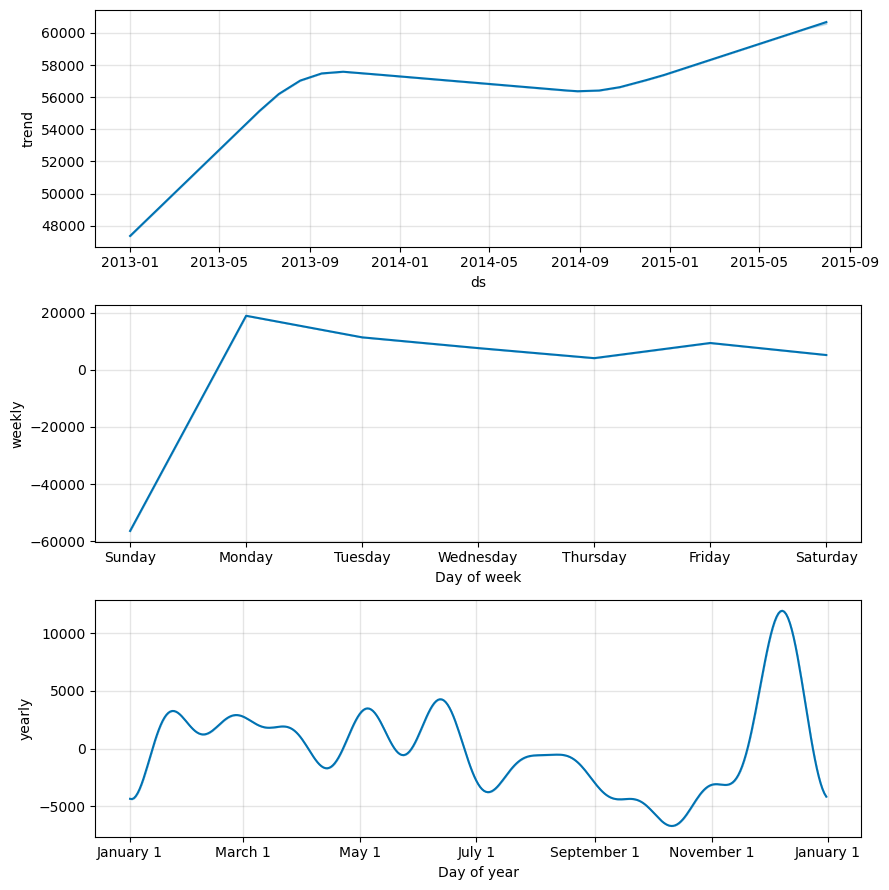

In [9]:
fig2 = m.plot_components(forecast)
plt.show()

Se observa que prácticamente las ventas son altas en toda la semana destacando el lunes excepto el domingo que es cuando las tiendas están cerradas. Además se observa que tiene una tendencia creciente.

**Estadístico R2 Score**

Este valor está comprendido entre 0 y 1. Cuanto más se acerque su valor a 1 mejores serán las predicciones.

In [10]:
print(r2_score(list(test['y']), list(forecast.loc[900:,'yhat'] )))

0.782526766366602


Como primera impresión no parece que el modelo no sea el adecuado. Se van a añadir variables ficticias y regresores al modelo para ver cómo se comporta este estadístico.

#### Se añade la estacionalidad mensual

In [11]:
# Prophet model
m2 = Prophet() 

# Add seasonality
m2.add_seasonality(name='monthly', period=30.5, fourier_order=5)   

# Model fit
m2.fit(train)

# Forecast
future2 = m2.make_future_dataframe(periods=len(test))
forecast2 = m2.predict(future2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**Estadístico R2 Score**

In [12]:
# R2 Score

print(r2_score(list(test['y']), list(forecast2.loc[900:,'yhat'])))

0.7950374993395221


Representación gráfica y descomposición de las predicciones

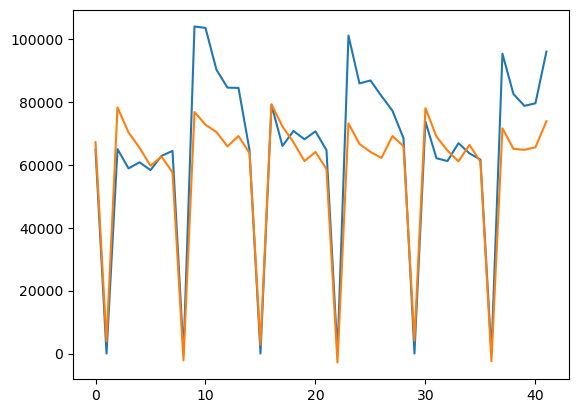

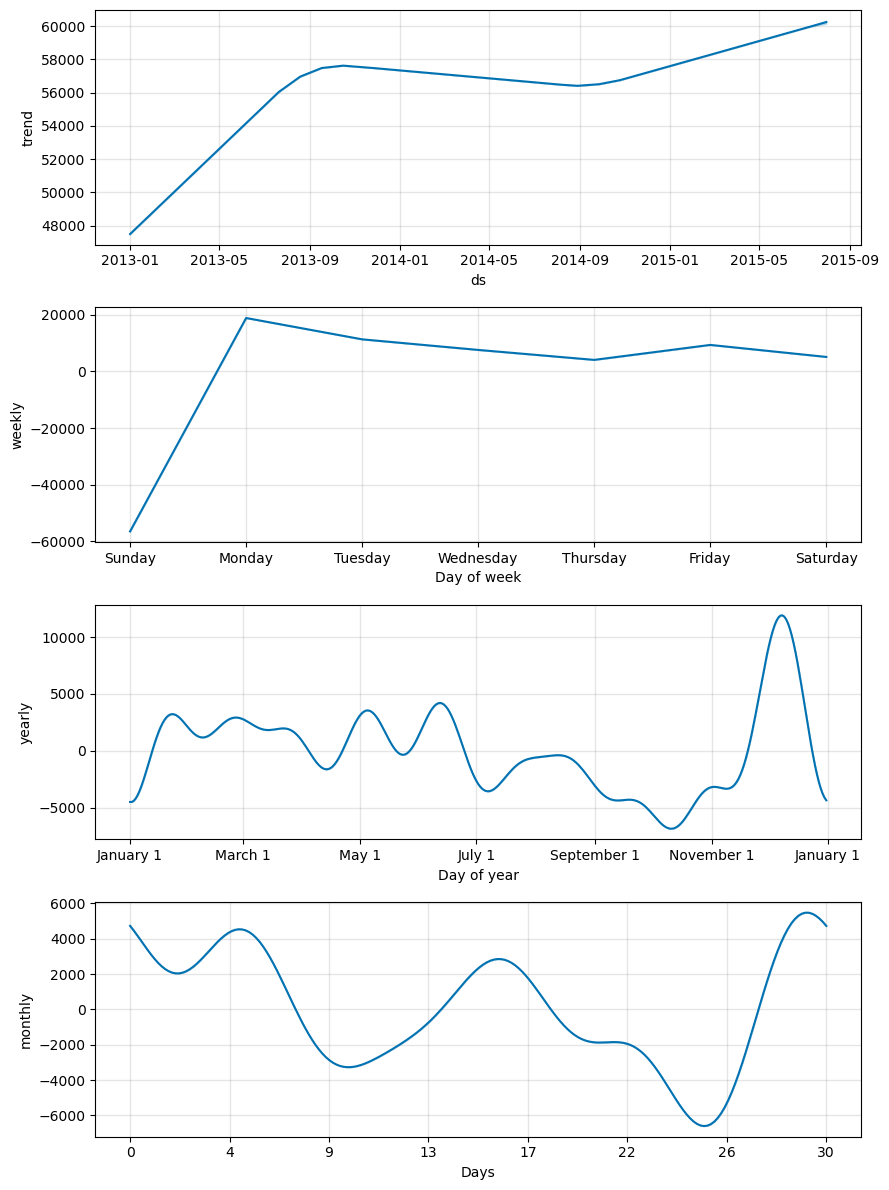

In [13]:
plt.plot(list(test['y']))
plt.plot(list(forecast2.loc[900:,'yhat']))

fig2 = m2.plot_components(forecast2)
plt.show()

Se observa en el gráfico cómo se comporta el compontente de estacionalidad mensual, produciendose un descenso notable al final de mes. Esto se debe a que la renta media de las personas disminuye durante esas épocas, recuperándose los días primeros de cada mes.

### Días de vacaciones Estatales

Añadiendo esta variable ficticia se representan dos casos. El primero si por ejemplo hay un día festivo, probablemente el día anterior pueda haber un incremento en las compras. Por otra parte, hay días festivos que se repiten cada año y nos puede ayudar tambien a identificar patrones estacionales y por último, puede servir de ayuda al modelo para representar aquellos días donde la tienda cierra. 

In [14]:
# Extract the SchoolHoliday column 

holidays = toscos_df.groupby(['Date', 'StateHoliday'])['Sales'].sum().reset_index()
holidays.head()

Date StateHoliday  Sales
0 2013-01-01            a      0
1 2013-01-02            0  61926
2 2013-01-03            0  53588
3 2013-01-04            0  56578
4 2013-01-05            0  54938

Como se realizó en el EDA previamente, la variable ´SatateHoliday´ puede tomar valores 0, a, b, c. En este caso se ha considerado que 0 es si no hay día festivo y a, b, c son días festivos que se repiten cada año. Por lo tanto se va a realizar una transformación de la variable para que tome valores 0 y 1. 

In [15]:
holidays['StateHoliday'] = holidays['StateHoliday'].replace(['a','b','c'],1)

In [16]:
# Select only the rows which are holidays 

holidays = holidays[holidays['StateHoliday'] == 1]
holidays = holidays[['Date', 'StateHoliday']]
holidays = holidays.drop(['StateHoliday'], axis=1)
holidays['holiday'] = 'holiday'
holidays.columns = ['ds', 'holiday']

holidays.tail()

ds  holiday
833 2015-04-06  holiday
858 2015-05-01  holiday
871 2015-05-14  holiday
882 2015-05-25  holiday
893 2015-06-04  holiday

Se añade al modelo

In [17]:
# Fit the model
m3 = Prophet(holidays=holidays)
m3.fit(train)
future3 = m3.make_future_dataframe(periods=len(test))

# Forecast
forecast3 = m3.predict(future3)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**Estadístico R2 Score**

In [18]:
print(r2_score(list(test['y']), list(forecast3.loc[900:,'yhat'])))

0.8131182248586667


Incluyendo esta variable el R2 Score mejora un poco con respecto al calculado anteriormente.

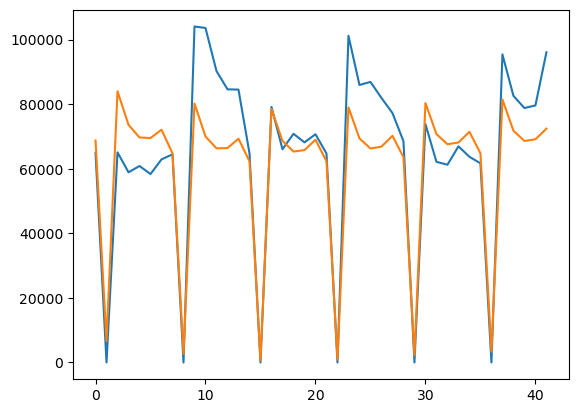

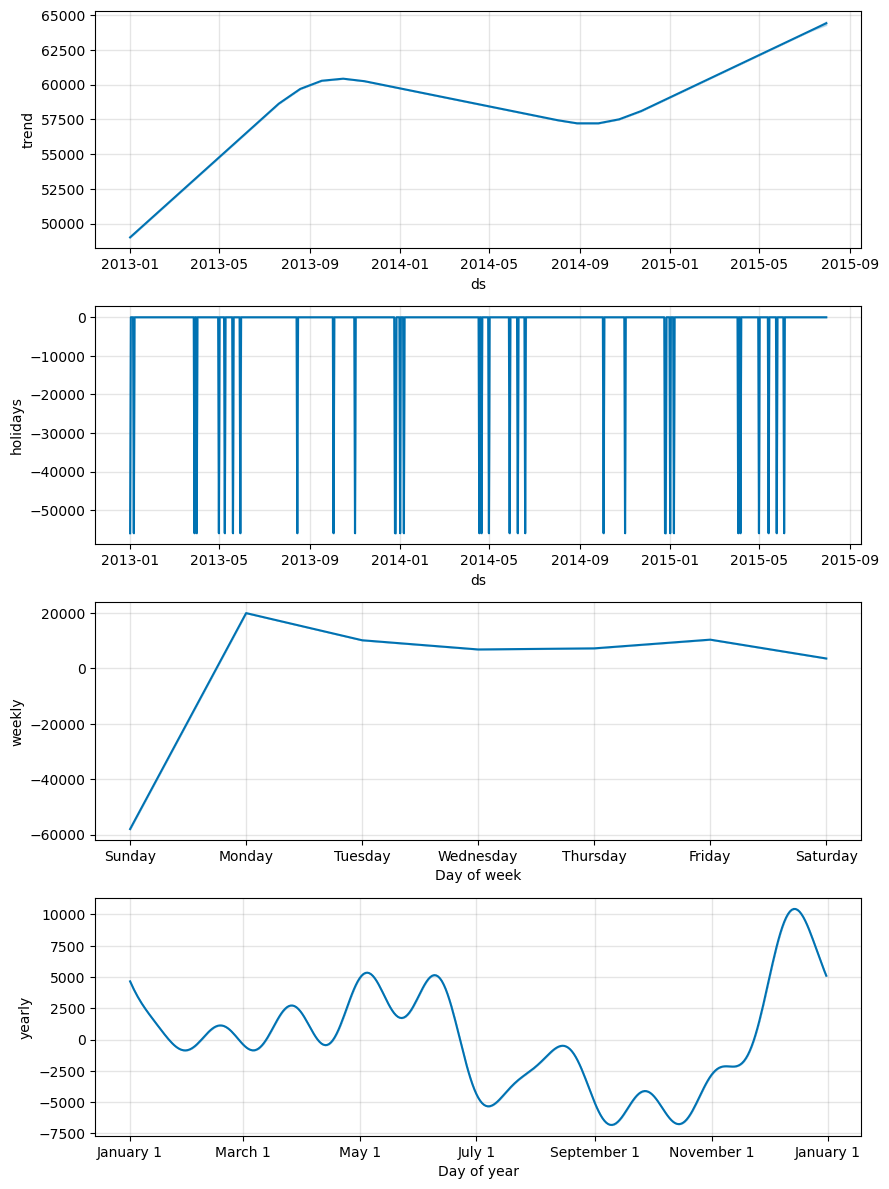

In [19]:
plt.plot(list(test['y']))
plt.plot(list(forecast3.loc[900:,'yhat']))

fig2 = m3.plot_components(forecast3)
plt.show()

La componente anual nos indica que durante el mes de diciembre es donde más se vende, coincidiendo con la campaña navideña. Durante los meses de marzo a junio presenta un comportamiento estable. 

### Se añade como regresor el número de clientes

In [20]:
# Take the customers column 

customers = toscos_df[['Date', 'Customers']]

# Date to datetime
customers['Date'] = pd.to_datetime(customers['Date'])
customers.head()

Date  Customers
0 2015-07-31        915
1 2015-07-31       1414
2 2015-07-31        453
3 2015-07-31       1223
4 2015-07-31        595

In [21]:
# Group by date to add all Sales of the day

customers_serie = customers.groupby('Date').sum().reset_index()

# Date to datetime
customers_serie['Date'] = pd.to_datetime(customers_serie['Date']).dt.date

# Rename columns to Prophet format
customers_serie = customers_serie.rename(columns={'Date':'ds', 'Sales':'y', 'Customers':'customers'})
customers_serie.head()

ds  customers
0  2013-01-01          0
1  2013-01-02       7490
2  2013-01-03       6650
3  2013-01-04       6784
4  2013-01-05       6747

In [22]:
# Copy train to add the customers column

train2 = train.copy()
train2['ds'] = pd.to_datetime(train2['ds']).dt.date

# Merge the customers column and train2
train2 = pd.merge(train2, customers_serie, on='ds', how='left')
train2.tail()

ds       y  customers
895  2015-06-15  105079      10152
896  2015-06-16   87386       8914
897  2015-06-17   78024       8268
898  2015-06-18   73415       7996
899  2015-06-19   80181       8357

In [23]:
# Add customers regresor
m4 = Prophet()
m4.add_regressor('customers')

# Fit the model
m4.fit(train2)

# Make future dataframe
future4 = m4.make_future_dataframe(periods=len(test))
future4['ds'] = pd.to_datetime(future4['ds']).dt.date
future4 = pd.merge(future4, customers_serie, on='ds', how='left')

# Forecast
forecast4 = m4.predict(future4)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


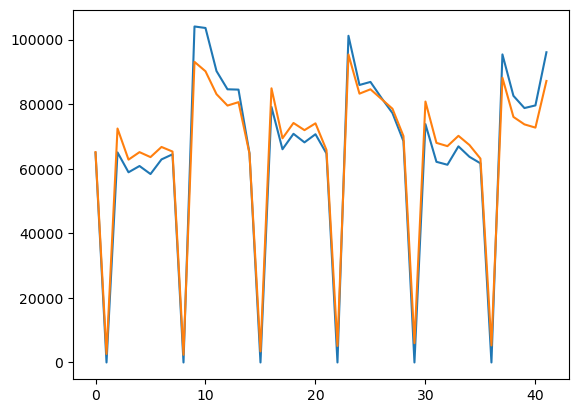

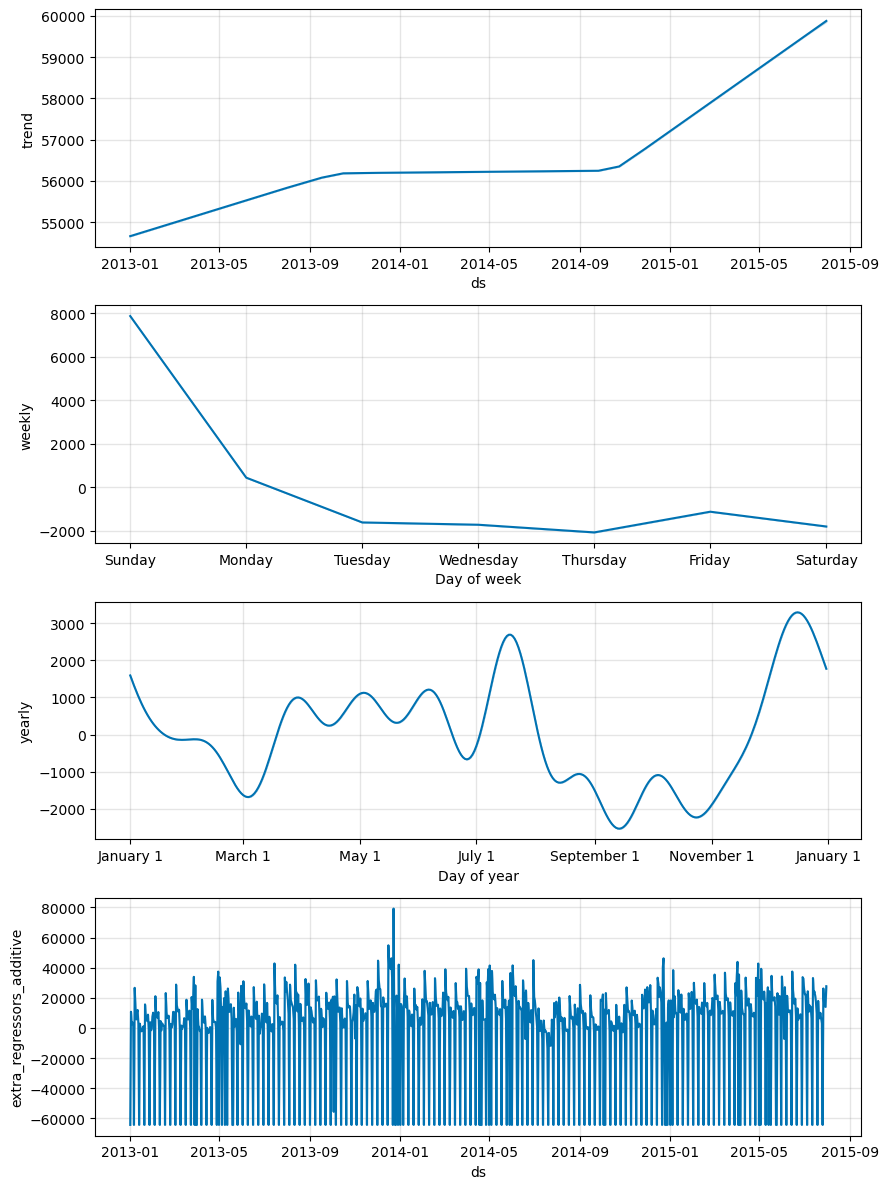

In [24]:
plt.plot(list(test['y']))
plt.plot(list(forecast4.loc[900:,'yhat'] ))

fig2 = m4.plot_components(forecast4)
plt.show()

Al añadirle al modelo la variable regresora de clientes, se observa que gracias a ella el modelo podrá predecir con mayor exactitud los días festivos y los domingos, además de las campañas de promoción. Esta variable será muy importante para el modelo. 

**R2 Score**

In [25]:
print(r2_score(list(test['y']), list(forecast4.loc[900:,'yhat'])))

0.9673401545116483


El R2 Score mejora considerablemente al introducir como variable regresora al modelo los clientes tal y como se esperaba. Se obtiene un R2 Score muy próximo a 1. 

### **Construcción del grid**

Con la finalidad de encontrar la mejor combinación de parámetros para el modelo se ha construido un grid con los parámetros que se quieren probar. De esta manera el grid nos dará la mejor combinación de parámetros para el modelo. 

In [26]:
# Function for grid

def model_test(holidays, weekly_seasonality,
yearly_seasonality, add_monthly, add_customers, changepoint_prior_scale, holidays_prior_scale, month_fourier):

    m4 = Prophet(
        yearly_seasonality=yearly_seasonality, 
        weekly_seasonality=weekly_seasonality, 
        holidays=holidays, 
        changepoint_prior_scale=changepoint_prior_scale, 
        holidays_prior_scale=holidays_prior_scale)  
    
    if add_monthly:    
        m4.add_seasonality(
            name='monthly', 
            period=30.5, 
            fourier_order=month_fourier)
                
    if add_customers:
        m4.add_regressor('customers')

    m4.fit(train2)

    future4 = m4.make_future_dataframe(periods=len(test))

    future4['ds'] = pd.to_datetime(future4['ds']).dt.date
    
    if add_customers:  
        future4 = pd.merge(future4, customers_serie, on='ds', how='left')

    forecast4 = m4.predict(future4)
    
# Show only the best score
    return r2_score(   
            list(test['y']),
            list(forecast4.loc[900:,'yhat'] )) 


In [38]:
# Setting the grid
holidays_opt = [holidays, None]  # Puede ser con o sin vacaciones
weekly_seas = [ 5, 10, 30, 50] # Estacionalidad semanal
yearly_seas = [ 5, 10, 30, 50] 
add_monthly = [True, False]
add_customers = [True, False]
changepoint_prior_scale = [0.1, 0.3, 0.5]
holidays_prior_scale = [0.1, 0.3, 0.5] 
month_fourier = [5, 10, 30, 50]
# Todo lo anterior son los hiperparametros que no sabemos y que van a probar. 
# Looping through the grid
grid_results = []
for h in holidays_opt:
  for w in weekly_seas:
    for ys in yearly_seas:
      for m in add_monthly:
        for r in add_customers:
           for c in changepoint_prior_scale:
             for hp in holidays_prior_scale:
               for mf in month_fourier:
                  r2=model_test(h,w,ys,m,r,c,hp,mf)
                  print([w,ys,m,r,c,hp,mf,r2])
                  grid_results.append([h,w,ys,m,r,c,hp,mf,r2])

# adding it all to a dataframe and extract the best model
benchmark = pd.DataFrame(grid_results)
benchmark = benchmark.sort_values(8, ascending=False)

h, w,ys, m, r, c,hp,mf,r2 = list(benchmark.iloc[0,:])

# Fit the Prophet with those best hyperparameters
m4 = Prophet(
        yearly_seasonality=ys, 
        weekly_seasonality=w, 
        holidays=h, 
        changepoint_prior_scale=c, 
        holidays_prior_scale=hp)
    
if m:    
    m4.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=mf)

if r:
    m4.add_regressor('customers')

m4.fit(train2)

future4 = m4.make_future_dataframe(periods=len(test))

future4['ds'] = pd.to_datetime(future4['ds']).dt.date

if r:
  future4 = pd.merge(future4, customers_serie, on='ds', how='left')

forecast4 = m4.predict(future4)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/brruv_vu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zq3cznf6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16527', 'data', 'file=/tmp/tmpkry26z5a/brruv_vu.json', 'init=/tmp/tmpkry26z5a/zq3cznf6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluad32llb/prophet_model-20230117170023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry

[5, 5, True, True, 0.1, 0.1, 5, 0.9784803143077804]


17:00:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mkt9cwcw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lh_9xh5k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26993', 'data', 'file=/tmp/tmpkry26z5a/mkt9cwcw.json', 'init=/tmp/tmpkry26z5a/lh_9xh5k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhi_x501c/prophet_model-20230117170025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.1, 0.1, 10, 0.9782969408776486]


17:00:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fd2ahlb2.json


[5, 5, True, True, 0.1, 0.1, 30, 0.979699847890444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/khrqoyxg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7575', 'data', 'file=/tmp/tmpkry26z5a/fd2ahlb2.json', 'init=/tmp/tmpkry26z5a/khrqoyxg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_kc5e7an/prophet_model-20230117170027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/spmr_lm3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4bcfd7md.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cm

[5, 5, True, True, 0.1, 0.1, 50, 0.979695790170674]


17:00:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mkzshl3b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jtosd9d0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61720', 'data', 'file=/tmp/tmpkry26z5a/mkzshl3b.json', 'init=/tmp/tmpkry26z5a/jtosd9d0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model85ky8d6r/prophet_model-20230117170029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.1, 0.3, 5, 0.9786077749223212]


17:00:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cm09_22c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sb18vros.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58536', 'data', 'file=/tmp/tmpkry26z5a/cm09_22c.json', 'init=/tmp/tmpkry26z5a/sb18vros.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaizj40ou/prophet_model-20230117170030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.1, 0.3, 10, 0.9784042759738902]


17:00:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2jk9jxpt.json


[5, 5, True, True, 0.1, 0.3, 30, 0.9797587254203666]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7q2gqt_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44112', 'data', 'file=/tmp/tmpkry26z5a/2jk9jxpt.json', 'init=/tmp/tmpkry26z5a/7q2gqt_1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfuek3xtv/prophet_model-20230117170032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/33vqzsfq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q8_3eej4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, True, 0.1, 0.3, 50, 0.9797512177506517]


17:00:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mqi5g7lm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qxv2iw3t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72537', 'data', 'file=/tmp/tmpkry26z5a/mqi5g7lm.json', 'init=/tmp/tmpkry26z5a/qxv2iw3t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvz0kx10d/prophet_model-20230117170034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.1, 0.5, 5, 0.9786159629118923]


17:00:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/61de7vnp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8dgerd51.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21690', 'data', 'file=/tmp/tmpkry26z5a/61de7vnp.json', 'init=/tmp/tmpkry26z5a/8dgerd51.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaf79lfl_/prophet_model-20230117170035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.1, 0.5, 10, 0.9783936551141429]


17:00:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h9kd1bcb.json


[5, 5, True, True, 0.1, 0.5, 30, 0.979758161068555]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4lj9ggzu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44755', 'data', 'file=/tmp/tmpkry26z5a/h9kd1bcb.json', 'init=/tmp/tmpkry26z5a/4lj9ggzu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6z8jp5xf/prophet_model-20230117170036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_sscyr2f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aoxcdd8l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, True, 0.1, 0.5, 50, 0.9797505307874322]


17:00:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ecwzmj7l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x5kffg_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31067', 'data', 'file=/tmp/tmpkry26z5a/ecwzmj7l.json', 'init=/tmp/tmpkry26z5a/x5kffg_w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele6dew8du/prophet_model-20230117170039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.3, 0.1, 5, 0.9784827313777299]


17:00:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r9f08xnf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/19yzwi9v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46520', 'data', 'file=/tmp/tmpkry26z5a/r9f08xnf.json', 'init=/tmp/tmpkry26z5a/19yzwi9v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelox9ru2_z/prophet_model-20230117170040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.3, 0.1, 10, 0.9782336848306468]


17:00:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n33ruq6_.json


[5, 5, True, True, 0.3, 0.1, 30, 0.9797445985699416]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u21g3bxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84108', 'data', 'file=/tmp/tmpkry26z5a/n33ruq6_.json', 'init=/tmp/tmpkry26z5a/u21g3bxt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model16bfo6qd/prophet_model-20230117170041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m0ws3l8b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zo3biu6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, True, 0.3, 0.1, 50, 0.9797202747121218]


17:00:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o8pbas43.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/50g1ybq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70308', 'data', 'file=/tmp/tmpkry26z5a/o8pbas43.json', 'init=/tmp/tmpkry26z5a/50g1ybq_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1arn58cl/prophet_model-20230117170044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.3, 0.3, 5, 0.978495893313831]


17:00:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fpbde5n8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/91g2sn2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99056', 'data', 'file=/tmp/tmpkry26z5a/fpbde5n8.json', 'init=/tmp/tmpkry26z5a/91g2sn2r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvb8js9ue/prophet_model-20230117170045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.3, 0.3, 10, 0.9783494806790395]


17:00:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sd4ek76w.json


[5, 5, True, True, 0.3, 0.3, 30, 0.9797675358296022]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/junz6mnr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74685', 'data', 'file=/tmp/tmpkry26z5a/sd4ek76w.json', 'init=/tmp/tmpkry26z5a/junz6mnr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7eszoyli/prophet_model-20230117170047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g_jlpaqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qqwgwhgw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, True, 0.3, 0.3, 50, 0.9797859669607637]


17:00:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zas6lm5r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vq3zhctq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26755', 'data', 'file=/tmp/tmpkry26z5a/zas6lm5r.json', 'init=/tmp/tmpkry26z5a/vq3zhctq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxe1uazew/prophet_model-20230117170049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.3, 0.5, 5, 0.9785266090032086]


17:00:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/62k1p59b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/82k2rl7x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20773', 'data', 'file=/tmp/tmpkry26z5a/62k1p59b.json', 'init=/tmp/tmpkry26z5a/82k2rl7x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljfcvd5_i/prophet_model-20230117170050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.3, 0.5, 10, 0.9783159969064072]


17:00:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/85qil8kw.json


[5, 5, True, True, 0.3, 0.5, 30, 0.9798335252536188]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gu6aktlb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77023', 'data', 'file=/tmp/tmpkry26z5a/85qil8kw.json', 'init=/tmp/tmpkry26z5a/gu6aktlb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpqvclv0r/prophet_model-20230117170051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9q6tvl5i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jtfrf7y0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, True, 0.3, 0.5, 50, 0.9797680551098726]


17:00:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ddluhfo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vo6yylte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40616', 'data', 'file=/tmp/tmpkry26z5a/5ddluhfo.json', 'init=/tmp/tmpkry26z5a/vo6yylte.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelazlacj93/prophet_model-20230117170054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.5, 0.1, 5, 0.9771716249649595]


17:00:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fyjjscx1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a94av09l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5576', 'data', 'file=/tmp/tmpkry26z5a/fyjjscx1.json', 'init=/tmp/tmpkry26z5a/a94av09l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4yugxe10/prophet_model-20230117170056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.5, 0.1, 10, 0.9768782976573789]


17:00:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mhdzimz5.json


[5, 5, True, True, 0.5, 0.1, 30, 0.9789104036974823]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lqdzc582.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2937', 'data', 'file=/tmp/tmpkry26z5a/mhdzimz5.json', 'init=/tmp/tmpkry26z5a/lqdzc582.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5gw4i7qd/prophet_model-20230117170057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:00:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8xwzktkx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/50x5d75v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cm

[5, 5, True, True, 0.5, 0.1, 50, 0.9788366767873302]


17:01:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_1ddubjn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6946z7ck.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27535', 'data', 'file=/tmp/tmpkry26z5a/_1ddubjn.json', 'init=/tmp/tmpkry26z5a/6946z7ck.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqqm65e0l/prophet_model-20230117170100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.5, 0.3, 5, 0.9772766823574655]


17:01:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o_jm4wgg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xaj4t53a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29873', 'data', 'file=/tmp/tmpkry26z5a/o_jm4wgg.json', 'init=/tmp/tmpkry26z5a/xaj4t53a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln5d59iln/prophet_model-20230117170102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.5, 0.3, 10, 0.976834458600182]


17:01:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5oxnqjlp.json


[5, 5, True, True, 0.5, 0.3, 30, 0.9790015304373414]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fcibxnj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12712', 'data', 'file=/tmp/tmpkry26z5a/5oxnqjlp.json', 'init=/tmp/tmpkry26z5a/fcibxnj2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgujyf392/prophet_model-20230117170103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/getyhrl_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b3d36t37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, True, 0.5, 0.3, 50, 0.9789501251464536]


17:01:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l3i4pid1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s1ubrmaw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35726', 'data', 'file=/tmp/tmpkry26z5a/l3i4pid1.json', 'init=/tmp/tmpkry26z5a/s1ubrmaw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg_fv6xz3/prophet_model-20230117170106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.5, 0.5, 5, 0.9773223838931783]


17:01:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/05kvpy9a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z91nh8o_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28494', 'data', 'file=/tmp/tmpkry26z5a/05kvpy9a.json', 'init=/tmp/tmpkry26z5a/z91nh8o_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgcs8_06w/prophet_model-20230117170108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.5, 0.5, 10, 0.9766667757638506]


17:01:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bc35ofs0.json


[5, 5, True, True, 0.5, 0.5, 30, 0.9789759363796698]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/34jq85av.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74187', 'data', 'file=/tmp/tmpkry26z5a/bc35ofs0.json', 'init=/tmp/tmpkry26z5a/34jq85av.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgpv3v4__/prophet_model-20230117170109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8r3y2nuq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zekdq_dn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, True, 0.5, 0.5, 50, 0.9789550643191316]


17:01:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uh9oprr7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5q989518.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5788', 'data', 'file=/tmp/tmpkry26z5a/uh9oprr7.json', 'init=/tmp/tmpkry26z5a/5q989518.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model58qvxdvx/prophet_model-20230117170112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.1, 0.1, 5, 0.8561453322161089]


17:01:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dfyr6za4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4vk293no.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11481', 'data', 'file=/tmp/tmpkry26z5a/dfyr6za4.json', 'init=/tmp/tmpkry26z5a/4vk293no.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely1pn9mss/prophet_model-20230117170113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.1, 0.1, 10, 0.8538325693450844]


17:01:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e0579c8e.json


[5, 5, True, False, 0.1, 0.1, 30, 0.8413442552948894]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oyv7kkef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85968', 'data', 'file=/tmp/tmpkry26z5a/e0579c8e.json', 'init=/tmp/tmpkry26z5a/oyv7kkef.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltynil28k/prophet_model-20230117170114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x8sdwbwf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/89bd92ge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, False, 0.1, 0.1, 50, 0.8414512733926482]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eu36xu79.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rqxkm__k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54868', 'data', 'file=/tmp/tmpkry26z5a/eu36xu79.json', 'init=/tmp/tmpkry26z5a/rqxkm__k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelejkzp9hq/prophet_model-20230117170116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[5, 5, True, False, 0.1, 0.3, 5, 0.8557073409683862]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ssx8m69b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/px2d8a7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49495', 'data', 'file=/tmp/tmpkry26z5a/ssx8m69b.json', 'init=/tmp/tmpkry26z5a/px2d8a7f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgl13x_pr/prophet_model-20230117170117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.1, 0.3, 10, 0.8535393580948228]


17:01:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1amrurza.json


[5, 5, True, False, 0.1, 0.3, 30, 0.8418325364735091]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p7ocs2jz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79469', 'data', 'file=/tmp/tmpkry26z5a/1amrurza.json', 'init=/tmp/tmpkry26z5a/p7ocs2jz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf0wugktv/prophet_model-20230117170118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o6f3_ofb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hpm_vpaq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, False, 0.1, 0.3, 50, 0.8417141811228687]


17:01:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5uoonraa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8evw6tlu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88121', 'data', 'file=/tmp/tmpkry26z5a/5uoonraa.json', 'init=/tmp/tmpkry26z5a/8evw6tlu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely9k_hi9k/prophet_model-20230117170120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.1, 0.5, 5, 0.8557467907461631]


17:01:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d9srwh3m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o81ro3s6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70150', 'data', 'file=/tmp/tmpkry26z5a/d9srwh3m.json', 'init=/tmp/tmpkry26z5a/o81ro3s6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8elkemn3/prophet_model-20230117170121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.1, 0.5, 10, 0.8545877273527117]


17:01:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v9k515p3.json


[5, 5, True, False, 0.1, 0.5, 30, 0.8424159725723275]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r5gxr5xm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73823', 'data', 'file=/tmp/tmpkry26z5a/v9k515p3.json', 'init=/tmp/tmpkry26z5a/r5gxr5xm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelswf24r6z/prophet_model-20230117170122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nqi9d7ef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_d8cd8_y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, False, 0.1, 0.5, 50, 0.841481884118939]


17:01:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b2lk10o0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y8s45ycy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64716', 'data', 'file=/tmp/tmpkry26z5a/b2lk10o0.json', 'init=/tmp/tmpkry26z5a/y8s45ycy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpis11yh9/prophet_model-20230117170123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.3, 0.1, 5, 0.862563721182607]


17:01:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/900bpoa3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z3du99n9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47049', 'data', 'file=/tmp/tmpkry26z5a/900bpoa3.json', 'init=/tmp/tmpkry26z5a/z3du99n9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt9vtpo42/prophet_model-20230117170124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.3, 0.1, 10, 0.8602486824414822]


17:01:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rkxxttwz.json


[5, 5, True, False, 0.3, 0.1, 30, 0.8460810491074575]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dm_7yyz2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13799', 'data', 'file=/tmp/tmpkry26z5a/rkxxttwz.json', 'init=/tmp/tmpkry26z5a/dm_7yyz2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqyff3t9v/prophet_model-20230117170126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fglbnw_p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z1hg7ed5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, False, 0.3, 0.1, 50, 0.8476735765420091]


17:01:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5_99ras9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1g5ayiiw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79228', 'data', 'file=/tmp/tmpkry26z5a/5_99ras9.json', 'init=/tmp/tmpkry26z5a/1g5ayiiw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljj0i1fp2/prophet_model-20230117170128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.3, 0.3, 5, 0.8624828248424006]


17:01:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gc25lgge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/80yozdm1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70766', 'data', 'file=/tmp/tmpkry26z5a/gc25lgge.json', 'init=/tmp/tmpkry26z5a/80yozdm1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj6tg4d4x/prophet_model-20230117170129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.3, 0.3, 10, 0.8598813160031312]


17:01:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lng2xuuq.json


[5, 5, True, False, 0.3, 0.3, 30, 0.8481005415039171]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jueegxzo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30523', 'data', 'file=/tmp/tmpkry26z5a/lng2xuuq.json', 'init=/tmp/tmpkry26z5a/jueegxzo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelktmkzfwf/prophet_model-20230117170130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e_d0b2xa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dfdfwkyw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, False, 0.3, 0.3, 50, 0.8467310236009176]


17:01:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b6tn5m04.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dx5z0jbs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17276', 'data', 'file=/tmp/tmpkry26z5a/b6tn5m04.json', 'init=/tmp/tmpkry26z5a/dx5z0jbs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele34foj2i/prophet_model-20230117170132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.3, 0.5, 5, 0.8617687881069589]


17:01:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uj8xgebx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a736z279.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84357', 'data', 'file=/tmp/tmpkry26z5a/uj8xgebx.json', 'init=/tmp/tmpkry26z5a/a736z279.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_8zhtkx7/prophet_model-20230117170133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.3, 0.5, 10, 0.859926599393192]


17:01:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/08pyshh5.json


[5, 5, True, False, 0.3, 0.5, 30, 0.8500252423918202]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xi80l2mb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99551', 'data', 'file=/tmp/tmpkry26z5a/08pyshh5.json', 'init=/tmp/tmpkry26z5a/xi80l2mb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo7auim62/prophet_model-20230117170134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eop77j6s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/va4k8tvk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, False, 0.3, 0.5, 50, 0.847184826238428]


17:01:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1ut7tnrx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wm633zm8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61187', 'data', 'file=/tmp/tmpkry26z5a/1ut7tnrx.json', 'init=/tmp/tmpkry26z5a/wm633zm8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_v8heh2w/prophet_model-20230117170136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.5, 0.1, 5, 0.8620386094873083]


17:01:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qkb59mtk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ml24lf8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46078', 'data', 'file=/tmp/tmpkry26z5a/qkb59mtk.json', 'init=/tmp/tmpkry26z5a/ml24lf8a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6w1o0nay/prophet_model-20230117170137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.5, 0.1, 10, 0.8603402129506468]


17:01:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dyz5eo5f.json


[5, 5, True, False, 0.5, 0.1, 30, 0.8464160085284537]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/np8whsp9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24979', 'data', 'file=/tmp/tmpkry26z5a/dyz5eo5f.json', 'init=/tmp/tmpkry26z5a/np8whsp9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhpil4el3/prophet_model-20230117170138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v7v1gsf2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1jjb_1l3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, False, 0.5, 0.1, 50, 0.8468865647926612]


17:01:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zm7xqyxm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1qoq1c_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74328', 'data', 'file=/tmp/tmpkry26z5a/zm7xqyxm.json', 'init=/tmp/tmpkry26z5a/1qoq1c_w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8ufcfgea/prophet_model-20230117170140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.5, 0.3, 5, 0.8616434582942635]


17:01:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5d_fuzwl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_l6b97ai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5925', 'data', 'file=/tmp/tmpkry26z5a/5d_fuzwl.json', 'init=/tmp/tmpkry26z5a/_l6b97ai.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelletwcht_/prophet_model-20230117170141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.5, 0.3, 10, 0.8604227048495854]


17:01:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m1vj7c02.json


[5, 5, True, False, 0.5, 0.3, 30, 0.8469751717102905]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pwzvysjs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15659', 'data', 'file=/tmp/tmpkry26z5a/m1vj7c02.json', 'init=/tmp/tmpkry26z5a/pwzvysjs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5ihhpk8q/prophet_model-20230117170142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wn_c6nux.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yq_q51k7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, False, 0.5, 0.3, 50, 0.8488054926095838]


17:01:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/91zn1xdj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lnabkxph.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51714', 'data', 'file=/tmp/tmpkry26z5a/91zn1xdj.json', 'init=/tmp/tmpkry26z5a/lnabkxph.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellpig1z6n/prophet_model-20230117170144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.5, 0.5, 5, 0.861753803382885]


17:01:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kjin_ot7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p3lv2r31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64385', 'data', 'file=/tmp/tmpkry26z5a/kjin_ot7.json', 'init=/tmp/tmpkry26z5a/p3lv2r31.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2csispv6/prophet_model-20230117170145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.5, 0.5, 10, 0.8605594058002014]


17:01:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iwmuxakt.json


[5, 5, True, False, 0.5, 0.5, 30, 0.8460901014240146]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2brn_z5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25452', 'data', 'file=/tmp/tmpkry26z5a/iwmuxakt.json', 'init=/tmp/tmpkry26z5a/2brn_z5q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvnm8o9uk/prophet_model-20230117170147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k57npqsm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2v76ozt_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, False, 0.5, 0.5, 50, 0.8454520697997406]


17:01:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pm1ha8hz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vibvj71d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29517', 'data', 'file=/tmp/tmpkry26z5a/pm1ha8hz.json', 'init=/tmp/tmpkry26z5a/vibvj71d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelphcnkgt8/prophet_model-20230117170149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.1, 5, 0.9760231747578209]


17:01:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7qn13lnv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s_mddbmf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56885', 'data', 'file=/tmp/tmpkry26z5a/7qn13lnv.json', 'init=/tmp/tmpkry26z5a/s_mddbmf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrfjubjpg/prophet_model-20230117170150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.1, 10, 0.9760231747578209]


17:01:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/75nyan83.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xf2a8aq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66671', 'data', 'file=/tmp/tmpkry26z5a/75nyan83.json', 'init=/tmp/tmpkry26z5a/xf2a8aq_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelag_rg79y/prophet_model-20230117170151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.1, 30, 0.9760231747578209]


17:01:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qz7eck7c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/saoqkcbo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47693', 'data', 'file=/tmp/tmpkry26z5a/qz7eck7c.json', 'init=/tmp/tmpkry26z5a/saoqkcbo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo6xnxj6n/prophet_model-20230117170151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.1, 50, 0.9760231747578209]


17:01:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aeh0pzvx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qiwqgrti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83005', 'data', 'file=/tmp/tmpkry26z5a/aeh0pzvx.json', 'init=/tmp/tmpkry26z5a/qiwqgrti.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzadu524g/prophet_model-20230117170152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.3, 5, 0.9760253513842867]


17:01:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ym_gunno.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bji4gok8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98385', 'data', 'file=/tmp/tmpkry26z5a/ym_gunno.json', 'init=/tmp/tmpkry26z5a/bji4gok8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelji878g4e/prophet_model-20230117170153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.3, 10, 0.9760253513842867]


17:01:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gcudy9bz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w44j7eh9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42520', 'data', 'file=/tmp/tmpkry26z5a/gcudy9bz.json', 'init=/tmp/tmpkry26z5a/w44j7eh9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2r1a8oco/prophet_model-20230117170154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.3, 30, 0.9760253513842867]


17:01:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r1nmin01.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/681k6vfv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97500', 'data', 'file=/tmp/tmpkry26z5a/r1nmin01.json', 'init=/tmp/tmpkry26z5a/681k6vfv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbrf33b0h/prophet_model-20230117170155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.3, 50, 0.9760253513842867]


17:01:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n_ei8w8k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k70ykvop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85497', 'data', 'file=/tmp/tmpkry26z5a/n_ei8w8k.json', 'init=/tmp/tmpkry26z5a/k70ykvop.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5vejp6ul/prophet_model-20230117170156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.5, 5, 0.9760516493287217]


17:01:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0r8kholc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nz2e_uty.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46567', 'data', 'file=/tmp/tmpkry26z5a/0r8kholc.json', 'init=/tmp/tmpkry26z5a/nz2e_uty.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkg8aa4zq/prophet_model-20230117170157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.5, 10, 0.9760516493287217]


17:01:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a4bkial0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cs_iuuca.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56214', 'data', 'file=/tmp/tmpkry26z5a/a4bkial0.json', 'init=/tmp/tmpkry26z5a/cs_iuuca.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg4eygghm/prophet_model-20230117170158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.5, 30, 0.9760516493287217]


17:01:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k71x8lxi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m85n17wj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84635', 'data', 'file=/tmp/tmpkry26z5a/k71x8lxi.json', 'init=/tmp/tmpkry26z5a/m85n17wj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5o_1z7_o/prophet_model-20230117170159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:01:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.5, 50, 0.9760516493287217]


17:01:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yzlc86n3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jz1fvx3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77058', 'data', 'file=/tmp/tmpkry26z5a/yzlc86n3.json', 'init=/tmp/tmpkry26z5a/jz1fvx3c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell0ihs65f/prophet_model-20230117170200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.1, 5, 0.9760462649602992]


17:02:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pexthkqt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3s7r4xg8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26555', 'data', 'file=/tmp/tmpkry26z5a/pexthkqt.json', 'init=/tmp/tmpkry26z5a/3s7r4xg8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg1txyozw/prophet_model-20230117170201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.1, 10, 0.9760462649602992]


17:02:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6udm350c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/myi6vdf3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77841', 'data', 'file=/tmp/tmpkry26z5a/6udm350c.json', 'init=/tmp/tmpkry26z5a/myi6vdf3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz2__yf94/prophet_model-20230117170202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.1, 30, 0.9760462649602992]


17:02:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z6k6sv4a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v7zyqgu0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22965', 'data', 'file=/tmp/tmpkry26z5a/z6k6sv4a.json', 'init=/tmp/tmpkry26z5a/v7zyqgu0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxehz11dp/prophet_model-20230117170203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.1, 50, 0.9760462649602992]


17:02:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k41ikydm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pg4_2mr4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46703', 'data', 'file=/tmp/tmpkry26z5a/k41ikydm.json', 'init=/tmp/tmpkry26z5a/pg4_2mr4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models5ynbiq6/prophet_model-20230117170204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.3, 5, 0.9761270520661297]


17:02:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jg4tgy82.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gr732bo2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30370', 'data', 'file=/tmp/tmpkry26z5a/jg4tgy82.json', 'init=/tmp/tmpkry26z5a/gr732bo2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj8qo4grv/prophet_model-20230117170205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.3, 10, 0.9761270520661297]


17:02:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jdrounmd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eznax05e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25694', 'data', 'file=/tmp/tmpkry26z5a/jdrounmd.json', 'init=/tmp/tmpkry26z5a/eznax05e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv6gt7aq9/prophet_model-20230117170206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.3, 30, 0.9761270520661297]


17:02:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/akmf57ww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/knrqytrt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92504', 'data', 'file=/tmp/tmpkry26z5a/akmf57ww.json', 'init=/tmp/tmpkry26z5a/knrqytrt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellci48lh0/prophet_model-20230117170207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.3, 50, 0.9761270520661297]


17:02:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bevq0ovd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9i2nxxba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7873', 'data', 'file=/tmp/tmpkry26z5a/bevq0ovd.json', 'init=/tmp/tmpkry26z5a/9i2nxxba.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln5om51s9/prophet_model-20230117170208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.5, 5, 0.9761191280937862]


17:02:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l9jpbgbb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8j2_vck0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12517', 'data', 'file=/tmp/tmpkry26z5a/l9jpbgbb.json', 'init=/tmp/tmpkry26z5a/8j2_vck0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg3gq0ekm/prophet_model-20230117170209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.5, 10, 0.9761191280937862]


17:02:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/30qhe3mr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/29x4zw4y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62601', 'data', 'file=/tmp/tmpkry26z5a/30qhe3mr.json', 'init=/tmp/tmpkry26z5a/29x4zw4y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkeovx14z/prophet_model-20230117170210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.5, 30, 0.9761191280937862]


17:02:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y09tntms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8g2mdy64.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15966', 'data', 'file=/tmp/tmpkry26z5a/y09tntms.json', 'init=/tmp/tmpkry26z5a/8g2mdy64.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelalalbvwn/prophet_model-20230117170211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.5, 50, 0.9761191280937862]


17:02:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1s8hgwic.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eo99b8hr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37671', 'data', 'file=/tmp/tmpkry26z5a/1s8hgwic.json', 'init=/tmp/tmpkry26z5a/eo99b8hr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhj55e1ru/prophet_model-20230117170212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.1, 5, 0.9742613752675863]


17:02:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dwewrzvw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lnhiqjme.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43329', 'data', 'file=/tmp/tmpkry26z5a/dwewrzvw.json', 'init=/tmp/tmpkry26z5a/lnhiqjme.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln4prxv7r/prophet_model-20230117170213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.1, 10, 0.9742613752675863]


17:02:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5q2t4aba.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hy_us9vt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69333', 'data', 'file=/tmp/tmpkry26z5a/5q2t4aba.json', 'init=/tmp/tmpkry26z5a/hy_us9vt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model25lxkjut/prophet_model-20230117170215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.1, 30, 0.9742613752675863]


17:02:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2x15vg4e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j8uhk2h2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51448', 'data', 'file=/tmp/tmpkry26z5a/2x15vg4e.json', 'init=/tmp/tmpkry26z5a/j8uhk2h2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpk8hx2vp/prophet_model-20230117170216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.1, 50, 0.9742613752675863]


17:02:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bw2sc84v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q_cw05xj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3928', 'data', 'file=/tmp/tmpkry26z5a/bw2sc84v.json', 'init=/tmp/tmpkry26z5a/q_cw05xj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx6dghw4_/prophet_model-20230117170217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.3, 5, 0.9747439630011844]


17:02:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bg_vrabv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iz7mu6t5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51444', 'data', 'file=/tmp/tmpkry26z5a/bg_vrabv.json', 'init=/tmp/tmpkry26z5a/iz7mu6t5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4bmtbxy0/prophet_model-20230117170218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.3, 10, 0.9747439630011844]


17:02:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xd9ok3cn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t84djjq6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19544', 'data', 'file=/tmp/tmpkry26z5a/xd9ok3cn.json', 'init=/tmp/tmpkry26z5a/t84djjq6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxb9ydaco/prophet_model-20230117170220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.3, 30, 0.9747439630011844]


17:02:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/96tfdj6t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d3c1_o0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54218', 'data', 'file=/tmp/tmpkry26z5a/96tfdj6t.json', 'init=/tmp/tmpkry26z5a/d3c1_o0z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeless9q_7o/prophet_model-20230117170221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.3, 50, 0.9747439630011844]


17:02:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sw9hg5wm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_1t5ha74.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17664', 'data', 'file=/tmp/tmpkry26z5a/sw9hg5wm.json', 'init=/tmp/tmpkry26z5a/_1t5ha74.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt2_03njg/prophet_model-20230117170222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.5, 5, 0.9748732230143401]


17:02:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t5scz3wi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vrrl_en4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42476', 'data', 'file=/tmp/tmpkry26z5a/t5scz3wi.json', 'init=/tmp/tmpkry26z5a/vrrl_en4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4hihowbn/prophet_model-20230117170223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.5, 10, 0.9748732230143401]


17:02:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8egmt76f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3vgy4_hz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59619', 'data', 'file=/tmp/tmpkry26z5a/8egmt76f.json', 'init=/tmp/tmpkry26z5a/3vgy4_hz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnvkz7lop/prophet_model-20230117170225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.5, 30, 0.9748732230143401]


17:02:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r_ohcfnh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ttlo0v9c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87241', 'data', 'file=/tmp/tmpkry26z5a/r_ohcfnh.json', 'init=/tmp/tmpkry26z5a/ttlo0v9c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkgyo749f/prophet_model-20230117170226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[5, 5, False, True, 0.5, 0.5, 50, 0.9748732230143401]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g1iqfqtz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/odac_gs_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46513', 'data', 'file=/tmp/tmpkry26z5a/g1iqfqtz.json', 'init=/tmp/tmpkry26z5a/odac_gs_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4ws3v979/prophet_model-20230117170227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[5, 5, False, False, 0.1, 0.1, 5, 0.8405765803862961]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ok5igupw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fyadxobt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91978', 'data', 'file=/tmp/tmpkry26z5a/ok5igupw.json', 'init=/tmp/tmpkry26z5a/fyadxobt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldmk3cff6/prophet_model-20230117170228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[5, 5, False, False, 0.1, 0.1, 10, 0.8405765803862961]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/68_2aqxr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tui4tg6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44536', 'data', 'file=/tmp/tmpkry26z5a/68_2aqxr.json', 'init=/tmp/tmpkry26z5a/tui4tg6p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxlonrma_/prophet_model-20230117170228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[5, 5, False, False, 0.1, 0.1, 30, 0.8405765803862961]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b_41pcum.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/smjqz224.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24465', 'data', 'file=/tmp/tmpkry26z5a/b_41pcum.json', 'init=/tmp/tmpkry26z5a/smjqz224.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsuju0vf3/prophet_model-20230117170229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.1, 0.1, 50, 0.8405765803862961]


17:02:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gb8yy45p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yiz_mhlw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39152', 'data', 'file=/tmp/tmpkry26z5a/gb8yy45p.json', 'init=/tmp/tmpkry26z5a/yiz_mhlw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4igymzvs/prophet_model-20230117170230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.1, 0.3, 5, 0.8415359220099249]


17:02:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/skp7b_o2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gef6lvk7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99096', 'data', 'file=/tmp/tmpkry26z5a/skp7b_o2.json', 'init=/tmp/tmpkry26z5a/gef6lvk7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model30w9f2nw/prophet_model-20230117170231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[5, 5, False, False, 0.1, 0.3, 10, 0.8415359220099249]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jkhoa5tb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t2lo2rw8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37551', 'data', 'file=/tmp/tmpkry26z5a/jkhoa5tb.json', 'init=/tmp/tmpkry26z5a/t2lo2rw8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv3h0cbpj/prophet_model-20230117170232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[5, 5, False, False, 0.1, 0.3, 30, 0.8415359220099249]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u0_bxm6v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zz9wci3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72099', 'data', 'file=/tmp/tmpkry26z5a/u0_bxm6v.json', 'init=/tmp/tmpkry26z5a/zz9wci3z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelusujcezf/prophet_model-20230117170232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[5, 5, False, False, 0.1, 0.3, 50, 0.8415359220099249]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_2gfug0b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/knm5_ycz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81964', 'data', 'file=/tmp/tmpkry26z5a/_2gfug0b.json', 'init=/tmp/tmpkry26z5a/knm5_ycz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model90zseue9/prophet_model-20230117170233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[5, 5, False, False, 0.1, 0.5, 5, 0.8410976299288984]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/57io9xow.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zg5lvx60.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77485', 'data', 'file=/tmp/tmpkry26z5a/57io9xow.json', 'init=/tmp/tmpkry26z5a/zg5lvx60.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelptamib0e/prophet_model-20230117170234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[5, 5, False, False, 0.1, 0.5, 10, 0.8410976299288984]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ef1t2w52.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/47k38du7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79338', 'data', 'file=/tmp/tmpkry26z5a/ef1t2w52.json', 'init=/tmp/tmpkry26z5a/47k38du7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyzo2d3w6/prophet_model-20230117170235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[5, 5, False, False, 0.1, 0.5, 30, 0.8410976299288984]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g15t8bqs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nxflxko5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48345', 'data', 'file=/tmp/tmpkry26z5a/g15t8bqs.json', 'init=/tmp/tmpkry26z5a/nxflxko5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcxyunlke/prophet_model-20230117170235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.1, 0.5, 50, 0.8410976299288984]


17:02:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d4xa7gxp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n3zdoyy0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84903', 'data', 'file=/tmp/tmpkry26z5a/d4xa7gxp.json', 'init=/tmp/tmpkry26z5a/n3zdoyy0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwikezumr/prophet_model-20230117170236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.1, 5, 0.8456189806582227]


17:02:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fzhgm6tl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x_2ewupj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26261', 'data', 'file=/tmp/tmpkry26z5a/fzhgm6tl.json', 'init=/tmp/tmpkry26z5a/x_2ewupj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwj45hi71/prophet_model-20230117170237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.1, 10, 0.8456189806582227]


17:02:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qifsi6pt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lqdeujso.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48176', 'data', 'file=/tmp/tmpkry26z5a/qifsi6pt.json', 'init=/tmp/tmpkry26z5a/lqdeujso.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm4b2amza/prophet_model-20230117170238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.1, 30, 0.8456189806582227]


17:02:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w1ve4zc7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/66gm8wij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94758', 'data', 'file=/tmp/tmpkry26z5a/w1ve4zc7.json', 'init=/tmp/tmpkry26z5a/66gm8wij.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbcp7t1x1/prophet_model-20230117170239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.1, 50, 0.8456189806582227]


17:02:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xgqcjoph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4_ls23a1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78165', 'data', 'file=/tmp/tmpkry26z5a/xgqcjoph.json', 'init=/tmp/tmpkry26z5a/4_ls23a1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltj3420cg/prophet_model-20230117170240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:40 - cmdstanpy - INFO - Chain [1] done processing


[5, 5, False, False, 0.3, 0.3, 5, 0.8459518477310841]


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yzb2t7cr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vyzsnc98.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14514', 'data', 'file=/tmp/tmpkry26z5a/yzb2t7cr.json', 'init=/tmp/tmpkry26z5a/vyzsnc98.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0rqjgyxl/prophet_model-20230117170241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.3, 10, 0.8459518477310841]


17:02:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/65flf82t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wzjywzj7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72385', 'data', 'file=/tmp/tmpkry26z5a/65flf82t.json', 'init=/tmp/tmpkry26z5a/wzjywzj7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu510q1mv/prophet_model-20230117170242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.3, 30, 0.8459518477310841]


17:02:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pnozz2nf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fb99ejbn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35354', 'data', 'file=/tmp/tmpkry26z5a/pnozz2nf.json', 'init=/tmp/tmpkry26z5a/fb99ejbn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelstn1qfhf/prophet_model-20230117170242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.3, 50, 0.8459518477310841]


17:02:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xsrd70pc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4v4o6lou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5519', 'data', 'file=/tmp/tmpkry26z5a/xsrd70pc.json', 'init=/tmp/tmpkry26z5a/4v4o6lou.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsf6nhhy6/prophet_model-20230117170243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.5, 5, 0.845517079141081]


17:02:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kj149ueq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qlslw3iq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34264', 'data', 'file=/tmp/tmpkry26z5a/kj149ueq.json', 'init=/tmp/tmpkry26z5a/qlslw3iq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxc3glzco/prophet_model-20230117170244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.5, 10, 0.845517079141081]


17:02:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ti5ze0wy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t3x55p79.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35599', 'data', 'file=/tmp/tmpkry26z5a/ti5ze0wy.json', 'init=/tmp/tmpkry26z5a/t3x55p79.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1qd1_4jg/prophet_model-20230117170245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.5, 30, 0.845517079141081]


17:02:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vah_toyd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p_be3_sm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20508', 'data', 'file=/tmp/tmpkry26z5a/vah_toyd.json', 'init=/tmp/tmpkry26z5a/p_be3_sm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv6k1jjrx/prophet_model-20230117170246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.5, 50, 0.845517079141081]


17:02:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ssy5vd_h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2346ccwo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37326', 'data', 'file=/tmp/tmpkry26z5a/ssy5vd_h.json', 'init=/tmp/tmpkry26z5a/2346ccwo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelme5r7awd/prophet_model-20230117170247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.1, 5, 0.8457859009331978]


17:02:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h0os__wa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ksk57i6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15452', 'data', 'file=/tmp/tmpkry26z5a/h0os__wa.json', 'init=/tmp/tmpkry26z5a/ksk57i6q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwzpkvn0l/prophet_model-20230117170248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.1, 10, 0.8457859009331978]


17:02:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1epr_a4g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vws3dg6x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72275', 'data', 'file=/tmp/tmpkry26z5a/1epr_a4g.json', 'init=/tmp/tmpkry26z5a/vws3dg6x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model243b6o54/prophet_model-20230117170249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.1, 30, 0.8457859009331978]


17:02:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mtefw1vh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/60fpju8e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65581', 'data', 'file=/tmp/tmpkry26z5a/mtefw1vh.json', 'init=/tmp/tmpkry26z5a/60fpju8e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpkehjk05/prophet_model-20230117170249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.1, 50, 0.8457859009331978]


17:02:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7e2xhuzu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qqkf9798.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33078', 'data', 'file=/tmp/tmpkry26z5a/7e2xhuzu.json', 'init=/tmp/tmpkry26z5a/qqkf9798.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld4wno9pb/prophet_model-20230117170250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.3, 5, 0.8459330100809868]


17:02:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/br5letxf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4mxvzepc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23254', 'data', 'file=/tmp/tmpkry26z5a/br5letxf.json', 'init=/tmp/tmpkry26z5a/4mxvzepc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnoxu7lrs/prophet_model-20230117170251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.3, 10, 0.8459330100809868]


17:02:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e1878jsv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mg_b5rgz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53924', 'data', 'file=/tmp/tmpkry26z5a/e1878jsv.json', 'init=/tmp/tmpkry26z5a/mg_b5rgz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8kuzs3rm/prophet_model-20230117170252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.3, 30, 0.8459330100809868]


17:02:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/awblla8e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pov95d75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28108', 'data', 'file=/tmp/tmpkry26z5a/awblla8e.json', 'init=/tmp/tmpkry26z5a/pov95d75.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model53grs30r/prophet_model-20230117170253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.3, 50, 0.8459330100809868]


17:02:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cfzx9vfg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fkulu5th.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92156', 'data', 'file=/tmp/tmpkry26z5a/cfzx9vfg.json', 'init=/tmp/tmpkry26z5a/fkulu5th.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8prnwm6p/prophet_model-20230117170254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.5, 5, 0.8459776701600789]


17:02:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/im07t_fc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bhijfwlc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51489', 'data', 'file=/tmp/tmpkry26z5a/im07t_fc.json', 'init=/tmp/tmpkry26z5a/bhijfwlc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc9ykny8d/prophet_model-20230117170255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.5, 10, 0.8459776701600789]


17:02:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zc1pq3d5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kydu831b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12519', 'data', 'file=/tmp/tmpkry26z5a/zc1pq3d5.json', 'init=/tmp/tmpkry26z5a/kydu831b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmklh7w1t/prophet_model-20230117170255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.5, 30, 0.8459776701600789]


17:02:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y59p5nho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r3m08nd9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69702', 'data', 'file=/tmp/tmpkry26z5a/y59p5nho.json', 'init=/tmp/tmpkry26z5a/r3m08nd9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model017dyj7q/prophet_model-20230117170256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.5, 50, 0.8459776701600789]


17:02:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dilztqfk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xls0s0hj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61138', 'data', 'file=/tmp/tmpkry26z5a/dilztqfk.json', 'init=/tmp/tmpkry26z5a/xls0s0hj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model69w6qvxi/prophet_model-20230117170257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.1, 0.1, 5, 0.9784157547013579]


17:02:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w3wx1f_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xmgb732e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12279', 'data', 'file=/tmp/tmpkry26z5a/w3wx1f_b.json', 'init=/tmp/tmpkry26z5a/xmgb732e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelam9y3zbq/prophet_model-20230117170259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.1, 0.1, 10, 0.9782249593437392]


17:02:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7xm299_o.json


[5, 10, True, True, 0.1, 0.1, 30, 0.9786837978271035]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wxg04g6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22918', 'data', 'file=/tmp/tmpkry26z5a/7xm299_o.json', 'init=/tmp/tmpkry26z5a/wxg04g6y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnbdoa0z7/prophet_model-20230117170300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h4z67q0l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7v0e3xq1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.1, 0.1, 50, 0.9786840694797408]


17:03:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i6lwg46w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vtp22rcg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38439', 'data', 'file=/tmp/tmpkry26z5a/i6lwg46w.json', 'init=/tmp/tmpkry26z5a/vtp22rcg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_6lpx9wd/prophet_model-20230117170302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.1, 0.3, 5, 0.9784385218840881]


17:03:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1lvm2ifw.json


[5, 10, True, True, 0.1, 0.3, 10, 0.9782349252650404]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xwjmmpu5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96259', 'data', 'file=/tmp/tmpkry26z5a/1lvm2ifw.json', 'init=/tmp/tmpkry26z5a/xwjmmpu5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgf3uk3dl/prophet_model-20230117170303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fsx6qqmy.json


[5, 10, True, True, 0.1, 0.3, 30, 0.978735408673335]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/idzz0ibh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97915', 'data', 'file=/tmp/tmpkry26z5a/fsx6qqmy.json', 'init=/tmp/tmpkry26z5a/idzz0ibh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli_36g4z5/prophet_model-20230117170305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ps9ll8zi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2cae80lr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.1, 0.3, 50, 0.9787247057325523]


17:03:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ejis1af.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yrxiaxva.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67035', 'data', 'file=/tmp/tmpkry26z5a/5ejis1af.json', 'init=/tmp/tmpkry26z5a/yrxiaxva.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf__8q20i/prophet_model-20230117170307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.1, 0.5, 5, 0.9784949092412428]


17:03:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7rhukcl0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wokm_ow1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76833', 'data', 'file=/tmp/tmpkry26z5a/7rhukcl0.json', 'init=/tmp/tmpkry26z5a/wokm_ow1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx1jhag7m/prophet_model-20230117170308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.1, 0.5, 10, 0.97826710798944]


17:03:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dzq5j2kw.json


[5, 10, True, True, 0.1, 0.5, 30, 0.9787286469415563]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b5g4xb90.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70751', 'data', 'file=/tmp/tmpkry26z5a/dzq5j2kw.json', 'init=/tmp/tmpkry26z5a/b5g4xb90.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2bm1jkji/prophet_model-20230117170310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h72qjkud.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rvwzqzw2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.1, 0.5, 50, 0.9787220748400307]


17:03:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uyqcpy4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4765ijs2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78033', 'data', 'file=/tmp/tmpkry26z5a/uyqcpy4x.json', 'init=/tmp/tmpkry26z5a/4765ijs2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyzw94p0y/prophet_model-20230117170312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.3, 0.1, 5, 0.978507004824039]


17:03:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bnjhcf6_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jh9p7b5k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48696', 'data', 'file=/tmp/tmpkry26z5a/bnjhcf6_.json', 'init=/tmp/tmpkry26z5a/jh9p7b5k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelstpy723z/prophet_model-20230117170313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.3, 0.1, 10, 0.9782750677448089]


17:03:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3xu45ody.json


[5, 10, True, True, 0.3, 0.1, 30, 0.9787693063578944]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/79dconxf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13767', 'data', 'file=/tmp/tmpkry26z5a/3xu45ody.json', 'init=/tmp/tmpkry26z5a/79dconxf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelny3jxkzq/prophet_model-20230117170315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rvdoemtp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6uovtjr7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.3, 0.1, 50, 0.9787788261730834]


17:03:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2twsan2y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z4geuf36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18684', 'data', 'file=/tmp/tmpkry26z5a/2twsan2y.json', 'init=/tmp/tmpkry26z5a/z4geuf36.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvz_09w4o/prophet_model-20230117170318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.3, 0.3, 5, 0.9785539655595754]


17:03:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/67bywha_.json


[5, 10, True, True, 0.3, 0.3, 10, 0.9783366449430233]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eygeyb7e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35899', 'data', 'file=/tmp/tmpkry26z5a/67bywha_.json', 'init=/tmp/tmpkry26z5a/eygeyb7e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyzqds1j2/prophet_model-20230117170319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b76q0ry9.json


[5, 10, True, True, 0.3, 0.3, 30, 0.9788153054151454]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ap2_f33.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61803', 'data', 'file=/tmp/tmpkry26z5a/b76q0ry9.json', 'init=/tmp/tmpkry26z5a/8ap2_f33.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9mbttdud/prophet_model-20230117170320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o2fywwp0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q7zfgv1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.3, 0.3, 50, 0.978810333419127]


17:03:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q_y46xiq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/svad66gv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81707', 'data', 'file=/tmp/tmpkry26z5a/q_y46xiq.json', 'init=/tmp/tmpkry26z5a/svad66gv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqcg_v4ma/prophet_model-20230117170323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.3, 0.5, 5, 0.9785562237865159]


17:03:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qb9_dgl3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wuu21mif.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86453', 'data', 'file=/tmp/tmpkry26z5a/qb9_dgl3.json', 'init=/tmp/tmpkry26z5a/wuu21mif.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6rupch6d/prophet_model-20230117170324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.3, 0.5, 10, 0.9783233448781653]


17:03:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0cghrpc2.json


[5, 10, True, True, 0.3, 0.5, 30, 0.9788048242419609]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2ajivrb_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86681', 'data', 'file=/tmp/tmpkry26z5a/0cghrpc2.json', 'init=/tmp/tmpkry26z5a/2ajivrb_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8ggr07rp/prophet_model-20230117170326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uzp2_zny.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8kar8b5e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.3, 0.5, 50, 0.9788307295937584]


17:03:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hck33rmj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sdrn0l3e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47609', 'data', 'file=/tmp/tmpkry26z5a/hck33rmj.json', 'init=/tmp/tmpkry26z5a/sdrn0l3e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr_os2ih5/prophet_model-20230117170329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.5, 0.1, 5, 0.9773405579899106]


17:03:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hl8nn190.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rv7mwnjo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18780', 'data', 'file=/tmp/tmpkry26z5a/hl8nn190.json', 'init=/tmp/tmpkry26z5a/rv7mwnjo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltgkkso3x/prophet_model-20230117170330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.5, 0.1, 10, 0.9772153131725612]


17:03:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l5nh6b7a.json


[5, 10, True, True, 0.5, 0.1, 30, 0.9780606662239529]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kminvvgx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26061', 'data', 'file=/tmp/tmpkry26z5a/l5nh6b7a.json', 'init=/tmp/tmpkry26z5a/kminvvgx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6wbcs4cp/prophet_model-20230117170332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hbhoklc3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jvsymy36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.5, 0.1, 50, 0.9780163300882548]


17:03:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i6dr2qwd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k5o69jzm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8006', 'data', 'file=/tmp/tmpkry26z5a/i6dr2qwd.json', 'init=/tmp/tmpkry26z5a/k5o69jzm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhvemc5zp/prophet_model-20230117170335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.5, 0.3, 5, 0.9771941463583498]


17:03:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/53yzs4dn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/we0deztp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1634', 'data', 'file=/tmp/tmpkry26z5a/53yzs4dn.json', 'init=/tmp/tmpkry26z5a/we0deztp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellbku_r8a/prophet_model-20230117170336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.5, 0.3, 10, 0.9771440815064917]


17:03:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qlg_r2zq.json


[5, 10, True, True, 0.5, 0.3, 30, 0.9780230146656492]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iuok14mq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83007', 'data', 'file=/tmp/tmpkry26z5a/qlg_r2zq.json', 'init=/tmp/tmpkry26z5a/iuok14mq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbn7xjw6r/prophet_model-20230117170338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g8154c0n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lwx2ou5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.5, 0.3, 50, 0.9781746006040426]


17:03:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ab0f4xj8.json


[5, 10, True, True, 0.5, 0.5, 5, 0.9772857063334444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/faevtpsd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15209', 'data', 'file=/tmp/tmpkry26z5a/ab0f4xj8.json', 'init=/tmp/tmpkry26z5a/faevtpsd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5mo3rnew/prophet_model-20230117170341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ox8bfrh9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d1f1udec.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.5, 0.5, 10, 0.9771468134548722]


17:03:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/97f5m2kw.json


[5, 10, True, True, 0.5, 0.5, 30, 0.9781425806362068]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5my_opq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54433', 'data', 'file=/tmp/tmpkry26z5a/97f5m2kw.json', 'init=/tmp/tmpkry26z5a/5my_opq3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2dik9wtf/prophet_model-20230117170344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rznfqlbc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9d7vklp0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.5, 0.5, 50, 0.9781383053054026]


17:03:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rbqgfg0n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4vqb7q0i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8715', 'data', 'file=/tmp/tmpkry26z5a/rbqgfg0n.json', 'init=/tmp/tmpkry26z5a/4vqb7q0i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz8ieb2mp/prophet_model-20230117170347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.1, 0.1, 5, 0.8418987253274791]


17:03:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/auxk2frw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kc4f0hhs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85658', 'data', 'file=/tmp/tmpkry26z5a/auxk2frw.json', 'init=/tmp/tmpkry26z5a/kc4f0hhs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld6uvd_62/prophet_model-20230117170348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.1, 0.1, 10, 0.8393968870607342]


17:03:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eiifefo4.json


[5, 10, True, False, 0.1, 0.1, 30, 0.8233802332076472]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ye8tu60u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90739', 'data', 'file=/tmp/tmpkry26z5a/eiifefo4.json', 'init=/tmp/tmpkry26z5a/ye8tu60u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1nsn7yit/prophet_model-20230117170349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zw8lg3xg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u30gsuot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.1, 0.1, 50, 0.8238169717817447]


17:03:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dzhvyxbe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ygxlzb75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45442', 'data', 'file=/tmp/tmpkry26z5a/dzhvyxbe.json', 'init=/tmp/tmpkry26z5a/ygxlzb75.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvq0yoxq8/prophet_model-20230117170350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.1, 0.3, 5, 0.841858657858882]


17:03:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/14bwe9vj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/egd33a7k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[5, 10, True, False, 0.1, 0.3, 10, 0.8396237415116405]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16290', 'data', 'file=/tmp/tmpkry26z5a/14bwe9vj.json', 'init=/tmp/tmpkry26z5a/egd33a7k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr9pg_a_w/prophet_model-20230117170351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kl7mnux5.json


[5, 10, True, False, 0.1, 0.3, 30, 0.8233636326654201]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rjskjhoo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99966', 'data', 'file=/tmp/tmpkry26z5a/kl7mnux5.json', 'init=/tmp/tmpkry26z5a/rjskjhoo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5szre27k/prophet_model-20230117170353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7vi67hrh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7mytauny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.1, 0.3, 50, 0.8226179195565099]


17:03:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8m5s6ih4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fnk9efqy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77899', 'data', 'file=/tmp/tmpkry26z5a/8m5s6ih4.json', 'init=/tmp/tmpkry26z5a/fnk9efqy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelriafhd4z/prophet_model-20230117170354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.1, 0.5, 5, 0.8421275047267582]


17:03:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/obzixziy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8f4c8_zp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63643', 'data', 'file=/tmp/tmpkry26z5a/obzixziy.json', 'init=/tmp/tmpkry26z5a/8f4c8_zp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1j709g6d/prophet_model-20230117170355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.1, 0.5, 10, 0.8404703076098758]


17:03:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nrzyofao.json


[5, 10, True, False, 0.1, 0.5, 30, 0.8235289704050138]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/066lnjig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56077', 'data', 'file=/tmp/tmpkry26z5a/nrzyofao.json', 'init=/tmp/tmpkry26z5a/066lnjig.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyfqz53qn/prophet_model-20230117170356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:03:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ikr6sam.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6k4hyf_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.1, 0.5, 50, 0.8229107992295688]


17:03:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ien0z5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zwks0fak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73015', 'data', 'file=/tmp/tmpkry26z5a/5ien0z5b.json', 'init=/tmp/tmpkry26z5a/zwks0fak.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkmbjvir9/prophet_model-20230117170358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.3, 0.1, 5, 0.8479450277739191]


17:03:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2ixwrle8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cn14te1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90098', 'data', 'file=/tmp/tmpkry26z5a/2ixwrle8.json', 'init=/tmp/tmpkry26z5a/cn14te1k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx6i0k5oz/prophet_model-20230117170359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:03:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.3, 0.1, 10, 0.8466803733854787]


17:03:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/evza7gka.json


[5, 10, True, False, 0.3, 0.1, 30, 0.831538264127449]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x64ask8k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3111', 'data', 'file=/tmp/tmpkry26z5a/evza7gka.json', 'init=/tmp/tmpkry26z5a/x64ask8k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld6vo_7ki/prophet_model-20230117170400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o1togb0t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/juh2zfd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cm

[5, 10, True, False, 0.3, 0.1, 50, 0.8345044040168854]


17:04:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wt3fzt41.json


[5, 10, True, False, 0.3, 0.3, 5, 0.851635853383025]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8o7mlvwv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53079', 'data', 'file=/tmp/tmpkry26z5a/wt3fzt41.json', 'init=/tmp/tmpkry26z5a/8o7mlvwv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model24434qxz/prophet_model-20230117170402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4hqdw547.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j4axe_wn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.3, 0.3, 10, 0.8488533517942366]


17:04:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/od4qb5tk.json


[5, 10, True, False, 0.3, 0.3, 30, 0.8310090902093781]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wv90dh7o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34006', 'data', 'file=/tmp/tmpkry26z5a/od4qb5tk.json', 'init=/tmp/tmpkry26z5a/wv90dh7o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldsrlr006/prophet_model-20230117170404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xexmc5e8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iou7g5dc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.3, 0.3, 50, 0.8322881642662934]


17:04:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ix2zius1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/enrjupte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19808', 'data', 'file=/tmp/tmpkry26z5a/ix2zius1.json', 'init=/tmp/tmpkry26z5a/enrjupte.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelty89nsxp/prophet_model-20230117170406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.3, 0.5, 5, 0.8521053642612533]


17:04:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/74jw760s.json


[5, 10, True, False, 0.3, 0.5, 10, 0.8460982994768771]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vis3q5ev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3962', 'data', 'file=/tmp/tmpkry26z5a/74jw760s.json', 'init=/tmp/tmpkry26z5a/vis3q5ev.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_t6jmxit/prophet_model-20230117170407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a6sybuly.json


[5, 10, True, False, 0.3, 0.5, 30, 0.8332037588004781]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oklwla0t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76470', 'data', 'file=/tmp/tmpkry26z5a/a6sybuly.json', 'init=/tmp/tmpkry26z5a/oklwla0t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3xxvon0l/prophet_model-20230117170408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bznu48fr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_pblxcth.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.3, 0.5, 50, 0.8305345010190255]


17:04:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s_nd3p7r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nf3d5enw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36802', 'data', 'file=/tmp/tmpkry26z5a/s_nd3p7r.json', 'init=/tmp/tmpkry26z5a/nf3d5enw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model23sxbjug/prophet_model-20230117170410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.5, 0.1, 5, 0.8482079349540486]


17:04:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3m5di198.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kodzug4n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45485', 'data', 'file=/tmp/tmpkry26z5a/3m5di198.json', 'init=/tmp/tmpkry26z5a/kodzug4n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelas8dkux0/prophet_model-20230117170411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.5, 0.1, 10, 0.8428918087162082]


17:04:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7l6xyvo8.json


[5, 10, True, False, 0.5, 0.1, 30, 0.8257756231059554]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6aey1bsf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51376', 'data', 'file=/tmp/tmpkry26z5a/7l6xyvo8.json', 'init=/tmp/tmpkry26z5a/6aey1bsf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5rn1wf_r/prophet_model-20230117170413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uimnp7_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3thlh1an.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.5, 0.1, 50, 0.8263133163118426]


17:04:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nz0pt4rt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bbl4htxq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14505', 'data', 'file=/tmp/tmpkry26z5a/nz0pt4rt.json', 'init=/tmp/tmpkry26z5a/bbl4htxq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model44m806hh/prophet_model-20230117170415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.5, 0.3, 5, 0.8449505510186028]


17:04:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5js2l198.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o_26_rgq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95680', 'data', 'file=/tmp/tmpkry26z5a/5js2l198.json', 'init=/tmp/tmpkry26z5a/o_26_rgq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv2fu36kp/prophet_model-20230117170416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.5, 0.3, 10, 0.843729944975486]


17:04:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jbxbp_xt.json


[5, 10, True, False, 0.5, 0.3, 30, 0.8252283416051468]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ecjsu4v6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7578', 'data', 'file=/tmp/tmpkry26z5a/jbxbp_xt.json', 'init=/tmp/tmpkry26z5a/ecjsu4v6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltpaqc3d9/prophet_model-20230117170417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vba9lus4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/26ala7hy.json
DEBUG:cmdstanpy:idx 0


[5, 10, True, False, 0.5, 0.3, 50, 0.8259215247073003]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10971', 'data', 'file=/tmp/tmpkry26z5a/vba9lus4.json', 'init=/tmp/tmpkry26z5a/26ala7hy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5jc6hxtv/prophet_model-20230117170419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c6ul1h88.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g210ruax.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/pr

[5, 10, True, False, 0.5, 0.5, 5, 0.8467661567215726]


17:04:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c28b4ip3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xnhnrh4o.json
DEBUG:cmdstanpy:idx 0


[5, 10, True, False, 0.5, 0.5, 10, 0.8423332306497866]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86215', 'data', 'file=/tmp/tmpkry26z5a/c28b4ip3.json', 'init=/tmp/tmpkry26z5a/xnhnrh4o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg81h7xh_/prophet_model-20230117170420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lc2occsa.json


[5, 10, True, False, 0.5, 0.5, 30, 0.8250236252371129]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eqa4ff0y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53675', 'data', 'file=/tmp/tmpkry26z5a/lc2occsa.json', 'init=/tmp/tmpkry26z5a/eqa4ff0y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model75g2inpt/prophet_model-20230117170422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y8oe6o4z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_qk3mi42.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.5, 0.5, 50, 0.8315288245380835]


17:04:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zair65wr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6qgqk_ul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5074', 'data', 'file=/tmp/tmpkry26z5a/zair65wr.json', 'init=/tmp/tmpkry26z5a/6qgqk_ul.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1wa7u7us/prophet_model-20230117170424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.1, 5, 0.9750681262673311]


17:04:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/upygcb7s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d2azagpi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33255', 'data', 'file=/tmp/tmpkry26z5a/upygcb7s.json', 'init=/tmp/tmpkry26z5a/d2azagpi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5qewvy4_/prophet_model-20230117170425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.1, 10, 0.9750681262673311]


17:04:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/chog0ebt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yn7qpz9q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44191', 'data', 'file=/tmp/tmpkry26z5a/chog0ebt.json', 'init=/tmp/tmpkry26z5a/yn7qpz9q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq28d0f9o/prophet_model-20230117170426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.1, 30, 0.9750681262673311]


17:04:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/59x7zson.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kuw2ujav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41749', 'data', 'file=/tmp/tmpkry26z5a/59x7zson.json', 'init=/tmp/tmpkry26z5a/kuw2ujav.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8nfvj23g/prophet_model-20230117170427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.1, 50, 0.9750681262673311]


17:04:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wcrlsvr3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sp7767z4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1001', 'data', 'file=/tmp/tmpkry26z5a/wcrlsvr3.json', 'init=/tmp/tmpkry26z5a/sp7767z4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4fu431l5/prophet_model-20230117170428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.3, 5, 0.9751409740432894]


17:04:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1o37iru7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5__er5b1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67244', 'data', 'file=/tmp/tmpkry26z5a/1o37iru7.json', 'init=/tmp/tmpkry26z5a/5__er5b1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv0z8g7c6/prophet_model-20230117170429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.3, 10, 0.9751409740432894]


17:04:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/68pn8ocr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v2k842gc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59148', 'data', 'file=/tmp/tmpkry26z5a/68pn8ocr.json', 'init=/tmp/tmpkry26z5a/v2k842gc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfjmbq3ds/prophet_model-20230117170430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.3, 30, 0.9751409740432894]


17:04:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/050rehcp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k4h_lyoc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55194', 'data', 'file=/tmp/tmpkry26z5a/050rehcp.json', 'init=/tmp/tmpkry26z5a/k4h_lyoc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1doyltjv/prophet_model-20230117170431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.3, 50, 0.9751409740432894]


17:04:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/68nr3y5v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xreq33al.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18600', 'data', 'file=/tmp/tmpkry26z5a/68nr3y5v.json', 'init=/tmp/tmpkry26z5a/xreq33al.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldorhj28x/prophet_model-20230117170432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.5, 5, 0.9750739302965711]


17:04:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/accr8miq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b3487ga4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3376', 'data', 'file=/tmp/tmpkry26z5a/accr8miq.json', 'init=/tmp/tmpkry26z5a/b3487ga4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9yukhceo/prophet_model-20230117170433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.5, 10, 0.9750739302965711]


17:04:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nmf43nwb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aw9v50az.json
DEBUG:cmdstanpy:idx 0


[5, 10, False, True, 0.1, 0.5, 30, 0.9750739302965711]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69165', 'data', 'file=/tmp/tmpkry26z5a/nmf43nwb.json', 'init=/tmp/tmpkry26z5a/aw9v50az.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelix3k2cip/prophet_model-20230117170434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bum6e4rk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nzafmr9t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/pr

[5, 10, False, True, 0.1, 0.5, 50, 0.9750739302965711]


17:04:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dc1o4_w9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i_nqm9zp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66991', 'data', 'file=/tmp/tmpkry26z5a/dc1o4_w9.json', 'init=/tmp/tmpkry26z5a/i_nqm9zp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldtgx47i2/prophet_model-20230117170436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.1, 5, 0.9752044257226381]


17:04:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/erbjimjl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zdmea857.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65921', 'data', 'file=/tmp/tmpkry26z5a/erbjimjl.json', 'init=/tmp/tmpkry26z5a/zdmea857.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models9gg3hm9/prophet_model-20230117170437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.1, 10, 0.9752044257226381]


17:04:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/075eruc6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qdjgdmoz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51341', 'data', 'file=/tmp/tmpkry26z5a/075eruc6.json', 'init=/tmp/tmpkry26z5a/qdjgdmoz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelczm1aerz/prophet_model-20230117170438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.1, 30, 0.9752044257226381]


17:04:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tfykahru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/truyiwjd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58977', 'data', 'file=/tmp/tmpkry26z5a/tfykahru.json', 'init=/tmp/tmpkry26z5a/truyiwjd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz2mh2ndx/prophet_model-20230117170439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.1, 50, 0.9752044257226381]


17:04:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/geuo3nmx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mjxfqz4o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71795', 'data', 'file=/tmp/tmpkry26z5a/geuo3nmx.json', 'init=/tmp/tmpkry26z5a/mjxfqz4o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmjyd4vcf/prophet_model-20230117170440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.3, 5, 0.9752373534244134]


17:04:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t23m_wu1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n1prrhmm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51092', 'data', 'file=/tmp/tmpkry26z5a/t23m_wu1.json', 'init=/tmp/tmpkry26z5a/n1prrhmm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr31n6b8b/prophet_model-20230117170441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.3, 10, 0.9752373534244134]


17:04:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yzcfcugd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7iu_3f0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50684', 'data', 'file=/tmp/tmpkry26z5a/yzcfcugd.json', 'init=/tmp/tmpkry26z5a/7iu_3f0d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbl9xtu79/prophet_model-20230117170442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.3, 30, 0.9752373534244134]


17:04:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z_rovl89.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gowqbons.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15909', 'data', 'file=/tmp/tmpkry26z5a/z_rovl89.json', 'init=/tmp/tmpkry26z5a/gowqbons.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm7eognkt/prophet_model-20230117170443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.3, 50, 0.9752373534244134]


17:04:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j2uhkh5t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hv80ffrm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19493', 'data', 'file=/tmp/tmpkry26z5a/j2uhkh5t.json', 'init=/tmp/tmpkry26z5a/hv80ffrm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgduzkqe_/prophet_model-20230117170444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.5, 5, 0.9752326552399913]


17:04:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tqjegnfg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5tfs3i_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73824', 'data', 'file=/tmp/tmpkry26z5a/tqjegnfg.json', 'init=/tmp/tmpkry26z5a/5tfs3i_n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelauelsxhg/prophet_model-20230117170445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.5, 10, 0.9752326552399913]


17:04:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3861wkiw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ul7_gg_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67761', 'data', 'file=/tmp/tmpkry26z5a/3861wkiw.json', 'init=/tmp/tmpkry26z5a/ul7_gg_z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr7xb7dfz/prophet_model-20230117170446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.5, 30, 0.9752326552399913]


17:04:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ozxta1yh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bw9ioxva.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30910', 'data', 'file=/tmp/tmpkry26z5a/ozxta1yh.json', 'init=/tmp/tmpkry26z5a/bw9ioxva.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model378n28dy/prophet_model-20230117170448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.5, 50, 0.9752326552399913]


17:04:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ey869z04.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/glnrj1pd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55439', 'data', 'file=/tmp/tmpkry26z5a/ey869z04.json', 'init=/tmp/tmpkry26z5a/glnrj1pd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltjkubq07/prophet_model-20230117170449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.1, 5, 0.9742147333165572]


17:04:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lgq9cz_l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gvvhn3lt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57921', 'data', 'file=/tmp/tmpkry26z5a/lgq9cz_l.json', 'init=/tmp/tmpkry26z5a/gvvhn3lt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model209r_jqr/prophet_model-20230117170450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.1, 10, 0.9742147333165572]


17:04:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6mn_2ug8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oz21r8xb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57061', 'data', 'file=/tmp/tmpkry26z5a/6mn_2ug8.json', 'init=/tmp/tmpkry26z5a/oz21r8xb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model09kpifxu/prophet_model-20230117170451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.1, 30, 0.9742147333165572]


17:04:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mi6x3t0i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/teeke_zt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30611', 'data', 'file=/tmp/tmpkry26z5a/mi6x3t0i.json', 'init=/tmp/tmpkry26z5a/teeke_zt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelikat1asm/prophet_model-20230117170452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.1, 50, 0.9742147333165572]


17:04:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t846_8n9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oy2tfsgu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77487', 'data', 'file=/tmp/tmpkry26z5a/t846_8n9.json', 'init=/tmp/tmpkry26z5a/oy2tfsgu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell48ov7rz/prophet_model-20230117170453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.3, 5, 0.9743052368325786]


17:04:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rfj8w10r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gn0vutly.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58600', 'data', 'file=/tmp/tmpkry26z5a/rfj8w10r.json', 'init=/tmp/tmpkry26z5a/gn0vutly.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx5tosfcd/prophet_model-20230117170454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.3, 10, 0.9743052368325786]


17:04:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qaq5x47t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/28a97yic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47405', 'data', 'file=/tmp/tmpkry26z5a/qaq5x47t.json', 'init=/tmp/tmpkry26z5a/28a97yic.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model94aa1jh_/prophet_model-20230117170455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.3, 30, 0.9743052368325786]


17:04:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/omfvm7jw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rvg2uqmb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22905', 'data', 'file=/tmp/tmpkry26z5a/omfvm7jw.json', 'init=/tmp/tmpkry26z5a/rvg2uqmb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1viushc0/prophet_model-20230117170456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.3, 50, 0.9743052368325786]


17:04:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2971a4d5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/25rd0bgw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61448', 'data', 'file=/tmp/tmpkry26z5a/2971a4d5.json', 'init=/tmp/tmpkry26z5a/25rd0bgw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr872suab/prophet_model-20230117170457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.5, 5, 0.9743249629535916]


17:04:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ycypj20c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rfww0sly.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39879', 'data', 'file=/tmp/tmpkry26z5a/ycypj20c.json', 'init=/tmp/tmpkry26z5a/rfww0sly.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq7aw5fjp/prophet_model-20230117170458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.5, 10, 0.9743249629535916]


17:04:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/adwhlqk1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5acgozek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69154', 'data', 'file=/tmp/tmpkry26z5a/adwhlqk1.json', 'init=/tmp/tmpkry26z5a/5acgozek.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnr2tdvvh/prophet_model-20230117170459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.5, 30, 0.9743249629535916]


17:05:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pui__nj4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0y74f_wj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76275', 'data', 'file=/tmp/tmpkry26z5a/pui__nj4.json', 'init=/tmp/tmpkry26z5a/0y74f_wj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaxyla2kq/prophet_model-20230117170501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.5, 50, 0.9743249629535916]


17:05:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8jxd9ezs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vs5qtdla.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7263', 'data', 'file=/tmp/tmpkry26z5a/8jxd9ezs.json', 'init=/tmp/tmpkry26z5a/vs5qtdla.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrnia2ofv/prophet_model-20230117170501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.1, 5, 0.8226825357928729]


17:05:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8igb1na5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/04nqds71.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25165', 'data', 'file=/tmp/tmpkry26z5a/8igb1na5.json', 'init=/tmp/tmpkry26z5a/04nqds71.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model82bj8ktj/prophet_model-20230117170502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.1, 10, 0.8226825357928729]


17:05:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yh76pd1p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_rwnm7go.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85003', 'data', 'file=/tmp/tmpkry26z5a/yh76pd1p.json', 'init=/tmp/tmpkry26z5a/_rwnm7go.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely7y1jv96/prophet_model-20230117170503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.1, 30, 0.8226825357928729]


17:05:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tbokl0t9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n8_pd7q3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34855', 'data', 'file=/tmp/tmpkry26z5a/tbokl0t9.json', 'init=/tmp/tmpkry26z5a/n8_pd7q3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk9jhz64h/prophet_model-20230117170504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.1, 50, 0.8226825357928729]


17:05:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/92arqprq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m5xj1m2a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90077', 'data', 'file=/tmp/tmpkry26z5a/92arqprq.json', 'init=/tmp/tmpkry26z5a/m5xj1m2a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpryvranj/prophet_model-20230117170505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.3, 5, 0.822636827856538]


17:05:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5xrpnjy_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r9bi3oo5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58916', 'data', 'file=/tmp/tmpkry26z5a/5xrpnjy_.json', 'init=/tmp/tmpkry26z5a/r9bi3oo5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsnulgg26/prophet_model-20230117170506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.3, 10, 0.822636827856538]


17:05:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jzuu66ka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zrr5xcix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48777', 'data', 'file=/tmp/tmpkry26z5a/jzuu66ka.json', 'init=/tmp/tmpkry26z5a/zrr5xcix.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8arn4a31/prophet_model-20230117170506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.3, 30, 0.822636827856538]


17:05:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k4i_3wr8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k5plwllm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10972', 'data', 'file=/tmp/tmpkry26z5a/k4i_3wr8.json', 'init=/tmp/tmpkry26z5a/k5plwllm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelulp1pd4i/prophet_model-20230117170507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[5, 10, False, False, 0.1, 0.3, 50, 0.822636827856538]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x499a_pq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/60arcaot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9110', 'data', 'file=/tmp/tmpkry26z5a/x499a_pq.json', 'init=/tmp/tmpkry26z5a/60arcaot.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelga3w1ahl/prophet_model-20230117170508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[5, 10, False, False, 0.1, 0.5, 5, 0.8226110294226161]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bmwj_0sv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tgljzvcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78656', 'data', 'file=/tmp/tmpkry26z5a/bmwj_0sv.json', 'init=/tmp/tmpkry26z5a/tgljzvcl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1xa1sbq0/prophet_model-20230117170509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:09 - cmdstanpy - INFO - Chain [1] start processing


[5, 10, False, False, 0.1, 0.5, 10, 0.8226110294226161]


INFO:cmdstanpy:Chain [1] start processing
17:05:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kqa_togb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6v3djgj8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70671', 'data', 'file=/tmp/tmpkry26z5a/kqa_togb.json', 'init=/tmp/tmpkry26z5a/6v3djgj8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx9ejqgl3/prophet_model-20230117170510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[5, 10, False, False, 0.1, 0.5, 30, 0.8226110294226161]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x3g0_58g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zhecf3gl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69843', 'data', 'file=/tmp/tmpkry26z5a/x3g0_58g.json', 'init=/tmp/tmpkry26z5a/zhecf3gl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbtnmjujq/prophet_model-20230117170510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.5, 50, 0.8226110294226161]


17:05:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sw745iob.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oml30t4c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76507', 'data', 'file=/tmp/tmpkry26z5a/sw745iob.json', 'init=/tmp/tmpkry26z5a/oml30t4c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluh6tg9wc/prophet_model-20230117170511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.1, 5, 0.829057690426914]


17:05:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6xznd5pz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_ro5yuxq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66329', 'data', 'file=/tmp/tmpkry26z5a/6xznd5pz.json', 'init=/tmp/tmpkry26z5a/_ro5yuxq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelndw5bfjc/prophet_model-20230117170512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.1, 10, 0.829057690426914]


17:05:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j9a0ier0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m6x_5cvf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24107', 'data', 'file=/tmp/tmpkry26z5a/j9a0ier0.json', 'init=/tmp/tmpkry26z5a/m6x_5cvf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model01attck1/prophet_model-20230117170513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.1, 30, 0.829057690426914]


17:05:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/21qy30iu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9uv4o5x_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35156', 'data', 'file=/tmp/tmpkry26z5a/21qy30iu.json', 'init=/tmp/tmpkry26z5a/9uv4o5x_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljl75kha9/prophet_model-20230117170514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.1, 50, 0.829057690426914]


17:05:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uew7x21a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3iv9p19s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49135', 'data', 'file=/tmp/tmpkry26z5a/uew7x21a.json', 'init=/tmp/tmpkry26z5a/3iv9p19s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2li1juxm/prophet_model-20230117170515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.3, 5, 0.8294427536263334]


17:05:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7kcf88k0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o92ii9id.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42603', 'data', 'file=/tmp/tmpkry26z5a/7kcf88k0.json', 'init=/tmp/tmpkry26z5a/o92ii9id.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelonv4be68/prophet_model-20230117170516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.3, 10, 0.8294427536263334]


17:05:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ajdostff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ho7_fgem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2099', 'data', 'file=/tmp/tmpkry26z5a/ajdostff.json', 'init=/tmp/tmpkry26z5a/ho7_fgem.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpal1s7uz/prophet_model-20230117170517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.3, 30, 0.8294427536263334]


17:05:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ampryw4j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wc88dy72.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64856', 'data', 'file=/tmp/tmpkry26z5a/ampryw4j.json', 'init=/tmp/tmpkry26z5a/wc88dy72.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo4cv7tby/prophet_model-20230117170518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.3, 50, 0.8294427536263334]


17:05:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mo4r4zoq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0ct15xbu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98551', 'data', 'file=/tmp/tmpkry26z5a/mo4r4zoq.json', 'init=/tmp/tmpkry26z5a/0ct15xbu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnw821s6h/prophet_model-20230117170519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.5, 5, 0.8312088309951777]


17:05:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qrpqhx28.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tibkk3ld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19580', 'data', 'file=/tmp/tmpkry26z5a/qrpqhx28.json', 'init=/tmp/tmpkry26z5a/tibkk3ld.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltux4jvfx/prophet_model-20230117170520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.5, 10, 0.8312088309951777]


17:05:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gm4oq5jj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/adykkifp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60670', 'data', 'file=/tmp/tmpkry26z5a/gm4oq5jj.json', 'init=/tmp/tmpkry26z5a/adykkifp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo1x332ow/prophet_model-20230117170520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.5, 30, 0.8312088309951777]


17:05:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d95qj4yw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zp27w1v0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86768', 'data', 'file=/tmp/tmpkry26z5a/d95qj4yw.json', 'init=/tmp/tmpkry26z5a/zp27w1v0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp0osk_bu/prophet_model-20230117170521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.5, 50, 0.8312088309951777]


17:05:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jgu_v4cp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qgq8frbi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97857', 'data', 'file=/tmp/tmpkry26z5a/jgu_v4cp.json', 'init=/tmp/tmpkry26z5a/qgq8frbi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_z6iaxff/prophet_model-20230117170522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.1, 5, 0.830184392151284]


17:05:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1z1fckrh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w0d6ow_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82383', 'data', 'file=/tmp/tmpkry26z5a/1z1fckrh.json', 'init=/tmp/tmpkry26z5a/w0d6ow_k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8lk7qrk0/prophet_model-20230117170523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.1, 10, 0.830184392151284]


17:05:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6wt6p3ut.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wq9qbtux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59745', 'data', 'file=/tmp/tmpkry26z5a/6wt6p3ut.json', 'init=/tmp/tmpkry26z5a/wq9qbtux.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelac57pd0w/prophet_model-20230117170524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.1, 30, 0.830184392151284]


17:05:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pyhdz2dp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k89di0j5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61135', 'data', 'file=/tmp/tmpkry26z5a/pyhdz2dp.json', 'init=/tmp/tmpkry26z5a/k89di0j5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld5vamxpi/prophet_model-20230117170525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.1, 50, 0.830184392151284]


17:05:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zj5edooq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sez2d6dz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5273', 'data', 'file=/tmp/tmpkry26z5a/zj5edooq.json', 'init=/tmp/tmpkry26z5a/sez2d6dz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvarmytd_/prophet_model-20230117170526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.3, 5, 0.8273817504050461]


17:05:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/af4l8v6y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uqt_cp37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94312', 'data', 'file=/tmp/tmpkry26z5a/af4l8v6y.json', 'init=/tmp/tmpkry26z5a/uqt_cp37.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2ihkvpt2/prophet_model-20230117170527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.3, 10, 0.8273817504050461]


17:05:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mokvifvv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ha5rekm6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3772', 'data', 'file=/tmp/tmpkry26z5a/mokvifvv.json', 'init=/tmp/tmpkry26z5a/ha5rekm6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellrpgyy21/prophet_model-20230117170528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.3, 30, 0.8273817504050461]


17:05:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tvsgeddd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lr1nax4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20244', 'data', 'file=/tmp/tmpkry26z5a/tvsgeddd.json', 'init=/tmp/tmpkry26z5a/lr1nax4q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk9kprx5u/prophet_model-20230117170529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.3, 50, 0.8273817504050461]


17:05:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0higat0m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q7os7_tg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16595', 'data', 'file=/tmp/tmpkry26z5a/0higat0m.json', 'init=/tmp/tmpkry26z5a/q7os7_tg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnrgwui15/prophet_model-20230117170530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.5, 5, 0.8303965918792022]


17:05:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5of3fhfx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jq6kgply.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2442', 'data', 'file=/tmp/tmpkry26z5a/5of3fhfx.json', 'init=/tmp/tmpkry26z5a/jq6kgply.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwx97prh5/prophet_model-20230117170531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.5, 10, 0.8303965918792022]


17:05:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kppjgxa7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oql7jhep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74752', 'data', 'file=/tmp/tmpkry26z5a/kppjgxa7.json', 'init=/tmp/tmpkry26z5a/oql7jhep.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7zc5wqyz/prophet_model-20230117170532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.5, 30, 0.8303965918792022]


17:05:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ygvsy58.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tfjwyyuo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3239', 'data', 'file=/tmp/tmpkry26z5a/6ygvsy58.json', 'init=/tmp/tmpkry26z5a/tfjwyyuo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelei3xc7_o/prophet_model-20230117170533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.5, 50, 0.8303965918792022]


17:05:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ajq10y94.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_ic38aes.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35367', 'data', 'file=/tmp/tmpkry26z5a/ajq10y94.json', 'init=/tmp/tmpkry26z5a/_ic38aes.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvewm08hf/prophet_model-20230117170534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, True, True, 0.1, 0.1, 5, 0.9809234084097891]


17:05:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n0ek1s09.json


[5, 30, True, True, 0.1, 0.1, 10, 0.9807824868478153]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p2sd0cts.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2341', 'data', 'file=/tmp/tmpkry26z5a/n0ek1s09.json', 'init=/tmp/tmpkry26z5a/p2sd0cts.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb3rtmk79/prophet_model-20230117170535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o7u0txle.json


[5, 30, True, True, 0.1, 0.1, 30, 0.9799347562104264]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ggw66rhg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24000', 'data', 'file=/tmp/tmpkry26z5a/o7u0txle.json', 'init=/tmp/tmpkry26z5a/ggw66rhg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0hjhnf0c/prophet_model-20230117170537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z71ssntf.json


[5, 30, True, True, 0.1, 0.1, 50, 0.9799268205439658]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q6_g4nfm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82567', 'data', 'file=/tmp/tmpkry26z5a/z71ssntf.json', 'init=/tmp/tmpkry26z5a/q6_g4nfm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw5v2xpd8/prophet_model-20230117170539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z917m2y9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/85f5mx3o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, True, 0.1, 0.3, 5, 0.9810236141136706]


17:05:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/efje00qk.json


[5, 30, True, True, 0.1, 0.3, 10, 0.9807028664899369]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/46mgbkjz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93008', 'data', 'file=/tmp/tmpkry26z5a/efje00qk.json', 'init=/tmp/tmpkry26z5a/46mgbkjz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2aezdf68/prophet_model-20230117170541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/euy7bb5c.json


[5, 30, True, True, 0.1, 0.3, 30, 0.980071032193777]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o8y5h83b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2167', 'data', 'file=/tmp/tmpkry26z5a/euy7bb5c.json', 'init=/tmp/tmpkry26z5a/o8y5h83b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf7x141ca/prophet_model-20230117170543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bfgf_ad2.json


[5, 30, True, True, 0.1, 0.3, 50, 0.9798585974150918]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/boewepea.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17327', 'data', 'file=/tmp/tmpkry26z5a/bfgf_ad2.json', 'init=/tmp/tmpkry26z5a/boewepea.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model20wbhwhy/prophet_model-20230117170545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r6en3waf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mauq3hdm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, True, 0.1, 0.5, 5, 0.9810120450766517]


17:05:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w_tmr3ua.json


[5, 30, True, True, 0.1, 0.5, 10, 0.9807760185298935]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2l49triq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64643', 'data', 'file=/tmp/tmpkry26z5a/w_tmr3ua.json', 'init=/tmp/tmpkry26z5a/2l49triq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellahf2rtz/prophet_model-20230117170548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vl50a4qq.json


[5, 30, True, True, 0.1, 0.5, 30, 0.9800111505477379]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7cu6baed.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24243', 'data', 'file=/tmp/tmpkry26z5a/vl50a4qq.json', 'init=/tmp/tmpkry26z5a/7cu6baed.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeligelokq6/prophet_model-20230117170550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/66ry38se.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o85m9zcz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, True, 0.1, 0.5, 50, 0.9800498330446937]


17:05:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ql5cy210.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/44g1hq7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93404', 'data', 'file=/tmp/tmpkry26z5a/ql5cy210.json', 'init=/tmp/tmpkry26z5a/44g1hq7f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelecj28nwv/prophet_model-20230117170552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


[5, 30, True, True, 0.3, 0.1, 5, 0.981215897722435]


17:05:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qxbq83d7.json


[5, 30, True, True, 0.3, 0.1, 10, 0.9810054669555621]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o_ebdu8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53074', 'data', 'file=/tmp/tmpkry26z5a/qxbq83d7.json', 'init=/tmp/tmpkry26z5a/o_ebdu8a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1l45ohut/prophet_model-20230117170554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3j2cw7w5.json


[5, 30, True, True, 0.3, 0.1, 30, 0.9801067614889185]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kkit1fls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32646', 'data', 'file=/tmp/tmpkry26z5a/3j2cw7w5.json', 'init=/tmp/tmpkry26z5a/kkit1fls.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models0kwobm_/prophet_model-20230117170556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0qimz6cy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x3bmndkk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, True, 0.3, 0.1, 50, 0.9801928711301843]


17:05:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b4rju06o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ku5bj_e2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4728', 'data', 'file=/tmp/tmpkry26z5a/b4rju06o.json', 'init=/tmp/tmpkry26z5a/ku5bj_e2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5szfcu65/prophet_model-20230117170559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, True, True, 0.3, 0.3, 5, 0.981296982125055]


17:06:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9plqdzo9.json


[5, 30, True, True, 0.3, 0.3, 10, 0.981061408925351]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jjnuz9a6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49104', 'data', 'file=/tmp/tmpkry26z5a/9plqdzo9.json', 'init=/tmp/tmpkry26z5a/jjnuz9a6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzzul8wwn/prophet_model-20230117170600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ee5davim.json


[5, 30, True, True, 0.3, 0.3, 30, 0.9802305671036707]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d5x9appj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8731', 'data', 'file=/tmp/tmpkry26z5a/ee5davim.json', 'init=/tmp/tmpkry26z5a/d5x9appj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellu6u7e_y/prophet_model-20230117170602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2rtbbs2q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zo18siu4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cm

[5, 30, True, True, 0.3, 0.3, 50, 0.9801406732205337]


17:06:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/psv1a8s7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oczju3fg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68149', 'data', 'file=/tmp/tmpkry26z5a/psv1a8s7.json', 'init=/tmp/tmpkry26z5a/oczju3fg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellvdwzlfs/prophet_model-20230117170605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, True, True, 0.3, 0.5, 5, 0.9813261966499824]


17:06:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d27fn82r.json


[5, 30, True, True, 0.3, 0.5, 10, 0.9810902818324532]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9vaic0yv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78789', 'data', 'file=/tmp/tmpkry26z5a/d27fn82r.json', 'init=/tmp/tmpkry26z5a/9vaic0yv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbkfnf5hc/prophet_model-20230117170607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/busfz2er.json


[5, 30, True, True, 0.3, 0.5, 30, 0.9801196547521928]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/738nq0wo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35595', 'data', 'file=/tmp/tmpkry26z5a/busfz2er.json', 'init=/tmp/tmpkry26z5a/738nq0wo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu85xc272/prophet_model-20230117170608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kyoj45ag.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s_848eh9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, True, 0.3, 0.5, 50, 0.9801485648974483]


17:06:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hd2hiz24.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jw5ufnaj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7477', 'data', 'file=/tmp/tmpkry26z5a/hd2hiz24.json', 'init=/tmp/tmpkry26z5a/jw5ufnaj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvbzsw_tu/prophet_model-20230117170612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:12 - cmdstanpy - INFO - Chain [1] start processing


[5, 30, True, True, 0.5, 0.1, 5, 0.981548614301028]


INFO:cmdstanpy:Chain [1] start processing
17:06:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aur_d_wd.json


[5, 30, True, True, 0.5, 0.1, 10, 0.9813200617563236]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6di31p5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87115', 'data', 'file=/tmp/tmpkry26z5a/aur_d_wd.json', 'init=/tmp/tmpkry26z5a/6di31p5q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model23he5s73/prophet_model-20230117170614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/msg1jol7.json


[5, 30, True, True, 0.5, 0.1, 30, 0.9807160930093292]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8837eo9m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49519', 'data', 'file=/tmp/tmpkry26z5a/msg1jol7.json', 'init=/tmp/tmpkry26z5a/8837eo9m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloi3nqguo/prophet_model-20230117170616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a9ss6o7h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tvtghrr3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, True, 0.5, 0.1, 50, 0.9807153969132205]


17:06:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/onmfuji8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s9ih4dtw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15291', 'data', 'file=/tmp/tmpkry26z5a/onmfuji8.json', 'init=/tmp/tmpkry26z5a/s9ih4dtw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyu3uyjoq/prophet_model-20230117170621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, True, True, 0.5, 0.3, 5, 0.9815313093717986]


17:06:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bo84n08z.json


[5, 30, True, True, 0.5, 0.3, 10, 0.9813253049559022]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ri0fue5o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53936', 'data', 'file=/tmp/tmpkry26z5a/bo84n08z.json', 'init=/tmp/tmpkry26z5a/ri0fue5o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelip86cywr/prophet_model-20230117170622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6shphem8.json


[5, 30, True, True, 0.5, 0.3, 30, 0.9807571823837494]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lwlgcxdi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96362', 'data', 'file=/tmp/tmpkry26z5a/6shphem8.json', 'init=/tmp/tmpkry26z5a/lwlgcxdi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm16sdja_/prophet_model-20230117170625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u4eeis9d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a94gz8xj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, True, 0.5, 0.3, 50, 0.9806031026705749]


17:06:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/one014ro.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3nh144ek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14125', 'data', 'file=/tmp/tmpkry26z5a/one014ro.json', 'init=/tmp/tmpkry26z5a/3nh144ek.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb742ffey/prophet_model-20230117170628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, True, True, 0.5, 0.5, 5, 0.9816109125792755]


17:06:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2d4shqqt.json


[5, 30, True, True, 0.5, 0.5, 10, 0.9814162802672706]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xik_gqn4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81046', 'data', 'file=/tmp/tmpkry26z5a/2d4shqqt.json', 'init=/tmp/tmpkry26z5a/xik_gqn4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgjf0xkfg/prophet_model-20230117170629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o4do277b.json


[5, 30, True, True, 0.5, 0.5, 30, 0.9807737707269671]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wsvc03hb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40147', 'data', 'file=/tmp/tmpkry26z5a/o4do277b.json', 'init=/tmp/tmpkry26z5a/wsvc03hb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt19dyqoz/prophet_model-20230117170632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/glgivmvz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9hvptrf4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, True, 0.5, 0.5, 50, 0.9807480928333905]


17:06:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yfqbbjut.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pld0ivur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55904', 'data', 'file=/tmp/tmpkry26z5a/yfqbbjut.json', 'init=/tmp/tmpkry26z5a/pld0ivur.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelisvfp7ba/prophet_model-20230117170635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, True, False, 0.1, 0.1, 5, 0.8818778145732702]


17:06:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sylav6om.json


[5, 30, True, False, 0.1, 0.1, 10, 0.8793452893930688]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ma01a9cy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69071', 'data', 'file=/tmp/tmpkry26z5a/sylav6om.json', 'init=/tmp/tmpkry26z5a/ma01a9cy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnluu28zz/prophet_model-20230117170637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4e_gamjr.json


[5, 30, True, False, 0.1, 0.1, 30, 0.8693543834227782]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yj0lxg5p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75560', 'data', 'file=/tmp/tmpkry26z5a/4e_gamjr.json', 'init=/tmp/tmpkry26z5a/yj0lxg5p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyk9x1mba/prophet_model-20230117170638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qk4bsm_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mv1v1fjj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, False, 0.1, 0.1, 50, 0.8686881393300779]


17:06:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yxr50ii1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1tcxplxs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49922', 'data', 'file=/tmp/tmpkry26z5a/yxr50ii1.json', 'init=/tmp/tmpkry26z5a/1tcxplxs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4aoaypny/prophet_model-20230117170640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, True, False, 0.1, 0.3, 5, 0.8812451267146235]


17:06:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b5rrqws5.json


[5, 30, True, False, 0.1, 0.3, 10, 0.8801916826257128]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vy6_4228.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64727', 'data', 'file=/tmp/tmpkry26z5a/b5rrqws5.json', 'init=/tmp/tmpkry26z5a/vy6_4228.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq6n7og4d/prophet_model-20230117170641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0u39gque.json


[5, 30, True, False, 0.1, 0.3, 30, 0.8680772151099216]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7pxv5ubs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6872', 'data', 'file=/tmp/tmpkry26z5a/0u39gque.json', 'init=/tmp/tmpkry26z5a/7pxv5ubs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzqldw4eb/prophet_model-20230117170642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c3fj2gf7.json


[5, 30, True, False, 0.1, 0.3, 50, 0.8694789521690336]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t89np4d2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90333', 'data', 'file=/tmp/tmpkry26z5a/c3fj2gf7.json', 'init=/tmp/tmpkry26z5a/t89np4d2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8if2txty/prophet_model-20230117170643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v4hilsa9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/futp8l8c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, False, 0.1, 0.5, 5, 0.8813285402566717]


17:06:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bkohr63s.json


[5, 30, True, False, 0.1, 0.5, 10, 0.8799214392736625]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tbz5ymir.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5597', 'data', 'file=/tmp/tmpkry26z5a/bkohr63s.json', 'init=/tmp/tmpkry26z5a/tbz5ymir.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleegmmsh8/prophet_model-20230117170645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qx1p_sfm.json


[5, 30, True, False, 0.1, 0.5, 30, 0.8694089307598544]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yvihi2v1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98261', 'data', 'file=/tmp/tmpkry26z5a/qx1p_sfm.json', 'init=/tmp/tmpkry26z5a/yvihi2v1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelju1xqd7r/prophet_model-20230117170646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eode4agd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0an95ycc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, False, 0.1, 0.5, 50, 0.8690875889614484]


17:06:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bwq2p2ha.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tvwt0cm_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91153', 'data', 'file=/tmp/tmpkry26z5a/bwq2p2ha.json', 'init=/tmp/tmpkry26z5a/tvwt0cm_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln6iu5wwn/prophet_model-20230117170649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, True, False, 0.3, 0.1, 5, 0.8810907045208095]


17:06:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hl7u9966.json


[5, 30, True, False, 0.3, 0.1, 10, 0.8790029395976283]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f4kfmp57.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61455', 'data', 'file=/tmp/tmpkry26z5a/hl7u9966.json', 'init=/tmp/tmpkry26z5a/f4kfmp57.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelppv0xyj9/prophet_model-20230117170650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/snuvru6y.json


[5, 30, True, False, 0.3, 0.1, 30, 0.8686015158694939]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zomximej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32981', 'data', 'file=/tmp/tmpkry26z5a/snuvru6y.json', 'init=/tmp/tmpkry26z5a/zomximej.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgp3ffqvi/prophet_model-20230117170651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e5sm2mri.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/puub4j7o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, False, 0.3, 0.1, 50, 0.8675244222487518]


17:06:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fdyox9pd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4pwrfaw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23506', 'data', 'file=/tmp/tmpkry26z5a/fdyox9pd.json', 'init=/tmp/tmpkry26z5a/4pwrfaw6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm5b3t57o/prophet_model-20230117170654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, True, False, 0.3, 0.3, 5, 0.8814472813405952]


17:06:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k4s1fvuu.json


[5, 30, True, False, 0.3, 0.3, 10, 0.8784288953175645]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1chlofmn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11851', 'data', 'file=/tmp/tmpkry26z5a/k4s1fvuu.json', 'init=/tmp/tmpkry26z5a/1chlofmn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgmc_ihxd/prophet_model-20230117170655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ltb3kxdb.json


[5, 30, True, False, 0.3, 0.3, 30, 0.8675283311581544]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jgee3d9n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30950', 'data', 'file=/tmp/tmpkry26z5a/ltb3kxdb.json', 'init=/tmp/tmpkry26z5a/jgee3d9n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelicv5raqy/prophet_model-20230117170656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g5ah74aj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yq_fcs8d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, False, 0.3, 0.3, 50, 0.867244453361791]


17:06:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vkrxn_4y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f3ya6e2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97319', 'data', 'file=/tmp/tmpkry26z5a/vkrxn_4y.json', 'init=/tmp/tmpkry26z5a/f3ya6e2_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldrdkfrwn/prophet_model-20230117170659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:59 - cmdstanpy - INFO - Chain [1] start processing


[5, 30, True, False, 0.3, 0.5, 5, 0.8809128893742977]


INFO:cmdstanpy:Chain [1] start processing
17:06:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ojmd14u7.json


[5, 30, True, False, 0.3, 0.5, 10, 0.8763644799379083]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wvyb48e1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82499', 'data', 'file=/tmp/tmpkry26z5a/ojmd14u7.json', 'init=/tmp/tmpkry26z5a/wvyb48e1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7v61hah4/prophet_model-20230117170700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:07:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0u2pgtmk.json


[5, 30, True, False, 0.3, 0.5, 30, 0.8684379126799147]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qgpfxnje.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81305', 'data', 'file=/tmp/tmpkry26z5a/0u2pgtmk.json', 'init=/tmp/tmpkry26z5a/qgpfxnje.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfqg_r277/prophet_model-20230117170702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:07:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ur4hgbxo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lcldxyey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, False, 0.3, 0.5, 50, 0.8680181035868486]


17:07:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pe4nr_3l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wfva_k0b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45056', 'data', 'file=/tmp/tmpkry26z5a/pe4nr_3l.json', 'init=/tmp/tmpkry26z5a/wfva_k0b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellwp5l4oi/prophet_model-20230117170704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, True, False, 0.5, 0.1, 5, 0.8673480510990268]


17:07:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p7ohbxrs.json


[5, 30, True, False, 0.5, 0.1, 10, 0.8651848183596579]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ywg5ay5h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56753', 'data', 'file=/tmp/tmpkry26z5a/p7ohbxrs.json', 'init=/tmp/tmpkry26z5a/ywg5ay5h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm9o52jay/prophet_model-20230117170705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:07:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ndqgolcf.json


[5, 30, True, False, 0.5, 0.1, 30, 0.8531070345732642]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dn7bbrt4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38880', 'data', 'file=/tmp/tmpkry26z5a/ndqgolcf.json', 'init=/tmp/tmpkry26z5a/dn7bbrt4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyu51buhx/prophet_model-20230117170707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:07:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c_ppsy8_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/265t25m7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, False, 0.5, 0.1, 50, 0.8487466934469546]


17:07:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6jzcpkiu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ykjon4mo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23803', 'data', 'file=/tmp/tmpkry26z5a/6jzcpkiu.json', 'init=/tmp/tmpkry26z5a/ykjon4mo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb2sth9on/prophet_model-20230117170709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, True, False, 0.5, 0.3, 5, 0.8690023513249697]


17:07:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ey7cdcqi.json


[5, 30, True, False, 0.5, 0.3, 10, 0.8657372023570026]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a16m561a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58669', 'data', 'file=/tmp/tmpkry26z5a/ey7cdcqi.json', 'init=/tmp/tmpkry26z5a/a16m561a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3vvgfpn8/prophet_model-20230117170711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:07:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u5bchh04.json


[5, 30, True, False, 0.5, 0.3, 30, 0.8523838246282011]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tzgjh5hg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86402', 'data', 'file=/tmp/tmpkry26z5a/u5bchh04.json', 'init=/tmp/tmpkry26z5a/tzgjh5hg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelghfhlabw/prophet_model-20230117170712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:07:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1pbn8uef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ufccan2i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, False, 0.5, 0.3, 50, 0.8489462619014362]


17:07:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x10w_xu2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/au5hm53_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78553', 'data', 'file=/tmp/tmpkry26z5a/x10w_xu2.json', 'init=/tmp/tmpkry26z5a/au5hm53_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli7_tkt0q/prophet_model-20230117170715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, True, False, 0.5, 0.5, 5, 0.8688118318048063]


17:07:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bj0xaf9h.json


[5, 30, True, False, 0.5, 0.5, 10, 0.8663599410493104]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x2k75j0i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12680', 'data', 'file=/tmp/tmpkry26z5a/bj0xaf9h.json', 'init=/tmp/tmpkry26z5a/x2k75j0i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelarjhaaft/prophet_model-20230117170716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:07:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q8_wcy9t.json


[5, 30, True, False, 0.5, 0.5, 30, 0.8548193333749765]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xomam_ba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73627', 'data', 'file=/tmp/tmpkry26z5a/q8_wcy9t.json', 'init=/tmp/tmpkry26z5a/xomam_ba.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzigmjd0r/prophet_model-20230117170718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:07:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fl037z6_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o7kr_r4p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, True, False, 0.5, 0.5, 50, 0.8530618498287498]


17:07:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3igjsg54.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/85_6_jr8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70992', 'data', 'file=/tmp/tmpkry26z5a/3igjsg54.json', 'init=/tmp/tmpkry26z5a/85_6_jr8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu9r55mue/prophet_model-20230117170721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.1, 0.1, 5, 0.9820222047487539]


17:07:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gbs3suf7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zop1cdzz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79618', 'data', 'file=/tmp/tmpkry26z5a/gbs3suf7.json', 'init=/tmp/tmpkry26z5a/zop1cdzz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9adeqkjm/prophet_model-20230117170722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.1, 0.1, 10, 0.9820222047487539]


17:07:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k9f7735b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yrfadz6f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33592', 'data', 'file=/tmp/tmpkry26z5a/k9f7735b.json', 'init=/tmp/tmpkry26z5a/yrfadz6f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfkel33vi/prophet_model-20230117170723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.1, 0.1, 30, 0.9820222047487539]


17:07:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8rumeh74.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u3j3kywr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21299', 'data', 'file=/tmp/tmpkry26z5a/8rumeh74.json', 'init=/tmp/tmpkry26z5a/u3j3kywr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmk_sgyfs/prophet_model-20230117170724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.1, 0.1, 50, 0.9820222047487539]


17:07:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wkj8jhm5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/odun081w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77945', 'data', 'file=/tmp/tmpkry26z5a/wkj8jhm5.json', 'init=/tmp/tmpkry26z5a/odun081w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model69en2b5r/prophet_model-20230117170725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.1, 0.3, 5, 0.982073795081145]


17:07:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_a5ws9i6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ntmkputl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49817', 'data', 'file=/tmp/tmpkry26z5a/_a5ws9i6.json', 'init=/tmp/tmpkry26z5a/ntmkputl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj3wkxzrz/prophet_model-20230117170727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.1, 0.3, 10, 0.982073795081145]


17:07:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nj6cydjl.json


[5, 30, False, True, 0.1, 0.3, 30, 0.982073795081145]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nq9so81s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30092', 'data', 'file=/tmp/tmpkry26z5a/nj6cydjl.json', 'init=/tmp/tmpkry26z5a/nq9so81s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzfh9wr3q/prophet_model-20230117170728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:07:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/clbxq02a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lip_lngn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, False, True, 0.1, 0.3, 50, 0.982073795081145]


17:07:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qa8yjgoc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hcmhb175.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46024', 'data', 'file=/tmp/tmpkry26z5a/qa8yjgoc.json', 'init=/tmp/tmpkry26z5a/hcmhb175.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8dt1jjzt/prophet_model-20230117170730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.1, 0.5, 5, 0.9820761791724908]


17:07:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/thtwicdk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xbqa5eqm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13101', 'data', 'file=/tmp/tmpkry26z5a/thtwicdk.json', 'init=/tmp/tmpkry26z5a/xbqa5eqm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5t32rvop/prophet_model-20230117170731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.1, 0.5, 10, 0.9820761791724908]


17:07:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dygfvs8m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r1fci_xh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40296', 'data', 'file=/tmp/tmpkry26z5a/dygfvs8m.json', 'init=/tmp/tmpkry26z5a/r1fci_xh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2byqv2_p/prophet_model-20230117170733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.1, 0.5, 30, 0.9820761791724908]


17:07:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6us55zgv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nom4pqcu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56699', 'data', 'file=/tmp/tmpkry26z5a/6us55zgv.json', 'init=/tmp/tmpkry26z5a/nom4pqcu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelypk_mugx/prophet_model-20230117170734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.1, 0.5, 50, 0.9820761791724908]


17:07:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2l4biqxz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tfdd_p2u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19585', 'data', 'file=/tmp/tmpkry26z5a/2l4biqxz.json', 'init=/tmp/tmpkry26z5a/tfdd_p2u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu0359njl/prophet_model-20230117170735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.3, 0.1, 5, 0.9822531380513142]


17:07:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o3xmleb7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_c4ogj7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11468', 'data', 'file=/tmp/tmpkry26z5a/o3xmleb7.json', 'init=/tmp/tmpkry26z5a/_c4ogj7i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_krcko2c/prophet_model-20230117170736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.3, 0.1, 10, 0.9822531380513142]


17:07:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1eva4tas.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0nllc1bg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18241', 'data', 'file=/tmp/tmpkry26z5a/1eva4tas.json', 'init=/tmp/tmpkry26z5a/0nllc1bg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model27lzhn3z/prophet_model-20230117170738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.3, 0.1, 30, 0.9822531380513142]


17:07:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1svfqaul.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0jbkwb_b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87542', 'data', 'file=/tmp/tmpkry26z5a/1svfqaul.json', 'init=/tmp/tmpkry26z5a/0jbkwb_b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkwtmc49m/prophet_model-20230117170739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.3, 0.1, 50, 0.9822531380513142]


17:07:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4ewwamac.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/86oprsfh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64455', 'data', 'file=/tmp/tmpkry26z5a/4ewwamac.json', 'init=/tmp/tmpkry26z5a/86oprsfh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw2v50yd9/prophet_model-20230117170740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.3, 0.3, 5, 0.982266236319404]


17:07:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tdkp4omz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/udrtain9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96935', 'data', 'file=/tmp/tmpkry26z5a/tdkp4omz.json', 'init=/tmp/tmpkry26z5a/udrtain9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqd1yciam/prophet_model-20230117170742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.3, 0.3, 10, 0.982266236319404]


17:07:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ilibx8_4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yzxo2a04.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8444', 'data', 'file=/tmp/tmpkry26z5a/ilibx8_4.json', 'init=/tmp/tmpkry26z5a/yzxo2a04.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model40odjfit/prophet_model-20230117170743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.3, 0.3, 30, 0.982266236319404]


17:07:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y3at7oe7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vp04bve8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73202', 'data', 'file=/tmp/tmpkry26z5a/y3at7oe7.json', 'init=/tmp/tmpkry26z5a/vp04bve8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4l14iy8q/prophet_model-20230117170744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.3, 0.3, 50, 0.982266236319404]


17:07:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lpz6qog0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v7zdxnv5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39044', 'data', 'file=/tmp/tmpkry26z5a/lpz6qog0.json', 'init=/tmp/tmpkry26z5a/v7zdxnv5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw7k3r10f/prophet_model-20230117170746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.3, 0.5, 5, 0.9822557577017598]


17:07:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/au5jg7pz.json


[5, 30, False, True, 0.3, 0.5, 10, 0.9822557577017598]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kl0jtjja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31284', 'data', 'file=/tmp/tmpkry26z5a/au5jg7pz.json', 'init=/tmp/tmpkry26z5a/kl0jtjja.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvac4cog4/prophet_model-20230117170747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:07:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d0ji_g7f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r7tyzt45.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, False, True, 0.3, 0.5, 30, 0.9822557577017598]


17:07:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g8th4uh3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j1i6o5uf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80680', 'data', 'file=/tmp/tmpkry26z5a/g8th4uh3.json', 'init=/tmp/tmpkry26z5a/j1i6o5uf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnuzhoktg/prophet_model-20230117170749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.3, 0.5, 50, 0.9822557577017598]


17:07:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zgxsei_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ocuc7v4m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13313', 'data', 'file=/tmp/tmpkry26z5a/zgxsei_a.json', 'init=/tmp/tmpkry26z5a/ocuc7v4m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli8x40jlg/prophet_model-20230117170751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.5, 0.1, 5, 0.9817220546242241]


17:07:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rj16xa6m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o9kexeix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42600', 'data', 'file=/tmp/tmpkry26z5a/rj16xa6m.json', 'init=/tmp/tmpkry26z5a/o9kexeix.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldis0regj/prophet_model-20230117170752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.5, 0.1, 10, 0.9817220546242241]


17:07:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4ooj92su.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j01uw24b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48781', 'data', 'file=/tmp/tmpkry26z5a/4ooj92su.json', 'init=/tmp/tmpkry26z5a/j01uw24b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxhhcei3f/prophet_model-20230117170754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.5, 0.1, 30, 0.9817220546242241]


17:07:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4rhm4_23.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zgcjy9g5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54716', 'data', 'file=/tmp/tmpkry26z5a/4rhm4_23.json', 'init=/tmp/tmpkry26z5a/zgcjy9g5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln0vxmay7/prophet_model-20230117170755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.5, 0.1, 50, 0.9817220546242241]


17:07:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vzxt90in.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zzw8er1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57944', 'data', 'file=/tmp/tmpkry26z5a/vzxt90in.json', 'init=/tmp/tmpkry26z5a/zzw8er1j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelspjrfnfa/prophet_model-20230117170757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.5, 0.3, 5, 0.9816455694041479]


17:07:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qkhz0lip.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/11fo239r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72311', 'data', 'file=/tmp/tmpkry26z5a/qkhz0lip.json', 'init=/tmp/tmpkry26z5a/11fo239r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2ddgw049/prophet_model-20230117170758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.5, 0.3, 10, 0.9816455694041479]


17:07:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4i1189ya.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/klvm3ue_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53243', 'data', 'file=/tmp/tmpkry26z5a/4i1189ya.json', 'init=/tmp/tmpkry26z5a/klvm3ue_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmzc4wyx7/prophet_model-20230117170800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.5, 0.3, 30, 0.9816455694041479]


17:08:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xvhhata9.json


[5, 30, False, True, 0.5, 0.3, 50, 0.9816455694041479]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jmla24bl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72843', 'data', 'file=/tmp/tmpkry26z5a/xvhhata9.json', 'init=/tmp/tmpkry26z5a/jmla24bl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqx9hf0lg/prophet_model-20230117170802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pb9ziisv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ebqzah_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, False, True, 0.5, 0.5, 5, 0.9819370535953746]


17:08:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0arivb82.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/680fmgmq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5275', 'data', 'file=/tmp/tmpkry26z5a/0arivb82.json', 'init=/tmp/tmpkry26z5a/680fmgmq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4b6qrg0g/prophet_model-20230117170805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.5, 0.5, 10, 0.9819370535953746]


17:08:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/isxpcj7y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1b7y40jy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=192', 'data', 'file=/tmp/tmpkry26z5a/isxpcj7y.json', 'init=/tmp/tmpkry26z5a/1b7y40jy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpiypbn02/prophet_model-20230117170806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.5, 0.5, 30, 0.9819370535953746]


17:08:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_r9guim2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/elb435gf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17037', 'data', 'file=/tmp/tmpkry26z5a/_r9guim2.json', 'init=/tmp/tmpkry26z5a/elb435gf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelntxzo1r7/prophet_model-20230117170807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.5, 0.5, 50, 0.9819370535953746]


17:08:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/17nsgi69.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zho0m66t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2266', 'data', 'file=/tmp/tmpkry26z5a/17nsgi69.json', 'init=/tmp/tmpkry26z5a/zho0m66t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1s56vy_j/prophet_model-20230117170808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.1, 5, 0.9025131811312284]


17:08:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uf24g6pk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_d0s57sw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43567', 'data', 'file=/tmp/tmpkry26z5a/uf24g6pk.json', 'init=/tmp/tmpkry26z5a/_d0s57sw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqcw1qwc1/prophet_model-20230117170809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.1, 10, 0.9025131811312284]


17:08:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q6r47i6_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s3ptdd1i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79002', 'data', 'file=/tmp/tmpkry26z5a/q6r47i6_.json', 'init=/tmp/tmpkry26z5a/s3ptdd1i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzizw2gt8/prophet_model-20230117170810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.1, 30, 0.9025131811312284]


17:08:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mzyx1kv4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7v0wpu9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80705', 'data', 'file=/tmp/tmpkry26z5a/mzyx1kv4.json', 'init=/tmp/tmpkry26z5a/7v0wpu9b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5c8wu_vt/prophet_model-20230117170811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.1, 50, 0.9025131811312284]


17:08:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3z_n6te5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3l3djd5u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72821', 'data', 'file=/tmp/tmpkry26z5a/3z_n6te5.json', 'init=/tmp/tmpkry26z5a/3l3djd5u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3b0wcrf_/prophet_model-20230117170812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.3, 5, 0.9020606405033776]


17:08:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6d9gf4uh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/099efz4a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64683', 'data', 'file=/tmp/tmpkry26z5a/6d9gf4uh.json', 'init=/tmp/tmpkry26z5a/099efz4a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkrq5hw39/prophet_model-20230117170813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.3, 10, 0.9020606405033776]


17:08:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/36syr4rd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hmf0b4ee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53156', 'data', 'file=/tmp/tmpkry26z5a/36syr4rd.json', 'init=/tmp/tmpkry26z5a/hmf0b4ee.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8hflb8a9/prophet_model-20230117170814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.3, 30, 0.9020606405033776]


17:08:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4l9icvbs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wrvwbntg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49153', 'data', 'file=/tmp/tmpkry26z5a/4l9icvbs.json', 'init=/tmp/tmpkry26z5a/wrvwbntg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellhywfkvz/prophet_model-20230117170815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.3, 50, 0.9020606405033776]


17:08:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e4u0g23j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tbcbh1zq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59721', 'data', 'file=/tmp/tmpkry26z5a/e4u0g23j.json', 'init=/tmp/tmpkry26z5a/tbcbh1zq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models3ph85ip/prophet_model-20230117170816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.5, 5, 0.9017123027855942]


17:08:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uivf36uo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tffur7fu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8322', 'data', 'file=/tmp/tmpkry26z5a/uivf36uo.json', 'init=/tmp/tmpkry26z5a/tffur7fu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model07uhtl9x/prophet_model-20230117170817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.5, 10, 0.9017123027855942]


17:08:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d8y0of12.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dip1b4qc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97858', 'data', 'file=/tmp/tmpkry26z5a/d8y0of12.json', 'init=/tmp/tmpkry26z5a/dip1b4qc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpzto645h/prophet_model-20230117170818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.5, 30, 0.9017123027855942]


17:08:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8vjvvz3_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pfhjdngz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34081', 'data', 'file=/tmp/tmpkry26z5a/8vjvvz3_.json', 'init=/tmp/tmpkry26z5a/pfhjdngz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldh8m8k7p/prophet_model-20230117170819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.5, 50, 0.9017123027855942]


17:08:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8swztnjz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lrgpszs7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47946', 'data', 'file=/tmp/tmpkry26z5a/8swztnjz.json', 'init=/tmp/tmpkry26z5a/lrgpszs7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0rp8qhiw/prophet_model-20230117170820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.3, 0.1, 5, 0.9059440125163594]


17:08:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0ra_lems.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/si1k96s1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52400', 'data', 'file=/tmp/tmpkry26z5a/0ra_lems.json', 'init=/tmp/tmpkry26z5a/si1k96s1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8xtcl7fd/prophet_model-20230117170821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.3, 0.1, 10, 0.9059440125163594]


17:08:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dfrqes2c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sblmi9_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15798', 'data', 'file=/tmp/tmpkry26z5a/dfrqes2c.json', 'init=/tmp/tmpkry26z5a/sblmi9_a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg14hm8vb/prophet_model-20230117170822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.3, 0.1, 30, 0.9059440125163594]


17:08:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6002hi6m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6l9_qbtl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81941', 'data', 'file=/tmp/tmpkry26z5a/6002hi6m.json', 'init=/tmp/tmpkry26z5a/6l9_qbtl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw6_u2sps/prophet_model-20230117170823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.3, 0.1, 50, 0.9059440125163594]


17:08:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e2df4pbs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6xcqmjz3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94281', 'data', 'file=/tmp/tmpkry26z5a/e2df4pbs.json', 'init=/tmp/tmpkry26z5a/6xcqmjz3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloy5b3ddq/prophet_model-20230117170824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.3, 0.3, 5, 0.9042886057273345]


17:08:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2o34zcp9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4gc672wu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14426', 'data', 'file=/tmp/tmpkry26z5a/2o34zcp9.json', 'init=/tmp/tmpkry26z5a/4gc672wu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu92_6r72/prophet_model-20230117170825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.3, 0.3, 10, 0.9042886057273345]


17:08:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a6ikcnkj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u6ws03f_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33118', 'data', 'file=/tmp/tmpkry26z5a/a6ikcnkj.json', 'init=/tmp/tmpkry26z5a/u6ws03f_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelahm8d7am/prophet_model-20230117170826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.3, 0.3, 30, 0.9042886057273345]


17:08:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1hd1hrbp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mfzw8m3g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80569', 'data', 'file=/tmp/tmpkry26z5a/1hd1hrbp.json', 'init=/tmp/tmpkry26z5a/mfzw8m3g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnj_oz72n/prophet_model-20230117170827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.3, 0.3, 50, 0.9042886057273345]


17:08:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sil2tflp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4_yz_yy7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55104', 'data', 'file=/tmp/tmpkry26z5a/sil2tflp.json', 'init=/tmp/tmpkry26z5a/4_yz_yy7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg35mnh23/prophet_model-20230117170828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.3, 0.5, 5, 0.9045936863380667]


17:08:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x30peufy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0mjss6_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71362', 'data', 'file=/tmp/tmpkry26z5a/x30peufy.json', 'init=/tmp/tmpkry26z5a/0mjss6_o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely_gzd0xf/prophet_model-20230117170829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.3, 0.5, 10, 0.9045936863380667]


17:08:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/al0y2a8k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1hjz7s06.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69557', 'data', 'file=/tmp/tmpkry26z5a/al0y2a8k.json', 'init=/tmp/tmpkry26z5a/1hjz7s06.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk3cogzm_/prophet_model-20230117170831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.3, 0.5, 30, 0.9045936863380667]


17:08:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/69w1o6wo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8dv6tf99.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91336', 'data', 'file=/tmp/tmpkry26z5a/69w1o6wo.json', 'init=/tmp/tmpkry26z5a/8dv6tf99.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleydzgxjp/prophet_model-20230117170832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.3, 0.5, 50, 0.9045936863380667]


17:08:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fatbr90y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/epaw2axs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28030', 'data', 'file=/tmp/tmpkry26z5a/fatbr90y.json', 'init=/tmp/tmpkry26z5a/epaw2axs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld8hlr2ur/prophet_model-20230117170833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.5, 0.1, 5, 0.8961665249493254]


17:08:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5796oq_s.json


[5, 30, False, False, 0.5, 0.1, 10, 0.8961665249493254]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rcouocth.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22746', 'data', 'file=/tmp/tmpkry26z5a/5796oq_s.json', 'init=/tmp/tmpkry26z5a/rcouocth.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2_e7u0co/prophet_model-20230117170834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s_c0cfib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ckflms5w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, False, False, 0.5, 0.1, 30, 0.8961665249493254]


17:08:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dt3ceuk_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a8hd2tyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90913', 'data', 'file=/tmp/tmpkry26z5a/dt3ceuk_.json', 'init=/tmp/tmpkry26z5a/a8hd2tyk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models_yp14ty/prophet_model-20230117170836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.5, 0.1, 50, 0.8961665249493254]


17:08:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r238l5t0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rx5atntn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14640', 'data', 'file=/tmp/tmpkry26z5a/r238l5t0.json', 'init=/tmp/tmpkry26z5a/rx5atntn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj_vka767/prophet_model-20230117170837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.5, 0.3, 5, 0.896098094827279]


17:08:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gz6r0cac.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tn6wm900.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60568', 'data', 'file=/tmp/tmpkry26z5a/gz6r0cac.json', 'init=/tmp/tmpkry26z5a/tn6wm900.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele1t9du0p/prophet_model-20230117170839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.5, 0.3, 10, 0.896098094827279]


17:08:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/es9pg7d2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c15r4loj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32806', 'data', 'file=/tmp/tmpkry26z5a/es9pg7d2.json', 'init=/tmp/tmpkry26z5a/c15r4loj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbfr__nbh/prophet_model-20230117170840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.5, 0.3, 30, 0.896098094827279]


17:08:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f4vfl22s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w3ymwif3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1258', 'data', 'file=/tmp/tmpkry26z5a/f4vfl22s.json', 'init=/tmp/tmpkry26z5a/w3ymwif3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldga95148/prophet_model-20230117170841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.5, 0.3, 50, 0.896098094827279]


17:08:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ji6kv3dw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b781stwc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41655', 'data', 'file=/tmp/tmpkry26z5a/ji6kv3dw.json', 'init=/tmp/tmpkry26z5a/b781stwc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8oh7glir/prophet_model-20230117170842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.5, 0.5, 5, 0.8956326717675703]


17:08:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cpa2s_hq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6hz63opu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5277', 'data', 'file=/tmp/tmpkry26z5a/cpa2s_hq.json', 'init=/tmp/tmpkry26z5a/6hz63opu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelapasc17f/prophet_model-20230117170843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.5, 0.5, 10, 0.8956326717675703]


17:08:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w0eqz7hv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z_bsp7wa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83913', 'data', 'file=/tmp/tmpkry26z5a/w0eqz7hv.json', 'init=/tmp/tmpkry26z5a/z_bsp7wa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli37f49as/prophet_model-20230117170844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.5, 0.5, 30, 0.8956326717675703]


17:08:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qpytjeru.json


[5, 30, False, False, 0.5, 0.5, 50, 0.8956326717675703]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aj0gcioj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20993', 'data', 'file=/tmp/tmpkry26z5a/qpytjeru.json', 'init=/tmp/tmpkry26z5a/aj0gcioj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models8u4e6ah/prophet_model-20230117170845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x3xrq939.json


[5, 50, True, True, 0.1, 0.1, 5, 0.9795507498589384]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8we17w82.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11712', 'data', 'file=/tmp/tmpkry26z5a/x3xrq939.json', 'init=/tmp/tmpkry26z5a/8we17w82.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaac_67ly/prophet_model-20230117170847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v0di5fja.json


[5, 50, True, True, 0.1, 0.1, 10, 0.9792227850617654]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/on1vqeg2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38793', 'data', 'file=/tmp/tmpkry26z5a/v0di5fja.json', 'init=/tmp/tmpkry26z5a/on1vqeg2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr4r3cle3/prophet_model-20230117170848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dczf3nvk.json


[5, 50, True, True, 0.1, 0.1, 30, 0.9777944428506938]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h_sybtac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18963', 'data', 'file=/tmp/tmpkry26z5a/dczf3nvk.json', 'init=/tmp/tmpkry26z5a/h_sybtac.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model928ee_d0/prophet_model-20230117170850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bs2sy2_q.json


[5, 50, True, True, 0.1, 0.1, 50, 0.9777697451537104]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8p9ia9ev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22750', 'data', 'file=/tmp/tmpkry26z5a/bs2sy2_q.json', 'init=/tmp/tmpkry26z5a/8p9ia9ev.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqtte7vpj/prophet_model-20230117170852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/et6z5t8d.json


[5, 50, True, True, 0.1, 0.3, 5, 0.9795992764692547]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yso8z07b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12217', 'data', 'file=/tmp/tmpkry26z5a/et6z5t8d.json', 'init=/tmp/tmpkry26z5a/yso8z07b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3vdtjfs2/prophet_model-20230117170854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ini21idq.json


[5, 50, True, True, 0.1, 0.3, 10, 0.9792099662277715]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xjb93pul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3032', 'data', 'file=/tmp/tmpkry26z5a/ini21idq.json', 'init=/tmp/tmpkry26z5a/xjb93pul.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz_xaqdmd/prophet_model-20230117170855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pvz9j_rh.json


[5, 50, True, True, 0.1, 0.3, 30, 0.9777834216791258]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7a093tyg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57429', 'data', 'file=/tmp/tmpkry26z5a/pvz9j_rh.json', 'init=/tmp/tmpkry26z5a/7a093tyg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9bxjp6nu/prophet_model-20230117170857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5uuqq9nd.json


[5, 50, True, True, 0.1, 0.3, 50, 0.9778974572856945]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9wnoj1_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12864', 'data', 'file=/tmp/tmpkry26z5a/5uuqq9nd.json', 'init=/tmp/tmpkry26z5a/9wnoj1_z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzhdu1xaj/prophet_model-20230117170859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/joq2e5b8.json


[5, 50, True, True, 0.1, 0.5, 5, 0.979522140909499]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7yk4ith7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29341', 'data', 'file=/tmp/tmpkry26z5a/joq2e5b8.json', 'init=/tmp/tmpkry26z5a/7yk4ith7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkqkv5au0/prophet_model-20230117170900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/03dnlibv.json


[5, 50, True, True, 0.1, 0.5, 10, 0.9792666377555921]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mf81ykvc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80143', 'data', 'file=/tmp/tmpkry26z5a/03dnlibv.json', 'init=/tmp/tmpkry26z5a/mf81ykvc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5mukce7l/prophet_model-20230117170902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bfomol00.json


[5, 50, True, True, 0.1, 0.5, 30, 0.9777083970564048]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xgo9vkow.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8441', 'data', 'file=/tmp/tmpkry26z5a/bfomol00.json', 'init=/tmp/tmpkry26z5a/xgo9vkow.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4zv3cezc/prophet_model-20230117170904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c89tnk2k.json


[5, 50, True, True, 0.1, 0.5, 50, 0.9778809870433625]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lxvais_u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62388', 'data', 'file=/tmp/tmpkry26z5a/c89tnk2k.json', 'init=/tmp/tmpkry26z5a/lxvais_u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx4xdp5i0/prophet_model-20230117170905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qiqu444t.json


[5, 50, True, True, 0.3, 0.1, 5, 0.9799030708643136]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a5bgj5il.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86002', 'data', 'file=/tmp/tmpkry26z5a/qiqu444t.json', 'init=/tmp/tmpkry26z5a/a5bgj5il.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelig9g38ea/prophet_model-20230117170907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r_3yr4va.json


[5, 50, True, True, 0.3, 0.1, 10, 0.9797482322040745]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/adspohp0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69103', 'data', 'file=/tmp/tmpkry26z5a/r_3yr4va.json', 'init=/tmp/tmpkry26z5a/adspohp0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelplx8xzjg/prophet_model-20230117170909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1e6dqt1e.json


[5, 50, True, True, 0.3, 0.1, 30, 0.9782764527028531]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0ic86liv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4919', 'data', 'file=/tmp/tmpkry26z5a/1e6dqt1e.json', 'init=/tmp/tmpkry26z5a/0ic86liv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk3jeemzn/prophet_model-20230117170911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e8_61vkh.json


[5, 50, True, True, 0.3, 0.1, 50, 0.9782479815948034]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8vgjwl_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65723', 'data', 'file=/tmp/tmpkry26z5a/e8_61vkh.json', 'init=/tmp/tmpkry26z5a/8vgjwl_9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvb9e7ul8/prophet_model-20230117170913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dy861_pn.json


[5, 50, True, True, 0.3, 0.3, 5, 0.9799380514542609]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x__vhrjy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85804', 'data', 'file=/tmp/tmpkry26z5a/dy861_pn.json', 'init=/tmp/tmpkry26z5a/x__vhrjy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluhlpywn6/prophet_model-20230117170915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/duuktme8.json


[5, 50, True, True, 0.3, 0.3, 10, 0.9797563457198624]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b8qc1p0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13173', 'data', 'file=/tmp/tmpkry26z5a/duuktme8.json', 'init=/tmp/tmpkry26z5a/b8qc1p0z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4kzq6qyg/prophet_model-20230117170916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/__5zx355.json


[5, 50, True, True, 0.3, 0.3, 30, 0.9783216403830166]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dbtzh4gk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85639', 'data', 'file=/tmp/tmpkry26z5a/__5zx355.json', 'init=/tmp/tmpkry26z5a/dbtzh4gk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloyb70007/prophet_model-20230117170918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g1vkfg3y.json


[5, 50, True, True, 0.3, 0.3, 50, 0.978241380213472]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gb7tv5_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40775', 'data', 'file=/tmp/tmpkry26z5a/g1vkfg3y.json', 'init=/tmp/tmpkry26z5a/gb7tv5_3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model18igxhl0/prophet_model-20230117170920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zl6ltk06.json


[5, 50, True, True, 0.3, 0.5, 5, 0.9798928269947809]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_21zztek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1781', 'data', 'file=/tmp/tmpkry26z5a/zl6ltk06.json', 'init=/tmp/tmpkry26z5a/_21zztek.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelug2jqjod/prophet_model-20230117170922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3pynzen0.json


[5, 50, True, True, 0.3, 0.5, 10, 0.9797165122171476]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mgeiqkhe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44072', 'data', 'file=/tmp/tmpkry26z5a/3pynzen0.json', 'init=/tmp/tmpkry26z5a/mgeiqkhe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3oyd39pf/prophet_model-20230117170924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ubk9vaax.json


[5, 50, True, True, 0.3, 0.5, 30, 0.9782875976546406]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sr6p_vu8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90350', 'data', 'file=/tmp/tmpkry26z5a/ubk9vaax.json', 'init=/tmp/tmpkry26z5a/sr6p_vu8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelynv4xu4k/prophet_model-20230117170926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2thtep5s.json


[5, 50, True, True, 0.3, 0.5, 50, 0.9782940170625448]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fpcayvvz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68153', 'data', 'file=/tmp/tmpkry26z5a/2thtep5s.json', 'init=/tmp/tmpkry26z5a/fpcayvvz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelry1zdzkd/prophet_model-20230117170928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2va2qfwr.json


[5, 50, True, True, 0.5, 0.1, 5, 0.9798461850176794]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iedo5m23.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62269', 'data', 'file=/tmp/tmpkry26z5a/2va2qfwr.json', 'init=/tmp/tmpkry26z5a/iedo5m23.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0ciftu85/prophet_model-20230117170931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ri1f0h7p.json


[5, 50, True, True, 0.5, 0.1, 10, 0.9797307784692141]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wnsld3k7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11892', 'data', 'file=/tmp/tmpkry26z5a/ri1f0h7p.json', 'init=/tmp/tmpkry26z5a/wnsld3k7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcnbis_54/prophet_model-20230117170933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4t3bihnk.json


[5, 50, True, True, 0.5, 0.1, 30, 0.9787034211227911]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d_mbxawg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59112', 'data', 'file=/tmp/tmpkry26z5a/4t3bihnk.json', 'init=/tmp/tmpkry26z5a/d_mbxawg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpommerod/prophet_model-20230117170935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jdr4te79.json


[5, 50, True, True, 0.5, 0.1, 50, 0.9786584253908587]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7w6_74ro.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3777', 'data', 'file=/tmp/tmpkry26z5a/jdr4te79.json', 'init=/tmp/tmpkry26z5a/7w6_74ro.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2on_v2ym/prophet_model-20230117170938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qbvvzdjc.json


[5, 50, True, True, 0.5, 0.3, 5, 0.9798573588156116]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/he5inaiw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58138', 'data', 'file=/tmp/tmpkry26z5a/qbvvzdjc.json', 'init=/tmp/tmpkry26z5a/he5inaiw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbt1g8xis/prophet_model-20230117170940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w45mi0fr.json


[5, 50, True, True, 0.5, 0.3, 10, 0.9796391891611829]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6bzdd2jf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71654', 'data', 'file=/tmp/tmpkry26z5a/w45mi0fr.json', 'init=/tmp/tmpkry26z5a/6bzdd2jf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz_b9kt44/prophet_model-20230117170943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/peg3gend.json


[5, 50, True, True, 0.5, 0.3, 30, 0.9787274027148035]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3sq592qk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81746', 'data', 'file=/tmp/tmpkry26z5a/peg3gend.json', 'init=/tmp/tmpkry26z5a/3sq592qk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7yitxo5_/prophet_model-20230117170945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qfvjhw05.json


[5, 50, True, True, 0.5, 0.3, 50, 0.9787332297854865]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zwzncr7q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32256', 'data', 'file=/tmp/tmpkry26z5a/qfvjhw05.json', 'init=/tmp/tmpkry26z5a/zwzncr7q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrq3k2zrl/prophet_model-20230117170948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4egc94r4.json


[5, 50, True, True, 0.5, 0.5, 5, 0.9798288924530196]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x49hpey6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98764', 'data', 'file=/tmp/tmpkry26z5a/4egc94r4.json', 'init=/tmp/tmpkry26z5a/x49hpey6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model83_dbws_/prophet_model-20230117170950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_incgmfu.json


[5, 50, True, True, 0.5, 0.5, 10, 0.9797166255426162]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1jkd89ls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57029', 'data', 'file=/tmp/tmpkry26z5a/_incgmfu.json', 'init=/tmp/tmpkry26z5a/1jkd89ls.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgc2t70rj/prophet_model-20230117170952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oumnvoti.json


[5, 50, True, True, 0.5, 0.5, 30, 0.9787342112889031]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p8v_otcs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26786', 'data', 'file=/tmp/tmpkry26z5a/oumnvoti.json', 'init=/tmp/tmpkry26z5a/p8v_otcs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsl0jjuzc/prophet_model-20230117170955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m27gi_tb.json


[5, 50, True, True, 0.5, 0.5, 50, 0.978710863547488]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p38hmfwm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18869', 'data', 'file=/tmp/tmpkry26z5a/m27gi_tb.json', 'init=/tmp/tmpkry26z5a/p38hmfwm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvi1icj6x/prophet_model-20230117170958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5_b5me7m.json


[5, 50, True, False, 0.1, 0.1, 5, 0.878749203294413]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a62nwc1y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16627', 'data', 'file=/tmp/tmpkry26z5a/5_b5me7m.json', 'init=/tmp/tmpkry26z5a/a62nwc1y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7io1epyw/prophet_model-20230117170959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vnhnoeb2.json


[5, 50, True, False, 0.1, 0.1, 10, 0.8763969675609579]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9plub9z6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20829', 'data', 'file=/tmp/tmpkry26z5a/vnhnoeb2.json', 'init=/tmp/tmpkry26z5a/9plub9z6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvmgj9aih/prophet_model-20230117171000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aznz6so6.json


[5, 50, True, False, 0.1, 0.1, 30, 0.8649940574206924]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/njgknbfb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91359', 'data', 'file=/tmp/tmpkry26z5a/aznz6so6.json', 'init=/tmp/tmpkry26z5a/njgknbfb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5oxbx93w/prophet_model-20230117171002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cprrdo9_.json


[5, 50, True, False, 0.1, 0.1, 50, 0.8640686321512474]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g4t_yy99.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14759', 'data', 'file=/tmp/tmpkry26z5a/cprrdo9_.json', 'init=/tmp/tmpkry26z5a/g4t_yy99.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq9zgntwh/prophet_model-20230117171003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wsss84mm.json


[5, 50, True, False, 0.1, 0.3, 5, 0.8785927655209462]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/05kjx1s2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11416', 'data', 'file=/tmp/tmpkry26z5a/wsss84mm.json', 'init=/tmp/tmpkry26z5a/05kjx1s2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9yefrsst/prophet_model-20230117171004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zko7j_m3.json


[5, 50, True, False, 0.1, 0.3, 10, 0.8772286748461754]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wh6qo6q2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99708', 'data', 'file=/tmp/tmpkry26z5a/zko7j_m3.json', 'init=/tmp/tmpkry26z5a/wh6qo6q2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6y1u3kzs/prophet_model-20230117171006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jjf_68st.json


[5, 50, True, False, 0.1, 0.3, 30, 0.8667819285546554]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fuqwxmcw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34579', 'data', 'file=/tmp/tmpkry26z5a/jjf_68st.json', 'init=/tmp/tmpkry26z5a/fuqwxmcw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models_vqrb87/prophet_model-20230117171007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b9yufn3h.json


[5, 50, True, False, 0.1, 0.3, 50, 0.864262933687216]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i5zktm8k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36448', 'data', 'file=/tmp/tmpkry26z5a/b9yufn3h.json', 'init=/tmp/tmpkry26z5a/i5zktm8k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_vsl78in/prophet_model-20230117171008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dl371gow.json


[5, 50, True, False, 0.1, 0.5, 5, 0.8768288930371557]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0oun2tp2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45239', 'data', 'file=/tmp/tmpkry26z5a/dl371gow.json', 'init=/tmp/tmpkry26z5a/0oun2tp2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyox1bmjr/prophet_model-20230117171010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/99p6_vp5.json


[5, 50, True, False, 0.1, 0.5, 10, 0.8739859213505321]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4ssz_33e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92794', 'data', 'file=/tmp/tmpkry26z5a/99p6_vp5.json', 'init=/tmp/tmpkry26z5a/4ssz_33e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model__wh3jlq/prophet_model-20230117171011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wafoqin8.json


[5, 50, True, False, 0.1, 0.5, 30, 0.8674095906611914]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/otl1pgix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41292', 'data', 'file=/tmp/tmpkry26z5a/wafoqin8.json', 'init=/tmp/tmpkry26z5a/otl1pgix.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsqk1zp70/prophet_model-20230117171012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t8a83bne.json


[5, 50, True, False, 0.1, 0.5, 50, 0.8679481342558036]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_q3kivpb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9688', 'data', 'file=/tmp/tmpkry26z5a/t8a83bne.json', 'init=/tmp/tmpkry26z5a/_q3kivpb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc20lukpv/prophet_model-20230117171014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eka5y1ck.json


[5, 50, True, False, 0.3, 0.1, 5, 0.8739373021945998]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uelr_s71.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46091', 'data', 'file=/tmp/tmpkry26z5a/eka5y1ck.json', 'init=/tmp/tmpkry26z5a/uelr_s71.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg6tbzh1v/prophet_model-20230117171015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wbo16rym.json


[5, 50, True, False, 0.3, 0.1, 10, 0.8732558345425032]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7wxj7pkg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39476', 'data', 'file=/tmp/tmpkry26z5a/wbo16rym.json', 'init=/tmp/tmpkry26z5a/7wxj7pkg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0ozpqx_j/prophet_model-20230117171017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ld2m2xx7.json


[5, 50, True, False, 0.3, 0.1, 30, 0.8600729044391051]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/73a3e7vd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31218', 'data', 'file=/tmp/tmpkry26z5a/ld2m2xx7.json', 'init=/tmp/tmpkry26z5a/73a3e7vd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvpc8jzdd/prophet_model-20230117171019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uhh3_cbe.json


[5, 50, True, False, 0.3, 0.1, 50, 0.8602917366034339]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y0tyrnbo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89160', 'data', 'file=/tmp/tmpkry26z5a/uhh3_cbe.json', 'init=/tmp/tmpkry26z5a/y0tyrnbo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelby4uw_wi/prophet_model-20230117171021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ge7iu9mq.json


[5, 50, True, False, 0.3, 0.3, 5, 0.8745117479057642]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gxbxsg13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77458', 'data', 'file=/tmp/tmpkry26z5a/ge7iu9mq.json', 'init=/tmp/tmpkry26z5a/gxbxsg13.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellqbmo6qi/prophet_model-20230117171022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mlibzgvw.json


[5, 50, True, False, 0.3, 0.3, 10, 0.8720248655234578]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yh22ard3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39113', 'data', 'file=/tmp/tmpkry26z5a/mlibzgvw.json', 'init=/tmp/tmpkry26z5a/yh22ard3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq0jfc7zm/prophet_model-20230117171023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qcsifod7.json


[5, 50, True, False, 0.3, 0.3, 30, 0.8612070361537272]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3b0q0h5t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24625', 'data', 'file=/tmp/tmpkry26z5a/qcsifod7.json', 'init=/tmp/tmpkry26z5a/3b0q0h5t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyfnaghad/prophet_model-20230117171025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bo89bf3x.json


[5, 50, True, False, 0.3, 0.3, 50, 0.8591550983991959]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/79xfw8t7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77391', 'data', 'file=/tmp/tmpkry26z5a/bo89bf3x.json', 'init=/tmp/tmpkry26z5a/79xfw8t7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellrw64413/prophet_model-20230117171026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nt5oqiw4.json


[5, 50, True, False, 0.3, 0.5, 5, 0.8754354838739518]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qufxafcq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28406', 'data', 'file=/tmp/tmpkry26z5a/nt5oqiw4.json', 'init=/tmp/tmpkry26z5a/qufxafcq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm3fu814b/prophet_model-20230117171028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ax1o28xl.json


[5, 50, True, False, 0.3, 0.5, 10, 0.8735899710801706]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qspqmt5a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82408', 'data', 'file=/tmp/tmpkry26z5a/ax1o28xl.json', 'init=/tmp/tmpkry26z5a/qspqmt5a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelir7wqcmg/prophet_model-20230117171029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tejil9hh.json


[5, 50, True, False, 0.3, 0.5, 30, 0.8596066780884487]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wkvqv1e2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94608', 'data', 'file=/tmp/tmpkry26z5a/tejil9hh.json', 'init=/tmp/tmpkry26z5a/wkvqv1e2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbe14_6r_/prophet_model-20230117171030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8o3rf0xg.json


[5, 50, True, False, 0.3, 0.5, 50, 0.8615390538310014]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p0hvgoas.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24635', 'data', 'file=/tmp/tmpkry26z5a/8o3rf0xg.json', 'init=/tmp/tmpkry26z5a/p0hvgoas.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltfghx1qg/prophet_model-20230117171032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/05o8j8xx.json


[5, 50, True, False, 0.5, 0.1, 5, 0.8655046114335733]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/woussmeo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87917', 'data', 'file=/tmp/tmpkry26z5a/05o8j8xx.json', 'init=/tmp/tmpkry26z5a/woussmeo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfhjwjoy9/prophet_model-20230117171033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qdmva49k.json


[5, 50, True, False, 0.5, 0.1, 10, 0.8613041954937426]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rd_y99_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23318', 'data', 'file=/tmp/tmpkry26z5a/qdmva49k.json', 'init=/tmp/tmpkry26z5a/rd_y99_e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxlkymmzf/prophet_model-20230117171035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jx9rz1dn.json


[5, 50, True, False, 0.5, 0.1, 30, 0.8469915902894811]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yrr8j2if.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75485', 'data', 'file=/tmp/tmpkry26z5a/jx9rz1dn.json', 'init=/tmp/tmpkry26z5a/yrr8j2if.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm4yiu22s/prophet_model-20230117171036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tc5irdiu.json


[5, 50, True, False, 0.5, 0.1, 50, 0.8469029550304567]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rpbkzsxa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39214', 'data', 'file=/tmp/tmpkry26z5a/tc5irdiu.json', 'init=/tmp/tmpkry26z5a/rpbkzsxa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelazm6ma17/prophet_model-20230117171038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d3lfoiui.json


[5, 50, True, False, 0.5, 0.3, 5, 0.8633624386219321]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lqidqq0e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48748', 'data', 'file=/tmp/tmpkry26z5a/d3lfoiui.json', 'init=/tmp/tmpkry26z5a/lqidqq0e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1zurlbwb/prophet_model-20230117171039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u31w__b1.json


[5, 50, True, False, 0.5, 0.3, 10, 0.8616264521310754]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1c3ut8lu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42111', 'data', 'file=/tmp/tmpkry26z5a/u31w__b1.json', 'init=/tmp/tmpkry26z5a/1c3ut8lu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx1qvkmfq/prophet_model-20230117171041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xfopqf8y.json


[5, 50, True, False, 0.5, 0.3, 30, 0.8462473046245754]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ace81b49.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10211', 'data', 'file=/tmp/tmpkry26z5a/xfopqf8y.json', 'init=/tmp/tmpkry26z5a/ace81b49.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljb_ckwfa/prophet_model-20230117171042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yjtxhr_z.json


[5, 50, True, False, 0.5, 0.3, 50, 0.8472766071518847]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/abfa5xkq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21639', 'data', 'file=/tmp/tmpkry26z5a/yjtxhr_z.json', 'init=/tmp/tmpkry26z5a/abfa5xkq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfqikw9tj/prophet_model-20230117171044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rph0n9dc.json


[5, 50, True, False, 0.5, 0.5, 5, 0.8647497313184819]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/12psevfg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93421', 'data', 'file=/tmp/tmpkry26z5a/rph0n9dc.json', 'init=/tmp/tmpkry26z5a/12psevfg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9lz_v1zh/prophet_model-20230117171046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nrzmqtvy.json


[5, 50, True, False, 0.5, 0.5, 10, 0.862795358934108]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nnoc_4pk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37499', 'data', 'file=/tmp/tmpkry26z5a/nrzmqtvy.json', 'init=/tmp/tmpkry26z5a/nnoc_4pk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfz5x5p44/prophet_model-20230117171047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8yx_h8uq.json


[5, 50, True, False, 0.5, 0.5, 30, 0.8465210834538177]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/elkyse5o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52940', 'data', 'file=/tmp/tmpkry26z5a/8yx_h8uq.json', 'init=/tmp/tmpkry26z5a/elkyse5o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4d25cuxh/prophet_model-20230117171049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z1grherh.json


[5, 50, True, False, 0.5, 0.5, 50, 0.8463329426951309]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4jrm881j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27647', 'data', 'file=/tmp/tmpkry26z5a/z1grherh.json', 'init=/tmp/tmpkry26z5a/4jrm881j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela7g08fk0/prophet_model-20230117171050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ype3cyor.json


[5, 50, False, True, 0.1, 0.1, 5, 0.9812677106124389]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gq5zvtm0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84493', 'data', 'file=/tmp/tmpkry26z5a/ype3cyor.json', 'init=/tmp/tmpkry26z5a/gq5zvtm0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcbdvtmge/prophet_model-20230117171052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/__vp56dr.json


[5, 50, False, True, 0.1, 0.1, 10, 0.9812677106124389]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ce0fupej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43663', 'data', 'file=/tmp/tmpkry26z5a/__vp56dr.json', 'init=/tmp/tmpkry26z5a/ce0fupej.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4al9q1ya/prophet_model-20230117171053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3vordg9e.json


[5, 50, False, True, 0.1, 0.1, 30, 0.9812677106124389]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fwn4q0pi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17507', 'data', 'file=/tmp/tmpkry26z5a/3vordg9e.json', 'init=/tmp/tmpkry26z5a/fwn4q0pi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltaxornsz/prophet_model-20230117171055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bx7d9rjt.json


[5, 50, False, True, 0.1, 0.1, 50, 0.9812677106124389]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yepabm33.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86185', 'data', 'file=/tmp/tmpkry26z5a/bx7d9rjt.json', 'init=/tmp/tmpkry26z5a/yepabm33.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelje5mjisd/prophet_model-20230117171056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rj_hi7id.json


[5, 50, False, True, 0.1, 0.3, 5, 0.9813173173149118]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_an53klb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60939', 'data', 'file=/tmp/tmpkry26z5a/rj_hi7id.json', 'init=/tmp/tmpkry26z5a/_an53klb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo1m473r9/prophet_model-20230117171058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/231995fe.json


[5, 50, False, True, 0.1, 0.3, 10, 0.9813173173149118]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p9shtfs7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30404', 'data', 'file=/tmp/tmpkry26z5a/231995fe.json', 'init=/tmp/tmpkry26z5a/p9shtfs7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvcfcq15d/prophet_model-20230117171059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vnl9c8_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_w7of602.json


[5, 50, False, True, 0.1, 0.3, 30, 0.9813173173149118]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92874', 'data', 'file=/tmp/tmpkry26z5a/vnl9c8_x.json', 'init=/tmp/tmpkry26z5a/_w7of602.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhgur6xlr/prophet_model-20230117171100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_lgcib8a.json


[5, 50, False, True, 0.1, 0.3, 50, 0.9813173173149118]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0rkjpp6t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33186', 'data', 'file=/tmp/tmpkry26z5a/_lgcib8a.json', 'init=/tmp/tmpkry26z5a/0rkjpp6t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc8dbjf_m/prophet_model-20230117171102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f72_8560.json


[5, 50, False, True, 0.1, 0.5, 5, 0.981307489864722]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/txg4h6rc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37923', 'data', 'file=/tmp/tmpkry26z5a/f72_8560.json', 'init=/tmp/tmpkry26z5a/txg4h6rc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfhme0gtv/prophet_model-20230117171103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a6pgdn_2.json


[5, 50, False, True, 0.1, 0.5, 10, 0.981307489864722]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rm4gt9tq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11184', 'data', 'file=/tmp/tmpkry26z5a/a6pgdn_2.json', 'init=/tmp/tmpkry26z5a/rm4gt9tq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli065l6s5/prophet_model-20230117171105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7txxrd6s.json


[5, 50, False, True, 0.1, 0.5, 30, 0.981307489864722]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7wcouz4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22968', 'data', 'file=/tmp/tmpkry26z5a/7txxrd6s.json', 'init=/tmp/tmpkry26z5a/7wcouz4v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfl5o725f/prophet_model-20230117171106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8w9z0cup.json


[5, 50, False, True, 0.1, 0.5, 50, 0.981307489864722]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f970d8xh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97064', 'data', 'file=/tmp/tmpkry26z5a/8w9z0cup.json', 'init=/tmp/tmpkry26z5a/f970d8xh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3j8ozjca/prophet_model-20230117171108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/psubvxtg.json


[5, 50, False, True, 0.3, 0.1, 5, 0.9815113706548063]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rxankycb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23700', 'data', 'file=/tmp/tmpkry26z5a/psubvxtg.json', 'init=/tmp/tmpkry26z5a/rxankycb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnvqx1ae5/prophet_model-20230117171109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/thwv_9qb.json


[5, 50, False, True, 0.3, 0.1, 10, 0.9815113706548063]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3053rkzb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88074', 'data', 'file=/tmp/tmpkry26z5a/thwv_9qb.json', 'init=/tmp/tmpkry26z5a/3053rkzb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq4fi6z3a/prophet_model-20230117171111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qzvjxjnv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7hh1_q37.json


[5, 50, False, True, 0.3, 0.1, 30, 0.9815113706548063]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21361', 'data', 'file=/tmp/tmpkry26z5a/qzvjxjnv.json', 'init=/tmp/tmpkry26z5a/7hh1_q37.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelach1to1u/prophet_model-20230117171113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5jiswxrq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m160f73n.json


[5, 50, False, True, 0.3, 0.1, 50, 0.9815113706548063]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23893', 'data', 'file=/tmp/tmpkry26z5a/5jiswxrq.json', 'init=/tmp/tmpkry26z5a/m160f73n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldp3tl8rz/prophet_model-20230117171114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u6fzygy6.json


[5, 50, False, True, 0.3, 0.3, 5, 0.9815206322994326]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zw_lg2fx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43957', 'data', 'file=/tmp/tmpkry26z5a/u6fzygy6.json', 'init=/tmp/tmpkry26z5a/zw_lg2fx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelam1khoy3/prophet_model-20230117171116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2bdbapcy.json


[5, 50, False, True, 0.3, 0.3, 10, 0.9815206322994326]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rd83e9s6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39611', 'data', 'file=/tmp/tmpkry26z5a/2bdbapcy.json', 'init=/tmp/tmpkry26z5a/rd83e9s6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu__pg5fk/prophet_model-20230117171117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5oh1gb5n.json


[5, 50, False, True, 0.3, 0.3, 30, 0.9815206322994326]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4inq14hn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67305', 'data', 'file=/tmp/tmpkry26z5a/5oh1gb5n.json', 'init=/tmp/tmpkry26z5a/4inq14hn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellgqcpyv6/prophet_model-20230117171119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yayvn1rb.json


[5, 50, False, True, 0.3, 0.3, 50, 0.9815206322994326]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/95ftbaui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27098', 'data', 'file=/tmp/tmpkry26z5a/yayvn1rb.json', 'init=/tmp/tmpkry26z5a/95ftbaui.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkmh0c52f/prophet_model-20230117171120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/850tzej_.json


[5, 50, False, True, 0.3, 0.5, 5, 0.9815202006384195]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wacazg4u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45846', 'data', 'file=/tmp/tmpkry26z5a/850tzej_.json', 'init=/tmp/tmpkry26z5a/wacazg4u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfujmowhf/prophet_model-20230117171122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lkav7pv9.json


[5, 50, False, True, 0.3, 0.5, 10, 0.9815202006384195]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/io98oq14.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68541', 'data', 'file=/tmp/tmpkry26z5a/lkav7pv9.json', 'init=/tmp/tmpkry26z5a/io98oq14.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltjrb6829/prophet_model-20230117171124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3i9rmvv8.json


[5, 50, False, True, 0.3, 0.5, 30, 0.9815202006384195]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b5i_7mxv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86244', 'data', 'file=/tmp/tmpkry26z5a/3i9rmvv8.json', 'init=/tmp/tmpkry26z5a/b5i_7mxv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaf4sqefo/prophet_model-20230117171125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rfdr1_0d.json


[5, 50, False, True, 0.3, 0.5, 50, 0.9815202006384195]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w1b4i5el.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66614', 'data', 'file=/tmp/tmpkry26z5a/rfdr1_0d.json', 'init=/tmp/tmpkry26z5a/w1b4i5el.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6p6e0aqj/prophet_model-20230117171127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r_rr3_55.json


[5, 50, False, True, 0.5, 0.1, 5, 0.9805225676458823]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9x54fkj9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7810', 'data', 'file=/tmp/tmpkry26z5a/r_rr3_55.json', 'init=/tmp/tmpkry26z5a/9x54fkj9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9zu1zr2r/prophet_model-20230117171129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/38y4zlia.json


[5, 50, False, True, 0.5, 0.1, 10, 0.9805225676458823]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h6dvdakg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61477', 'data', 'file=/tmp/tmpkry26z5a/38y4zlia.json', 'init=/tmp/tmpkry26z5a/h6dvdakg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3gnxe517/prophet_model-20230117171131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/al3flue0.json


[5, 50, False, True, 0.5, 0.1, 30, 0.9805225676458823]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h8s8fg7g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43341', 'data', 'file=/tmp/tmpkry26z5a/al3flue0.json', 'init=/tmp/tmpkry26z5a/h8s8fg7g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldbnzrpxb/prophet_model-20230117171133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vznmv7tb.json


[5, 50, False, True, 0.5, 0.1, 50, 0.9805225676458823]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ntxvpkbw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77068', 'data', 'file=/tmp/tmpkry26z5a/vznmv7tb.json', 'init=/tmp/tmpkry26z5a/ntxvpkbw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleuq_9sno/prophet_model-20230117171135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lkhc28vn.json


[5, 50, False, True, 0.5, 0.3, 5, 0.9801206255998973]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/725w8dhz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73280', 'data', 'file=/tmp/tmpkry26z5a/lkhc28vn.json', 'init=/tmp/tmpkry26z5a/725w8dhz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj_ars64l/prophet_model-20230117171137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2and35xy.json


[5, 50, False, True, 0.5, 0.3, 10, 0.9801206255998973]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q4q_ossz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80329', 'data', 'file=/tmp/tmpkry26z5a/2and35xy.json', 'init=/tmp/tmpkry26z5a/q4q_ossz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpvl9u1fy/prophet_model-20230117171139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vzhtvw6y.json


[5, 50, False, True, 0.5, 0.3, 30, 0.9801206255998973]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g7siv46c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57795', 'data', 'file=/tmp/tmpkry26z5a/vzhtvw6y.json', 'init=/tmp/tmpkry26z5a/g7siv46c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model35q9jr5k/prophet_model-20230117171141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/efrw_8hq.json


[5, 50, False, True, 0.5, 0.3, 50, 0.9801206255998973]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gcuyh4fl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86932', 'data', 'file=/tmp/tmpkry26z5a/efrw_8hq.json', 'init=/tmp/tmpkry26z5a/gcuyh4fl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxjr3e43g/prophet_model-20230117171142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/te65scod.json


[5, 50, False, True, 0.5, 0.5, 5, 0.9805494612310255]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j7xyhf01.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68751', 'data', 'file=/tmp/tmpkry26z5a/te65scod.json', 'init=/tmp/tmpkry26z5a/j7xyhf01.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxmzjp97f/prophet_model-20230117171144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1qj6b99y.json


[5, 50, False, True, 0.5, 0.5, 10, 0.9805494612310255]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qecc53ig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82442', 'data', 'file=/tmp/tmpkry26z5a/1qj6b99y.json', 'init=/tmp/tmpkry26z5a/qecc53ig.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx8cm4du5/prophet_model-20230117171146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cqmykr09.json


[5, 50, False, True, 0.5, 0.5, 30, 0.9805494612310255]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vwkqi0oc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31033', 'data', 'file=/tmp/tmpkry26z5a/cqmykr09.json', 'init=/tmp/tmpkry26z5a/vwkqi0oc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloo2i1ady/prophet_model-20230117171148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/one85aya.json


[5, 50, False, True, 0.5, 0.5, 50, 0.9805494612310255]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/20dn4qqj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15762', 'data', 'file=/tmp/tmpkry26z5a/one85aya.json', 'init=/tmp/tmpkry26z5a/20dn4qqj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfc0wt_ou/prophet_model-20230117171150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eii4n40e.json


[5, 50, False, False, 0.1, 0.1, 5, 0.9042226727008816]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/__22a7vw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42180', 'data', 'file=/tmp/tmpkry26z5a/eii4n40e.json', 'init=/tmp/tmpkry26z5a/__22a7vw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg6wkdjhs/prophet_model-20230117171151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ynry2kze.json


[5, 50, False, False, 0.1, 0.1, 10, 0.9042226727008816]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y5xnb3bw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93707', 'data', 'file=/tmp/tmpkry26z5a/ynry2kze.json', 'init=/tmp/tmpkry26z5a/y5xnb3bw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelohci4ihm/prophet_model-20230117171152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9t69ffov.json


[5, 50, False, False, 0.1, 0.1, 30, 0.9042226727008816]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ax9uqttn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59883', 'data', 'file=/tmp/tmpkry26z5a/9t69ffov.json', 'init=/tmp/tmpkry26z5a/ax9uqttn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8c6s_zs7/prophet_model-20230117171153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_lhbig8s.json


[5, 50, False, False, 0.1, 0.1, 50, 0.9042226727008816]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qv1ldzzi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93625', 'data', 'file=/tmp/tmpkry26z5a/_lhbig8s.json', 'init=/tmp/tmpkry26z5a/qv1ldzzi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4n4pg12y/prophet_model-20230117171154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kzp3bswe.json


[5, 50, False, False, 0.1, 0.3, 5, 0.9031686626746527]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vhigps2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89322', 'data', 'file=/tmp/tmpkry26z5a/kzp3bswe.json', 'init=/tmp/tmpkry26z5a/vhigps2y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelglb5vwh_/prophet_model-20230117171155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/268952vw.json


[5, 50, False, False, 0.1, 0.3, 10, 0.9031686626746527]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x2r45fle.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7338', 'data', 'file=/tmp/tmpkry26z5a/268952vw.json', 'init=/tmp/tmpkry26z5a/x2r45fle.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1vmry7an/prophet_model-20230117171156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z4ph4n1u.json


[5, 50, False, False, 0.1, 0.3, 30, 0.9031686626746527]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wnu02lv8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40550', 'data', 'file=/tmp/tmpkry26z5a/z4ph4n1u.json', 'init=/tmp/tmpkry26z5a/wnu02lv8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxevne55i/prophet_model-20230117171157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fzlh6abu.json


[5, 50, False, False, 0.1, 0.3, 50, 0.9031686626746527]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3lqvb0oo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59908', 'data', 'file=/tmp/tmpkry26z5a/fzlh6abu.json', 'init=/tmp/tmpkry26z5a/3lqvb0oo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelixdiif9_/prophet_model-20230117171159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bmrgfoc8.json


[5, 50, False, False, 0.1, 0.5, 5, 0.9040277065158233]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9ljvvf71.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72087', 'data', 'file=/tmp/tmpkry26z5a/bmrgfoc8.json', 'init=/tmp/tmpkry26z5a/9ljvvf71.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2r599wol/prophet_model-20230117171200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v72q3ulw.json


[5, 50, False, False, 0.1, 0.5, 10, 0.9040277065158233]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6qw470hm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36885', 'data', 'file=/tmp/tmpkry26z5a/v72q3ulw.json', 'init=/tmp/tmpkry26z5a/6qw470hm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltgevvmnl/prophet_model-20230117171201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f0fwzsjd.json


[5, 50, False, False, 0.1, 0.5, 30, 0.9040277065158233]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m2f6sce4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8163', 'data', 'file=/tmp/tmpkry26z5a/f0fwzsjd.json', 'init=/tmp/tmpkry26z5a/m2f6sce4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqxu3kpca/prophet_model-20230117171202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fv92gdbs.json


[5, 50, False, False, 0.1, 0.5, 50, 0.9040277065158233]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rso6mbqp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95722', 'data', 'file=/tmp/tmpkry26z5a/fv92gdbs.json', 'init=/tmp/tmpkry26z5a/rso6mbqp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln2higdsl/prophet_model-20230117171203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_ay3d0__.json


[5, 50, False, False, 0.3, 0.1, 5, 0.9072368864329599]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eltxdrb4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69226', 'data', 'file=/tmp/tmpkry26z5a/_ay3d0__.json', 'init=/tmp/tmpkry26z5a/eltxdrb4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9rl3evy8/prophet_model-20230117171204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yfw_am8o.json


[5, 50, False, False, 0.3, 0.1, 10, 0.9072368864329599]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rzz9lmfq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42054', 'data', 'file=/tmp/tmpkry26z5a/yfw_am8o.json', 'init=/tmp/tmpkry26z5a/rzz9lmfq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxoe3shci/prophet_model-20230117171205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/foa04x6z.json


[5, 50, False, False, 0.3, 0.1, 30, 0.9072368864329599]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3hlv0_gl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71314', 'data', 'file=/tmp/tmpkry26z5a/foa04x6z.json', 'init=/tmp/tmpkry26z5a/3hlv0_gl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljs293153/prophet_model-20230117171207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sj303ccb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o4yaoxk6.json


[5, 50, False, False, 0.3, 0.1, 50, 0.9072368864329599]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75758', 'data', 'file=/tmp/tmpkry26z5a/sj303ccb.json', 'init=/tmp/tmpkry26z5a/o4yaoxk6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqp09puh1/prophet_model-20230117171208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f3snxtzi.json


[5, 50, False, False, 0.3, 0.3, 5, 0.9047469310455398]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/545y8zkl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54202', 'data', 'file=/tmp/tmpkry26z5a/f3snxtzi.json', 'init=/tmp/tmpkry26z5a/545y8zkl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgzvsewav/prophet_model-20230117171209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z953hqga.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oy7381io.json
DEBUG:cmdstanpy:idx 0


[5, 50, False, False, 0.3, 0.3, 10, 0.9047469310455398]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82664', 'data', 'file=/tmp/tmpkry26z5a/z953hqga.json', 'init=/tmp/tmpkry26z5a/oy7381io.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm8ehx_t3/prophet_model-20230117171210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4j_h3ef6.json


[5, 50, False, False, 0.3, 0.3, 30, 0.9047469310455398]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nmytpmbh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36292', 'data', 'file=/tmp/tmpkry26z5a/4j_h3ef6.json', 'init=/tmp/tmpkry26z5a/nmytpmbh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgtpjf6c1/prophet_model-20230117171211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tfftpl02.json


[5, 50, False, False, 0.3, 0.3, 50, 0.9047469310455398]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g_25a34a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87868', 'data', 'file=/tmp/tmpkry26z5a/tfftpl02.json', 'init=/tmp/tmpkry26z5a/g_25a34a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf1fqw1dk/prophet_model-20230117171213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3utao8qt.json


[5, 50, False, False, 0.3, 0.5, 5, 0.9038086942772965]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yxycwh2z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4053', 'data', 'file=/tmp/tmpkry26z5a/3utao8qt.json', 'init=/tmp/tmpkry26z5a/yxycwh2z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsbwsudii/prophet_model-20230117171214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bflqetdv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7efpcy3z.json


[5, 50, False, False, 0.3, 0.5, 10, 0.9038086942772965]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78712', 'data', 'file=/tmp/tmpkry26z5a/bflqetdv.json', 'init=/tmp/tmpkry26z5a/7efpcy3z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhi9eqqwv/prophet_model-20230117171215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z1d8f_vp.json


[5, 50, False, False, 0.3, 0.5, 30, 0.9038086942772965]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qdeqc_u4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10031', 'data', 'file=/tmp/tmpkry26z5a/z1d8f_vp.json', 'init=/tmp/tmpkry26z5a/qdeqc_u4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele1nj7c0i/prophet_model-20230117171216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wjrh0i2o.json


[5, 50, False, False, 0.3, 0.5, 50, 0.9038086942772965]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/04zv_v8_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79537', 'data', 'file=/tmp/tmpkry26z5a/wjrh0i2o.json', 'init=/tmp/tmpkry26z5a/04zv_v8_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model48xll784/prophet_model-20230117171217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fpjpzxj1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ggv4ehf.json


[5, 50, False, False, 0.5, 0.1, 5, 0.8980088303805757]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88707', 'data', 'file=/tmp/tmpkry26z5a/fpjpzxj1.json', 'init=/tmp/tmpkry26z5a/5ggv4ehf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcqjsnasx/prophet_model-20230117171219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bbxma7by.json


[5, 50, False, False, 0.5, 0.1, 10, 0.8980088303805757]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6gh6ydfx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65255', 'data', 'file=/tmp/tmpkry26z5a/bbxma7by.json', 'init=/tmp/tmpkry26z5a/6gh6ydfx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2lb4wu9c/prophet_model-20230117171220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1udggda8.json


[5, 50, False, False, 0.5, 0.1, 30, 0.8980088303805757]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iimli3ke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63681', 'data', 'file=/tmp/tmpkry26z5a/1udggda8.json', 'init=/tmp/tmpkry26z5a/iimli3ke.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln966qdhf/prophet_model-20230117171221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/894ankum.json


[5, 50, False, False, 0.5, 0.1, 50, 0.8980088303805757]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r4_hq3fc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1883', 'data', 'file=/tmp/tmpkry26z5a/894ankum.json', 'init=/tmp/tmpkry26z5a/r4_hq3fc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelstwb01nu/prophet_model-20230117171223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a32oa5h7.json


[5, 50, False, False, 0.5, 0.3, 5, 0.8998717365010951]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eonmhrql.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16229', 'data', 'file=/tmp/tmpkry26z5a/a32oa5h7.json', 'init=/tmp/tmpkry26z5a/eonmhrql.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely42p1jxp/prophet_model-20230117171224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5_dkpep6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z4bmg5lr.json
DEBUG:cmdstanpy:idx 0


[5, 50, False, False, 0.5, 0.3, 10, 0.8998717365010951]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56131', 'data', 'file=/tmp/tmpkry26z5a/5_dkpep6.json', 'init=/tmp/tmpkry26z5a/z4bmg5lr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwdr9r3wq/prophet_model-20230117171226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/viwify37.json


[5, 50, False, False, 0.5, 0.3, 30, 0.8998717365010951]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ztlqe00i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38477', 'data', 'file=/tmp/tmpkry26z5a/viwify37.json', 'init=/tmp/tmpkry26z5a/ztlqe00i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbicyapgc/prophet_model-20230117171227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q7eiszaj.json


[5, 50, False, False, 0.5, 0.3, 50, 0.8998717365010951]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rm1872_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19019', 'data', 'file=/tmp/tmpkry26z5a/q7eiszaj.json', 'init=/tmp/tmpkry26z5a/rm1872_d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleqlx1oe1/prophet_model-20230117171228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eq2lotup.json


[5, 50, False, False, 0.5, 0.5, 5, 0.8983279018727833]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jwfetx7c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22067', 'data', 'file=/tmp/tmpkry26z5a/eq2lotup.json', 'init=/tmp/tmpkry26z5a/jwfetx7c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv95dgk17/prophet_model-20230117171230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/403k6yhd.json


[5, 50, False, False, 0.5, 0.5, 10, 0.8983279018727833]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e_3r6eg4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24104', 'data', 'file=/tmp/tmpkry26z5a/403k6yhd.json', 'init=/tmp/tmpkry26z5a/e_3r6eg4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvwe2733w/prophet_model-20230117171231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s_q1igyr.json


[5, 50, False, False, 0.5, 0.5, 30, 0.8983279018727833]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qni7nyf4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41141', 'data', 'file=/tmp/tmpkry26z5a/s_q1igyr.json', 'init=/tmp/tmpkry26z5a/qni7nyf4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelonusv1qi/prophet_model-20230117171232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j5ic970q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yd61xnup.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 50, False, False, 0.5, 0.5, 50, 0.8983279018727833]


17:12:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u0czfxfu.json


[10, 5, True, True, 0.1, 0.1, 5, 0.9785379204576141]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ujevqusu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66165', 'data', 'file=/tmp/tmpkry26z5a/u0czfxfu.json', 'init=/tmp/tmpkry26z5a/ujevqusu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsb6qovo1/prophet_model-20230117171235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_tw_yy09.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9pv4slkm.json
DEBUG:cmdstanpy:idx 0


[10, 5, True, True, 0.1, 0.1, 10, 0.9782826039235661]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78554', 'data', 'file=/tmp/tmpkry26z5a/_tw_yy09.json', 'init=/tmp/tmpkry26z5a/9pv4slkm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1l8tibje/prophet_model-20230117171236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j9osogv5.json


[10, 5, True, True, 0.1, 0.1, 30, 0.9796732043353825]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/04us54ee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95473', 'data', 'file=/tmp/tmpkry26z5a/j9osogv5.json', 'init=/tmp/tmpkry26z5a/04us54ee.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpb1uve7m/prophet_model-20230117171238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8m8axji9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w7g_xtb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.1, 0.1, 50, 0.9796990087071392]


17:12:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lbtf_vgf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v3_oupg3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11128', 'data', 'file=/tmp/tmpkry26z5a/lbtf_vgf.json', 'init=/tmp/tmpkry26z5a/v3_oupg3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqh76rrhc/prophet_model-20230117171240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.1, 0.3, 5, 0.9786012961076996]


17:12:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2o81cz9q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2wqf56gp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67297', 'data', 'file=/tmp/tmpkry26z5a/2o81cz9q.json', 'init=/tmp/tmpkry26z5a/2wqf56gp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model26mktgve/prophet_model-20230117171241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:41 - cmdstanpy - INFO - Chain [1] start processing


[10, 5, True, True, 0.1, 0.3, 10, 0.9783889680156002]


INFO:cmdstanpy:Chain [1] start processing
17:12:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bu1lb06v.json


[10, 5, True, True, 0.1, 0.3, 30, 0.9795805749025034]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_r64dal0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19783', 'data', 'file=/tmp/tmpkry26z5a/bu1lb06v.json', 'init=/tmp/tmpkry26z5a/_r64dal0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0s2_o2hf/prophet_model-20230117171242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q3wxt_kt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qx66npyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.1, 0.3, 50, 0.9797480218085256]


17:12:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/glesv578.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bp3l2n4n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73426', 'data', 'file=/tmp/tmpkry26z5a/glesv578.json', 'init=/tmp/tmpkry26z5a/bp3l2n4n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli3rp40ds/prophet_model-20230117171245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.1, 0.5, 5, 0.9785693713845913]


17:12:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qs2owoj2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dnbk34ft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38668', 'data', 'file=/tmp/tmpkry26z5a/qs2owoj2.json', 'init=/tmp/tmpkry26z5a/dnbk34ft.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellkfgse7r/prophet_model-20230117171246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.1, 0.5, 10, 0.9783709527880633]


17:12:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wp4d9q66.json


[10, 5, True, True, 0.1, 0.5, 30, 0.9797497735215218]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5rbh9kzw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75068', 'data', 'file=/tmp/tmpkry26z5a/wp4d9q66.json', 'init=/tmp/tmpkry26z5a/5rbh9kzw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgp6lib3z/prophet_model-20230117171247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9vaknyn7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zlsfu1u6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.1, 0.5, 50, 0.979750218103992]


17:12:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j11_b00g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zv_3cdv4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87030', 'data', 'file=/tmp/tmpkry26z5a/j11_b00g.json', 'init=/tmp/tmpkry26z5a/zv_3cdv4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1ze5jlg8/prophet_model-20230117171250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.3, 0.1, 5, 0.9784887275868307]


17:12:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4n2kerol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hqloj0p9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15509', 'data', 'file=/tmp/tmpkry26z5a/4n2kerol.json', 'init=/tmp/tmpkry26z5a/hqloj0p9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt57uvds6/prophet_model-20230117171251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.3, 0.1, 10, 0.9782984774546925]


17:12:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nwc62e4r.json


[10, 5, True, True, 0.3, 0.1, 30, 0.9797079152695454]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e6ijxepp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41516', 'data', 'file=/tmp/tmpkry26z5a/nwc62e4r.json', 'init=/tmp/tmpkry26z5a/e6ijxepp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelugehumvh/prophet_model-20230117171253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f8go67gs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ko1l938t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.3, 0.1, 50, 0.9797161844634404]


17:12:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i96ofle2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dy_k4md8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6087', 'data', 'file=/tmp/tmpkry26z5a/i96ofle2.json', 'init=/tmp/tmpkry26z5a/dy_k4md8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele_65z02h/prophet_model-20230117171255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.3, 0.3, 5, 0.9784139599185385]


17:12:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0ip0_qto.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xp4jwce6.json


[10, 5, True, True, 0.3, 0.3, 10, 0.9782472185926185]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25214', 'data', 'file=/tmp/tmpkry26z5a/0ip0_qto.json', 'init=/tmp/tmpkry26z5a/xp4jwce6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6tepdvvt/prophet_model-20230117171257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5_clxb71.json


[10, 5, True, True, 0.3, 0.3, 30, 0.9796621527797973]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/549scgig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9840', 'data', 'file=/tmp/tmpkry26z5a/5_clxb71.json', 'init=/tmp/tmpkry26z5a/549scgig.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmacghdt8/prophet_model-20230117171258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l_s6ancu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dg4gxjp2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cm

[10, 5, True, True, 0.3, 0.3, 50, 0.9797955686284402]


17:13:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7g4yh3rz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h_8ames6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91473', 'data', 'file=/tmp/tmpkry26z5a/7g4yh3rz.json', 'init=/tmp/tmpkry26z5a/h_8ames6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7d2510q_/prophet_model-20230117171301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.3, 0.5, 5, 0.9785160146817926]


17:13:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i9fosc7p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3dvq8jdx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79378', 'data', 'file=/tmp/tmpkry26z5a/i9fosc7p.json', 'init=/tmp/tmpkry26z5a/3dvq8jdx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8gwp2dki/prophet_model-20230117171302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:02 - cmdstanpy - INFO - Chain [1] start processing


[10, 5, True, True, 0.3, 0.5, 10, 0.9783594275339719]


INFO:cmdstanpy:Chain [1] start processing
17:13:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3rmg5ok_.json


[10, 5, True, True, 0.3, 0.5, 30, 0.9798030517069688]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ohynz9y8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18129', 'data', 'file=/tmp/tmpkry26z5a/3rmg5ok_.json', 'init=/tmp/tmpkry26z5a/ohynz9y8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell1tr7zx7/prophet_model-20230117171303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/354xvowb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_gobolj3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.3, 0.5, 50, 0.979787083239077]


17:13:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lz2ylrfd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5l7zfrpl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90388', 'data', 'file=/tmp/tmpkry26z5a/lz2ylrfd.json', 'init=/tmp/tmpkry26z5a/5l7zfrpl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm7a0pvp7/prophet_model-20230117171306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.5, 0.1, 5, 0.9773584242071502]


17:13:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2y6t84m5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c00su2mg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67583', 'data', 'file=/tmp/tmpkry26z5a/2y6t84m5.json', 'init=/tmp/tmpkry26z5a/c00su2mg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelibgurg_d/prophet_model-20230117171308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.5, 0.1, 10, 0.9770963946361051]


17:13:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f1ufce3v.json


[10, 5, True, True, 0.5, 0.1, 30, 0.9789617024561404]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zfqnmm8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44627', 'data', 'file=/tmp/tmpkry26z5a/f1ufce3v.json', 'init=/tmp/tmpkry26z5a/zfqnmm8b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgdklguat/prophet_model-20230117171309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sev2yy47.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uau5rh4a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.5, 0.1, 50, 0.9788996112932074]


17:13:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wnv_95w0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/agnz9of4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57115', 'data', 'file=/tmp/tmpkry26z5a/wnv_95w0.json', 'init=/tmp/tmpkry26z5a/agnz9of4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv893l2ct/prophet_model-20230117171312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.5, 0.3, 5, 0.9772262980413859]


17:13:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/igto8o7g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/32vonb1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27413', 'data', 'file=/tmp/tmpkry26z5a/igto8o7g.json', 'init=/tmp/tmpkry26z5a/32vonb1_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2j9ixj2c/prophet_model-20230117171314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.5, 0.3, 10, 0.9771395398290734]


17:13:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6d45p1gl.json


[10, 5, True, True, 0.5, 0.3, 30, 0.9787767314975188]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_906vvfr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80707', 'data', 'file=/tmp/tmpkry26z5a/6d45p1gl.json', 'init=/tmp/tmpkry26z5a/_906vvfr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb2dpb8x6/prophet_model-20230117171316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c54cqpaf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p_q7kmti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.5, 0.3, 50, 0.978946807041266]


17:13:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iodyxi70.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wdgeaorx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12936', 'data', 'file=/tmp/tmpkry26z5a/iodyxi70.json', 'init=/tmp/tmpkry26z5a/wdgeaorx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0zsj0hkx/prophet_model-20230117171319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.5, 0.5, 5, 0.9769761738214773]


17:13:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/adr_0y31.json


[10, 5, True, True, 0.5, 0.5, 10, 0.97719111609478]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vr0293j0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75498', 'data', 'file=/tmp/tmpkry26z5a/adr_0y31.json', 'init=/tmp/tmpkry26z5a/vr0293j0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelna1awj_6/prophet_model-20230117171321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y9wnlbv5.json


[10, 5, True, True, 0.5, 0.5, 30, 0.9789074004600511]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oi2qz48s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58758', 'data', 'file=/tmp/tmpkry26z5a/y9wnlbv5.json', 'init=/tmp/tmpkry26z5a/oi2qz48s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljthnizzz/prophet_model-20230117171322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ed84ybng.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mmn42p0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.5, 0.5, 50, 0.9789343631385418]


17:13:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wmfszu9v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kr893ozr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23105', 'data', 'file=/tmp/tmpkry26z5a/wmfszu9v.json', 'init=/tmp/tmpkry26z5a/kr893ozr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx47rs426/prophet_model-20230117171325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.1, 0.1, 5, 0.856164868009465]


17:13:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q3ggqqqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fds6ss64.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81503', 'data', 'file=/tmp/tmpkry26z5a/q3ggqqqy.json', 'init=/tmp/tmpkry26z5a/fds6ss64.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7ydhafuh/prophet_model-20230117171326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.1, 0.1, 10, 0.8543535888697202]


17:13:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y52ah5gw.json


[10, 5, True, False, 0.1, 0.1, 30, 0.841465496553548]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oasgmdkl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69566', 'data', 'file=/tmp/tmpkry26z5a/y52ah5gw.json', 'init=/tmp/tmpkry26z5a/oasgmdkl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelen6d3lwh/prophet_model-20230117171327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e52j951f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/23w1zdxj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.1, 0.1, 50, 0.8411672239765244]


17:13:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pz_yi6en.json


[10, 5, True, False, 0.1, 0.3, 5, 0.8563781463183111]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vpi524nq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86699', 'data', 'file=/tmp/tmpkry26z5a/pz_yi6en.json', 'init=/tmp/tmpkry26z5a/vpi524nq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx45_6t17/prophet_model-20230117171329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p367nb5u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y6xnopty.json
DEBUG:cmdstanpy:idx 0


[10, 5, True, False, 0.1, 0.3, 10, 0.8538513563880114]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56521', 'data', 'file=/tmp/tmpkry26z5a/p367nb5u.json', 'init=/tmp/tmpkry26z5a/y6xnopty.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsrdehqou/prophet_model-20230117171330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4x5_lr4g.json


[10, 5, True, False, 0.1, 0.3, 30, 0.8413335728629242]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aeirrvna.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60051', 'data', 'file=/tmp/tmpkry26z5a/4x5_lr4g.json', 'init=/tmp/tmpkry26z5a/aeirrvna.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0wlxkh2j/prophet_model-20230117171332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5sng5iyr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/278gelws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.1, 0.3, 50, 0.8399462965873106]


17:13:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8kvsw0nl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/42791k01.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38995', 'data', 'file=/tmp/tmpkry26z5a/8kvsw0nl.json', 'init=/tmp/tmpkry26z5a/42791k01.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldl4_31jm/prophet_model-20230117171333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.1, 0.5, 5, 0.856655890676584]


17:13:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sxl6hhxw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tdmiq33j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31952', 'data', 'file=/tmp/tmpkry26z5a/sxl6hhxw.json', 'init=/tmp/tmpkry26z5a/tdmiq33j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxudvsxju/prophet_model-20230117171334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.1, 0.5, 10, 0.85406126641925]


17:13:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qrnqqi8l.json


[10, 5, True, False, 0.1, 0.5, 30, 0.8405511856040343]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zvlyrt0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24171', 'data', 'file=/tmp/tmpkry26z5a/qrnqqi8l.json', 'init=/tmp/tmpkry26z5a/zvlyrt0m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliv6pg8vs/prophet_model-20230117171336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/194g1bua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ff2l5r4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.1, 0.5, 50, 0.8414963271139784]


17:13:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sw96zn5m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y8fwjzpc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5435', 'data', 'file=/tmp/tmpkry26z5a/sw96zn5m.json', 'init=/tmp/tmpkry26z5a/y8fwjzpc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqo1ry_o2/prophet_model-20230117171338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.3, 0.1, 5, 0.8630162435663218]


17:13:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t9autn46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lw02s535.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19858', 'data', 'file=/tmp/tmpkry26z5a/t9autn46.json', 'init=/tmp/tmpkry26z5a/lw02s535.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm4pv_ttq/prophet_model-20230117171339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.3, 0.1, 10, 0.8604770820132936]


17:13:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7ohfeqc6.json


[10, 5, True, False, 0.3, 0.1, 30, 0.8489697785199386]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/34wd3rcp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75394', 'data', 'file=/tmp/tmpkry26z5a/7ohfeqc6.json', 'init=/tmp/tmpkry26z5a/34wd3rcp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8nmy6xqh/prophet_model-20230117171340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h4fit_tt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gxz852p5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.3, 0.1, 50, 0.8483990555090104]


17:13:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6b2nk5us.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uturw9kx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75434', 'data', 'file=/tmp/tmpkry26z5a/6b2nk5us.json', 'init=/tmp/tmpkry26z5a/uturw9kx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models5nhd_y1/prophet_model-20230117171342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.3, 0.3, 5, 0.862547391515821]


17:13:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/71ny88uz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8jlfzu5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99720', 'data', 'file=/tmp/tmpkry26z5a/71ny88uz.json', 'init=/tmp/tmpkry26z5a/8jlfzu5q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfv0mfn0m/prophet_model-20230117171343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.3, 0.3, 10, 0.8599743703185148]


17:13:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r97ln12w.json


[10, 5, True, False, 0.3, 0.3, 30, 0.8481458123484025]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aafqcetx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84105', 'data', 'file=/tmp/tmpkry26z5a/r97ln12w.json', 'init=/tmp/tmpkry26z5a/aafqcetx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpa3hsh8p/prophet_model-20230117171344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mdc54dai.json


[10, 5, True, False, 0.3, 0.3, 50, 0.8487366873355444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2_dy_9cj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55576', 'data', 'file=/tmp/tmpkry26z5a/mdc54dai.json', 'init=/tmp/tmpkry26z5a/2_dy_9cj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelny7b1i99/prophet_model-20230117171345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iav23ets.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_8d1wmxx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.3, 0.5, 5, 0.8625863624624089]


17:13:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8cm_11b6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qhgvy7z8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63316', 'data', 'file=/tmp/tmpkry26z5a/8cm_11b6.json', 'init=/tmp/tmpkry26z5a/qhgvy7z8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt7nx7yys/prophet_model-20230117171347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.3, 0.5, 10, 0.86052525279266]


17:13:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_8fhebzv.json


[10, 5, True, False, 0.3, 0.5, 30, 0.8477153799684645]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zic7ph71.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58311', 'data', 'file=/tmp/tmpkry26z5a/_8fhebzv.json', 'init=/tmp/tmpkry26z5a/zic7ph71.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellldy_erp/prophet_model-20230117171349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/98umty08.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r6vtnmm6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.3, 0.5, 50, 0.8472895202044657]


17:13:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mzyrweja.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9ap_7tkj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37348', 'data', 'file=/tmp/tmpkry26z5a/mzyrweja.json', 'init=/tmp/tmpkry26z5a/9ap_7tkj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7yje54vp/prophet_model-20230117171351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.5, 0.1, 5, 0.8623560251556771]


17:13:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fvgzifxv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hpy5_4mj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58824', 'data', 'file=/tmp/tmpkry26z5a/fvgzifxv.json', 'init=/tmp/tmpkry26z5a/hpy5_4mj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3h_kuv93/prophet_model-20230117171352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.5, 0.1, 10, 0.8593385347723533]


17:13:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/efc9l3xx.json


[10, 5, True, False, 0.5, 0.1, 30, 0.846436080679722]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sd1pqk_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51256', 'data', 'file=/tmp/tmpkry26z5a/efc9l3xx.json', 'init=/tmp/tmpkry26z5a/sd1pqk_n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_vsjmy97/prophet_model-20230117171353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1239hfni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u6tbn2rt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.5, 0.1, 50, 0.8486160849114581]


17:13:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7_7d23fu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3p4ewnmw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97732', 'data', 'file=/tmp/tmpkry26z5a/7_7d23fu.json', 'init=/tmp/tmpkry26z5a/3p4ewnmw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzldizwsy/prophet_model-20230117171356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.5, 0.3, 5, 0.8621282503338642]


17:13:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ck7dl26u.json


[10, 5, True, False, 0.5, 0.3, 10, 0.8599034696877352]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s9t0a32r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76677', 'data', 'file=/tmp/tmpkry26z5a/ck7dl26u.json', 'init=/tmp/tmpkry26z5a/s9t0a32r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgv6zw5m9/prophet_model-20230117171357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i8ih3dsn.json


[10, 5, True, False, 0.5, 0.3, 30, 0.8451535836023797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1uxqb41s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43036', 'data', 'file=/tmp/tmpkry26z5a/i8ih3dsn.json', 'init=/tmp/tmpkry26z5a/1uxqb41s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkn7ijq_7/prophet_model-20230117171358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h953a2cm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f0as1nma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.5, 0.3, 50, 0.8470527635295679]


17:14:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ofs8r19b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lm6czyum.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77959', 'data', 'file=/tmp/tmpkry26z5a/ofs8r19b.json', 'init=/tmp/tmpkry26z5a/lm6czyum.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj96pgcmp/prophet_model-20230117171401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.5, 0.5, 5, 0.861169779051254]


17:14:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/smblczq8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/71z91bvt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87154', 'data', 'file=/tmp/tmpkry26z5a/smblczq8.json', 'init=/tmp/tmpkry26z5a/71z91bvt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model65f_4e2o/prophet_model-20230117171402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.5, 0.5, 10, 0.8606185996962984]


17:14:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1ionf6jp.json


[10, 5, True, False, 0.5, 0.5, 30, 0.8484521847645301]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o37thq26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76198', 'data', 'file=/tmp/tmpkry26z5a/1ionf6jp.json', 'init=/tmp/tmpkry26z5a/o37thq26.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelofddk477/prophet_model-20230117171403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:14:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k354z2j9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t_zp_krr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.5, 0.5, 50, 0.847513367924569]


17:14:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jzcgsqeg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iqgxano4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75195', 'data', 'file=/tmp/tmpkry26z5a/jzcgsqeg.json', 'init=/tmp/tmpkry26z5a/iqgxano4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_tqgoav9/prophet_model-20230117171405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.1, 5, 0.9759665010865483]


17:14:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9izwbb7w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fkr38hyn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81949', 'data', 'file=/tmp/tmpkry26z5a/9izwbb7w.json', 'init=/tmp/tmpkry26z5a/fkr38hyn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb2zyhy1c/prophet_model-20230117171406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.1, 10, 0.9759665010865483]


17:14:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dda8cxg3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5pu2q24f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9056', 'data', 'file=/tmp/tmpkry26z5a/dda8cxg3.json', 'init=/tmp/tmpkry26z5a/5pu2q24f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9pblixlz/prophet_model-20230117171407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.1, 30, 0.9759665010865483]


17:14:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zv68mj__.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t4vtcc_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12328', 'data', 'file=/tmp/tmpkry26z5a/zv68mj__.json', 'init=/tmp/tmpkry26z5a/t4vtcc_a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloi24c5t5/prophet_model-20230117171408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.1, 50, 0.9759665010865483]


17:14:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3ecuzgp4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/te2vcul2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22421', 'data', 'file=/tmp/tmpkry26z5a/3ecuzgp4.json', 'init=/tmp/tmpkry26z5a/te2vcul2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_s2ylhr8/prophet_model-20230117171409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.3, 5, 0.9760304214632815]


17:14:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/frjqiwaq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ecocpvnu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36159', 'data', 'file=/tmp/tmpkry26z5a/frjqiwaq.json', 'init=/tmp/tmpkry26z5a/ecocpvnu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqjx2ivrn/prophet_model-20230117171410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.3, 10, 0.9760304214632815]


17:14:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aetteoxi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gka2thot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70862', 'data', 'file=/tmp/tmpkry26z5a/aetteoxi.json', 'init=/tmp/tmpkry26z5a/gka2thot.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_u1xltko/prophet_model-20230117171411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.3, 30, 0.9760304214632815]


17:14:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kn0fkevw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/79nqpj4c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26175', 'data', 'file=/tmp/tmpkry26z5a/kn0fkevw.json', 'init=/tmp/tmpkry26z5a/79nqpj4c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9p56d_sf/prophet_model-20230117171412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.3, 50, 0.9760304214632815]


17:14:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ke_uuxz3.json


[10, 5, False, True, 0.1, 0.5, 5, 0.9760867443684613]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/77jscu_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83784', 'data', 'file=/tmp/tmpkry26z5a/ke_uuxz3.json', 'init=/tmp/tmpkry26z5a/77jscu_3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxbhq7u4s/prophet_model-20230117171413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:14:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qtmtmmef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yft_lc9j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, False, True, 0.1, 0.5, 10, 0.9760867443684613]


17:14:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8108y5sz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ru3vqrwm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31843', 'data', 'file=/tmp/tmpkry26z5a/8108y5sz.json', 'init=/tmp/tmpkry26z5a/ru3vqrwm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2h_k6jo1/prophet_model-20230117171415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.5, 30, 0.9760867443684613]


17:14:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j3045u_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sav5fpc4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92848', 'data', 'file=/tmp/tmpkry26z5a/j3045u_u.json', 'init=/tmp/tmpkry26z5a/sav5fpc4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelylwzsxzi/prophet_model-20230117171416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.5, 50, 0.9760867443684613]


17:14:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jb_oacys.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c1fxoeq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70020', 'data', 'file=/tmp/tmpkry26z5a/jb_oacys.json', 'init=/tmp/tmpkry26z5a/c1fxoeq5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model18athkx4/prophet_model-20230117171417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.1, 5, 0.9760863115065974]


17:14:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i1i99o7u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b6ot2cim.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14036', 'data', 'file=/tmp/tmpkry26z5a/i1i99o7u.json', 'init=/tmp/tmpkry26z5a/b6ot2cim.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelegei9tq3/prophet_model-20230117171419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.1, 10, 0.9760863115065974]


17:14:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uh8iae4k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r237kmzg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78996', 'data', 'file=/tmp/tmpkry26z5a/uh8iae4k.json', 'init=/tmp/tmpkry26z5a/r237kmzg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelview_ze1/prophet_model-20230117171420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.1, 30, 0.9760863115065974]


17:14:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lju959pd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j0vf4bm3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93566', 'data', 'file=/tmp/tmpkry26z5a/lju959pd.json', 'init=/tmp/tmpkry26z5a/j0vf4bm3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsh_tai89/prophet_model-20230117171421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.1, 50, 0.9760863115065974]


17:14:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q5uiid1_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rurw_lif.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25893', 'data', 'file=/tmp/tmpkry26z5a/q5uiid1_.json', 'init=/tmp/tmpkry26z5a/rurw_lif.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9s11lwh7/prophet_model-20230117171422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.3, 5, 0.9761376317763426]


17:14:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/unsiwdqx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mw3d5be7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91615', 'data', 'file=/tmp/tmpkry26z5a/unsiwdqx.json', 'init=/tmp/tmpkry26z5a/mw3d5be7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyk6l8dzw/prophet_model-20230117171423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.3, 10, 0.9761376317763426]


17:14:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h_vxa_c4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/il6xl77u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71116', 'data', 'file=/tmp/tmpkry26z5a/h_vxa_c4.json', 'init=/tmp/tmpkry26z5a/il6xl77u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5jv8x8w0/prophet_model-20230117171424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:24 - cmdstanpy - INFO - Chain [1] start processing


[10, 5, False, True, 0.3, 0.3, 30, 0.9761376317763426]


INFO:cmdstanpy:Chain [1] start processing
17:14:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7etua3px.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ep4vk1ud.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91613', 'data', 'file=/tmp/tmpkry26z5a/7etua3px.json', 'init=/tmp/tmpkry26z5a/ep4vk1ud.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnt4qb0v9/prophet_model-20230117171425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.3, 50, 0.9761376317763426]


17:14:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8qes3h_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1og_8usb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4252', 'data', 'file=/tmp/tmpkry26z5a/8qes3h_m.json', 'init=/tmp/tmpkry26z5a/1og_8usb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw02vuv6d/prophet_model-20230117171426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.5, 5, 0.9761488826732136]


17:14:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q8k7n5ow.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i4ukxyki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90622', 'data', 'file=/tmp/tmpkry26z5a/q8k7n5ow.json', 'init=/tmp/tmpkry26z5a/i4ukxyki.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelur8z4ki5/prophet_model-20230117171427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.5, 10, 0.9761488826732136]


17:14:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bgwzh2_e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mratamm_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71808', 'data', 'file=/tmp/tmpkry26z5a/bgwzh2_e.json', 'init=/tmp/tmpkry26z5a/mratamm_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzjujfioj/prophet_model-20230117171428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.5, 30, 0.9761488826732136]


17:14:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4ltb1aa9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fjdj455m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18322', 'data', 'file=/tmp/tmpkry26z5a/4ltb1aa9.json', 'init=/tmp/tmpkry26z5a/fjdj455m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyk1vksgp/prophet_model-20230117171429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.5, 50, 0.9761488826732136]


17:14:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m_26ncig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s6omuj8c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93668', 'data', 'file=/tmp/tmpkry26z5a/m_26ncig.json', 'init=/tmp/tmpkry26z5a/s6omuj8c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1bmg4igy/prophet_model-20230117171430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.1, 5, 0.9750457428954579]


17:14:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l_qgiqf0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pzgv106b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67556', 'data', 'file=/tmp/tmpkry26z5a/l_qgiqf0.json', 'init=/tmp/tmpkry26z5a/pzgv106b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcjhilz_l/prophet_model-20230117171432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.1, 10, 0.9750457428954579]


17:14:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m73_hl23.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tox_6lz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66597', 'data', 'file=/tmp/tmpkry26z5a/m73_hl23.json', 'init=/tmp/tmpkry26z5a/tox_6lz5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkjy1liqe/prophet_model-20230117171433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.1, 30, 0.9750457428954579]


17:14:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v2jc3dlm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wunezzxi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6732', 'data', 'file=/tmp/tmpkry26z5a/v2jc3dlm.json', 'init=/tmp/tmpkry26z5a/wunezzxi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvmd_c99j/prophet_model-20230117171435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.1, 50, 0.9750457428954579]


17:14:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/56vqlhkv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ri_72or4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60925', 'data', 'file=/tmp/tmpkry26z5a/56vqlhkv.json', 'init=/tmp/tmpkry26z5a/ri_72or4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellxwzsg7_/prophet_model-20230117171436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.3, 5, 0.9748379375817942]


17:14:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kee3d8zl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vagbbye7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82796', 'data', 'file=/tmp/tmpkry26z5a/kee3d8zl.json', 'init=/tmp/tmpkry26z5a/vagbbye7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelli38ml9x/prophet_model-20230117171437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.3, 10, 0.9748379375817942]


17:14:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kycx5ocr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/396gyv5b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65954', 'data', 'file=/tmp/tmpkry26z5a/kycx5ocr.json', 'init=/tmp/tmpkry26z5a/396gyv5b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7_d51w9z/prophet_model-20230117171439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.3, 30, 0.9748379375817942]


17:14:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5xwpie76.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ng3dj0ln.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85719', 'data', 'file=/tmp/tmpkry26z5a/5xwpie76.json', 'init=/tmp/tmpkry26z5a/ng3dj0ln.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljrgfq804/prophet_model-20230117171440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.3, 50, 0.9748379375817942]


17:14:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gox9pyo0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6l_ak3s7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10946', 'data', 'file=/tmp/tmpkry26z5a/gox9pyo0.json', 'init=/tmp/tmpkry26z5a/6l_ak3s7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6215arsc/prophet_model-20230117171441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.5, 5, 0.9749837456532233]


17:14:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zlxefat9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3a8q__9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[10, 5, False, True, 0.5, 0.5, 10, 0.9749837456532233]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80365', 'data', 'file=/tmp/tmpkry26z5a/zlxefat9.json', 'init=/tmp/tmpkry26z5a/3a8q__9b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld1yp35il/prophet_model-20230117171443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:14:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nr4ockmr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/url5f1r3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92023', 'data', '

[10, 5, False, True, 0.5, 0.5, 30, 0.9749837456532233]


17:14:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t9vhcg5y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xyxwg28s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50244', 'data', 'file=/tmp/tmpkry26z5a/t9vhcg5y.json', 'init=/tmp/tmpkry26z5a/xyxwg28s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelprnz7tq8/prophet_model-20230117171446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.5, 50, 0.9749837456532233]


17:14:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l4p2l0g5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l7qhf9az.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38618', 'data', 'file=/tmp/tmpkry26z5a/l4p2l0g5.json', 'init=/tmp/tmpkry26z5a/l7qhf9az.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8oqtjopc/prophet_model-20230117171446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.1, 5, 0.8409608329345588]


17:14:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fcyq2shz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ojr0ld16.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1569', 'data', 'file=/tmp/tmpkry26z5a/fcyq2shz.json', 'init=/tmp/tmpkry26z5a/ojr0ld16.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model07_7fm3l/prophet_model-20230117171447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.1, 10, 0.8409608329345588]


17:14:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zikp7qyk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7e8wym0r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18700', 'data', 'file=/tmp/tmpkry26z5a/zikp7qyk.json', 'init=/tmp/tmpkry26z5a/7e8wym0r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6k_wnt8f/prophet_model-20230117171448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.1, 30, 0.8409608329345588]


17:14:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m1k_5f47.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nc9462lw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45906', 'data', 'file=/tmp/tmpkry26z5a/m1k_5f47.json', 'init=/tmp/tmpkry26z5a/nc9462lw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model59322na4/prophet_model-20230117171449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.1, 50, 0.8409608329345588]


17:14:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x__58seb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p2fyei9a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96765', 'data', 'file=/tmp/tmpkry26z5a/x__58seb.json', 'init=/tmp/tmpkry26z5a/p2fyei9a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model07xuonoc/prophet_model-20230117171450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.3, 5, 0.8411898419732761]


17:14:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8px9bkwm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eu8n1gex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7053', 'data', 'file=/tmp/tmpkry26z5a/8px9bkwm.json', 'init=/tmp/tmpkry26z5a/eu8n1gex.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9dexvo9m/prophet_model-20230117171451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.3, 10, 0.8411898419732761]


17:14:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ixwb_5pv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9nkrpy93.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7548', 'data', 'file=/tmp/tmpkry26z5a/ixwb_5pv.json', 'init=/tmp/tmpkry26z5a/9nkrpy93.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln0samm61/prophet_model-20230117171452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.3, 30, 0.8411898419732761]


17:14:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xchlc7n8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9j2w9e5o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59528', 'data', 'file=/tmp/tmpkry26z5a/xchlc7n8.json', 'init=/tmp/tmpkry26z5a/9j2w9e5o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnx2kw6si/prophet_model-20230117171453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.3, 50, 0.8411898419732761]


17:14:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aypkhnzu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_boov8zi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54713', 'data', 'file=/tmp/tmpkry26z5a/aypkhnzu.json', 'init=/tmp/tmpkry26z5a/_boov8zi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu3mzq4tj/prophet_model-20230117171454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.5, 5, 0.8414649392830894]


17:14:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bnezcpe2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e4luatdd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89144', 'data', 'file=/tmp/tmpkry26z5a/bnezcpe2.json', 'init=/tmp/tmpkry26z5a/e4luatdd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_coay7d0/prophet_model-20230117171454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.5, 10, 0.8414649392830894]


17:14:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_mm77q5i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/krmvkrtn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29820', 'data', 'file=/tmp/tmpkry26z5a/_mm77q5i.json', 'init=/tmp/tmpkry26z5a/krmvkrtn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli6_ud4se/prophet_model-20230117171455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.5, 30, 0.8414649392830894]


17:14:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/per085e1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zvdt8zk6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90588', 'data', 'file=/tmp/tmpkry26z5a/per085e1.json', 'init=/tmp/tmpkry26z5a/zvdt8zk6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt4qkh6bc/prophet_model-20230117171456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.5, 50, 0.8414649392830894]


17:14:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rib1ir93.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f8xch0c7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53200', 'data', 'file=/tmp/tmpkry26z5a/rib1ir93.json', 'init=/tmp/tmpkry26z5a/f8xch0c7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6ofgm43i/prophet_model-20230117171457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.1, 5, 0.8456923601712879]


17:14:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xe0a0sbb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u3ru5fjd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61416', 'data', 'file=/tmp/tmpkry26z5a/xe0a0sbb.json', 'init=/tmp/tmpkry26z5a/u3ru5fjd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0x91cyc9/prophet_model-20230117171458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.1, 10, 0.8456923601712879]


17:14:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y88z14nu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f23gvk3o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49788', 'data', 'file=/tmp/tmpkry26z5a/y88z14nu.json', 'init=/tmp/tmpkry26z5a/f23gvk3o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaqdlt68h/prophet_model-20230117171459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.1, 30, 0.8456923601712879]


17:14:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bq68yzpn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o_qef0xj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71862', 'data', 'file=/tmp/tmpkry26z5a/bq68yzpn.json', 'init=/tmp/tmpkry26z5a/o_qef0xj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyc_msn01/prophet_model-20230117171500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.1, 50, 0.8456923601712879]


17:15:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c5lfcf3u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gmyzmrhl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55137', 'data', 'file=/tmp/tmpkry26z5a/c5lfcf3u.json', 'init=/tmp/tmpkry26z5a/gmyzmrhl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloii94aej/prophet_model-20230117171501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.3, 5, 0.8458394430874764]


17:15:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7s3a64kv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e_0726_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48362', 'data', 'file=/tmp/tmpkry26z5a/7s3a64kv.json', 'init=/tmp/tmpkry26z5a/e_0726_s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model47dk7j0z/prophet_model-20230117171502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.3, 10, 0.8458394430874764]


17:15:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aghi2wi2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9bswpxtx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69409', 'data', 'file=/tmp/tmpkry26z5a/aghi2wi2.json', 'init=/tmp/tmpkry26z5a/9bswpxtx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnaklnwg9/prophet_model-20230117171503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.3, 30, 0.8458394430874764]


17:15:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mplj737f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2z2ssdvn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6090', 'data', 'file=/tmp/tmpkry26z5a/mplj737f.json', 'init=/tmp/tmpkry26z5a/2z2ssdvn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx8_hqj6u/prophet_model-20230117171504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.3, 50, 0.8458394430874764]


17:15:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wdcqyyfu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z4tipyh3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3721', 'data', 'file=/tmp/tmpkry26z5a/wdcqyyfu.json', 'init=/tmp/tmpkry26z5a/z4tipyh3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluzux7k1k/prophet_model-20230117171505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.5, 5, 0.8454407680391718]


17:15:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jqpb4ton.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6epgyncn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21653', 'data', 'file=/tmp/tmpkry26z5a/jqpb4ton.json', 'init=/tmp/tmpkry26z5a/6epgyncn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljy4c0sns/prophet_model-20230117171506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.5, 10, 0.8454407680391718]


17:15:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s9xtrrys.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oxakf2n5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18208', 'data', 'file=/tmp/tmpkry26z5a/s9xtrrys.json', 'init=/tmp/tmpkry26z5a/oxakf2n5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4k4rw249/prophet_model-20230117171507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.5, 30, 0.8454407680391718]


17:15:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6plxf_3a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hm8nmdea.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5165', 'data', 'file=/tmp/tmpkry26z5a/6plxf_3a.json', 'init=/tmp/tmpkry26z5a/hm8nmdea.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1hx013v1/prophet_model-20230117171508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.5, 50, 0.8454407680391718]


17:15:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9of4yu5e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iirqhv6x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68237', 'data', 'file=/tmp/tmpkry26z5a/9of4yu5e.json', 'init=/tmp/tmpkry26z5a/iirqhv6x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk0u2fb1e/prophet_model-20230117171509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.1, 5, 0.8460312059173927]


17:15:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o68skucz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/afd_homh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27588', 'data', 'file=/tmp/tmpkry26z5a/o68skucz.json', 'init=/tmp/tmpkry26z5a/afd_homh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7m0i7vag/prophet_model-20230117171509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.1, 10, 0.8460312059173927]


17:15:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p_5_p1n9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o2du1a49.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18447', 'data', 'file=/tmp/tmpkry26z5a/p_5_p1n9.json', 'init=/tmp/tmpkry26z5a/o2du1a49.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxs_bn9zc/prophet_model-20230117171510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.1, 30, 0.8460312059173927]


17:15:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ycx3zyxf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/onff44q4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37587', 'data', 'file=/tmp/tmpkry26z5a/ycx3zyxf.json', 'init=/tmp/tmpkry26z5a/onff44q4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model742bm1z6/prophet_model-20230117171511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.1, 50, 0.8460312059173927]


17:15:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/km1xk8kp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kicblodr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62187', 'data', 'file=/tmp/tmpkry26z5a/km1xk8kp.json', 'init=/tmp/tmpkry26z5a/kicblodr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg7mz5nrl/prophet_model-20230117171512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.3, 5, 0.846090703264808]


17:15:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pgr7voxl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oq8zvudq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49474', 'data', 'file=/tmp/tmpkry26z5a/pgr7voxl.json', 'init=/tmp/tmpkry26z5a/oq8zvudq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelycl9lh_v/prophet_model-20230117171513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.3, 10, 0.846090703264808]


17:15:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yfcd42_d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y94q2nk0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61823', 'data', 'file=/tmp/tmpkry26z5a/yfcd42_d.json', 'init=/tmp/tmpkry26z5a/y94q2nk0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela0b8mb_r/prophet_model-20230117171514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.3, 30, 0.846090703264808]


17:15:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qmwy9kch.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0bnthm6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47232', 'data', 'file=/tmp/tmpkry26z5a/qmwy9kch.json', 'init=/tmp/tmpkry26z5a/0bnthm6n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelra473_24/prophet_model-20230117171515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.3, 50, 0.846090703264808]


17:15:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cy74ggnc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/51jksn8d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47643', 'data', 'file=/tmp/tmpkry26z5a/cy74ggnc.json', 'init=/tmp/tmpkry26z5a/51jksn8d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models4lmlxjn/prophet_model-20230117171516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.5, 5, 0.8460099944425338]


17:15:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/071_bpnp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5hty9ncx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45038', 'data', 'file=/tmp/tmpkry26z5a/071_bpnp.json', 'init=/tmp/tmpkry26z5a/5hty9ncx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb3elcd_m/prophet_model-20230117171517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.5, 10, 0.8460099944425338]


17:15:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fi752lv2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wcm4i2om.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1307', 'data', 'file=/tmp/tmpkry26z5a/fi752lv2.json', 'init=/tmp/tmpkry26z5a/wcm4i2om.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2ik1wtkl/prophet_model-20230117171518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.5, 30, 0.8460099944425338]


17:15:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/etrgtxve.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/75jwlhvv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37877', 'data', 'file=/tmp/tmpkry26z5a/etrgtxve.json', 'init=/tmp/tmpkry26z5a/75jwlhvv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm0c0mlok/prophet_model-20230117171519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.5, 50, 0.8460099944425338]


17:15:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3zunw2y2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d3m6zk7b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56003', 'data', 'file=/tmp/tmpkry26z5a/3zunw2y2.json', 'init=/tmp/tmpkry26z5a/d3m6zk7b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelay8k587j/prophet_model-20230117171520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, True, 0.1, 0.1, 5, 0.9784174089077988]


17:15:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xzd57b7i.json


[10, 10, True, True, 0.1, 0.1, 10, 0.9781848065642441]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/igynje36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96417', 'data', 'file=/tmp/tmpkry26z5a/xzd57b7i.json', 'init=/tmp/tmpkry26z5a/igynje36.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2rt5bbvq/prophet_model-20230117171522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/akuzlpfu.json


[10, 10, True, True, 0.1, 0.1, 30, 0.9786791360366801]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3u683mpj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4191', 'data', 'file=/tmp/tmpkry26z5a/akuzlpfu.json', 'init=/tmp/tmpkry26z5a/3u683mpj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpr7sx9s_/prophet_model-20230117171523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/046ljx_6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u4cz5r3r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cm

[10, 10, True, True, 0.1, 0.1, 50, 0.9786685701089635]


17:15:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ey9co96k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4j4q377s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1226', 'data', 'file=/tmp/tmpkry26z5a/ey9co96k.json', 'init=/tmp/tmpkry26z5a/4j4q377s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqc5my05j/prophet_model-20230117171526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, True, 0.1, 0.3, 5, 0.9784812359594365]


17:15:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lui3hioh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bhcvcbfs.json


[10, 10, True, True, 0.1, 0.3, 10, 0.978260822403466]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57792', 'data', 'file=/tmp/tmpkry26z5a/lui3hioh.json', 'init=/tmp/tmpkry26z5a/bhcvcbfs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvc27nlpt/prophet_model-20230117171527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x3_22_1r.json


[10, 10, True, True, 0.1, 0.3, 30, 0.9787280546106797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ef7z4uav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34872', 'data', 'file=/tmp/tmpkry26z5a/x3_22_1r.json', 'init=/tmp/tmpkry26z5a/ef7z4uav.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5krlyeu_/prophet_model-20230117171529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oqirfs7v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/glwzdytv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, True, 0.1, 0.3, 50, 0.9787203393182015]


17:15:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5c9gwssr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mt_1bns3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76804', 'data', 'file=/tmp/tmpkry26z5a/5c9gwssr.json', 'init=/tmp/tmpkry26z5a/mt_1bns3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_eos6t9t/prophet_model-20230117171531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, True, 0.1, 0.5, 5, 0.9784824489232962]


17:15:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cq75_nax.json


[10, 10, True, True, 0.1, 0.5, 10, 0.9782487841374612]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dy8s20ze.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22737', 'data', 'file=/tmp/tmpkry26z5a/cq75_nax.json', 'init=/tmp/tmpkry26z5a/dy8s20ze.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz6s_8kto/prophet_model-20230117171533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xxyja2g5.json


[10, 10, True, True, 0.1, 0.5, 30, 0.9787431628446926]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hmuzlj53.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54893', 'data', 'file=/tmp/tmpkry26z5a/xxyja2g5.json', 'init=/tmp/tmpkry26z5a/hmuzlj53.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3ndrw1cv/prophet_model-20230117171534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/khfq414_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oc9yts90.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, True, 0.1, 0.5, 50, 0.9787159925174498]


17:15:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5xkw4izz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fdk2_448.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52953', 'data', 'file=/tmp/tmpkry26z5a/5xkw4izz.json', 'init=/tmp/tmpkry26z5a/fdk2_448.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrvwzqe8x/prophet_model-20230117171537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, True, 0.3, 0.1, 5, 0.9784890732239946]


17:15:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/02zn46ve.json


[10, 10, True, True, 0.3, 0.1, 10, 0.9782905699073127]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oeiersn_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95194', 'data', 'file=/tmp/tmpkry26z5a/02zn46ve.json', 'init=/tmp/tmpkry26z5a/oeiersn_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh9q9h_6_/prophet_model-20230117171538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wi47g5of.json


[10, 10, True, True, 0.3, 0.1, 30, 0.9787605406696324]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d2q44x39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20912', 'data', 'file=/tmp/tmpkry26z5a/wi47g5of.json', 'init=/tmp/tmpkry26z5a/d2q44x39.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0a_53r2k/prophet_model-20230117171540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8g03q2o8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o0ttwhwm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, True, 0.3, 0.1, 50, 0.9787429025872675]


17:15:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hag2w1hn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v9u0se_u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21147', 'data', 'file=/tmp/tmpkry26z5a/hag2w1hn.json', 'init=/tmp/tmpkry26z5a/v9u0se_u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsq0s2o9x/prophet_model-20230117171543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, True, 0.3, 0.3, 5, 0.9785515246700444]


17:15:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3l4gmd13.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f29g80kz.json


[10, 10, True, True, 0.3, 0.3, 10, 0.9783365386904729]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25480', 'data', 'file=/tmp/tmpkry26z5a/3l4gmd13.json', 'init=/tmp/tmpkry26z5a/f29g80kz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvy2mvlb0/prophet_model-20230117171544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0jo0ae8x.json


[10, 10, True, True, 0.3, 0.3, 30, 0.9788020346325383]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b42cf8uo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37725', 'data', 'file=/tmp/tmpkry26z5a/0jo0ae8x.json', 'init=/tmp/tmpkry26z5a/b42cf8uo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3ooqlcud/prophet_model-20230117171546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/664aankl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6dgjlukl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, True, 0.3, 0.3, 50, 0.9788040628672378]


17:15:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uufv0yrd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u7gywmdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45042', 'data', 'file=/tmp/tmpkry26z5a/uufv0yrd.json', 'init=/tmp/tmpkry26z5a/u7gywmdp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvtw3d3l8/prophet_model-20230117171549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, True, 0.3, 0.5, 5, 0.9785582254659838]


17:15:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u52dekfc.json


[10, 10, True, True, 0.3, 0.5, 10, 0.9783427965869358]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pj1wzqz9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7879', 'data', 'file=/tmp/tmpkry26z5a/u52dekfc.json', 'init=/tmp/tmpkry26z5a/pj1wzqz9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwpp4m_3_/prophet_model-20230117171551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4sxs_oll.json


[10, 10, True, True, 0.3, 0.5, 30, 0.9788185218524239]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/znnwyo3q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10103', 'data', 'file=/tmp/tmpkry26z5a/4sxs_oll.json', 'init=/tmp/tmpkry26z5a/znnwyo3q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxpz2yyyl/prophet_model-20230117171552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wufwy__k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zvg1b8em.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, True, 0.3, 0.5, 50, 0.9788238980436684]


17:15:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5v46wjkb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/llv980jr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52749', 'data', 'file=/tmp/tmpkry26z5a/5v46wjkb.json', 'init=/tmp/tmpkry26z5a/llv980jr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp1yrvav8/prophet_model-20230117171556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, True, 0.5, 0.1, 5, 0.9773875357814903]


17:15:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m1k9co65.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rwwu668_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[10, 10, True, True, 0.5, 0.1, 10, 0.9769960532739227]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8345', 'data', 'file=/tmp/tmpkry26z5a/m1k9co65.json', 'init=/tmp/tmpkry26z5a/rwwu668_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2o19avl6/prophet_model-20230117171557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5xehry7s.json


[10, 10, True, True, 0.5, 0.1, 30, 0.9784594366051247]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w356mq1r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49556', 'data', 'file=/tmp/tmpkry26z5a/5xehry7s.json', 'init=/tmp/tmpkry26z5a/w356mq1r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3a_u4303/prophet_model-20230117171559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9tyvun5o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rfmpivrn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, True, 0.5, 0.1, 50, 0.9780902200635091]


17:16:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f_mkzwne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vh0lgbu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64476', 'data', 'file=/tmp/tmpkry26z5a/f_mkzwne.json', 'init=/tmp/tmpkry26z5a/vh0lgbu6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbcj51xji/prophet_model-20230117171602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, True, 0.5, 0.3, 5, 0.9776264321485717]


17:16:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/95xcel6n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d3xxkp7g.json


[10, 10, True, True, 0.5, 0.3, 10, 0.9772797938837233]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17767', 'data', 'file=/tmp/tmpkry26z5a/95xcel6n.json', 'init=/tmp/tmpkry26z5a/d3xxkp7g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2vwg1hgv/prophet_model-20230117171604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u4rjq6l4.json


[10, 10, True, True, 0.5, 0.3, 30, 0.9780495322869743]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/shp7qzen.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39415', 'data', 'file=/tmp/tmpkry26z5a/u4rjq6l4.json', 'init=/tmp/tmpkry26z5a/shp7qzen.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvz45gnbe/prophet_model-20230117171605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2q6ag37s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p1xc69z6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, True, 0.5, 0.3, 50, 0.9781292545971781]


17:16:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2ceu26rc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tnzb1b7a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77774', 'data', 'file=/tmp/tmpkry26z5a/2ceu26rc.json', 'init=/tmp/tmpkry26z5a/tnzb1b7a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmsi84u1f/prophet_model-20230117171609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, True, 0.5, 0.5, 5, 0.977597379825816]


17:16:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oibkp0u_.json


[10, 10, True, True, 0.5, 0.5, 10, 0.9772128929707239]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w1l0j8a8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48589', 'data', 'file=/tmp/tmpkry26z5a/oibkp0u_.json', 'init=/tmp/tmpkry26z5a/w1l0j8a8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelllb8xv5y/prophet_model-20230117171610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gixtj1_c.json


[10, 10, True, True, 0.5, 0.5, 30, 0.9781623766271517]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s36qhgp9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55670', 'data', 'file=/tmp/tmpkry26z5a/gixtj1_c.json', 'init=/tmp/tmpkry26z5a/s36qhgp9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9cgmcy6_/prophet_model-20230117171612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/958rwdip.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o63r2_8p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, True, 0.5, 0.5, 50, 0.9780635054935897]


17:16:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/93rphu5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4rjl0z3a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=983', 'data', 'file=/tmp/tmpkry26z5a/93rphu5b.json', 'init=/tmp/tmpkry26z5a/4rjl0z3a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2va9egv3/prophet_model-20230117171615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, False, 0.1, 0.1, 5, 0.8419480983821133]


17:16:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/94gt0w6a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/551j97zb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80700', 'data', 'file=/tmp/tmpkry26z5a/94gt0w6a.json', 'init=/tmp/tmpkry26z5a/551j97zb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaeq3ntyo/prophet_model-20230117171616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


[10, 10, True, False, 0.1, 0.1, 10, 0.8386870968343629]


17:16:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0g79k4hz.json


[10, 10, True, False, 0.1, 0.1, 30, 0.8234038588869014]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u5u4lu6d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82439', 'data', 'file=/tmp/tmpkry26z5a/0g79k4hz.json', 'init=/tmp/tmpkry26z5a/u5u4lu6d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt1_4tg_u/prophet_model-20230117171617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7qvi__yg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rwvbb241.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, False, 0.1, 0.1, 50, 0.8235082221136258]


17:16:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qi4ccadb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s4n_8j9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10814', 'data', 'file=/tmp/tmpkry26z5a/qi4ccadb.json', 'init=/tmp/tmpkry26z5a/s4n_8j9r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model85mngtk6/prophet_model-20230117171619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, False, 0.1, 0.3, 5, 0.8408887584835021]


17:16:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rqgxzuas.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ijb2iyaf.json
DEBUG:cmdstanpy:idx 0


[10, 10, True, False, 0.1, 0.3, 10, 0.8392723109440579]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47914', 'data', 'file=/tmp/tmpkry26z5a/rqgxzuas.json', 'init=/tmp/tmpkry26z5a/ijb2iyaf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrutqv00u/prophet_model-20230117171620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qg97kg6i.json


[10, 10, True, False, 0.1, 0.3, 30, 0.8234215397898965]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f95hrgl7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4591', 'data', 'file=/tmp/tmpkry26z5a/qg97kg6i.json', 'init=/tmp/tmpkry26z5a/f95hrgl7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2vwomcfr/prophet_model-20230117171621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mmnjo1ve.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vakjrtud.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cm

[10, 10, True, False, 0.1, 0.3, 50, 0.8244639922383855]


17:16:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3rz318u7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cx2ukmgd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51503', 'data', 'file=/tmp/tmpkry26z5a/3rz318u7.json', 'init=/tmp/tmpkry26z5a/cx2ukmgd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpwvfufgf/prophet_model-20230117171623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, False, 0.1, 0.5, 5, 0.841572318840286]


17:16:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3lyswodm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uoiol9ej.json


[10, 10, True, False, 0.1, 0.5, 10, 0.8410472823254993]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55536', 'data', 'file=/tmp/tmpkry26z5a/3lyswodm.json', 'init=/tmp/tmpkry26z5a/uoiol9ej.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnegc1_bt/prophet_model-20230117171624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gwn72t57.json


[10, 10, True, False, 0.1, 0.5, 30, 0.8236545117891267]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uq8g1rdd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49938', 'data', 'file=/tmp/tmpkry26z5a/gwn72t57.json', 'init=/tmp/tmpkry26z5a/uq8g1rdd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8nwc4niu/prophet_model-20230117171625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_jhuzr90.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g1b3waa5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, False, 0.1, 0.5, 50, 0.8242802018161755]


17:16:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g2urj17i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rbo2dy8n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90611', 'data', 'file=/tmp/tmpkry26z5a/g2urj17i.json', 'init=/tmp/tmpkry26z5a/rbo2dy8n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmdfh79l_/prophet_model-20230117171627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, False, 0.3, 0.1, 5, 0.8483595621960186]


17:16:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gm36sxkc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lx1r4ymm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13030', 'data', 'file=/tmp/tmpkry26z5a/gm36sxkc.json', 'init=/tmp/tmpkry26z5a/lx1r4ymm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0ykvwh1j/prophet_model-20230117171628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:28 - cmdstanpy - INFO - Chain [1] start processing


[10, 10, True, False, 0.3, 0.1, 10, 0.8465015175619166]


INFO:cmdstanpy:Chain [1] start processing
17:16:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uabot064.json


[10, 10, True, False, 0.3, 0.1, 30, 0.8326887538973891]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c2hipzcn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45420', 'data', 'file=/tmp/tmpkry26z5a/uabot064.json', 'init=/tmp/tmpkry26z5a/c2hipzcn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9tifqdvx/prophet_model-20230117171630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y1d1bw51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rrm5lu1r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, False, 0.3, 0.1, 50, 0.8322194134224213]


17:16:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5bf5irg1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_3510268.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49062', 'data', 'file=/tmp/tmpkry26z5a/5bf5irg1.json', 'init=/tmp/tmpkry26z5a/_3510268.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp9ss353v/prophet_model-20230117171632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, False, 0.3, 0.3, 5, 0.8493189886601201]


17:16:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u5cx3pbq.json


[10, 10, True, False, 0.3, 0.3, 10, 0.8462744875738986]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1b1zoirp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73337', 'data', 'file=/tmp/tmpkry26z5a/u5cx3pbq.json', 'init=/tmp/tmpkry26z5a/1b1zoirp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8gkl19hl/prophet_model-20230117171633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oaoyvq3b.json


[10, 10, True, False, 0.3, 0.3, 30, 0.8308019781851903]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/47n7acus.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89842', 'data', 'file=/tmp/tmpkry26z5a/oaoyvq3b.json', 'init=/tmp/tmpkry26z5a/47n7acus.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1jq9nx0p/prophet_model-20230117171634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2y2qrcqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4lbgh5k5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, False, 0.3, 0.3, 50, 0.832714032683234]


17:16:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8rtbv0vz.json


[10, 10, True, False, 0.3, 0.5, 5, 0.8504499203332894]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dmc3hpmp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83048', 'data', 'file=/tmp/tmpkry26z5a/8rtbv0vz.json', 'init=/tmp/tmpkry26z5a/dmc3hpmp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldrf5_yjy/prophet_model-20230117171636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z9tdokql.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n2yzvc6c.json


[10, 10, True, False, 0.3, 0.5, 10, 0.8452121347568913]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47811', 'data', 'file=/tmp/tmpkry26z5a/z9tdokql.json', 'init=/tmp/tmpkry26z5a/n2yzvc6c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model44runm1o/prophet_model-20230117171637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/du3308eu.json


[10, 10, True, False, 0.3, 0.5, 30, 0.8304094140938483]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bex56gii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85179', 'data', 'file=/tmp/tmpkry26z5a/du3308eu.json', 'init=/tmp/tmpkry26z5a/bex56gii.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcsyx1z6x/prophet_model-20230117171639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tplxdb1l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eaok4ke7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, False, 0.3, 0.5, 50, 0.8318023289558591]


17:16:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mnu3b_5d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7hshn3_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39762', 'data', 'file=/tmp/tmpkry26z5a/mnu3b_5d.json', 'init=/tmp/tmpkry26z5a/7hshn3_k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelska9nsj7/prophet_model-20230117171641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, False, 0.5, 0.1, 5, 0.8458142040298106]


17:16:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_62i_18j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ms4yxcb4.json
DEBUG:cmdstanpy:idx 0


[10, 10, True, False, 0.5, 0.1, 10, 0.8420214071287739]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27751', 'data', 'file=/tmp/tmpkry26z5a/_62i_18j.json', 'init=/tmp/tmpkry26z5a/ms4yxcb4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfxioaswz/prophet_model-20230117171642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xv9ayzw2.json


[10, 10, True, False, 0.5, 0.1, 30, 0.8244354888356356]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/45ijlv4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94152', 'data', 'file=/tmp/tmpkry26z5a/xv9ayzw2.json', 'init=/tmp/tmpkry26z5a/45ijlv4r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelztu8fc4_/prophet_model-20230117171643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zbe1a_5h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w9gure8n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, False, 0.5, 0.1, 50, 0.8257679511788978]


17:16:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q0zxfylu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8nuul4dx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55938', 'data', 'file=/tmp/tmpkry26z5a/q0zxfylu.json', 'init=/tmp/tmpkry26z5a/8nuul4dx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzaj97nuu/prophet_model-20230117171646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, False, 0.5, 0.3, 5, 0.8440831503403897]


17:16:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1ezw_e0k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7e0ei9hq.json


[10, 10, True, False, 0.5, 0.3, 10, 0.8428364758567334]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95104', 'data', 'file=/tmp/tmpkry26z5a/1ezw_e0k.json', 'init=/tmp/tmpkry26z5a/7e0ei9hq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely2ef1j5b/prophet_model-20230117171647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lu2pd58e.json


[10, 10, True, False, 0.5, 0.3, 30, 0.8262216368348576]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s2ouwrp8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20701', 'data', 'file=/tmp/tmpkry26z5a/lu2pd58e.json', 'init=/tmp/tmpkry26z5a/s2ouwrp8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2qi31fb8/prophet_model-20230117171648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oe8vag2m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4ifj6ino.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, False, 0.5, 0.3, 50, 0.8268606980249733]


17:16:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9b_y9l3c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ild99p7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82788', 'data', 'file=/tmp/tmpkry26z5a/9b_y9l3c.json', 'init=/tmp/tmpkry26z5a/6ild99p7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltk2iwffw/prophet_model-20230117171651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, False, 0.5, 0.5, 5, 0.8437295843947532]


17:16:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s7mltmt8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fp8rve0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[10, 10, True, False, 0.5, 0.5, 10, 0.8422019608110974]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17608', 'data', 'file=/tmp/tmpkry26z5a/s7mltmt8.json', 'init=/tmp/tmpkry26z5a/fp8rve0p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelewfyqtjg/prophet_model-20230117171652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/09jylqoe.json


[10, 10, True, False, 0.5, 0.5, 30, 0.8254822560252715]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xg8o93kg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39692', 'data', 'file=/tmp/tmpkry26z5a/09jylqoe.json', 'init=/tmp/tmpkry26z5a/xg8o93kg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldon9erle/prophet_model-20230117171653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u7q56qma.json


[10, 10, True, False, 0.5, 0.5, 50, 0.82539723449246]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/at4cwwp5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58185', 'data', 'file=/tmp/tmpkry26z5a/u7q56qma.json', 'init=/tmp/tmpkry26z5a/at4cwwp5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxl6yma_6/prophet_model-20230117171655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/178i9oiw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_f29eduf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, False, True, 0.1, 0.1, 5, 0.9750745942634287]


17:16:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lkuqq6ux.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/go0r2oji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43248', 'data', 'file=/tmp/tmpkry26z5a/lkuqq6ux.json', 'init=/tmp/tmpkry26z5a/go0r2oji.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelskvbufay/prophet_model-20230117171657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.1, 10, 0.9750745942634287]


17:16:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7qf7zg43.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i33m5ozu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1109', 'data', 'file=/tmp/tmpkry26z5a/7qf7zg43.json', 'init=/tmp/tmpkry26z5a/i33m5ozu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrf13oaeq/prophet_model-20230117171658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.1, 30, 0.9750745942634287]


17:16:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o5k5slok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/60jyp5sp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=346', 'data', 'file=/tmp/tmpkry26z5a/o5k5slok.json', 'init=/tmp/tmpkry26z5a/60jyp5sp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model75vi7dh0/prophet_model-20230117171659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.1, 50, 0.9750745942634287]


17:17:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sjp7grzm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_gjj5pz2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17976', 'data', 'file=/tmp/tmpkry26z5a/sjp7grzm.json', 'init=/tmp/tmpkry26z5a/_gjj5pz2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelydft4j84/prophet_model-20230117171700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.3, 5, 0.9750436955192405]


17:17:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4qvmnlz7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9kmupboj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83929', 'data', 'file=/tmp/tmpkry26z5a/4qvmnlz7.json', 'init=/tmp/tmpkry26z5a/9kmupboj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model13gxj09p/prophet_model-20230117171701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.3, 10, 0.9750436955192405]


17:17:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3_lgrjnz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tj8_9fjf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47865', 'data', 'file=/tmp/tmpkry26z5a/3_lgrjnz.json', 'init=/tmp/tmpkry26z5a/tj8_9fjf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqtjumvs0/prophet_model-20230117171702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.3, 30, 0.9750436955192405]


17:17:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/adwbat2h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e1v8gyo0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27339', 'data', 'file=/tmp/tmpkry26z5a/adwbat2h.json', 'init=/tmp/tmpkry26z5a/e1v8gyo0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model49ob0amn/prophet_model-20230117171703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.3, 50, 0.9750436955192405]


17:17:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2mlbjnov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lxtjvn33.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44825', 'data', 'file=/tmp/tmpkry26z5a/2mlbjnov.json', 'init=/tmp/tmpkry26z5a/lxtjvn33.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelct3bwqv0/prophet_model-20230117171705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.5, 5, 0.9750520290009466]


17:17:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n02nyoy0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2unhey64.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6562', 'data', 'file=/tmp/tmpkry26z5a/n02nyoy0.json', 'init=/tmp/tmpkry26z5a/2unhey64.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpdenf2yn/prophet_model-20230117171706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.5, 10, 0.9750520290009466]


17:17:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g55cmdgt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nncamuti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28742', 'data', 'file=/tmp/tmpkry26z5a/g55cmdgt.json', 'init=/tmp/tmpkry26z5a/nncamuti.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli4yr7f1_/prophet_model-20230117171707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.5, 30, 0.9750520290009466]


17:17:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cdqx_lze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tzky6xz0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5204', 'data', 'file=/tmp/tmpkry26z5a/cdqx_lze.json', 'init=/tmp/tmpkry26z5a/tzky6xz0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqfa90ag4/prophet_model-20230117171708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.5, 50, 0.9750520290009466]


17:17:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x1ju6u6j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zjyx4s89.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16616', 'data', 'file=/tmp/tmpkry26z5a/x1ju6u6j.json', 'init=/tmp/tmpkry26z5a/zjyx4s89.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6900x8zg/prophet_model-20230117171709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.1, 5, 0.9751788026309506]


17:17:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/msf9kv6h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0ht84pz1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7283', 'data', 'file=/tmp/tmpkry26z5a/msf9kv6h.json', 'init=/tmp/tmpkry26z5a/0ht84pz1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg8fdnr35/prophet_model-20230117171710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.1, 10, 0.9751788026309506]


17:17:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3y_6i00p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ryspolof.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44104', 'data', 'file=/tmp/tmpkry26z5a/3y_6i00p.json', 'init=/tmp/tmpkry26z5a/ryspolof.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrb0el1vb/prophet_model-20230117171711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.1, 30, 0.9751788026309506]


17:17:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f2gq2fol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kg1kdkvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71875', 'data', 'file=/tmp/tmpkry26z5a/f2gq2fol.json', 'init=/tmp/tmpkry26z5a/kg1kdkvh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqypif1r5/prophet_model-20230117171712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.1, 50, 0.9751788026309506]


17:17:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2r91drbr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t1e4kesx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73480', 'data', 'file=/tmp/tmpkry26z5a/2r91drbr.json', 'init=/tmp/tmpkry26z5a/t1e4kesx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1ji0jfuq/prophet_model-20230117171714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.3, 5, 0.9752216266895739]


17:17:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uzw86he6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dz6axsoz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1226', 'data', 'file=/tmp/tmpkry26z5a/uzw86he6.json', 'init=/tmp/tmpkry26z5a/dz6axsoz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvno9xozn/prophet_model-20230117171715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.3, 10, 0.9752216266895739]


17:17:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9z93lf4e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eua0nio1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77672', 'data', 'file=/tmp/tmpkry26z5a/9z93lf4e.json', 'init=/tmp/tmpkry26z5a/eua0nio1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyejrd2f7/prophet_model-20230117171716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.3, 30, 0.9752216266895739]


17:17:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wc2lfydt.json


[10, 10, False, True, 0.3, 0.3, 50, 0.9752216266895739]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2h5riqv1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14065', 'data', 'file=/tmp/tmpkry26z5a/wc2lfydt.json', 'init=/tmp/tmpkry26z5a/2h5riqv1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxh2nykeq/prophet_model-20230117171717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:17:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1pq6eeyq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_kkbi4pj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, False, True, 0.3, 0.5, 5, 0.9752539463679818]


17:17:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f4nrznms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ti1r94lp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13441', 'data', 'file=/tmp/tmpkry26z5a/f4nrznms.json', 'init=/tmp/tmpkry26z5a/ti1r94lp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model67frkolh/prophet_model-20230117171720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.5, 10, 0.9752539463679818]


17:17:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u8he08nz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gabym2to.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18065', 'data', 'file=/tmp/tmpkry26z5a/u8he08nz.json', 'init=/tmp/tmpkry26z5a/gabym2to.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelym8pnnao/prophet_model-20230117171721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.5, 30, 0.9752539463679818]


17:17:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2ln70u_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/81bwfso2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38606', 'data', 'file=/tmp/tmpkry26z5a/2ln70u_0.json', 'init=/tmp/tmpkry26z5a/81bwfso2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg0mdrdqe/prophet_model-20230117171723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.5, 50, 0.9752539463679818]


17:17:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h0rozz04.json


[10, 10, False, True, 0.5, 0.1, 5, 0.9738877343818142]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3fuo3h25.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24587', 'data', 'file=/tmp/tmpkry26z5a/h0rozz04.json', 'init=/tmp/tmpkry26z5a/3fuo3h25.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4i8r8eab/prophet_model-20230117171724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:17:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c7xcab0c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zebmqcg8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, False, True, 0.5, 0.1, 10, 0.9738877343818142]


17:17:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/68laqrjh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2dn0xx43.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8478', 'data', 'file=/tmp/tmpkry26z5a/68laqrjh.json', 'init=/tmp/tmpkry26z5a/2dn0xx43.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_kaw4xh3/prophet_model-20230117171727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.1, 30, 0.9738877343818142]


17:17:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lbuzioyc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oppjisxr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65902', 'data', 'file=/tmp/tmpkry26z5a/lbuzioyc.json', 'init=/tmp/tmpkry26z5a/oppjisxr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln_s4nrv2/prophet_model-20230117171728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.1, 50, 0.9738877343818142]


17:17:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jj2qheho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ouxzhp2i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42828', 'data', 'file=/tmp/tmpkry26z5a/jj2qheho.json', 'init=/tmp/tmpkry26z5a/ouxzhp2i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7q2thdw5/prophet_model-20230117171729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.3, 5, 0.9742431197446244]


17:17:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e648ka80.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4zhttht8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3522', 'data', 'file=/tmp/tmpkry26z5a/e648ka80.json', 'init=/tmp/tmpkry26z5a/4zhttht8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelovgaepk2/prophet_model-20230117171731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.3, 10, 0.9742431197446244]


17:17:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xkeo0nrt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/inmjxsxm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18162', 'data', 'file=/tmp/tmpkry26z5a/xkeo0nrt.json', 'init=/tmp/tmpkry26z5a/inmjxsxm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhooihahv/prophet_model-20230117171732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.3, 30, 0.9742431197446244]


17:17:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1970v3k8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/miixx1us.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46468', 'data', 'file=/tmp/tmpkry26z5a/1970v3k8.json', 'init=/tmp/tmpkry26z5a/miixx1us.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7xol37lz/prophet_model-20230117171733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.3, 50, 0.9742431197446244]


17:17:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ano0qy9g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1i2je7hi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52479', 'data', 'file=/tmp/tmpkry26z5a/ano0qy9g.json', 'init=/tmp/tmpkry26z5a/1i2je7hi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbmekzeq4/prophet_model-20230117171735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.5, 5, 0.9742381638655969]


17:17:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hr5rcr95.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tal0rf11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98024', 'data', 'file=/tmp/tmpkry26z5a/hr5rcr95.json', 'init=/tmp/tmpkry26z5a/tal0rf11.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_f6hm414/prophet_model-20230117171736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.5, 10, 0.9742381638655969]


17:17:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t5e1yzrf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_hvac0ao.json
DEBUG:cmdstanpy:idx 0


[10, 10, False, True, 0.5, 0.5, 30, 0.9742381638655969]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2006', 'data', 'file=/tmp/tmpkry26z5a/t5e1yzrf.json', 'init=/tmp/tmpkry26z5a/_hvac0ao.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrofry_3l/prophet_model-20230117171737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/egvwvnfi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/annkx23s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/pro

[10, 10, False, True, 0.5, 0.5, 50, 0.9742381638655969]


17:17:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/btc9ao6p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a0gj6j5e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98620', 'data', 'file=/tmp/tmpkry26z5a/btc9ao6p.json', 'init=/tmp/tmpkry26z5a/a0gj6j5e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3i8_itqx/prophet_model-20230117171739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.1, 5, 0.8228479295338044]


17:17:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nbha1el9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b1r_9irh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36326', 'data', 'file=/tmp/tmpkry26z5a/nbha1el9.json', 'init=/tmp/tmpkry26z5a/b1r_9irh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr_s__u4z/prophet_model-20230117171740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.1, 10, 0.8228479295338044]


17:17:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1uwhhyzy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5460hz9p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66457', 'data', 'file=/tmp/tmpkry26z5a/1uwhhyzy.json', 'init=/tmp/tmpkry26z5a/5460hz9p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnjdr08cd/prophet_model-20230117171741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.1, 30, 0.8228479295338044]


17:17:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b28vhp9m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/unv6y9sr.json
DEBUG:cmdstanpy:idx 0


[10, 10, False, False, 0.1, 0.1, 50, 0.8228479295338044]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12978', 'data', 'file=/tmp/tmpkry26z5a/b28vhp9m.json', 'init=/tmp/tmpkry26z5a/unv6y9sr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldbgd_qa2/prophet_model-20230117171742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:17:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/exz_90io.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/085iadhk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/pr

[10, 10, False, False, 0.1, 0.3, 5, 0.8224171671939897]


17:17:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e7lcczjr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lnw8v2er.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53884', 'data', 'file=/tmp/tmpkry26z5a/e7lcczjr.json', 'init=/tmp/tmpkry26z5a/lnw8v2er.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbmfmh4_g/prophet_model-20230117171744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.3, 10, 0.8224171671939897]


17:17:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qq8nhxxs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c17hwchh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84452', 'data', 'file=/tmp/tmpkry26z5a/qq8nhxxs.json', 'init=/tmp/tmpkry26z5a/c17hwchh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2a0b_8fr/prophet_model-20230117171745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.3, 30, 0.8224171671939897]


17:17:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d68i1byb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gze9matt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42113', 'data', 'file=/tmp/tmpkry26z5a/d68i1byb.json', 'init=/tmp/tmpkry26z5a/gze9matt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrranjiz_/prophet_model-20230117171746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.3, 50, 0.8224171671939897]


17:17:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x6l4jdke.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5zndi3b5.json


[10, 10, False, False, 0.1, 0.5, 5, 0.8219205626996484]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75782', 'data', 'file=/tmp/tmpkry26z5a/x6l4jdke.json', 'init=/tmp/tmpkry26z5a/5zndi3b5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models6u0qq7_/prophet_model-20230117171747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:17:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wkp94el3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ysv6k0la.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages

[10, 10, False, False, 0.1, 0.5, 10, 0.8219205626996484]


17:17:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/80bbfwiw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fm4jbfmq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51854', 'data', 'file=/tmp/tmpkry26z5a/80bbfwiw.json', 'init=/tmp/tmpkry26z5a/fm4jbfmq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo05b3obh/prophet_model-20230117171749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.5, 30, 0.8219205626996484]


17:17:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iuig5xp4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0isqovdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19123', 'data', 'file=/tmp/tmpkry26z5a/iuig5xp4.json', 'init=/tmp/tmpkry26z5a/0isqovdp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmiajeula/prophet_model-20230117171749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.5, 50, 0.8219205626996484]


17:17:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u0shzra_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jps_d1vq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17991', 'data', 'file=/tmp/tmpkry26z5a/u0shzra_.json', 'init=/tmp/tmpkry26z5a/jps_d1vq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell741np46/prophet_model-20230117171750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.1, 5, 0.8276761092092597]


17:17:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/__by8v1g.json


[10, 10, False, False, 0.3, 0.1, 10, 0.8276761092092597]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ovzxm6vm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39321', 'data', 'file=/tmp/tmpkry26z5a/__by8v1g.json', 'init=/tmp/tmpkry26z5a/ovzxm6vm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwu7uqdda/prophet_model-20230117171752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:17:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pe2k3pax.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t19sx6zm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, False, False, 0.3, 0.1, 30, 0.8276761092092597]


17:17:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6y_4uoug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j22zo631.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34383', 'data', 'file=/tmp/tmpkry26z5a/6y_4uoug.json', 'init=/tmp/tmpkry26z5a/j22zo631.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgzxxky5t/prophet_model-20230117171754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.1, 50, 0.8276761092092597]


17:17:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hilaexue.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wjtj8v6u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53406', 'data', 'file=/tmp/tmpkry26z5a/hilaexue.json', 'init=/tmp/tmpkry26z5a/wjtj8v6u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8rk2t3hw/prophet_model-20230117171754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.3, 5, 0.8317555163023678]


17:17:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/96qxwzla.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/61ue4290.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1670', 'data', 'file=/tmp/tmpkry26z5a/96qxwzla.json', 'init=/tmp/tmpkry26z5a/61ue4290.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljgotlaup/prophet_model-20230117171755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.3, 10, 0.8317555163023678]


17:17:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4uprus_o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/56i8891b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79046', 'data', 'file=/tmp/tmpkry26z5a/4uprus_o.json', 'init=/tmp/tmpkry26z5a/56i8891b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhdewkb2b/prophet_model-20230117171757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.3, 30, 0.8317555163023678]


17:17:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v4y_uugt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ls4p6hbj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11994', 'data', 'file=/tmp/tmpkry26z5a/v4y_uugt.json', 'init=/tmp/tmpkry26z5a/ls4p6hbj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltv20p_yy/prophet_model-20230117171757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.3, 50, 0.8317555163023678]


17:17:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/908sl_bh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4imwi_uw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96718', 'data', 'file=/tmp/tmpkry26z5a/908sl_bh.json', 'init=/tmp/tmpkry26z5a/4imwi_uw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models5ehidmn/prophet_model-20230117171758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.5, 5, 0.8288786814856132]


17:17:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4huqh3ql.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kch2lebc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57797', 'data', 'file=/tmp/tmpkry26z5a/4huqh3ql.json', 'init=/tmp/tmpkry26z5a/kch2lebc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8z3m7hj4/prophet_model-20230117171759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.5, 10, 0.8288786814856132]


17:18:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7_ucadrb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4lzao0kf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69848', 'data', 'file=/tmp/tmpkry26z5a/7_ucadrb.json', 'init=/tmp/tmpkry26z5a/4lzao0kf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxmkj23be/prophet_model-20230117171800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.5, 30, 0.8288786814856132]


17:18:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xbflhm89.json


[10, 10, False, False, 0.3, 0.5, 50, 0.8288786814856132]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zx5p8mhh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55446', 'data', 'file=/tmp/tmpkry26z5a/xbflhm89.json', 'init=/tmp/tmpkry26z5a/zx5p8mhh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzz_tdo9q/prophet_model-20230117171801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3b2aq5lk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e9mtygyt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, False, False, 0.5, 0.1, 5, 0.8289768171222064]


17:18:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9poci10a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lfn2nppv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46232', 'data', 'file=/tmp/tmpkry26z5a/9poci10a.json', 'init=/tmp/tmpkry26z5a/lfn2nppv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3xu8701q/prophet_model-20230117171803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.1, 10, 0.8289768171222064]


17:18:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gjo7sxcr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/65i1grgn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68208', 'data', 'file=/tmp/tmpkry26z5a/gjo7sxcr.json', 'init=/tmp/tmpkry26z5a/65i1grgn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz25ajb48/prophet_model-20230117171804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.1, 30, 0.8289768171222064]


17:18:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aunzf411.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fdrzd_u5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30938', 'data', 'file=/tmp/tmpkry26z5a/aunzf411.json', 'init=/tmp/tmpkry26z5a/fdrzd_u5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgltkoy3l/prophet_model-20230117171805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.1, 50, 0.8289768171222064]


17:18:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/795chfp9.json


[10, 10, False, False, 0.5, 0.3, 5, 0.8274952605564833]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/44x7qfg2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54030', 'data', 'file=/tmp/tmpkry26z5a/795chfp9.json', 'init=/tmp/tmpkry26z5a/44x7qfg2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelww5g7aoi/prophet_model-20230117171807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dvc74iom.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zcc5_775.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, False, False, 0.5, 0.3, 10, 0.8274952605564833]


17:18:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m0b2sl1c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vt0m3b1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55593', 'data', 'file=/tmp/tmpkry26z5a/m0b2sl1c.json', 'init=/tmp/tmpkry26z5a/vt0m3b1b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgux7c4wg/prophet_model-20230117171809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.3, 30, 0.8274952605564833]


17:18:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sw7shoxv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/audtb57s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13599', 'data', 'file=/tmp/tmpkry26z5a/sw7shoxv.json', 'init=/tmp/tmpkry26z5a/audtb57s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldc4xp2ob/prophet_model-20230117171810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.3, 50, 0.8274952605564833]


17:18:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s34op5gu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ui4la9mi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70587', 'data', 'file=/tmp/tmpkry26z5a/s34op5gu.json', 'init=/tmp/tmpkry26z5a/ui4la9mi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfn_f6eio/prophet_model-20230117171811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.5, 5, 0.8300650451046178]


17:18:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5a9djvbi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c2dz3wpl.json


[10, 10, False, False, 0.5, 0.5, 10, 0.8300650451046178]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=505', 'data', 'file=/tmp/tmpkry26z5a/5a9djvbi.json', 'init=/tmp/tmpkry26z5a/c2dz3wpl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5lj0h71p/prophet_model-20230117171812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pqhmmr4a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fbaopva5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/p

[10, 10, False, False, 0.5, 0.5, 30, 0.8300650451046178]


17:18:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8wtbcyhq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fq9o1qu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33415', 'data', 'file=/tmp/tmpkry26z5a/8wtbcyhq.json', 'init=/tmp/tmpkry26z5a/fq9o1qu6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqil1mjq9/prophet_model-20230117171814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.5, 50, 0.8300650451046178]


17:18:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ujdxe98e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/313hogu6.json


[10, 30, True, True, 0.1, 0.1, 5, 0.9810161241282873]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38883', 'data', 'file=/tmp/tmpkry26z5a/ujdxe98e.json', 'init=/tmp/tmpkry26z5a/313hogu6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelafzy_jli/prophet_model-20230117171815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dr51jesh.json


[10, 30, True, True, 0.1, 0.1, 10, 0.9808041019360445]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ns58qnhm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93868', 'data', 'file=/tmp/tmpkry26z5a/dr51jesh.json', 'init=/tmp/tmpkry26z5a/ns58qnhm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7vify7p_/prophet_model-20230117171817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0_6sjxud.json


[10, 30, True, True, 0.1, 0.1, 30, 0.9798526937898233]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gkcep_h3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20614', 'data', 'file=/tmp/tmpkry26z5a/0_6sjxud.json', 'init=/tmp/tmpkry26z5a/gkcep_h3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model936qlnlh/prophet_model-20230117171818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nnmc_bok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/08wxwe6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[10, 30, True, True, 0.1, 0.1, 50, 0.9798454249160848]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41414', 'data', 'file=/tmp/tmpkry26z5a/nnmc_bok.json', 'init=/tmp/tmpkry26z5a/08wxwe6e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelngnur4aq/prophet_model-20230117171820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e_by3g1v.json


[10, 30, True, True, 0.1, 0.3, 5, 0.9811395215023522]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wgw72o_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76806', 'data', 'file=/tmp/tmpkry26z5a/e_by3g1v.json', 'init=/tmp/tmpkry26z5a/wgw72o_o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_c90ucwm/prophet_model-20230117171822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3remdbb9.json


[10, 30, True, True, 0.1, 0.3, 10, 0.9808987934128027]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b7w8tf4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53144', 'data', 'file=/tmp/tmpkry26z5a/3remdbb9.json', 'init=/tmp/tmpkry26z5a/b7w8tf4q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelazhz1jkd/prophet_model-20230117171823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t4lxf_w8.json


[10, 30, True, True, 0.1, 0.3, 30, 0.9798756562162733]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tslyv9yy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52900', 'data', 'file=/tmp/tmpkry26z5a/t4lxf_w8.json', 'init=/tmp/tmpkry26z5a/tslyv9yy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo_vqs6u_/prophet_model-20230117171825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7nuvd4zs.json


[10, 30, True, True, 0.1, 0.3, 50, 0.9798101615603871]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bhi3odmb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48470', 'data', 'file=/tmp/tmpkry26z5a/7nuvd4zs.json', 'init=/tmp/tmpkry26z5a/bhi3odmb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelphb_4n7m/prophet_model-20230117171826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vb1x5gg_.json


[10, 30, True, True, 0.1, 0.5, 5, 0.9810407566754744]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/88vov4oh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69305', 'data', 'file=/tmp/tmpkry26z5a/vb1x5gg_.json', 'init=/tmp/tmpkry26z5a/88vov4oh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhlbgsclq/prophet_model-20230117171828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/erct85xr.json


[10, 30, True, True, 0.1, 0.5, 10, 0.9808457817626465]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0i27llv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34377', 'data', 'file=/tmp/tmpkry26z5a/erct85xr.json', 'init=/tmp/tmpkry26z5a/0i27llv9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrvf3c17f/prophet_model-20230117171829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9eg7e8fd.json


[10, 30, True, True, 0.1, 0.5, 30, 0.979881542069117]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4smbg4op.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79922', 'data', 'file=/tmp/tmpkry26z5a/9eg7e8fd.json', 'init=/tmp/tmpkry26z5a/4smbg4op.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo5861o2u/prophet_model-20230117171831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4c_0_3hv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wdu9p1vt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[10, 30, True, True, 0.1, 0.5, 50, 0.9798683661681312]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18788', 'data', 'file=/tmp/tmpkry26z5a/4c_0_3hv.json', 'init=/tmp/tmpkry26z5a/wdu9p1vt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrcltl_be/prophet_model-20230117171833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4aaq7dpx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1lnqu8hp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[10, 30, True, True, 0.3, 0.1, 5, 0.981257331688368]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15724', 'data', 'file=/tmp/tmpkry26z5a/4aaq7dpx.json', 'init=/tmp/tmpkry26z5a/1lnqu8hp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpym6an_h/prophet_model-20230117171834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rtd0juyl.json


[10, 30, True, True, 0.3, 0.1, 10, 0.9809969751577522]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gwayscfn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96722', 'data', 'file=/tmp/tmpkry26z5a/rtd0juyl.json', 'init=/tmp/tmpkry26z5a/gwayscfn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq3jjg973/prophet_model-20230117171835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gpivjtb9.json


[10, 30, True, True, 0.3, 0.1, 30, 0.9801613033200698]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/epubpfra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28008', 'data', 'file=/tmp/tmpkry26z5a/gpivjtb9.json', 'init=/tmp/tmpkry26z5a/epubpfra.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcq85jfnk/prophet_model-20230117171837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f7bbcp3g.json


[10, 30, True, True, 0.3, 0.1, 50, 0.9801561660344745]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ijaexa8l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16777', 'data', 'file=/tmp/tmpkry26z5a/f7bbcp3g.json', 'init=/tmp/tmpkry26z5a/ijaexa8l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr_gb7w0k/prophet_model-20230117171839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bcd_1zev.json


[10, 30, True, True, 0.3, 0.3, 5, 0.9812681644586235]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tctqt1vb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90379', 'data', 'file=/tmp/tmpkry26z5a/bcd_1zev.json', 'init=/tmp/tmpkry26z5a/tctqt1vb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxns5c719/prophet_model-20230117171842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i5sr4svf.json


[10, 30, True, True, 0.3, 0.3, 10, 0.9811032312319332]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bjml1dox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98746', 'data', 'file=/tmp/tmpkry26z5a/i5sr4svf.json', 'init=/tmp/tmpkry26z5a/bjml1dox.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmboc_tbf/prophet_model-20230117171843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ynw7xfzr.json


[10, 30, True, True, 0.3, 0.3, 30, 0.9801852954810307]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dt88tevt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2011', 'data', 'file=/tmp/tmpkry26z5a/ynw7xfzr.json', 'init=/tmp/tmpkry26z5a/dt88tevt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzzv14cqf/prophet_model-20230117171845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ymt_hmnp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w6j_ytqp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cm

[10, 30, True, True, 0.3, 0.3, 50, 0.9802095020193874]


17:18:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3yylw1zm.json


[10, 30, True, True, 0.3, 0.5, 5, 0.9812987075818993]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mfuye8na.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83494', 'data', 'file=/tmp/tmpkry26z5a/3yylw1zm.json', 'init=/tmp/tmpkry26z5a/mfuye8na.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj_q3bh_n/prophet_model-20230117171848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y_pkoi3d.json


[10, 30, True, True, 0.3, 0.5, 10, 0.9810615648143796]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/emfdanro.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49917', 'data', 'file=/tmp/tmpkry26z5a/y_pkoi3d.json', 'init=/tmp/tmpkry26z5a/emfdanro.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_frkvzzq/prophet_model-20230117171850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ck6nx6uj.json


[10, 30, True, True, 0.3, 0.5, 30, 0.9802000166473813]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rzkbmba9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41551', 'data', 'file=/tmp/tmpkry26z5a/ck6nx6uj.json', 'init=/tmp/tmpkry26z5a/rzkbmba9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltdi4xlw4/prophet_model-20230117171852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dz0mkh5m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m29ain4_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 30, True, True, 0.3, 0.5, 50, 0.9801147660559976]


17:18:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/flje118e.json


[10, 30, True, True, 0.5, 0.1, 5, 0.9816205618943742]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zmsesapv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61401', 'data', 'file=/tmp/tmpkry26z5a/flje118e.json', 'init=/tmp/tmpkry26z5a/zmsesapv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6gzhdvwe/prophet_model-20230117171856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u8m9wwru.json


[10, 30, True, True, 0.5, 0.1, 10, 0.9813230764121695]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n87ltq5v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25777', 'data', 'file=/tmp/tmpkry26z5a/u8m9wwru.json', 'init=/tmp/tmpkry26z5a/n87ltq5v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhatk580_/prophet_model-20230117171858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9pkezrfi.json


[10, 30, True, True, 0.5, 0.1, 30, 0.9807328675137953]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ktb1gq07.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83559', 'data', 'file=/tmp/tmpkry26z5a/9pkezrfi.json', 'init=/tmp/tmpkry26z5a/ktb1gq07.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnye9yty2/prophet_model-20230117171900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wh742znc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7nrikg1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 30, True, True, 0.5, 0.1, 50, 0.9807068035394525]


INFO:cmdstanpy:Chain [1] start processing
17:19:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k5wtv0zv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hp97v7_0.json


[10, 30, True, True, 0.5, 0.3, 5, 0.9815562773151194]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87787', 'data', 'file=/tmp/tmpkry26z5a/k5wtv0zv.json', 'init=/tmp/tmpkry26z5a/hp97v7_0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2lny8qz5/prophet_model-20230117171905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pqk8wgnc.json


[10, 30, True, True, 0.5, 0.3, 10, 0.9814132722524274]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pot695km.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26574', 'data', 'file=/tmp/tmpkry26z5a/pqk8wgnc.json', 'init=/tmp/tmpkry26z5a/pot695km.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkd67haf0/prophet_model-20230117171907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pr75wazx.json


[10, 30, True, True, 0.5, 0.3, 30, 0.9807071234127513]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/77ddccgi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44136', 'data', 'file=/tmp/tmpkry26z5a/pr75wazx.json', 'init=/tmp/tmpkry26z5a/77ddccgi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele8r4hzyw/prophet_model-20230117171909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vbi1xd1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/goibrauo.json
DEBUG:cmdstanpy:idx 0


[10, 30, True, True, 0.5, 0.3, 50, 0.980712670019762]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6585', 'data', 'file=/tmp/tmpkry26z5a/vbi1xd1t.json', 'init=/tmp/tmpkry26z5a/goibrauo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljxl0gpw_/prophet_model-20230117171911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2dvuqsd_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zaich77m.json
DEBUG:cmdstanpy:idx 0


[10, 30, True, True, 0.5, 0.5, 5, 0.9816224995549765]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93381', 'data', 'file=/tmp/tmpkry26z5a/2dvuqsd_.json', 'init=/tmp/tmpkry26z5a/zaich77m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltie7beai/prophet_model-20230117171913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6af2dqzb.json


[10, 30, True, True, 0.5, 0.5, 10, 0.9813622501548949]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jcnxf198.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51524', 'data', 'file=/tmp/tmpkry26z5a/6af2dqzb.json', 'init=/tmp/tmpkry26z5a/jcnxf198.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli66cvwbf/prophet_model-20230117171915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xi5osp42.json


[10, 30, True, True, 0.5, 0.5, 30, 0.9807503124992257]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zu7umgs8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26267', 'data', 'file=/tmp/tmpkry26z5a/xi5osp42.json', 'init=/tmp/tmpkry26z5a/zu7umgs8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelczbr4o_0/prophet_model-20230117171917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/06uaherf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rij8uanr.json
DEBUG:cmdstanpy:idx 0


[10, 30, True, True, 0.5, 0.5, 50, 0.9807245522027548]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53109', 'data', 'file=/tmp/tmpkry26z5a/06uaherf.json', 'init=/tmp/tmpkry26z5a/rij8uanr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely0_bsp_5/prophet_model-20230117171920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gycnj3ue.json


[10, 30, True, False, 0.1, 0.1, 5, 0.8819402953151937]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2hewu0ls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28189', 'data', 'file=/tmp/tmpkry26z5a/gycnj3ue.json', 'init=/tmp/tmpkry26z5a/2hewu0ls.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1qost7ng/prophet_model-20230117171921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hjp4qnhc.json


[10, 30, True, False, 0.1, 0.1, 10, 0.8813343273236076]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w8wrsxw3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65109', 'data', 'file=/tmp/tmpkry26z5a/hjp4qnhc.json', 'init=/tmp/tmpkry26z5a/w8wrsxw3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwe10el50/prophet_model-20230117171922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/an9pgjz9.json


[10, 30, True, False, 0.1, 0.1, 30, 0.8693367885097142]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ml7a7qgc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66826', 'data', 'file=/tmp/tmpkry26z5a/an9pgjz9.json', 'init=/tmp/tmpkry26z5a/ml7a7qgc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model465lf1jj/prophet_model-20230117171923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g6q6_e31.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/snwd__sj.json
DEBUG:cmdstanpy:idx 0


[10, 30, True, False, 0.1, 0.1, 50, 0.8693441650743263]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31830', 'data', 'file=/tmp/tmpkry26z5a/g6q6_e31.json', 'init=/tmp/tmpkry26z5a/snwd__sj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5lr57l_p/prophet_model-20230117171924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i296a6ab.json


[10, 30, True, False, 0.1, 0.3, 5, 0.8819688766423679]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kfvvretq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52159', 'data', 'file=/tmp/tmpkry26z5a/i296a6ab.json', 'init=/tmp/tmpkry26z5a/kfvvretq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqeaysg0d/prophet_model-20230117171925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qqhwgn1_.json


[10, 30, True, False, 0.1, 0.3, 10, 0.8801791348810802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1yc524is.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7305', 'data', 'file=/tmp/tmpkry26z5a/qqhwgn1_.json', 'init=/tmp/tmpkry26z5a/1yc524is.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnis05dzg/prophet_model-20230117171926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/liwlu5tz.json


[10, 30, True, False, 0.1, 0.3, 30, 0.869935042701181]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fm5nqxw3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57614', 'data', 'file=/tmp/tmpkry26z5a/liwlu5tz.json', 'init=/tmp/tmpkry26z5a/fm5nqxw3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluun9qc7g/prophet_model-20230117171928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ziv3bd7u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bryyccxf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 30, True, False, 0.1, 0.3, 50, 0.8690998261822653]


17:19:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mn_0_joa.json


[10, 30, True, False, 0.1, 0.5, 5, 0.8821484629228977]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7bmyinn6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66414', 'data', 'file=/tmp/tmpkry26z5a/mn_0_joa.json', 'init=/tmp/tmpkry26z5a/7bmyinn6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldf6yifwt/prophet_model-20230117171930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ebb76n_f.json


[10, 30, True, False, 0.1, 0.5, 10, 0.8806662004818789]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dv3hmlsj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73298', 'data', 'file=/tmp/tmpkry26z5a/ebb76n_f.json', 'init=/tmp/tmpkry26z5a/dv3hmlsj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldaaey52b/prophet_model-20230117171931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/711bc10g.json


[10, 30, True, False, 0.1, 0.5, 30, 0.8702012680993295]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9u7an1wc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69981', 'data', 'file=/tmp/tmpkry26z5a/711bc10g.json', 'init=/tmp/tmpkry26z5a/9u7an1wc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz7gxl3gi/prophet_model-20230117171932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ofzfoyse.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/06uur57s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 30, True, False, 0.1, 0.5, 50, 0.870330759983544]


17:19:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z23qon88.json


[10, 30, True, False, 0.3, 0.1, 5, 0.879314983350725]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qatghwfz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29360', 'data', 'file=/tmp/tmpkry26z5a/z23qon88.json', 'init=/tmp/tmpkry26z5a/qatghwfz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluggash5w/prophet_model-20230117171935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t25dvhec.json


[10, 30, True, False, 0.3, 0.1, 10, 0.8787296921805738]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/22g0leu9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28497', 'data', 'file=/tmp/tmpkry26z5a/t25dvhec.json', 'init=/tmp/tmpkry26z5a/22g0leu9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhcrqle_h/prophet_model-20230117171936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cx2uktb0.json


[10, 30, True, False, 0.3, 0.1, 30, 0.866954442013325]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/chtgqsrd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92759', 'data', 'file=/tmp/tmpkry26z5a/cx2uktb0.json', 'init=/tmp/tmpkry26z5a/chtgqsrd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt04pnirq/prophet_model-20230117171938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2vdqrkys.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ftxni7_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 30, True, False, 0.3, 0.1, 50, 0.8638084978390389]


INFO:cmdstanpy:Chain [1] start processing
17:19:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zcogzu71.json


[10, 30, True, False, 0.3, 0.3, 5, 0.8856174802752308]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9s0n0aa7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67438', 'data', 'file=/tmp/tmpkry26z5a/zcogzu71.json', 'init=/tmp/tmpkry26z5a/9s0n0aa7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc4n7ztat/prophet_model-20230117171940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4eustcbr.json


[10, 30, True, False, 0.3, 0.3, 10, 0.8784752542313017]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hhlixjtg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50553', 'data', 'file=/tmp/tmpkry26z5a/4eustcbr.json', 'init=/tmp/tmpkry26z5a/hhlixjtg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model426x8tdl/prophet_model-20230117171942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/shg586f0.json


[10, 30, True, False, 0.3, 0.3, 30, 0.8670814669520149]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cvcc0dah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82949', 'data', 'file=/tmp/tmpkry26z5a/shg586f0.json', 'init=/tmp/tmpkry26z5a/cvcc0dah.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvbwqv0es/prophet_model-20230117171943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bkoaprd2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/68mopjrz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 30, True, False, 0.3, 0.3, 50, 0.8675630045571469]


17:19:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iqn_q_y3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6egpqfsd.json
DEBUG:cmdstanpy:idx 0


[10, 30, True, False, 0.3, 0.5, 5, 0.88101998467244]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29489', 'data', 'file=/tmp/tmpkry26z5a/iqn_q_y3.json', 'init=/tmp/tmpkry26z5a/6egpqfsd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelszn65sg1/prophet_model-20230117171946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ilj57cxr.json


[10, 30, True, False, 0.3, 0.5, 10, 0.8809665224776806]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/opmoviea.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10642', 'data', 'file=/tmp/tmpkry26z5a/ilj57cxr.json', 'init=/tmp/tmpkry26z5a/opmoviea.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelas_rkl8s/prophet_model-20230117171947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sftm8a00.json


[10, 30, True, False, 0.3, 0.5, 30, 0.8679459727163099]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ipko2xe0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72350', 'data', 'file=/tmp/tmpkry26z5a/sftm8a00.json', 'init=/tmp/tmpkry26z5a/ipko2xe0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellm6hxybs/prophet_model-20230117171948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xr35kbqt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6u3bplwk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 30, True, False, 0.3, 0.5, 50, 0.8676339056767904]


17:19:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p1d_3wfx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b4x1eg4w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[10, 30, True, False, 0.5, 0.1, 5, 0.8693163804671834]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64343', 'data', 'file=/tmp/tmpkry26z5a/p1d_3wfx.json', 'init=/tmp/tmpkry26z5a/b4x1eg4w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5o4e6_gs/prophet_model-20230117171951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rgtfrj_0.json


[10, 30, True, False, 0.5, 0.1, 10, 0.8658781939259262]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a5v9m7_2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88545', 'data', 'file=/tmp/tmpkry26z5a/rgtfrj_0.json', 'init=/tmp/tmpkry26z5a/a5v9m7_2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb7p9r12o/prophet_model-20230117171953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ep7ytaxa.json


[10, 30, True, False, 0.5, 0.1, 30, 0.8515380219183617]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uukn0lih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81094', 'data', 'file=/tmp/tmpkry26z5a/ep7ytaxa.json', 'init=/tmp/tmpkry26z5a/uukn0lih.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldp9r06av/prophet_model-20230117171954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iv1ehy7n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oy1iw_y4.json


[10, 30, True, False, 0.5, 0.1, 50, 0.8537208530249971]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49785', 'data', 'file=/tmp/tmpkry26z5a/iv1ehy7n.json', 'init=/tmp/tmpkry26z5a/oy1iw_y4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljztr9t69/prophet_model-20230117171956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rsbl9oy9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ojlr8uyi.json


[10, 30, True, False, 0.5, 0.3, 5, 0.8694288824082178]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74708', 'data', 'file=/tmp/tmpkry26z5a/rsbl9oy9.json', 'init=/tmp/tmpkry26z5a/ojlr8uyi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo9fiqiq3/prophet_model-20230117171957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hg3n76qt.json


[10, 30, True, False, 0.5, 0.3, 10, 0.8648089759157611]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5_e_ez0e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96478', 'data', 'file=/tmp/tmpkry26z5a/hg3n76qt.json', 'init=/tmp/tmpkry26z5a/5_e_ez0e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelipmhf2fc/prophet_model-20230117171959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4jlhkvu9.json


[10, 30, True, False, 0.5, 0.3, 30, 0.8502053417041581]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1emn9gal.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1787', 'data', 'file=/tmp/tmpkry26z5a/4jlhkvu9.json', 'init=/tmp/tmpkry26z5a/1emn9gal.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele1u2k9vx/prophet_model-20230117172000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s_i9bzpo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qm0k5agz.json
DEBUG:cmdstanpy:idx 0


[10, 30, True, False, 0.5, 0.3, 50, 0.8530479560148052]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34423', 'data', 'file=/tmp/tmpkry26z5a/s_i9bzpo.json', 'init=/tmp/tmpkry26z5a/qm0k5agz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpl1k9klx/prophet_model-20230117172002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/niv1l515.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4r0wf6zv.json


[10, 30, True, False, 0.5, 0.5, 5, 0.8680002579048439]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25491', 'data', 'file=/tmp/tmpkry26z5a/niv1l515.json', 'init=/tmp/tmpkry26z5a/4r0wf6zv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelynmkz4q6/prophet_model-20230117172003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6awa139n.json


[10, 30, True, False, 0.5, 0.5, 10, 0.8672658232322856]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/54xz4ct9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63306', 'data', 'file=/tmp/tmpkry26z5a/6awa139n.json', 'init=/tmp/tmpkry26z5a/54xz4ct9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx451ad4i/prophet_model-20230117172005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/stltenjj.json


[10, 30, True, False, 0.5, 0.5, 30, 0.8542946336447724]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c973mxxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38143', 'data', 'file=/tmp/tmpkry26z5a/stltenjj.json', 'init=/tmp/tmpkry26z5a/c973mxxt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr0g9ty9c/prophet_model-20230117172006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3h5ygtom.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j06rwdsy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 30, True, False, 0.5, 0.5, 50, 0.8539508270670398]


17:20:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/12k79igz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/egnd5dwp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34860', 'data', 'file=/tmp/tmpkry26z5a/12k79igz.json', 'init=/tmp/tmpkry26z5a/egnd5dwp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5vl82rfe/prophet_model-20230117172009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.1, 0.1, 5, 0.9820694307940663]


17:20:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yxjz4zxt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/500ei1bx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43567', 'data', 'file=/tmp/tmpkry26z5a/yxjz4zxt.json', 'init=/tmp/tmpkry26z5a/500ei1bx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm19qem63/prophet_model-20230117172010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.1, 0.1, 10, 0.9820694307940663]


17:20:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/70_743tf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/trg0lqrm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43033', 'data', 'file=/tmp/tmpkry26z5a/70_743tf.json', 'init=/tmp/tmpkry26z5a/trg0lqrm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2hpz8trj/prophet_model-20230117172012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.1, 0.1, 30, 0.9820694307940663]


17:20:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qji2uk3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wrjjn5vm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13515', 'data', 'file=/tmp/tmpkry26z5a/qji2uk3i.json', 'init=/tmp/tmpkry26z5a/wrjjn5vm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg16unwod/prophet_model-20230117172013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.1, 0.1, 50, 0.9820694307940663]


17:20:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_2gzpqfk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_6kjtsqo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9104', 'data', 'file=/tmp/tmpkry26z5a/_2gzpqfk.json', 'init=/tmp/tmpkry26z5a/_6kjtsqo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelritqtp_v/prophet_model-20230117172014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.1, 0.3, 5, 0.9821088255185495]


17:20:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ih91xyqh.json


[10, 30, False, True, 0.1, 0.3, 10, 0.9821088255185495]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3rk8tkl8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11928', 'data', 'file=/tmp/tmpkry26z5a/ih91xyqh.json', 'init=/tmp/tmpkry26z5a/3rk8tkl8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbrxktcjg/prophet_model-20230117172016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ck2ykh2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xjd5dp4u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 30, False, True, 0.1, 0.3, 30, 0.9821088255185495]


17:20:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2ig3hk9b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pi3fgqbl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51335', 'data', 'file=/tmp/tmpkry26z5a/2ig3hk9b.json', 'init=/tmp/tmpkry26z5a/pi3fgqbl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln_0aixb3/prophet_model-20230117172018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.1, 0.3, 50, 0.9821088255185495]


17:20:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v49k2e1a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m1pbs5fx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41291', 'data', 'file=/tmp/tmpkry26z5a/v49k2e1a.json', 'init=/tmp/tmpkry26z5a/m1pbs5fx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelelzioxau/prophet_model-20230117172019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:19 - cmdstanpy - INFO - Chain [1] start processing


[10, 30, False, True, 0.1, 0.5, 5, 0.9820371495319908]


INFO:cmdstanpy:Chain [1] start processing
17:20:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fokts8kc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/auqhn5p8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12277', 'data', 'file=/tmp/tmpkry26z5a/fokts8kc.json', 'init=/tmp/tmpkry26z5a/auqhn5p8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelregx5lm_/prophet_model-20230117172021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.1, 0.5, 10, 0.9820371495319908]


17:20:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/poed32ha.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y4p6_8hi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81194', 'data', 'file=/tmp/tmpkry26z5a/poed32ha.json', 'init=/tmp/tmpkry26z5a/y4p6_8hi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelie72es2x/prophet_model-20230117172022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.1, 0.5, 30, 0.9820371495319908]


17:20:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0l0qe2ff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q537dth9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[10, 30, False, True, 0.1, 0.5, 50, 0.9820371495319908]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90106', 'data', 'file=/tmp/tmpkry26z5a/0l0qe2ff.json', 'init=/tmp/tmpkry26z5a/q537dth9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw4l20f7h/prophet_model-20230117172023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kyv5rpb2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f55wo_ns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99082', 'data', '

[10, 30, False, True, 0.3, 0.1, 5, 0.9822488214677543]


17:20:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aj2vh_mb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ujc5lxm0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6348', 'data', 'file=/tmp/tmpkry26z5a/aj2vh_mb.json', 'init=/tmp/tmpkry26z5a/ujc5lxm0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbpo3_3xd/prophet_model-20230117172026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.3, 0.1, 10, 0.9822488214677543]


17:20:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9tlgr3uv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x3yj3dvy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74513', 'data', 'file=/tmp/tmpkry26z5a/9tlgr3uv.json', 'init=/tmp/tmpkry26z5a/x3yj3dvy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6xmex14t/prophet_model-20230117172028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.3, 0.1, 30, 0.9822488214677543]


17:20:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0fcbb_iz.json


[10, 30, False, True, 0.3, 0.1, 50, 0.9822488214677543]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/81zzr7p2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44082', 'data', 'file=/tmp/tmpkry26z5a/0fcbb_iz.json', 'init=/tmp/tmpkry26z5a/81zzr7p2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldqr7af2j/prophet_model-20230117172029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4ad1cblh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vimgf9d8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 30, False, True, 0.3, 0.3, 5, 0.9822785255395473]


17:20:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/azvpiulx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lfer3si9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60502', 'data', 'file=/tmp/tmpkry26z5a/azvpiulx.json', 'init=/tmp/tmpkry26z5a/lfer3si9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6jmhb5ya/prophet_model-20230117172032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.3, 0.3, 10, 0.9822785255395473]


17:20:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m2fmctew.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gdnpzuwx.json


[10, 30, False, True, 0.3, 0.3, 30, 0.9822785255395473]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42766', 'data', 'file=/tmp/tmpkry26z5a/m2fmctew.json', 'init=/tmp/tmpkry26z5a/gdnpzuwx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsqbvo9qi/prophet_model-20230117172034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_0pswdl7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3i86pegk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages

[10, 30, False, True, 0.3, 0.3, 50, 0.9822785255395473]


17:20:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2q6_mjhx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/df17w5kn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93324', 'data', 'file=/tmp/tmpkry26z5a/2q6_mjhx.json', 'init=/tmp/tmpkry26z5a/df17w5kn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelamg91w8t/prophet_model-20230117172037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:37 - cmdstanpy - INFO - Chain [1] start processing


[10, 30, False, True, 0.3, 0.5, 5, 0.9822767483676453]


INFO:cmdstanpy:Chain [1] start processing
17:20:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vg6v4zry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/96cm_m4x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[10, 30, False, True, 0.3, 0.5, 10, 0.9822767483676453]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49004', 'data', 'file=/tmp/tmpkry26z5a/vg6v4zry.json', 'init=/tmp/tmpkry26z5a/96cm_m4x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1bktki1t/prophet_model-20230117172038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zquby2da.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a33t2cy0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69357', 'data', '

[10, 30, False, True, 0.3, 0.5, 30, 0.9822767483676453]


INFO:cmdstanpy:Chain [1] start processing
17:20:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x1x1qagn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jhuewev_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2863', 'data', 'file=/tmp/tmpkry26z5a/x1x1qagn.json', 'init=/tmp/tmpkry26z5a/jhuewev_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm0aq59pg/prophet_model-20230117172041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.3, 0.5, 50, 0.9822767483676453]


17:20:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qkgbcqyv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oajr8_ki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54243', 'data', 'file=/tmp/tmpkry26z5a/qkgbcqyv.json', 'init=/tmp/tmpkry26z5a/oajr8_ki.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk2k5o3iv/prophet_model-20230117172043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.5, 0.1, 5, 0.9818921153637116]


17:20:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/75qa_bxa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bi9kskax.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36986', 'data', 'file=/tmp/tmpkry26z5a/75qa_bxa.json', 'init=/tmp/tmpkry26z5a/bi9kskax.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelikpkoy18/prophet_model-20230117172045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.5, 0.1, 10, 0.9818921153637116]


17:20:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pfk25zz_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/er6drsk_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54444', 'data', 'file=/tmp/tmpkry26z5a/pfk25zz_.json', 'init=/tmp/tmpkry26z5a/er6drsk_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely8c54hpo/prophet_model-20230117172046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.5, 0.1, 30, 0.9818921153637116]


17:20:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p7qfuuhb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/svfoboog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25122', 'data', 'file=/tmp/tmpkry26z5a/p7qfuuhb.json', 'init=/tmp/tmpkry26z5a/svfoboog.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5bb4tpg3/prophet_model-20230117172048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.5, 0.1, 50, 0.9818921153637116]


17:20:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hrju1uve.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b5mn0k_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[10, 30, False, True, 0.5, 0.3, 5, 0.9819486858823799]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55313', 'data', 'file=/tmp/tmpkry26z5a/hrju1uve.json', 'init=/tmp/tmpkry26z5a/b5mn0k_9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpkk0vmfm/prophet_model-20230117172050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q102sbq3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/agggdxbs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9555', 'data', 'f

[10, 30, False, True, 0.5, 0.3, 10, 0.9819486858823799]


17:20:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/te2qr8sc.json


[10, 30, False, True, 0.5, 0.3, 30, 0.9819486858823799]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xxx9jsnx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61161', 'data', 'file=/tmp/tmpkry26z5a/te2qr8sc.json', 'init=/tmp/tmpkry26z5a/xxx9jsnx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleyi2cfi7/prophet_model-20230117172053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1m4c_jrd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bh3jeg3h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 30, False, True, 0.5, 0.3, 50, 0.9819486858823799]


17:20:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5h9y222_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t9xf_uc8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83286', 'data', 'file=/tmp/tmpkry26z5a/5h9y222_.json', 'init=/tmp/tmpkry26z5a/t9xf_uc8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5rd6xbvc/prophet_model-20230117172056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.5, 0.5, 5, 0.981947372532653]


17:20:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1w6fx6nx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3a4l9w2f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85993', 'data', 'file=/tmp/tmpkry26z5a/1w6fx6nx.json', 'init=/tmp/tmpkry26z5a/3a4l9w2f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnd9f5_6h/prophet_model-20230117172058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:58 - cmdstanpy - INFO - Chain [1] start processing


[10, 30, False, True, 0.5, 0.5, 10, 0.981947372532653]


INFO:cmdstanpy:Chain [1] start processing
17:20:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/skts6ey8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/86kcx0nw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50654', 'data', 'file=/tmp/tmpkry26z5a/skts6ey8.json', 'init=/tmp/tmpkry26z5a/86kcx0nw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model42rw3mc6/prophet_model-20230117172100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, True, 0.5, 0.5, 30, 0.981947372532653]


17:21:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/14cz2wlq.json


[10, 30, False, True, 0.5, 0.5, 50, 0.981947372532653]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bd_jij0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55801', 'data', 'file=/tmp/tmpkry26z5a/14cz2wlq.json', 'init=/tmp/tmpkry26z5a/bd_jij0x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt8s2rgj5/prophet_model-20230117172101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jazo19dt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x29ih_6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 30, False, False, 0.1, 0.1, 5, 0.9008701913555011]


INFO:cmdstanpy:Chain [1] start processing
17:21:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qai2tz1j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t8bfuvtb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78183', 'data', 'file=/tmp/tmpkry26z5a/qai2tz1j.json', 'init=/tmp/tmpkry26z5a/t8bfuvtb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp6awpigg/prophet_model-20230117172104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.1, 0.1, 10, 0.9008701913555011]


17:21:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kyv4komz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ogoplg69.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93918', 'data', 'file=/tmp/tmpkry26z5a/kyv4komz.json', 'init=/tmp/tmpkry26z5a/ogoplg69.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvbkzzije/prophet_model-20230117172105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.1, 0.1, 30, 0.9008701913555011]


17:21:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2zrmfn04.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uy52u63w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70096', 'data', 'file=/tmp/tmpkry26z5a/2zrmfn04.json', 'init=/tmp/tmpkry26z5a/uy52u63w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2qb7guvq/prophet_model-20230117172106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.1, 0.1, 50, 0.9008701913555011]


17:21:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0r_r7g3w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5b_ecu0r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84998', 'data', 'file=/tmp/tmpkry26z5a/0r_r7g3w.json', 'init=/tmp/tmpkry26z5a/5b_ecu0r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelunwtsnev/prophet_model-20230117172107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.1, 0.3, 5, 0.9016343887129705]


17:21:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ac_rr96z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/knrcjd7h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28944', 'data', 'file=/tmp/tmpkry26z5a/ac_rr96z.json', 'init=/tmp/tmpkry26z5a/knrcjd7h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4rdz8bgp/prophet_model-20230117172108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:08 - cmdstanpy - INFO - Chain [1] start processing


[10, 30, False, False, 0.1, 0.3, 10, 0.9016343887129705]


INFO:cmdstanpy:Chain [1] start processing
17:21:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e8adedtg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/osamab4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3397', 'data', 'file=/tmp/tmpkry26z5a/e8adedtg.json', 'init=/tmp/tmpkry26z5a/osamab4r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhvpgs6vv/prophet_model-20230117172109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:09 - cmdstanpy - INFO - Chain [1] start processing


[10, 30, False, False, 0.1, 0.3, 30, 0.9016343887129705]


INFO:cmdstanpy:Chain [1] start processing
17:21:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w0jyqthi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_ex74e2n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58975', 'data', 'file=/tmp/tmpkry26z5a/w0jyqthi.json', 'init=/tmp/tmpkry26z5a/_ex74e2n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldrnk7qy8/prophet_model-20230117172110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.1, 0.3, 50, 0.9016343887129705]


17:21:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rx3jc63m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/90bwzahw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27126', 'data', 'file=/tmp/tmpkry26z5a/rx3jc63m.json', 'init=/tmp/tmpkry26z5a/90bwzahw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrtrj5xvz/prophet_model-20230117172111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


[10, 30, False, False, 0.1, 0.5, 5, 0.9015598790807482]


17:21:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p84tkxsc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/st5z99c2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64401', 'data', 'file=/tmp/tmpkry26z5a/p84tkxsc.json', 'init=/tmp/tmpkry26z5a/st5z99c2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model678aosh7/prophet_model-20230117172112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.1, 0.5, 10, 0.9015598790807482]


17:21:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/suw_o5n5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ur24e7q4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76589', 'data', 'file=/tmp/tmpkry26z5a/suw_o5n5.json', 'init=/tmp/tmpkry26z5a/ur24e7q4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell597kbfe/prophet_model-20230117172113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.1, 0.5, 30, 0.9015598790807482]


17:21:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/69c66y2s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k9g7oc6o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59745', 'data', 'file=/tmp/tmpkry26z5a/69c66y2s.json', 'init=/tmp/tmpkry26z5a/k9g7oc6o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6ip711lp/prophet_model-20230117172114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.1, 0.5, 50, 0.9015598790807482]


17:21:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/doeljrjh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yzkpxewt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86214', 'data', 'file=/tmp/tmpkry26z5a/doeljrjh.json', 'init=/tmp/tmpkry26z5a/yzkpxewt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzmbnv6a3/prophet_model-20230117172115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.3, 0.1, 5, 0.9064817887405376]


17:21:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ws_ritsp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mr4src5k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9879', 'data', 'file=/tmp/tmpkry26z5a/ws_ritsp.json', 'init=/tmp/tmpkry26z5a/mr4src5k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz_l6f10h/prophet_model-20230117172116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.3, 0.1, 10, 0.9064817887405376]


17:21:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/get7hlj2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7y_27dag.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12947', 'data', 'file=/tmp/tmpkry26z5a/get7hlj2.json', 'init=/tmp/tmpkry26z5a/7y_27dag.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx3duuqkf/prophet_model-20230117172118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.3, 0.1, 30, 0.9064817887405376]


17:21:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rvhtpi61.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n41p4zor.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25165', 'data', 'file=/tmp/tmpkry26z5a/rvhtpi61.json', 'init=/tmp/tmpkry26z5a/n41p4zor.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2j95k4rr/prophet_model-20230117172119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.3, 0.1, 50, 0.9064817887405376]


17:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6v21cx0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qt917q16.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63798', 'data', 'file=/tmp/tmpkry26z5a/6v21cx0_.json', 'init=/tmp/tmpkry26z5a/qt917q16.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln3wmpq1c/prophet_model-20230117172120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.3, 0.3, 5, 0.9055730861481247]


17:21:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ps1v6zzw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zfjb5szv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20578', 'data', 'file=/tmp/tmpkry26z5a/ps1v6zzw.json', 'init=/tmp/tmpkry26z5a/zfjb5szv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelic_z6u0l/prophet_model-20230117172121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.3, 0.3, 10, 0.9055730861481247]


17:21:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8uru106g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e53cvczg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1380', 'data', 'file=/tmp/tmpkry26z5a/8uru106g.json', 'init=/tmp/tmpkry26z5a/e53cvczg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model63vevuni/prophet_model-20230117172122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.3, 0.3, 30, 0.9055730861481247]


17:21:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pp9gq2a4.json


[10, 30, False, False, 0.3, 0.3, 50, 0.9055730861481247]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jrtl53sm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31782', 'data', 'file=/tmp/tmpkry26z5a/pp9gq2a4.json', 'init=/tmp/tmpkry26z5a/jrtl53sm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv0de2xhd/prophet_model-20230117172124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0voo0l9s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/asrqlu5k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[10, 30, False, False, 0.3, 0.5, 5, 0.9028426918934919]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43846', 'data', 'file=/tmp/tmpkry26z5a/0voo0l9s.json', 'init=/tmp/tmpkry26z5a/asrqlu5k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpomgqpnd/prophet_model-20230117172125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mofsp20n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/krb6yay8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75409', 'data', '

[10, 30, False, False, 0.3, 0.5, 10, 0.9028426918934919]


17:21:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jmi_frcj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t4_xng8r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35488', 'data', 'file=/tmp/tmpkry26z5a/jmi_frcj.json', 'init=/tmp/tmpkry26z5a/t4_xng8r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3emy14lp/prophet_model-20230117172127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.3, 0.5, 30, 0.9028426918934919]


17:21:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2cacq1me.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3osgecu_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12059', 'data', 'file=/tmp/tmpkry26z5a/2cacq1me.json', 'init=/tmp/tmpkry26z5a/3osgecu_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6g0nlgkc/prophet_model-20230117172129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.3, 0.5, 50, 0.9028426918934919]


17:21:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z_i5_w9_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2zj32q_x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78799', 'data', 'file=/tmp/tmpkry26z5a/z_i5_w9_.json', 'init=/tmp/tmpkry26z5a/2zj32q_x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeletf_3f92/prophet_model-20230117172130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.5, 0.1, 5, 0.8963665819206257]


17:21:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8gd5y22u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c_cxaken.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32711', 'data', 'file=/tmp/tmpkry26z5a/8gd5y22u.json', 'init=/tmp/tmpkry26z5a/c_cxaken.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkrpnrb71/prophet_model-20230117172131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.5, 0.1, 10, 0.8963665819206257]


17:21:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6uoikak8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gximhg76.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25777', 'data', 'file=/tmp/tmpkry26z5a/6uoikak8.json', 'init=/tmp/tmpkry26z5a/gximhg76.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_f8mcmz8/prophet_model-20230117172133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.5, 0.1, 30, 0.8963665819206257]


17:21:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/59p230yr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/idquvvq2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18050', 'data', 'file=/tmp/tmpkry26z5a/59p230yr.json', 'init=/tmp/tmpkry26z5a/idquvvq2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxu0xh3f4/prophet_model-20230117172134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.5, 0.1, 50, 0.8963665819206257]


17:21:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t2_ohqp6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lohb9u4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23846', 'data', 'file=/tmp/tmpkry26z5a/t2_ohqp6.json', 'init=/tmp/tmpkry26z5a/lohb9u4s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelezee1zlw/prophet_model-20230117172135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.5, 0.3, 5, 0.894688952465266]


17:21:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m0c3nk7z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tw4b87mp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97769', 'data', 'file=/tmp/tmpkry26z5a/m0c3nk7z.json', 'init=/tmp/tmpkry26z5a/tw4b87mp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqdr_tl4f/prophet_model-20230117172136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.5, 0.3, 10, 0.894688952465266]


17:21:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d1agosns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0sicf1lu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25528', 'data', 'file=/tmp/tmpkry26z5a/d1agosns.json', 'init=/tmp/tmpkry26z5a/0sicf1lu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4ma9awjr/prophet_model-20230117172138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.5, 0.3, 30, 0.894688952465266]


17:21:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sfbiplz5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9d4p_3lp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3778', 'data', 'file=/tmp/tmpkry26z5a/sfbiplz5.json', 'init=/tmp/tmpkry26z5a/9d4p_3lp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_j6egy30/prophet_model-20230117172139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.5, 0.3, 50, 0.894688952465266]


17:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jvaq6wby.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kscfmddl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95421', 'data', 'file=/tmp/tmpkry26z5a/jvaq6wby.json', 'init=/tmp/tmpkry26z5a/kscfmddl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldxg35azp/prophet_model-20230117172140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.5, 0.5, 5, 0.8965627706687728]


17:21:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oazon_4f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t29tfenq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36074', 'data', 'file=/tmp/tmpkry26z5a/oazon_4f.json', 'init=/tmp/tmpkry26z5a/t29tfenq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele2dx5kk_/prophet_model-20230117172141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 30, False, False, 0.5, 0.5, 10, 0.8965627706687728]


17:21:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/epaqneh_.json


[10, 30, False, False, 0.5, 0.5, 30, 0.8965627706687728]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ldoy9bm5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72416', 'data', 'file=/tmp/tmpkry26z5a/epaqneh_.json', 'init=/tmp/tmpkry26z5a/ldoy9bm5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljoz1kyj8/prophet_model-20230117172143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8if3ppt4.json


[10, 30, False, False, 0.5, 0.5, 50, 0.8965627706687728]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/80i1_pu1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35120', 'data', 'file=/tmp/tmpkry26z5a/8if3ppt4.json', 'init=/tmp/tmpkry26z5a/80i1_pu1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrz0av_fl/prophet_model-20230117172144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/udoe3kts.json


[10, 50, True, True, 0.1, 0.1, 5, 0.979563510439333]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hpepfa6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42483', 'data', 'file=/tmp/tmpkry26z5a/udoe3kts.json', 'init=/tmp/tmpkry26z5a/hpepfa6w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelapyi8a9n/prophet_model-20230117172146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f3ci33_l.json


[10, 50, True, True, 0.1, 0.1, 10, 0.9793348835227175]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fj1sawwj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57638', 'data', 'file=/tmp/tmpkry26z5a/f3ci33_l.json', 'init=/tmp/tmpkry26z5a/fj1sawwj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnxhrhvv_/prophet_model-20230117172147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jr60t2_s.json


[10, 50, True, True, 0.1, 0.1, 30, 0.9778738205774689]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ykukam9_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56440', 'data', 'file=/tmp/tmpkry26z5a/jr60t2_s.json', 'init=/tmp/tmpkry26z5a/ykukam9_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela42gghf0/prophet_model-20230117172149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ggp0pzdx.json


[10, 50, True, True, 0.1, 0.1, 50, 0.9778797633183623]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ezks1zyz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53958', 'data', 'file=/tmp/tmpkry26z5a/ggp0pzdx.json', 'init=/tmp/tmpkry26z5a/ezks1zyz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj558allf/prophet_model-20230117172151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/12_t5gk_.json


[10, 50, True, True, 0.1, 0.3, 5, 0.9796754581443723]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f9rbntke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36601', 'data', 'file=/tmp/tmpkry26z5a/12_t5gk_.json', 'init=/tmp/tmpkry26z5a/f9rbntke.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliyyoaf2d/prophet_model-20230117172153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k_o3ek66.json


[10, 50, True, True, 0.1, 0.3, 10, 0.9793524400754148]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iyw4ez6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11320', 'data', 'file=/tmp/tmpkry26z5a/k_o3ek66.json', 'init=/tmp/tmpkry26z5a/iyw4ez6p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4q3i7s8t/prophet_model-20230117172155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cfp_ld2i.json


[10, 50, True, True, 0.1, 0.3, 30, 0.9777156959253539]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pwyd_86q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4782', 'data', 'file=/tmp/tmpkry26z5a/cfp_ld2i.json', 'init=/tmp/tmpkry26z5a/pwyd_86q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0mrju1i_/prophet_model-20230117172157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sdxqw5rl.json


[10, 50, True, True, 0.1, 0.3, 50, 0.9777451498259366]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ujv8x0ch.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81496', 'data', 'file=/tmp/tmpkry26z5a/sdxqw5rl.json', 'init=/tmp/tmpkry26z5a/ujv8x0ch.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm5ab9jdq/prophet_model-20230117172159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:21:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/84hkile1.json


[10, 50, True, True, 0.1, 0.5, 5, 0.9795882828424233]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iusrvhad.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14639', 'data', 'file=/tmp/tmpkry26z5a/84hkile1.json', 'init=/tmp/tmpkry26z5a/iusrvhad.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model97yy3g93/prophet_model-20230117172200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cwbiksiy.json


[10, 50, True, True, 0.1, 0.5, 10, 0.9792321155182971]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8c1xtebt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25389', 'data', 'file=/tmp/tmpkry26z5a/cwbiksiy.json', 'init=/tmp/tmpkry26z5a/8c1xtebt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpd9e0yyt/prophet_model-20230117172202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/09zb8ntm.json


[10, 50, True, True, 0.1, 0.5, 30, 0.9777945792698053]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ts5db_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30613', 'data', 'file=/tmp/tmpkry26z5a/09zb8ntm.json', 'init=/tmp/tmpkry26z5a/6ts5db_i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliuld6s_0/prophet_model-20230117172204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kjre1oto.json


[10, 50, True, True, 0.1, 0.5, 50, 0.9777916535174356]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dbierb7n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9283', 'data', 'file=/tmp/tmpkry26z5a/kjre1oto.json', 'init=/tmp/tmpkry26z5a/dbierb7n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelobxtv9sa/prophet_model-20230117172206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jlvecyqw.json


[10, 50, True, True, 0.3, 0.1, 5, 0.9798931057117332]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9_x_z9mv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34638', 'data', 'file=/tmp/tmpkry26z5a/jlvecyqw.json', 'init=/tmp/tmpkry26z5a/9_x_z9mv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3tgbvi30/prophet_model-20230117172208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/37yo8hb6.json


[10, 50, True, True, 0.3, 0.1, 10, 0.9797368059372661]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6tsr3my3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12823', 'data', 'file=/tmp/tmpkry26z5a/37yo8hb6.json', 'init=/tmp/tmpkry26z5a/6tsr3my3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcdu6mef4/prophet_model-20230117172210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lqq4s9_v.json


[10, 50, True, True, 0.3, 0.1, 30, 0.9782898816438516]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dg_mvffp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21105', 'data', 'file=/tmp/tmpkry26z5a/lqq4s9_v.json', 'init=/tmp/tmpkry26z5a/dg_mvffp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz7u89_xn/prophet_model-20230117172212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/16goe4pw.json


[10, 50, True, True, 0.3, 0.1, 50, 0.9782154823024213]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ysnobnzl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82260', 'data', 'file=/tmp/tmpkry26z5a/16goe4pw.json', 'init=/tmp/tmpkry26z5a/ysnobnzl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf2lsv67v/prophet_model-20230117172214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/joypoykf.json


[10, 50, True, True, 0.3, 0.3, 5, 0.9799129581216734]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g5o8k0bi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70776', 'data', 'file=/tmp/tmpkry26z5a/joypoykf.json', 'init=/tmp/tmpkry26z5a/g5o8k0bi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltt61dh0z/prophet_model-20230117172216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q5lg5uc_.json


[10, 50, True, True, 0.3, 0.3, 10, 0.9796783627874242]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wvnlfbm2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15412', 'data', 'file=/tmp/tmpkry26z5a/q5lg5uc_.json', 'init=/tmp/tmpkry26z5a/wvnlfbm2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxm0_kjqi/prophet_model-20230117172219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rre0xce8.json


[10, 50, True, True, 0.3, 0.3, 30, 0.9783074417723553]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ewfig4x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20369', 'data', 'file=/tmp/tmpkry26z5a/rre0xce8.json', 'init=/tmp/tmpkry26z5a/6ewfig4x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq8dwga3w/prophet_model-20230117172221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_badhkek.json


[10, 50, True, True, 0.3, 0.3, 50, 0.9783387950882871]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6gl35pmq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21411', 'data', 'file=/tmp/tmpkry26z5a/_badhkek.json', 'init=/tmp/tmpkry26z5a/6gl35pmq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2ud6g74y/prophet_model-20230117172224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zp9lcsag.json


[10, 50, True, True, 0.3, 0.5, 5, 0.9799386260283331]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5dyewl5a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44451', 'data', 'file=/tmp/tmpkry26z5a/zp9lcsag.json', 'init=/tmp/tmpkry26z5a/5dyewl5a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell62am_ao/prophet_model-20230117172225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_atgb6mz.json


[10, 50, True, True, 0.3, 0.5, 10, 0.9797339158480581]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hmccuw_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81904', 'data', 'file=/tmp/tmpkry26z5a/_atgb6mz.json', 'init=/tmp/tmpkry26z5a/hmccuw_r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model79mrw8re/prophet_model-20230117172227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9n18n2oc.json


[10, 50, True, True, 0.3, 0.5, 30, 0.9783610702003056]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k2db91b4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13210', 'data', 'file=/tmp/tmpkry26z5a/9n18n2oc.json', 'init=/tmp/tmpkry26z5a/k2db91b4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsxp7059f/prophet_model-20230117172230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h880qzfi.json


[10, 50, True, True, 0.3, 0.5, 50, 0.9782968713595538]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6wfx8eed.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57461', 'data', 'file=/tmp/tmpkry26z5a/h880qzfi.json', 'init=/tmp/tmpkry26z5a/6wfx8eed.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqu5ls07j/prophet_model-20230117172232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fxvli_ji.json


[10, 50, True, True, 0.5, 0.1, 5, 0.9797966292083731]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dzyvcg1e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56181', 'data', 'file=/tmp/tmpkry26z5a/fxvli_ji.json', 'init=/tmp/tmpkry26z5a/dzyvcg1e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model250j11z1/prophet_model-20230117172234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yx1wsruj.json


[10, 50, True, True, 0.5, 0.1, 10, 0.9796535292766759]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t8h9mga3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85157', 'data', 'file=/tmp/tmpkry26z5a/yx1wsruj.json', 'init=/tmp/tmpkry26z5a/t8h9mga3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhl8n142e/prophet_model-20230117172237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d857j9t4.json


[10, 50, True, True, 0.5, 0.1, 30, 0.9787005217528145]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1276o8x4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21379', 'data', 'file=/tmp/tmpkry26z5a/d857j9t4.json', 'init=/tmp/tmpkry26z5a/1276o8x4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm_zg62ca/prophet_model-20230117172239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_d4b7yqp.json


[10, 50, True, True, 0.5, 0.1, 50, 0.9786928403180065]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2xph4r6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13661', 'data', 'file=/tmp/tmpkry26z5a/_d4b7yqp.json', 'init=/tmp/tmpkry26z5a/2xph4r6a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3702jez0/prophet_model-20230117172242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lj3ypqx4.json


[10, 50, True, True, 0.5, 0.3, 5, 0.9799325574876819]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tbuxdrgj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92694', 'data', 'file=/tmp/tmpkry26z5a/lj3ypqx4.json', 'init=/tmp/tmpkry26z5a/tbuxdrgj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm3rnl3dt/prophet_model-20230117172244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ghtlwxou.json


[10, 50, True, True, 0.5, 0.3, 10, 0.9796286652173357]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lvn860m1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52861', 'data', 'file=/tmp/tmpkry26z5a/ghtlwxou.json', 'init=/tmp/tmpkry26z5a/lvn860m1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelob0f2a35/prophet_model-20230117172246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r6qnv6cl.json


[10, 50, True, True, 0.5, 0.3, 30, 0.9787345822843294]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qpsjqze_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42620', 'data', 'file=/tmp/tmpkry26z5a/r6qnv6cl.json', 'init=/tmp/tmpkry26z5a/qpsjqze_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq164ists/prophet_model-20230117172251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nda7ws0z.json


[10, 50, True, True, 0.5, 0.3, 50, 0.9787147776848353]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cmyg0zqz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43320', 'data', 'file=/tmp/tmpkry26z5a/nda7ws0z.json', 'init=/tmp/tmpkry26z5a/cmyg0zqz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqe7n6e19/prophet_model-20230117172254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lq7o25m_.json


[10, 50, True, True, 0.5, 0.5, 5, 0.9800453840148996]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2zw69d3b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10665', 'data', 'file=/tmp/tmpkry26z5a/lq7o25m_.json', 'init=/tmp/tmpkry26z5a/2zw69d3b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwzfbbk2w/prophet_model-20230117172256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zu747pjb.json


[10, 50, True, True, 0.5, 0.5, 10, 0.979692779611566]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ht02zrpd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2364', 'data', 'file=/tmp/tmpkry26z5a/zu747pjb.json', 'init=/tmp/tmpkry26z5a/ht02zrpd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwtywha4e/prophet_model-20230117172259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/akbuawdx.json


[10, 50, True, True, 0.5, 0.5, 30, 0.9787408336359106]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h44ro78l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74565', 'data', 'file=/tmp/tmpkry26z5a/akbuawdx.json', 'init=/tmp/tmpkry26z5a/h44ro78l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model37bvx8we/prophet_model-20230117172301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zyqibu90.json


[10, 50, True, True, 0.5, 0.5, 50, 0.9787333923450939]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ajy7863f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71735', 'data', 'file=/tmp/tmpkry26z5a/zyqibu90.json', 'init=/tmp/tmpkry26z5a/ajy7863f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelis7dmygm/prophet_model-20230117172305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t7q4t634.json


[10, 50, True, False, 0.1, 0.1, 5, 0.8767882278089687]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/06hp0y0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49894', 'data', 'file=/tmp/tmpkry26z5a/t7q4t634.json', 'init=/tmp/tmpkry26z5a/06hp0y0x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyou4uzs7/prophet_model-20230117172306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xdnv69vh.json


[10, 50, True, False, 0.1, 0.1, 10, 0.8755772572384619]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/24vnw79r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40271', 'data', 'file=/tmp/tmpkry26z5a/xdnv69vh.json', 'init=/tmp/tmpkry26z5a/24vnw79r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrxt3y1bv/prophet_model-20230117172307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e29b8sfw.json


[10, 50, True, False, 0.1, 0.1, 30, 0.8643687413125465]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/spq78zx3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23875', 'data', 'file=/tmp/tmpkry26z5a/e29b8sfw.json', 'init=/tmp/tmpkry26z5a/spq78zx3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvab6vj3l/prophet_model-20230117172309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qnq3aacu.json


[10, 50, True, False, 0.1, 0.1, 50, 0.8643924124161483]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gakkg45e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41071', 'data', 'file=/tmp/tmpkry26z5a/qnq3aacu.json', 'init=/tmp/tmpkry26z5a/gakkg45e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh93j3xzw/prophet_model-20230117172310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7dbkdcb5.json


[10, 50, True, False, 0.1, 0.3, 5, 0.8777920144456943]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l5tqnees.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98282', 'data', 'file=/tmp/tmpkry26z5a/7dbkdcb5.json', 'init=/tmp/tmpkry26z5a/l5tqnees.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhjob36nc/prophet_model-20230117172311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gnwn4npl.json


[10, 50, True, False, 0.1, 0.3, 10, 0.8751984735485726]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rla73mil.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25133', 'data', 'file=/tmp/tmpkry26z5a/gnwn4npl.json', 'init=/tmp/tmpkry26z5a/rla73mil.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqp2dfmzm/prophet_model-20230117172312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2imlz1y0.json


[10, 50, True, False, 0.1, 0.3, 30, 0.8660396605105851]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9po610rt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24780', 'data', 'file=/tmp/tmpkry26z5a/2imlz1y0.json', 'init=/tmp/tmpkry26z5a/9po610rt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfpq6vq1g/prophet_model-20230117172314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9whso7_g.json


[10, 50, True, False, 0.1, 0.3, 50, 0.8651395543134113]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/shmbqdq4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88531', 'data', 'file=/tmp/tmpkry26z5a/9whso7_g.json', 'init=/tmp/tmpkry26z5a/shmbqdq4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0ov_zoi6/prophet_model-20230117172316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ph6elp8.json


[10, 50, True, False, 0.1, 0.5, 5, 0.8771148116999772]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0pf61k5i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19307', 'data', 'file=/tmp/tmpkry26z5a/8ph6elp8.json', 'init=/tmp/tmpkry26z5a/0pf61k5i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_30kncjt/prophet_model-20230117172317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_p8gxlrl.json


[10, 50, True, False, 0.1, 0.5, 10, 0.8758650095680776]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/83q2et5h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43903', 'data', 'file=/tmp/tmpkry26z5a/_p8gxlrl.json', 'init=/tmp/tmpkry26z5a/83q2et5h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluibx7gzq/prophet_model-20230117172318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/com7j2uw.json


[10, 50, True, False, 0.1, 0.5, 30, 0.8635456933463961]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nmhw8va5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17875', 'data', 'file=/tmp/tmpkry26z5a/com7j2uw.json', 'init=/tmp/tmpkry26z5a/nmhw8va5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model39f64_51/prophet_model-20230117172319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ry035qrs.json


[10, 50, True, False, 0.1, 0.5, 50, 0.8641763604473731]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2x7ve5da.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32956', 'data', 'file=/tmp/tmpkry26z5a/ry035qrs.json', 'init=/tmp/tmpkry26z5a/2x7ve5da.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelshkhpozy/prophet_model-20230117172321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/56cv_ssl.json


[10, 50, True, False, 0.3, 0.1, 5, 0.8732094067798052]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kp634o9_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23570', 'data', 'file=/tmp/tmpkry26z5a/56cv_ssl.json', 'init=/tmp/tmpkry26z5a/kp634o9_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model47mkk8hq/prophet_model-20230117172322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nk77viex.json


[10, 50, True, False, 0.3, 0.1, 10, 0.8739813804672902]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bm1tc52x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26012', 'data', 'file=/tmp/tmpkry26z5a/nk77viex.json', 'init=/tmp/tmpkry26z5a/bm1tc52x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgs10zb8y/prophet_model-20230117172324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0ee21lmc.json


[10, 50, True, False, 0.3, 0.1, 30, 0.862497304839225]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/an9o6rn_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99470', 'data', 'file=/tmp/tmpkry26z5a/0ee21lmc.json', 'init=/tmp/tmpkry26z5a/an9o6rn_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbs6ix3ss/prophet_model-20230117172326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/07vt9ozf.json


[10, 50, True, False, 0.3, 0.1, 50, 0.8623063598779334]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h4xk0zcs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64897', 'data', 'file=/tmp/tmpkry26z5a/07vt9ozf.json', 'init=/tmp/tmpkry26z5a/h4xk0zcs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld52wm8ec/prophet_model-20230117172327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g2wg8zny.json


[10, 50, True, False, 0.3, 0.3, 5, 0.8766227123375286]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3vpglqoz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18208', 'data', 'file=/tmp/tmpkry26z5a/g2wg8zny.json', 'init=/tmp/tmpkry26z5a/3vpglqoz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1dp8mbaj/prophet_model-20230117172329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kwqorkr_.json


[10, 50, True, False, 0.3, 0.3, 10, 0.8721598931193179]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6r3xcyx9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51935', 'data', 'file=/tmp/tmpkry26z5a/kwqorkr_.json', 'init=/tmp/tmpkry26z5a/6r3xcyx9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1tf4qkpx/prophet_model-20230117172330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6j4xkpzt.json


[10, 50, True, False, 0.3, 0.3, 30, 0.8604210544754529]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/geka4z0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79628', 'data', 'file=/tmp/tmpkry26z5a/6j4xkpzt.json', 'init=/tmp/tmpkry26z5a/geka4z0k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelywxsi3p2/prophet_model-20230117172332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c4cgr85l.json


[10, 50, True, False, 0.3, 0.3, 50, 0.8598816003962065]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y7ds27ir.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86472', 'data', 'file=/tmp/tmpkry26z5a/c4cgr85l.json', 'init=/tmp/tmpkry26z5a/y7ds27ir.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_f27x0l4/prophet_model-20230117172334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q7kq8_tb.json


[10, 50, True, False, 0.3, 0.5, 5, 0.8764050422783705]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z2kek89r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46183', 'data', 'file=/tmp/tmpkry26z5a/q7kq8_tb.json', 'init=/tmp/tmpkry26z5a/z2kek89r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfnwtnc6t/prophet_model-20230117172335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/05cswr4s.json


[10, 50, True, False, 0.3, 0.5, 10, 0.8733969744286612]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/75ukg7l1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95729', 'data', 'file=/tmp/tmpkry26z5a/05cswr4s.json', 'init=/tmp/tmpkry26z5a/75ukg7l1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3bcm81x1/prophet_model-20230117172336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gpytwv5x.json


[10, 50, True, False, 0.3, 0.5, 30, 0.8588484715418658]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/of6ut58x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94920', 'data', 'file=/tmp/tmpkry26z5a/gpytwv5x.json', 'init=/tmp/tmpkry26z5a/of6ut58x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxq7bpaz5/prophet_model-20230117172338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m8jo8z9_.json


[10, 50, True, False, 0.3, 0.5, 50, 0.860077751870243]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tooxbjwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47469', 'data', 'file=/tmp/tmpkry26z5a/m8jo8z9_.json', 'init=/tmp/tmpkry26z5a/tooxbjwb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela9_9r_97/prophet_model-20230117172340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wqmb9tq_.json


[10, 50, True, False, 0.5, 0.1, 5, 0.8632606981064861]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kzg3ishq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21262', 'data', 'file=/tmp/tmpkry26z5a/wqmb9tq_.json', 'init=/tmp/tmpkry26z5a/kzg3ishq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4665e70e/prophet_model-20230117172341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9k03yes_.json


[10, 50, True, False, 0.5, 0.1, 10, 0.8618111988661276]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ccqn_2sw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37465', 'data', 'file=/tmp/tmpkry26z5a/9k03yes_.json', 'init=/tmp/tmpkry26z5a/ccqn_2sw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9o58756w/prophet_model-20230117172343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sldavo59.json


[10, 50, True, False, 0.5, 0.1, 30, 0.8466652661705308]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o3bbnx4a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45552', 'data', 'file=/tmp/tmpkry26z5a/sldavo59.json', 'init=/tmp/tmpkry26z5a/o3bbnx4a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg3_ajl31/prophet_model-20230117172345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m13xnrye.json


[10, 50, True, False, 0.5, 0.1, 50, 0.8454853740053849]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cs2yyjbb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58419', 'data', 'file=/tmp/tmpkry26z5a/m13xnrye.json', 'init=/tmp/tmpkry26z5a/cs2yyjbb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model45fuacte/prophet_model-20230117172346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/opts9vtr.json


[10, 50, True, False, 0.5, 0.3, 5, 0.8649402355928023]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hpw9f4u6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18266', 'data', 'file=/tmp/tmpkry26z5a/opts9vtr.json', 'init=/tmp/tmpkry26z5a/hpw9f4u6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model36wrbcis/prophet_model-20230117172348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3l7ganls.json


[10, 50, True, False, 0.5, 0.3, 10, 0.8619746354750877]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5p0bq3rr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38963', 'data', 'file=/tmp/tmpkry26z5a/3l7ganls.json', 'init=/tmp/tmpkry26z5a/5p0bq3rr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele6f3s8_8/prophet_model-20230117172349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/62t40x8x.json


[10, 50, True, False, 0.5, 0.3, 30, 0.8456170928706456]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sb19tgqq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9187', 'data', 'file=/tmp/tmpkry26z5a/62t40x8x.json', 'init=/tmp/tmpkry26z5a/sb19tgqq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwrv_tebl/prophet_model-20230117172351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4_9vs7mq.json


[10, 50, True, False, 0.5, 0.3, 50, 0.8463763404103751]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x6jz4hrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84824', 'data', 'file=/tmp/tmpkry26z5a/4_9vs7mq.json', 'init=/tmp/tmpkry26z5a/x6jz4hrw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models63o9e95/prophet_model-20230117172353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/midip0z7.json


[10, 50, True, False, 0.5, 0.5, 5, 0.8646430346470177]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z73hig3n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20677', 'data', 'file=/tmp/tmpkry26z5a/midip0z7.json', 'init=/tmp/tmpkry26z5a/z73hig3n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpxs14yu5/prophet_model-20230117172354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7hfh3za8.json


[10, 50, True, False, 0.5, 0.5, 10, 0.8601251766659137]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bty1h6ke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34468', 'data', 'file=/tmp/tmpkry26z5a/7hfh3za8.json', 'init=/tmp/tmpkry26z5a/bty1h6ke.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyavihzjy/prophet_model-20230117172356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uf4vew7b.json


[10, 50, True, False, 0.5, 0.5, 30, 0.8476035553148217]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rwmmu5sa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97953', 'data', 'file=/tmp/tmpkry26z5a/uf4vew7b.json', 'init=/tmp/tmpkry26z5a/rwmmu5sa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh3okjzwt/prophet_model-20230117172358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u6ix5yx9.json


[10, 50, True, False, 0.5, 0.5, 50, 0.8469583771745313]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rv_s3lkz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45627', 'data', 'file=/tmp/tmpkry26z5a/u6ix5yx9.json', 'init=/tmp/tmpkry26z5a/rv_s3lkz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq_8eoeqs/prophet_model-20230117172359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zghfuqz2.json


[10, 50, False, True, 0.1, 0.1, 5, 0.9812117448306872]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zn3hdfz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49002', 'data', 'file=/tmp/tmpkry26z5a/zghfuqz2.json', 'init=/tmp/tmpkry26z5a/zn3hdfz5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqp1tg2wm/prophet_model-20230117172401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c3o7sttx.json


[10, 50, False, True, 0.1, 0.1, 10, 0.9812117448306872]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9tmno4qy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78325', 'data', 'file=/tmp/tmpkry26z5a/c3o7sttx.json', 'init=/tmp/tmpkry26z5a/9tmno4qy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelispixfxm/prophet_model-20230117172403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_nvwfq9a.json


[10, 50, False, True, 0.1, 0.1, 30, 0.9812117448306872]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6susxz7z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68835', 'data', 'file=/tmp/tmpkry26z5a/_nvwfq9a.json', 'init=/tmp/tmpkry26z5a/6susxz7z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltb1rxaum/prophet_model-20230117172404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ao7f5hni.json


[10, 50, False, True, 0.1, 0.1, 50, 0.9812117448306872]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p3ix2ysc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45142', 'data', 'file=/tmp/tmpkry26z5a/ao7f5hni.json', 'init=/tmp/tmpkry26z5a/p3ix2ysc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq4ov4q_k/prophet_model-20230117172406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4xoqwez2.json


[10, 50, False, True, 0.1, 0.3, 5, 0.9812667758795753]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s36pdo39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83999', 'data', 'file=/tmp/tmpkry26z5a/4xoqwez2.json', 'init=/tmp/tmpkry26z5a/s36pdo39.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldnxmlfnv/prophet_model-20230117172407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/83zjj6r4.json


[10, 50, False, True, 0.1, 0.3, 10, 0.9812667758795753]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oj26wwv3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33139', 'data', 'file=/tmp/tmpkry26z5a/83zjj6r4.json', 'init=/tmp/tmpkry26z5a/oj26wwv3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc4ayqocj/prophet_model-20230117172409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zi1u8xwp.json


[10, 50, False, True, 0.1, 0.3, 30, 0.9812667758795753]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bzvhs82d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46231', 'data', 'file=/tmp/tmpkry26z5a/zi1u8xwp.json', 'init=/tmp/tmpkry26z5a/bzvhs82d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu3eijbyo/prophet_model-20230117172410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gsvaz2jq.json


[10, 50, False, True, 0.1, 0.3, 50, 0.9812667758795753]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rjnuky7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21443', 'data', 'file=/tmp/tmpkry26z5a/gsvaz2jq.json', 'init=/tmp/tmpkry26z5a/rjnuky7j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6kbx97so/prophet_model-20230117172412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bk8mp5pi.json


[10, 50, False, True, 0.1, 0.5, 5, 0.9813040303574287]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ee513c5s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15851', 'data', 'file=/tmp/tmpkry26z5a/bk8mp5pi.json', 'init=/tmp/tmpkry26z5a/ee513c5s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6kvqcyt2/prophet_model-20230117172414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1uq402tg.json


[10, 50, False, True, 0.1, 0.5, 10, 0.9813040303574287]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zcjvnf1d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54229', 'data', 'file=/tmp/tmpkry26z5a/1uq402tg.json', 'init=/tmp/tmpkry26z5a/zcjvnf1d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1h39qse7/prophet_model-20230117172415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yf4j2lni.json


[10, 50, False, True, 0.1, 0.5, 30, 0.9813040303574287]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mjkm_dmf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92641', 'data', 'file=/tmp/tmpkry26z5a/yf4j2lni.json', 'init=/tmp/tmpkry26z5a/mjkm_dmf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6rncbq6w/prophet_model-20230117172417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7du6cv39.json


[10, 50, False, True, 0.1, 0.5, 50, 0.9813040303574287]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e_a6944h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13153', 'data', 'file=/tmp/tmpkry26z5a/7du6cv39.json', 'init=/tmp/tmpkry26z5a/e_a6944h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltojec6fr/prophet_model-20230117172418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ep_a03u7.json


[10, 50, False, True, 0.3, 0.1, 5, 0.9815219517757037]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f6xxglpi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2756', 'data', 'file=/tmp/tmpkry26z5a/ep_a03u7.json', 'init=/tmp/tmpkry26z5a/f6xxglpi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr8vs2vgp/prophet_model-20230117172420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rmjnnuna.json


[10, 50, False, True, 0.3, 0.1, 10, 0.9815219517757037]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zlib0f20.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87286', 'data', 'file=/tmp/tmpkry26z5a/rmjnnuna.json', 'init=/tmp/tmpkry26z5a/zlib0f20.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluaf624k3/prophet_model-20230117172422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tlez6zlh.json


[10, 50, False, True, 0.3, 0.1, 30, 0.9815219517757037]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pkinup6t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38582', 'data', 'file=/tmp/tmpkry26z5a/tlez6zlh.json', 'init=/tmp/tmpkry26z5a/pkinup6t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell61ix71g/prophet_model-20230117172424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2_g47cvy.json


[10, 50, False, True, 0.3, 0.1, 50, 0.9815219517757037]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ll3siw1a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47015', 'data', 'file=/tmp/tmpkry26z5a/2_g47cvy.json', 'init=/tmp/tmpkry26z5a/ll3siw1a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcmz5u0s5/prophet_model-20230117172426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/15dl14aw.json


[10, 50, False, True, 0.3, 0.3, 5, 0.9815377526370116]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r3vt5d8t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87822', 'data', 'file=/tmp/tmpkry26z5a/15dl14aw.json', 'init=/tmp/tmpkry26z5a/r3vt5d8t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1qf8prqy/prophet_model-20230117172428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hu5lys72.json


[10, 50, False, True, 0.3, 0.3, 10, 0.9815377526370116]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qsccmdal.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61090', 'data', 'file=/tmp/tmpkry26z5a/hu5lys72.json', 'init=/tmp/tmpkry26z5a/qsccmdal.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw2dglcek/prophet_model-20230117172429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_xut0qok.json


[10, 50, False, True, 0.3, 0.3, 30, 0.9815377526370116]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ix_rnyyj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80519', 'data', 'file=/tmp/tmpkry26z5a/_xut0qok.json', 'init=/tmp/tmpkry26z5a/ix_rnyyj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9y1yzyac/prophet_model-20230117172431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n3h0xuk6.json


[10, 50, False, True, 0.3, 0.3, 50, 0.9815377526370116]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yobq054d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89302', 'data', 'file=/tmp/tmpkry26z5a/n3h0xuk6.json', 'init=/tmp/tmpkry26z5a/yobq054d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhwxpul43/prophet_model-20230117172433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3g5fitpm.json


[10, 50, False, True, 0.3, 0.5, 5, 0.9815322365310538]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f0x88zow.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51330', 'data', 'file=/tmp/tmpkry26z5a/3g5fitpm.json', 'init=/tmp/tmpkry26z5a/f0x88zow.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model25tykxf_/prophet_model-20230117172435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dhzynwon.json


[10, 50, False, True, 0.3, 0.5, 10, 0.9815322365310538]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/be5a0qa9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26229', 'data', 'file=/tmp/tmpkry26z5a/dhzynwon.json', 'init=/tmp/tmpkry26z5a/be5a0qa9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx2k6jzml/prophet_model-20230117172437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s5uy_r_f.json


[10, 50, False, True, 0.3, 0.5, 30, 0.9815322365310538]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r_yqu3zu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85851', 'data', 'file=/tmp/tmpkry26z5a/s5uy_r_f.json', 'init=/tmp/tmpkry26z5a/r_yqu3zu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6h7auag_/prophet_model-20230117172439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/36b72d44.json


[10, 50, False, True, 0.3, 0.5, 50, 0.9815322365310538]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7sjtw2_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30076', 'data', 'file=/tmp/tmpkry26z5a/36b72d44.json', 'init=/tmp/tmpkry26z5a/7sjtw2_t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb7zs_3af/prophet_model-20230117172440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f7hxzjhx.json


[10, 50, False, True, 0.5, 0.1, 5, 0.9804570174296939]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3qkm49sr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87619', 'data', 'file=/tmp/tmpkry26z5a/f7hxzjhx.json', 'init=/tmp/tmpkry26z5a/3qkm49sr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelply_tvbh/prophet_model-20230117172443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qtz72j1j.json


[10, 50, False, True, 0.5, 0.1, 10, 0.9804570174296939]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k2dj3t8m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33829', 'data', 'file=/tmp/tmpkry26z5a/qtz72j1j.json', 'init=/tmp/tmpkry26z5a/k2dj3t8m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb64y6jr1/prophet_model-20230117172445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hqtv419f.json


[10, 50, False, True, 0.5, 0.1, 30, 0.9804570174296939]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dgy3qfid.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51339', 'data', 'file=/tmp/tmpkry26z5a/hqtv419f.json', 'init=/tmp/tmpkry26z5a/dgy3qfid.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelly7st976/prophet_model-20230117172447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/666sir0i.json


[10, 50, False, True, 0.5, 0.1, 50, 0.9804570174296939]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eqrdqhhh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68517', 'data', 'file=/tmp/tmpkry26z5a/666sir0i.json', 'init=/tmp/tmpkry26z5a/eqrdqhhh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqbmb3sy2/prophet_model-20230117172449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9t1e9s3d.json


[10, 50, False, True, 0.5, 0.3, 5, 0.9803631636680714]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/77gvwq7e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72708', 'data', 'file=/tmp/tmpkry26z5a/9t1e9s3d.json', 'init=/tmp/tmpkry26z5a/77gvwq7e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsos996yo/prophet_model-20230117172452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7knohjig.json


[10, 50, False, True, 0.5, 0.3, 10, 0.9803631636680714]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dmuu0s_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54280', 'data', 'file=/tmp/tmpkry26z5a/7knohjig.json', 'init=/tmp/tmpkry26z5a/dmuu0s_3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models7j7lt6j/prophet_model-20230117172454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ieuleas_.json


[10, 50, False, True, 0.5, 0.3, 30, 0.9803631636680714]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3zl4r26x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33520', 'data', 'file=/tmp/tmpkry26z5a/ieuleas_.json', 'init=/tmp/tmpkry26z5a/3zl4r26x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk0hcaw4j/prophet_model-20230117172456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gx_fe4o0.json


[10, 50, False, True, 0.5, 0.3, 50, 0.9803631636680714]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/enkuh3qi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65511', 'data', 'file=/tmp/tmpkry26z5a/gx_fe4o0.json', 'init=/tmp/tmpkry26z5a/enkuh3qi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelryv8vek9/prophet_model-20230117172458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/byjf6eun.json


[10, 50, False, True, 0.5, 0.5, 5, 0.9805827242276152]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g7fq7nvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11659', 'data', 'file=/tmp/tmpkry26z5a/byjf6eun.json', 'init=/tmp/tmpkry26z5a/g7fq7nvh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell41v8ji1/prophet_model-20230117172500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cpu2pfso.json


[10, 50, False, True, 0.5, 0.5, 10, 0.9805827242276152]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x3yk958r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4607', 'data', 'file=/tmp/tmpkry26z5a/cpu2pfso.json', 'init=/tmp/tmpkry26z5a/x3yk958r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model33ozj1ml/prophet_model-20230117172503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5hvspbrw.json


[10, 50, False, True, 0.5, 0.5, 30, 0.9805827242276152]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4duu99uf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70909', 'data', 'file=/tmp/tmpkry26z5a/5hvspbrw.json', 'init=/tmp/tmpkry26z5a/4duu99uf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelks4e09k8/prophet_model-20230117172505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4d6dq89p.json


[10, 50, False, True, 0.5, 0.5, 50, 0.9805827242276152]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1hm4ltby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1718', 'data', 'file=/tmp/tmpkry26z5a/4d6dq89p.json', 'init=/tmp/tmpkry26z5a/1hm4ltby.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj6h_qp6b/prophet_model-20230117172507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/md_hts3x.json


[10, 50, False, False, 0.1, 0.1, 5, 0.9035532432590179]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6uhk1mhq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25283', 'data', 'file=/tmp/tmpkry26z5a/md_hts3x.json', 'init=/tmp/tmpkry26z5a/6uhk1mhq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvy6qzghm/prophet_model-20230117172508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/43eao1sn.json


[10, 50, False, False, 0.1, 0.1, 10, 0.9035532432590179]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lefwhobv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94851', 'data', 'file=/tmp/tmpkry26z5a/43eao1sn.json', 'init=/tmp/tmpkry26z5a/lefwhobv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcl51hys3/prophet_model-20230117172509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_9sc3b7f.json


[10, 50, False, False, 0.1, 0.1, 30, 0.9035532432590179]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wyg5sjqm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87893', 'data', 'file=/tmp/tmpkry26z5a/_9sc3b7f.json', 'init=/tmp/tmpkry26z5a/wyg5sjqm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3aqkc055/prophet_model-20230117172510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9ia5lgsi.json


[10, 50, False, False, 0.1, 0.1, 50, 0.9035532432590179]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ptce31pr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82255', 'data', 'file=/tmp/tmpkry26z5a/9ia5lgsi.json', 'init=/tmp/tmpkry26z5a/ptce31pr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4m851mn1/prophet_model-20230117172511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5i_q__jr.json


[10, 50, False, False, 0.1, 0.3, 5, 0.9037954937265775]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x_ijlmjq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1057', 'data', 'file=/tmp/tmpkry26z5a/5i_q__jr.json', 'init=/tmp/tmpkry26z5a/x_ijlmjq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelterr04ge/prophet_model-20230117172513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tcj_wxi5.json


[10, 50, False, False, 0.1, 0.3, 10, 0.9037954937265775]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kupgzcel.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14815', 'data', 'file=/tmp/tmpkry26z5a/tcj_wxi5.json', 'init=/tmp/tmpkry26z5a/kupgzcel.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model24vg4h1p/prophet_model-20230117172514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/li1r3eet.json


[10, 50, False, False, 0.1, 0.3, 30, 0.9037954937265775]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/na1ih2pg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67195', 'data', 'file=/tmp/tmpkry26z5a/li1r3eet.json', 'init=/tmp/tmpkry26z5a/na1ih2pg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhufennwy/prophet_model-20230117172515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lr1gvrds.json


[10, 50, False, False, 0.1, 0.3, 50, 0.9037954937265775]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rwyoic9f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47352', 'data', 'file=/tmp/tmpkry26z5a/lr1gvrds.json', 'init=/tmp/tmpkry26z5a/rwyoic9f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli1kbexrw/prophet_model-20230117172516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/304vgqf5.json


[10, 50, False, False, 0.1, 0.5, 5, 0.9039680426838574]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a9d3ijbs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4874', 'data', 'file=/tmp/tmpkry26z5a/304vgqf5.json', 'init=/tmp/tmpkry26z5a/a9d3ijbs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzoio0gnj/prophet_model-20230117172517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g9xauwld.json


[10, 50, False, False, 0.1, 0.5, 10, 0.9039680426838574]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/azbw1izs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83203', 'data', 'file=/tmp/tmpkry26z5a/g9xauwld.json', 'init=/tmp/tmpkry26z5a/azbw1izs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldpikas8b/prophet_model-20230117172519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fquj3ku8.json


[10, 50, False, False, 0.1, 0.5, 30, 0.9039680426838574]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sajhhdk_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45435', 'data', 'file=/tmp/tmpkry26z5a/fquj3ku8.json', 'init=/tmp/tmpkry26z5a/sajhhdk_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model312uzjhc/prophet_model-20230117172520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u4zdvfh1.json


[10, 50, False, False, 0.1, 0.5, 50, 0.9039680426838574]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0tmus9ti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86361', 'data', 'file=/tmp/tmpkry26z5a/u4zdvfh1.json', 'init=/tmp/tmpkry26z5a/0tmus9ti.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model87dt43eb/prophet_model-20230117172521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vrorc6vr.json


[10, 50, False, False, 0.3, 0.1, 5, 0.9035641418481573]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_wnfr_yq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50705', 'data', 'file=/tmp/tmpkry26z5a/vrorc6vr.json', 'init=/tmp/tmpkry26z5a/_wnfr_yq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelspfy03qx/prophet_model-20230117172522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ueqp23yl.json


[10, 50, False, False, 0.3, 0.1, 10, 0.9035641418481573]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c5taov3e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11104', 'data', 'file=/tmp/tmpkry26z5a/ueqp23yl.json', 'init=/tmp/tmpkry26z5a/c5taov3e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellv5yrkg0/prophet_model-20230117172524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xaxthnh5.json


[10, 50, False, False, 0.3, 0.1, 30, 0.9035641418481573]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x6lf7vfj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48119', 'data', 'file=/tmp/tmpkry26z5a/xaxthnh5.json', 'init=/tmp/tmpkry26z5a/x6lf7vfj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelur6_43i5/prophet_model-20230117172525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vaevsbvc.json


[10, 50, False, False, 0.3, 0.1, 50, 0.9035641418481573]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hw_7ogho.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39967', 'data', 'file=/tmp/tmpkry26z5a/vaevsbvc.json', 'init=/tmp/tmpkry26z5a/hw_7ogho.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr8dax01j/prophet_model-20230117172526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r2j6ljyi.json


[10, 50, False, False, 0.3, 0.3, 5, 0.9049878670590558]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yw_utisg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48764', 'data', 'file=/tmp/tmpkry26z5a/r2j6ljyi.json', 'init=/tmp/tmpkry26z5a/yw_utisg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloa7xvdee/prophet_model-20230117172528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dlmu22jw.json


[10, 50, False, False, 0.3, 0.3, 10, 0.9049878670590558]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nifyp_q5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53359', 'data', 'file=/tmp/tmpkry26z5a/dlmu22jw.json', 'init=/tmp/tmpkry26z5a/nifyp_q5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model10cykr5j/prophet_model-20230117172529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/spktyqla.json


[10, 50, False, False, 0.3, 0.3, 30, 0.9049878670590558]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/paj_3s1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81289', 'data', 'file=/tmp/tmpkry26z5a/spktyqla.json', 'init=/tmp/tmpkry26z5a/paj_3s1m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1mughiq3/prophet_model-20230117172530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/61_z7fw7.json


[10, 50, False, False, 0.3, 0.3, 50, 0.9049878670590558]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0l2ur9an.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71334', 'data', 'file=/tmp/tmpkry26z5a/61_z7fw7.json', 'init=/tmp/tmpkry26z5a/0l2ur9an.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltggvfohz/prophet_model-20230117172532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tu393s_u.json


[10, 50, False, False, 0.3, 0.5, 5, 0.904603290750951]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vskz67j4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21686', 'data', 'file=/tmp/tmpkry26z5a/tu393s_u.json', 'init=/tmp/tmpkry26z5a/vskz67j4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_yg68l4v/prophet_model-20230117172533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u3o2cmwj.json


[10, 50, False, False, 0.3, 0.5, 10, 0.904603290750951]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ypu921td.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71397', 'data', 'file=/tmp/tmpkry26z5a/u3o2cmwj.json', 'init=/tmp/tmpkry26z5a/ypu921td.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5a2y3pla/prophet_model-20230117172535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ys851xfs.json


[10, 50, False, False, 0.3, 0.5, 30, 0.904603290750951]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kcytaqvm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33453', 'data', 'file=/tmp/tmpkry26z5a/ys851xfs.json', 'init=/tmp/tmpkry26z5a/kcytaqvm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellf_11x6v/prophet_model-20230117172536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eh0jg5n6.json


[10, 50, False, False, 0.3, 0.5, 50, 0.904603290750951]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4s32ma3n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61548', 'data', 'file=/tmp/tmpkry26z5a/eh0jg5n6.json', 'init=/tmp/tmpkry26z5a/4s32ma3n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb21c6o8d/prophet_model-20230117172538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1wpopou4.json


[10, 50, False, False, 0.5, 0.1, 5, 0.8984568046457246]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zsjz5g6i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98911', 'data', 'file=/tmp/tmpkry26z5a/1wpopou4.json', 'init=/tmp/tmpkry26z5a/zsjz5g6i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0hnbby7f/prophet_model-20230117172539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kyrcqv2x.json


[10, 50, False, False, 0.5, 0.1, 10, 0.8984568046457246]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xb702jnn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9249', 'data', 'file=/tmp/tmpkry26z5a/kyrcqv2x.json', 'init=/tmp/tmpkry26z5a/xb702jnn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx4csaw6w/prophet_model-20230117172541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j83j6jmo.json


[10, 50, False, False, 0.5, 0.1, 30, 0.8984568046457246]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_t1cdset.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59216', 'data', 'file=/tmp/tmpkry26z5a/j83j6jmo.json', 'init=/tmp/tmpkry26z5a/_t1cdset.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5yf9crhb/prophet_model-20230117172542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8rfqywx1.json


[10, 50, False, False, 0.5, 0.1, 50, 0.8984568046457246]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nwl3dcqs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70411', 'data', 'file=/tmp/tmpkry26z5a/8rfqywx1.json', 'init=/tmp/tmpkry26z5a/nwl3dcqs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluo4wnpk1/prophet_model-20230117172544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_94n_taq.json


[10, 50, False, False, 0.5, 0.3, 5, 0.8996809961675603]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9ccphuse.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67977', 'data', 'file=/tmp/tmpkry26z5a/_94n_taq.json', 'init=/tmp/tmpkry26z5a/9ccphuse.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhja4uc0s/prophet_model-20230117172545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0wcw6awf.json


[10, 50, False, False, 0.5, 0.3, 10, 0.8996809961675603]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uvy1kng1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72456', 'data', 'file=/tmp/tmpkry26z5a/0wcw6awf.json', 'init=/tmp/tmpkry26z5a/uvy1kng1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6diqvb77/prophet_model-20230117172546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1ue3a1mm.json


[10, 50, False, False, 0.5, 0.3, 30, 0.8996809961675603]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rx1yx08b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35943', 'data', 'file=/tmp/tmpkry26z5a/1ue3a1mm.json', 'init=/tmp/tmpkry26z5a/rx1yx08b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcatkbreb/prophet_model-20230117172548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ms7ehtpy.json


[10, 50, False, False, 0.5, 0.3, 50, 0.8996809961675603]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4xjuh57_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89936', 'data', 'file=/tmp/tmpkry26z5a/ms7ehtpy.json', 'init=/tmp/tmpkry26z5a/4xjuh57_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelexeyt37d/prophet_model-20230117172549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2vtedwgw.json


[10, 50, False, False, 0.5, 0.5, 5, 0.898480253458226]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/35o3qmh0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93956', 'data', 'file=/tmp/tmpkry26z5a/2vtedwgw.json', 'init=/tmp/tmpkry26z5a/35o3qmh0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelopyp5my7/prophet_model-20230117172551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jla9__3e.json


[10, 50, False, False, 0.5, 0.5, 10, 0.898480253458226]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x8q2c1dw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27137', 'data', 'file=/tmp/tmpkry26z5a/jla9__3e.json', 'init=/tmp/tmpkry26z5a/x8q2c1dw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpovhmu3a/prophet_model-20230117172552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/12b00fxd.json


[10, 50, False, False, 0.5, 0.5, 30, 0.898480253458226]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a8secscn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87187', 'data', 'file=/tmp/tmpkry26z5a/12b00fxd.json', 'init=/tmp/tmpkry26z5a/a8secscn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliqurfjgc/prophet_model-20230117172553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ajm_1x3n.json


[10, 50, False, False, 0.5, 0.5, 50, 0.898480253458226]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eav_8faf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7645', 'data', 'file=/tmp/tmpkry26z5a/ajm_1x3n.json', 'init=/tmp/tmpkry26z5a/eav_8faf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkhflaohg/prophet_model-20230117172555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1c3mj_6s.json


[30, 5, True, True, 0.1, 0.1, 5, 0.9785322440904342]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3xqw0i8t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2668', 'data', 'file=/tmp/tmpkry26z5a/1c3mj_6s.json', 'init=/tmp/tmpkry26z5a/3xqw0i8t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyzdnr727/prophet_model-20230117172556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/phluunmm.json


[30, 5, True, True, 0.1, 0.1, 10, 0.9783120215595403]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/00zakj9c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81674', 'data', 'file=/tmp/tmpkry26z5a/phluunmm.json', 'init=/tmp/tmpkry26z5a/00zakj9c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3o4wqf_j/prophet_model-20230117172558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z7h1qzf5.json


[30, 5, True, True, 0.1, 0.1, 30, 0.9796924350467805]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5377lc0e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66757', 'data', 'file=/tmp/tmpkry26z5a/z7h1qzf5.json', 'init=/tmp/tmpkry26z5a/5377lc0e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsoo14kbb/prophet_model-20230117172559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f5r4cf73.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fkdddztf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, True, True, 0.1, 0.1, 50, 0.9796973249776765]


17:26:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o7q4jdl0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/67ohcbsa.json
DEBUG:cmdstanpy:idx 0


[30, 5, True, True, 0.1, 0.3, 5, 0.9785769219747922]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41411', 'data', 'file=/tmp/tmpkry26z5a/o7q4jdl0.json', 'init=/tmp/tmpkry26z5a/67ohcbsa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluw24ptet/prophet_model-20230117172603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nc4z1nbs.json


[30, 5, True, True, 0.1, 0.3, 10, 0.9784132798459692]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6gbd4n_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74617', 'data', 'file=/tmp/tmpkry26z5a/nc4z1nbs.json', 'init=/tmp/tmpkry26z5a/6gbd4n_i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldrdf6jp6/prophet_model-20230117172605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5rg5fx1e.json


[30, 5, True, True, 0.1, 0.3, 30, 0.9797599038539965]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/35hl54dg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38545', 'data', 'file=/tmp/tmpkry26z5a/5rg5fx1e.json', 'init=/tmp/tmpkry26z5a/35hl54dg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model903gxkzp/prophet_model-20230117172607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8dlouyfg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/16y2gr5v.json
DEBUG:cmdstanpy:idx 0


[30, 5, True, True, 0.1, 0.3, 50, 0.9797414370779219]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90380', 'data', 'file=/tmp/tmpkry26z5a/8dlouyfg.json', 'init=/tmp/tmpkry26z5a/16y2gr5v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqw8lmbnr/prophet_model-20230117172608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2i8kr0n1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5f6cwm5a.json
DEBUG:cmdstanpy:idx 0


[30, 5, True, True, 0.1, 0.5, 5, 0.9786087238890107]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81537', 'data', 'file=/tmp/tmpkry26z5a/2i8kr0n1.json', 'init=/tmp/tmpkry26z5a/5f6cwm5a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkjl6z2jq/prophet_model-20230117172610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x9vgbyx2.json


[30, 5, True, True, 0.1, 0.5, 10, 0.9783557657318531]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f49a4ikt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98991', 'data', 'file=/tmp/tmpkry26z5a/x9vgbyx2.json', 'init=/tmp/tmpkry26z5a/f49a4ikt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_we4i0e7/prophet_model-20230117172611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dxxcs_p_.json


[30, 5, True, True, 0.1, 0.5, 30, 0.9797567839999749]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y6cz5kjz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17384', 'data', 'file=/tmp/tmpkry26z5a/dxxcs_p_.json', 'init=/tmp/tmpkry26z5a/y6cz5kjz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8wf5gu1r/prophet_model-20230117172613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e41ijvh8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b12hvk5v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, True, True, 0.1, 0.5, 50, 0.9797474406041529]


17:26:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mmy1_1oq.json


[30, 5, True, True, 0.3, 0.1, 5, 0.9785239791632435]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p5uwfunz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60191', 'data', 'file=/tmp/tmpkry26z5a/mmy1_1oq.json', 'init=/tmp/tmpkry26z5a/p5uwfunz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc71xqhva/prophet_model-20230117172617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0w53v7dz.json


[30, 5, True, True, 0.3, 0.1, 10, 0.9783220429581264]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8hn4k0sx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24603', 'data', 'file=/tmp/tmpkry26z5a/0w53v7dz.json', 'init=/tmp/tmpkry26z5a/8hn4k0sx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9c_yb4ch/prophet_model-20230117172619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/shzcfkir.json


[30, 5, True, True, 0.3, 0.1, 30, 0.97978155827746]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mn5d83u9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30345', 'data', 'file=/tmp/tmpkry26z5a/shzcfkir.json', 'init=/tmp/tmpkry26z5a/mn5d83u9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3ac0r62_/prophet_model-20230117172621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3kb7xqsf.json


[30, 5, True, True, 0.3, 0.1, 50, 0.9797614747490885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2jpzmeet.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50118', 'data', 'file=/tmp/tmpkry26z5a/3kb7xqsf.json', 'init=/tmp/tmpkry26z5a/2jpzmeet.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele2mmzyp3/prophet_model-20230117172623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ksbzfe7w.json


[30, 5, True, True, 0.3, 0.3, 5, 0.9785120435864577]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zpzz282i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83755', 'data', 'file=/tmp/tmpkry26z5a/ksbzfe7w.json', 'init=/tmp/tmpkry26z5a/zpzz282i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw_zxcl_0/prophet_model-20230117172624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m8ww3s4q.json


[30, 5, True, True, 0.3, 0.3, 10, 0.978366872403746]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2ectpo37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1523', 'data', 'file=/tmp/tmpkry26z5a/m8ww3s4q.json', 'init=/tmp/tmpkry26z5a/2ectpo37.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaznxazl6/prophet_model-20230117172626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/27lywg8f.json


[30, 5, True, True, 0.3, 0.3, 30, 0.9797881919636896]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/01a50voo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57647', 'data', 'file=/tmp/tmpkry26z5a/27lywg8f.json', 'init=/tmp/tmpkry26z5a/01a50voo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr1kx7ef1/prophet_model-20230117172628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ndprsxgk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zavma85m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, True, True, 0.3, 0.3, 50, 0.9797659346851163]


17:26:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/phadw386.json


[30, 5, True, True, 0.3, 0.5, 5, 0.9785701276131143]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1usdq_2x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79813', 'data', 'file=/tmp/tmpkry26z5a/phadw386.json', 'init=/tmp/tmpkry26z5a/1usdq_2x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model53vykk31/prophet_model-20230117172632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5up7s1wu.json


[30, 5, True, True, 0.3, 0.5, 10, 0.9783462686310831]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/91vrsxn_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66414', 'data', 'file=/tmp/tmpkry26z5a/5up7s1wu.json', 'init=/tmp/tmpkry26z5a/91vrsxn_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv70c_ass/prophet_model-20230117172634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g_ji2pvq.json


[30, 5, True, True, 0.3, 0.5, 30, 0.97982640738698]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vuuvz_ui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75159', 'data', 'file=/tmp/tmpkry26z5a/g_ji2pvq.json', 'init=/tmp/tmpkry26z5a/vuuvz_ui.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7qn2ctb7/prophet_model-20230117172636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jrd0z2md.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/337uxfg8.json
DEBUG:cmdstanpy:idx 0


[30, 5, True, True, 0.3, 0.5, 50, 0.9797910486921108]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20933', 'data', 'file=/tmp/tmpkry26z5a/jrd0z2md.json', 'init=/tmp/tmpkry26z5a/337uxfg8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5oj3ke5y/prophet_model-20230117172638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cd54_wek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2yhh6yos.json


[30, 5, True, True, 0.5, 0.1, 5, 0.977360967590889]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77582', 'data', 'file=/tmp/tmpkry26z5a/cd54_wek.json', 'init=/tmp/tmpkry26z5a/2yhh6yos.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltg6_qwiz/prophet_model-20230117172640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zkif4woa.json


[30, 5, True, True, 0.5, 0.1, 10, 0.9771843966626295]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c0t3bc69.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45000', 'data', 'file=/tmp/tmpkry26z5a/zkif4woa.json', 'init=/tmp/tmpkry26z5a/c0t3bc69.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx_q4k6db/prophet_model-20230117172642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8g7nd9hz.json


[30, 5, True, True, 0.5, 0.1, 30, 0.9790240243208741]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sk8enyfs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52486', 'data', 'file=/tmp/tmpkry26z5a/8g7nd9hz.json', 'init=/tmp/tmpkry26z5a/sk8enyfs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgyb4lxx1/prophet_model-20230117172644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8kymc0l3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yw5kao36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, True, True, 0.5, 0.1, 50, 0.9788618482145524]


17:26:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a93z53gp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u7etaw8o.json


[30, 5, True, True, 0.5, 0.3, 5, 0.9771759462026721]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78050', 'data', 'file=/tmp/tmpkry26z5a/a93z53gp.json', 'init=/tmp/tmpkry26z5a/u7etaw8o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model79w7_gfd/prophet_model-20230117172649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rpbkls_z.json


[30, 5, True, True, 0.5, 0.3, 10, 0.9770861411216697]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j91xdl2s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2907', 'data', 'file=/tmp/tmpkry26z5a/rpbkls_z.json', 'init=/tmp/tmpkry26z5a/j91xdl2s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0m5fmxoy/prophet_model-20230117172651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6q4imwxc.json


[30, 5, True, True, 0.5, 0.3, 30, 0.9789513653762004]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jewsxikg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37534', 'data', 'file=/tmp/tmpkry26z5a/6q4imwxc.json', 'init=/tmp/tmpkry26z5a/jewsxikg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcphaucju/prophet_model-20230117172653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/62ygxx4d.json


[30, 5, True, True, 0.5, 0.3, 50, 0.9789880926304376]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4uxoqm3m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27212', 'data', 'file=/tmp/tmpkry26z5a/62ygxx4d.json', 'init=/tmp/tmpkry26z5a/4uxoqm3m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli5bx6tek/prophet_model-20230117172657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tq6ljtu6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gd6r21lj.json


[30, 5, True, True, 0.5, 0.5, 5, 0.9772297122461817]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12170', 'data', 'file=/tmp/tmpkry26z5a/tq6ljtu6.json', 'init=/tmp/tmpkry26z5a/gd6r21lj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgq1pem56/prophet_model-20230117172700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9jo18202.json


[30, 5, True, True, 0.5, 0.5, 10, 0.9772036176188453]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ijf5nfa0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71619', 'data', 'file=/tmp/tmpkry26z5a/9jo18202.json', 'init=/tmp/tmpkry26z5a/ijf5nfa0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelseh008mb/prophet_model-20230117172702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wz5bsmqa.json


[30, 5, True, True, 0.5, 0.5, 30, 0.9788766204409031]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qv8xi_nx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18024', 'data', 'file=/tmp/tmpkry26z5a/wz5bsmqa.json', 'init=/tmp/tmpkry26z5a/qv8xi_nx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1ghpjpu3/prophet_model-20230117172704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b5byypcc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9sbwe_di.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, True, True, 0.5, 0.5, 50, 0.9791185716348212]


17:27:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e_rgi4gl.json


[30, 5, True, False, 0.1, 0.1, 5, 0.8566903910828532]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/24ac1aem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69113', 'data', 'file=/tmp/tmpkry26z5a/e_rgi4gl.json', 'init=/tmp/tmpkry26z5a/24ac1aem.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg7u04j7d/prophet_model-20230117172708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/50mhgzjy.json


[30, 5, True, False, 0.1, 0.1, 10, 0.853822258181919]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_f8nra9x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47069', 'data', 'file=/tmp/tmpkry26z5a/50mhgzjy.json', 'init=/tmp/tmpkry26z5a/_f8nra9x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxq_uaw09/prophet_model-20230117172709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c5p_19nw.json


[30, 5, True, False, 0.1, 0.1, 30, 0.8414942764883331]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qdvcfzai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57392', 'data', 'file=/tmp/tmpkry26z5a/c5p_19nw.json', 'init=/tmp/tmpkry26z5a/qdvcfzai.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model000u01f5/prophet_model-20230117172710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m2cz_88i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n28a7wj8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, True, False, 0.1, 0.1, 50, 0.8398760874326214]


17:27:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ed_ourif.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g6qi3vvs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[30, 5, True, False, 0.1, 0.3, 5, 0.8567569356374831]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54210', 'data', 'file=/tmp/tmpkry26z5a/ed_ourif.json', 'init=/tmp/tmpkry26z5a/g6qi3vvs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model77wu0umg/prophet_model-20230117172713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/au_x4sv0.json


[30, 5, True, False, 0.1, 0.3, 10, 0.853538859237343]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nqexqgs1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7922', 'data', 'file=/tmp/tmpkry26z5a/au_x4sv0.json', 'init=/tmp/tmpkry26z5a/nqexqgs1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model590ditu9/prophet_model-20230117172714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/30chsq5p.json


[30, 5, True, False, 0.1, 0.3, 30, 0.8388056138405943]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/odphw07l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91101', 'data', 'file=/tmp/tmpkry26z5a/30chsq5p.json', 'init=/tmp/tmpkry26z5a/odphw07l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt1i1oxwe/prophet_model-20230117172715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l_8mb7hb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/59o7cser.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, True, False, 0.1, 0.3, 50, 0.8413003125604048]


17:27:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_p30v4xk.json


[30, 5, True, False, 0.1, 0.5, 5, 0.8563729828541499]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7qaba8mq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94422', 'data', 'file=/tmp/tmpkry26z5a/_p30v4xk.json', 'init=/tmp/tmpkry26z5a/7qaba8mq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele2w80_yp/prophet_model-20230117172718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wgfo1wma.json


[30, 5, True, False, 0.1, 0.5, 10, 0.8540862163447887]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l4eijl2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44594', 'data', 'file=/tmp/tmpkry26z5a/wgfo1wma.json', 'init=/tmp/tmpkry26z5a/l4eijl2_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model07lo2sjf/prophet_model-20230117172719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rsrr97xe.json


[30, 5, True, False, 0.1, 0.5, 30, 0.841757345893902]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/58almf8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27427', 'data', 'file=/tmp/tmpkry26z5a/rsrr97xe.json', 'init=/tmp/tmpkry26z5a/58almf8b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliug81fp4/prophet_model-20230117172720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/okow30zb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/11l6d__x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, True, False, 0.1, 0.5, 50, 0.8411661931110926]


17:27:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/92rvxr9u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ois19agj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75241', 'data', 'file=/tmp/tmpkry26z5a/92rvxr9u.json', 'init=/tmp/tmpkry26z5a/ois19agj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh7832y3m/prophet_model-20230117172722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:22 - cmdstanpy - INFO - Chain [1] start processing


[30, 5, True, False, 0.3, 0.1, 5, 0.8621950596680275]


INFO:cmdstanpy:Chain [1] start processing
17:27:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tx1t3cly.json


[30, 5, True, False, 0.3, 0.1, 10, 0.8595619232246858]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dsvntvxi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59712', 'data', 'file=/tmp/tmpkry26z5a/tx1t3cly.json', 'init=/tmp/tmpkry26z5a/dsvntvxi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9xeuz5vf/prophet_model-20230117172724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dulm2ogz.json


[30, 5, True, False, 0.3, 0.1, 30, 0.8489382729281642]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6dq3u_nj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42675', 'data', 'file=/tmp/tmpkry26z5a/dulm2ogz.json', 'init=/tmp/tmpkry26z5a/6dq3u_nj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model72iiqbqa/prophet_model-20230117172725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nwhn_2jp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gbjhupfn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, True, False, 0.3, 0.1, 50, 0.8475912585686028]


17:27:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dfz2p0ma.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2hhupy3k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[30, 5, True, False, 0.3, 0.3, 5, 0.8618287890515599]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57720', 'data', 'file=/tmp/tmpkry26z5a/dfz2p0ma.json', 'init=/tmp/tmpkry26z5a/2hhupy3k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7ouvfb91/prophet_model-20230117172727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4p7sum1v.json


[30, 5, True, False, 0.3, 0.3, 10, 0.8605118787342843]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xjgdl6w4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81765', 'data', 'file=/tmp/tmpkry26z5a/4p7sum1v.json', 'init=/tmp/tmpkry26z5a/xjgdl6w4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqruuw8m7/prophet_model-20230117172729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/591fxmt_.json


[30, 5, True, False, 0.3, 0.3, 30, 0.8485798537970729]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/43ob9kmr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17453', 'data', 'file=/tmp/tmpkry26z5a/591fxmt_.json', 'init=/tmp/tmpkry26z5a/43ob9kmr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4a2rqnml/prophet_model-20230117172730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o8jc1ncv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t5yg5p2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, True, False, 0.3, 0.3, 50, 0.8482984402231744]


17:27:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ojhvb2lf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/51_qcimi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[30, 5, True, False, 0.3, 0.5, 5, 0.8614528171629596]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19369', 'data', 'file=/tmp/tmpkry26z5a/ojhvb2lf.json', 'init=/tmp/tmpkry26z5a/51_qcimi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloy0jw0yf/prophet_model-20230117172733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/walv98a8.json


[30, 5, True, False, 0.3, 0.5, 10, 0.8603034993921383]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5cmhkcjb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34852', 'data', 'file=/tmp/tmpkry26z5a/walv98a8.json', 'init=/tmp/tmpkry26z5a/5cmhkcjb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9dyld719/prophet_model-20230117172734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/88hj1d1e.json


[30, 5, True, False, 0.3, 0.5, 30, 0.8495052245313565]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/id5o67xl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81359', 'data', 'file=/tmp/tmpkry26z5a/88hj1d1e.json', 'init=/tmp/tmpkry26z5a/id5o67xl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_s_otm_k/prophet_model-20230117172735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x82sebbk.json


[30, 5, True, False, 0.3, 0.5, 50, 0.8480307511998668]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r7f2z9qt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42161', 'data', 'file=/tmp/tmpkry26z5a/x82sebbk.json', 'init=/tmp/tmpkry26z5a/r7f2z9qt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele57yck8f/prophet_model-20230117172737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hivuzo7w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p5lb6o4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, True, False, 0.5, 0.1, 5, 0.8626078787581102]


17:27:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/txq_xcdr.json


[30, 5, True, False, 0.5, 0.1, 10, 0.8600804222446883]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ymdjedbo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38585', 'data', 'file=/tmp/tmpkry26z5a/txq_xcdr.json', 'init=/tmp/tmpkry26z5a/ymdjedbo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model894ogut3/prophet_model-20230117172739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z3p2perz.json


[30, 5, True, False, 0.5, 0.1, 30, 0.8482850148967211]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ln1o4mnk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21276', 'data', 'file=/tmp/tmpkry26z5a/z3p2perz.json', 'init=/tmp/tmpkry26z5a/ln1o4mnk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelepls_ada/prophet_model-20230117172741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jq9gevqn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9342ukrb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, True, False, 0.5, 0.1, 50, 0.8483509808677139]


17:27:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k_rtan7i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xk8p3yyx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60887', 'data', 'file=/tmp/tmpkry26z5a/k_rtan7i.json', 'init=/tmp/tmpkry26z5a/xk8p3yyx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models4pzbewb/prophet_model-20230117172743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, True, False, 0.5, 0.3, 5, 0.8632660383023583]


17:27:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6uroo1tb.json


[30, 5, True, False, 0.5, 0.3, 10, 0.85967987362018]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9i91q62o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44749', 'data', 'file=/tmp/tmpkry26z5a/6uroo1tb.json', 'init=/tmp/tmpkry26z5a/9i91q62o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modella8qfl31/prophet_model-20230117172745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1vam7i5c.json


[30, 5, True, False, 0.5, 0.3, 30, 0.8447261599395361]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/li5gi3mn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12633', 'data', 'file=/tmp/tmpkry26z5a/1vam7i5c.json', 'init=/tmp/tmpkry26z5a/li5gi3mn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli2n96f16/prophet_model-20230117172746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q_94ldgr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/plt5gssx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, True, False, 0.5, 0.3, 50, 0.846330622859649]


17:27:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t621j0p5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bp_rrzm0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99409', 'data', 'file=/tmp/tmpkry26z5a/t621j0p5.json', 'init=/tmp/tmpkry26z5a/bp_rrzm0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqzcj_9iz/prophet_model-20230117172749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, True, False, 0.5, 0.5, 5, 0.8619194529660908]


17:27:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qk604jkq.json


[30, 5, True, False, 0.5, 0.5, 10, 0.8602444027264327]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b5m8ak5v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61848', 'data', 'file=/tmp/tmpkry26z5a/qk604jkq.json', 'init=/tmp/tmpkry26z5a/b5m8ak5v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj6eeae5r/prophet_model-20230117172751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2o290qj4.json


[30, 5, True, False, 0.5, 0.5, 30, 0.8476294726374987]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8w05axg6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11629', 'data', 'file=/tmp/tmpkry26z5a/2o290qj4.json', 'init=/tmp/tmpkry26z5a/8w05axg6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg9zfs3nn/prophet_model-20230117172752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rcojmf6a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b3lyuv7o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, True, False, 0.5, 0.5, 50, 0.8480443373277011]


17:27:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ebsw5pdm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7ya8v0mj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1681', 'data', 'file=/tmp/tmpkry26z5a/ebsw5pdm.json', 'init=/tmp/tmpkry26z5a/7ya8v0mj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltnhwa1ta/prophet_model-20230117172755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.1, 0.1, 5, 0.9759635589451262]


17:27:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dw5ixron.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bp9f0zcb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39173', 'data', 'file=/tmp/tmpkry26z5a/dw5ixron.json', 'init=/tmp/tmpkry26z5a/bp9f0zcb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5qxtlfa9/prophet_model-20230117172756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.1, 0.1, 10, 0.9759635589451262]


17:27:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fb64884u.json


[30, 5, False, True, 0.1, 0.1, 30, 0.9759635589451262]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zue2m8vi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90096', 'data', 'file=/tmp/tmpkry26z5a/fb64884u.json', 'init=/tmp/tmpkry26z5a/zue2m8vi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli377rfce/prophet_model-20230117172757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9m2w8g96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ldf0vxan.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, False, True, 0.1, 0.1, 50, 0.9759635589451262]


17:27:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q2oa3mev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2nval73b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62911', 'data', 'file=/tmp/tmpkry26z5a/q2oa3mev.json', 'init=/tmp/tmpkry26z5a/2nval73b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldapfpmh8/prophet_model-20230117172800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.1, 0.3, 5, 0.9759962998953267]


17:28:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6thj5s1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sqt5erzo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54999', 'data', 'file=/tmp/tmpkry26z5a/6thj5s1n.json', 'init=/tmp/tmpkry26z5a/sqt5erzo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqsdnwcxv/prophet_model-20230117172801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.1, 0.3, 10, 0.9759962998953267]


17:28:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/30j0p4ep.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a67g8xug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55035', 'data', 'file=/tmp/tmpkry26z5a/30j0p4ep.json', 'init=/tmp/tmpkry26z5a/a67g8xug.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnr6sg07m/prophet_model-20230117172802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.1, 0.3, 30, 0.9759962998953267]


17:28:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gx7lakh6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x31iiwhl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18495', 'data', 'file=/tmp/tmpkry26z5a/gx7lakh6.json', 'init=/tmp/tmpkry26z5a/x31iiwhl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljbcrmke_/prophet_model-20230117172803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.1, 0.3, 50, 0.9759962998953267]


17:28:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fwiw5ci8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5y02c137.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92986', 'data', 'file=/tmp/tmpkry26z5a/fwiw5ci8.json', 'init=/tmp/tmpkry26z5a/5y02c137.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellhbg3otv/prophet_model-20230117172805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.1, 0.5, 5, 0.9760576706838647]


17:28:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/axfn2zyb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y96lp73s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70709', 'data', 'file=/tmp/tmpkry26z5a/axfn2zyb.json', 'init=/tmp/tmpkry26z5a/y96lp73s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5u87mf7u/prophet_model-20230117172806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.1, 0.5, 10, 0.9760576706838647]


17:28:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j_pgs75t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nhs62bxb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83176', 'data', 'file=/tmp/tmpkry26z5a/j_pgs75t.json', 'init=/tmp/tmpkry26z5a/nhs62bxb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7cqors87/prophet_model-20230117172808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.1, 0.5, 30, 0.9760576706838647]


17:28:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/54p51dlc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/szgm8tg5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89515', 'data', 'file=/tmp/tmpkry26z5a/54p51dlc.json', 'init=/tmp/tmpkry26z5a/szgm8tg5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgyf_jvzv/prophet_model-20230117172809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.1, 0.5, 50, 0.9760576706838647]


17:28:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l89a3mfj.json


[30, 5, False, True, 0.3, 0.1, 5, 0.976081103078362]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/92o8n2da.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55510', 'data', 'file=/tmp/tmpkry26z5a/l89a3mfj.json', 'init=/tmp/tmpkry26z5a/92o8n2da.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelil97luf3/prophet_model-20230117172810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2dklex__.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e1vz1p9u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, False, True, 0.3, 0.1, 10, 0.976081103078362]


17:28:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y2agugow.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zoscj2ab.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61938', 'data', 'file=/tmp/tmpkry26z5a/y2agugow.json', 'init=/tmp/tmpkry26z5a/zoscj2ab.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5d18olkc/prophet_model-20230117172813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.3, 0.1, 30, 0.976081103078362]


17:28:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1k9hixp3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ymwj728.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15899', 'data', 'file=/tmp/tmpkry26z5a/1k9hixp3.json', 'init=/tmp/tmpkry26z5a/5ymwj728.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelugwxybd3/prophet_model-20230117172815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.3, 0.1, 50, 0.976081103078362]


17:28:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1klu_2w6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uicjh136.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88051', 'data', 'file=/tmp/tmpkry26z5a/1klu_2w6.json', 'init=/tmp/tmpkry26z5a/uicjh136.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqpgg2vs1/prophet_model-20230117172816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.3, 0.3, 5, 0.9761261591074468]


17:28:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0q4dymq0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aa6z3dv1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99698', 'data', 'file=/tmp/tmpkry26z5a/0q4dymq0.json', 'init=/tmp/tmpkry26z5a/aa6z3dv1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5qtjp3zg/prophet_model-20230117172817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.3, 0.3, 10, 0.9761261591074468]


17:28:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/so5wg8t4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ke4h7l0s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27830', 'data', 'file=/tmp/tmpkry26z5a/so5wg8t4.json', 'init=/tmp/tmpkry26z5a/ke4h7l0s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt3s8o48p/prophet_model-20230117172819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


[30, 5, False, True, 0.3, 0.3, 30, 0.9761261591074468]


17:28:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gab8wuhr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/39b72wok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58789', 'data', 'file=/tmp/tmpkry26z5a/gab8wuhr.json', 'init=/tmp/tmpkry26z5a/39b72wok.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0nzgiwf1/prophet_model-20230117172820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.3, 0.3, 50, 0.9761261591074468]


17:28:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e7wm5t7i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wqwhxf6r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40346', 'data', 'file=/tmp/tmpkry26z5a/e7wm5t7i.json', 'init=/tmp/tmpkry26z5a/wqwhxf6r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg9no881t/prophet_model-20230117172821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.3, 0.5, 5, 0.9761623037135835]


17:28:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q2ogqfil.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mmpkqbe3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=816', 'data', 'file=/tmp/tmpkry26z5a/q2ogqfil.json', 'init=/tmp/tmpkry26z5a/mmpkqbe3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1fsxmevo/prophet_model-20230117172823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.3, 0.5, 10, 0.9761623037135835]


17:28:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l_kjrmhg.json


[30, 5, False, True, 0.3, 0.5, 30, 0.9761623037135835]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k47jwla_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65873', 'data', 'file=/tmp/tmpkry26z5a/l_kjrmhg.json', 'init=/tmp/tmpkry26z5a/k47jwla_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmcp1ljaj/prophet_model-20230117172824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jxu31cgb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/op4gv6gu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, False, True, 0.3, 0.5, 50, 0.9761623037135835]


17:28:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dy_yf8k0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i2tv8hwe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43447', 'data', 'file=/tmp/tmpkry26z5a/dy_yf8k0.json', 'init=/tmp/tmpkry26z5a/i2tv8hwe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzm8ci1mq/prophet_model-20230117172827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.5, 0.1, 5, 0.9747837656023863]


17:28:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/35idvqt3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jmg2owtl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2387', 'data', 'file=/tmp/tmpkry26z5a/35idvqt3.json', 'init=/tmp/tmpkry26z5a/jmg2owtl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljhidtx3y/prophet_model-20230117172829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.5, 0.1, 10, 0.9747837656023863]


17:28:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kk0wzod6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z4khbczn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6365', 'data', 'file=/tmp/tmpkry26z5a/kk0wzod6.json', 'init=/tmp/tmpkry26z5a/z4khbczn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0cbyh650/prophet_model-20230117172831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.5, 0.1, 30, 0.9747837656023863]


17:28:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8qe01jl6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4e12v9wc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58492', 'data', 'file=/tmp/tmpkry26z5a/8qe01jl6.json', 'init=/tmp/tmpkry26z5a/4e12v9wc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyuhui1u7/prophet_model-20230117172833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:33 - cmdstanpy - INFO - Chain [1] start processing


[30, 5, False, True, 0.5, 0.1, 50, 0.9747837656023863]


INFO:cmdstanpy:Chain [1] start processing
17:28:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5xbvzmv5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q9vrhbms.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16257', 'data', 'file=/tmp/tmpkry26z5a/5xbvzmv5.json', 'init=/tmp/tmpkry26z5a/q9vrhbms.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9tsi338l/prophet_model-20230117172835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.5, 0.3, 5, 0.9748471660992897]


17:28:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w7ffqdnu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3lo5h9zu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21651', 'data', 'file=/tmp/tmpkry26z5a/w7ffqdnu.json', 'init=/tmp/tmpkry26z5a/3lo5h9zu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp28fsuru/prophet_model-20230117172837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.5, 0.3, 10, 0.9748471660992897]


17:28:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vq2k10cz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/me7obcji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32251', 'data', 'file=/tmp/tmpkry26z5a/vq2k10cz.json', 'init=/tmp/tmpkry26z5a/me7obcji.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo9tgtfjl/prophet_model-20230117172839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.5, 0.3, 30, 0.9748471660992897]


17:28:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ox2fd53m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j0tjwfcf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3949', 'data', 'file=/tmp/tmpkry26z5a/ox2fd53m.json', 'init=/tmp/tmpkry26z5a/j0tjwfcf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9ez0z_ko/prophet_model-20230117172841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, True, 0.5, 0.3, 50, 0.9748471660992897]


17:28:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y4bawn1t.json


[30, 5, False, True, 0.5, 0.5, 5, 0.975134877945212]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/08s708ih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74591', 'data', 'file=/tmp/tmpkry26z5a/y4bawn1t.json', 'init=/tmp/tmpkry26z5a/08s708ih.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc4q6yzoz/prophet_model-20230117172843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m1zv42s0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sfe5m7hx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, False, True, 0.5, 0.5, 10, 0.975134877945212]


17:28:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w6xqua4c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6k2l5s8q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[30, 5, False, True, 0.5, 0.5, 30, 0.975134877945212]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45478', 'data', 'file=/tmp/tmpkry26z5a/w6xqua4c.json', 'init=/tmp/tmpkry26z5a/6k2l5s8q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6gyl7fn5/prophet_model-20230117172847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4xrvna9f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_wnr9vi4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4066', 'data', 'f

[30, 5, False, True, 0.5, 0.5, 50, 0.975134877945212]


17:28:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tjtntv_7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sba_c51t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21639', 'data', 'file=/tmp/tmpkry26z5a/tjtntv_7.json', 'init=/tmp/tmpkry26z5a/sba_c51t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaidswryg/prophet_model-20230117172850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.1, 0.1, 5, 0.8410648774116312]


17:28:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g0ord7cs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2e20bgvo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50735', 'data', 'file=/tmp/tmpkry26z5a/g0ord7cs.json', 'init=/tmp/tmpkry26z5a/2e20bgvo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc2i_e_zv/prophet_model-20230117172851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.1, 0.1, 10, 0.8410648774116312]


17:28:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e17pfldp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jj6niy1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38574', 'data', 'file=/tmp/tmpkry26z5a/e17pfldp.json', 'init=/tmp/tmpkry26z5a/jj6niy1m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_ivryp20/prophet_model-20230117172852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.1, 0.1, 30, 0.8410648774116312]


17:28:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bqv6xx2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r5yodzvd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17630', 'data', 'file=/tmp/tmpkry26z5a/bqv6xx2g.json', 'init=/tmp/tmpkry26z5a/r5yodzvd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmo150wo3/prophet_model-20230117172853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.1, 0.1, 50, 0.8410648774116312]


17:28:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5dms32rh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vl1cdm_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47949', 'data', 'file=/tmp/tmpkry26z5a/5dms32rh.json', 'init=/tmp/tmpkry26z5a/vl1cdm_i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model68xzqx1a/prophet_model-20230117172854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.1, 0.3, 5, 0.8407473990939934]


17:28:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xkge1zj9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t49wbzou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85057', 'data', 'file=/tmp/tmpkry26z5a/xkge1zj9.json', 'init=/tmp/tmpkry26z5a/t49wbzou.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvcbx5rn7/prophet_model-20230117172855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.1, 0.3, 10, 0.8407473990939934]


17:28:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/me6333eh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i1nuxxkq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34230', 'data', 'file=/tmp/tmpkry26z5a/me6333eh.json', 'init=/tmp/tmpkry26z5a/i1nuxxkq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelphjdmfoe/prophet_model-20230117172856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.1, 0.3, 30, 0.8407473990939934]


17:28:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iv6ygpgq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/txx2o120.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51487', 'data', 'file=/tmp/tmpkry26z5a/iv6ygpgq.json', 'init=/tmp/tmpkry26z5a/txx2o120.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx7xrplhw/prophet_model-20230117172857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.1, 0.3, 50, 0.8407473990939934]


17:28:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/idlyht_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o8w6k7_2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54148', 'data', 'file=/tmp/tmpkry26z5a/idlyht_u.json', 'init=/tmp/tmpkry26z5a/o8w6k7_2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldoa1qvps/prophet_model-20230117172858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.1, 0.5, 5, 0.841508219478461]


17:28:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4xmsxi_w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e4kr58y0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56939', 'data', 'file=/tmp/tmpkry26z5a/4xmsxi_w.json', 'init=/tmp/tmpkry26z5a/e4kr58y0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvcpyr_dl/prophet_model-20230117172859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:28:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.1, 0.5, 10, 0.841508219478461]


17:29:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6qo1r5as.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/snzqxlux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34084', 'data', 'file=/tmp/tmpkry26z5a/6qo1r5as.json', 'init=/tmp/tmpkry26z5a/snzqxlux.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbzftawla/prophet_model-20230117172901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.1, 0.5, 30, 0.841508219478461]


17:29:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/huthkvw7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b6ob0eeu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49953', 'data', 'file=/tmp/tmpkry26z5a/huthkvw7.json', 'init=/tmp/tmpkry26z5a/b6ob0eeu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsh6etavr/prophet_model-20230117172902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.1, 0.5, 50, 0.841508219478461]


17:29:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wyxm2ijc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5vyivqu4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6077', 'data', 'file=/tmp/tmpkry26z5a/wyxm2ijc.json', 'init=/tmp/tmpkry26z5a/5vyivqu4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqv7oi3oz/prophet_model-20230117172903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.3, 0.1, 5, 0.8456153687872475]


17:29:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x1myww9f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bhthhp9t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21210', 'data', 'file=/tmp/tmpkry26z5a/x1myww9f.json', 'init=/tmp/tmpkry26z5a/bhthhp9t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpxjtilca/prophet_model-20230117172904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.3, 0.1, 10, 0.8456153687872475]


17:29:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/05ez7_de.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y4hj8o6o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73679', 'data', 'file=/tmp/tmpkry26z5a/05ez7_de.json', 'init=/tmp/tmpkry26z5a/y4hj8o6o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv04xn1va/prophet_model-20230117172905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.3, 0.1, 30, 0.8456153687872475]


17:29:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x6duq_oz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d1n7hhgh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4505', 'data', 'file=/tmp/tmpkry26z5a/x6duq_oz.json', 'init=/tmp/tmpkry26z5a/d1n7hhgh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvbu7d0f4/prophet_model-20230117172906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.3, 0.1, 50, 0.8456153687872475]


17:29:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e8jhma7x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7cz935e5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97701', 'data', 'file=/tmp/tmpkry26z5a/e8jhma7x.json', 'init=/tmp/tmpkry26z5a/7cz935e5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbkwmdjwq/prophet_model-20230117172907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.3, 0.3, 5, 0.8457583142195895]


17:29:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vtabk979.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uathmwzu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91403', 'data', 'file=/tmp/tmpkry26z5a/vtabk979.json', 'init=/tmp/tmpkry26z5a/uathmwzu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7oy2fo52/prophet_model-20230117172908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.3, 0.3, 10, 0.8457583142195895]


17:29:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oxwkuk4m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/04b4zn6d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94294', 'data', 'file=/tmp/tmpkry26z5a/oxwkuk4m.json', 'init=/tmp/tmpkry26z5a/04b4zn6d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu6kgr1vc/prophet_model-20230117172909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.3, 0.3, 30, 0.8457583142195895]


17:29:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7t2qpx64.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0tdezzqg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70964', 'data', 'file=/tmp/tmpkry26z5a/7t2qpx64.json', 'init=/tmp/tmpkry26z5a/0tdezzqg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb7sdz5qa/prophet_model-20230117172910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.3, 0.3, 50, 0.8457583142195895]


17:29:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oy_ivl4g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1w0j3bh6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20129', 'data', 'file=/tmp/tmpkry26z5a/oy_ivl4g.json', 'init=/tmp/tmpkry26z5a/1w0j3bh6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcq84g7nh/prophet_model-20230117172911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.3, 0.5, 5, 0.845135725836812]


17:29:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xgclidvl.json


[30, 5, False, False, 0.3, 0.5, 10, 0.845135725836812]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v52zuaj5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81056', 'data', 'file=/tmp/tmpkry26z5a/xgclidvl.json', 'init=/tmp/tmpkry26z5a/v52zuaj5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaudbltkl/prophet_model-20230117172912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hd0hfu6d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8xsmcn__.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, False, False, 0.3, 0.5, 30, 0.845135725836812]


17:29:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4txod9m8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zla61dyw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48082', 'data', 'file=/tmp/tmpkry26z5a/4txod9m8.json', 'init=/tmp/tmpkry26z5a/zla61dyw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbc17u9gi/prophet_model-20230117172914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.3, 0.5, 50, 0.845135725836812]


17:29:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gddz8zd6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kwuw30q1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79894', 'data', 'file=/tmp/tmpkry26z5a/gddz8zd6.json', 'init=/tmp/tmpkry26z5a/kwuw30q1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8og9rura/prophet_model-20230117172915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.5, 0.1, 5, 0.8456186393513273]


17:29:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tqibc72u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ub4hyor1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36798', 'data', 'file=/tmp/tmpkry26z5a/tqibc72u.json', 'init=/tmp/tmpkry26z5a/ub4hyor1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1rbp0r2k/prophet_model-20230117172917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.5, 0.1, 10, 0.8456186393513273]


17:29:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/96psbi85.json


[30, 5, False, False, 0.5, 0.1, 30, 0.8456186393513273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zln0_hh2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44970', 'data', 'file=/tmp/tmpkry26z5a/96psbi85.json', 'init=/tmp/tmpkry26z5a/zln0_hh2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1krqyq7w/prophet_model-20230117172918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/txibz9x5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/19g5luxo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, False, False, 0.5, 0.1, 50, 0.8456186393513273]


17:29:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oyyew9n0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hatpz735.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43680', 'data', 'file=/tmp/tmpkry26z5a/oyyew9n0.json', 'init=/tmp/tmpkry26z5a/hatpz735.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk9n3a4vs/prophet_model-20230117172920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.5, 0.3, 5, 0.846019603696368]


17:29:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3k01tj1u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v81f4p6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61763', 'data', 'file=/tmp/tmpkry26z5a/3k01tj1u.json', 'init=/tmp/tmpkry26z5a/v81f4p6n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellxnkldxf/prophet_model-20230117172922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.5, 0.3, 10, 0.846019603696368]


17:29:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bmnhqp0g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uovvsy6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83348', 'data', 'file=/tmp/tmpkry26z5a/bmnhqp0g.json', 'init=/tmp/tmpkry26z5a/uovvsy6h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb3trt3fl/prophet_model-20230117172923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.5, 0.3, 30, 0.846019603696368]


17:29:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cpgiyoej.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mx9df83w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10526', 'data', 'file=/tmp/tmpkry26z5a/cpgiyoej.json', 'init=/tmp/tmpkry26z5a/mx9df83w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnq8h3vre/prophet_model-20230117172924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.5, 0.3, 50, 0.846019603696368]


17:29:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6qn6t9jv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uqcssx2s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20788', 'data', 'file=/tmp/tmpkry26z5a/6qn6t9jv.json', 'init=/tmp/tmpkry26z5a/uqcssx2s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloq2dbwk4/prophet_model-20230117172925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.5, 0.5, 5, 0.8458417136113869]


17:29:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/00_scvcr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x8wrl4j6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8629', 'data', 'file=/tmp/tmpkry26z5a/00_scvcr.json', 'init=/tmp/tmpkry26z5a/x8wrl4j6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5yemcvgs/prophet_model-20230117172926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.5, 0.5, 10, 0.8458417136113869]


17:29:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tfwpaaf1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1asfzigh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47768', 'data', 'file=/tmp/tmpkry26z5a/tfwpaaf1.json', 'init=/tmp/tmpkry26z5a/1asfzigh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfhxdfkr7/prophet_model-20230117172928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.5, 0.5, 30, 0.8458417136113869]


17:29:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/83u1z6o7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n3jp05n2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45389', 'data', 'file=/tmp/tmpkry26z5a/83u1z6o7.json', 'init=/tmp/tmpkry26z5a/n3jp05n2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwnzt92v7/prophet_model-20230117172929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 5, False, False, 0.5, 0.5, 50, 0.8458417136113869]


17:29:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/deup6ued.json


[30, 10, True, True, 0.1, 0.1, 5, 0.9783860984202619]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w6ljiaag.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87258', 'data', 'file=/tmp/tmpkry26z5a/deup6ued.json', 'init=/tmp/tmpkry26z5a/w6ljiaag.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7bc6hnq5/prophet_model-20230117172930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xct577_o.json


[30, 10, True, True, 0.1, 0.1, 10, 0.9782098510123451]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0drail1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7933', 'data', 'file=/tmp/tmpkry26z5a/xct577_o.json', 'init=/tmp/tmpkry26z5a/0drail1x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model30p52vqk/prophet_model-20230117172932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pash_3p9.json


[30, 10, True, True, 0.1, 0.1, 30, 0.978667869012376]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nlkdhtjm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14088', 'data', 'file=/tmp/tmpkry26z5a/pash_3p9.json', 'init=/tmp/tmpkry26z5a/nlkdhtjm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelov6yj_oo/prophet_model-20230117172934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6xszslsa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cpiyr1ok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 10, True, True, 0.1, 0.1, 50, 0.9786927149860224]


INFO:cmdstanpy:Chain [1] start processing
17:29:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j_u334ny.json


[30, 10, True, True, 0.1, 0.3, 5, 0.9784611476911222]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xiq_5xfd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49596', 'data', 'file=/tmp/tmpkry26z5a/j_u334ny.json', 'init=/tmp/tmpkry26z5a/xiq_5xfd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model53m5nolh/prophet_model-20230117172937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wi2nve38.json


[30, 10, True, True, 0.1, 0.3, 10, 0.978245439794979]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k2q_6b3a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75433', 'data', 'file=/tmp/tmpkry26z5a/wi2nve38.json', 'init=/tmp/tmpkry26z5a/k2q_6b3a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcpsnenuj/prophet_model-20230117172939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ley42gct.json


[30, 10, True, True, 0.1, 0.3, 30, 0.978721323040334]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iyiuhb41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84501', 'data', 'file=/tmp/tmpkry26z5a/ley42gct.json', 'init=/tmp/tmpkry26z5a/iyiuhb41.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxp05oc7d/prophet_model-20230117172941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lw8i9hbf.json


[30, 10, True, True, 0.1, 0.3, 50, 0.978745430637922]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q9kagzqg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28201', 'data', 'file=/tmp/tmpkry26z5a/lw8i9hbf.json', 'init=/tmp/tmpkry26z5a/q9kagzqg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhqplskny/prophet_model-20230117172943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lnqxaz06.json


[30, 10, True, True, 0.1, 0.5, 5, 0.9784859387621945]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s88g_xm6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62566', 'data', 'file=/tmp/tmpkry26z5a/lnqxaz06.json', 'init=/tmp/tmpkry26z5a/s88g_xm6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpqg_f67f/prophet_model-20230117172944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o27ulwbf.json


[30, 10, True, True, 0.1, 0.5, 10, 0.9782276350267664]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qacagjny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60555', 'data', 'file=/tmp/tmpkry26z5a/o27ulwbf.json', 'init=/tmp/tmpkry26z5a/qacagjny.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkbtx1azc/prophet_model-20230117172946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qf2n7uia.json


[30, 10, True, True, 0.1, 0.5, 30, 0.9787323330907652]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/swd7j5se.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47484', 'data', 'file=/tmp/tmpkry26z5a/qf2n7uia.json', 'init=/tmp/tmpkry26z5a/swd7j5se.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnr599n_x/prophet_model-20230117172948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ogansp0w.json


[30, 10, True, True, 0.1, 0.5, 50, 0.9787263734828795]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7pcomxzz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1708', 'data', 'file=/tmp/tmpkry26z5a/ogansp0w.json', 'init=/tmp/tmpkry26z5a/7pcomxzz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6sk2xiuj/prophet_model-20230117172950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6mqrpaju.json


[30, 10, True, True, 0.3, 0.1, 5, 0.9785064178664633]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fk69oju_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13125', 'data', 'file=/tmp/tmpkry26z5a/6mqrpaju.json', 'init=/tmp/tmpkry26z5a/fk69oju_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldw2w5xn9/prophet_model-20230117172952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cwa6ocb0.json


[30, 10, True, True, 0.3, 0.1, 10, 0.9782801593871377]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c0p2c9zh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10645', 'data', 'file=/tmp/tmpkry26z5a/cwa6ocb0.json', 'init=/tmp/tmpkry26z5a/c0p2c9zh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelinkmpmjz/prophet_model-20230117172954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wsxffpvu.json


[30, 10, True, True, 0.3, 0.1, 30, 0.9787750911622007]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8kdb155f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2825', 'data', 'file=/tmp/tmpkry26z5a/wsxffpvu.json', 'init=/tmp/tmpkry26z5a/8kdb155f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluhwl5pwz/prophet_model-20230117172956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hhwf9t8g.json


[30, 10, True, True, 0.3, 0.1, 50, 0.9787742401391726]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qg70ucas.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78375', 'data', 'file=/tmp/tmpkry26z5a/hhwf9t8g.json', 'init=/tmp/tmpkry26z5a/qg70ucas.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltp75azdd/prophet_model-20230117172958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_h6v0fx_.json


[30, 10, True, True, 0.3, 0.3, 5, 0.978549420899453]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/br9rn31x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90274', 'data', 'file=/tmp/tmpkry26z5a/_h6v0fx_.json', 'init=/tmp/tmpkry26z5a/br9rn31x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli2cwug2z/prophet_model-20230117173000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xiqcyj67.json


[30, 10, True, True, 0.3, 0.3, 10, 0.9783194776624983]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/syjohkw7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19145', 'data', 'file=/tmp/tmpkry26z5a/xiqcyj67.json', 'init=/tmp/tmpkry26z5a/syjohkw7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1f4_ixs9/prophet_model-20230117173001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sgv1_rzn.json


[30, 10, True, True, 0.3, 0.3, 30, 0.97882001512947]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s2f3pu8c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95619', 'data', 'file=/tmp/tmpkry26z5a/sgv1_rzn.json', 'init=/tmp/tmpkry26z5a/s2f3pu8c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkm5_im6o/prophet_model-20230117173003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9qw6i9z5.json


[30, 10, True, True, 0.3, 0.3, 50, 0.9788216198313218]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fkucm55p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31827', 'data', 'file=/tmp/tmpkry26z5a/9qw6i9z5.json', 'init=/tmp/tmpkry26z5a/fkucm55p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo498f09u/prophet_model-20230117173006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h56lfe71.json


[30, 10, True, True, 0.3, 0.5, 5, 0.9785570817394864]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bwlrzpj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9614', 'data', 'file=/tmp/tmpkry26z5a/h56lfe71.json', 'init=/tmp/tmpkry26z5a/bwlrzpj2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelemswz6c3/prophet_model-20230117173008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e99f8_9f.json


[30, 10, True, True, 0.3, 0.5, 10, 0.9783255527428908]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n942daui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23536', 'data', 'file=/tmp/tmpkry26z5a/e99f8_9f.json', 'init=/tmp/tmpkry26z5a/n942daui.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0houfoac/prophet_model-20230117173009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w02jdg8n.json


[30, 10, True, True, 0.3, 0.5, 30, 0.9788392788129299]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ee9c0fip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74390', 'data', 'file=/tmp/tmpkry26z5a/w02jdg8n.json', 'init=/tmp/tmpkry26z5a/ee9c0fip.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelja3zjdnd/prophet_model-20230117173012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l3q2w5lj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dparopu5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[30, 10, True, True, 0.3, 0.5, 50, 0.9788271073791865]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97708', 'data', 'file=/tmp/tmpkry26z5a/l3q2w5lj.json', 'init=/tmp/tmpkry26z5a/dparopu5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbk7vvov0/prophet_model-20230117173014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ol0dox8p.json


[30, 10, True, True, 0.5, 0.1, 5, 0.977559176196124]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e7uyag07.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62974', 'data', 'file=/tmp/tmpkry26z5a/ol0dox8p.json', 'init=/tmp/tmpkry26z5a/e7uyag07.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellcoaqxym/prophet_model-20230117173016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vp7gjq3t.json


[30, 10, True, True, 0.5, 0.1, 10, 0.9774057775215945]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1q9mgzz9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42013', 'data', 'file=/tmp/tmpkry26z5a/vp7gjq3t.json', 'init=/tmp/tmpkry26z5a/1q9mgzz9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele56vxj2b/prophet_model-20230117173018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hyjkv0tr.json


[30, 10, True, True, 0.5, 0.1, 30, 0.9782261407412801]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o0d0i96k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3914', 'data', 'file=/tmp/tmpkry26z5a/hyjkv0tr.json', 'init=/tmp/tmpkry26z5a/o0d0i96k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model08ofq0wp/prophet_model-20230117173020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ezl72cq6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_ruobjry.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cm

[30, 10, True, True, 0.5, 0.1, 50, 0.9787453802058582]


17:30:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_8h7ripd.json


[30, 10, True, True, 0.5, 0.3, 5, 0.9774058772908769]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0igv4dk1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28576', 'data', 'file=/tmp/tmpkry26z5a/_8h7ripd.json', 'init=/tmp/tmpkry26z5a/0igv4dk1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltm4o78f8/prophet_model-20230117173024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k10834ju.json


[30, 10, True, True, 0.5, 0.3, 10, 0.977595612429854]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w2qtpl38.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31853', 'data', 'file=/tmp/tmpkry26z5a/k10834ju.json', 'init=/tmp/tmpkry26z5a/w2qtpl38.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldgko7jbu/prophet_model-20230117173026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_8rccdnf.json


[30, 10, True, True, 0.5, 0.3, 30, 0.9780430740620217]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rv6s7xaz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76906', 'data', 'file=/tmp/tmpkry26z5a/_8rccdnf.json', 'init=/tmp/tmpkry26z5a/rv6s7xaz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxybi363h/prophet_model-20230117173028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nkmbym1h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lf85sllu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 10, True, True, 0.5, 0.3, 50, 0.978186805836956]


INFO:cmdstanpy:Chain [1] start processing
17:30:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3clgnud9.json


[30, 10, True, True, 0.5, 0.5, 5, 0.9778187824658855]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kprx_wjv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=107', 'data', 'file=/tmp/tmpkry26z5a/3clgnud9.json', 'init=/tmp/tmpkry26z5a/kprx_wjv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu6vzx2rv/prophet_model-20230117173032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d88rp_8r.json


[30, 10, True, True, 0.5, 0.5, 10, 0.9774871132748078]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/am6wg48r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19405', 'data', 'file=/tmp/tmpkry26z5a/d88rp_8r.json', 'init=/tmp/tmpkry26z5a/am6wg48r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv6hpv41z/prophet_model-20230117173034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uhhsrz1u.json


[30, 10, True, True, 0.5, 0.5, 30, 0.9780610033073955]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o87tjxu_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50248', 'data', 'file=/tmp/tmpkry26z5a/uhhsrz1u.json', 'init=/tmp/tmpkry26z5a/o87tjxu_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpgpoh71b/prophet_model-20230117173037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o6iu7thr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eg_99mr9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 10, True, True, 0.5, 0.5, 50, 0.9783052457303641]


17:30:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/co3pcuj1.json


[30, 10, True, False, 0.1, 0.1, 5, 0.8434439413442467]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ylmy1o31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5100', 'data', 'file=/tmp/tmpkry26z5a/co3pcuj1.json', 'init=/tmp/tmpkry26z5a/ylmy1o31.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltxmeo6hz/prophet_model-20230117173040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ou2qkcf5.json


[30, 10, True, False, 0.1, 0.1, 10, 0.8392165356241978]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s1h998zl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66180', 'data', 'file=/tmp/tmpkry26z5a/ou2qkcf5.json', 'init=/tmp/tmpkry26z5a/s1h998zl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcla3cyep/prophet_model-20230117173041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p7lpgz_5.json


[30, 10, True, False, 0.1, 0.1, 30, 0.8241622211398181]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7buc9fvk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25625', 'data', 'file=/tmp/tmpkry26z5a/p7lpgz_5.json', 'init=/tmp/tmpkry26z5a/7buc9fvk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldrbaeog9/prophet_model-20230117173043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/29m295zn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9qe_mfni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 10, True, False, 0.1, 0.1, 50, 0.8244613741994227]


17:30:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/spa8tqlg.json


[30, 10, True, False, 0.1, 0.3, 5, 0.8416934491894177]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o7v277ry.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18571', 'data', 'file=/tmp/tmpkry26z5a/spa8tqlg.json', 'init=/tmp/tmpkry26z5a/o7v277ry.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsjn6yx8a/prophet_model-20230117173045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/05zcykhv.json


[30, 10, True, False, 0.1, 0.3, 10, 0.8401544286602813]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ujl6qutt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42507', 'data', 'file=/tmp/tmpkry26z5a/05zcykhv.json', 'init=/tmp/tmpkry26z5a/ujl6qutt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model377cpq5e/prophet_model-20230117173046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/utjfud_i.json


[30, 10, True, False, 0.1, 0.3, 30, 0.8231557138825139]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dx7qkgdq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87850', 'data', 'file=/tmp/tmpkry26z5a/utjfud_i.json', 'init=/tmp/tmpkry26z5a/dx7qkgdq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmpq3zffo/prophet_model-20230117173047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r91bt3ur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u55xev1j.json


[30, 10, True, False, 0.1, 0.3, 50, 0.823788634442857]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85930', 'data', 'file=/tmp/tmpkry26z5a/r91bt3ur.json', 'init=/tmp/tmpkry26z5a/u55xev1j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgba326lz/prophet_model-20230117173049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m6ogfy6t.json


[30, 10, True, False, 0.1, 0.5, 5, 0.8411252746979665]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f57sy8ws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32466', 'data', 'file=/tmp/tmpkry26z5a/m6ogfy6t.json', 'init=/tmp/tmpkry26z5a/f57sy8ws.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloi167868/prophet_model-20230117173050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vz8pukqb.json


[30, 10, True, False, 0.1, 0.5, 10, 0.8397478415533912]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2t0188nm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77263', 'data', 'file=/tmp/tmpkry26z5a/vz8pukqb.json', 'init=/tmp/tmpkry26z5a/2t0188nm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmrggt_8f/prophet_model-20230117173051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1y7y6kzb.json


[30, 10, True, False, 0.1, 0.5, 30, 0.8235688325192326]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jjab9sp2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59026', 'data', 'file=/tmp/tmpkry26z5a/1y7y6kzb.json', 'init=/tmp/tmpkry26z5a/jjab9sp2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxmf3i7rd/prophet_model-20230117173052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j41e190o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nv1w3y46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 10, True, False, 0.1, 0.5, 50, 0.8245656745617278]


INFO:cmdstanpy:Chain [1] start processing
17:30:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d9ljpo6y.json


[30, 10, True, False, 0.3, 0.1, 5, 0.8487440071379639]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4izritsu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88148', 'data', 'file=/tmp/tmpkry26z5a/d9ljpo6y.json', 'init=/tmp/tmpkry26z5a/4izritsu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk5lbxzil/prophet_model-20230117173055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tw1lzr5t.json


[30, 10, True, False, 0.3, 0.1, 10, 0.8474899068719242]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w8r14a7v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96560', 'data', 'file=/tmp/tmpkry26z5a/tw1lzr5t.json', 'init=/tmp/tmpkry26z5a/w8r14a7v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele7rhbqsv/prophet_model-20230117173056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ek9p_x03.json


[30, 10, True, False, 0.3, 0.1, 30, 0.8304160576838119]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d8fh9gt8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6605', 'data', 'file=/tmp/tmpkry26z5a/ek9p_x03.json', 'init=/tmp/tmpkry26z5a/d8fh9gt8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelridjzq3g/prophet_model-20230117173058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cimcj_ep.json


[30, 10, True, False, 0.3, 0.1, 50, 0.8293885963666028]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/smh0zh_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56674', 'data', 'file=/tmp/tmpkry26z5a/cimcj_ep.json', 'init=/tmp/tmpkry26z5a/smh0zh_0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8r7uyxan/prophet_model-20230117173100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yz50tj4a.json


[30, 10, True, False, 0.3, 0.3, 5, 0.8489069582413309]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/txdit77f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85939', 'data', 'file=/tmp/tmpkry26z5a/yz50tj4a.json', 'init=/tmp/tmpkry26z5a/txdit77f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwo07mxzb/prophet_model-20230117173102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yd1ze___.json


[30, 10, True, False, 0.3, 0.3, 10, 0.8457391122054526]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/txa39eex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40173', 'data', 'file=/tmp/tmpkry26z5a/yd1ze___.json', 'init=/tmp/tmpkry26z5a/txa39eex.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc2187yym/prophet_model-20230117173103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9omim3ua.json


[30, 10, True, False, 0.3, 0.3, 30, 0.8326286826888881]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mty92ccf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32868', 'data', 'file=/tmp/tmpkry26z5a/9omim3ua.json', 'init=/tmp/tmpkry26z5a/mty92ccf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7n468c63/prophet_model-20230117173105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/39gzo_an.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yw4bhtoz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 10, True, False, 0.3, 0.3, 50, 0.8305768808271503]


INFO:cmdstanpy:Chain [1] start processing
17:31:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sttpl042.json


[30, 10, True, False, 0.3, 0.5, 5, 0.8519722957091946]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1_1wgmiv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69170', 'data', 'file=/tmp/tmpkry26z5a/sttpl042.json', 'init=/tmp/tmpkry26z5a/1_1wgmiv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgx9sbf6d/prophet_model-20230117173107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/00mht4_k.json


[30, 10, True, False, 0.3, 0.5, 10, 0.8473728531463192]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ngjf3ez0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46997', 'data', 'file=/tmp/tmpkry26z5a/00mht4_k.json', 'init=/tmp/tmpkry26z5a/ngjf3ez0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9dzg8817/prophet_model-20230117173109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u4mzfm_e.json


[30, 10, True, False, 0.3, 0.5, 30, 0.8328018422816723]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i2pkhkwx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=583', 'data', 'file=/tmp/tmpkry26z5a/u4mzfm_e.json', 'init=/tmp/tmpkry26z5a/i2pkhkwx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv0ds0z8s/prophet_model-20230117173110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_jnbcpo6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oxrjs5ul.json


[30, 10, True, False, 0.3, 0.5, 50, 0.8313593978902518]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73319', 'data', 'file=/tmp/tmpkry26z5a/_jnbcpo6.json', 'init=/tmp/tmpkry26z5a/oxrjs5ul.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0llq9oy9/prophet_model-20230117173111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mflnwe5x.json


[30, 10, True, False, 0.5, 0.1, 5, 0.8450457839472681]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/27fpwg3i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8125', 'data', 'file=/tmp/tmpkry26z5a/mflnwe5x.json', 'init=/tmp/tmpkry26z5a/27fpwg3i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrab3y9bw/prophet_model-20230117173113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1154xmuy.json


[30, 10, True, False, 0.5, 0.1, 10, 0.8464579385674573]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8npn6yd6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79513', 'data', 'file=/tmp/tmpkry26z5a/1154xmuy.json', 'init=/tmp/tmpkry26z5a/8npn6yd6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxa23djun/prophet_model-20230117173114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d3ds4sxo.json


[30, 10, True, False, 0.5, 0.1, 30, 0.8269739092311267]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/35syts0b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16203', 'data', 'file=/tmp/tmpkry26z5a/d3ds4sxo.json', 'init=/tmp/tmpkry26z5a/35syts0b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model18bu5w9q/prophet_model-20230117173116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9yykss0c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5e1tvxdg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[30, 10, True, False, 0.5, 0.1, 50, 0.8311758314368562]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65247', 'data', 'file=/tmp/tmpkry26z5a/9yykss0c.json', 'init=/tmp/tmpkry26z5a/5e1tvxdg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbr1o5t7d/prophet_model-20230117173117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_4pj6llk.json


[30, 10, True, False, 0.5, 0.3, 5, 0.8446849872320387]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6m29j7qo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76221', 'data', 'file=/tmp/tmpkry26z5a/_4pj6llk.json', 'init=/tmp/tmpkry26z5a/6m29j7qo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5zg35b34/prophet_model-20230117173119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/su2xjm7u.json


[30, 10, True, False, 0.5, 0.3, 10, 0.844358857697412]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0gpi13f1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77099', 'data', 'file=/tmp/tmpkry26z5a/su2xjm7u.json', 'init=/tmp/tmpkry26z5a/0gpi13f1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6y4n198i/prophet_model-20230117173120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q8748lhl.json


[30, 10, True, False, 0.5, 0.3, 30, 0.8237995869116435]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i20xkwhu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34520', 'data', 'file=/tmp/tmpkry26z5a/q8748lhl.json', 'init=/tmp/tmpkry26z5a/i20xkwhu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwj233aah/prophet_model-20230117173122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t3ijgkpl.json


[30, 10, True, False, 0.5, 0.3, 50, 0.8256572376122049]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/imoj6uyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61301', 'data', 'file=/tmp/tmpkry26z5a/t3ijgkpl.json', 'init=/tmp/tmpkry26z5a/imoj6uyu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3ctjm3bg/prophet_model-20230117173124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n9vptbti.json


[30, 10, True, False, 0.5, 0.5, 5, 0.8453711655278684]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/udynb_st.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5308', 'data', 'file=/tmp/tmpkry26z5a/n9vptbti.json', 'init=/tmp/tmpkry26z5a/udynb_st.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp_xyjj59/prophet_model-20230117173125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e0idauts.json


[30, 10, True, False, 0.5, 0.5, 10, 0.8407590966772023]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ssw3pvrc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19252', 'data', 'file=/tmp/tmpkry26z5a/e0idauts.json', 'init=/tmp/tmpkry26z5a/ssw3pvrc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk0px0vil/prophet_model-20230117173126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wdxppwv3.json


[30, 10, True, False, 0.5, 0.5, 30, 0.8301787764142462]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lnc4ye14.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68801', 'data', 'file=/tmp/tmpkry26z5a/wdxppwv3.json', 'init=/tmp/tmpkry26z5a/lnc4ye14.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model24s9flkb/prophet_model-20230117173128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rcm4zvtc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2flctkhx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 10, True, False, 0.5, 0.5, 50, 0.8253288346913853]


17:31:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iz94b37l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tkdz6h40.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4986', 'data', 'file=/tmp/tmpkry26z5a/iz94b37l.json', 'init=/tmp/tmpkry26z5a/tkdz6h40.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldtxs45qz/prophet_model-20230117173131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.1, 0.1, 5, 0.9750897387740738]


17:31:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/offko611.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lft5gddi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36783', 'data', 'file=/tmp/tmpkry26z5a/offko611.json', 'init=/tmp/tmpkry26z5a/lft5gddi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model52rllitx/prophet_model-20230117173132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.1, 0.1, 10, 0.9750897387740738]


17:31:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xbxlpc6q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3279jy9o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81545', 'data', 'file=/tmp/tmpkry26z5a/xbxlpc6q.json', 'init=/tmp/tmpkry26z5a/3279jy9o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq4jof09b/prophet_model-20230117173134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.1, 0.1, 30, 0.9750897387740738]


17:31:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nncmj88p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1i89ntdn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47361', 'data', 'file=/tmp/tmpkry26z5a/nncmj88p.json', 'init=/tmp/tmpkry26z5a/1i89ntdn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3_rkj8m8/prophet_model-20230117173136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.1, 0.1, 50, 0.9750897387740738]


17:31:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1c0306oi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lw94mtcu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96218', 'data', 'file=/tmp/tmpkry26z5a/1c0306oi.json', 'init=/tmp/tmpkry26z5a/lw94mtcu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj8cv_og7/prophet_model-20230117173137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.1, 0.3, 5, 0.9751505229409635]


17:31:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/997jw52m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ugt1ajq2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16809', 'data', 'file=/tmp/tmpkry26z5a/997jw52m.json', 'init=/tmp/tmpkry26z5a/ugt1ajq2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelltjljbo8/prophet_model-20230117173138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:38 - cmdstanpy - INFO - Chain [1] start processing


[30, 10, False, True, 0.1, 0.3, 10, 0.9751505229409635]


INFO:cmdstanpy:Chain [1] start processing
17:31:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pdkzjlpn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2q05snns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40853', 'data', 'file=/tmp/tmpkry26z5a/pdkzjlpn.json', 'init=/tmp/tmpkry26z5a/2q05snns.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrred9cpe/prophet_model-20230117173140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


[30, 10, False, True, 0.1, 0.3, 30, 0.9751505229409635]


17:31:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t8gdslwd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9alsj3aj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[30, 10, False, True, 0.1, 0.3, 50, 0.9751505229409635]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90645', 'data', 'file=/tmp/tmpkry26z5a/t8gdslwd.json', 'init=/tmp/tmpkry26z5a/9alsj3aj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj90ses10/prophet_model-20230117173141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ujb0p01a.json


[30, 10, False, True, 0.1, 0.5, 5, 0.9751273178389401]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0ouy5l_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74449', 'data', 'file=/tmp/tmpkry26z5a/ujb0p01a.json', 'init=/tmp/tmpkry26z5a/0ouy5l_9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzow0254n/prophet_model-20230117173143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w0_q0p15.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1vn2mes_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 10, False, True, 0.1, 0.5, 10, 0.9751273178389401]


INFO:cmdstanpy:Chain [1] start processing
17:31:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xd3lxewk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/njyx_acy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83681', 'data', 'file=/tmp/tmpkry26z5a/xd3lxewk.json', 'init=/tmp/tmpkry26z5a/njyx_acy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmjkrhw02/prophet_model-20230117173146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.1, 0.5, 30, 0.9751273178389401]


17:31:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7ltkv072.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h8_459iz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4186', 'data', 'file=/tmp/tmpkry26z5a/7ltkv072.json', 'init=/tmp/tmpkry26z5a/h8_459iz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbhuuxla9/prophet_model-20230117173147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.1, 0.5, 50, 0.9751273178389401]


17:31:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nfzhnuv0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/myit1vix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[30, 10, False, True, 0.3, 0.1, 5, 0.9752015089895804]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95832', 'data', 'file=/tmp/tmpkry26z5a/nfzhnuv0.json', 'init=/tmp/tmpkry26z5a/myit1vix.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrm_h6_1w/prophet_model-20230117173149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s71watt7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/azjm8wks.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42910', 'data', '

[30, 10, False, True, 0.3, 0.1, 10, 0.9752015089895804]


17:31:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zyikaawf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6b82j1_m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65120', 'data', 'file=/tmp/tmpkry26z5a/zyikaawf.json', 'init=/tmp/tmpkry26z5a/6b82j1_m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model53ip4__1/prophet_model-20230117173152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:52 - cmdstanpy - INFO - Chain [1] start processing


[30, 10, False, True, 0.3, 0.1, 30, 0.9752015089895804]


INFO:cmdstanpy:Chain [1] start processing
17:31:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/31gbduvw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ccz9w_hh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61440', 'data', 'file=/tmp/tmpkry26z5a/31gbduvw.json', 'init=/tmp/tmpkry26z5a/ccz9w_hh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgfyt1i0l/prophet_model-20230117173154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.3, 0.1, 50, 0.9752015089895804]


17:31:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6d25x16_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/605zx0uu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28398', 'data', 'file=/tmp/tmpkry26z5a/6d25x16_.json', 'init=/tmp/tmpkry26z5a/605zx0uu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleh1yjliq/prophet_model-20230117173155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.3, 0.3, 5, 0.9752566743414459]


17:31:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/17uxibcy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/76hrvc7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42002', 'data', 'file=/tmp/tmpkry26z5a/17uxibcy.json', 'init=/tmp/tmpkry26z5a/76hrvc7f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgluruf6w/prophet_model-20230117173157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.3, 0.3, 10, 0.9752566743414459]


17:31:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q3dkl9fd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xz_963hg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15687', 'data', 'file=/tmp/tmpkry26z5a/q3dkl9fd.json', 'init=/tmp/tmpkry26z5a/xz_963hg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model530cahvw/prophet_model-20230117173159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:59 - cmdstanpy - INFO - Chain [1] start processing


[30, 10, False, True, 0.3, 0.3, 30, 0.9752566743414459]


INFO:cmdstanpy:Chain [1] start processing
17:31:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7ms0xft8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dwy6nckc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50721', 'data', 'file=/tmp/tmpkry26z5a/7ms0xft8.json', 'init=/tmp/tmpkry26z5a/dwy6nckc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldc8n8glf/prophet_model-20230117173200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.3, 0.3, 50, 0.9752566743414459]


17:32:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1354e9m8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/64_mhsx3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[30, 10, False, True, 0.3, 0.5, 5, 0.9752509954987286]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60595', 'data', 'file=/tmp/tmpkry26z5a/1354e9m8.json', 'init=/tmp/tmpkry26z5a/64_mhsx3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln79phkre/prophet_model-20230117173202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cp2tjqo8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v00i8v5l.json


[30, 10, False, True, 0.3, 0.5, 10, 0.9752509954987286]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40012', 'data', 'file=/tmp/tmpkry26z5a/cp2tjqo8.json', 'init=/tmp/tmpkry26z5a/v00i8v5l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf3gdx6kn/prophet_model-20230117173204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oktkl0t3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jbr2lh1h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages

[30, 10, False, True, 0.3, 0.5, 30, 0.9752509954987286]


17:32:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xkn4i5od.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fcjonnee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81968', 'data', 'file=/tmp/tmpkry26z5a/xkn4i5od.json', 'init=/tmp/tmpkry26z5a/fcjonnee.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyntn5q95/prophet_model-20230117173207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.3, 0.5, 50, 0.9752509954987286]


17:32:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cze79gnz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c8mqp67c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31642', 'data', 'file=/tmp/tmpkry26z5a/cze79gnz.json', 'init=/tmp/tmpkry26z5a/c8mqp67c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr450nu3y/prophet_model-20230117173209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.5, 0.1, 5, 0.9741552633141527]


17:32:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_f_fif00.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i5ze349x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12524', 'data', 'file=/tmp/tmpkry26z5a/_f_fif00.json', 'init=/tmp/tmpkry26z5a/i5ze349x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelunqsio8x/prophet_model-20230117173211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.5, 0.1, 10, 0.9741552633141527]


17:32:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/10usid8w.json


[30, 10, False, True, 0.5, 0.1, 30, 0.9741552633141527]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gh3ufw9a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32566', 'data', 'file=/tmp/tmpkry26z5a/10usid8w.json', 'init=/tmp/tmpkry26z5a/gh3ufw9a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhrxjtfck/prophet_model-20230117173212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/__f4qb0b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_vzde8nq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 10, False, True, 0.5, 0.1, 50, 0.9741552633141527]


17:32:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ojuvi_hd.json


[30, 10, False, True, 0.5, 0.3, 5, 0.9743610345086184]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g7n36gez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79844', 'data', 'file=/tmp/tmpkry26z5a/ojuvi_hd.json', 'init=/tmp/tmpkry26z5a/g7n36gez.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgeuhjdkk/prophet_model-20230117173216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k48mwxu7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o98g1l3e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[30, 10, False, True, 0.5, 0.3, 10, 0.9743610345086184]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14739', 'data', 'file=/tmp/tmpkry26z5a/k48mwxu7.json', 'init=/tmp/tmpkry26z5a/o98g1l3e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_mjj0e2p/prophet_model-20230117173218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lge2vnnf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qqsp9at3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17436', 'data', '

[30, 10, False, True, 0.5, 0.3, 30, 0.9743610345086184]


17:32:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/effb1866.json


[30, 10, False, True, 0.5, 0.3, 50, 0.9743610345086184]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kch9mk43.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73504', 'data', 'file=/tmp/tmpkry26z5a/effb1866.json', 'init=/tmp/tmpkry26z5a/kch9mk43.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell0d8kfmw/prophet_model-20230117173222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/my0sjot_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ywex7r73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 10, False, True, 0.5, 0.5, 5, 0.9743546436120093]


17:32:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a9ovyscw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/911mal0b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4330', 'data', 'file=/tmp/tmpkry26z5a/a9ovyscw.json', 'init=/tmp/tmpkry26z5a/911mal0b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfdaf1cjm/prophet_model-20230117173225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.5, 0.5, 10, 0.9743546436120093]


17:32:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mjai8ua2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sktz582v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87943', 'data', 'file=/tmp/tmpkry26z5a/mjai8ua2.json', 'init=/tmp/tmpkry26z5a/sktz582v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq5vz8r84/prophet_model-20230117173227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.5, 0.5, 30, 0.9743546436120093]


17:32:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f002x5ma.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4a3zi23x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60274', 'data', 'file=/tmp/tmpkry26z5a/f002x5ma.json', 'init=/tmp/tmpkry26z5a/4a3zi23x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5nliezba/prophet_model-20230117173229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, True, 0.5, 0.5, 50, 0.9743546436120093]


17:32:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r5d0z5v8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r69u0oce.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59669', 'data', 'file=/tmp/tmpkry26z5a/r5d0z5v8.json', 'init=/tmp/tmpkry26z5a/r69u0oce.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvrnxcobz/prophet_model-20230117173230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.1, 0.1, 5, 0.8227619784907398]


17:32:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7r1l0pk4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/51e70enx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6658', 'data', 'file=/tmp/tmpkry26z5a/7r1l0pk4.json', 'init=/tmp/tmpkry26z5a/51e70enx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelye_3pneg/prophet_model-20230117173231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.1, 0.1, 10, 0.8227619784907398]


17:32:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mgcra3rd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jwn8cmnw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[30, 10, False, False, 0.1, 0.1, 30, 0.8227619784907398]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94568', 'data', 'file=/tmp/tmpkry26z5a/mgcra3rd.json', 'init=/tmp/tmpkry26z5a/jwn8cmnw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8e5lx4oe/prophet_model-20230117173232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yakq0eq3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iywnxq_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53865', 'data', '

[30, 10, False, False, 0.1, 0.1, 50, 0.8227619784907398]


17:32:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/znuwvmnw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zpwqrtj_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71311', 'data', 'file=/tmp/tmpkry26z5a/znuwvmnw.json', 'init=/tmp/tmpkry26z5a/zpwqrtj_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbye0wm6q/prophet_model-20230117173234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.1, 0.3, 5, 0.8221124056320742]


17:32:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s4jw_hhm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2zb_doj9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1130', 'data', 'file=/tmp/tmpkry26z5a/s4jw_hhm.json', 'init=/tmp/tmpkry26z5a/2zb_doj9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr1quvzxo/prophet_model-20230117173235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.1, 0.3, 10, 0.8221124056320742]


17:32:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/olchqmcm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/an1sqapo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63670', 'data', 'file=/tmp/tmpkry26z5a/olchqmcm.json', 'init=/tmp/tmpkry26z5a/an1sqapo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1g7qvpa7/prophet_model-20230117173236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.1, 0.3, 30, 0.8221124056320742]


17:32:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lriq2kby.json


[30, 10, False, False, 0.1, 0.3, 50, 0.8221124056320742]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hlu7fzu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34436', 'data', 'file=/tmp/tmpkry26z5a/lriq2kby.json', 'init=/tmp/tmpkry26z5a/hlu7fzu6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4bn7aspm/prophet_model-20230117173237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v5dgrddg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lmxeanam.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 10, False, False, 0.1, 0.5, 5, 0.8223609533187657]


17:32:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b1em754t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7vvvs478.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11045', 'data', 'file=/tmp/tmpkry26z5a/b1em754t.json', 'init=/tmp/tmpkry26z5a/7vvvs478.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpz67uo0a/prophet_model-20230117173240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.1, 0.5, 10, 0.8223609533187657]


17:32:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/99r15gbm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y0wsy6y7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[30, 10, False, False, 0.1, 0.5, 30, 0.8223609533187657]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1563', 'data', 'file=/tmp/tmpkry26z5a/99r15gbm.json', 'init=/tmp/tmpkry26z5a/y0wsy6y7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzzpe1epu/prophet_model-20230117173241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wz6d3jsm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l6yydtz0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39745', 'data', 'f

[30, 10, False, False, 0.1, 0.5, 50, 0.8223609533187657]


17:32:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ercp5d_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/shcxzmbn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63115', 'data', 'file=/tmp/tmpkry26z5a/ercp5d_x.json', 'init=/tmp/tmpkry26z5a/shcxzmbn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldrheamgh/prophet_model-20230117173243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.3, 0.1, 5, 0.8316776873675942]


17:32:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eho3rzxn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k9c1inne.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10', 'data', 'file=/tmp/tmpkry26z5a/eho3rzxn.json', 'init=/tmp/tmpkry26z5a/k9c1inne.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelil1hlngn/prophet_model-20230117173244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.3, 0.1, 10, 0.8316776873675942]


17:32:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9bbogwka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u4eezbx_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59001', 'data', 'file=/tmp/tmpkry26z5a/9bbogwka.json', 'init=/tmp/tmpkry26z5a/u4eezbx_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model504_csl5/prophet_model-20230117173245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:46 - cmdstanpy - INFO - Chain [1] start processing


[30, 10, False, False, 0.3, 0.1, 30, 0.8316776873675942]


INFO:cmdstanpy:Chain [1] start processing
17:32:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/42khi9e_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t2kjuxia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78275', 'data', 'file=/tmp/tmpkry26z5a/42khi9e_.json', 'init=/tmp/tmpkry26z5a/t2kjuxia.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelez9a51xy/prophet_model-20230117173247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.3, 0.1, 50, 0.8316776873675942]


17:32:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/goyd9b8v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pn3vzrek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50716', 'data', 'file=/tmp/tmpkry26z5a/goyd9b8v.json', 'init=/tmp/tmpkry26z5a/pn3vzrek.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellki6mmmb/prophet_model-20230117173248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.3, 0.3, 5, 0.8300979263830339]


17:32:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xqty50_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lagp4onp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42502', 'data', 'file=/tmp/tmpkry26z5a/xqty50_t.json', 'init=/tmp/tmpkry26z5a/lagp4onp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo1n5c4fr/prophet_model-20230117173249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:49 - cmdstanpy - INFO - Chain [1] start processing


[30, 10, False, False, 0.3, 0.3, 10, 0.8300979263830339]


INFO:cmdstanpy:Chain [1] start processing
17:32:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g7xkokwh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8k343_7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84802', 'data', 'file=/tmp/tmpkry26z5a/g7xkokwh.json', 'init=/tmp/tmpkry26z5a/8k343_7s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli8ywxtw0/prophet_model-20230117173250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.3, 0.3, 30, 0.8300979263830339]


17:32:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6baqhy89.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h8v2oiw3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31521', 'data', 'file=/tmp/tmpkry26z5a/6baqhy89.json', 'init=/tmp/tmpkry26z5a/h8v2oiw3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8nhxth1p/prophet_model-20230117173252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.3, 0.3, 50, 0.8300979263830339]


17:32:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s07oh0ed.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ogtdwoaa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40133', 'data', 'file=/tmp/tmpkry26z5a/s07oh0ed.json', 'init=/tmp/tmpkry26z5a/ogtdwoaa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw22ofzbe/prophet_model-20230117173253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.3, 0.5, 5, 0.8295422143322206]


17:32:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pvw6wcnz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z_76ui8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23958', 'data', 'file=/tmp/tmpkry26z5a/pvw6wcnz.json', 'init=/tmp/tmpkry26z5a/z_76ui8b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model148gvq_w/prophet_model-20230117173254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.3, 0.5, 10, 0.8295422143322206]


17:32:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sw59za1m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9ak49ddz.json
DEBUG:cmdstanpy:idx 0


[30, 10, False, False, 0.3, 0.5, 30, 0.8295422143322206]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=326', 'data', 'file=/tmp/tmpkry26z5a/sw59za1m.json', 'init=/tmp/tmpkry26z5a/9ak49ddz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5znnches/prophet_model-20230117173256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4tdij105.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6skuvz_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prop

[30, 10, False, False, 0.3, 0.5, 50, 0.8295422143322206]


17:32:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/29ook1n5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dvj8di53.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89654', 'data', 'file=/tmp/tmpkry26z5a/29ook1n5.json', 'init=/tmp/tmpkry26z5a/dvj8di53.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx19zc5r6/prophet_model-20230117173258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.5, 0.1, 5, 0.8310118322497214]


17:32:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s8mfv6x0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p6kcthwm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25550', 'data', 'file=/tmp/tmpkry26z5a/s8mfv6x0.json', 'init=/tmp/tmpkry26z5a/p6kcthwm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzawevvy0/prophet_model-20230117173300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.5, 0.1, 10, 0.8310118322497214]


17:33:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5lpsfvbv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ckuc91_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21373', 'data', 'file=/tmp/tmpkry26z5a/5lpsfvbv.json', 'init=/tmp/tmpkry26z5a/ckuc91_s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljvk5d0ch/prophet_model-20230117173301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.5, 0.1, 30, 0.8310118322497214]


17:33:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mfucv36t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jsplq2yg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9491', 'data', 'file=/tmp/tmpkry26z5a/mfucv36t.json', 'init=/tmp/tmpkry26z5a/jsplq2yg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsd4fg99c/prophet_model-20230117173302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


[30, 10, False, False, 0.5, 0.1, 50, 0.8310118322497214]


17:33:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9j0cevmu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vzy_8wn5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69943', 'data', 'file=/tmp/tmpkry26z5a/9j0cevmu.json', 'init=/tmp/tmpkry26z5a/vzy_8wn5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrqmn0uv5/prophet_model-20230117173303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.5, 0.3, 5, 0.8300543626557394]


17:33:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i7ei495f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ab3x4d0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6962', 'data', 'file=/tmp/tmpkry26z5a/i7ei495f.json', 'init=/tmp/tmpkry26z5a/ab3x4d0x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model55okoixz/prophet_model-20230117173305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.5, 0.3, 10, 0.8300543626557394]


17:33:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mj8msil2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tvpp6do2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13928', 'data', 'file=/tmp/tmpkry26z5a/mj8msil2.json', 'init=/tmp/tmpkry26z5a/tvpp6do2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelimblhtzq/prophet_model-20230117173306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


[30, 10, False, False, 0.5, 0.3, 30, 0.8300543626557394]


17:33:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s498n905.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z2wz0_8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3886', 'data', 'file=/tmp/tmpkry26z5a/s498n905.json', 'init=/tmp/tmpkry26z5a/z2wz0_8x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli59z0v3s/prophet_model-20230117173307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.5, 0.3, 50, 0.8300543626557394]


17:33:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nt94jzz5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w1bjlr0s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53234', 'data', 'file=/tmp/tmpkry26z5a/nt94jzz5.json', 'init=/tmp/tmpkry26z5a/w1bjlr0s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1hga1x32/prophet_model-20230117173308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.5, 0.5, 5, 0.8307983976355314]


17:33:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/evabk99i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sfw3ygh2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60337', 'data', 'file=/tmp/tmpkry26z5a/evabk99i.json', 'init=/tmp/tmpkry26z5a/sfw3ygh2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellgs_u_cw/prophet_model-20230117173310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.5, 0.5, 10, 0.8307983976355314]


17:33:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z0gmln_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0loc2l6f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88588', 'data', 'file=/tmp/tmpkry26z5a/z0gmln_0.json', 'init=/tmp/tmpkry26z5a/0loc2l6f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltjid58da/prophet_model-20230117173311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[30, 10, False, False, 0.5, 0.5, 30, 0.8307983976355314]


17:33:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cdjh1nsq.json


[30, 10, False, False, 0.5, 0.5, 50, 0.8307983976355314]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xs4i8_zw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35189', 'data', 'file=/tmp/tmpkry26z5a/cdjh1nsq.json', 'init=/tmp/tmpkry26z5a/xs4i8_zw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloa_gpdtk/prophet_model-20230117173312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/axc4ys_j.json


[30, 30, True, True, 0.1, 0.1, 5, 0.9810576997494935]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1s5ithhb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45777', 'data', 'file=/tmp/tmpkry26z5a/axc4ys_j.json', 'init=/tmp/tmpkry26z5a/1s5ithhb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelze25yhkc/prophet_model-20230117173314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/64xnevei.json


[30, 30, True, True, 0.1, 0.1, 10, 0.9808068983338776]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e8zisu95.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17655', 'data', 'file=/tmp/tmpkry26z5a/64xnevei.json', 'init=/tmp/tmpkry26z5a/e8zisu95.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelomefej4i/prophet_model-20230117173316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j31g008j.json


[30, 30, True, True, 0.1, 0.1, 30, 0.9798479752992157]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w3v47v83.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73990', 'data', 'file=/tmp/tmpkry26z5a/j31g008j.json', 'init=/tmp/tmpkry26z5a/w3v47v83.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelubdrt0zd/prophet_model-20230117173318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tjtmeuek.json


[30, 30, True, True, 0.1, 0.1, 50, 0.9800019497492362]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jui8cgsv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63984', 'data', 'file=/tmp/tmpkry26z5a/tjtmeuek.json', 'init=/tmp/tmpkry26z5a/jui8cgsv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqmyomd4s/prophet_model-20230117173320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hme_si4o.json


[30, 30, True, True, 0.1, 0.3, 5, 0.9811040133082927]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ay5zjvo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87435', 'data', 'file=/tmp/tmpkry26z5a/hme_si4o.json', 'init=/tmp/tmpkry26z5a/5ay5zjvo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5_m412k2/prophet_model-20230117173322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r10ra_98.json


[30, 30, True, True, 0.1, 0.3, 10, 0.9809037381563025]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w53nlhpn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15183', 'data', 'file=/tmp/tmpkry26z5a/r10ra_98.json', 'init=/tmp/tmpkry26z5a/w53nlhpn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model48z78wdx/prophet_model-20230117173324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4e6wi6e_.json


[30, 30, True, True, 0.1, 0.3, 30, 0.9798793676014438]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ceebzlrl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73082', 'data', 'file=/tmp/tmpkry26z5a/4e6wi6e_.json', 'init=/tmp/tmpkry26z5a/ceebzlrl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv1nb5i9i/prophet_model-20230117173326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7_4_shsw.json


[30, 30, True, True, 0.1, 0.3, 50, 0.9799504292702504]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/122bu4q4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39721', 'data', 'file=/tmp/tmpkry26z5a/7_4_shsw.json', 'init=/tmp/tmpkry26z5a/122bu4q4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliqmwq1gv/prophet_model-20230117173328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sqolymly.json


[30, 30, True, True, 0.1, 0.5, 5, 0.9809753619535285]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tb505lof.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12621', 'data', 'file=/tmp/tmpkry26z5a/sqolymly.json', 'init=/tmp/tmpkry26z5a/tb505lof.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj49cgdc3/prophet_model-20230117173330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/97adtd5q.json


[30, 30, True, True, 0.1, 0.5, 10, 0.98082805045808]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j_mrz7cv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93428', 'data', 'file=/tmp/tmpkry26z5a/97adtd5q.json', 'init=/tmp/tmpkry26z5a/j_mrz7cv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj6wuor2m/prophet_model-20230117173332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/26_t7t5l.json


[30, 30, True, True, 0.1, 0.5, 30, 0.979826155614559]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gcb45c8d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78627', 'data', 'file=/tmp/tmpkry26z5a/26_t7t5l.json', 'init=/tmp/tmpkry26z5a/gcb45c8d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelagb_aewt/prophet_model-20230117173334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p9e27bc0.json


[30, 30, True, True, 0.1, 0.5, 50, 0.979940448448889]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/haqgvufr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59991', 'data', 'file=/tmp/tmpkry26z5a/p9e27bc0.json', 'init=/tmp/tmpkry26z5a/haqgvufr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfxdo1_ln/prophet_model-20230117173336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wkt4ub7b.json


[30, 30, True, True, 0.3, 0.1, 5, 0.9812345525194414]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0tevz_vb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48269', 'data', 'file=/tmp/tmpkry26z5a/wkt4ub7b.json', 'init=/tmp/tmpkry26z5a/0tevz_vb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsar0tjx9/prophet_model-20230117173338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_01kkeky.json


[30, 30, True, True, 0.3, 0.1, 10, 0.981027192067567]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_2a_j62c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71630', 'data', 'file=/tmp/tmpkry26z5a/_01kkeky.json', 'init=/tmp/tmpkry26z5a/_2a_j62c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell90ivu2_/prophet_model-20230117173340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/agqkd37w.json


[30, 30, True, True, 0.3, 0.1, 30, 0.9801541051550596]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kq0rrirw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30168', 'data', 'file=/tmp/tmpkry26z5a/agqkd37w.json', 'init=/tmp/tmpkry26z5a/kq0rrirw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmpwirut5/prophet_model-20230117173343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9eqqxmiw.json


[30, 30, True, True, 0.3, 0.1, 50, 0.9801334985579384]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wm69f8xa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33313', 'data', 'file=/tmp/tmpkry26z5a/9eqqxmiw.json', 'init=/tmp/tmpkry26z5a/wm69f8xa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh9cn725q/prophet_model-20230117173346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ii_t8k2.json


[30, 30, True, True, 0.3, 0.3, 5, 0.9812354717110053]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pj19z372.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15243', 'data', 'file=/tmp/tmpkry26z5a/6ii_t8k2.json', 'init=/tmp/tmpkry26z5a/pj19z372.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellfov0k6n/prophet_model-20230117173348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sjx38j6y.json


[30, 30, True, True, 0.3, 0.3, 10, 0.9810617102211627]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qrt4e4fg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80478', 'data', 'file=/tmp/tmpkry26z5a/sjx38j6y.json', 'init=/tmp/tmpkry26z5a/qrt4e4fg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljlsa7zzt/prophet_model-20230117173350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4_kvr9v8.json


[30, 30, True, True, 0.3, 0.3, 30, 0.9801885187676802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xswbfrfe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68730', 'data', 'file=/tmp/tmpkry26z5a/4_kvr9v8.json', 'init=/tmp/tmpkry26z5a/xswbfrfe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6mis9we_/prophet_model-20230117173352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2n0ds53w.json


[30, 30, True, True, 0.3, 0.3, 50, 0.9802176705738789]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rjjxkv51.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3840', 'data', 'file=/tmp/tmpkry26z5a/2n0ds53w.json', 'init=/tmp/tmpkry26z5a/rjjxkv51.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluwsqpvia/prophet_model-20230117173355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ohecq7uw.json


[30, 30, True, True, 0.3, 0.5, 5, 0.9812583459775777]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ucy2h26s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76983', 'data', 'file=/tmp/tmpkry26z5a/ohecq7uw.json', 'init=/tmp/tmpkry26z5a/ucy2h26s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfh2gm7jd/prophet_model-20230117173357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dktgg_3b.json


[30, 30, True, True, 0.3, 0.5, 10, 0.9810849227848107]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f0ecgvjo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94131', 'data', 'file=/tmp/tmpkry26z5a/dktgg_3b.json', 'init=/tmp/tmpkry26z5a/f0ecgvjo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell9ql2985/prophet_model-20230117173400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cnv3aafc.json


[30, 30, True, True, 0.3, 0.5, 30, 0.9802252378404296]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kw26dky0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34991', 'data', 'file=/tmp/tmpkry26z5a/cnv3aafc.json', 'init=/tmp/tmpkry26z5a/kw26dky0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1w20bybo/prophet_model-20230117173402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/53jtfugc.json


[30, 30, True, True, 0.3, 0.5, 50, 0.9801300663455638]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h16rb88n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52431', 'data', 'file=/tmp/tmpkry26z5a/53jtfugc.json', 'init=/tmp/tmpkry26z5a/h16rb88n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3jn9ql8_/prophet_model-20230117173405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gytykpqp.json


[30, 30, True, True, 0.5, 0.1, 5, 0.9815899173698271]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/20dj5kj7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65476', 'data', 'file=/tmp/tmpkry26z5a/gytykpqp.json', 'init=/tmp/tmpkry26z5a/20dj5kj7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4emau6qr/prophet_model-20230117173407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1z1_8as8.json


[30, 30, True, True, 0.5, 0.1, 10, 0.9813239737111601]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6lf852gj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=592', 'data', 'file=/tmp/tmpkry26z5a/1z1_8as8.json', 'init=/tmp/tmpkry26z5a/6lf852gj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwng3opq9/prophet_model-20230117173410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l5paxi28.json


[30, 30, True, True, 0.5, 0.1, 30, 0.9806313624504421]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oahcl0yc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12054', 'data', 'file=/tmp/tmpkry26z5a/l5paxi28.json', 'init=/tmp/tmpkry26z5a/oahcl0yc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljfb7cmtl/prophet_model-20230117173413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5e42kaqs.json


[30, 30, True, True, 0.5, 0.1, 50, 0.9806325920214529]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z15mmlxo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26052', 'data', 'file=/tmp/tmpkry26z5a/5e42kaqs.json', 'init=/tmp/tmpkry26z5a/z15mmlxo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8unbptlu/prophet_model-20230117173416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vhf27nrk.json


[30, 30, True, True, 0.5, 0.3, 5, 0.9815966304322797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v2cp_0jx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83061', 'data', 'file=/tmp/tmpkry26z5a/vhf27nrk.json', 'init=/tmp/tmpkry26z5a/v2cp_0jx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcy1pub3a/prophet_model-20230117173418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8jasqnfc.json


[30, 30, True, True, 0.5, 0.3, 10, 0.9814382448605744]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yw6_g6ne.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88111', 'data', 'file=/tmp/tmpkry26z5a/8jasqnfc.json', 'init=/tmp/tmpkry26z5a/yw6_g6ne.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_4bwk9ad/prophet_model-20230117173421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nawxkzdf.json


[30, 30, True, True, 0.5, 0.3, 30, 0.9806306987281226]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jxardvhq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49058', 'data', 'file=/tmp/tmpkry26z5a/nawxkzdf.json', 'init=/tmp/tmpkry26z5a/jxardvhq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4xehw7p3/prophet_model-20230117173424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tc37vqtz.json


[30, 30, True, True, 0.5, 0.3, 50, 0.9806816808080054]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1_7uxgz3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44964', 'data', 'file=/tmp/tmpkry26z5a/tc37vqtz.json', 'init=/tmp/tmpkry26z5a/1_7uxgz3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbg1xp8s1/prophet_model-20230117173427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bql7s1j0.json


[30, 30, True, True, 0.5, 0.5, 5, 0.9816310737631676]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c209vwgt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4269', 'data', 'file=/tmp/tmpkry26z5a/bql7s1j0.json', 'init=/tmp/tmpkry26z5a/c209vwgt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelipfshtmb/prophet_model-20230117173429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v_xplulk.json


[30, 30, True, True, 0.5, 0.5, 10, 0.9814304958087811]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dciyx6l4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14692', 'data', 'file=/tmp/tmpkry26z5a/v_xplulk.json', 'init=/tmp/tmpkry26z5a/dciyx6l4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln49eb6qz/prophet_model-20230117173432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3dhllrez.json


[30, 30, True, True, 0.5, 0.5, 30, 0.9806676869697479]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uxys64q0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67987', 'data', 'file=/tmp/tmpkry26z5a/3dhllrez.json', 'init=/tmp/tmpkry26z5a/uxys64q0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsxb034c8/prophet_model-20230117173435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o4p6od6j.json


[30, 30, True, True, 0.5, 0.5, 50, 0.980698314954411]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jamn5thn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5745', 'data', 'file=/tmp/tmpkry26z5a/o4p6od6j.json', 'init=/tmp/tmpkry26z5a/jamn5thn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgnxexig7/prophet_model-20230117173438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u2ot6n6c.json


[30, 30, True, False, 0.1, 0.1, 5, 0.8818874306591995]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0pgve5u7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67198', 'data', 'file=/tmp/tmpkry26z5a/u2ot6n6c.json', 'init=/tmp/tmpkry26z5a/0pgve5u7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcqz9hr2i/prophet_model-20230117173439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qmhf760g.json


[30, 30, True, False, 0.1, 0.1, 10, 0.8803037767545755]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4jjla896.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32828', 'data', 'file=/tmp/tmpkry26z5a/qmhf760g.json', 'init=/tmp/tmpkry26z5a/4jjla896.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4wngkdki/prophet_model-20230117173441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6j0f8fbo.json


[30, 30, True, False, 0.1, 0.1, 30, 0.8699166454406192]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iksep2r2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21603', 'data', 'file=/tmp/tmpkry26z5a/6j0f8fbo.json', 'init=/tmp/tmpkry26z5a/iksep2r2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfdbwwxlc/prophet_model-20230117173442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o8k62z3j.json


[30, 30, True, False, 0.1, 0.1, 50, 0.8697321166219893]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hxn0ho9n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11288', 'data', 'file=/tmp/tmpkry26z5a/o8k62z3j.json', 'init=/tmp/tmpkry26z5a/hxn0ho9n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell5ldff1j/prophet_model-20230117173443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9ye8nkv7.json


[30, 30, True, False, 0.1, 0.3, 5, 0.88241379112832]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9h1rxxik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22158', 'data', 'file=/tmp/tmpkry26z5a/9ye8nkv7.json', 'init=/tmp/tmpkry26z5a/9h1rxxik.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela644k2ph/prophet_model-20230117173445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cnnir098.json


[30, 30, True, False, 0.1, 0.3, 10, 0.8799928509209154]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_gdmh9vj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68563', 'data', 'file=/tmp/tmpkry26z5a/cnnir098.json', 'init=/tmp/tmpkry26z5a/_gdmh9vj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelylep6gmi/prophet_model-20230117173446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v8fhwe3s.json


[30, 30, True, False, 0.1, 0.3, 30, 0.8698228565543646]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xyodsoe8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54789', 'data', 'file=/tmp/tmpkry26z5a/v8fhwe3s.json', 'init=/tmp/tmpkry26z5a/xyodsoe8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model92329nni/prophet_model-20230117173447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tanao39i.json


[30, 30, True, False, 0.1, 0.3, 50, 0.8693105257385848]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b3_scyd2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15582', 'data', 'file=/tmp/tmpkry26z5a/tanao39i.json', 'init=/tmp/tmpkry26z5a/b3_scyd2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelonh3zlcx/prophet_model-20230117173449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lpfm0ub8.json


[30, 30, True, False, 0.1, 0.5, 5, 0.8824009915690625]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rs4kzknq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55080', 'data', 'file=/tmp/tmpkry26z5a/lpfm0ub8.json', 'init=/tmp/tmpkry26z5a/rs4kzknq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0mdl3mkm/prophet_model-20230117173450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/56szqffb.json


[30, 30, True, False, 0.1, 0.5, 10, 0.8792790547038202]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/opu9o488.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91278', 'data', 'file=/tmp/tmpkry26z5a/56szqffb.json', 'init=/tmp/tmpkry26z5a/opu9o488.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcmodt8zj/prophet_model-20230117173451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nqpgnd9i.json


[30, 30, True, False, 0.1, 0.5, 30, 0.8696938730814956]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3x1w53_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40071', 'data', 'file=/tmp/tmpkry26z5a/nqpgnd9i.json', 'init=/tmp/tmpkry26z5a/3x1w53_8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6x73uamf/prophet_model-20230117173453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/33hqj634.json


[30, 30, True, False, 0.1, 0.5, 50, 0.8692792523502475]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x_d3sy_h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78272', 'data', 'file=/tmp/tmpkry26z5a/33hqj634.json', 'init=/tmp/tmpkry26z5a/x_d3sy_h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelernrvfj_/prophet_model-20230117173454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/92ot4dy3.json


[30, 30, True, False, 0.3, 0.1, 5, 0.8800541253602305]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qd1_dpa3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52230', 'data', 'file=/tmp/tmpkry26z5a/92ot4dy3.json', 'init=/tmp/tmpkry26z5a/qd1_dpa3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmyjankxn/prophet_model-20230117173456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/phmfp5yz.json


[30, 30, True, False, 0.3, 0.1, 10, 0.8793953103312631]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yxrvaxsi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39867', 'data', 'file=/tmp/tmpkry26z5a/phmfp5yz.json', 'init=/tmp/tmpkry26z5a/yxrvaxsi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx3prnl__/prophet_model-20230117173457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p61yut_q.json


[30, 30, True, False, 0.3, 0.1, 30, 0.8653898345976758]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dxf9rp0g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57973', 'data', 'file=/tmp/tmpkry26z5a/p61yut_q.json', 'init=/tmp/tmpkry26z5a/dxf9rp0g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg3is85fa/prophet_model-20230117173459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1k2tlc74.json


[30, 30, True, False, 0.3, 0.1, 50, 0.8672779012141169]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oh1suddl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2750', 'data', 'file=/tmp/tmpkry26z5a/1k2tlc74.json', 'init=/tmp/tmpkry26z5a/oh1suddl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzeuua_5o/prophet_model-20230117173501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ev6lw_x7.json


[30, 30, True, False, 0.3, 0.3, 5, 0.8814689946948058]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n0yzpahc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32779', 'data', 'file=/tmp/tmpkry26z5a/ev6lw_x7.json', 'init=/tmp/tmpkry26z5a/n0yzpahc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9m5pwx75/prophet_model-20230117173503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ejsldmr1.json


[30, 30, True, False, 0.3, 0.3, 10, 0.8814131464963324]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qrgghmlj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36921', 'data', 'file=/tmp/tmpkry26z5a/ejsldmr1.json', 'init=/tmp/tmpkry26z5a/qrgghmlj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellzn4uw5o/prophet_model-20230117173505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1v6wo3x3.json


[30, 30, True, False, 0.3, 0.3, 30, 0.8700267337458089]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3xf2guq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49098', 'data', 'file=/tmp/tmpkry26z5a/1v6wo3x3.json', 'init=/tmp/tmpkry26z5a/3xf2guq3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelob5lpvc5/prophet_model-20230117173506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vcvif00_.json


[30, 30, True, False, 0.3, 0.3, 50, 0.8670687764301583]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/euelxete.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41999', 'data', 'file=/tmp/tmpkry26z5a/vcvif00_.json', 'init=/tmp/tmpkry26z5a/euelxete.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelerszu6ph/prophet_model-20230117173508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yisocj6j.json


[30, 30, True, False, 0.3, 0.5, 5, 0.8808109728932495]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c441tvwo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84827', 'data', 'file=/tmp/tmpkry26z5a/yisocj6j.json', 'init=/tmp/tmpkry26z5a/c441tvwo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3gid15dv/prophet_model-20230117173509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t6_k5su0.json


[30, 30, True, False, 0.3, 0.5, 10, 0.8821574790558151]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e7jl32xi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26145', 'data', 'file=/tmp/tmpkry26z5a/t6_k5su0.json', 'init=/tmp/tmpkry26z5a/e7jl32xi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkxu4p_7r/prophet_model-20230117173511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/apjz1ue1.json


[30, 30, True, False, 0.3, 0.5, 30, 0.8671635448302816]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hrtc1m0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50352', 'data', 'file=/tmp/tmpkry26z5a/apjz1ue1.json', 'init=/tmp/tmpkry26z5a/hrtc1m0m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelncju5hov/prophet_model-20230117173513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_4dww9t6.json


[30, 30, True, False, 0.3, 0.5, 50, 0.8672712727210705]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qd2cebe5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85989', 'data', 'file=/tmp/tmpkry26z5a/_4dww9t6.json', 'init=/tmp/tmpkry26z5a/qd2cebe5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt7wlkj7e/prophet_model-20230117173515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_j34wcqm.json


[30, 30, True, False, 0.5, 0.1, 5, 0.868965188672133]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/37p9a_e3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57603', 'data', 'file=/tmp/tmpkry26z5a/_j34wcqm.json', 'init=/tmp/tmpkry26z5a/37p9a_e3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2sdyr_9f/prophet_model-20230117173516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zd2z0yy_.json


[30, 30, True, False, 0.5, 0.1, 10, 0.8668536052498336]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bop7uelq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75206', 'data', 'file=/tmp/tmpkry26z5a/zd2z0yy_.json', 'init=/tmp/tmpkry26z5a/bop7uelq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgepl4qdz/prophet_model-20230117173518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fur7wc5e.json


[30, 30, True, False, 0.5, 0.1, 30, 0.8539643610977017]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zmwvn7v6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9231', 'data', 'file=/tmp/tmpkry26z5a/fur7wc5e.json', 'init=/tmp/tmpkry26z5a/zmwvn7v6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5ngpo5ed/prophet_model-20230117173520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8p6wcifm.json


[30, 30, True, False, 0.5, 0.1, 50, 0.8547422936863546]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kyojmmgz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20790', 'data', 'file=/tmp/tmpkry26z5a/8p6wcifm.json', 'init=/tmp/tmpkry26z5a/kyojmmgz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1rtmuj5j/prophet_model-20230117173522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8g0a0zgn.json


[30, 30, True, False, 0.5, 0.3, 5, 0.8685598515112016]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1ibze8c5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22449', 'data', 'file=/tmp/tmpkry26z5a/8g0a0zgn.json', 'init=/tmp/tmpkry26z5a/1ibze8c5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo_e9nu69/prophet_model-20230117173524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4o65om02.json


[30, 30, True, False, 0.5, 0.3, 10, 0.8648261100765389]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ea7zne31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43423', 'data', 'file=/tmp/tmpkry26z5a/4o65om02.json', 'init=/tmp/tmpkry26z5a/ea7zne31.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellop7str_/prophet_model-20230117173526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lep1ro25.json


[30, 30, True, False, 0.5, 0.3, 30, 0.8506943849017774]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/395ijz7v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93218', 'data', 'file=/tmp/tmpkry26z5a/lep1ro25.json', 'init=/tmp/tmpkry26z5a/395ijz7v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelty3q8d0u/prophet_model-20230117173528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y4ljxg3z.json


[30, 30, True, False, 0.5, 0.3, 50, 0.8545923440585723]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kkguz_cv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80446', 'data', 'file=/tmp/tmpkry26z5a/y4ljxg3z.json', 'init=/tmp/tmpkry26z5a/kkguz_cv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_596q3ip/prophet_model-20230117173530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/12r340l_.json


[30, 30, True, False, 0.5, 0.5, 5, 0.8688052907172016]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/farykhao.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17192', 'data', 'file=/tmp/tmpkry26z5a/12r340l_.json', 'init=/tmp/tmpkry26z5a/farykhao.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp6cur3i8/prophet_model-20230117173532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1eul8im7.json


[30, 30, True, False, 0.5, 0.5, 10, 0.8678657826398137]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gorxhg4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57997', 'data', 'file=/tmp/tmpkry26z5a/1eul8im7.json', 'init=/tmp/tmpkry26z5a/gorxhg4g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgte_c5a0/prophet_model-20230117173534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7fy3roay.json


[30, 30, True, False, 0.5, 0.5, 30, 0.8510431301692574]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7f70oyll.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4660', 'data', 'file=/tmp/tmpkry26z5a/7fy3roay.json', 'init=/tmp/tmpkry26z5a/7f70oyll.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp5px0tix/prophet_model-20230117173536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q8rr42_t.json


[30, 30, True, False, 0.5, 0.5, 50, 0.8548603288388646]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2li3sh7e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38311', 'data', 'file=/tmp/tmpkry26z5a/q8rr42_t.json', 'init=/tmp/tmpkry26z5a/2li3sh7e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsvk21794/prophet_model-20230117173538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jt4mnbl3.json


[30, 30, False, True, 0.1, 0.1, 5, 0.9820767415418612]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u6pe87m9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49959', 'data', 'file=/tmp/tmpkry26z5a/jt4mnbl3.json', 'init=/tmp/tmpkry26z5a/u6pe87m9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld25ke2hh/prophet_model-20230117173540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/370dib8l.json


[30, 30, False, True, 0.1, 0.1, 10, 0.9820767415418612]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s9g6wm9h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28971', 'data', 'file=/tmp/tmpkry26z5a/370dib8l.json', 'init=/tmp/tmpkry26z5a/s9g6wm9h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrmqqylqa/prophet_model-20230117173542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/svapbkxk.json


[30, 30, False, True, 0.1, 0.1, 30, 0.9820767415418612]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t6yy2jn4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95700', 'data', 'file=/tmp/tmpkry26z5a/svapbkxk.json', 'init=/tmp/tmpkry26z5a/t6yy2jn4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzjabr3jt/prophet_model-20230117173543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t7_4q0uz.json


[30, 30, False, True, 0.1, 0.1, 50, 0.9820767415418612]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g30wcrg0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99439', 'data', 'file=/tmp/tmpkry26z5a/t7_4q0uz.json', 'init=/tmp/tmpkry26z5a/g30wcrg0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelana65rhw/prophet_model-20230117173545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ck4jswjy.json


[30, 30, False, True, 0.1, 0.3, 5, 0.9820696403286442]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/os3vud7n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4420', 'data', 'file=/tmp/tmpkry26z5a/ck4jswjy.json', 'init=/tmp/tmpkry26z5a/os3vud7n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8pd__28_/prophet_model-20230117173547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w3awdznr.json


[30, 30, False, True, 0.1, 0.3, 10, 0.9820696403286442]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wptqq0bf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81378', 'data', 'file=/tmp/tmpkry26z5a/w3awdznr.json', 'init=/tmp/tmpkry26z5a/wptqq0bf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_fmvhl6o/prophet_model-20230117173548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r_jodubb.json


[30, 30, False, True, 0.1, 0.3, 30, 0.9820696403286442]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2ci5tflx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3373', 'data', 'file=/tmp/tmpkry26z5a/r_jodubb.json', 'init=/tmp/tmpkry26z5a/2ci5tflx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqs2vst2j/prophet_model-20230117173550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l7a94u6i.json


[30, 30, False, True, 0.1, 0.3, 50, 0.9820696403286442]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jc8nj2jh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77539', 'data', 'file=/tmp/tmpkry26z5a/l7a94u6i.json', 'init=/tmp/tmpkry26z5a/jc8nj2jh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele1bc3049/prophet_model-20230117173552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vc02fx4o.json


[30, 30, False, True, 0.1, 0.5, 5, 0.9820756998549115]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a9hz_6tp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98255', 'data', 'file=/tmp/tmpkry26z5a/vc02fx4o.json', 'init=/tmp/tmpkry26z5a/a9hz_6tp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwu5elt79/prophet_model-20230117173554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/35sl4k18.json


[30, 30, False, True, 0.1, 0.5, 10, 0.9820756998549115]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1jrpe__a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96439', 'data', 'file=/tmp/tmpkry26z5a/35sl4k18.json', 'init=/tmp/tmpkry26z5a/1jrpe__a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_1if3szz/prophet_model-20230117173555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zt1yds4o.json


[30, 30, False, True, 0.1, 0.5, 30, 0.9820756998549115]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e0u68c4_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98558', 'data', 'file=/tmp/tmpkry26z5a/zt1yds4o.json', 'init=/tmp/tmpkry26z5a/e0u68c4_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellbz7kqhj/prophet_model-20230117173557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uot29wez.json


[30, 30, False, True, 0.1, 0.5, 50, 0.9820756998549115]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5r__o3kz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25921', 'data', 'file=/tmp/tmpkry26z5a/uot29wez.json', 'init=/tmp/tmpkry26z5a/5r__o3kz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvyf4ovrk/prophet_model-20230117173559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pvcxaxuu.json


[30, 30, False, True, 0.3, 0.1, 5, 0.9822618382910178]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6wd43jn2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22612', 'data', 'file=/tmp/tmpkry26z5a/pvcxaxuu.json', 'init=/tmp/tmpkry26z5a/6wd43jn2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzpw5sppi/prophet_model-20230117173601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cy6aeyky.json


[30, 30, False, True, 0.3, 0.1, 10, 0.9822618382910178]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2bsraigf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9204', 'data', 'file=/tmp/tmpkry26z5a/cy6aeyky.json', 'init=/tmp/tmpkry26z5a/2bsraigf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7pvmcor6/prophet_model-20230117173603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/flz1i5qq.json


[30, 30, False, True, 0.3, 0.1, 30, 0.9822618382910178]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j145m1w9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66360', 'data', 'file=/tmp/tmpkry26z5a/flz1i5qq.json', 'init=/tmp/tmpkry26z5a/j145m1w9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmyim93_3/prophet_model-20230117173605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v1u8mp6r.json


[30, 30, False, True, 0.3, 0.1, 50, 0.9822618382910178]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jl8fc5z6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81011', 'data', 'file=/tmp/tmpkry26z5a/v1u8mp6r.json', 'init=/tmp/tmpkry26z5a/jl8fc5z6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsydup1df/prophet_model-20230117173607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/393pwb7m.json


[30, 30, False, True, 0.3, 0.3, 5, 0.9822572669795467]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jiesw0vx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44672', 'data', 'file=/tmp/tmpkry26z5a/393pwb7m.json', 'init=/tmp/tmpkry26z5a/jiesw0vx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6mopqe8y/prophet_model-20230117173609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6rppeu9z.json


[30, 30, False, True, 0.3, 0.3, 10, 0.9822572669795467]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u_9u5mio.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67938', 'data', 'file=/tmp/tmpkry26z5a/6rppeu9z.json', 'init=/tmp/tmpkry26z5a/u_9u5mio.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk956myqg/prophet_model-20230117173611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y2v1voip.json


[30, 30, False, True, 0.3, 0.3, 30, 0.9822572669795467]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w0yjd800.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42575', 'data', 'file=/tmp/tmpkry26z5a/y2v1voip.json', 'init=/tmp/tmpkry26z5a/w0yjd800.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz8vacs0s/prophet_model-20230117173613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cmyrqf4t.json


[30, 30, False, True, 0.3, 0.3, 50, 0.9822572669795467]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0bmcqx4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50417', 'data', 'file=/tmp/tmpkry26z5a/cmyrqf4t.json', 'init=/tmp/tmpkry26z5a/0bmcqx4r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcaef7cpw/prophet_model-20230117173615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y2fu1rv3.json


[30, 30, False, True, 0.3, 0.5, 5, 0.982273713122495]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zf7anhx5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95111', 'data', 'file=/tmp/tmpkry26z5a/y2fu1rv3.json', 'init=/tmp/tmpkry26z5a/zf7anhx5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldye0s_i6/prophet_model-20230117173617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y6czbrt8.json


[30, 30, False, True, 0.3, 0.5, 10, 0.982273713122495]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5qb8x_x2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71183', 'data', 'file=/tmp/tmpkry26z5a/y6czbrt8.json', 'init=/tmp/tmpkry26z5a/5qb8x_x2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzcvvyrv1/prophet_model-20230117173619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_h4lb27p.json


[30, 30, False, True, 0.3, 0.5, 30, 0.982273713122495]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9lblvbzu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73317', 'data', 'file=/tmp/tmpkry26z5a/_h4lb27p.json', 'init=/tmp/tmpkry26z5a/9lblvbzu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqf0j51yw/prophet_model-20230117173620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rkbj7_sh.json


[30, 30, False, True, 0.3, 0.5, 50, 0.982273713122495]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oqm3mr_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91543', 'data', 'file=/tmp/tmpkry26z5a/rkbj7_sh.json', 'init=/tmp/tmpkry26z5a/oqm3mr_c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely9wku0a7/prophet_model-20230117173623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xt86063n.json


[30, 30, False, True, 0.5, 0.1, 5, 0.982031113447872]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q4ratdr2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80817', 'data', 'file=/tmp/tmpkry26z5a/xt86063n.json', 'init=/tmp/tmpkry26z5a/q4ratdr2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx69rw82l/prophet_model-20230117173625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mo9ca96b.json


[30, 30, False, True, 0.5, 0.1, 10, 0.982031113447872]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z7r4as4f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56642', 'data', 'file=/tmp/tmpkry26z5a/mo9ca96b.json', 'init=/tmp/tmpkry26z5a/z7r4as4f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model85sbuw2p/prophet_model-20230117173627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2t537bbx.json


[30, 30, False, True, 0.5, 0.1, 30, 0.982031113447872]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ebz0awev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95400', 'data', 'file=/tmp/tmpkry26z5a/2t537bbx.json', 'init=/tmp/tmpkry26z5a/ebz0awev.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldvp__699/prophet_model-20230117173630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/01v4ihdx.json


[30, 30, False, True, 0.5, 0.1, 50, 0.982031113447872]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5wycnfq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56738', 'data', 'file=/tmp/tmpkry26z5a/01v4ihdx.json', 'init=/tmp/tmpkry26z5a/5wycnfq9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1vmr6xel/prophet_model-20230117173632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/haiha4ex.json


[30, 30, False, True, 0.5, 0.3, 5, 0.9819666330422658]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c7x7nz6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31817', 'data', 'file=/tmp/tmpkry26z5a/haiha4ex.json', 'init=/tmp/tmpkry26z5a/c7x7nz6y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwj01k1qt/prophet_model-20230117173635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/15mzcijl.json


[30, 30, False, True, 0.5, 0.3, 10, 0.9819666330422658]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/24ye67ni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46926', 'data', 'file=/tmp/tmpkry26z5a/15mzcijl.json', 'init=/tmp/tmpkry26z5a/24ye67ni.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw1_2dtt4/prophet_model-20230117173637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ov6xbg8_.json


[30, 30, False, True, 0.5, 0.3, 30, 0.9819666330422658]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w87mhslu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11682', 'data', 'file=/tmp/tmpkry26z5a/ov6xbg8_.json', 'init=/tmp/tmpkry26z5a/w87mhslu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvyb1zerc/prophet_model-20230117173639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sccikp64.json


[30, 30, False, True, 0.5, 0.3, 50, 0.9819666330422658]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/csbmsah0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10361', 'data', 'file=/tmp/tmpkry26z5a/sccikp64.json', 'init=/tmp/tmpkry26z5a/csbmsah0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1waw_vp7/prophet_model-20230117173642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cn8zxj27.json


[30, 30, False, True, 0.5, 0.5, 5, 0.982169151773742]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uqxbyszi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61198', 'data', 'file=/tmp/tmpkry26z5a/cn8zxj27.json', 'init=/tmp/tmpkry26z5a/uqxbyszi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0hlec1i5/prophet_model-20230117173644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2op6v06i.json


[30, 30, False, True, 0.5, 0.5, 10, 0.982169151773742]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/66rywtfh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55923', 'data', 'file=/tmp/tmpkry26z5a/2op6v06i.json', 'init=/tmp/tmpkry26z5a/66rywtfh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxf26fhn8/prophet_model-20230117173646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uquv0417.json


[30, 30, False, True, 0.5, 0.5, 30, 0.982169151773742]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8a9994e_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57720', 'data', 'file=/tmp/tmpkry26z5a/uquv0417.json', 'init=/tmp/tmpkry26z5a/8a9994e_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbcxv8r8e/prophet_model-20230117173648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v25c4tqi.json


[30, 30, False, True, 0.5, 0.5, 50, 0.982169151773742]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pprrwcqx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54436', 'data', 'file=/tmp/tmpkry26z5a/v25c4tqi.json', 'init=/tmp/tmpkry26z5a/pprrwcqx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelodd74oq4/prophet_model-20230117173650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1mnuf1xs.json


[30, 30, False, False, 0.1, 0.1, 5, 0.9020723960104182]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jijk159d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62682', 'data', 'file=/tmp/tmpkry26z5a/1mnuf1xs.json', 'init=/tmp/tmpkry26z5a/jijk159d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr8np7cc6/prophet_model-20230117173651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cf_a61k3.json


[30, 30, False, False, 0.1, 0.1, 10, 0.9020723960104182]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9iwnyq33.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42502', 'data', 'file=/tmp/tmpkry26z5a/cf_a61k3.json', 'init=/tmp/tmpkry26z5a/9iwnyq33.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleeyc93l7/prophet_model-20230117173652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e04g39_e.json


[30, 30, False, False, 0.1, 0.1, 30, 0.9020723960104182]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kztlh7y5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17908', 'data', 'file=/tmp/tmpkry26z5a/e04g39_e.json', 'init=/tmp/tmpkry26z5a/kztlh7y5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9pv21oah/prophet_model-20230117173654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y_smjs_j.json


[30, 30, False, False, 0.1, 0.1, 50, 0.9020723960104182]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mi00eh0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13278', 'data', 'file=/tmp/tmpkry26z5a/y_smjs_j.json', 'init=/tmp/tmpkry26z5a/mi00eh0p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcz954egl/prophet_model-20230117173655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/927nvzfb.json


[30, 30, False, False, 0.1, 0.3, 5, 0.9019301203388832]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b_twzr4x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58351', 'data', 'file=/tmp/tmpkry26z5a/927nvzfb.json', 'init=/tmp/tmpkry26z5a/b_twzr4x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxgpenvcn/prophet_model-20230117173656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eju_yz7z.json


[30, 30, False, False, 0.1, 0.3, 10, 0.9019301203388832]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6f3m_t00.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98621', 'data', 'file=/tmp/tmpkry26z5a/eju_yz7z.json', 'init=/tmp/tmpkry26z5a/6f3m_t00.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwffnqo4x/prophet_model-20230117173657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ypga4s5q.json


[30, 30, False, False, 0.1, 0.3, 30, 0.9019301203388832]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6fuub0m4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53375', 'data', 'file=/tmp/tmpkry26z5a/ypga4s5q.json', 'init=/tmp/tmpkry26z5a/6fuub0m4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2z8shgvc/prophet_model-20230117173659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j_jc0zum.json


[30, 30, False, False, 0.1, 0.3, 50, 0.9019301203388832]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vcd9q2tu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85545', 'data', 'file=/tmp/tmpkry26z5a/j_jc0zum.json', 'init=/tmp/tmpkry26z5a/vcd9q2tu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqji2tz4_/prophet_model-20230117173700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e1tvrr9v.json


[30, 30, False, False, 0.1, 0.5, 5, 0.9025226734388067]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uxxrvdio.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45699', 'data', 'file=/tmp/tmpkry26z5a/e1tvrr9v.json', 'init=/tmp/tmpkry26z5a/uxxrvdio.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9wbp5_31/prophet_model-20230117173701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/48sb1f1d.json


[30, 30, False, False, 0.1, 0.5, 10, 0.9025226734388067]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3ix0t5tw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67916', 'data', 'file=/tmp/tmpkry26z5a/48sb1f1d.json', 'init=/tmp/tmpkry26z5a/3ix0t5tw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg1_fj9bb/prophet_model-20230117173703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/91t7o1ku.json


[30, 30, False, False, 0.1, 0.5, 30, 0.9025226734388067]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f_59i66r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26382', 'data', 'file=/tmp/tmpkry26z5a/91t7o1ku.json', 'init=/tmp/tmpkry26z5a/f_59i66r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldfpnk71n/prophet_model-20230117173704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u4jm_1j4.json


[30, 30, False, False, 0.1, 0.5, 50, 0.9025226734388067]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7s2ppj24.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84249', 'data', 'file=/tmp/tmpkry26z5a/u4jm_1j4.json', 'init=/tmp/tmpkry26z5a/7s2ppj24.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelya1k2rja/prophet_model-20230117173705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y8uf619k.json


[30, 30, False, False, 0.3, 0.1, 5, 0.9064252196697463]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qqvjhd2i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66320', 'data', 'file=/tmp/tmpkry26z5a/y8uf619k.json', 'init=/tmp/tmpkry26z5a/qqvjhd2i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9ac0kl5h/prophet_model-20230117173706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gt_qgv26.json


[30, 30, False, False, 0.3, 0.1, 10, 0.9064252196697463]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3fsqd476.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59567', 'data', 'file=/tmp/tmpkry26z5a/gt_qgv26.json', 'init=/tmp/tmpkry26z5a/3fsqd476.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln721qsy5/prophet_model-20230117173708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/twy7uunp.json


[30, 30, False, False, 0.3, 0.1, 30, 0.9064252196697463]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2k_wjk3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50405', 'data', 'file=/tmp/tmpkry26z5a/twy7uunp.json', 'init=/tmp/tmpkry26z5a/2k_wjk3z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc0m44gin/prophet_model-20230117173709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b5f_rf_1.json


[30, 30, False, False, 0.3, 0.1, 50, 0.9064252196697463]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vgtmyy1r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43154', 'data', 'file=/tmp/tmpkry26z5a/b5f_rf_1.json', 'init=/tmp/tmpkry26z5a/vgtmyy1r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljd3_3nwb/prophet_model-20230117173710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x88cg2mt.json


[30, 30, False, False, 0.3, 0.3, 5, 0.9046473639501044]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/doibeccn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5739', 'data', 'file=/tmp/tmpkry26z5a/x88cg2mt.json', 'init=/tmp/tmpkry26z5a/doibeccn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljxzzryv4/prophet_model-20230117173712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3fscotsy.json


[30, 30, False, False, 0.3, 0.3, 10, 0.9046473639501044]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h_wz72do.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39644', 'data', 'file=/tmp/tmpkry26z5a/3fscotsy.json', 'init=/tmp/tmpkry26z5a/h_wz72do.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmr_71i1v/prophet_model-20230117173713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wm2965l_.json


[30, 30, False, False, 0.3, 0.3, 30, 0.9046473639501044]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e119jak0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26774', 'data', 'file=/tmp/tmpkry26z5a/wm2965l_.json', 'init=/tmp/tmpkry26z5a/e119jak0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqx7ily14/prophet_model-20230117173714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q_nkvx1v.json


[30, 30, False, False, 0.3, 0.3, 50, 0.9046473639501044]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hqmjqzez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65343', 'data', 'file=/tmp/tmpkry26z5a/q_nkvx1v.json', 'init=/tmp/tmpkry26z5a/hqmjqzez.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj9qu3ut3/prophet_model-20230117173716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ngcjnnpo.json


[30, 30, False, False, 0.3, 0.5, 5, 0.9035737600992465]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lr4pgrpz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53263', 'data', 'file=/tmp/tmpkry26z5a/ngcjnnpo.json', 'init=/tmp/tmpkry26z5a/lr4pgrpz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqk5dt_01/prophet_model-20230117173717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/est6keln.json


[30, 30, False, False, 0.3, 0.5, 10, 0.9035737600992465]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0vta114j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24242', 'data', 'file=/tmp/tmpkry26z5a/est6keln.json', 'init=/tmp/tmpkry26z5a/0vta114j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyxzm3zzf/prophet_model-20230117173719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6gujvh4j.json


[30, 30, False, False, 0.3, 0.5, 30, 0.9035737600992465]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tg_rn812.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60643', 'data', 'file=/tmp/tmpkry26z5a/6gujvh4j.json', 'init=/tmp/tmpkry26z5a/tg_rn812.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkaicq9c7/prophet_model-20230117173720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7xuc2hwd.json


[30, 30, False, False, 0.3, 0.5, 50, 0.9035737600992465]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5vj2cwp4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57093', 'data', 'file=/tmp/tmpkry26z5a/7xuc2hwd.json', 'init=/tmp/tmpkry26z5a/5vj2cwp4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxdwzh2fn/prophet_model-20230117173722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nbjhvnin.json


[30, 30, False, False, 0.5, 0.1, 5, 0.8973270664526078]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/724gb6ck.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90579', 'data', 'file=/tmp/tmpkry26z5a/nbjhvnin.json', 'init=/tmp/tmpkry26z5a/724gb6ck.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli__6s9db/prophet_model-20230117173724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t7val5z6.json


[30, 30, False, False, 0.5, 0.1, 10, 0.8973270664526078]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_jsw3czv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13461', 'data', 'file=/tmp/tmpkry26z5a/t7val5z6.json', 'init=/tmp/tmpkry26z5a/_jsw3czv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9hdjqgbg/prophet_model-20230117173725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oramnqxo.json


[30, 30, False, False, 0.5, 0.1, 30, 0.8973270664526078]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6sr4k18y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58220', 'data', 'file=/tmp/tmpkry26z5a/oramnqxo.json', 'init=/tmp/tmpkry26z5a/6sr4k18y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4__ns53x/prophet_model-20230117173727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ure40byv.json


[30, 30, False, False, 0.5, 0.1, 50, 0.8973270664526078]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6eacgzb2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68689', 'data', 'file=/tmp/tmpkry26z5a/ure40byv.json', 'init=/tmp/tmpkry26z5a/6eacgzb2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3m3otrpy/prophet_model-20230117173729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qblbr7po.json


[30, 30, False, False, 0.5, 0.3, 5, 0.8942344444748012]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jj24vfig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2867', 'data', 'file=/tmp/tmpkry26z5a/qblbr7po.json', 'init=/tmp/tmpkry26z5a/jj24vfig.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6d02olec/prophet_model-20230117173730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xb3yimst.json


[30, 30, False, False, 0.5, 0.3, 10, 0.8942344444748012]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uepg7tws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17339', 'data', 'file=/tmp/tmpkry26z5a/xb3yimst.json', 'init=/tmp/tmpkry26z5a/uepg7tws.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely04587m3/prophet_model-20230117173732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/40vpfs7i.json


[30, 30, False, False, 0.5, 0.3, 30, 0.8942344444748012]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uvwq18n2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47336', 'data', 'file=/tmp/tmpkry26z5a/40vpfs7i.json', 'init=/tmp/tmpkry26z5a/uvwq18n2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu3hq9ha6/prophet_model-20230117173734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ue71a2_2.json


[30, 30, False, False, 0.5, 0.3, 50, 0.8942344444748012]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5qktqhw_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20077', 'data', 'file=/tmp/tmpkry26z5a/ue71a2_2.json', 'init=/tmp/tmpkry26z5a/5qktqhw_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzp5pbmdb/prophet_model-20230117173735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7b0fznhs.json


[30, 30, False, False, 0.5, 0.5, 5, 0.8961478300186577]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9_tzq4ae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54815', 'data', 'file=/tmp/tmpkry26z5a/7b0fznhs.json', 'init=/tmp/tmpkry26z5a/9_tzq4ae.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model636oshso/prophet_model-20230117173737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3gw7dio9.json


[30, 30, False, False, 0.5, 0.5, 10, 0.8961478300186577]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jfh_hqbc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3664', 'data', 'file=/tmp/tmpkry26z5a/3gw7dio9.json', 'init=/tmp/tmpkry26z5a/jfh_hqbc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2k3cx08r/prophet_model-20230117173739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/92jhsjzd.json


[30, 30, False, False, 0.5, 0.5, 30, 0.8961478300186577]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2oboajbu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71511', 'data', 'file=/tmp/tmpkry26z5a/92jhsjzd.json', 'init=/tmp/tmpkry26z5a/2oboajbu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela0ugdp_o/prophet_model-20230117173740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/btrdhm4l.json


[30, 30, False, False, 0.5, 0.5, 50, 0.8961478300186577]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jjcmudju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79880', 'data', 'file=/tmp/tmpkry26z5a/btrdhm4l.json', 'init=/tmp/tmpkry26z5a/jjcmudju.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgc1qsijd/prophet_model-20230117173742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j7wqlqsu.json


[30, 50, True, True, 0.1, 0.1, 5, 0.9795965734100824]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5xasbv_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81261', 'data', 'file=/tmp/tmpkry26z5a/j7wqlqsu.json', 'init=/tmp/tmpkry26z5a/5xasbv_t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model38zqzlww/prophet_model-20230117173744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/an9g01so.json


[30, 50, True, True, 0.1, 0.1, 10, 0.9794461457100072]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sqqj7tme.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68292', 'data', 'file=/tmp/tmpkry26z5a/an9g01so.json', 'init=/tmp/tmpkry26z5a/sqqj7tme.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela0zvcr6x/prophet_model-20230117173746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3quu_v36.json


[30, 50, True, True, 0.1, 0.1, 30, 0.9776728509593655]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yfdrc62g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57165', 'data', 'file=/tmp/tmpkry26z5a/3quu_v36.json', 'init=/tmp/tmpkry26z5a/yfdrc62g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyh1p9fjm/prophet_model-20230117173749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1qkx5f9z.json


[30, 50, True, True, 0.1, 0.1, 50, 0.9780872669617954]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m86mmtad.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96886', 'data', 'file=/tmp/tmpkry26z5a/1qkx5f9z.json', 'init=/tmp/tmpkry26z5a/m86mmtad.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwffn1q53/prophet_model-20230117173751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kqnmvk50.json


[30, 50, True, True, 0.1, 0.3, 5, 0.9796109075988421]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p2575z9d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1011', 'data', 'file=/tmp/tmpkry26z5a/kqnmvk50.json', 'init=/tmp/tmpkry26z5a/p2575z9d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model23nwe_gy/prophet_model-20230117173753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x0rb4_4y.json


[30, 50, True, True, 0.1, 0.3, 10, 0.9793552652056838]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/05cjud63.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82339', 'data', 'file=/tmp/tmpkry26z5a/x0rb4_4y.json', 'init=/tmp/tmpkry26z5a/05cjud63.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_eu3k_kt/prophet_model-20230117173755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2kgqcgxi.json


[30, 50, True, True, 0.1, 0.3, 30, 0.9778179148931027]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h8hb2bod.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30437', 'data', 'file=/tmp/tmpkry26z5a/2kgqcgxi.json', 'init=/tmp/tmpkry26z5a/h8hb2bod.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model26fq2os_/prophet_model-20230117173758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cqjce9i2.json


[30, 50, True, True, 0.1, 0.3, 50, 0.977850717485926]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/60hhjx2j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63872', 'data', 'file=/tmp/tmpkry26z5a/cqjce9i2.json', 'init=/tmp/tmpkry26z5a/60hhjx2j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz4rf64t8/prophet_model-20230117173800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mlofgtni.json


[30, 50, True, True, 0.1, 0.5, 5, 0.9796961564186988]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xd5nswd3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=701', 'data', 'file=/tmp/tmpkry26z5a/mlofgtni.json', 'init=/tmp/tmpkry26z5a/xd5nswd3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnej_osql/prophet_model-20230117173802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/550j6riu.json


[30, 50, True, True, 0.1, 0.5, 10, 0.9794096886754414]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ntxuwvru.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21483', 'data', 'file=/tmp/tmpkry26z5a/550j6riu.json', 'init=/tmp/tmpkry26z5a/ntxuwvru.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc7zn7lq9/prophet_model-20230117173804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1gj9sidv.json


[30, 50, True, True, 0.1, 0.5, 30, 0.9778779569017129]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g0yx2dd5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77178', 'data', 'file=/tmp/tmpkry26z5a/1gj9sidv.json', 'init=/tmp/tmpkry26z5a/g0yx2dd5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqifm7y8n/prophet_model-20230117173806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qyp1_6o_.json


[30, 50, True, True, 0.1, 0.5, 50, 0.9780498751992567]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gekwouoi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39046', 'data', 'file=/tmp/tmpkry26z5a/qyp1_6o_.json', 'init=/tmp/tmpkry26z5a/gekwouoi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw7xt302i/prophet_model-20230117173809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zk4d3t0n.json


[30, 50, True, True, 0.3, 0.1, 5, 0.9799014865419523]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/egohxbv8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73567', 'data', 'file=/tmp/tmpkry26z5a/zk4d3t0n.json', 'init=/tmp/tmpkry26z5a/egohxbv8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8p3vc2h7/prophet_model-20230117173811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/73kwy2s1.json


[30, 50, True, True, 0.3, 0.1, 10, 0.9797261359354514]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qr7zjpe8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81270', 'data', 'file=/tmp/tmpkry26z5a/73kwy2s1.json', 'init=/tmp/tmpkry26z5a/qr7zjpe8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_9ny1mz_/prophet_model-20230117173814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o327jr84.json


[30, 50, True, True, 0.3, 0.1, 30, 0.9782694171531376]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4chv00oc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21226', 'data', 'file=/tmp/tmpkry26z5a/o327jr84.json', 'init=/tmp/tmpkry26z5a/4chv00oc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx7s8ahcn/prophet_model-20230117173817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ox6e7nb.json


[30, 50, True, True, 0.3, 0.1, 50, 0.9782797388617519]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0kygdxwu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47726', 'data', 'file=/tmp/tmpkry26z5a/8ox6e7nb.json', 'init=/tmp/tmpkry26z5a/0kygdxwu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3f73yab1/prophet_model-20230117173820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t7jkwwbh.json


[30, 50, True, True, 0.3, 0.3, 5, 0.9799380668238566]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z5w_pnth.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73345', 'data', 'file=/tmp/tmpkry26z5a/t7jkwwbh.json', 'init=/tmp/tmpkry26z5a/z5w_pnth.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelothbf7ia/prophet_model-20230117173823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ji9tf1s_.json


[30, 50, True, True, 0.3, 0.3, 10, 0.9797188875438256]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x5ginha9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17129', 'data', 'file=/tmp/tmpkry26z5a/ji9tf1s_.json', 'init=/tmp/tmpkry26z5a/x5ginha9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1tn4l9gi/prophet_model-20230117173826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6zs5gqje.json


[30, 50, True, True, 0.3, 0.3, 30, 0.978283864566028]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6wynnbxf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95014', 'data', 'file=/tmp/tmpkry26z5a/6zs5gqje.json', 'init=/tmp/tmpkry26z5a/6wynnbxf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9w20i7v0/prophet_model-20230117173828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rmdlb9y3.json


[30, 50, True, True, 0.3, 0.3, 50, 0.9782930071975694]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6nzmlv_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53562', 'data', 'file=/tmp/tmpkry26z5a/rmdlb9y3.json', 'init=/tmp/tmpkry26z5a/6nzmlv_0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljhzafe28/prophet_model-20230117173832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7h2tpko9.json


[30, 50, True, True, 0.3, 0.5, 5, 0.9799267453157462]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uwmreabt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39401', 'data', 'file=/tmp/tmpkry26z5a/7h2tpko9.json', 'init=/tmp/tmpkry26z5a/uwmreabt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model47h1hubm/prophet_model-20230117173834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/38rnbih_.json


[30, 50, True, True, 0.3, 0.5, 10, 0.9797323230267868]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bjlnxlwu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68743', 'data', 'file=/tmp/tmpkry26z5a/38rnbih_.json', 'init=/tmp/tmpkry26z5a/bjlnxlwu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld69qerhj/prophet_model-20230117173837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a80t7y4k.json


[30, 50, True, True, 0.3, 0.5, 30, 0.9783475054852739]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ei0vm7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96851', 'data', 'file=/tmp/tmpkry26z5a/a80t7y4k.json', 'init=/tmp/tmpkry26z5a/8ei0vm7i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwrilo32t/prophet_model-20230117173841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/47r0h3pk.json


[30, 50, True, True, 0.3, 0.5, 50, 0.9782793243431308]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b75jp2eo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78461', 'data', 'file=/tmp/tmpkry26z5a/47r0h3pk.json', 'init=/tmp/tmpkry26z5a/b75jp2eo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely1_5h94v/prophet_model-20230117173843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bcotvw9a.json


[30, 50, True, True, 0.5, 0.1, 5, 0.9798919602512317]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9dx6vqtn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46548', 'data', 'file=/tmp/tmpkry26z5a/bcotvw9a.json', 'init=/tmp/tmpkry26z5a/9dx6vqtn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcorivqjw/prophet_model-20230117173846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ce75rm6h.json


[30, 50, True, True, 0.5, 0.1, 10, 0.979645333780882]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bh6i8t4c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53381', 'data', 'file=/tmp/tmpkry26z5a/ce75rm6h.json', 'init=/tmp/tmpkry26z5a/bh6i8t4c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnfmw1ihl/prophet_model-20230117173849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fybzq_tm.json


[30, 50, True, True, 0.5, 0.1, 30, 0.9787063887771302]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oxzczomi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42483', 'data', 'file=/tmp/tmpkry26z5a/fybzq_tm.json', 'init=/tmp/tmpkry26z5a/oxzczomi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2pj30343/prophet_model-20230117173853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yh_wczxq.json


[30, 50, True, True, 0.5, 0.1, 50, 0.9787044895853676]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sp20190e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36223', 'data', 'file=/tmp/tmpkry26z5a/yh_wczxq.json', 'init=/tmp/tmpkry26z5a/sp20190e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzpuwquxo/prophet_model-20230117173857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qh080lvd.json


[30, 50, True, True, 0.5, 0.3, 5, 0.9799196492434742]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yy421ky0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76308', 'data', 'file=/tmp/tmpkry26z5a/qh080lvd.json', 'init=/tmp/tmpkry26z5a/yy421ky0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhg13i3on/prophet_model-20230117173901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nok6r8sf.json


[30, 50, True, True, 0.5, 0.3, 10, 0.9797014050200376]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4bjfefgx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23459', 'data', 'file=/tmp/tmpkry26z5a/nok6r8sf.json', 'init=/tmp/tmpkry26z5a/4bjfefgx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_d7c8ve9/prophet_model-20230117173905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/saizy51v.json


[30, 50, True, True, 0.5, 0.3, 30, 0.978725536790681]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0h8nw7o_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21584', 'data', 'file=/tmp/tmpkry26z5a/saizy51v.json', 'init=/tmp/tmpkry26z5a/0h8nw7o_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_bim2hua/prophet_model-20230117173908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8vwwpf2c.json


[30, 50, True, True, 0.5, 0.3, 50, 0.978736623320021]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m8p_kp4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97671', 'data', 'file=/tmp/tmpkry26z5a/8vwwpf2c.json', 'init=/tmp/tmpkry26z5a/m8p_kp4s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelznya6rvr/prophet_model-20230117173913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ri99c3h.json


[30, 50, True, True, 0.5, 0.5, 5, 0.980055872850179]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/86oho0fo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25006', 'data', 'file=/tmp/tmpkry26z5a/6ri99c3h.json', 'init=/tmp/tmpkry26z5a/86oho0fo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model02t3ys2b/prophet_model-20230117173916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ma0axo6r.json


[30, 50, True, True, 0.5, 0.5, 10, 0.979713156546413]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v9_do_rx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60954', 'data', 'file=/tmp/tmpkry26z5a/ma0axo6r.json', 'init=/tmp/tmpkry26z5a/v9_do_rx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model598rz_ze/prophet_model-20230117173919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_cnznt6g.json


[30, 50, True, True, 0.5, 0.5, 30, 0.9787234135566386]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/08z11zqr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20121', 'data', 'file=/tmp/tmpkry26z5a/_cnznt6g.json', 'init=/tmp/tmpkry26z5a/08z11zqr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrta37sft/prophet_model-20230117173922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v34mt65u.json


[30, 50, True, True, 0.5, 0.5, 50, 0.9787332253884828]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r8sddg47.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18752', 'data', 'file=/tmp/tmpkry26z5a/v34mt65u.json', 'init=/tmp/tmpkry26z5a/r8sddg47.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo69a1de5/prophet_model-20230117173926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rqcjgz4t.json


[30, 50, True, False, 0.1, 0.1, 5, 0.878253872483703]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7cc4jmfz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86834', 'data', 'file=/tmp/tmpkry26z5a/rqcjgz4t.json', 'init=/tmp/tmpkry26z5a/7cc4jmfz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmwd6cgfs/prophet_model-20230117173928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lb0tbi6g.json


[30, 50, True, False, 0.1, 0.1, 10, 0.8757734285096745]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x6oc90ar.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98829', 'data', 'file=/tmp/tmpkry26z5a/lb0tbi6g.json', 'init=/tmp/tmpkry26z5a/x6oc90ar.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsdbrni8v/prophet_model-20230117173929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m8nuludx.json


[30, 50, True, False, 0.1, 0.1, 30, 0.8655979200217061]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jluebaa0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55846', 'data', 'file=/tmp/tmpkry26z5a/m8nuludx.json', 'init=/tmp/tmpkry26z5a/jluebaa0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwwnhsnfq/prophet_model-20230117173931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_q44mi8l.json


[30, 50, True, False, 0.1, 0.1, 50, 0.8643909803028755]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tdaqckvg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63668', 'data', 'file=/tmp/tmpkry26z5a/_q44mi8l.json', 'init=/tmp/tmpkry26z5a/tdaqckvg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4m19w1dy/prophet_model-20230117173933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_n0nvq9l.json


[30, 50, True, False, 0.1, 0.3, 5, 0.8773942577786971]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5k_22hq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87029', 'data', 'file=/tmp/tmpkry26z5a/_n0nvq9l.json', 'init=/tmp/tmpkry26z5a/5k_22hq9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9hpcnjg7/prophet_model-20230117173934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j04o49ye.json


[30, 50, True, False, 0.1, 0.3, 10, 0.8752889341947899]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uvs7dvem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6427', 'data', 'file=/tmp/tmpkry26z5a/j04o49ye.json', 'init=/tmp/tmpkry26z5a/uvs7dvem.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhgk32j63/prophet_model-20230117173936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hm4coqzn.json


[30, 50, True, False, 0.1, 0.3, 30, 0.8644772830883622]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nzcaxp1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91047', 'data', 'file=/tmp/tmpkry26z5a/hm4coqzn.json', 'init=/tmp/tmpkry26z5a/nzcaxp1k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4fcw4ikb/prophet_model-20230117173937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fev9z7cz.json


[30, 50, True, False, 0.1, 0.3, 50, 0.8649185375237638]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/igmv8h3b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72009', 'data', 'file=/tmp/tmpkry26z5a/fev9z7cz.json', 'init=/tmp/tmpkry26z5a/igmv8h3b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw_b1v2ci/prophet_model-20230117173939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9526sv8k.json


[30, 50, True, False, 0.1, 0.5, 5, 0.8773184240341945]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mmzt2ilz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37986', 'data', 'file=/tmp/tmpkry26z5a/9526sv8k.json', 'init=/tmp/tmpkry26z5a/mmzt2ilz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhtz37jyh/prophet_model-20230117173940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fyubrxqf.json


[30, 50, True, False, 0.1, 0.5, 10, 0.8750243855285734]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h2ekb72q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37822', 'data', 'file=/tmp/tmpkry26z5a/fyubrxqf.json', 'init=/tmp/tmpkry26z5a/h2ekb72q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model496824ip/prophet_model-20230117173942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/46b3z4qb.json


[30, 50, True, False, 0.1, 0.5, 30, 0.8647215810153485]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h7z6hi7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83616', 'data', 'file=/tmp/tmpkry26z5a/46b3z4qb.json', 'init=/tmp/tmpkry26z5a/h7z6hi7s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfo8o13pq/prophet_model-20230117173944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/il_p3pcx.json


[30, 50, True, False, 0.1, 0.5, 50, 0.8648479290288932]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/98yc2rq6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11994', 'data', 'file=/tmp/tmpkry26z5a/il_p3pcx.json', 'init=/tmp/tmpkry26z5a/98yc2rq6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele50nr9zu/prophet_model-20230117173945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6oew1ij5.json


[30, 50, True, False, 0.3, 0.1, 5, 0.8795072066781365]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l_ovm8er.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61677', 'data', 'file=/tmp/tmpkry26z5a/6oew1ij5.json', 'init=/tmp/tmpkry26z5a/l_ovm8er.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelehi60xto/prophet_model-20230117173947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yv0vs0iv.json


[30, 50, True, False, 0.3, 0.1, 10, 0.8768912345389261]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/etq_mifw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41276', 'data', 'file=/tmp/tmpkry26z5a/yv0vs0iv.json', 'init=/tmp/tmpkry26z5a/etq_mifw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv5y4osvn/prophet_model-20230117173948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hdutuo01.json


[30, 50, True, False, 0.3, 0.1, 30, 0.8609327440288089]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ydn1dni4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48941', 'data', 'file=/tmp/tmpkry26z5a/hdutuo01.json', 'init=/tmp/tmpkry26z5a/ydn1dni4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5s04o0ky/prophet_model-20230117173950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0jmej62h.json


[30, 50, True, False, 0.3, 0.1, 50, 0.8597518996540495]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1o913m2c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28917', 'data', 'file=/tmp/tmpkry26z5a/0jmej62h.json', 'init=/tmp/tmpkry26z5a/1o913m2c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyjqodq0m/prophet_model-20230117173952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bb1cz837.json


[30, 50, True, False, 0.3, 0.3, 5, 0.8744903049917297]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zgp0excp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97053', 'data', 'file=/tmp/tmpkry26z5a/bb1cz837.json', 'init=/tmp/tmpkry26z5a/zgp0excp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6qtns8aj/prophet_model-20230117173954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wt4ckd24.json


[30, 50, True, False, 0.3, 0.3, 10, 0.873876072499427]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ctko2vkx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25941', 'data', 'file=/tmp/tmpkry26z5a/wt4ckd24.json', 'init=/tmp/tmpkry26z5a/ctko2vkx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln5m_u7bv/prophet_model-20230117173956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pb2crham.json


[30, 50, True, False, 0.3, 0.3, 30, 0.8597428487819485]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/befzyjpg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11272', 'data', 'file=/tmp/tmpkry26z5a/pb2crham.json', 'init=/tmp/tmpkry26z5a/befzyjpg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhihooipp/prophet_model-20230117173958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:39:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9u959qml.json


[30, 50, True, False, 0.3, 0.3, 50, 0.8613578839335547]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/onofpcxl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97821', 'data', 'file=/tmp/tmpkry26z5a/9u959qml.json', 'init=/tmp/tmpkry26z5a/onofpcxl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9p5lu0gf/prophet_model-20230117174000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jrbzlwzk.json


[30, 50, True, False, 0.3, 0.5, 5, 0.8760453861086642]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_oadyc93.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60131', 'data', 'file=/tmp/tmpkry26z5a/jrbzlwzk.json', 'init=/tmp/tmpkry26z5a/_oadyc93.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq_92u8nr/prophet_model-20230117174002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/07qfvdgu.json


[30, 50, True, False, 0.3, 0.5, 10, 0.873963585850248]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ur9gqzk3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71789', 'data', 'file=/tmp/tmpkry26z5a/07qfvdgu.json', 'init=/tmp/tmpkry26z5a/ur9gqzk3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu009bw2g/prophet_model-20230117174004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ulkimd1n.json


[30, 50, True, False, 0.3, 0.5, 30, 0.861109241878284]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ikb4ra_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9372', 'data', 'file=/tmp/tmpkry26z5a/ulkimd1n.json', 'init=/tmp/tmpkry26z5a/ikb4ra_9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelux7jcqxz/prophet_model-20230117174006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v8y3243v.json


[30, 50, True, False, 0.3, 0.5, 50, 0.861276794760456]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c0dq6yba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27872', 'data', 'file=/tmp/tmpkry26z5a/v8y3243v.json', 'init=/tmp/tmpkry26z5a/c0dq6yba.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6vnj9oom/prophet_model-20230117174008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h_s58byi.json


[30, 50, True, False, 0.5, 0.1, 5, 0.864553044921959]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/efupf74e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7277', 'data', 'file=/tmp/tmpkry26z5a/h_s58byi.json', 'init=/tmp/tmpkry26z5a/efupf74e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq4qevcde/prophet_model-20230117174009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x0qzlscc.json


[30, 50, True, False, 0.5, 0.1, 10, 0.8623933463445647]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bs0ruqhj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48941', 'data', 'file=/tmp/tmpkry26z5a/x0qzlscc.json', 'init=/tmp/tmpkry26z5a/bs0ruqhj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2d_2bl8t/prophet_model-20230117174012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zhs1jl7e.json


[30, 50, True, False, 0.5, 0.1, 30, 0.8445590464083632]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ipyvwf9d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90935', 'data', 'file=/tmp/tmpkry26z5a/zhs1jl7e.json', 'init=/tmp/tmpkry26z5a/ipyvwf9d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7gsraqu_/prophet_model-20230117174014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_d002vgq.json


[30, 50, True, False, 0.5, 0.1, 50, 0.8474657134802401]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jwri3oww.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22735', 'data', 'file=/tmp/tmpkry26z5a/_d002vgq.json', 'init=/tmp/tmpkry26z5a/jwri3oww.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt2ataygl/prophet_model-20230117174016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/61413thu.json


[30, 50, True, False, 0.5, 0.3, 5, 0.8643874460019116]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x_d1nmgh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76029', 'data', 'file=/tmp/tmpkry26z5a/61413thu.json', 'init=/tmp/tmpkry26z5a/x_d1nmgh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model579gp79s/prophet_model-20230117174019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mpp_814j.json


[30, 50, True, False, 0.5, 0.3, 10, 0.862957469700901]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5p_pcbuu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79338', 'data', 'file=/tmp/tmpkry26z5a/mpp_814j.json', 'init=/tmp/tmpkry26z5a/5p_pcbuu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpsqo_1d5/prophet_model-20230117174020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xtjuc01t.json


[30, 50, True, False, 0.5, 0.3, 30, 0.8473054900041095]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rpl_lmjb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45289', 'data', 'file=/tmp/tmpkry26z5a/xtjuc01t.json', 'init=/tmp/tmpkry26z5a/rpl_lmjb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj9g4s7ts/prophet_model-20230117174023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/88mo9khl.json


[30, 50, True, False, 0.5, 0.3, 50, 0.8458610655993815]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/78_pk_gp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73170', 'data', 'file=/tmp/tmpkry26z5a/88mo9khl.json', 'init=/tmp/tmpkry26z5a/78_pk_gp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln_s4dgql/prophet_model-20230117174025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ogiis6ug.json


[30, 50, True, False, 0.5, 0.5, 5, 0.8635370438577974]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4eo91tgw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6833', 'data', 'file=/tmp/tmpkry26z5a/ogiis6ug.json', 'init=/tmp/tmpkry26z5a/4eo91tgw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1oua5pux/prophet_model-20230117174027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j26jb_hh.json


[30, 50, True, False, 0.5, 0.5, 10, 0.8635568381720872]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ztnko898.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94132', 'data', 'file=/tmp/tmpkry26z5a/j26jb_hh.json', 'init=/tmp/tmpkry26z5a/ztnko898.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmiokzp66/prophet_model-20230117174029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bnpz6fre.json


[30, 50, True, False, 0.5, 0.5, 30, 0.8438247544843785]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/th2in0fg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3945', 'data', 'file=/tmp/tmpkry26z5a/bnpz6fre.json', 'init=/tmp/tmpkry26z5a/th2in0fg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellysdslqu/prophet_model-20230117174032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zr6ikrrq.json


[30, 50, True, False, 0.5, 0.5, 50, 0.8468278445100328]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t3iq7ngr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2128', 'data', 'file=/tmp/tmpkry26z5a/zr6ikrrq.json', 'init=/tmp/tmpkry26z5a/t3iq7ngr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0be5vc0g/prophet_model-20230117174034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lu7eovxw.json


[30, 50, False, True, 0.1, 0.1, 5, 0.9812679058343896]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_5xyui6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38568', 'data', 'file=/tmp/tmpkry26z5a/lu7eovxw.json', 'init=/tmp/tmpkry26z5a/_5xyui6e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloujyd18y/prophet_model-20230117174036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rzjeboeg.json


[30, 50, False, True, 0.1, 0.1, 10, 0.9812679058343896]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h52109_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74041', 'data', 'file=/tmp/tmpkry26z5a/rzjeboeg.json', 'init=/tmp/tmpkry26z5a/h52109_8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj6iaep20/prophet_model-20230117174038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pbv3a86d.json


[30, 50, False, True, 0.1, 0.1, 30, 0.9812679058343896]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xs3t7ds2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53006', 'data', 'file=/tmp/tmpkry26z5a/pbv3a86d.json', 'init=/tmp/tmpkry26z5a/xs3t7ds2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelops5c5gt/prophet_model-20230117174040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sv2j8jnd.json


[30, 50, False, True, 0.1, 0.1, 50, 0.9812679058343896]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uo99lyi_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50343', 'data', 'file=/tmp/tmpkry26z5a/sv2j8jnd.json', 'init=/tmp/tmpkry26z5a/uo99lyi_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8erxy2lu/prophet_model-20230117174043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/11m8ctu1.json


[30, 50, False, True, 0.1, 0.3, 5, 0.9813129930713199]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ypjbpcxz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58267', 'data', 'file=/tmp/tmpkry26z5a/11m8ctu1.json', 'init=/tmp/tmpkry26z5a/ypjbpcxz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0sy1n4ew/prophet_model-20230117174045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/efk9bg05.json


[30, 50, False, True, 0.1, 0.3, 10, 0.9813129930713199]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t2l363f8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53051', 'data', 'file=/tmp/tmpkry26z5a/efk9bg05.json', 'init=/tmp/tmpkry26z5a/t2l363f8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq87_j48f/prophet_model-20230117174047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/axpnv1jf.json


[30, 50, False, True, 0.1, 0.3, 30, 0.9813129930713199]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9jk93fwo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45799', 'data', 'file=/tmp/tmpkry26z5a/axpnv1jf.json', 'init=/tmp/tmpkry26z5a/9jk93fwo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela8bk4ysa/prophet_model-20230117174049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q_bxdcia.json


[30, 50, False, True, 0.1, 0.3, 50, 0.9813129930713199]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1u0emfki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84492', 'data', 'file=/tmp/tmpkry26z5a/q_bxdcia.json', 'init=/tmp/tmpkry26z5a/1u0emfki.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbizzsu6a/prophet_model-20230117174051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7fg_5a1d.json


[30, 50, False, True, 0.1, 0.5, 5, 0.9812775617345308]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/88j9vt3o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60281', 'data', 'file=/tmp/tmpkry26z5a/7fg_5a1d.json', 'init=/tmp/tmpkry26z5a/88j9vt3o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltxx6k0gk/prophet_model-20230117174053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jzx5ihwz.json


[30, 50, False, True, 0.1, 0.5, 10, 0.9812775617345308]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ltpe78hn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56781', 'data', 'file=/tmp/tmpkry26z5a/jzx5ihwz.json', 'init=/tmp/tmpkry26z5a/ltpe78hn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhqvjx55f/prophet_model-20230117174055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sxi2204v.json


[30, 50, False, True, 0.1, 0.5, 30, 0.9812775617345308]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6crloxl4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86881', 'data', 'file=/tmp/tmpkry26z5a/sxi2204v.json', 'init=/tmp/tmpkry26z5a/6crloxl4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld3tc1a6g/prophet_model-20230117174057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:40:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/59qho0cj.json


[30, 50, False, True, 0.1, 0.5, 50, 0.9812775617345308]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yp6f_t1r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13671', 'data', 'file=/tmp/tmpkry26z5a/59qho0cj.json', 'init=/tmp/tmpkry26z5a/yp6f_t1r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljze3w6vm/prophet_model-20230117174059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:40:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uk0jos6h.json


[30, 50, False, True, 0.3, 0.1, 5, 0.9815115679309903]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pjnifi2e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44324', 'data', 'file=/tmp/tmpkry26z5a/uk0jos6h.json', 'init=/tmp/tmpkry26z5a/pjnifi2e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldgmqsbb3/prophet_model-20230117174101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9di6jxz4.json


[30, 50, False, True, 0.3, 0.1, 10, 0.9815115679309903]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ltlphoi2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42572', 'data', 'file=/tmp/tmpkry26z5a/9di6jxz4.json', 'init=/tmp/tmpkry26z5a/ltlphoi2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_3785q2p/prophet_model-20230117174103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y99abjxl.json


[30, 50, False, True, 0.3, 0.1, 30, 0.9815115679309903]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/08fz90t6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58098', 'data', 'file=/tmp/tmpkry26z5a/y99abjxl.json', 'init=/tmp/tmpkry26z5a/08fz90t6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp0wotu_o/prophet_model-20230117174106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w8j1tivj.json


[30, 50, False, True, 0.3, 0.1, 50, 0.9815115679309903]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sjer_rrv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11772', 'data', 'file=/tmp/tmpkry26z5a/w8j1tivj.json', 'init=/tmp/tmpkry26z5a/sjer_rrv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelka5y51_s/prophet_model-20230117174108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ebdd5zmb.json


[30, 50, False, True, 0.3, 0.3, 5, 0.9815358867072819]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s_1an0de.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88117', 'data', 'file=/tmp/tmpkry26z5a/ebdd5zmb.json', 'init=/tmp/tmpkry26z5a/s_1an0de.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcm3pxfhp/prophet_model-20230117174110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2eslu8nz.json


[30, 50, False, True, 0.3, 0.3, 10, 0.9815358867072819]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mfjbw0cn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3458', 'data', 'file=/tmp/tmpkry26z5a/2eslu8nz.json', 'init=/tmp/tmpkry26z5a/mfjbw0cn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models7twr08m/prophet_model-20230117174112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/peql3mh4.json


[30, 50, False, True, 0.3, 0.3, 30, 0.9815358867072819]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kiamnafa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18150', 'data', 'file=/tmp/tmpkry26z5a/peql3mh4.json', 'init=/tmp/tmpkry26z5a/kiamnafa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvctfjhpb/prophet_model-20230117174115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9ld702_a.json


[30, 50, False, True, 0.3, 0.3, 50, 0.9815358867072819]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7kk2ao_h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53850', 'data', 'file=/tmp/tmpkry26z5a/9ld702_a.json', 'init=/tmp/tmpkry26z5a/7kk2ao_h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp3fpxvjf/prophet_model-20230117174117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n3oa3hma.json


[30, 50, False, True, 0.3, 0.5, 5, 0.9815333353671403]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gtlx66al.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60188', 'data', 'file=/tmp/tmpkry26z5a/n3oa3hma.json', 'init=/tmp/tmpkry26z5a/gtlx66al.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr7cs5y2g/prophet_model-20230117174119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/en92_tsc.json


[30, 50, False, True, 0.3, 0.5, 10, 0.9815333353671403]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9_56edwo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25780', 'data', 'file=/tmp/tmpkry26z5a/en92_tsc.json', 'init=/tmp/tmpkry26z5a/9_56edwo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldwbenc5f/prophet_model-20230117174121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ubsbs_ji.json


[30, 50, False, True, 0.3, 0.5, 30, 0.9815333353671403]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3q0sm7p7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87285', 'data', 'file=/tmp/tmpkry26z5a/ubsbs_ji.json', 'init=/tmp/tmpkry26z5a/3q0sm7p7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw29eeq0s/prophet_model-20230117174124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zbpg35ow.json


[30, 50, False, True, 0.3, 0.5, 50, 0.9815333353671403]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qugft377.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60063', 'data', 'file=/tmp/tmpkry26z5a/zbpg35ow.json', 'init=/tmp/tmpkry26z5a/qugft377.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleke5ejot/prophet_model-20230117174126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4x3k879n.json


[30, 50, False, True, 0.5, 0.1, 5, 0.98078330252439]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/phr_wg1z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35366', 'data', 'file=/tmp/tmpkry26z5a/4x3k879n.json', 'init=/tmp/tmpkry26z5a/phr_wg1z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz5w79r0t/prophet_model-20230117174129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vj4dag66.json


[30, 50, False, True, 0.5, 0.1, 10, 0.98078330252439]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sub79drz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36807', 'data', 'file=/tmp/tmpkry26z5a/vj4dag66.json', 'init=/tmp/tmpkry26z5a/sub79drz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcdswh9m8/prophet_model-20230117174132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uo7wdph9.json


[30, 50, False, True, 0.5, 0.1, 30, 0.98078330252439]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8wrctktv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94334', 'data', 'file=/tmp/tmpkry26z5a/uo7wdph9.json', 'init=/tmp/tmpkry26z5a/8wrctktv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely07rohx7/prophet_model-20230117174135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1tjs2los.json


[30, 50, False, True, 0.5, 0.1, 50, 0.98078330252439]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yr4lf7ah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76830', 'data', 'file=/tmp/tmpkry26z5a/1tjs2los.json', 'init=/tmp/tmpkry26z5a/yr4lf7ah.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelimbkst5j/prophet_model-20230117174138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wmbihn4c.json


[30, 50, False, True, 0.5, 0.3, 5, 0.9811905853103177]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8fe3m033.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17430', 'data', 'file=/tmp/tmpkry26z5a/wmbihn4c.json', 'init=/tmp/tmpkry26z5a/8fe3m033.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model46ofkd3k/prophet_model-20230117174140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bh_kncfu.json


[30, 50, False, True, 0.5, 0.3, 10, 0.9811905853103177]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/advaphrq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52929', 'data', 'file=/tmp/tmpkry26z5a/bh_kncfu.json', 'init=/tmp/tmpkry26z5a/advaphrq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyiuxcy6c/prophet_model-20230117174143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z3hlzk61.json


[30, 50, False, True, 0.5, 0.3, 30, 0.9811905853103177]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ap6rbxtl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37069', 'data', 'file=/tmp/tmpkry26z5a/z3hlzk61.json', 'init=/tmp/tmpkry26z5a/ap6rbxtl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyzt4hi6d/prophet_model-20230117174145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0pzf9efk.json


[30, 50, False, True, 0.5, 0.3, 50, 0.9811905853103177]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/24p5tb4n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20604', 'data', 'file=/tmp/tmpkry26z5a/0pzf9efk.json', 'init=/tmp/tmpkry26z5a/24p5tb4n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelujvh1hca/prophet_model-20230117174147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hr4hs45c.json


[30, 50, False, True, 0.5, 0.5, 5, 0.980606835676877]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/39ijdsjp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34619', 'data', 'file=/tmp/tmpkry26z5a/hr4hs45c.json', 'init=/tmp/tmpkry26z5a/39ijdsjp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqsqkil8f/prophet_model-20230117174150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ufxi_ccj.json


[30, 50, False, True, 0.5, 0.5, 10, 0.980606835676877]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tpqv08nu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37613', 'data', 'file=/tmp/tmpkry26z5a/ufxi_ccj.json', 'init=/tmp/tmpkry26z5a/tpqv08nu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelua62jx9n/prophet_model-20230117174153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3d74v6cc.json


[30, 50, False, True, 0.5, 0.5, 30, 0.980606835676877]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/995s4b5h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92680', 'data', 'file=/tmp/tmpkry26z5a/3d74v6cc.json', 'init=/tmp/tmpkry26z5a/995s4b5h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7dh4r5ur/prophet_model-20230117174157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:41:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ly9bst1d.json


[30, 50, False, True, 0.5, 0.5, 50, 0.980606835676877]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qbnbk7l7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39175', 'data', 'file=/tmp/tmpkry26z5a/ly9bst1d.json', 'init=/tmp/tmpkry26z5a/qbnbk7l7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely7h11w42/prophet_model-20230117174200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hpub9mdp.json


[30, 50, False, False, 0.1, 0.1, 5, 0.903956735234227]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y21ur6or.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99922', 'data', 'file=/tmp/tmpkry26z5a/hpub9mdp.json', 'init=/tmp/tmpkry26z5a/y21ur6or.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0xtoagju/prophet_model-20230117174201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c4sihpuk.json


[30, 50, False, False, 0.1, 0.1, 10, 0.903956735234227]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6d2n8vuk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47278', 'data', 'file=/tmp/tmpkry26z5a/c4sihpuk.json', 'init=/tmp/tmpkry26z5a/6d2n8vuk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellc3wi3px/prophet_model-20230117174203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5flhu0er.json


[30, 50, False, False, 0.1, 0.1, 30, 0.903956735234227]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/avud67ha.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8009', 'data', 'file=/tmp/tmpkry26z5a/5flhu0er.json', 'init=/tmp/tmpkry26z5a/avud67ha.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3e0nw3dw/prophet_model-20230117174204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q6rhq508.json


[30, 50, False, False, 0.1, 0.1, 50, 0.903956735234227]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_xxc67fh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90799', 'data', 'file=/tmp/tmpkry26z5a/q6rhq508.json', 'init=/tmp/tmpkry26z5a/_xxc67fh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfq70vygh/prophet_model-20230117174206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5l1o6isy.json


[30, 50, False, False, 0.1, 0.3, 5, 0.9037513441201639]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5f6b4_kk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86052', 'data', 'file=/tmp/tmpkry26z5a/5l1o6isy.json', 'init=/tmp/tmpkry26z5a/5f6b4_kk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelylc2mnnj/prophet_model-20230117174207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/azt_e1ua.json


[30, 50, False, False, 0.1, 0.3, 10, 0.9037513441201639]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_ybc_gkn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84788', 'data', 'file=/tmp/tmpkry26z5a/azt_e1ua.json', 'init=/tmp/tmpkry26z5a/_ybc_gkn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcu8a7rbr/prophet_model-20230117174208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6vznzqm4.json


[30, 50, False, False, 0.1, 0.3, 30, 0.9037513441201639]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w8xuo2lk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66859', 'data', 'file=/tmp/tmpkry26z5a/6vznzqm4.json', 'init=/tmp/tmpkry26z5a/w8xuo2lk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf56pb0x8/prophet_model-20230117174210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0fxdpo92.json


[30, 50, False, False, 0.1, 0.3, 50, 0.9037513441201639]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_a3uh_nj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69969', 'data', 'file=/tmp/tmpkry26z5a/0fxdpo92.json', 'init=/tmp/tmpkry26z5a/_a3uh_nj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltwbpe376/prophet_model-20230117174211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bw4vood3.json


[30, 50, False, False, 0.1, 0.5, 5, 0.9044094228793426]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lgol50vm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5124', 'data', 'file=/tmp/tmpkry26z5a/bw4vood3.json', 'init=/tmp/tmpkry26z5a/lgol50vm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli3ep8eaz/prophet_model-20230117174213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jphatv_2.json


[30, 50, False, False, 0.1, 0.5, 10, 0.9044094228793426]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jqv29qld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43997', 'data', 'file=/tmp/tmpkry26z5a/jphatv_2.json', 'init=/tmp/tmpkry26z5a/jqv29qld.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzyqgszom/prophet_model-20230117174214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q71edzml.json


[30, 50, False, False, 0.1, 0.5, 30, 0.9044094228793426]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x4ap9ye_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75824', 'data', 'file=/tmp/tmpkry26z5a/q71edzml.json', 'init=/tmp/tmpkry26z5a/x4ap9ye_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloo_ejued/prophet_model-20230117174216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jdj5k44g.json


[30, 50, False, False, 0.1, 0.5, 50, 0.9044094228793426]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/liupsns_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55978', 'data', 'file=/tmp/tmpkry26z5a/jdj5k44g.json', 'init=/tmp/tmpkry26z5a/liupsns_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqad4fgx5/prophet_model-20230117174217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pgp_u5pd.json


[30, 50, False, False, 0.3, 0.1, 5, 0.9077728032586565]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/faiwni0s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80939', 'data', 'file=/tmp/tmpkry26z5a/pgp_u5pd.json', 'init=/tmp/tmpkry26z5a/faiwni0s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw4mixf1y/prophet_model-20230117174219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i2i10yaf.json


[30, 50, False, False, 0.3, 0.1, 10, 0.9077728032586565]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dfgygh48.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97604', 'data', 'file=/tmp/tmpkry26z5a/i2i10yaf.json', 'init=/tmp/tmpkry26z5a/dfgygh48.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo4wb9l9c/prophet_model-20230117174220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tnvvnohh.json


[30, 50, False, False, 0.3, 0.1, 30, 0.9077728032586565]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/axf3wt_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77824', 'data', 'file=/tmp/tmpkry26z5a/tnvvnohh.json', 'init=/tmp/tmpkry26z5a/axf3wt_7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrygpcsfd/prophet_model-20230117174222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t5xe1qi4.json


[30, 50, False, False, 0.3, 0.1, 50, 0.9077728032586565]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e2q4oi5a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98187', 'data', 'file=/tmp/tmpkry26z5a/t5xe1qi4.json', 'init=/tmp/tmpkry26z5a/e2q4oi5a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8_z85rmw/prophet_model-20230117174223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5by3on_g.json


[30, 50, False, False, 0.3, 0.3, 5, 0.9056595836220778]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8phpfmdr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71651', 'data', 'file=/tmp/tmpkry26z5a/5by3on_g.json', 'init=/tmp/tmpkry26z5a/8phpfmdr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxc2geumg/prophet_model-20230117174225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bxkqe0m4.json


[30, 50, False, False, 0.3, 0.3, 10, 0.9056595836220778]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hg1tncd3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85791', 'data', 'file=/tmp/tmpkry26z5a/bxkqe0m4.json', 'init=/tmp/tmpkry26z5a/hg1tncd3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr2q0mk5e/prophet_model-20230117174227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_ygqr55m.json


[30, 50, False, False, 0.3, 0.3, 30, 0.9056595836220778]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ccg2w78.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43891', 'data', 'file=/tmp/tmpkry26z5a/_ygqr55m.json', 'init=/tmp/tmpkry26z5a/5ccg2w78.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelikelx9g0/prophet_model-20230117174228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qexlabpv.json


[30, 50, False, False, 0.3, 0.3, 50, 0.9056595836220778]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wu1ks9ob.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33517', 'data', 'file=/tmp/tmpkry26z5a/qexlabpv.json', 'init=/tmp/tmpkry26z5a/wu1ks9ob.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli2pf650g/prophet_model-20230117174230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0du5buk3.json


[30, 50, False, False, 0.3, 0.5, 5, 0.9070955817317737]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8qbn_nv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76343', 'data', 'file=/tmp/tmpkry26z5a/0du5buk3.json', 'init=/tmp/tmpkry26z5a/8qbn_nv_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltf7sh9b1/prophet_model-20230117174232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zmpcu4yk.json


[30, 50, False, False, 0.3, 0.5, 10, 0.9070955817317737]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xnpmm76t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85340', 'data', 'file=/tmp/tmpkry26z5a/zmpcu4yk.json', 'init=/tmp/tmpkry26z5a/xnpmm76t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpqxxg64a/prophet_model-20230117174233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5a21jj2u.json


[30, 50, False, False, 0.3, 0.5, 30, 0.9070955817317737]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vw27u87q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6678', 'data', 'file=/tmp/tmpkry26z5a/5a21jj2u.json', 'init=/tmp/tmpkry26z5a/vw27u87q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrgh1i3se/prophet_model-20230117174235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/857mxce1.json


[30, 50, False, False, 0.3, 0.5, 50, 0.9070955817317737]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rhh26gax.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99887', 'data', 'file=/tmp/tmpkry26z5a/857mxce1.json', 'init=/tmp/tmpkry26z5a/rhh26gax.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli4cjhn_y/prophet_model-20230117174237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uporjvap.json


[30, 50, False, False, 0.5, 0.1, 5, 0.8999419234412238]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ho4rhx2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17776', 'data', 'file=/tmp/tmpkry26z5a/uporjvap.json', 'init=/tmp/tmpkry26z5a/ho4rhx2h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model596emrzz/prophet_model-20230117174239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d7cj6d47.json


[30, 50, False, False, 0.5, 0.1, 10, 0.8999419234412238]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/854a51jg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66762', 'data', 'file=/tmp/tmpkry26z5a/d7cj6d47.json', 'init=/tmp/tmpkry26z5a/854a51jg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf5vh7qte/prophet_model-20230117174241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hwsjbvkk.json


[30, 50, False, False, 0.5, 0.1, 30, 0.8999419234412238]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ucikxev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41730', 'data', 'file=/tmp/tmpkry26z5a/hwsjbvkk.json', 'init=/tmp/tmpkry26z5a/5ucikxev.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeladimjuxt/prophet_model-20230117174242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wp23bknt.json


[30, 50, False, False, 0.5, 0.1, 50, 0.8999419234412238]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uc8szhio.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35815', 'data', 'file=/tmp/tmpkry26z5a/wp23bknt.json', 'init=/tmp/tmpkry26z5a/uc8szhio.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk6v0hnoi/prophet_model-20230117174244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6e12z4rw.json


[30, 50, False, False, 0.5, 0.3, 5, 0.8985530835731849]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i9jugmtg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92984', 'data', 'file=/tmp/tmpkry26z5a/6e12z4rw.json', 'init=/tmp/tmpkry26z5a/i9jugmtg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele8bt24um/prophet_model-20230117174246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x3a02ww4.json


[30, 50, False, False, 0.5, 0.3, 10, 0.8985530835731849]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zr9ktoo2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61145', 'data', 'file=/tmp/tmpkry26z5a/x3a02ww4.json', 'init=/tmp/tmpkry26z5a/zr9ktoo2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkjvbxvdk/prophet_model-20230117174248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2w1e3gkc.json


[30, 50, False, False, 0.5, 0.3, 30, 0.8985530835731849]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7jnts0bo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60425', 'data', 'file=/tmp/tmpkry26z5a/2w1e3gkc.json', 'init=/tmp/tmpkry26z5a/7jnts0bo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfmc2kjws/prophet_model-20230117174250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pq9infw0.json


[30, 50, False, False, 0.5, 0.3, 50, 0.8985530835731849]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_iq58m3g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13098', 'data', 'file=/tmp/tmpkry26z5a/pq9infw0.json', 'init=/tmp/tmpkry26z5a/_iq58m3g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaixhavko/prophet_model-20230117174252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uyg97331.json


[30, 50, False, False, 0.5, 0.5, 5, 0.8998920769521553]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/987528f6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39012', 'data', 'file=/tmp/tmpkry26z5a/uyg97331.json', 'init=/tmp/tmpkry26z5a/987528f6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelme22dgcr/prophet_model-20230117174254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l8mepdaj.json


[30, 50, False, False, 0.5, 0.5, 10, 0.8998920769521553]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gxrnbehe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94119', 'data', 'file=/tmp/tmpkry26z5a/l8mepdaj.json', 'init=/tmp/tmpkry26z5a/gxrnbehe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelten74_1y/prophet_model-20230117174256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:42:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wvk7temk.json


[30, 50, False, False, 0.5, 0.5, 30, 0.8998920769521553]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8uag816q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47195', 'data', 'file=/tmp/tmpkry26z5a/wvk7temk.json', 'init=/tmp/tmpkry26z5a/8uag816q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelruks9n8v/prophet_model-20230117174259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:42:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m3m8864a.json


[30, 50, False, False, 0.5, 0.5, 50, 0.8998920769521553]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k66a04x7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92454', 'data', 'file=/tmp/tmpkry26z5a/m3m8864a.json', 'init=/tmp/tmpkry26z5a/k66a04x7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgl3gqwxy/prophet_model-20230117174302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/34sc6l84.json


[50, 5, True, True, 0.1, 0.1, 5, 0.9784911968151164]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/14abvz5a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16159', 'data', 'file=/tmp/tmpkry26z5a/34sc6l84.json', 'init=/tmp/tmpkry26z5a/14abvz5a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model39rhbq2_/prophet_model-20230117174304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/py5i4dcs.json


[50, 5, True, True, 0.1, 0.1, 10, 0.9782965756357199]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dk3ged76.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15951', 'data', 'file=/tmp/tmpkry26z5a/py5i4dcs.json', 'init=/tmp/tmpkry26z5a/dk3ged76.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellct0frp4/prophet_model-20230117174306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pa2buoyy.json


[50, 5, True, True, 0.1, 0.1, 30, 0.9796869305545107]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/je18eter.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91666', 'data', 'file=/tmp/tmpkry26z5a/pa2buoyy.json', 'init=/tmp/tmpkry26z5a/je18eter.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelanrgxmdu/prophet_model-20230117174308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tdddaks5.json


[50, 5, True, True, 0.1, 0.1, 50, 0.9794218206347525]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qa5v8kej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95024', 'data', 'file=/tmp/tmpkry26z5a/tdddaks5.json', 'init=/tmp/tmpkry26z5a/qa5v8kej.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpu2aeg5a/prophet_model-20230117174309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6l0hpj0v.json


[50, 5, True, True, 0.1, 0.3, 5, 0.9785248903218638]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/787lma6t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45607', 'data', 'file=/tmp/tmpkry26z5a/6l0hpj0v.json', 'init=/tmp/tmpkry26z5a/787lma6t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_wavywcc/prophet_model-20230117174311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/shqz97pe.json


[50, 5, True, True, 0.1, 0.3, 10, 0.978332064893638]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0lqbrwet.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13948', 'data', 'file=/tmp/tmpkry26z5a/shqz97pe.json', 'init=/tmp/tmpkry26z5a/0lqbrwet.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnn3qhyoj/prophet_model-20230117174313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hdax5l96.json


[50, 5, True, True, 0.1, 0.3, 30, 0.9797538257706345]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1hwxzttj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16956', 'data', 'file=/tmp/tmpkry26z5a/hdax5l96.json', 'init=/tmp/tmpkry26z5a/1hwxzttj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0sp7ckdx/prophet_model-20230117174315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0316i1l_.json


[50, 5, True, True, 0.1, 0.3, 50, 0.9797456957067487]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4s9jhpri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8204', 'data', 'file=/tmp/tmpkry26z5a/0316i1l_.json', 'init=/tmp/tmpkry26z5a/4s9jhpri.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleeqqiwpq/prophet_model-20230117174317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/trja9xa1.json


[50, 5, True, True, 0.1, 0.5, 5, 0.9785472594076773]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_7m21guo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16990', 'data', 'file=/tmp/tmpkry26z5a/trja9xa1.json', 'init=/tmp/tmpkry26z5a/_7m21guo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmzzp8mgx/prophet_model-20230117174319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/935s3vum.json


[50, 5, True, True, 0.1, 0.5, 10, 0.978402310412327]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/871d8ijm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53029', 'data', 'file=/tmp/tmpkry26z5a/935s3vum.json', 'init=/tmp/tmpkry26z5a/871d8ijm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_znjjre8/prophet_model-20230117174321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fr5wzp6_.json


[50, 5, True, True, 0.1, 0.5, 30, 0.9797548195701109]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bbbniuz3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38631', 'data', 'file=/tmp/tmpkry26z5a/fr5wzp6_.json', 'init=/tmp/tmpkry26z5a/bbbniuz3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhve1deva/prophet_model-20230117174324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ssmrti9d.json


[50, 5, True, True, 0.1, 0.5, 50, 0.9797601484605067]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/72wsdm3y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5745', 'data', 'file=/tmp/tmpkry26z5a/ssmrti9d.json', 'init=/tmp/tmpkry26z5a/72wsdm3y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelofbuzs9o/prophet_model-20230117174326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mmigndrr.json


[50, 5, True, True, 0.3, 0.1, 5, 0.9785183722508076]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kn_ly_4p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42593', 'data', 'file=/tmp/tmpkry26z5a/mmigndrr.json', 'init=/tmp/tmpkry26z5a/kn_ly_4p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model10ku5ctz/prophet_model-20230117174328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w9lsmpuo.json


[50, 5, True, True, 0.3, 0.1, 10, 0.978344457319884]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/73rpulnf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96283', 'data', 'file=/tmp/tmpkry26z5a/w9lsmpuo.json', 'init=/tmp/tmpkry26z5a/73rpulnf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele924lc7a/prophet_model-20230117174330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8rd48wqm.json


[50, 5, True, True, 0.3, 0.1, 30, 0.9797575573866085]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jqvtdmcm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24238', 'data', 'file=/tmp/tmpkry26z5a/8rd48wqm.json', 'init=/tmp/tmpkry26z5a/jqvtdmcm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_1s1a3yz/prophet_model-20230117174332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hmfpyinq.json


[50, 5, True, True, 0.3, 0.1, 50, 0.979723147699686]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rb075us_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65640', 'data', 'file=/tmp/tmpkry26z5a/hmfpyinq.json', 'init=/tmp/tmpkry26z5a/rb075us_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6ap4_izk/prophet_model-20230117174335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7h_43bpy.json


[50, 5, True, True, 0.3, 0.3, 5, 0.9785966898498746]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qqiij1du.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9561', 'data', 'file=/tmp/tmpkry26z5a/7h_43bpy.json', 'init=/tmp/tmpkry26z5a/qqiij1du.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpflrscjv/prophet_model-20230117174337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2n20fv72.json


[50, 5, True, True, 0.3, 0.3, 10, 0.9783574896001753]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qdr8apgs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49194', 'data', 'file=/tmp/tmpkry26z5a/2n20fv72.json', 'init=/tmp/tmpkry26z5a/qdr8apgs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljhwj89lj/prophet_model-20230117174339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1kyu86px.json


[50, 5, True, True, 0.3, 0.3, 30, 0.979825366895379]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/508rnrcc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96312', 'data', 'file=/tmp/tmpkry26z5a/1kyu86px.json', 'init=/tmp/tmpkry26z5a/508rnrcc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljw_grffw/prophet_model-20230117174341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5lvfy539.json


[50, 5, True, True, 0.3, 0.3, 50, 0.9797999444753194]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8khidmy_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87444', 'data', 'file=/tmp/tmpkry26z5a/5lvfy539.json', 'init=/tmp/tmpkry26z5a/8khidmy_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleryrn_gn/prophet_model-20230117174343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1s8_apxb.json


[50, 5, True, True, 0.3, 0.5, 5, 0.978576812609632]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ksd48ime.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33260', 'data', 'file=/tmp/tmpkry26z5a/1s8_apxb.json', 'init=/tmp/tmpkry26z5a/ksd48ime.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq0j3ddkf/prophet_model-20230117174346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pjygo5pr.json


[50, 5, True, True, 0.3, 0.5, 10, 0.9783788215161877]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wfjinoap.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5725', 'data', 'file=/tmp/tmpkry26z5a/pjygo5pr.json', 'init=/tmp/tmpkry26z5a/wfjinoap.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5kou82p9/prophet_model-20230117174348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/trus2zch.json


[50, 5, True, True, 0.3, 0.5, 30, 0.9797793445804728]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7n988o6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88931', 'data', 'file=/tmp/tmpkry26z5a/trus2zch.json', 'init=/tmp/tmpkry26z5a/7n988o6a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelne0eqshw/prophet_model-20230117174350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/su95mmha.json


[50, 5, True, True, 0.3, 0.5, 50, 0.9798366971025012]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uq52qi0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20336', 'data', 'file=/tmp/tmpkry26z5a/su95mmha.json', 'init=/tmp/tmpkry26z5a/uq52qi0d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli4po7jrd/prophet_model-20230117174353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1615xsep.json


[50, 5, True, True, 0.5, 0.1, 5, 0.977280049454801]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gv13kk8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84370', 'data', 'file=/tmp/tmpkry26z5a/1615xsep.json', 'init=/tmp/tmpkry26z5a/gv13kk8b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln5xbvwkq/prophet_model-20230117174356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:43:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zgebmwvi.json


[50, 5, True, True, 0.5, 0.1, 10, 0.9772667275231772]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x8eidonu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2467', 'data', 'file=/tmp/tmpkry26z5a/zgebmwvi.json', 'init=/tmp/tmpkry26z5a/x8eidonu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7yj13syg/prophet_model-20230117174358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:43:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f4pojlps.json


[50, 5, True, True, 0.5, 0.1, 30, 0.979485712591298]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yanf_hla.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56460', 'data', 'file=/tmp/tmpkry26z5a/f4pojlps.json', 'init=/tmp/tmpkry26z5a/yanf_hla.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqxvievzn/prophet_model-20230117174401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iotywl5n.json


[50, 5, True, True, 0.5, 0.1, 50, 0.978968158967004]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pce40g36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41424', 'data', 'file=/tmp/tmpkry26z5a/iotywl5n.json', 'init=/tmp/tmpkry26z5a/pce40g36.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelje04ik11/prophet_model-20230117174403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/updsppuw.json


[50, 5, True, True, 0.5, 0.3, 5, 0.9776492406047691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2ejaclda.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84660', 'data', 'file=/tmp/tmpkry26z5a/updsppuw.json', 'init=/tmp/tmpkry26z5a/2ejaclda.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf7u1yozq/prophet_model-20230117174406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0d7myylo.json


[50, 5, True, True, 0.5, 0.3, 10, 0.977273252421684]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e8x28335.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96769', 'data', 'file=/tmp/tmpkry26z5a/0d7myylo.json', 'init=/tmp/tmpkry26z5a/e8x28335.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt86i9vs2/prophet_model-20230117174409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/60kmuqeq.json


[50, 5, True, True, 0.5, 0.3, 30, 0.9794967661574526]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hx_7xk6x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14240', 'data', 'file=/tmp/tmpkry26z5a/60kmuqeq.json', 'init=/tmp/tmpkry26z5a/hx_7xk6x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfhctevrt/prophet_model-20230117174412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hlkpnv1j.json


[50, 5, True, True, 0.5, 0.3, 50, 0.9796396407367416]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/32m5zqwl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26226', 'data', 'file=/tmp/tmpkry26z5a/hlkpnv1j.json', 'init=/tmp/tmpkry26z5a/32m5zqwl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxg0rfr95/prophet_model-20230117174414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ns2vv912.json


[50, 5, True, True, 0.5, 0.5, 5, 0.9776471333316976]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zoqio3mm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1807', 'data', 'file=/tmp/tmpkry26z5a/ns2vv912.json', 'init=/tmp/tmpkry26z5a/zoqio3mm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsrbp6wz2/prophet_model-20230117174416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v8_lez8u.json


[50, 5, True, True, 0.5, 0.5, 10, 0.9769888614398107]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/42f74drt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46372', 'data', 'file=/tmp/tmpkry26z5a/v8_lez8u.json', 'init=/tmp/tmpkry26z5a/42f74drt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpxc3_gkl/prophet_model-20230117174420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vkj29v4s.json


[50, 5, True, True, 0.5, 0.5, 30, 0.9793492785143847]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/46uk6xtq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39397', 'data', 'file=/tmp/tmpkry26z5a/vkj29v4s.json', 'init=/tmp/tmpkry26z5a/46uk6xtq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbna75_92/prophet_model-20230117174422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/__y5z52z.json


[50, 5, True, True, 0.5, 0.5, 50, 0.9789128849387321]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s0cxurk0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19557', 'data', 'file=/tmp/tmpkry26z5a/__y5z52z.json', 'init=/tmp/tmpkry26z5a/s0cxurk0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx02eye5y/prophet_model-20230117174425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_t4cazzq.json


[50, 5, True, False, 0.1, 0.1, 5, 0.8562103123984984]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ft2fsy84.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35010', 'data', 'file=/tmp/tmpkry26z5a/_t4cazzq.json', 'init=/tmp/tmpkry26z5a/ft2fsy84.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3e8exqii/prophet_model-20230117174426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bcnevw98.json


[50, 5, True, False, 0.1, 0.1, 10, 0.8534091210705703]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/phnqu3cz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90690', 'data', 'file=/tmp/tmpkry26z5a/bcnevw98.json', 'init=/tmp/tmpkry26z5a/phnqu3cz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_n7pm52a/prophet_model-20230117174428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_khli9lh.json


[50, 5, True, False, 0.1, 0.1, 30, 0.8415099773036124]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z60u07yi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37472', 'data', 'file=/tmp/tmpkry26z5a/_khli9lh.json', 'init=/tmp/tmpkry26z5a/z60u07yi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluapxkose/prophet_model-20230117174429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a4xn5q5_.json


[50, 5, True, False, 0.1, 0.1, 50, 0.8415933276517925]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ahmxsgpu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19435', 'data', 'file=/tmp/tmpkry26z5a/a4xn5q5_.json', 'init=/tmp/tmpkry26z5a/ahmxsgpu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu63bzl66/prophet_model-20230117174430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6k7w1ejm.json


[50, 5, True, False, 0.1, 0.3, 5, 0.8561590624515574]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ggt7rinp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21318', 'data', 'file=/tmp/tmpkry26z5a/6k7w1ejm.json', 'init=/tmp/tmpkry26z5a/ggt7rinp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcxpyairw/prophet_model-20230117174432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oagipf72.json


[50, 5, True, False, 0.1, 0.3, 10, 0.8532373038333942]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zw3y1u68.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45038', 'data', 'file=/tmp/tmpkry26z5a/oagipf72.json', 'init=/tmp/tmpkry26z5a/zw3y1u68.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelasq51axs/prophet_model-20230117174433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0mocso5p.json


[50, 5, True, False, 0.1, 0.3, 30, 0.8409133762570185]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7mx9_iuf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74186', 'data', 'file=/tmp/tmpkry26z5a/0mocso5p.json', 'init=/tmp/tmpkry26z5a/7mx9_iuf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9prpjbqb/prophet_model-20230117174435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u0t4i7c6.json


[50, 5, True, False, 0.1, 0.3, 50, 0.8409746275754273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4n9dljc3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63294', 'data', 'file=/tmp/tmpkry26z5a/u0t4i7c6.json', 'init=/tmp/tmpkry26z5a/4n9dljc3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmci4jnqa/prophet_model-20230117174436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8w9rheik.json


[50, 5, True, False, 0.1, 0.5, 5, 0.8562590010043833]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/abdqwwzn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15615', 'data', 'file=/tmp/tmpkry26z5a/8w9rheik.json', 'init=/tmp/tmpkry26z5a/abdqwwzn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqgn97e7i/prophet_model-20230117174437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x6jur77y.json


[50, 5, True, False, 0.1, 0.5, 10, 0.8537276889819738]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0plobpgr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98340', 'data', 'file=/tmp/tmpkry26z5a/x6jur77y.json', 'init=/tmp/tmpkry26z5a/0plobpgr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelujac8o2d/prophet_model-20230117174439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kmji6fvg.json


[50, 5, True, False, 0.1, 0.5, 30, 0.8417177782057668]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fde7oi7q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2262', 'data', 'file=/tmp/tmpkry26z5a/kmji6fvg.json', 'init=/tmp/tmpkry26z5a/fde7oi7q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8awc4na7/prophet_model-20230117174440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wpa42xn6.json


[50, 5, True, False, 0.1, 0.5, 50, 0.8412102660197406]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t21j22ib.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30095', 'data', 'file=/tmp/tmpkry26z5a/wpa42xn6.json', 'init=/tmp/tmpkry26z5a/t21j22ib.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelto8h_gps/prophet_model-20230117174442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xqvrtdz_.json


[50, 5, True, False, 0.3, 0.1, 5, 0.8624117012345275]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8hdgqsnr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44313', 'data', 'file=/tmp/tmpkry26z5a/xqvrtdz_.json', 'init=/tmp/tmpkry26z5a/8hdgqsnr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model360tzw32/prophet_model-20230117174443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/loyoipdl.json


[50, 5, True, False, 0.3, 0.1, 10, 0.8605799174876029]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_8_ca3hd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53253', 'data', 'file=/tmp/tmpkry26z5a/loyoipdl.json', 'init=/tmp/tmpkry26z5a/_8_ca3hd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0_0t3g4b/prophet_model-20230117174445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wg2xr4hd.json


[50, 5, True, False, 0.3, 0.1, 30, 0.8484378187236807]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rrpuxg0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=372', 'data', 'file=/tmp/tmpkry26z5a/wg2xr4hd.json', 'init=/tmp/tmpkry26z5a/rrpuxg0x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkcfy8vzy/prophet_model-20230117174446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eljephrn.json


[50, 5, True, False, 0.3, 0.1, 50, 0.848443520762238]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r7vbgaan.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54501', 'data', 'file=/tmp/tmpkry26z5a/eljephrn.json', 'init=/tmp/tmpkry26z5a/r7vbgaan.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2ubd5e0t/prophet_model-20230117174448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z98w_ps1.json


[50, 5, True, False, 0.3, 0.3, 5, 0.8619249852421494]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nk2kp5a5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31520', 'data', 'file=/tmp/tmpkry26z5a/z98w_ps1.json', 'init=/tmp/tmpkry26z5a/nk2kp5a5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_7omhhkf/prophet_model-20230117174449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/24u68bh0.json


[50, 5, True, False, 0.3, 0.3, 10, 0.8605000755329465]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gq4c75df.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96253', 'data', 'file=/tmp/tmpkry26z5a/24u68bh0.json', 'init=/tmp/tmpkry26z5a/gq4c75df.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelab9ko82f/prophet_model-20230117174451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xz2l6_8u.json


[50, 5, True, False, 0.3, 0.3, 30, 0.848491710196076]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/79wejxy6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96824', 'data', 'file=/tmp/tmpkry26z5a/xz2l6_8u.json', 'init=/tmp/tmpkry26z5a/79wejxy6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9np2em1q/prophet_model-20230117174453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4e5pxv6x.json


[50, 5, True, False, 0.3, 0.3, 50, 0.8479865708237]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3bstazmk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41179', 'data', 'file=/tmp/tmpkry26z5a/4e5pxv6x.json', 'init=/tmp/tmpkry26z5a/3bstazmk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzcoftw5v/prophet_model-20230117174454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3lxopd99.json


[50, 5, True, False, 0.3, 0.5, 5, 0.8622265597744392]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1zuj9a9a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39443', 'data', 'file=/tmp/tmpkry26z5a/3lxopd99.json', 'init=/tmp/tmpkry26z5a/1zuj9a9a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelym5hqi82/prophet_model-20230117174456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v6yqp70w.json


[50, 5, True, False, 0.3, 0.5, 10, 0.8611643011214922]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ik4ppsji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7201', 'data', 'file=/tmp/tmpkry26z5a/v6yqp70w.json', 'init=/tmp/tmpkry26z5a/ik4ppsji.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwsnnvsap/prophet_model-20230117174457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pr4fhj4x.json


[50, 5, True, False, 0.3, 0.5, 30, 0.8482735836714409]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aypdka33.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15105', 'data', 'file=/tmp/tmpkry26z5a/pr4fhj4x.json', 'init=/tmp/tmpkry26z5a/aypdka33.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf8msleqg/prophet_model-20230117174459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oz5jdmdr.json


[50, 5, True, False, 0.3, 0.5, 50, 0.8486558206020541]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1zyacwj7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49147', 'data', 'file=/tmp/tmpkry26z5a/oz5jdmdr.json', 'init=/tmp/tmpkry26z5a/1zyacwj7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaeg2s8jh/prophet_model-20230117174501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/52wlmudg.json


[50, 5, True, False, 0.5, 0.1, 5, 0.862109122217116]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/opxamio2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85616', 'data', 'file=/tmp/tmpkry26z5a/52wlmudg.json', 'init=/tmp/tmpkry26z5a/opxamio2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk95nw9p2/prophet_model-20230117174503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/04_192dw.json


[50, 5, True, False, 0.5, 0.1, 10, 0.8598503969514699]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kgom09xj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4493', 'data', 'file=/tmp/tmpkry26z5a/04_192dw.json', 'init=/tmp/tmpkry26z5a/kgom09xj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbtjdtqu_/prophet_model-20230117174504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7ecbl4jl.json


[50, 5, True, False, 0.5, 0.1, 30, 0.8480990862741549]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ullr51jk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84429', 'data', 'file=/tmp/tmpkry26z5a/7ecbl4jl.json', 'init=/tmp/tmpkry26z5a/ullr51jk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluncfyyl5/prophet_model-20230117174506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dai7ps06.json


[50, 5, True, False, 0.5, 0.1, 50, 0.8462223789374161]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3dhpsrt5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52384', 'data', 'file=/tmp/tmpkry26z5a/dai7ps06.json', 'init=/tmp/tmpkry26z5a/3dhpsrt5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8e1jqixl/prophet_model-20230117174508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5uxqo0ym.json


[50, 5, True, False, 0.5, 0.3, 5, 0.861957243158977]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_wxt88m8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38273', 'data', 'file=/tmp/tmpkry26z5a/5uxqo0ym.json', 'init=/tmp/tmpkry26z5a/_wxt88m8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6ydwtr3n/prophet_model-20230117174510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/otbd_dmu.json


[50, 5, True, False, 0.5, 0.3, 10, 0.8602631840215882]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t45f7qxf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32083', 'data', 'file=/tmp/tmpkry26z5a/otbd_dmu.json', 'init=/tmp/tmpkry26z5a/t45f7qxf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model03q5bv79/prophet_model-20230117174512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dd0g7ihc.json


[50, 5, True, False, 0.5, 0.3, 30, 0.8485357412538355]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/87fzsfmq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56645', 'data', 'file=/tmp/tmpkry26z5a/dd0g7ihc.json', 'init=/tmp/tmpkry26z5a/87fzsfmq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model876o8gvs/prophet_model-20230117174513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pyrhck36.json


[50, 5, True, False, 0.5, 0.3, 50, 0.8481840975450309]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jw_7i8j4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27035', 'data', 'file=/tmp/tmpkry26z5a/pyrhck36.json', 'init=/tmp/tmpkry26z5a/jw_7i8j4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluugm9qtl/prophet_model-20230117174515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qi2h3s1r.json


[50, 5, True, False, 0.5, 0.5, 5, 0.8624996538484727]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/372y1sry.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29159', 'data', 'file=/tmp/tmpkry26z5a/qi2h3s1r.json', 'init=/tmp/tmpkry26z5a/372y1sry.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelshv05zth/prophet_model-20230117174517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y4mipfl6.json


[50, 5, True, False, 0.5, 0.5, 10, 0.8601217250930172]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qce4o_sg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96649', 'data', 'file=/tmp/tmpkry26z5a/y4mipfl6.json', 'init=/tmp/tmpkry26z5a/qce4o_sg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnm241wch/prophet_model-20230117174519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9sm91un9.json


[50, 5, True, False, 0.5, 0.5, 30, 0.8483240039749564]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bleldzj6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13696', 'data', 'file=/tmp/tmpkry26z5a/9sm91un9.json', 'init=/tmp/tmpkry26z5a/bleldzj6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpe7c5z9x/prophet_model-20230117174521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b7btp7wz.json


[50, 5, True, False, 0.5, 0.5, 50, 0.8481884663997515]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vlkxuaau.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63636', 'data', 'file=/tmp/tmpkry26z5a/b7btp7wz.json', 'init=/tmp/tmpkry26z5a/vlkxuaau.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxwqod_t5/prophet_model-20230117174522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/63kc4oyb.json


[50, 5, False, True, 0.1, 0.1, 5, 0.9759929386041444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9aqejg6v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50525', 'data', 'file=/tmp/tmpkry26z5a/63kc4oyb.json', 'init=/tmp/tmpkry26z5a/9aqejg6v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9evefjsi/prophet_model-20230117174524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nou3_lha.json


[50, 5, False, True, 0.1, 0.1, 10, 0.9759929386041444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fntu6spl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16060', 'data', 'file=/tmp/tmpkry26z5a/nou3_lha.json', 'init=/tmp/tmpkry26z5a/fntu6spl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf238iyzy/prophet_model-20230117174526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bagikclg.json


[50, 5, False, True, 0.1, 0.1, 30, 0.9759929386041444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3_pyyx7t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63191', 'data', 'file=/tmp/tmpkry26z5a/bagikclg.json', 'init=/tmp/tmpkry26z5a/3_pyyx7t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelozeu4fgt/prophet_model-20230117174527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j_0irygp.json


[50, 5, False, True, 0.1, 0.1, 50, 0.9759929386041444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t8qkpn0h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74794', 'data', 'file=/tmp/tmpkry26z5a/j_0irygp.json', 'init=/tmp/tmpkry26z5a/t8qkpn0h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelirp2khj1/prophet_model-20230117174528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9jmiln2p.json


[50, 5, False, True, 0.1, 0.3, 5, 0.9760767349512466]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r88y7nm1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57619', 'data', 'file=/tmp/tmpkry26z5a/9jmiln2p.json', 'init=/tmp/tmpkry26z5a/r88y7nm1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm8fg1aez/prophet_model-20230117174530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nzxz3axy.json


[50, 5, False, True, 0.1, 0.3, 10, 0.9760767349512466]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1wonqxy5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37114', 'data', 'file=/tmp/tmpkry26z5a/nzxz3axy.json', 'init=/tmp/tmpkry26z5a/1wonqxy5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo7lx_fw3/prophet_model-20230117174532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s2ecv543.json


[50, 5, False, True, 0.1, 0.3, 30, 0.9760767349512466]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/29sfstel.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32927', 'data', 'file=/tmp/tmpkry26z5a/s2ecv543.json', 'init=/tmp/tmpkry26z5a/29sfstel.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelllyixv2n/prophet_model-20230117174534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nequ04eg.json


[50, 5, False, True, 0.1, 0.3, 50, 0.9760767349512466]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vzvr6_j1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73850', 'data', 'file=/tmp/tmpkry26z5a/nequ04eg.json', 'init=/tmp/tmpkry26z5a/vzvr6_j1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcwgi5glu/prophet_model-20230117174535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/55zh9tn6.json


[50, 5, False, True, 0.1, 0.5, 5, 0.9760299574344543]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/24evg_xc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72579', 'data', 'file=/tmp/tmpkry26z5a/55zh9tn6.json', 'init=/tmp/tmpkry26z5a/24evg_xc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsv4wfa8k/prophet_model-20230117174537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h4pz0480.json


[50, 5, False, True, 0.1, 0.5, 10, 0.9760299574344543]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6w7mayv5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24398', 'data', 'file=/tmp/tmpkry26z5a/h4pz0480.json', 'init=/tmp/tmpkry26z5a/6w7mayv5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg1c3680a/prophet_model-20230117174539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aqpo7qfj.json


[50, 5, False, True, 0.1, 0.5, 30, 0.9760299574344543]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v9j0ttvu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52471', 'data', 'file=/tmp/tmpkry26z5a/aqpo7qfj.json', 'init=/tmp/tmpkry26z5a/v9j0ttvu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzthvopbz/prophet_model-20230117174540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tzkdv3kw.json


[50, 5, False, True, 0.1, 0.5, 50, 0.9760299574344543]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0fjstd3i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18656', 'data', 'file=/tmp/tmpkry26z5a/tzkdv3kw.json', 'init=/tmp/tmpkry26z5a/0fjstd3i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhu7mw2nj/prophet_model-20230117174542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5pd5xvir.json


[50, 5, False, True, 0.3, 0.1, 5, 0.9760838061500405]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3cz_mu_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13999', 'data', 'file=/tmp/tmpkry26z5a/5pd5xvir.json', 'init=/tmp/tmpkry26z5a/3cz_mu_9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldqxqrpaj/prophet_model-20230117174544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vucfxr86.json


[50, 5, False, True, 0.3, 0.1, 10, 0.9760838061500405]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ppafuz2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50921', 'data', 'file=/tmp/tmpkry26z5a/vucfxr86.json', 'init=/tmp/tmpkry26z5a/5ppafuz2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9o6cw842/prophet_model-20230117174546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gfeg6g0p.json


[50, 5, False, True, 0.3, 0.1, 30, 0.9760838061500405]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5tb35xsm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66003', 'data', 'file=/tmp/tmpkry26z5a/gfeg6g0p.json', 'init=/tmp/tmpkry26z5a/5tb35xsm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpyx7lhqb/prophet_model-20230117174547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ztjwfps4.json


[50, 5, False, True, 0.3, 0.1, 50, 0.9760838061500405]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1qzo8hfm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87875', 'data', 'file=/tmp/tmpkry26z5a/ztjwfps4.json', 'init=/tmp/tmpkry26z5a/1qzo8hfm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4s6qyrps/prophet_model-20230117174549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h6hlktzo.json


[50, 5, False, True, 0.3, 0.3, 5, 0.9761631824553444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7aaa928d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63729', 'data', 'file=/tmp/tmpkry26z5a/h6hlktzo.json', 'init=/tmp/tmpkry26z5a/7aaa928d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelftt_dvbj/prophet_model-20230117174551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5kugr1w8.json


[50, 5, False, True, 0.3, 0.3, 10, 0.9761631824553444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8qp8cqpa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67640', 'data', 'file=/tmp/tmpkry26z5a/5kugr1w8.json', 'init=/tmp/tmpkry26z5a/8qp8cqpa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljv1u_u5b/prophet_model-20230117174553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gvo0xloi.json


[50, 5, False, True, 0.3, 0.3, 30, 0.9761631824553444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/me1yux2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40706', 'data', 'file=/tmp/tmpkry26z5a/gvo0xloi.json', 'init=/tmp/tmpkry26z5a/me1yux2h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrk95koaf/prophet_model-20230117174554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pim1r2dm.json


[50, 5, False, True, 0.3, 0.3, 50, 0.9761631824553444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vnarvrdv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47129', 'data', 'file=/tmp/tmpkry26z5a/pim1r2dm.json', 'init=/tmp/tmpkry26z5a/vnarvrdv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelts9v14hv/prophet_model-20230117174556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m4of0p65.json


[50, 5, False, True, 0.3, 0.5, 5, 0.9761639446149359]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0dytcpu9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87756', 'data', 'file=/tmp/tmpkry26z5a/m4of0p65.json', 'init=/tmp/tmpkry26z5a/0dytcpu9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4tfjxeei/prophet_model-20230117174558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k8_qs8co.json


[50, 5, False, True, 0.3, 0.5, 10, 0.9761639446149359]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2ttxcmac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80846', 'data', 'file=/tmp/tmpkry26z5a/k8_qs8co.json', 'init=/tmp/tmpkry26z5a/2ttxcmac.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelda4dmu7m/prophet_model-20230117174559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/agjethur.json


[50, 5, False, True, 0.3, 0.5, 30, 0.9761639446149359]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uk0e273w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66086', 'data', 'file=/tmp/tmpkry26z5a/agjethur.json', 'init=/tmp/tmpkry26z5a/uk0e273w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz058qt8d/prophet_model-20230117174601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ryz6yyt_.json


[50, 5, False, True, 0.3, 0.5, 50, 0.9761639446149359]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3hqb_vuq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21751', 'data', 'file=/tmp/tmpkry26z5a/ryz6yyt_.json', 'init=/tmp/tmpkry26z5a/3hqb_vuq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljprn7fyy/prophet_model-20230117174603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c5fsjub8.json


[50, 5, False, True, 0.5, 0.1, 5, 0.9754085544278703]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dgg3_pfj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97527', 'data', 'file=/tmp/tmpkry26z5a/c5fsjub8.json', 'init=/tmp/tmpkry26z5a/dgg3_pfj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg7ncks_w/prophet_model-20230117174605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e4jzue2h.json


[50, 5, False, True, 0.5, 0.1, 10, 0.9754085544278703]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ovujt61q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36703', 'data', 'file=/tmp/tmpkry26z5a/e4jzue2h.json', 'init=/tmp/tmpkry26z5a/ovujt61q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo21rb0hi/prophet_model-20230117174608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6h26sisg.json


[50, 5, False, True, 0.5, 0.1, 30, 0.9754085544278703]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oajfh901.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57104', 'data', 'file=/tmp/tmpkry26z5a/6h26sisg.json', 'init=/tmp/tmpkry26z5a/oajfh901.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbqlnras1/prophet_model-20230117174610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9mzcd64y.json


[50, 5, False, True, 0.5, 0.1, 50, 0.9754085544278703]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3jpfrqlz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55635', 'data', 'file=/tmp/tmpkry26z5a/9mzcd64y.json', 'init=/tmp/tmpkry26z5a/3jpfrqlz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1ftnt0l6/prophet_model-20230117174613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lf8psqz6.json


[50, 5, False, True, 0.5, 0.3, 5, 0.9752390481548765]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/199mzf02.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34543', 'data', 'file=/tmp/tmpkry26z5a/lf8psqz6.json', 'init=/tmp/tmpkry26z5a/199mzf02.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbge22e3h/prophet_model-20230117174615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s_htujok.json


[50, 5, False, True, 0.5, 0.3, 10, 0.9752390481548765]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/djt_zv7d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23233', 'data', 'file=/tmp/tmpkry26z5a/s_htujok.json', 'init=/tmp/tmpkry26z5a/djt_zv7d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele4jzliaq/prophet_model-20230117174617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/789n3g_v.json


[50, 5, False, True, 0.5, 0.3, 30, 0.9752390481548765]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o_h7xz_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31838', 'data', 'file=/tmp/tmpkry26z5a/789n3g_v.json', 'init=/tmp/tmpkry26z5a/o_h7xz_3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model49aigoet/prophet_model-20230117174620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1vwlq02h.json


[50, 5, False, True, 0.5, 0.3, 50, 0.9752390481548765]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/78xc3__o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3223', 'data', 'file=/tmp/tmpkry26z5a/1vwlq02h.json', 'init=/tmp/tmpkry26z5a/78xc3__o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldhzpj3hu/prophet_model-20230117174622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0kcuuc5f.json


[50, 5, False, True, 0.5, 0.5, 5, 0.9754596347924309]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t53en8sw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90764', 'data', 'file=/tmp/tmpkry26z5a/0kcuuc5f.json', 'init=/tmp/tmpkry26z5a/t53en8sw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelke8vgucf/prophet_model-20230117174624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aloeim14.json


[50, 5, False, True, 0.5, 0.5, 10, 0.9754596347924309]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bifzxr7p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26711', 'data', 'file=/tmp/tmpkry26z5a/aloeim14.json', 'init=/tmp/tmpkry26z5a/bifzxr7p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model96lbfksd/prophet_model-20230117174627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i2eogi5y.json


[50, 5, False, True, 0.5, 0.5, 30, 0.9754596347924309]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wkfd7cf_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16744', 'data', 'file=/tmp/tmpkry26z5a/i2eogi5y.json', 'init=/tmp/tmpkry26z5a/wkfd7cf_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljx2crxr9/prophet_model-20230117174629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h7ggdfp5.json


[50, 5, False, True, 0.5, 0.5, 50, 0.9754596347924309]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7tl7qtiy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80174', 'data', 'file=/tmp/tmpkry26z5a/h7ggdfp5.json', 'init=/tmp/tmpkry26z5a/7tl7qtiy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelezed3pkj/prophet_model-20230117174631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/134_1_x9.json


[50, 5, False, False, 0.1, 0.1, 5, 0.8401949756127068]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ukp9j0ll.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91604', 'data', 'file=/tmp/tmpkry26z5a/134_1_x9.json', 'init=/tmp/tmpkry26z5a/ukp9j0ll.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelurpfy9l4/prophet_model-20230117174633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yizuidv9.json


[50, 5, False, False, 0.1, 0.1, 10, 0.8401949756127068]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zt3mu7lj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22281', 'data', 'file=/tmp/tmpkry26z5a/yizuidv9.json', 'init=/tmp/tmpkry26z5a/zt3mu7lj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnnr2ma7x/prophet_model-20230117174634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2xwogg8o.json


[50, 5, False, False, 0.1, 0.1, 30, 0.8401949756127068]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k7d26xml.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31802', 'data', 'file=/tmp/tmpkry26z5a/2xwogg8o.json', 'init=/tmp/tmpkry26z5a/k7d26xml.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell25k5yms/prophet_model-20230117174635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qof5v3o9.json


[50, 5, False, False, 0.1, 0.1, 50, 0.8401949756127068]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fvtsbn_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88006', 'data', 'file=/tmp/tmpkry26z5a/qof5v3o9.json', 'init=/tmp/tmpkry26z5a/fvtsbn_l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluwxb708p/prophet_model-20230117174637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nklpdskq.json


[50, 5, False, False, 0.1, 0.3, 5, 0.8410404018169242]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hdg39s6l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26230', 'data', 'file=/tmp/tmpkry26z5a/nklpdskq.json', 'init=/tmp/tmpkry26z5a/hdg39s6l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3ub6w_85/prophet_model-20230117174638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rrhakyvn.json


[50, 5, False, False, 0.1, 0.3, 10, 0.8410404018169242]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/quzm72sn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98548', 'data', 'file=/tmp/tmpkry26z5a/rrhakyvn.json', 'init=/tmp/tmpkry26z5a/quzm72sn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6njy2l6d/prophet_model-20230117174639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k1_g3c1i.json


[50, 5, False, False, 0.1, 0.3, 30, 0.8410404018169242]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/whtjq02p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54586', 'data', 'file=/tmp/tmpkry26z5a/k1_g3c1i.json', 'init=/tmp/tmpkry26z5a/whtjq02p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleyajqd_d/prophet_model-20230117174640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yhme9j7e.json


[50, 5, False, False, 0.1, 0.3, 50, 0.8410404018169242]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tz705pl9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42269', 'data', 'file=/tmp/tmpkry26z5a/yhme9j7e.json', 'init=/tmp/tmpkry26z5a/tz705pl9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9dw7_d1z/prophet_model-20230117174642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eknk7z7k.json


[50, 5, False, False, 0.1, 0.5, 5, 0.8406759028556058]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y8el8w4c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62507', 'data', 'file=/tmp/tmpkry26z5a/eknk7z7k.json', 'init=/tmp/tmpkry26z5a/y8el8w4c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf4fvdpvb/prophet_model-20230117174643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k6shx7p0.json


[50, 5, False, False, 0.1, 0.5, 10, 0.8406759028556058]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6x_37g10.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29732', 'data', 'file=/tmp/tmpkry26z5a/k6shx7p0.json', 'init=/tmp/tmpkry26z5a/6x_37g10.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model27u5ic_s/prophet_model-20230117174644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fvlaboxb.json


[50, 5, False, False, 0.1, 0.5, 30, 0.8406759028556058]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/chq0t926.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38771', 'data', 'file=/tmp/tmpkry26z5a/fvlaboxb.json', 'init=/tmp/tmpkry26z5a/chq0t926.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4270b4jj/prophet_model-20230117174645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ma_vvm2u.json


[50, 5, False, False, 0.1, 0.5, 50, 0.8406759028556058]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0algivzu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11342', 'data', 'file=/tmp/tmpkry26z5a/ma_vvm2u.json', 'init=/tmp/tmpkry26z5a/0algivzu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj6hafebn/prophet_model-20230117174647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3xkbtw9m.json


[50, 5, False, False, 0.3, 0.1, 5, 0.8454887804337582]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ix01jup.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41363', 'data', 'file=/tmp/tmpkry26z5a/3xkbtw9m.json', 'init=/tmp/tmpkry26z5a/5ix01jup.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzuicd54z/prophet_model-20230117174648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q4p11byv.json


[50, 5, False, False, 0.3, 0.1, 10, 0.8454887804337582]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wpji5x2c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68008', 'data', 'file=/tmp/tmpkry26z5a/q4p11byv.json', 'init=/tmp/tmpkry26z5a/wpji5x2c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell7gskehm/prophet_model-20230117174650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/reoecr2r.json


[50, 5, False, False, 0.3, 0.1, 30, 0.8454887804337582]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6yo8dv2p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25911', 'data', 'file=/tmp/tmpkry26z5a/reoecr2r.json', 'init=/tmp/tmpkry26z5a/6yo8dv2p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcl3j4_64/prophet_model-20230117174651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/trjmjv7o.json


[50, 5, False, False, 0.3, 0.1, 50, 0.8454887804337582]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5d8a8oq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97288', 'data', 'file=/tmp/tmpkry26z5a/trjmjv7o.json', 'init=/tmp/tmpkry26z5a/5d8a8oq5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model22r_tb2c/prophet_model-20230117174653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rjr4znut.json


[50, 5, False, False, 0.3, 0.3, 5, 0.845699575262982]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tybqkn5a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69324', 'data', 'file=/tmp/tmpkry26z5a/rjr4znut.json', 'init=/tmp/tmpkry26z5a/tybqkn5a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2ynigt71/prophet_model-20230117174655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nryrmrdl.json


[50, 5, False, False, 0.3, 0.3, 10, 0.845699575262982]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/msj5xs_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1230', 'data', 'file=/tmp/tmpkry26z5a/nryrmrdl.json', 'init=/tmp/tmpkry26z5a/msj5xs_z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3mxtji98/prophet_model-20230117174656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hzkxuyno.json


[50, 5, False, False, 0.3, 0.3, 30, 0.845699575262982]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tcy3wdzg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49772', 'data', 'file=/tmp/tmpkry26z5a/hzkxuyno.json', 'init=/tmp/tmpkry26z5a/tcy3wdzg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1kaecjz7/prophet_model-20230117174658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:46:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0_ggyv0d.json


[50, 5, False, False, 0.3, 0.3, 50, 0.845699575262982]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ubzr886s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14871', 'data', 'file=/tmp/tmpkry26z5a/0_ggyv0d.json', 'init=/tmp/tmpkry26z5a/ubzr886s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrr9nik9t/prophet_model-20230117174659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4j2c8me5.json


[50, 5, False, False, 0.3, 0.5, 5, 0.8457232459500552]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ssi3dir.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5878', 'data', 'file=/tmp/tmpkry26z5a/4j2c8me5.json', 'init=/tmp/tmpkry26z5a/5ssi3dir.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm3lrncss/prophet_model-20230117174700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j3_vh7av.json


[50, 5, False, False, 0.3, 0.5, 10, 0.8457232459500552]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b2i9zko0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1830', 'data', 'file=/tmp/tmpkry26z5a/j3_vh7av.json', 'init=/tmp/tmpkry26z5a/b2i9zko0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx6dyj18e/prophet_model-20230117174702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2n2gnbov.json


[50, 5, False, False, 0.3, 0.5, 30, 0.8457232459500552]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q2zq2w_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97088', 'data', 'file=/tmp/tmpkry26z5a/2n2gnbov.json', 'init=/tmp/tmpkry26z5a/q2zq2w_k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli_geam9h/prophet_model-20230117174703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xu5dcmq_.json


[50, 5, False, False, 0.3, 0.5, 50, 0.8457232459500552]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3zhqnvnx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85614', 'data', 'file=/tmp/tmpkry26z5a/xu5dcmq_.json', 'init=/tmp/tmpkry26z5a/3zhqnvnx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnznz9z3k/prophet_model-20230117174705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w0hiekpw.json


[50, 5, False, False, 0.5, 0.1, 5, 0.845759141070515]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bt7z61i_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40073', 'data', 'file=/tmp/tmpkry26z5a/w0hiekpw.json', 'init=/tmp/tmpkry26z5a/bt7z61i_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln96204un/prophet_model-20230117174706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8qi1jcs2.json


[50, 5, False, False, 0.5, 0.1, 10, 0.845759141070515]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nt2wm724.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73349', 'data', 'file=/tmp/tmpkry26z5a/8qi1jcs2.json', 'init=/tmp/tmpkry26z5a/nt2wm724.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4k0pbtqs/prophet_model-20230117174707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vkoaukqz.json


[50, 5, False, False, 0.5, 0.1, 30, 0.845759141070515]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b13qa48b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60396', 'data', 'file=/tmp/tmpkry26z5a/vkoaukqz.json', 'init=/tmp/tmpkry26z5a/b13qa48b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkfef78x8/prophet_model-20230117174709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1421hsj7.json


[50, 5, False, False, 0.5, 0.1, 50, 0.845759141070515]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cdsh_fiz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51845', 'data', 'file=/tmp/tmpkry26z5a/1421hsj7.json', 'init=/tmp/tmpkry26z5a/cdsh_fiz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model98wotln5/prophet_model-20230117174710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9887am7y.json


[50, 5, False, False, 0.5, 0.3, 5, 0.8458915896139669]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5iz8yat1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84976', 'data', 'file=/tmp/tmpkry26z5a/9887am7y.json', 'init=/tmp/tmpkry26z5a/5iz8yat1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_apiblti/prophet_model-20230117174712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/566ymk4q.json


[50, 5, False, False, 0.5, 0.3, 10, 0.8458915896139669]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5zs_np_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18085', 'data', 'file=/tmp/tmpkry26z5a/566ymk4q.json', 'init=/tmp/tmpkry26z5a/5zs_np_o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model97jsp7bl/prophet_model-20230117174713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ne2pvxo.json


[50, 5, False, False, 0.5, 0.3, 30, 0.8458915896139669]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kwslbwll.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70327', 'data', 'file=/tmp/tmpkry26z5a/5ne2pvxo.json', 'init=/tmp/tmpkry26z5a/kwslbwll.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfg4u4yqn/prophet_model-20230117174715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7azmcyhu.json


[50, 5, False, False, 0.5, 0.3, 50, 0.8458915896139669]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0z1ty6p1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64210', 'data', 'file=/tmp/tmpkry26z5a/7azmcyhu.json', 'init=/tmp/tmpkry26z5a/0z1ty6p1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleh6vkwvd/prophet_model-20230117174717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cv1udv0n.json


[50, 5, False, False, 0.5, 0.5, 5, 0.8460754239179917]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pv3jwbzt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20184', 'data', 'file=/tmp/tmpkry26z5a/cv1udv0n.json', 'init=/tmp/tmpkry26z5a/pv3jwbzt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5vtpii3c/prophet_model-20230117174718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u6u0jteb.json


[50, 5, False, False, 0.5, 0.5, 10, 0.8460754239179917]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fqmappcy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73082', 'data', 'file=/tmp/tmpkry26z5a/u6u0jteb.json', 'init=/tmp/tmpkry26z5a/fqmappcy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfoj_v_gr/prophet_model-20230117174720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lw0pt43f.json


[50, 5, False, False, 0.5, 0.5, 30, 0.8460754239179917]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gbcu03__.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72457', 'data', 'file=/tmp/tmpkry26z5a/lw0pt43f.json', 'init=/tmp/tmpkry26z5a/gbcu03__.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldyv5ex6p/prophet_model-20230117174722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bo8lte2s.json


[50, 5, False, False, 0.5, 0.5, 50, 0.8460754239179917]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o6lishfd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63511', 'data', 'file=/tmp/tmpkry26z5a/bo8lte2s.json', 'init=/tmp/tmpkry26z5a/o6lishfd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln184wko1/prophet_model-20230117174723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m8s727bw.json


[50, 10, True, True, 0.1, 0.1, 5, 0.9784031438237687]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/139javb2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76635', 'data', 'file=/tmp/tmpkry26z5a/m8s727bw.json', 'init=/tmp/tmpkry26z5a/139javb2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmxlozh35/prophet_model-20230117174725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s7bnu85y.json


[50, 10, True, True, 0.1, 0.1, 10, 0.9782081240012028]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v9g4747b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87628', 'data', 'file=/tmp/tmpkry26z5a/s7bnu85y.json', 'init=/tmp/tmpkry26z5a/v9g4747b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3t77r0iv/prophet_model-20230117174727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a35qae9w.json


[50, 10, True, True, 0.1, 0.1, 30, 0.9786638593033145]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lzwqsx2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76371', 'data', 'file=/tmp/tmpkry26z5a/a35qae9w.json', 'init=/tmp/tmpkry26z5a/lzwqsx2o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwh_p2g3i/prophet_model-20230117174730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/63lof48c.json


[50, 10, True, True, 0.1, 0.1, 50, 0.9786928272314263]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2cwmubtz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66091', 'data', 'file=/tmp/tmpkry26z5a/63lof48c.json', 'init=/tmp/tmpkry26z5a/2cwmubtz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqnd7qdgj/prophet_model-20230117174732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8_z9xflo.json


[50, 10, True, True, 0.1, 0.3, 5, 0.9784792659230699]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u3bnqnqo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12733', 'data', 'file=/tmp/tmpkry26z5a/8_z9xflo.json', 'init=/tmp/tmpkry26z5a/u3bnqnqo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgvh2ht2i/prophet_model-20230117174734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g3201z6x.json


[50, 10, True, True, 0.1, 0.3, 10, 0.9782119788507945]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1xpasn2x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87854', 'data', 'file=/tmp/tmpkry26z5a/g3201z6x.json', 'init=/tmp/tmpkry26z5a/1xpasn2x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele1hozjo5/prophet_model-20230117174736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dxl81idc.json


[50, 10, True, True, 0.1, 0.3, 30, 0.9787371811503242]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/88zcrr4f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65607', 'data', 'file=/tmp/tmpkry26z5a/dxl81idc.json', 'init=/tmp/tmpkry26z5a/88zcrr4f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz6cssbep/prophet_model-20230117174738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_n59imm3.json


[50, 10, True, True, 0.1, 0.3, 50, 0.9787482065325287]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u1q8ijul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92696', 'data', 'file=/tmp/tmpkry26z5a/_n59imm3.json', 'init=/tmp/tmpkry26z5a/u1q8ijul.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model91w7w4kl/prophet_model-20230117174741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b985x4yq.json


[50, 10, True, True, 0.1, 0.5, 5, 0.9784483117023617]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9o5f8732.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48090', 'data', 'file=/tmp/tmpkry26z5a/b985x4yq.json', 'init=/tmp/tmpkry26z5a/9o5f8732.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf0_zk9iz/prophet_model-20230117174743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6o_jvtrk.json


[50, 10, True, True, 0.1, 0.5, 10, 0.978245676054375]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/moj9vbuk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36888', 'data', 'file=/tmp/tmpkry26z5a/6o_jvtrk.json', 'init=/tmp/tmpkry26z5a/moj9vbuk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelngs3ltm_/prophet_model-20230117174745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/029dj91_.json


[50, 10, True, True, 0.1, 0.5, 30, 0.9787523998394998]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h8bokc9v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35277', 'data', 'file=/tmp/tmpkry26z5a/029dj91_.json', 'init=/tmp/tmpkry26z5a/h8bokc9v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln0jv5py3/prophet_model-20230117174747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hukj14xq.json


[50, 10, True, True, 0.1, 0.5, 50, 0.9787546074338812]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y5d5w0ox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85427', 'data', 'file=/tmp/tmpkry26z5a/hukj14xq.json', 'init=/tmp/tmpkry26z5a/y5d5w0ox.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnz9xeerw/prophet_model-20230117174749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2ty0u34h.json


[50, 10, True, True, 0.3, 0.1, 5, 0.9785053216266381]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bc89z64k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55382', 'data', 'file=/tmp/tmpkry26z5a/2ty0u34h.json', 'init=/tmp/tmpkry26z5a/bc89z64k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbvbj7lxi/prophet_model-20230117174751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qojesbiq.json


[50, 10, True, True, 0.3, 0.1, 10, 0.9782838475874405]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rt3rirp3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48781', 'data', 'file=/tmp/tmpkry26z5a/qojesbiq.json', 'init=/tmp/tmpkry26z5a/rt3rirp3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelttw4m12w/prophet_model-20230117174754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5g45v2ra.json


[50, 10, True, True, 0.3, 0.1, 30, 0.9787673882632414]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j86wwg0l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45262', 'data', 'file=/tmp/tmpkry26z5a/5g45v2ra.json', 'init=/tmp/tmpkry26z5a/j86wwg0l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelerzhklkv/prophet_model-20230117174757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6aluz8le.json


[50, 10, True, True, 0.3, 0.1, 50, 0.9787685644099254]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tye4qt_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57130', 'data', 'file=/tmp/tmpkry26z5a/6aluz8le.json', 'init=/tmp/tmpkry26z5a/tye4qt_3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwixmh89d/prophet_model-20230117174759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/atfjcm3n.json


[50, 10, True, True, 0.3, 0.3, 5, 0.97855469873912]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6i_1nywd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22650', 'data', 'file=/tmp/tmpkry26z5a/atfjcm3n.json', 'init=/tmp/tmpkry26z5a/6i_1nywd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkpi7gzsa/prophet_model-20230117174802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yyhkd0sp.json


[50, 10, True, True, 0.3, 0.3, 10, 0.9783315073274765]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uervhbnv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73916', 'data', 'file=/tmp/tmpkry26z5a/yyhkd0sp.json', 'init=/tmp/tmpkry26z5a/uervhbnv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model52g3s0uh/prophet_model-20230117174804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rz_y5gsa.json


[50, 10, True, True, 0.3, 0.3, 30, 0.9788150178869727]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iwbsggt_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54579', 'data', 'file=/tmp/tmpkry26z5a/rz_y5gsa.json', 'init=/tmp/tmpkry26z5a/iwbsggt_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8377zk4h/prophet_model-20230117174807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gj8o0ui8.json


[50, 10, True, True, 0.3, 0.3, 50, 0.9788246717881918]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1cpszx2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46318', 'data', 'file=/tmp/tmpkry26z5a/gj8o0ui8.json', 'init=/tmp/tmpkry26z5a/1cpszx2y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8yj_9hlx/prophet_model-20230117174809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tnd5_s79.json


[50, 10, True, True, 0.3, 0.5, 5, 0.9785524880745006]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q4_4ff46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22902', 'data', 'file=/tmp/tmpkry26z5a/tnd5_s79.json', 'init=/tmp/tmpkry26z5a/q4_4ff46.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxto3009l/prophet_model-20230117174811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5bbl9zve.json


[50, 10, True, True, 0.3, 0.5, 10, 0.978343959806055]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dh_bv63c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72842', 'data', 'file=/tmp/tmpkry26z5a/5bbl9zve.json', 'init=/tmp/tmpkry26z5a/dh_bv63c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli8jxc2s5/prophet_model-20230117174814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bn3z1pp0.json


[50, 10, True, True, 0.3, 0.5, 30, 0.9788136210898324]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qcxumvt5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66067', 'data', 'file=/tmp/tmpkry26z5a/bn3z1pp0.json', 'init=/tmp/tmpkry26z5a/qcxumvt5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfc7987ma/prophet_model-20230117174817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z0k90x79.json


[50, 10, True, True, 0.3, 0.5, 50, 0.9788392592504355]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9t60v3tg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94056', 'data', 'file=/tmp/tmpkry26z5a/z0k90x79.json', 'init=/tmp/tmpkry26z5a/9t60v3tg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyg7woldk/prophet_model-20230117174819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b_w66ly1.json


[50, 10, True, True, 0.5, 0.1, 5, 0.9778023464408802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/65yl_c_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28013', 'data', 'file=/tmp/tmpkry26z5a/b_w66ly1.json', 'init=/tmp/tmpkry26z5a/65yl_c_l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq_gy4_vj/prophet_model-20230117174821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/la87l0yq.json


[50, 10, True, True, 0.5, 0.1, 10, 0.9776041952622873]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8yoqc73f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20483', 'data', 'file=/tmp/tmpkry26z5a/la87l0yq.json', 'init=/tmp/tmpkry26z5a/8yoqc73f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelngv8z586/prophet_model-20230117174824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8rn71ar3.json


[50, 10, True, True, 0.5, 0.1, 30, 0.9785449914675236]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oor0w38x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84751', 'data', 'file=/tmp/tmpkry26z5a/8rn71ar3.json', 'init=/tmp/tmpkry26z5a/oor0w38x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp6bf3anz/prophet_model-20230117174826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x_gyvzsq.json


[50, 10, True, True, 0.5, 0.1, 50, 0.9783268401449544]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/69fdy2p5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73994', 'data', 'file=/tmp/tmpkry26z5a/x_gyvzsq.json', 'init=/tmp/tmpkry26z5a/69fdy2p5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnzmridvd/prophet_model-20230117174829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5j1ycqva.json


[50, 10, True, True, 0.5, 0.3, 5, 0.9778032518299449]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b0xecavu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48383', 'data', 'file=/tmp/tmpkry26z5a/5j1ycqva.json', 'init=/tmp/tmpkry26z5a/b0xecavu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqws0k0jx/prophet_model-20230117174831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/usw6_7jx.json


[50, 10, True, True, 0.5, 0.3, 10, 0.977667661195661]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3hk9l9ew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25264', 'data', 'file=/tmp/tmpkry26z5a/usw6_7jx.json', 'init=/tmp/tmpkry26z5a/3hk9l9ew.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5idwvn88/prophet_model-20230117174834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/51yn1u4a.json


[50, 10, True, True, 0.5, 0.3, 30, 0.9785558518615883]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vpede2l1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=326', 'data', 'file=/tmp/tmpkry26z5a/51yn1u4a.json', 'init=/tmp/tmpkry26z5a/vpede2l1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_o249q9r/prophet_model-20230117174837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t_n44es7.json


[50, 10, True, True, 0.5, 0.3, 50, 0.9781766869677436]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fh5ne69d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82031', 'data', 'file=/tmp/tmpkry26z5a/t_n44es7.json', 'init=/tmp/tmpkry26z5a/fh5ne69d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelodib5txj/prophet_model-20230117174840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iurt2q5_.json


[50, 10, True, True, 0.5, 0.5, 5, 0.977821900942023]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eegpjpd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65386', 'data', 'file=/tmp/tmpkry26z5a/iurt2q5_.json', 'init=/tmp/tmpkry26z5a/eegpjpd8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcx4afy2c/prophet_model-20230117174842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tgw_wdmj.json


[50, 10, True, True, 0.5, 0.5, 10, 0.9775840107359682]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7krr9glq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30779', 'data', 'file=/tmp/tmpkry26z5a/tgw_wdmj.json', 'init=/tmp/tmpkry26z5a/7krr9glq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln5vkcys4/prophet_model-20230117174844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gfauo0e_.json


[50, 10, True, True, 0.5, 0.5, 30, 0.9783610003031772]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6yfa2l3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59434', 'data', 'file=/tmp/tmpkry26z5a/gfauo0e_.json', 'init=/tmp/tmpkry26z5a/6yfa2l3z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelexkxwfyi/prophet_model-20230117174847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0ub_8rpa.json


[50, 10, True, True, 0.5, 0.5, 50, 0.9785916237601129]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qevibhp8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81852', 'data', 'file=/tmp/tmpkry26z5a/0ub_8rpa.json', 'init=/tmp/tmpkry26z5a/qevibhp8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model32_a0d_t/prophet_model-20230117174850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/veupzea5.json


[50, 10, True, False, 0.1, 0.1, 5, 0.8418945041828906]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_jegfnmy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66087', 'data', 'file=/tmp/tmpkry26z5a/veupzea5.json', 'init=/tmp/tmpkry26z5a/_jegfnmy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model29xqtm4b/prophet_model-20230117174851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s7uw67gz.json


[50, 10, True, False, 0.1, 0.1, 10, 0.8394145372533278]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o150ac7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71410', 'data', 'file=/tmp/tmpkry26z5a/s7uw67gz.json', 'init=/tmp/tmpkry26z5a/o150ac7m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwhkeytuf/prophet_model-20230117174852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_tw2x61k.json


[50, 10, True, False, 0.1, 0.1, 30, 0.8238426985614058]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jroikood.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83567', 'data', 'file=/tmp/tmpkry26z5a/_tw2x61k.json', 'init=/tmp/tmpkry26z5a/jroikood.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgdggaz6k/prophet_model-20230117174854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tjw7zxda.json


[50, 10, True, False, 0.1, 0.1, 50, 0.8239811503915417]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f7ehnl8e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77791', 'data', 'file=/tmp/tmpkry26z5a/tjw7zxda.json', 'init=/tmp/tmpkry26z5a/f7ehnl8e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model65t74o7y/prophet_model-20230117174855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l2t6wnx0.json


[50, 10, True, False, 0.1, 0.3, 5, 0.8444866748662705]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k2eg1oxu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13815', 'data', 'file=/tmp/tmpkry26z5a/l2t6wnx0.json', 'init=/tmp/tmpkry26z5a/k2eg1oxu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljrt5v31d/prophet_model-20230117174857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hizfsx3u.json


[50, 10, True, False, 0.1, 0.3, 10, 0.8405152788776267]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6sasxq57.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34920', 'data', 'file=/tmp/tmpkry26z5a/hizfsx3u.json', 'init=/tmp/tmpkry26z5a/6sasxq57.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliy2q7wi7/prophet_model-20230117174858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b9z7k3vm.json


[50, 10, True, False, 0.1, 0.3, 30, 0.8233648298987636]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/adpiv6a5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31814', 'data', 'file=/tmp/tmpkry26z5a/b9z7k3vm.json', 'init=/tmp/tmpkry26z5a/adpiv6a5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelelo5eir5/prophet_model-20230117174900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u5vfpi2y.json


[50, 10, True, False, 0.1, 0.3, 50, 0.8234315317568183]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iy_9ww40.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9520', 'data', 'file=/tmp/tmpkry26z5a/u5vfpi2y.json', 'init=/tmp/tmpkry26z5a/iy_9ww40.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelghp98s0z/prophet_model-20230117174901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bugp1fpn.json


[50, 10, True, False, 0.1, 0.5, 5, 0.8422722367564848]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cebi7nqg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10159', 'data', 'file=/tmp/tmpkry26z5a/bugp1fpn.json', 'init=/tmp/tmpkry26z5a/cebi7nqg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljc38kqnm/prophet_model-20230117174903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/brfz8jma.json


[50, 10, True, False, 0.1, 0.5, 10, 0.8409440852919909]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l3gyn4aa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9875', 'data', 'file=/tmp/tmpkry26z5a/brfz8jma.json', 'init=/tmp/tmpkry26z5a/l3gyn4aa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaukbrwav/prophet_model-20230117174904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bb7lrr7e.json


[50, 10, True, False, 0.1, 0.5, 30, 0.8236279717358557]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_ga4n1i4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34084', 'data', 'file=/tmp/tmpkry26z5a/bb7lrr7e.json', 'init=/tmp/tmpkry26z5a/_ga4n1i4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7oywnotq/prophet_model-20230117174906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p90rx3pn.json


[50, 10, True, False, 0.1, 0.5, 50, 0.8227336764555166]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_j8e18dr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1077', 'data', 'file=/tmp/tmpkry26z5a/p90rx3pn.json', 'init=/tmp/tmpkry26z5a/_j8e18dr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxx3pp2e2/prophet_model-20230117174907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nzpkk4jg.json


[50, 10, True, False, 0.3, 0.1, 5, 0.851748897427665]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2isj1kqj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75644', 'data', 'file=/tmp/tmpkry26z5a/nzpkk4jg.json', 'init=/tmp/tmpkry26z5a/2isj1kqj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model49nf7a2y/prophet_model-20230117174908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vovs92y0.json


[50, 10, True, False, 0.3, 0.1, 10, 0.8470032602759847]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q0ccv4oh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82243', 'data', 'file=/tmp/tmpkry26z5a/vovs92y0.json', 'init=/tmp/tmpkry26z5a/q0ccv4oh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpm9kcote/prophet_model-20230117174910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/adv62g3d.json


[50, 10, True, False, 0.3, 0.1, 30, 0.8312499353354483]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1qr0ht3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73761', 'data', 'file=/tmp/tmpkry26z5a/adv62g3d.json', 'init=/tmp/tmpkry26z5a/1qr0ht3z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbp2qgh4e/prophet_model-20230117174912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/axfy5v9_.json


[50, 10, True, False, 0.3, 0.1, 50, 0.825062784889408]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eubsiem6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28615', 'data', 'file=/tmp/tmpkry26z5a/axfy5v9_.json', 'init=/tmp/tmpkry26z5a/eubsiem6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluihhjbkh/prophet_model-20230117174914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kswob8xa.json


[50, 10, True, False, 0.3, 0.3, 5, 0.8486229353126854]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hagp96_x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70458', 'data', 'file=/tmp/tmpkry26z5a/kswob8xa.json', 'init=/tmp/tmpkry26z5a/hagp96_x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljo25do8l/prophet_model-20230117174915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vyvum3p3.json


[50, 10, True, False, 0.3, 0.3, 10, 0.8457267995150961]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pl65d0ly.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93997', 'data', 'file=/tmp/tmpkry26z5a/vyvum3p3.json', 'init=/tmp/tmpkry26z5a/pl65d0ly.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model35t59uh5/prophet_model-20230117174917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9mnx_swr.json


[50, 10, True, False, 0.3, 0.3, 30, 0.8272512631508877]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p7vf2shf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49168', 'data', 'file=/tmp/tmpkry26z5a/9mnx_swr.json', 'init=/tmp/tmpkry26z5a/p7vf2shf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaf362mun/prophet_model-20230117174919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vfq7kojq.json


[50, 10, True, False, 0.3, 0.3, 50, 0.8333231984395858]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e3qx1smt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27101', 'data', 'file=/tmp/tmpkry26z5a/vfq7kojq.json', 'init=/tmp/tmpkry26z5a/e3qx1smt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_rvo_hbq/prophet_model-20230117174920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bc6v6h2x.json


[50, 10, True, False, 0.3, 0.5, 5, 0.8490281928841312]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6imz8pjh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41926', 'data', 'file=/tmp/tmpkry26z5a/bc6v6h2x.json', 'init=/tmp/tmpkry26z5a/6imz8pjh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmfn3jle5/prophet_model-20230117174922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wkq4jnvp.json


[50, 10, True, False, 0.3, 0.5, 10, 0.8482828843366125]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x44w532j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16544', 'data', 'file=/tmp/tmpkry26z5a/wkq4jnvp.json', 'init=/tmp/tmpkry26z5a/x44w532j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluet5boqv/prophet_model-20230117174924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lpgv476z.json


[50, 10, True, False, 0.3, 0.5, 30, 0.8281937293821648]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l3d0uoyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36948', 'data', 'file=/tmp/tmpkry26z5a/lpgv476z.json', 'init=/tmp/tmpkry26z5a/l3d0uoyd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelal0qfels/prophet_model-20230117174925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rlk_413_.json


[50, 10, True, False, 0.3, 0.5, 50, 0.8312957254699466]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/57ti8zl5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75504', 'data', 'file=/tmp/tmpkry26z5a/rlk_413_.json', 'init=/tmp/tmpkry26z5a/57ti8zl5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6015bb4c/prophet_model-20230117174927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7mzz8p5_.json


[50, 10, True, False, 0.5, 0.1, 5, 0.8449525797687607]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yze60myy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75291', 'data', 'file=/tmp/tmpkry26z5a/7mzz8p5_.json', 'init=/tmp/tmpkry26z5a/yze60myy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model51jpv_f4/prophet_model-20230117174929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x6xzb66k.json


[50, 10, True, False, 0.5, 0.1, 10, 0.843904082414968]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nh_kfkxe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11901', 'data', 'file=/tmp/tmpkry26z5a/x6xzb66k.json', 'init=/tmp/tmpkry26z5a/nh_kfkxe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwnguay4k/prophet_model-20230117174931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g83d588w.json


[50, 10, True, False, 0.5, 0.1, 30, 0.8256470666134643]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/99fik4j8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85425', 'data', 'file=/tmp/tmpkry26z5a/g83d588w.json', 'init=/tmp/tmpkry26z5a/99fik4j8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6j6gn0ww/prophet_model-20230117174933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0rp4s2rz.json


[50, 10, True, False, 0.5, 0.1, 50, 0.82821907442649]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xffjviji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59103', 'data', 'file=/tmp/tmpkry26z5a/0rp4s2rz.json', 'init=/tmp/tmpkry26z5a/xffjviji.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldmfck3mm/prophet_model-20230117174934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mvjxc_rb.json


[50, 10, True, False, 0.5, 0.3, 5, 0.8452264478675813]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8upo8krp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20653', 'data', 'file=/tmp/tmpkry26z5a/mvjxc_rb.json', 'init=/tmp/tmpkry26z5a/8upo8krp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwcrw19cy/prophet_model-20230117174936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bqix26he.json


[50, 10, True, False, 0.5, 0.3, 10, 0.841305900223726]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9em2g513.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43313', 'data', 'file=/tmp/tmpkry26z5a/bqix26he.json', 'init=/tmp/tmpkry26z5a/9em2g513.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_tg6cm17/prophet_model-20230117174938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7heyyjo4.json


[50, 10, True, False, 0.5, 0.3, 30, 0.8241848236996528]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bkzt9scw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28798', 'data', 'file=/tmp/tmpkry26z5a/7heyyjo4.json', 'init=/tmp/tmpkry26z5a/bkzt9scw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli6_6qjtv/prophet_model-20230117174940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mpdy7622.json


[50, 10, True, False, 0.5, 0.3, 50, 0.8251766446770307]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m6nrz2h2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90914', 'data', 'file=/tmp/tmpkry26z5a/mpdy7622.json', 'init=/tmp/tmpkry26z5a/m6nrz2h2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljv6kwhik/prophet_model-20230117174942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4iugqqbk.json


[50, 10, True, False, 0.5, 0.5, 5, 0.8482396270114552]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0v70yytz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94822', 'data', 'file=/tmp/tmpkry26z5a/4iugqqbk.json', 'init=/tmp/tmpkry26z5a/0v70yytz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela9i85md6/prophet_model-20230117174943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cavaj9kj.json


[50, 10, True, False, 0.5, 0.5, 10, 0.8424181611052081]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pl9_jvoq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52816', 'data', 'file=/tmp/tmpkry26z5a/cavaj9kj.json', 'init=/tmp/tmpkry26z5a/pl9_jvoq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelitavw2ug/prophet_model-20230117174945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1ssdj3w3.json


[50, 10, True, False, 0.5, 0.5, 30, 0.8227674216824891]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qd5ayccf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28419', 'data', 'file=/tmp/tmpkry26z5a/1ssdj3w3.json', 'init=/tmp/tmpkry26z5a/qd5ayccf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7qcpc6pc/prophet_model-20230117174947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/70tivxga.json


[50, 10, True, False, 0.5, 0.5, 50, 0.8311271465528964]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n3_6mwk_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1067', 'data', 'file=/tmp/tmpkry26z5a/70tivxga.json', 'init=/tmp/tmpkry26z5a/n3_6mwk_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf370ngzy/prophet_model-20230117174949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3hn9gv3l.json


[50, 10, False, True, 0.1, 0.1, 5, 0.9750338015947225]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9oomi_he.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65899', 'data', 'file=/tmp/tmpkry26z5a/3hn9gv3l.json', 'init=/tmp/tmpkry26z5a/9oomi_he.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpovkd77g/prophet_model-20230117174951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oolbiygy.json


[50, 10, False, True, 0.1, 0.1, 10, 0.9750338015947225]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cwm1evw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79351', 'data', 'file=/tmp/tmpkry26z5a/oolbiygy.json', 'init=/tmp/tmpkry26z5a/cwm1evw6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw3yieav6/prophet_model-20230117174953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/76ypbnah.json


[50, 10, False, True, 0.1, 0.1, 30, 0.9750338015947225]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ewvd453q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17972', 'data', 'file=/tmp/tmpkry26z5a/76ypbnah.json', 'init=/tmp/tmpkry26z5a/ewvd453q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele3kjvjj7/prophet_model-20230117174954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hdqjlku3.json


[50, 10, False, True, 0.1, 0.1, 50, 0.9750338015947225]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ts_k488o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46411', 'data', 'file=/tmp/tmpkry26z5a/hdqjlku3.json', 'init=/tmp/tmpkry26z5a/ts_k488o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2iv6j9i1/prophet_model-20230117174956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qls1vtw1.json


[50, 10, False, True, 0.1, 0.3, 5, 0.9751094299484123]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ikzz19t4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65710', 'data', 'file=/tmp/tmpkry26z5a/qls1vtw1.json', 'init=/tmp/tmpkry26z5a/ikzz19t4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3lx2w3ua/prophet_model-20230117174958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pytkn7y4.json


[50, 10, False, True, 0.1, 0.3, 10, 0.9751094299484123]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mxam48m7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27700', 'data', 'file=/tmp/tmpkry26z5a/pytkn7y4.json', 'init=/tmp/tmpkry26z5a/mxam48m7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnorew_8y/prophet_model-20230117174959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7cgpmc89.json


[50, 10, False, True, 0.1, 0.3, 30, 0.9751094299484123]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/geobq42g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52906', 'data', 'file=/tmp/tmpkry26z5a/7cgpmc89.json', 'init=/tmp/tmpkry26z5a/geobq42g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg23_2e3m/prophet_model-20230117175001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vtn83amn.json


[50, 10, False, True, 0.1, 0.3, 50, 0.9751094299484123]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a2x_ytyz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68945', 'data', 'file=/tmp/tmpkry26z5a/vtn83amn.json', 'init=/tmp/tmpkry26z5a/a2x_ytyz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5f20d5r6/prophet_model-20230117175003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6umc2g_4.json


[50, 10, False, True, 0.1, 0.5, 5, 0.9751163180804513]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p9dkcnjh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51866', 'data', 'file=/tmp/tmpkry26z5a/6umc2g_4.json', 'init=/tmp/tmpkry26z5a/p9dkcnjh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1lqhl3hu/prophet_model-20230117175005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k5dy1tf5.json


[50, 10, False, True, 0.1, 0.5, 10, 0.9751163180804513]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v6k9fvgo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15542', 'data', 'file=/tmp/tmpkry26z5a/k5dy1tf5.json', 'init=/tmp/tmpkry26z5a/v6k9fvgo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu2kvbp8t/prophet_model-20230117175007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/he7kleeo.json


[50, 10, False, True, 0.1, 0.5, 30, 0.9751163180804513]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9q10y8xy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29673', 'data', 'file=/tmp/tmpkry26z5a/he7kleeo.json', 'init=/tmp/tmpkry26z5a/9q10y8xy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9l3dqebq/prophet_model-20230117175008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5_dsr8f1.json


[50, 10, False, True, 0.1, 0.5, 50, 0.9751163180804513]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y55g6knv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48379', 'data', 'file=/tmp/tmpkry26z5a/5_dsr8f1.json', 'init=/tmp/tmpkry26z5a/y55g6knv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkn32clm5/prophet_model-20230117175010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ct34xtu.json


[50, 10, False, True, 0.3, 0.1, 5, 0.9751881208161692]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mdbn4zx0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9535', 'data', 'file=/tmp/tmpkry26z5a/5ct34xtu.json', 'init=/tmp/tmpkry26z5a/mdbn4zx0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcudizetz/prophet_model-20230117175013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sezi_og9.json


[50, 10, False, True, 0.3, 0.1, 10, 0.9751881208161692]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f1n988qh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49995', 'data', 'file=/tmp/tmpkry26z5a/sezi_og9.json', 'init=/tmp/tmpkry26z5a/f1n988qh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloqpitu6e/prophet_model-20230117175015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qj991ush.json


[50, 10, False, True, 0.3, 0.1, 30, 0.9751881208161692]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bvckgwp5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13105', 'data', 'file=/tmp/tmpkry26z5a/qj991ush.json', 'init=/tmp/tmpkry26z5a/bvckgwp5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelytorfhu2/prophet_model-20230117175017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lgqvc0pf.json


[50, 10, False, True, 0.3, 0.1, 50, 0.9751881208161692]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m1zloe3r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40908', 'data', 'file=/tmp/tmpkry26z5a/lgqvc0pf.json', 'init=/tmp/tmpkry26z5a/m1zloe3r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj9sw7t7y/prophet_model-20230117175019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/09cwk618.json


[50, 10, False, True, 0.3, 0.3, 5, 0.9752520986825541]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x0pmv4mi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75936', 'data', 'file=/tmp/tmpkry26z5a/09cwk618.json', 'init=/tmp/tmpkry26z5a/x0pmv4mi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2y02jekc/prophet_model-20230117175021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1g5vm7k4.json


[50, 10, False, True, 0.3, 0.3, 10, 0.9752520986825541]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s9xojti7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93069', 'data', 'file=/tmp/tmpkry26z5a/1g5vm7k4.json', 'init=/tmp/tmpkry26z5a/s9xojti7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv_50s0c_/prophet_model-20230117175023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r8xmgu36.json


[50, 10, False, True, 0.3, 0.3, 30, 0.9752520986825541]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/92fsmqn2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59526', 'data', 'file=/tmp/tmpkry26z5a/r8xmgu36.json', 'init=/tmp/tmpkry26z5a/92fsmqn2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8_ad3hjj/prophet_model-20230117175025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uqypepng.json


[50, 10, False, True, 0.3, 0.3, 50, 0.9752520986825541]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jxtdbfkg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12799', 'data', 'file=/tmp/tmpkry26z5a/uqypepng.json', 'init=/tmp/tmpkry26z5a/jxtdbfkg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv4vdsrco/prophet_model-20230117175027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vexkuf7p.json


[50, 10, False, True, 0.3, 0.5, 5, 0.9752780121739184]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kce0q493.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54791', 'data', 'file=/tmp/tmpkry26z5a/vexkuf7p.json', 'init=/tmp/tmpkry26z5a/kce0q493.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgwk92qvm/prophet_model-20230117175029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nqxoqpss.json


[50, 10, False, True, 0.3, 0.5, 10, 0.9752780121739184]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6vzss6bj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79007', 'data', 'file=/tmp/tmpkry26z5a/nqxoqpss.json', 'init=/tmp/tmpkry26z5a/6vzss6bj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbgkg7c6p/prophet_model-20230117175030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g9or2_yo.json


[50, 10, False, True, 0.3, 0.5, 30, 0.9752780121739184]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xjoqlj4l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12007', 'data', 'file=/tmp/tmpkry26z5a/g9or2_yo.json', 'init=/tmp/tmpkry26z5a/xjoqlj4l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpso4iggx/prophet_model-20230117175032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ui83ws6e.json


[50, 10, False, True, 0.3, 0.5, 50, 0.9752780121739184]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dt0vrcdi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28756', 'data', 'file=/tmp/tmpkry26z5a/ui83ws6e.json', 'init=/tmp/tmpkry26z5a/dt0vrcdi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model55ye2kvl/prophet_model-20230117175034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h7w67nwh.json


[50, 10, False, True, 0.5, 0.1, 5, 0.9742999644083679]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z_xp87o5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68436', 'data', 'file=/tmp/tmpkry26z5a/h7w67nwh.json', 'init=/tmp/tmpkry26z5a/z_xp87o5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0jex40li/prophet_model-20230117175036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wtbr_8sc.json


[50, 10, False, True, 0.5, 0.1, 10, 0.9742999644083679]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3qkhut5e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8307', 'data', 'file=/tmp/tmpkry26z5a/wtbr_8sc.json', 'init=/tmp/tmpkry26z5a/3qkhut5e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3jkf7r7y/prophet_model-20230117175038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3u9h27w6.json


[50, 10, False, True, 0.5, 0.1, 30, 0.9742999644083679]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/weyzl2x9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44036', 'data', 'file=/tmp/tmpkry26z5a/3u9h27w6.json', 'init=/tmp/tmpkry26z5a/weyzl2x9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela3bio5xi/prophet_model-20230117175040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y5suuicj.json


[50, 10, False, True, 0.5, 0.1, 50, 0.9742999644083679]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/foknfkm6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67116', 'data', 'file=/tmp/tmpkry26z5a/y5suuicj.json', 'init=/tmp/tmpkry26z5a/foknfkm6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp303j9lj/prophet_model-20230117175042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bcii8mpg.json


[50, 10, False, True, 0.5, 0.3, 5, 0.9743699196420144]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wf9iksox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37149', 'data', 'file=/tmp/tmpkry26z5a/bcii8mpg.json', 'init=/tmp/tmpkry26z5a/wf9iksox.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4eg0rs2a/prophet_model-20230117175044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a_fchlr7.json


[50, 10, False, True, 0.5, 0.3, 10, 0.9743699196420144]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7suf2l_b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72143', 'data', 'file=/tmp/tmpkry26z5a/a_fchlr7.json', 'init=/tmp/tmpkry26z5a/7suf2l_b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpwb_jh33/prophet_model-20230117175048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vusuw5qd.json


[50, 10, False, True, 0.5, 0.3, 30, 0.9743699196420144]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ckpqivd7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76037', 'data', 'file=/tmp/tmpkry26z5a/vusuw5qd.json', 'init=/tmp/tmpkry26z5a/ckpqivd7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1iojlzsw/prophet_model-20230117175050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iv_qqt2w.json


[50, 10, False, True, 0.5, 0.3, 50, 0.9743699196420144]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v5ff_i8v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3154', 'data', 'file=/tmp/tmpkry26z5a/iv_qqt2w.json', 'init=/tmp/tmpkry26z5a/v5ff_i8v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpjb2_00l/prophet_model-20230117175052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dizx91_q.json


[50, 10, False, True, 0.5, 0.5, 5, 0.9750340314960901]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/89fi_0bd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57544', 'data', 'file=/tmp/tmpkry26z5a/dizx91_q.json', 'init=/tmp/tmpkry26z5a/89fi_0bd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljgpl8lh4/prophet_model-20230117175054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/exc4872z.json


[50, 10, False, True, 0.5, 0.5, 10, 0.9750340314960901]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5zgrfd79.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88646', 'data', 'file=/tmp/tmpkry26z5a/exc4872z.json', 'init=/tmp/tmpkry26z5a/5zgrfd79.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1l_uavmy/prophet_model-20230117175055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f_qv8xed.json


[50, 10, False, True, 0.5, 0.5, 30, 0.9750340314960901]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vz4bxnat.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50553', 'data', 'file=/tmp/tmpkry26z5a/f_qv8xed.json', 'init=/tmp/tmpkry26z5a/vz4bxnat.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu_vlxoau/prophet_model-20230117175057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dqmky26f.json


[50, 10, False, True, 0.5, 0.5, 50, 0.9750340314960901]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ey9hk5lu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6172', 'data', 'file=/tmp/tmpkry26z5a/dqmky26f.json', 'init=/tmp/tmpkry26z5a/ey9hk5lu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrtlsee04/prophet_model-20230117175059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/llhb_8lm.json


[50, 10, False, False, 0.1, 0.1, 5, 0.8228939922172879]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ad5wvs9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92236', 'data', 'file=/tmp/tmpkry26z5a/llhb_8lm.json', 'init=/tmp/tmpkry26z5a/ad5wvs9r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9o0bckmw/prophet_model-20230117175100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2j985949.json


[50, 10, False, False, 0.1, 0.1, 10, 0.8228939922172879]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ujr4ek7t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30543', 'data', 'file=/tmp/tmpkry26z5a/2j985949.json', 'init=/tmp/tmpkry26z5a/ujr4ek7t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2c_6xhat/prophet_model-20230117175102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/47v0l3kc.json


[50, 10, False, False, 0.1, 0.1, 30, 0.8228939922172879]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j21bfnr9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93519', 'data', 'file=/tmp/tmpkry26z5a/47v0l3kc.json', 'init=/tmp/tmpkry26z5a/j21bfnr9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model86uyrt_p/prophet_model-20230117175103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tbom64ps.json


[50, 10, False, False, 0.1, 0.1, 50, 0.8228939922172879]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_2il_f8r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60452', 'data', 'file=/tmp/tmpkry26z5a/tbom64ps.json', 'init=/tmp/tmpkry26z5a/_2il_f8r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrrcde_v0/prophet_model-20230117175104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/req2abzr.json


[50, 10, False, False, 0.1, 0.3, 5, 0.8228863860130791]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/68yrburk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78454', 'data', 'file=/tmp/tmpkry26z5a/req2abzr.json', 'init=/tmp/tmpkry26z5a/68yrburk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model37mj332k/prophet_model-20230117175106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bp2awp7h.json


[50, 10, False, False, 0.1, 0.3, 10, 0.8228863860130791]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qpi46q_x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12632', 'data', 'file=/tmp/tmpkry26z5a/bp2awp7h.json', 'init=/tmp/tmpkry26z5a/qpi46q_x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbr0gbkgp/prophet_model-20230117175107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0o6tj7le.json


[50, 10, False, False, 0.1, 0.3, 30, 0.8228863860130791]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ickq3ux0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7395', 'data', 'file=/tmp/tmpkry26z5a/0o6tj7le.json', 'init=/tmp/tmpkry26z5a/ickq3ux0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model32nh1w4q/prophet_model-20230117175108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/spexje82.json


[50, 10, False, False, 0.1, 0.3, 50, 0.8228863860130791]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cggzplf_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77271', 'data', 'file=/tmp/tmpkry26z5a/spexje82.json', 'init=/tmp/tmpkry26z5a/cggzplf_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model81mlehz0/prophet_model-20230117175109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pw6osv3e.json


[50, 10, False, False, 0.1, 0.5, 5, 0.8221716848856325]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q4xfdp2e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93275', 'data', 'file=/tmp/tmpkry26z5a/pw6osv3e.json', 'init=/tmp/tmpkry26z5a/q4xfdp2e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model09qdlphu/prophet_model-20230117175111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sr7f5ijr.json


[50, 10, False, False, 0.1, 0.5, 10, 0.8221716848856325]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qpqfqhfo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62975', 'data', 'file=/tmp/tmpkry26z5a/sr7f5ijr.json', 'init=/tmp/tmpkry26z5a/qpqfqhfo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6nkm1l28/prophet_model-20230117175112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/71rpqoe8.json


[50, 10, False, False, 0.1, 0.5, 30, 0.8221716848856325]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3hmmolxl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49495', 'data', 'file=/tmp/tmpkry26z5a/71rpqoe8.json', 'init=/tmp/tmpkry26z5a/3hmmolxl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfol4i35r/prophet_model-20230117175113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o0sxd314.json


[50, 10, False, False, 0.1, 0.5, 50, 0.8221716848856325]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5e92rhah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62021', 'data', 'file=/tmp/tmpkry26z5a/o0sxd314.json', 'init=/tmp/tmpkry26z5a/5e92rhah.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9ruayi9m/prophet_model-20230117175115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wpygo2au.json


[50, 10, False, False, 0.3, 0.1, 5, 0.8308014313167988]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n3j_tq36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58071', 'data', 'file=/tmp/tmpkry26z5a/wpygo2au.json', 'init=/tmp/tmpkry26z5a/n3j_tq36.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljo6u4n6l/prophet_model-20230117175116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ehqbs015.json


[50, 10, False, False, 0.3, 0.1, 10, 0.8308014313167988]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f593rdrx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1530', 'data', 'file=/tmp/tmpkry26z5a/ehqbs015.json', 'init=/tmp/tmpkry26z5a/f593rdrx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleavse2l6/prophet_model-20230117175118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ggdvx83v.json


[50, 10, False, False, 0.3, 0.1, 30, 0.8308014313167988]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hj6j154g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46973', 'data', 'file=/tmp/tmpkry26z5a/ggdvx83v.json', 'init=/tmp/tmpkry26z5a/hj6j154g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models4ti6_55/prophet_model-20230117175119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gia_n986.json


[50, 10, False, False, 0.3, 0.1, 50, 0.8308014313167988]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/itj8qm9_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8778', 'data', 'file=/tmp/tmpkry26z5a/gia_n986.json', 'init=/tmp/tmpkry26z5a/itj8qm9_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model84g_ma7m/prophet_model-20230117175121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_ckip33x.json


[50, 10, False, False, 0.3, 0.3, 5, 0.8317239994599812]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s4vx487f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17276', 'data', 'file=/tmp/tmpkry26z5a/_ckip33x.json', 'init=/tmp/tmpkry26z5a/s4vx487f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldnz9nc8o/prophet_model-20230117175122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zbamxrol.json


[50, 10, False, False, 0.3, 0.3, 10, 0.8317239994599812]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/02uhx0fi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84471', 'data', 'file=/tmp/tmpkry26z5a/zbamxrol.json', 'init=/tmp/tmpkry26z5a/02uhx0fi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqskwngjt/prophet_model-20230117175124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hweefc_t.json


[50, 10, False, False, 0.3, 0.3, 30, 0.8317239994599812]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mhkhptq0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25858', 'data', 'file=/tmp/tmpkry26z5a/hweefc_t.json', 'init=/tmp/tmpkry26z5a/mhkhptq0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnowp1z_v/prophet_model-20230117175125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mslz9xaf.json


[50, 10, False, False, 0.3, 0.3, 50, 0.8317239994599812]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l531moja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35204', 'data', 'file=/tmp/tmpkry26z5a/mslz9xaf.json', 'init=/tmp/tmpkry26z5a/l531moja.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4pvxtlo2/prophet_model-20230117175126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v2gp5y20.json


[50, 10, False, False, 0.3, 0.5, 5, 0.8300528734046084]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o1e52tob.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34072', 'data', 'file=/tmp/tmpkry26z5a/v2gp5y20.json', 'init=/tmp/tmpkry26z5a/o1e52tob.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelclfre6bf/prophet_model-20230117175128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/53uy1sgs.json


[50, 10, False, False, 0.3, 0.5, 10, 0.8300528734046084]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4owi4sl8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64776', 'data', 'file=/tmp/tmpkry26z5a/53uy1sgs.json', 'init=/tmp/tmpkry26z5a/4owi4sl8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8itjjio5/prophet_model-20230117175129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o2b2lcat.json


[50, 10, False, False, 0.3, 0.5, 30, 0.8300528734046084]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j458s9nd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24527', 'data', 'file=/tmp/tmpkry26z5a/o2b2lcat.json', 'init=/tmp/tmpkry26z5a/j458s9nd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5_ce1r9_/prophet_model-20230117175131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uqfos4n6.json


[50, 10, False, False, 0.3, 0.5, 50, 0.8300528734046084]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bt19s771.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8114', 'data', 'file=/tmp/tmpkry26z5a/uqfos4n6.json', 'init=/tmp/tmpkry26z5a/bt19s771.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9swpt6z0/prophet_model-20230117175132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ld1ifv4p.json


[50, 10, False, False, 0.5, 0.1, 5, 0.8303576887445657]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gtuzjyhu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7838', 'data', 'file=/tmp/tmpkry26z5a/ld1ifv4p.json', 'init=/tmp/tmpkry26z5a/gtuzjyhu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc7_9oyu6/prophet_model-20230117175134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vk1fe2hg.json


[50, 10, False, False, 0.5, 0.1, 10, 0.8303576887445657]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v7nvuaxm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20087', 'data', 'file=/tmp/tmpkry26z5a/vk1fe2hg.json', 'init=/tmp/tmpkry26z5a/v7nvuaxm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model29ykdc_i/prophet_model-20230117175135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/otc0ijcc.json


[50, 10, False, False, 0.5, 0.1, 30, 0.8303576887445657]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/980clejk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43027', 'data', 'file=/tmp/tmpkry26z5a/otc0ijcc.json', 'init=/tmp/tmpkry26z5a/980clejk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr1wrcd_v/prophet_model-20230117175137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lcab3scf.json


[50, 10, False, False, 0.5, 0.1, 50, 0.8303576887445657]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gmzyb17r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88266', 'data', 'file=/tmp/tmpkry26z5a/lcab3scf.json', 'init=/tmp/tmpkry26z5a/gmzyb17r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelalwme_n5/prophet_model-20230117175138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/29u04tcv.json


[50, 10, False, False, 0.5, 0.3, 5, 0.8313006798516613]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9dzc5k0y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24744', 'data', 'file=/tmp/tmpkry26z5a/29u04tcv.json', 'init=/tmp/tmpkry26z5a/9dzc5k0y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp9pjd_rs/prophet_model-20230117175140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8qdvvz_1.json


[50, 10, False, False, 0.5, 0.3, 10, 0.8313006798516613]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gad6zioj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64332', 'data', 'file=/tmp/tmpkry26z5a/8qdvvz_1.json', 'init=/tmp/tmpkry26z5a/gad6zioj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele7wus148/prophet_model-20230117175141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0hnt6j4s.json


[50, 10, False, False, 0.5, 0.3, 30, 0.8313006798516613]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_0xa5ikv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82383', 'data', 'file=/tmp/tmpkry26z5a/0hnt6j4s.json', 'init=/tmp/tmpkry26z5a/_0xa5ikv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcy75wv4e/prophet_model-20230117175143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/viw_e3w7.json


[50, 10, False, False, 0.5, 0.3, 50, 0.8313006798516613]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eleu8qyf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37882', 'data', 'file=/tmp/tmpkry26z5a/viw_e3w7.json', 'init=/tmp/tmpkry26z5a/eleu8qyf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelydt1bby_/prophet_model-20230117175144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6wvpn60m.json


[50, 10, False, False, 0.5, 0.5, 5, 0.8312171696902892]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sclnemhg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21780', 'data', 'file=/tmp/tmpkry26z5a/6wvpn60m.json', 'init=/tmp/tmpkry26z5a/sclnemhg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfx0llbal/prophet_model-20230117175145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6bvachgf.json


[50, 10, False, False, 0.5, 0.5, 10, 0.8312171696902892]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ik2h2zpw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96158', 'data', 'file=/tmp/tmpkry26z5a/6bvachgf.json', 'init=/tmp/tmpkry26z5a/ik2h2zpw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj_z0bzf3/prophet_model-20230117175147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/asgtx6ck.json


[50, 10, False, False, 0.5, 0.5, 30, 0.8312171696902892]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/re3j74z9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17745', 'data', 'file=/tmp/tmpkry26z5a/asgtx6ck.json', 'init=/tmp/tmpkry26z5a/re3j74z9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldvdnt0ne/prophet_model-20230117175148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gr61drym.json


[50, 10, False, False, 0.5, 0.5, 50, 0.8312171696902892]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t15yoedz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96958', 'data', 'file=/tmp/tmpkry26z5a/gr61drym.json', 'init=/tmp/tmpkry26z5a/t15yoedz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloqj4e4q7/prophet_model-20230117175150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4enqk4vo.json


[50, 30, True, True, 0.1, 0.1, 5, 0.9809388685363436]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fdg2rdt5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19570', 'data', 'file=/tmp/tmpkry26z5a/4enqk4vo.json', 'init=/tmp/tmpkry26z5a/fdg2rdt5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelobzvz451/prophet_model-20230117175152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1blcxjrj.json


[50, 30, True, True, 0.1, 0.1, 10, 0.9807087627572182]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/71ap_c6g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53573', 'data', 'file=/tmp/tmpkry26z5a/1blcxjrj.json', 'init=/tmp/tmpkry26z5a/71ap_c6g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt_swp5zh/prophet_model-20230117175154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/shtjnx5q.json


[50, 30, True, True, 0.1, 0.1, 30, 0.979832140312898]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nlkgm2z4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35758', 'data', 'file=/tmp/tmpkry26z5a/shtjnx5q.json', 'init=/tmp/tmpkry26z5a/nlkgm2z4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj7ktkmym/prophet_model-20230117175157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bncmegs5.json


[50, 30, True, True, 0.1, 0.1, 50, 0.9801058362357006]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ctofgc4a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63259', 'data', 'file=/tmp/tmpkry26z5a/bncmegs5.json', 'init=/tmp/tmpkry26z5a/ctofgc4a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljck94vfr/prophet_model-20230117175200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mc512ign.json


[50, 30, True, True, 0.1, 0.3, 5, 0.9809053255639503]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2dmryfd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48328', 'data', 'file=/tmp/tmpkry26z5a/mc512ign.json', 'init=/tmp/tmpkry26z5a/2dmryfd8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelou8sijqb/prophet_model-20230117175202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/58h24r__.json


[50, 30, True, True, 0.1, 0.3, 10, 0.9808309134001454]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a1576fiq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18079', 'data', 'file=/tmp/tmpkry26z5a/58h24r__.json', 'init=/tmp/tmpkry26z5a/a1576fiq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqwk7znmw/prophet_model-20230117175205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/emxeec9f.json


[50, 30, True, True, 0.1, 0.3, 30, 0.9797819921993224]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ws0ci_iw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46078', 'data', 'file=/tmp/tmpkry26z5a/emxeec9f.json', 'init=/tmp/tmpkry26z5a/ws0ci_iw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model37_mx4yj/prophet_model-20230117175207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u8p5_3zb.json


[50, 30, True, True, 0.1, 0.3, 50, 0.9799428451879806]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j6o1geug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16325', 'data', 'file=/tmp/tmpkry26z5a/u8p5_3zb.json', 'init=/tmp/tmpkry26z5a/j6o1geug.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model15wsodp9/prophet_model-20230117175210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g812fti2.json


[50, 30, True, True, 0.1, 0.5, 5, 0.9809492133730175]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xnui484v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85666', 'data', 'file=/tmp/tmpkry26z5a/g812fti2.json', 'init=/tmp/tmpkry26z5a/xnui484v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6pw608x4/prophet_model-20230117175213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uuf57zpd.json


[50, 30, True, True, 0.1, 0.5, 10, 0.9807995550133857]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h7vukclk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23830', 'data', 'file=/tmp/tmpkry26z5a/uuf57zpd.json', 'init=/tmp/tmpkry26z5a/h7vukclk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model81kog7q7/prophet_model-20230117175215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e3ace6jx.json


[50, 30, True, True, 0.1, 0.5, 30, 0.9799070845815061]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xpwhxt_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82195', 'data', 'file=/tmp/tmpkry26z5a/e3ace6jx.json', 'init=/tmp/tmpkry26z5a/xpwhxt_i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1bqjcwow/prophet_model-20230117175218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vx2ryngm.json


[50, 30, True, True, 0.1, 0.5, 50, 0.9799843008385042]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vhpm6nm0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9587', 'data', 'file=/tmp/tmpkry26z5a/vx2ryngm.json', 'init=/tmp/tmpkry26z5a/vhpm6nm0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6lgvtt2l/prophet_model-20230117175221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wiewkwlq.json


[50, 30, True, True, 0.3, 0.1, 5, 0.9812004241876098]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fbo69qcg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16870', 'data', 'file=/tmp/tmpkry26z5a/wiewkwlq.json', 'init=/tmp/tmpkry26z5a/fbo69qcg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0ohpx5s5/prophet_model-20230117175223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bw6jdcdo.json


[50, 30, True, True, 0.3, 0.1, 10, 0.9810106754712394]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eqo9bprt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58781', 'data', 'file=/tmp/tmpkry26z5a/bw6jdcdo.json', 'init=/tmp/tmpkry26z5a/eqo9bprt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7oa_mvwz/prophet_model-20230117175226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hz2jhdft.json


[50, 30, True, True, 0.3, 0.1, 30, 0.9801700481351296]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4t47dkhz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94160', 'data', 'file=/tmp/tmpkry26z5a/hz2jhdft.json', 'init=/tmp/tmpkry26z5a/4t47dkhz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljq7pd52h/prophet_model-20230117175229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m7i1rkn2.json


[50, 30, True, True, 0.3, 0.1, 50, 0.9801825682672706]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/75708lei.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77203', 'data', 'file=/tmp/tmpkry26z5a/m7i1rkn2.json', 'init=/tmp/tmpkry26z5a/75708lei.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgg8532lm/prophet_model-20230117175232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1_k3tp35.json


[50, 30, True, True, 0.3, 0.3, 5, 0.9812578197267059]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ad_s5vt5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72224', 'data', 'file=/tmp/tmpkry26z5a/1_k3tp35.json', 'init=/tmp/tmpkry26z5a/ad_s5vt5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_7p9oisg/prophet_model-20230117175235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_0jwcesc.json


[50, 30, True, True, 0.3, 0.3, 10, 0.981089438659895]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7w43smf1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47745', 'data', 'file=/tmp/tmpkry26z5a/_0jwcesc.json', 'init=/tmp/tmpkry26z5a/7w43smf1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3_1yxmm0/prophet_model-20230117175238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sit9ycbc.json


[50, 30, True, True, 0.3, 0.3, 30, 0.9801953025991076]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oazwt9zh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86312', 'data', 'file=/tmp/tmpkry26z5a/sit9ycbc.json', 'init=/tmp/tmpkry26z5a/oazwt9zh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_rq0jaw2/prophet_model-20230117175241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8_m7ueya.json


[50, 30, True, True, 0.3, 0.3, 50, 0.9802232148913098]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n5agkrjt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32240', 'data', 'file=/tmp/tmpkry26z5a/8_m7ueya.json', 'init=/tmp/tmpkry26z5a/n5agkrjt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpzjon85_/prophet_model-20230117175244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kjjpkybl.json


[50, 30, True, True, 0.3, 0.5, 5, 0.9812560773212532]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/akulaoqn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98783', 'data', 'file=/tmp/tmpkry26z5a/kjjpkybl.json', 'init=/tmp/tmpkry26z5a/akulaoqn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_2za_qth/prophet_model-20230117175247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0vt_zrzl.json


[50, 30, True, True, 0.3, 0.5, 10, 0.981070961546288]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zk3p5j1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55538', 'data', 'file=/tmp/tmpkry26z5a/0vt_zrzl.json', 'init=/tmp/tmpkry26z5a/zk3p5j1j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt316nj_0/prophet_model-20230117175250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/66rgip4t.json


[50, 30, True, True, 0.3, 0.5, 30, 0.9802054519140239]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t99n0tl6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23821', 'data', 'file=/tmp/tmpkry26z5a/66rgip4t.json', 'init=/tmp/tmpkry26z5a/t99n0tl6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljti35105/prophet_model-20230117175253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/31s_agpb.json


[50, 30, True, True, 0.3, 0.5, 50, 0.9801791631107648]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3dz8j7zy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53467', 'data', 'file=/tmp/tmpkry26z5a/31s_agpb.json', 'init=/tmp/tmpkry26z5a/3dz8j7zy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfs5zxbw2/prophet_model-20230117175256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l80w_7l1.json


[50, 30, True, True, 0.5, 0.1, 5, 0.9816022022951575]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d48xxr8r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72275', 'data', 'file=/tmp/tmpkry26z5a/l80w_7l1.json', 'init=/tmp/tmpkry26z5a/d48xxr8r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmgwvt89x/prophet_model-20230117175300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ucqm03nm.json


[50, 30, True, True, 0.5, 0.1, 10, 0.9814051584819677]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rl_tu_im.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75344', 'data', 'file=/tmp/tmpkry26z5a/ucqm03nm.json', 'init=/tmp/tmpkry26z5a/rl_tu_im.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela8i4cqs6/prophet_model-20230117175303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/as48acnb.json


[50, 30, True, True, 0.5, 0.1, 30, 0.9805402468344024]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jeonczgl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10116', 'data', 'file=/tmp/tmpkry26z5a/as48acnb.json', 'init=/tmp/tmpkry26z5a/jeonczgl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model83ds0lkq/prophet_model-20230117175307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d50uymmz.json


[50, 30, True, True, 0.5, 0.1, 50, 0.980531992904416]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ovz4_nm6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99356', 'data', 'file=/tmp/tmpkry26z5a/d50uymmz.json', 'init=/tmp/tmpkry26z5a/ovz4_nm6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh2v7oe4s/prophet_model-20230117175310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kye1f18n.json


[50, 30, True, True, 0.5, 0.3, 5, 0.9816438654445222]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/khq91nrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22979', 'data', 'file=/tmp/tmpkry26z5a/kye1f18n.json', 'init=/tmp/tmpkry26z5a/khq91nrw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli9ffptug/prophet_model-20230117175313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i1j5cmv4.json


[50, 30, True, True, 0.5, 0.3, 10, 0.9814458380618606]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e8tnfx7l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34596', 'data', 'file=/tmp/tmpkry26z5a/i1j5cmv4.json', 'init=/tmp/tmpkry26z5a/e8tnfx7l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh9hnx9uu/prophet_model-20230117175316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/202wahj1.json


[50, 30, True, True, 0.5, 0.3, 30, 0.9804183609609185]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gj9_jv7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16321', 'data', 'file=/tmp/tmpkry26z5a/202wahj1.json', 'init=/tmp/tmpkry26z5a/gj9_jv7f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelctly1leu/prophet_model-20230117175319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gksuln7t.json


[50, 30, True, True, 0.5, 0.3, 50, 0.9805328869304333]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9_kybocx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65523', 'data', 'file=/tmp/tmpkry26z5a/gksuln7t.json', 'init=/tmp/tmpkry26z5a/9_kybocx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelehi_ie4t/prophet_model-20230117175323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/etykr_my.json


[50, 30, True, True, 0.5, 0.5, 5, 0.981623502400056]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rgums710.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23438', 'data', 'file=/tmp/tmpkry26z5a/etykr_my.json', 'init=/tmp/tmpkry26z5a/rgums710.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela915zuhq/prophet_model-20230117175325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4wp0h0wk.json


[50, 30, True, True, 0.5, 0.5, 10, 0.98143192318459]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/55f876d0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18247', 'data', 'file=/tmp/tmpkry26z5a/4wp0h0wk.json', 'init=/tmp/tmpkry26z5a/55f876d0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldwifgeui/prophet_model-20230117175328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xtqlikpu.json


[50, 30, True, True, 0.5, 0.5, 30, 0.9805961408544701]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ll4d5rkx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23626', 'data', 'file=/tmp/tmpkry26z5a/xtqlikpu.json', 'init=/tmp/tmpkry26z5a/ll4d5rkx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmo3g4hby/prophet_model-20230117175332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f2p3gmxl.json


[50, 30, True, True, 0.5, 0.5, 50, 0.9804644541270054]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uc_jr6c_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28935', 'data', 'file=/tmp/tmpkry26z5a/f2p3gmxl.json', 'init=/tmp/tmpkry26z5a/uc_jr6c_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsqems86n/prophet_model-20230117175336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pybb3fqe.json


[50, 30, True, False, 0.1, 0.1, 5, 0.8827774445186294]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1kyj2kxy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78593', 'data', 'file=/tmp/tmpkry26z5a/pybb3fqe.json', 'init=/tmp/tmpkry26z5a/1kyj2kxy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljoyk2ffq/prophet_model-20230117175337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/41aknvhi.json


[50, 30, True, False, 0.1, 0.1, 10, 0.8807120502670029]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7wstha3a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50933', 'data', 'file=/tmp/tmpkry26z5a/41aknvhi.json', 'init=/tmp/tmpkry26z5a/7wstha3a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfqzlnlcq/prophet_model-20230117175338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/so6apto7.json


[50, 30, True, False, 0.1, 0.1, 30, 0.8702237620505083]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5npva5ex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19347', 'data', 'file=/tmp/tmpkry26z5a/so6apto7.json', 'init=/tmp/tmpkry26z5a/5npva5ex.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellci0zxj7/prophet_model-20230117175340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sy2rnqao.json


[50, 30, True, False, 0.1, 0.1, 50, 0.8696818975598425]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8suz6cnt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49348', 'data', 'file=/tmp/tmpkry26z5a/sy2rnqao.json', 'init=/tmp/tmpkry26z5a/8suz6cnt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2q5arz7k/prophet_model-20230117175342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x_04bycr.json


[50, 30, True, False, 0.1, 0.3, 5, 0.8819561309312048]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o0n3s49b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25100', 'data', 'file=/tmp/tmpkry26z5a/x_04bycr.json', 'init=/tmp/tmpkry26z5a/o0n3s49b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpfqj4mvp/prophet_model-20230117175343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jdkm1cbx.json


[50, 30, True, False, 0.1, 0.3, 10, 0.8793774410479206]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w91if8u8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49701', 'data', 'file=/tmp/tmpkry26z5a/jdkm1cbx.json', 'init=/tmp/tmpkry26z5a/w91if8u8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelru080f5_/prophet_model-20230117175345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2vzg7qb7.json


[50, 30, True, False, 0.1, 0.3, 30, 0.8699546641576987]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i4cdcfgd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49516', 'data', 'file=/tmp/tmpkry26z5a/2vzg7qb7.json', 'init=/tmp/tmpkry26z5a/i4cdcfgd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7xzqpgde/prophet_model-20230117175346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hkm5dx45.json


[50, 30, True, False, 0.1, 0.3, 50, 0.8695489964346259]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ban025kd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91052', 'data', 'file=/tmp/tmpkry26z5a/hkm5dx45.json', 'init=/tmp/tmpkry26z5a/ban025kd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljojksr7u/prophet_model-20230117175348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0mwoyoqt.json


[50, 30, True, False, 0.1, 0.5, 5, 0.8821036669498156]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/89i7yxft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52810', 'data', 'file=/tmp/tmpkry26z5a/0mwoyoqt.json', 'init=/tmp/tmpkry26z5a/89i7yxft.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqh1zr_so/prophet_model-20230117175350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zsugpker.json


[50, 30, True, False, 0.1, 0.5, 10, 0.8799088213889802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b5b9s1lb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51712', 'data', 'file=/tmp/tmpkry26z5a/zsugpker.json', 'init=/tmp/tmpkry26z5a/b5b9s1lb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk4hdd8ix/prophet_model-20230117175351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i_8ejd8d.json


[50, 30, True, False, 0.1, 0.5, 30, 0.8696943185417967]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9aymt37p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46940', 'data', 'file=/tmp/tmpkry26z5a/i_8ejd8d.json', 'init=/tmp/tmpkry26z5a/9aymt37p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model344tcmb0/prophet_model-20230117175353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kkf72ov_.json


[50, 30, True, False, 0.1, 0.5, 50, 0.8708847525362802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_728hhrf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82229', 'data', 'file=/tmp/tmpkry26z5a/kkf72ov_.json', 'init=/tmp/tmpkry26z5a/_728hhrf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely1_0v5i2/prophet_model-20230117175355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cj860s6n.json


[50, 30, True, False, 0.3, 0.1, 5, 0.8799518150716742]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s16017uk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21234', 'data', 'file=/tmp/tmpkry26z5a/cj860s6n.json', 'init=/tmp/tmpkry26z5a/s16017uk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelacg6mu85/prophet_model-20230117175357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9c15xult.json


[50, 30, True, False, 0.3, 0.1, 10, 0.8811536027320492]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y3q8f_gc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69299', 'data', 'file=/tmp/tmpkry26z5a/9c15xult.json', 'init=/tmp/tmpkry26z5a/y3q8f_gc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8j56kdin/prophet_model-20230117175359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1oh1triy.json


[50, 30, True, False, 0.3, 0.1, 30, 0.8686934199086411]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ho16rqqo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55657', 'data', 'file=/tmp/tmpkry26z5a/1oh1triy.json', 'init=/tmp/tmpkry26z5a/ho16rqqo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx2v29hpn/prophet_model-20230117175401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c28o4j8l.json


[50, 30, True, False, 0.3, 0.1, 50, 0.8682488893262952]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u1gmp85m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49493', 'data', 'file=/tmp/tmpkry26z5a/c28o4j8l.json', 'init=/tmp/tmpkry26z5a/u1gmp85m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model44x34cnv/prophet_model-20230117175403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r02z2xa2.json


[50, 30, True, False, 0.3, 0.3, 5, 0.8848705403616429]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aun9vsq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94181', 'data', 'file=/tmp/tmpkry26z5a/r02z2xa2.json', 'init=/tmp/tmpkry26z5a/aun9vsq5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr0xqa5gz/prophet_model-20230117175405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x70spou1.json


[50, 30, True, False, 0.3, 0.3, 10, 0.8816774805228218]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/szuf2k1p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29945', 'data', 'file=/tmp/tmpkry26z5a/x70spou1.json', 'init=/tmp/tmpkry26z5a/szuf2k1p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmi4xykw1/prophet_model-20230117175407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b6zlz2as.json


[50, 30, True, False, 0.3, 0.3, 30, 0.8661940799614725]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3o05coyr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90613', 'data', 'file=/tmp/tmpkry26z5a/b6zlz2as.json', 'init=/tmp/tmpkry26z5a/3o05coyr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models0avwcey/prophet_model-20230117175409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b8d3y3_w.json


[50, 30, True, False, 0.3, 0.3, 50, 0.8724936788187249]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oam0gw41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94806', 'data', 'file=/tmp/tmpkry26z5a/b8d3y3_w.json', 'init=/tmp/tmpkry26z5a/oam0gw41.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhff9qj_x/prophet_model-20230117175411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jh3iebha.json


[50, 30, True, False, 0.3, 0.5, 5, 0.885293884021275]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/34kbghl4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58447', 'data', 'file=/tmp/tmpkry26z5a/jh3iebha.json', 'init=/tmp/tmpkry26z5a/34kbghl4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgyhd4ndt/prophet_model-20230117175413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0907_y_l.json


[50, 30, True, False, 0.3, 0.5, 10, 0.8802436990524389]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/__ms05sh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98173', 'data', 'file=/tmp/tmpkry26z5a/0907_y_l.json', 'init=/tmp/tmpkry26z5a/__ms05sh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models0wgmzxv/prophet_model-20230117175415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z2xdi9q0.json


[50, 30, True, False, 0.3, 0.5, 30, 0.8675604616061674]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wtefx644.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58615', 'data', 'file=/tmp/tmpkry26z5a/z2xdi9q0.json', 'init=/tmp/tmpkry26z5a/wtefx644.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldpq71xf8/prophet_model-20230117175417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7yohpwlv.json


[50, 30, True, False, 0.3, 0.5, 50, 0.8726751379540777]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mp4l0a_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19152', 'data', 'file=/tmp/tmpkry26z5a/7yohpwlv.json', 'init=/tmp/tmpkry26z5a/mp4l0a_8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model81i2vzrs/prophet_model-20230117175419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ozh83bzc.json


[50, 30, True, False, 0.5, 0.1, 5, 0.8685753357225597]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6b4rdsbv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69044', 'data', 'file=/tmp/tmpkry26z5a/ozh83bzc.json', 'init=/tmp/tmpkry26z5a/6b4rdsbv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaeb41vii/prophet_model-20230117175421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t1km9yyd.json


[50, 30, True, False, 0.5, 0.1, 10, 0.8675963518160597]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5cptfzyr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7254', 'data', 'file=/tmp/tmpkry26z5a/t1km9yyd.json', 'init=/tmp/tmpkry26z5a/5cptfzyr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhwqtt55n/prophet_model-20230117175424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bmjrrok1.json


[50, 30, True, False, 0.5, 0.1, 30, 0.8502540913842683]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2cw4f5a_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48532', 'data', 'file=/tmp/tmpkry26z5a/bmjrrok1.json', 'init=/tmp/tmpkry26z5a/2cw4f5a_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpn7q65qh/prophet_model-20230117175426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tbky5xxy.json


[50, 30, True, False, 0.5, 0.1, 50, 0.8559261411801766]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t3ltejgo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26627', 'data', 'file=/tmp/tmpkry26z5a/tbky5xxy.json', 'init=/tmp/tmpkry26z5a/t3ltejgo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0smr8pjt/prophet_model-20230117175429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v14pfsoc.json


[50, 30, True, False, 0.5, 0.3, 5, 0.8658356565394996]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o2gia4or.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87929', 'data', 'file=/tmp/tmpkry26z5a/v14pfsoc.json', 'init=/tmp/tmpkry26z5a/o2gia4or.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfvsoy4bd/prophet_model-20230117175431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e78zkfj2.json


[50, 30, True, False, 0.5, 0.3, 10, 0.8689218224976423]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/77xmwye6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34649', 'data', 'file=/tmp/tmpkry26z5a/e78zkfj2.json', 'init=/tmp/tmpkry26z5a/77xmwye6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf2k77_9m/prophet_model-20230117175433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ebycc_sc.json


[50, 30, True, False, 0.5, 0.3, 30, 0.8529601571894413]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5xotq02b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86418', 'data', 'file=/tmp/tmpkry26z5a/ebycc_sc.json', 'init=/tmp/tmpkry26z5a/5xotq02b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfyhqldhz/prophet_model-20230117175436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cdo362ob.json


[50, 30, True, False, 0.5, 0.3, 50, 0.8542064586368234]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h4svd0ws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59700', 'data', 'file=/tmp/tmpkry26z5a/cdo362ob.json', 'init=/tmp/tmpkry26z5a/h4svd0ws.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkz9wfmrc/prophet_model-20230117175439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1axsid31.json


[50, 30, True, False, 0.5, 0.5, 5, 0.8689135527568752]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l9f_n_2b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21884', 'data', 'file=/tmp/tmpkry26z5a/1axsid31.json', 'init=/tmp/tmpkry26z5a/l9f_n_2b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljnl1ym7o/prophet_model-20230117175441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/92pem93v.json


[50, 30, True, False, 0.5, 0.5, 10, 0.8702364520938974]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1hnzutmk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48273', 'data', 'file=/tmp/tmpkry26z5a/92pem93v.json', 'init=/tmp/tmpkry26z5a/1hnzutmk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkajrb2zb/prophet_model-20230117175443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ahiw2ks8.json


[50, 30, True, False, 0.5, 0.5, 30, 0.8544187783678858]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gdrmzdeh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80697', 'data', 'file=/tmp/tmpkry26z5a/ahiw2ks8.json', 'init=/tmp/tmpkry26z5a/gdrmzdeh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc3ka0ps8/prophet_model-20230117175445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cx9p17tt.json


[50, 30, True, False, 0.5, 0.5, 50, 0.8529225769121913]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/01vvg55g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93803', 'data', 'file=/tmp/tmpkry26z5a/cx9p17tt.json', 'init=/tmp/tmpkry26z5a/01vvg55g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmayk_m66/prophet_model-20230117175448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7i_sb2ae.json


[50, 30, False, True, 0.1, 0.1, 5, 0.9820492613573125]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z3nnt_1p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17110', 'data', 'file=/tmp/tmpkry26z5a/7i_sb2ae.json', 'init=/tmp/tmpkry26z5a/z3nnt_1p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu55orh3n/prophet_model-20230117175450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f2mhv_kj.json


[50, 30, False, True, 0.1, 0.1, 10, 0.9820492613573125]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5raeo5gy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40266', 'data', 'file=/tmp/tmpkry26z5a/f2mhv_kj.json', 'init=/tmp/tmpkry26z5a/5raeo5gy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcj0uj087/prophet_model-20230117175452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ot5z2lm0.json


[50, 30, False, True, 0.1, 0.1, 30, 0.9820492613573125]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q5cv441u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62858', 'data', 'file=/tmp/tmpkry26z5a/ot5z2lm0.json', 'init=/tmp/tmpkry26z5a/q5cv441u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltphu0b2i/prophet_model-20230117175455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p3ehnlkk.json


[50, 30, False, True, 0.1, 0.1, 50, 0.9820492613573125]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/67h12yui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28986', 'data', 'file=/tmp/tmpkry26z5a/p3ehnlkk.json', 'init=/tmp/tmpkry26z5a/67h12yui.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6vkpltjt/prophet_model-20230117175457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lpbu2z7f.json


[50, 30, False, True, 0.1, 0.3, 5, 0.9820224244536941]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9mflcwc1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42547', 'data', 'file=/tmp/tmpkry26z5a/lpbu2z7f.json', 'init=/tmp/tmpkry26z5a/9mflcwc1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz86y4jy_/prophet_model-20230117175459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:54:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pyefy36_.json


[50, 30, False, True, 0.1, 0.3, 10, 0.9820224244536941]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tg4nvacs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32340', 'data', 'file=/tmp/tmpkry26z5a/pyefy36_.json', 'init=/tmp/tmpkry26z5a/tg4nvacs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz1z5em_p/prophet_model-20230117175502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sh7zwtsr.json


[50, 30, False, True, 0.1, 0.3, 30, 0.9820224244536941]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_vcngj1n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45867', 'data', 'file=/tmp/tmpkry26z5a/sh7zwtsr.json', 'init=/tmp/tmpkry26z5a/_vcngj1n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6u4cykdz/prophet_model-20230117175504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1n2ahbrn.json


[50, 30, False, True, 0.1, 0.3, 50, 0.9820224244536941]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nltrawmc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6481', 'data', 'file=/tmp/tmpkry26z5a/1n2ahbrn.json', 'init=/tmp/tmpkry26z5a/nltrawmc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model94scr4wm/prophet_model-20230117175506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/opfalbh0.json


[50, 30, False, True, 0.1, 0.5, 5, 0.9820516825368251]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ptv07adg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49255', 'data', 'file=/tmp/tmpkry26z5a/opfalbh0.json', 'init=/tmp/tmpkry26z5a/ptv07adg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model76tmdpy8/prophet_model-20230117175508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bgze2y6o.json


[50, 30, False, True, 0.1, 0.5, 10, 0.9820516825368251]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nwm4gscu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29865', 'data', 'file=/tmp/tmpkry26z5a/bgze2y6o.json', 'init=/tmp/tmpkry26z5a/nwm4gscu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfdo11sw8/prophet_model-20230117175510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wa9nx4e_.json


[50, 30, False, True, 0.1, 0.5, 30, 0.9820516825368251]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f8zuap8o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21790', 'data', 'file=/tmp/tmpkry26z5a/wa9nx4e_.json', 'init=/tmp/tmpkry26z5a/f8zuap8o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model80wk1kw6/prophet_model-20230117175513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n01a3xh_.json


[50, 30, False, True, 0.1, 0.5, 50, 0.9820516825368251]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s4ooq_op.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72026', 'data', 'file=/tmp/tmpkry26z5a/n01a3xh_.json', 'init=/tmp/tmpkry26z5a/s4ooq_op.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt_slqept/prophet_model-20230117175515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/19pvtnq8.json


[50, 30, False, True, 0.3, 0.1, 5, 0.9822587765702449]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/66iv2gos.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6636', 'data', 'file=/tmp/tmpkry26z5a/19pvtnq8.json', 'init=/tmp/tmpkry26z5a/66iv2gos.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv6gl85vi/prophet_model-20230117175518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x05hro2b.json


[50, 30, False, True, 0.3, 0.1, 10, 0.9822587765702449]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r0c_itci.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26312', 'data', 'file=/tmp/tmpkry26z5a/x05hro2b.json', 'init=/tmp/tmpkry26z5a/r0c_itci.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3bqj4ogp/prophet_model-20230117175520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f059imks.json


[50, 30, False, True, 0.3, 0.1, 30, 0.9822587765702449]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o88usqz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92687', 'data', 'file=/tmp/tmpkry26z5a/f059imks.json', 'init=/tmp/tmpkry26z5a/o88usqz_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7hj6t4v9/prophet_model-20230117175523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mqtruloa.json


[50, 30, False, True, 0.3, 0.1, 50, 0.9822587765702449]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4ddoucd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89307', 'data', 'file=/tmp/tmpkry26z5a/mqtruloa.json', 'init=/tmp/tmpkry26z5a/4ddoucd8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3klmyp8l/prophet_model-20230117175526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5x5lh_aw.json


[50, 30, False, True, 0.3, 0.3, 5, 0.9822693839871469]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h2fu8fer.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1103', 'data', 'file=/tmp/tmpkry26z5a/5x5lh_aw.json', 'init=/tmp/tmpkry26z5a/h2fu8fer.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0532rwra/prophet_model-20230117175528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/62_b9v23.json


[50, 30, False, True, 0.3, 0.3, 10, 0.9822693839871469]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/etftiks2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78106', 'data', 'file=/tmp/tmpkry26z5a/62_b9v23.json', 'init=/tmp/tmpkry26z5a/etftiks2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvsvs8we4/prophet_model-20230117175531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/quvwrisz.json


[50, 30, False, True, 0.3, 0.3, 30, 0.9822693839871469]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/72t4cdeh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95583', 'data', 'file=/tmp/tmpkry26z5a/quvwrisz.json', 'init=/tmp/tmpkry26z5a/72t4cdeh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model58ii6lou/prophet_model-20230117175534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qh7nz1n6.json


[50, 30, False, True, 0.3, 0.3, 50, 0.9822693839871469]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ci2s7fl2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33960', 'data', 'file=/tmp/tmpkry26z5a/qh7nz1n6.json', 'init=/tmp/tmpkry26z5a/ci2s7fl2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj1dwag6i/prophet_model-20230117175536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_83gyp3p.json


[50, 30, False, True, 0.3, 0.5, 5, 0.9822828374949729]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/js48gj6v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57774', 'data', 'file=/tmp/tmpkry26z5a/_83gyp3p.json', 'init=/tmp/tmpkry26z5a/js48gj6v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpbkomdfv/prophet_model-20230117175539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b2bkf818.json


[50, 30, False, True, 0.3, 0.5, 10, 0.9822828374949729]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c17v1zal.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24118', 'data', 'file=/tmp/tmpkry26z5a/b2bkf818.json', 'init=/tmp/tmpkry26z5a/c17v1zal.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltqip8kej/prophet_model-20230117175541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cp43u88a.json


[50, 30, False, True, 0.3, 0.5, 30, 0.9822828374949729]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9bkhsyxm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92444', 'data', 'file=/tmp/tmpkry26z5a/cp43u88a.json', 'init=/tmp/tmpkry26z5a/9bkhsyxm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldmx5y7mg/prophet_model-20230117175544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zu5zrkpf.json


[50, 30, False, True, 0.3, 0.5, 50, 0.9822828374949729]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uc6o1wf6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1586', 'data', 'file=/tmp/tmpkry26z5a/zu5zrkpf.json', 'init=/tmp/tmpkry26z5a/uc6o1wf6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli2e_e9nf/prophet_model-20230117175546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e48o0uz3.json


[50, 30, False, True, 0.5, 0.1, 5, 0.9821713491767922]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iujxi5ai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18505', 'data', 'file=/tmp/tmpkry26z5a/e48o0uz3.json', 'init=/tmp/tmpkry26z5a/iujxi5ai.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf7ipb5hh/prophet_model-20230117175549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s3oe7ar1.json


[50, 30, False, True, 0.5, 0.1, 10, 0.9821713491767922]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7voxnca6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32268', 'data', 'file=/tmp/tmpkry26z5a/s3oe7ar1.json', 'init=/tmp/tmpkry26z5a/7voxnca6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm501vjm8/prophet_model-20230117175551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o1_qna2k.json


[50, 30, False, True, 0.5, 0.1, 30, 0.9821713491767922]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9hzvwm0e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50830', 'data', 'file=/tmp/tmpkry26z5a/o1_qna2k.json', 'init=/tmp/tmpkry26z5a/9hzvwm0e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgrbrkzc6/prophet_model-20230117175553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j4mg1__l.json


[50, 30, False, True, 0.5, 0.1, 50, 0.9821713491767922]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5f7ugvpp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31893', 'data', 'file=/tmp/tmpkry26z5a/j4mg1__l.json', 'init=/tmp/tmpkry26z5a/5f7ugvpp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model56in7g9m/prophet_model-20230117175556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:55:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rw7i1093.json


[50, 30, False, True, 0.5, 0.3, 5, 0.9820518961416154]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/byk0lr9u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5838', 'data', 'file=/tmp/tmpkry26z5a/rw7i1093.json', 'init=/tmp/tmpkry26z5a/byk0lr9u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltvoscs5_/prophet_model-20230117175559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jpn4c582.json


[50, 30, False, True, 0.5, 0.3, 10, 0.9820518961416154]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w1d_qfkf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79278', 'data', 'file=/tmp/tmpkry26z5a/jpn4c582.json', 'init=/tmp/tmpkry26z5a/w1d_qfkf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model47954klo/prophet_model-20230117175601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/midjx5q2.json


[50, 30, False, True, 0.5, 0.3, 30, 0.9820518961416154]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q0zez1ra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71362', 'data', 'file=/tmp/tmpkry26z5a/midjx5q2.json', 'init=/tmp/tmpkry26z5a/q0zez1ra.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7v7hv04h/prophet_model-20230117175604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/19kr1qmo.json


[50, 30, False, True, 0.5, 0.3, 50, 0.9820518961416154]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o8qtiufs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=509', 'data', 'file=/tmp/tmpkry26z5a/19kr1qmo.json', 'init=/tmp/tmpkry26z5a/o8qtiufs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8ebzzmo5/prophet_model-20230117175607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s1xi7odj.json


[50, 30, False, True, 0.5, 0.5, 5, 0.9819930728071892]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/137wczbs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57205', 'data', 'file=/tmp/tmpkry26z5a/s1xi7odj.json', 'init=/tmp/tmpkry26z5a/137wczbs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluxjsvo2i/prophet_model-20230117175610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0b4rwj6y.json


[50, 30, False, True, 0.5, 0.5, 10, 0.9819930728071892]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a2tvxu0j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52309', 'data', 'file=/tmp/tmpkry26z5a/0b4rwj6y.json', 'init=/tmp/tmpkry26z5a/a2tvxu0j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnr90hu0o/prophet_model-20230117175612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l03z1ecs.json


[50, 30, False, True, 0.5, 0.5, 30, 0.9819930728071892]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u4wiopc9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24917', 'data', 'file=/tmp/tmpkry26z5a/l03z1ecs.json', 'init=/tmp/tmpkry26z5a/u4wiopc9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1p9m8wbs/prophet_model-20230117175615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wyo3cos7.json


[50, 30, False, True, 0.5, 0.5, 50, 0.9819930728071892]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/utxux98f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89974', 'data', 'file=/tmp/tmpkry26z5a/wyo3cos7.json', 'init=/tmp/tmpkry26z5a/utxux98f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9n1nb0d2/prophet_model-20230117175618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7zimd_3v.json


[50, 30, False, False, 0.1, 0.1, 5, 0.9021249057731885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v2eolvop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86937', 'data', 'file=/tmp/tmpkry26z5a/7zimd_3v.json', 'init=/tmp/tmpkry26z5a/v2eolvop.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv0fo7584/prophet_model-20230117175619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8inqtvqn.json


[50, 30, False, False, 0.1, 0.1, 10, 0.9021249057731885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ro3u4_yr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99472', 'data', 'file=/tmp/tmpkry26z5a/8inqtvqn.json', 'init=/tmp/tmpkry26z5a/ro3u4_yr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwcdb9rrt/prophet_model-20230117175621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pyd0y1wo.json


[50, 30, False, False, 0.1, 0.1, 30, 0.9021249057731885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8hs_ej6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88871', 'data', 'file=/tmp/tmpkry26z5a/pyd0y1wo.json', 'init=/tmp/tmpkry26z5a/8hs_ej6e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf3vb2ydf/prophet_model-20230117175622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yu53ddn0.json


[50, 30, False, False, 0.1, 0.1, 50, 0.9021249057731885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6fe5b7f4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97120', 'data', 'file=/tmp/tmpkry26z5a/yu53ddn0.json', 'init=/tmp/tmpkry26z5a/6fe5b7f4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo_a3i287/prophet_model-20230117175624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dd6l69e8.json


[50, 30, False, False, 0.1, 0.3, 5, 0.9013233909594331]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ujh3delh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7937', 'data', 'file=/tmp/tmpkry26z5a/dd6l69e8.json', 'init=/tmp/tmpkry26z5a/ujh3delh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9vi0j9ji/prophet_model-20230117175625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cjj17zoe.json


[50, 30, False, False, 0.1, 0.3, 10, 0.9013233909594331]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l8dhg9yb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9563', 'data', 'file=/tmp/tmpkry26z5a/cjj17zoe.json', 'init=/tmp/tmpkry26z5a/l8dhg9yb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp9ulpn6g/prophet_model-20230117175626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y28swz34.json


[50, 30, False, False, 0.1, 0.3, 30, 0.9013233909594331]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vaty0x63.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44452', 'data', 'file=/tmp/tmpkry26z5a/y28swz34.json', 'init=/tmp/tmpkry26z5a/vaty0x63.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelndhrsj06/prophet_model-20230117175628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h67qthmg.json


[50, 30, False, False, 0.1, 0.3, 50, 0.9013233909594331]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/on6h3w49.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38444', 'data', 'file=/tmp/tmpkry26z5a/h67qthmg.json', 'init=/tmp/tmpkry26z5a/on6h3w49.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrzxw6vwf/prophet_model-20230117175629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vvxwa28g.json


[50, 30, False, False, 0.1, 0.5, 5, 0.9028151505247464]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/epbwoxb8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88450', 'data', 'file=/tmp/tmpkry26z5a/vvxwa28g.json', 'init=/tmp/tmpkry26z5a/epbwoxb8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfxf94uyl/prophet_model-20230117175631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hsocv5xj.json


[50, 30, False, False, 0.1, 0.5, 10, 0.9028151505247464]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9bmi9ins.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33135', 'data', 'file=/tmp/tmpkry26z5a/hsocv5xj.json', 'init=/tmp/tmpkry26z5a/9bmi9ins.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh7ard7tv/prophet_model-20230117175632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wf0svu48.json


[50, 30, False, False, 0.1, 0.5, 30, 0.9028151505247464]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5kbbq4bb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55348', 'data', 'file=/tmp/tmpkry26z5a/wf0svu48.json', 'init=/tmp/tmpkry26z5a/5kbbq4bb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaszzr9od/prophet_model-20230117175633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wt5pvhyx.json


[50, 30, False, False, 0.1, 0.5, 50, 0.9028151505247464]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ljkr38hv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2646', 'data', 'file=/tmp/tmpkry26z5a/wt5pvhyx.json', 'init=/tmp/tmpkry26z5a/ljkr38hv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0w82bw8m/prophet_model-20230117175635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zx6hvrwh.json


[50, 30, False, False, 0.3, 0.1, 5, 0.9058707070383554]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f5km6iu8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80844', 'data', 'file=/tmp/tmpkry26z5a/zx6hvrwh.json', 'init=/tmp/tmpkry26z5a/f5km6iu8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsmm7gtoz/prophet_model-20230117175637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z57ouuiu.json


[50, 30, False, False, 0.3, 0.1, 10, 0.9058707070383554]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k17vereh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46738', 'data', 'file=/tmp/tmpkry26z5a/z57ouuiu.json', 'init=/tmp/tmpkry26z5a/k17vereh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelerrlhc8v/prophet_model-20230117175638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yngvy71t.json


[50, 30, False, False, 0.3, 0.1, 30, 0.9058707070383554]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/crl916cw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74816', 'data', 'file=/tmp/tmpkry26z5a/yngvy71t.json', 'init=/tmp/tmpkry26z5a/crl916cw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh3cdsotq/prophet_model-20230117175640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0pgq5xe3.json


[50, 30, False, False, 0.3, 0.1, 50, 0.9058707070383554]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zfgqlovs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99953', 'data', 'file=/tmp/tmpkry26z5a/0pgq5xe3.json', 'init=/tmp/tmpkry26z5a/zfgqlovs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbptqec3x/prophet_model-20230117175642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ka8ar65s.json


[50, 30, False, False, 0.3, 0.3, 5, 0.9058329246190171]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yhacvqkp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39770', 'data', 'file=/tmp/tmpkry26z5a/ka8ar65s.json', 'init=/tmp/tmpkry26z5a/yhacvqkp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloqysq_eb/prophet_model-20230117175644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8p3ww2o3.json


[50, 30, False, False, 0.3, 0.3, 10, 0.9058329246190171]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/og56qnb7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96842', 'data', 'file=/tmp/tmpkry26z5a/8p3ww2o3.json', 'init=/tmp/tmpkry26z5a/og56qnb7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo9ytez0b/prophet_model-20230117175645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v807gwb9.json


[50, 30, False, False, 0.3, 0.3, 30, 0.9058329246190171]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v46nmw_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27937', 'data', 'file=/tmp/tmpkry26z5a/v807gwb9.json', 'init=/tmp/tmpkry26z5a/v46nmw_t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelesnlrut3/prophet_model-20230117175647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dcbrv1cb.json


[50, 30, False, False, 0.3, 0.3, 50, 0.9058329246190171]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wxr8qu5_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64984', 'data', 'file=/tmp/tmpkry26z5a/dcbrv1cb.json', 'init=/tmp/tmpkry26z5a/wxr8qu5_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljaai54t1/prophet_model-20230117175649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vmfob1bf.json


[50, 30, False, False, 0.3, 0.5, 5, 0.9065814262584226]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1rbk8d70.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35997', 'data', 'file=/tmp/tmpkry26z5a/vmfob1bf.json', 'init=/tmp/tmpkry26z5a/1rbk8d70.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelashyh95c/prophet_model-20230117175650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/37de5fvl.json


[50, 30, False, False, 0.3, 0.5, 10, 0.9065814262584226]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fwf1t_ys.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52806', 'data', 'file=/tmp/tmpkry26z5a/37de5fvl.json', 'init=/tmp/tmpkry26z5a/fwf1t_ys.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0v9ixxrj/prophet_model-20230117175652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4jgyyxa9.json


[50, 30, False, False, 0.3, 0.5, 30, 0.9065814262584226]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ggih4x9x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7851', 'data', 'file=/tmp/tmpkry26z5a/4jgyyxa9.json', 'init=/tmp/tmpkry26z5a/ggih4x9x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model57bwotx6/prophet_model-20230117175654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_uzjl7ep.json


[50, 30, False, False, 0.3, 0.5, 50, 0.9065814262584226]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3ifqihyr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8490', 'data', 'file=/tmp/tmpkry26z5a/_uzjl7ep.json', 'init=/tmp/tmpkry26z5a/3ifqihyr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcxs1bxh9/prophet_model-20230117175655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/snby8yyb.json


[50, 30, False, False, 0.5, 0.1, 5, 0.8991868219548443]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vdfutt3p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41216', 'data', 'file=/tmp/tmpkry26z5a/snby8yyb.json', 'init=/tmp/tmpkry26z5a/vdfutt3p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model446aejqd/prophet_model-20230117175657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/64l4pq4a.json


[50, 30, False, False, 0.5, 0.1, 10, 0.8991868219548443]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rpxusiwk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69122', 'data', 'file=/tmp/tmpkry26z5a/64l4pq4a.json', 'init=/tmp/tmpkry26z5a/rpxusiwk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc55k73z6/prophet_model-20230117175659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iza2rlo1.json


[50, 30, False, False, 0.5, 0.1, 30, 0.8991868219548443]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/111w8hmo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80557', 'data', 'file=/tmp/tmpkry26z5a/iza2rlo1.json', 'init=/tmp/tmpkry26z5a/111w8hmo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld1nks6v6/prophet_model-20230117175701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qfprqy2r.json


[50, 30, False, False, 0.5, 0.1, 50, 0.8991868219548443]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b81zzq5u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14734', 'data', 'file=/tmp/tmpkry26z5a/qfprqy2r.json', 'init=/tmp/tmpkry26z5a/b81zzq5u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt29ewlii/prophet_model-20230117175703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tde1mgr3.json


[50, 30, False, False, 0.5, 0.3, 5, 0.8976788078675713]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1zn3i5nu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12505', 'data', 'file=/tmp/tmpkry26z5a/tde1mgr3.json', 'init=/tmp/tmpkry26z5a/1zn3i5nu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxtevebnf/prophet_model-20230117175705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/axpr5pzh.json


[50, 30, False, False, 0.5, 0.3, 10, 0.8976788078675713]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3_6hbr9d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81952', 'data', 'file=/tmp/tmpkry26z5a/axpr5pzh.json', 'init=/tmp/tmpkry26z5a/3_6hbr9d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpnu2k72v/prophet_model-20230117175707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qo3zxvrc.json


[50, 30, False, False, 0.5, 0.3, 30, 0.8976788078675713]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0d79eh8n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87288', 'data', 'file=/tmp/tmpkry26z5a/qo3zxvrc.json', 'init=/tmp/tmpkry26z5a/0d79eh8n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzpaq6hob/prophet_model-20230117175709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tjei7zn6.json


[50, 30, False, False, 0.5, 0.3, 50, 0.8976788078675713]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vxi6ujba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55410', 'data', 'file=/tmp/tmpkry26z5a/tjei7zn6.json', 'init=/tmp/tmpkry26z5a/vxi6ujba.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2gfuhxfp/prophet_model-20230117175711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9h2py8y4.json


[50, 30, False, False, 0.5, 0.5, 5, 0.8962772160740031]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q05eitb9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38019', 'data', 'file=/tmp/tmpkry26z5a/9h2py8y4.json', 'init=/tmp/tmpkry26z5a/q05eitb9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5i1u3026/prophet_model-20230117175713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dfwuzfzn.json


[50, 30, False, False, 0.5, 0.5, 10, 0.8962772160740031]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ycf8inkb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15385', 'data', 'file=/tmp/tmpkry26z5a/dfwuzfzn.json', 'init=/tmp/tmpkry26z5a/ycf8inkb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt57gmrb2/prophet_model-20230117175715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y3690j8w.json


[50, 30, False, False, 0.5, 0.5, 30, 0.8962772160740031]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9a6h9wyf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75444', 'data', 'file=/tmp/tmpkry26z5a/y3690j8w.json', 'init=/tmp/tmpkry26z5a/9a6h9wyf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5tx25kvh/prophet_model-20230117175717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4s6pptku.json


[50, 30, False, False, 0.5, 0.5, 50, 0.8962772160740031]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ny7mghpv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29894', 'data', 'file=/tmp/tmpkry26z5a/4s6pptku.json', 'init=/tmp/tmpkry26z5a/ny7mghpv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5ez0gmr4/prophet_model-20230117175719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7irs_6qm.json


[50, 50, True, True, 0.1, 0.1, 5, 0.9795136239439365]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ztxhpj8o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97251', 'data', 'file=/tmp/tmpkry26z5a/7irs_6qm.json', 'init=/tmp/tmpkry26z5a/ztxhpj8o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsv33o65q/prophet_model-20230117175722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6kkgvhtz.json


[50, 50, True, True, 0.1, 0.1, 10, 0.9793864870829779]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3yhoys_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41790', 'data', 'file=/tmp/tmpkry26z5a/6kkgvhtz.json', 'init=/tmp/tmpkry26z5a/3yhoys_d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljg_3w25n/prophet_model-20230117175725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/13m9_ix4.json


[50, 50, True, True, 0.1, 0.1, 30, 0.9777662518980333]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k329irn_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18351', 'data', 'file=/tmp/tmpkry26z5a/13m9_ix4.json', 'init=/tmp/tmpkry26z5a/k329irn_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele_edmxda/prophet_model-20230117175728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_egafpsa.json


[50, 50, True, True, 0.1, 0.1, 50, 0.9778184251169463]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pkjljoka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11569', 'data', 'file=/tmp/tmpkry26z5a/_egafpsa.json', 'init=/tmp/tmpkry26z5a/pkjljoka.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaj0ald0e/prophet_model-20230117175731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/19xupgsz.json


[50, 50, True, True, 0.1, 0.3, 5, 0.9796163740503997]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hjmkbm9w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32528', 'data', 'file=/tmp/tmpkry26z5a/19xupgsz.json', 'init=/tmp/tmpkry26z5a/hjmkbm9w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela3xzatbd/prophet_model-20230117175734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5z8qtw36.json


[50, 50, True, True, 0.1, 0.3, 10, 0.9792812672509534]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bzcwp8bs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84180', 'data', 'file=/tmp/tmpkry26z5a/5z8qtw36.json', 'init=/tmp/tmpkry26z5a/bzcwp8bs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp538vuzl/prophet_model-20230117175737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dovkfw73.json


[50, 50, True, True, 0.1, 0.3, 30, 0.9779085896795561]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e11dx4fk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4421', 'data', 'file=/tmp/tmpkry26z5a/dovkfw73.json', 'init=/tmp/tmpkry26z5a/e11dx4fk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvze7v_96/prophet_model-20230117175739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/01fwwwke.json


[50, 50, True, True, 0.1, 0.3, 50, 0.9777035163978588]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7cbwdwl4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64584', 'data', 'file=/tmp/tmpkry26z5a/01fwwwke.json', 'init=/tmp/tmpkry26z5a/7cbwdwl4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellx3h1ync/prophet_model-20230117175742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sw8psi25.json


[50, 50, True, True, 0.1, 0.5, 5, 0.9795765226208891]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0xj415yv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33386', 'data', 'file=/tmp/tmpkry26z5a/sw8psi25.json', 'init=/tmp/tmpkry26z5a/0xj415yv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldnsy3218/prophet_model-20230117175745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x2u6d7kr.json


[50, 50, True, True, 0.1, 0.5, 10, 0.9792038448746879]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lrvsah13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73211', 'data', 'file=/tmp/tmpkry26z5a/x2u6d7kr.json', 'init=/tmp/tmpkry26z5a/lrvsah13.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8y3028tp/prophet_model-20230117175748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ou897eaa.json


[50, 50, True, True, 0.1, 0.5, 30, 0.9778796162414628]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/afziiysc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93400', 'data', 'file=/tmp/tmpkry26z5a/ou897eaa.json', 'init=/tmp/tmpkry26z5a/afziiysc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9zqh4nkp/prophet_model-20230117175751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1v34h_ph.json


[50, 50, True, True, 0.1, 0.5, 50, 0.9778083910187164]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2sirvhl1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3427', 'data', 'file=/tmp/tmpkry26z5a/1v34h_ph.json', 'init=/tmp/tmpkry26z5a/2sirvhl1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaygy3e6h/prophet_model-20230117175754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ilcelcsw.json


[50, 50, True, True, 0.3, 0.1, 5, 0.9799170627403346]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ubinyo0v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2443', 'data', 'file=/tmp/tmpkry26z5a/ilcelcsw.json', 'init=/tmp/tmpkry26z5a/ubinyo0v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model79cb7237/prophet_model-20230117175758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:57:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/13mdkofc.json


[50, 50, True, True, 0.3, 0.1, 10, 0.9797283319936795]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_6obp0tg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46093', 'data', 'file=/tmp/tmpkry26z5a/13mdkofc.json', 'init=/tmp/tmpkry26z5a/_6obp0tg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaflvghuz/prophet_model-20230117175801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/221j30ro.json


[50, 50, True, True, 0.3, 0.1, 30, 0.9781762915982981]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jhxpmnbf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35055', 'data', 'file=/tmp/tmpkry26z5a/221j30ro.json', 'init=/tmp/tmpkry26z5a/jhxpmnbf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9s2hvky6/prophet_model-20230117175805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3mnwjoe3.json


[50, 50, True, True, 0.3, 0.1, 50, 0.9782877888797279]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1fczabc8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59985', 'data', 'file=/tmp/tmpkry26z5a/3mnwjoe3.json', 'init=/tmp/tmpkry26z5a/1fczabc8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model98te__qv/prophet_model-20230117175807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rp6bqnrd.json


[50, 50, True, True, 0.3, 0.3, 5, 0.9799193861009963]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ctb72b7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40094', 'data', 'file=/tmp/tmpkry26z5a/rp6bqnrd.json', 'init=/tmp/tmpkry26z5a/8ctb72b7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcuyfowmt/prophet_model-20230117175811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aky66fa_.json


[50, 50, True, True, 0.3, 0.3, 10, 0.9797360314917928]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lc2w7ljf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61924', 'data', 'file=/tmp/tmpkry26z5a/aky66fa_.json', 'init=/tmp/tmpkry26z5a/lc2w7ljf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcgtif45r/prophet_model-20230117175814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kctx6agk.json


[50, 50, True, True, 0.3, 0.3, 30, 0.9782664164429833]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qno1i3sc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9893', 'data', 'file=/tmp/tmpkry26z5a/kctx6agk.json', 'init=/tmp/tmpkry26z5a/qno1i3sc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt__rfjcf/prophet_model-20230117175818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/deodhcav.json


[50, 50, True, True, 0.3, 0.3, 50, 0.9783036568361269]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gkykfr8z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89563', 'data', 'file=/tmp/tmpkry26z5a/deodhcav.json', 'init=/tmp/tmpkry26z5a/gkykfr8z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqqdzhoz2/prophet_model-20230117175821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4cb2kt2f.json


[50, 50, True, True, 0.3, 0.5, 5, 0.9799046880498259]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1wwviy9o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34086', 'data', 'file=/tmp/tmpkry26z5a/4cb2kt2f.json', 'init=/tmp/tmpkry26z5a/1wwviy9o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelceu3kumv/prophet_model-20230117175826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1j4a_imp.json


[50, 50, True, True, 0.3, 0.5, 10, 0.9797233305060374]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l70zcq2a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52932', 'data', 'file=/tmp/tmpkry26z5a/1j4a_imp.json', 'init=/tmp/tmpkry26z5a/l70zcq2a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln5t0k8hd/prophet_model-20230117175829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1zy3fqgi.json


[50, 50, True, True, 0.3, 0.5, 30, 0.9782759144917386]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3_bbtchk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41626', 'data', 'file=/tmp/tmpkry26z5a/1zy3fqgi.json', 'init=/tmp/tmpkry26z5a/3_bbtchk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldq8efk46/prophet_model-20230117175833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/17d1c00q.json


[50, 50, True, True, 0.3, 0.5, 50, 0.978308348843283]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_7bdsk6g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7278', 'data', 'file=/tmp/tmpkry26z5a/17d1c00q.json', 'init=/tmp/tmpkry26z5a/_7bdsk6g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0z_ydt_8/prophet_model-20230117175837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gzxw0kts.json


[50, 50, True, True, 0.5, 0.1, 5, 0.9800488053749199]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ab259gd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84019', 'data', 'file=/tmp/tmpkry26z5a/gzxw0kts.json', 'init=/tmp/tmpkry26z5a/6ab259gd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm1tjtjtx/prophet_model-20230117175841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n4f6xd55.json


[50, 50, True, True, 0.5, 0.1, 10, 0.9798399368635421]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4b9h8bpd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11181', 'data', 'file=/tmp/tmpkry26z5a/n4f6xd55.json', 'init=/tmp/tmpkry26z5a/4b9h8bpd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelik734haq/prophet_model-20230117175845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sf36y31o.json


[50, 50, True, True, 0.5, 0.1, 30, 0.9786900865558333]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mzsvaggo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35536', 'data', 'file=/tmp/tmpkry26z5a/sf36y31o.json', 'init=/tmp/tmpkry26z5a/mzsvaggo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfgk1fap9/prophet_model-20230117175850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/faa_4_hu.json


[50, 50, True, True, 0.5, 0.1, 50, 0.9787008029456313]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/65xen_0o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29605', 'data', 'file=/tmp/tmpkry26z5a/faa_4_hu.json', 'init=/tmp/tmpkry26z5a/65xen_0o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvuegeh_t/prophet_model-20230117175854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2p8oaxh3.json


[50, 50, True, True, 0.5, 0.3, 5, 0.9800692541721505]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/41lrq5n4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35527', 'data', 'file=/tmp/tmpkry26z5a/2p8oaxh3.json', 'init=/tmp/tmpkry26z5a/41lrq5n4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely_le_e7h/prophet_model-20230117175858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e7zu9cyp.json


[50, 50, True, True, 0.5, 0.3, 10, 0.9798553406235153]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uxcgvvkw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1810', 'data', 'file=/tmp/tmpkry26z5a/e7zu9cyp.json', 'init=/tmp/tmpkry26z5a/uxcgvvkw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqu_fzavf/prophet_model-20230117175902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cvnw2vha.json


[50, 50, True, True, 0.5, 0.3, 30, 0.9787257447965987]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/23ifvopc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1024', 'data', 'file=/tmp/tmpkry26z5a/cvnw2vha.json', 'init=/tmp/tmpkry26z5a/23ifvopc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnfb0e875/prophet_model-20230117175906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uusbmrh7.json


[50, 50, True, True, 0.5, 0.3, 50, 0.9787383701938412]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b_cdctrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26519', 'data', 'file=/tmp/tmpkry26z5a/uusbmrh7.json', 'init=/tmp/tmpkry26z5a/b_cdctrw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgbazad8j/prophet_model-20230117175912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qu3p4vve.json


[50, 50, True, True, 0.5, 0.5, 5, 0.9799836600212057]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rc7dr476.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23530', 'data', 'file=/tmp/tmpkry26z5a/qu3p4vve.json', 'init=/tmp/tmpkry26z5a/rc7dr476.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model95drqjod/prophet_model-20230117175916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ejjdvldw.json


[50, 50, True, True, 0.5, 0.5, 10, 0.9798852199086326]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/py9x7in4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18880', 'data', 'file=/tmp/tmpkry26z5a/ejjdvldw.json', 'init=/tmp/tmpkry26z5a/py9x7in4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj41rzx8m/prophet_model-20230117175919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8neb0b45.json


[50, 50, True, True, 0.5, 0.5, 30, 0.9784907198688026]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qc2ai2s_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=127', 'data', 'file=/tmp/tmpkry26z5a/8neb0b45.json', 'init=/tmp/tmpkry26z5a/qc2ai2s_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelky__p2wy/prophet_model-20230117175923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8t9bgmil.json


[50, 50, True, True, 0.5, 0.5, 50, 0.9787278306307591]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p9idhekk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31109', 'data', 'file=/tmp/tmpkry26z5a/8t9bgmil.json', 'init=/tmp/tmpkry26z5a/p9idhekk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfyyw6emv/prophet_model-20230117175927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/id4aw32e.json


[50, 50, True, False, 0.1, 0.1, 5, 0.8773931100054382]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/13m46_k0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83249', 'data', 'file=/tmp/tmpkry26z5a/id4aw32e.json', 'init=/tmp/tmpkry26z5a/13m46_k0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgy8y2tcn/prophet_model-20230117175929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xfwnf_16.json


[50, 50, True, False, 0.1, 0.1, 10, 0.8752869550828057]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hdza8lz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30493', 'data', 'file=/tmp/tmpkry26z5a/xfwnf_16.json', 'init=/tmp/tmpkry26z5a/hdza8lz5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmwvobmkt/prophet_model-20230117175931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kypgld9b.json


[50, 50, True, False, 0.1, 0.1, 30, 0.8635007359318215]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3ju4z21h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97080', 'data', 'file=/tmp/tmpkry26z5a/kypgld9b.json', 'init=/tmp/tmpkry26z5a/3ju4z21h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwkg9j77i/prophet_model-20230117175932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x_6m63hi.json


[50, 50, True, False, 0.1, 0.1, 50, 0.8641362730737004]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vi_embbv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53494', 'data', 'file=/tmp/tmpkry26z5a/x_6m63hi.json', 'init=/tmp/tmpkry26z5a/vi_embbv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelncmlltko/prophet_model-20230117175934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d7yi_m45.json


[50, 50, True, False, 0.1, 0.3, 5, 0.8768325379551644]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_j12dbk2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41023', 'data', 'file=/tmp/tmpkry26z5a/d7yi_m45.json', 'init=/tmp/tmpkry26z5a/_j12dbk2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model00qk5p1e/prophet_model-20230117175936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1wuyweua.json


[50, 50, True, False, 0.1, 0.3, 10, 0.8754163915826257]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/av3knqfq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19918', 'data', 'file=/tmp/tmpkry26z5a/1wuyweua.json', 'init=/tmp/tmpkry26z5a/av3knqfq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzuc_x41y/prophet_model-20230117175938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d5w7jnh8.json


[50, 50, True, False, 0.1, 0.3, 30, 0.8640976921687362]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lxhwp5gz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1142', 'data', 'file=/tmp/tmpkry26z5a/d5w7jnh8.json', 'init=/tmp/tmpkry26z5a/lxhwp5gz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgr0d3ssx/prophet_model-20230117175939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nsudfhfo.json


[50, 50, True, False, 0.1, 0.3, 50, 0.8649792165384074]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m6q4vqb0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25263', 'data', 'file=/tmp/tmpkry26z5a/nsudfhfo.json', 'init=/tmp/tmpkry26z5a/m6q4vqb0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3c0a82by/prophet_model-20230117175941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wu1ng2o0.json


[50, 50, True, False, 0.1, 0.5, 5, 0.8768856681492643]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i77yagmk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40116', 'data', 'file=/tmp/tmpkry26z5a/wu1ng2o0.json', 'init=/tmp/tmpkry26z5a/i77yagmk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg_qxvflv/prophet_model-20230117175943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/moa4lzp7.json


[50, 50, True, False, 0.1, 0.5, 10, 0.8752235651554379]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xch06liv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42532', 'data', 'file=/tmp/tmpkry26z5a/moa4lzp7.json', 'init=/tmp/tmpkry26z5a/xch06liv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcb10qcej/prophet_model-20230117175945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wnt9bna7.json


[50, 50, True, False, 0.1, 0.5, 30, 0.8641094038976648]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f94kg216.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28993', 'data', 'file=/tmp/tmpkry26z5a/wnt9bna7.json', 'init=/tmp/tmpkry26z5a/f94kg216.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltopym_4g/prophet_model-20230117175946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ht_wuy45.json


[50, 50, True, False, 0.1, 0.5, 50, 0.8650393839268199]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1xdc5t71.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92116', 'data', 'file=/tmp/tmpkry26z5a/ht_wuy45.json', 'init=/tmp/tmpkry26z5a/1xdc5t71.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela9lsfx_u/prophet_model-20230117175948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/he87a7yr.json


[50, 50, True, False, 0.3, 0.1, 5, 0.879184899585189]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_zxpdk2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10990', 'data', 'file=/tmp/tmpkry26z5a/he87a7yr.json', 'init=/tmp/tmpkry26z5a/_zxpdk2_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelinodikhh/prophet_model-20230117175950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e3dzt7t4.json


[50, 50, True, False, 0.3, 0.1, 10, 0.873725035572383]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sgose8pp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67625', 'data', 'file=/tmp/tmpkry26z5a/e3dzt7t4.json', 'init=/tmp/tmpkry26z5a/sgose8pp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqcsfj2wi/prophet_model-20230117175952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jc91n3t2.json


[50, 50, True, False, 0.3, 0.1, 30, 0.862079565603933]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7sgefstn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55391', 'data', 'file=/tmp/tmpkry26z5a/jc91n3t2.json', 'init=/tmp/tmpkry26z5a/7sgefstn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model64sp_ub7/prophet_model-20230117175955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i3s7m78y.json


[50, 50, True, False, 0.3, 0.1, 50, 0.8617644944226802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a8lcmwvy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18863', 'data', 'file=/tmp/tmpkry26z5a/i3s7m78y.json', 'init=/tmp/tmpkry26z5a/a8lcmwvy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb4nkz3zk/prophet_model-20230117175957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3u69menw.json


[50, 50, True, False, 0.3, 0.3, 5, 0.8763747986348327]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ts8jnqkq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37777', 'data', 'file=/tmp/tmpkry26z5a/3u69menw.json', 'init=/tmp/tmpkry26z5a/ts8jnqkq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model81uckx51/prophet_model-20230117175959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/950bc_uu.json


[50, 50, True, False, 0.3, 0.3, 10, 0.8739560648817299]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6nd490lp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67950', 'data', 'file=/tmp/tmpkry26z5a/950bc_uu.json', 'init=/tmp/tmpkry26z5a/6nd490lp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyuxkp5r5/prophet_model-20230117180002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2dubpzzc.json


[50, 50, True, False, 0.3, 0.3, 30, 0.863368511983286]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zhd9dv_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17152', 'data', 'file=/tmp/tmpkry26z5a/2dubpzzc.json', 'init=/tmp/tmpkry26z5a/zhd9dv_p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9fvviye0/prophet_model-20230117180004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nf6bsgu6.json


[50, 50, True, False, 0.3, 0.3, 50, 0.8597451721137045]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j84p6a4l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83927', 'data', 'file=/tmp/tmpkry26z5a/nf6bsgu6.json', 'init=/tmp/tmpkry26z5a/j84p6a4l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelam9j7w98/prophet_model-20230117180006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2mj6fyoc.json


[50, 50, True, False, 0.3, 0.5, 5, 0.87641697685567]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/shhd4ibg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39063', 'data', 'file=/tmp/tmpkry26z5a/2mj6fyoc.json', 'init=/tmp/tmpkry26z5a/shhd4ibg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelck__l0a3/prophet_model-20230117180009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7kjkkkcz.json


[50, 50, True, False, 0.3, 0.5, 10, 0.8781498555191238]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_fhn8bcu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61257', 'data', 'file=/tmp/tmpkry26z5a/7kjkkkcz.json', 'init=/tmp/tmpkry26z5a/_fhn8bcu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelif4ppfb7/prophet_model-20230117180011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_cdjv4g9.json


[50, 50, True, False, 0.3, 0.5, 30, 0.8609474261684209]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9s69pyl8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69296', 'data', 'file=/tmp/tmpkry26z5a/_cdjv4g9.json', 'init=/tmp/tmpkry26z5a/9s69pyl8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc3pi3f_s/prophet_model-20230117180013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hgwxrn89.json


[50, 50, True, False, 0.3, 0.5, 50, 0.8610890634311066]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rpxkrjth.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71276', 'data', 'file=/tmp/tmpkry26z5a/hgwxrn89.json', 'init=/tmp/tmpkry26z5a/rpxkrjth.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model81ip_pw1/prophet_model-20230117180015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9f7ta3pz.json


[50, 50, True, False, 0.5, 0.1, 5, 0.8603992565352607]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/huzurrbh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15685', 'data', 'file=/tmp/tmpkry26z5a/9f7ta3pz.json', 'init=/tmp/tmpkry26z5a/huzurrbh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2vg7j9iu/prophet_model-20230117180018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yagb2qly.json


[50, 50, True, False, 0.5, 0.1, 10, 0.8625830936893188]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x6nca_1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53996', 'data', 'file=/tmp/tmpkry26z5a/yagb2qly.json', 'init=/tmp/tmpkry26z5a/x6nca_1k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0_w1ftsn/prophet_model-20230117180021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z5ap_u9r.json


[50, 50, True, False, 0.5, 0.1, 30, 0.8461952962585485]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0nh2z_3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92796', 'data', 'file=/tmp/tmpkry26z5a/z5ap_u9r.json', 'init=/tmp/tmpkry26z5a/0nh2z_3z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltw9kadpt/prophet_model-20230117180024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gm2w5333.json


[50, 50, True, False, 0.5, 0.1, 50, 0.8467489257000518]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w93zr6_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59665', 'data', 'file=/tmp/tmpkry26z5a/gm2w5333.json', 'init=/tmp/tmpkry26z5a/w93zr6_t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt7aj8lb9/prophet_model-20230117180027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l_ecem7a.json


[50, 50, True, False, 0.5, 0.3, 5, 0.8646807028748311]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/quahp770.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44460', 'data', 'file=/tmp/tmpkry26z5a/l_ecem7a.json', 'init=/tmp/tmpkry26z5a/quahp770.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4ysyl44s/prophet_model-20230117180030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dy4oe6pe.json


[50, 50, True, False, 0.5, 0.3, 10, 0.8626448932005508]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a8f47n8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99848', 'data', 'file=/tmp/tmpkry26z5a/dy4oe6pe.json', 'init=/tmp/tmpkry26z5a/a8f47n8f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwabdnicu/prophet_model-20230117180032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7dhdcoyf.json


[50, 50, True, False, 0.5, 0.3, 30, 0.8475629527720024]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kozaywus.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27148', 'data', 'file=/tmp/tmpkry26z5a/7dhdcoyf.json', 'init=/tmp/tmpkry26z5a/kozaywus.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model72gduush/prophet_model-20230117180035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p2to8_kg.json


[50, 50, True, False, 0.5, 0.3, 50, 0.8480260001752646]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u6sf0w64.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80505', 'data', 'file=/tmp/tmpkry26z5a/p2to8_kg.json', 'init=/tmp/tmpkry26z5a/u6sf0w64.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln8bk9p96/prophet_model-20230117180038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/anu_uj1k.json


[50, 50, True, False, 0.5, 0.5, 5, 0.8661400038589401]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/83cy2448.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22644', 'data', 'file=/tmp/tmpkry26z5a/anu_uj1k.json', 'init=/tmp/tmpkry26z5a/83cy2448.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model49sqy9c5/prophet_model-20230117180040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4osps36r.json


[50, 50, True, False, 0.5, 0.5, 10, 0.8697367055635586]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kxbnt2lr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60990', 'data', 'file=/tmp/tmpkry26z5a/4osps36r.json', 'init=/tmp/tmpkry26z5a/kxbnt2lr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_a9xnq71/prophet_model-20230117180042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0pejk2rn.json


[50, 50, True, False, 0.5, 0.5, 30, 0.8486282699380875]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_0krfqqy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71820', 'data', 'file=/tmp/tmpkry26z5a/0pejk2rn.json', 'init=/tmp/tmpkry26z5a/_0krfqqy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1l8ld91v/prophet_model-20230117180045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gk933r8b.json


[50, 50, True, False, 0.5, 0.5, 50, 0.8460795282056413]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l7eh3q03.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20559', 'data', 'file=/tmp/tmpkry26z5a/gk933r8b.json', 'init=/tmp/tmpkry26z5a/l7eh3q03.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model38hub7i7/prophet_model-20230117180048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cjfa554y.json


[50, 50, False, True, 0.1, 0.1, 5, 0.9812798389194453]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/503v7w6v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73855', 'data', 'file=/tmp/tmpkry26z5a/cjfa554y.json', 'init=/tmp/tmpkry26z5a/503v7w6v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_h2hq41b/prophet_model-20230117180051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nf30kh9g.json


[50, 50, False, True, 0.1, 0.1, 10, 0.9812798389194453]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jy85x4em.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45331', 'data', 'file=/tmp/tmpkry26z5a/nf30kh9g.json', 'init=/tmp/tmpkry26z5a/jy85x4em.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelux44yfle/prophet_model-20230117180054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/97edpiwq.json


[50, 50, False, True, 0.1, 0.1, 30, 0.9812798389194453]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n294an3e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79846', 'data', 'file=/tmp/tmpkry26z5a/97edpiwq.json', 'init=/tmp/tmpkry26z5a/n294an3e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj3_6q9si/prophet_model-20230117180056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:00:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yuj3wetr.json


[50, 50, False, True, 0.1, 0.1, 50, 0.9812798389194453]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ydhfjof.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63759', 'data', 'file=/tmp/tmpkry26z5a/yuj3wetr.json', 'init=/tmp/tmpkry26z5a/6ydhfjof.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1akp5_vh/prophet_model-20230117180059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:00:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3hs4ozeb.json


[50, 50, False, True, 0.1, 0.3, 5, 0.9812717580083516]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_8zn4vjm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97167', 'data', 'file=/tmp/tmpkry26z5a/3hs4ozeb.json', 'init=/tmp/tmpkry26z5a/_8zn4vjm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnav0tpik/prophet_model-20230117180102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k7r1vlaf.json


[50, 50, False, True, 0.1, 0.3, 10, 0.9812717580083516]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2f1x18bd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20197', 'data', 'file=/tmp/tmpkry26z5a/k7r1vlaf.json', 'init=/tmp/tmpkry26z5a/2f1x18bd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0u1ihrfe/prophet_model-20230117180105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yqajssso.json


[50, 50, False, True, 0.1, 0.3, 30, 0.9812717580083516]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3v_ydat_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4050', 'data', 'file=/tmp/tmpkry26z5a/yqajssso.json', 'init=/tmp/tmpkry26z5a/3v_ydat_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljtecjytx/prophet_model-20230117180108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g5cw08dl.json


[50, 50, False, True, 0.1, 0.3, 50, 0.9812717580083516]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ngfpxzr8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99694', 'data', 'file=/tmp/tmpkry26z5a/g5cw08dl.json', 'init=/tmp/tmpkry26z5a/ngfpxzr8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellq4n2cr9/prophet_model-20230117180110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ofqgkete.json


[50, 50, False, True, 0.1, 0.5, 5, 0.9813052158813625]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mz2simnm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53888', 'data', 'file=/tmp/tmpkry26z5a/ofqgkete.json', 'init=/tmp/tmpkry26z5a/mz2simnm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhy0m886h/prophet_model-20230117180113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_dk77p5f.json


[50, 50, False, True, 0.1, 0.5, 10, 0.9813052158813625]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0f8tf37b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10575', 'data', 'file=/tmp/tmpkry26z5a/_dk77p5f.json', 'init=/tmp/tmpkry26z5a/0f8tf37b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelct1evsnb/prophet_model-20230117180116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2ugs8y72.json


[50, 50, False, True, 0.1, 0.5, 30, 0.9813052158813625]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sg4p49w1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38972', 'data', 'file=/tmp/tmpkry26z5a/2ugs8y72.json', 'init=/tmp/tmpkry26z5a/sg4p49w1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelobzylz92/prophet_model-20230117180119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ydih7ook.json


[50, 50, False, True, 0.1, 0.5, 50, 0.9813052158813625]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ife4gd1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66240', 'data', 'file=/tmp/tmpkry26z5a/ydih7ook.json', 'init=/tmp/tmpkry26z5a/ife4gd1_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljzp5ddo7/prophet_model-20230117180121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x_2535sr.json


[50, 50, False, True, 0.3, 0.1, 5, 0.9814965689303861]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ygz9mgaq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46184', 'data', 'file=/tmp/tmpkry26z5a/x_2535sr.json', 'init=/tmp/tmpkry26z5a/ygz9mgaq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model93on4okq/prophet_model-20230117180124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rnyoj5eh.json


[50, 50, False, True, 0.3, 0.1, 10, 0.9814965689303861]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yipzs_jn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19951', 'data', 'file=/tmp/tmpkry26z5a/rnyoj5eh.json', 'init=/tmp/tmpkry26z5a/yipzs_jn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgeq3c8o9/prophet_model-20230117180128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bf84lhlp.json


[50, 50, False, True, 0.3, 0.1, 30, 0.9814965689303861]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ub5ywbt2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20688', 'data', 'file=/tmp/tmpkry26z5a/bf84lhlp.json', 'init=/tmp/tmpkry26z5a/ub5ywbt2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluklv3ybj/prophet_model-20230117180131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4jjpe6fq.json


[50, 50, False, True, 0.3, 0.1, 50, 0.9814965689303861]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yfnamp18.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1589', 'data', 'file=/tmp/tmpkry26z5a/4jjpe6fq.json', 'init=/tmp/tmpkry26z5a/yfnamp18.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfng18k25/prophet_model-20230117180134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/46f57x5t.json


[50, 50, False, True, 0.3, 0.3, 5, 0.9814880127543193]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2j4lxd8e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22511', 'data', 'file=/tmp/tmpkry26z5a/46f57x5t.json', 'init=/tmp/tmpkry26z5a/2j4lxd8e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelukqleqqt/prophet_model-20230117180136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p38kuqng.json


[50, 50, False, True, 0.3, 0.3, 10, 0.9814880127543193]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xgjekyid.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52200', 'data', 'file=/tmp/tmpkry26z5a/p38kuqng.json', 'init=/tmp/tmpkry26z5a/xgjekyid.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8alweko2/prophet_model-20230117180138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sqpd0u2i.json


[50, 50, False, True, 0.3, 0.3, 30, 0.9814880127543193]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ol1_est0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75548', 'data', 'file=/tmp/tmpkry26z5a/sqpd0u2i.json', 'init=/tmp/tmpkry26z5a/ol1_est0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model99z93e7x/prophet_model-20230117180141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ptegg9r6.json


[50, 50, False, True, 0.3, 0.3, 50, 0.9814880127543193]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hihjobw9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50080', 'data', 'file=/tmp/tmpkry26z5a/ptegg9r6.json', 'init=/tmp/tmpkry26z5a/hihjobw9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc3ijeklm/prophet_model-20230117180143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v19j3293.json


[50, 50, False, True, 0.3, 0.5, 5, 0.9815221795577876]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nnu5p72l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49482', 'data', 'file=/tmp/tmpkry26z5a/v19j3293.json', 'init=/tmp/tmpkry26z5a/nnu5p72l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpa7393pt/prophet_model-20230117180146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zplhiui4.json


[50, 50, False, True, 0.3, 0.5, 10, 0.9815221795577876]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1fon2d76.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41549', 'data', 'file=/tmp/tmpkry26z5a/zplhiui4.json', 'init=/tmp/tmpkry26z5a/1fon2d76.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3om5s2hm/prophet_model-20230117180149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0yf562gi.json


[50, 50, False, True, 0.3, 0.5, 30, 0.9815221795577876]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7jfh_y6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62591', 'data', 'file=/tmp/tmpkry26z5a/0yf562gi.json', 'init=/tmp/tmpkry26z5a/7jfh_y6y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2lyf0hy_/prophet_model-20230117180152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9pbw5je4.json


[50, 50, False, True, 0.3, 0.5, 50, 0.9815221795577876]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/osl4zuyc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88750', 'data', 'file=/tmp/tmpkry26z5a/9pbw5je4.json', 'init=/tmp/tmpkry26z5a/osl4zuyc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model75r0bjvh/prophet_model-20230117180156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/04if6mxg.json


[50, 50, False, True, 0.5, 0.1, 5, 0.9808304519216984]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iybiw3m1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97632', 'data', 'file=/tmp/tmpkry26z5a/04if6mxg.json', 'init=/tmp/tmpkry26z5a/iybiw3m1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelltr5gda3/prophet_model-20230117180159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wsyx4_6j.json


[50, 50, False, True, 0.5, 0.1, 10, 0.9808304519216984]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qxzipgj1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76091', 'data', 'file=/tmp/tmpkry26z5a/wsyx4_6j.json', 'init=/tmp/tmpkry26z5a/qxzipgj1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9sorh_im/prophet_model-20230117180202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uapq2fy2.json


[50, 50, False, True, 0.5, 0.1, 30, 0.9808304519216984]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ccl8oni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64129', 'data', 'file=/tmp/tmpkry26z5a/uapq2fy2.json', 'init=/tmp/tmpkry26z5a/5ccl8oni.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_4uy4v_a/prophet_model-20230117180205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h8a3bkpl.json


[50, 50, False, True, 0.5, 0.1, 50, 0.9808304519216984]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e0b4ox3d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18016', 'data', 'file=/tmp/tmpkry26z5a/h8a3bkpl.json', 'init=/tmp/tmpkry26z5a/e0b4ox3d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0b_yqsa3/prophet_model-20230117180209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/48_uofx4.json


[50, 50, False, True, 0.5, 0.3, 5, 0.9813989216809805]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v31qb30w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81285', 'data', 'file=/tmp/tmpkry26z5a/48_uofx4.json', 'init=/tmp/tmpkry26z5a/v31qb30w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt0l6r6a8/prophet_model-20230117180212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ol1wao2f.json


[50, 50, False, True, 0.5, 0.3, 10, 0.9813989216809805]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yb97fkbk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56879', 'data', 'file=/tmp/tmpkry26z5a/ol1wao2f.json', 'init=/tmp/tmpkry26z5a/yb97fkbk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp_i5og6j/prophet_model-20230117180214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zys1y3jl.json


[50, 50, False, True, 0.5, 0.3, 30, 0.9813989216809805]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x9hoom_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56568', 'data', 'file=/tmp/tmpkry26z5a/zys1y3jl.json', 'init=/tmp/tmpkry26z5a/x9hoom_e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbgxqhoe3/prophet_model-20230117180216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6b3ftloz.json


[50, 50, False, True, 0.5, 0.3, 50, 0.9813989216809805]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/38hy_5zo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89124', 'data', 'file=/tmp/tmpkry26z5a/6b3ftloz.json', 'init=/tmp/tmpkry26z5a/38hy_5zo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxnl5w9g8/prophet_model-20230117180219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dzpckqls.json


[50, 50, False, True, 0.5, 0.5, 5, 0.980837849023241]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hfis53xd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5957', 'data', 'file=/tmp/tmpkry26z5a/dzpckqls.json', 'init=/tmp/tmpkry26z5a/hfis53xd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpeuaimsi/prophet_model-20230117180222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yrl7baai.json


[50, 50, False, True, 0.5, 0.5, 10, 0.980837849023241]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/se23yalw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44072', 'data', 'file=/tmp/tmpkry26z5a/yrl7baai.json', 'init=/tmp/tmpkry26z5a/se23yalw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhb_2yjal/prophet_model-20230117180225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yf2db84c.json


[50, 50, False, True, 0.5, 0.5, 30, 0.980837849023241]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5zh6nips.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54982', 'data', 'file=/tmp/tmpkry26z5a/yf2db84c.json', 'init=/tmp/tmpkry26z5a/5zh6nips.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxn7bmdf0/prophet_model-20230117180228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/10qzexyu.json


[50, 50, False, True, 0.5, 0.5, 50, 0.980837849023241]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2gp5fh1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10681', 'data', 'file=/tmp/tmpkry26z5a/10qzexyu.json', 'init=/tmp/tmpkry26z5a/2gp5fh1_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkvc6cti7/prophet_model-20230117180231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zn3cr146.json


[50, 50, False, False, 0.1, 0.1, 5, 0.9035587294598962]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g4g2nn6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58361', 'data', 'file=/tmp/tmpkry26z5a/zn3cr146.json', 'init=/tmp/tmpkry26z5a/g4g2nn6p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelub67z22n/prophet_model-20230117180233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e2fi5b75.json


[50, 50, False, False, 0.1, 0.1, 10, 0.9035587294598962]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m0w2szhu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54589', 'data', 'file=/tmp/tmpkry26z5a/e2fi5b75.json', 'init=/tmp/tmpkry26z5a/m0w2szhu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxqil4ex5/prophet_model-20230117180234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ojzzpuew.json


[50, 50, False, False, 0.1, 0.1, 30, 0.9035587294598962]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2khuppyz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24167', 'data', 'file=/tmp/tmpkry26z5a/ojzzpuew.json', 'init=/tmp/tmpkry26z5a/2khuppyz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx6f5xp1u/prophet_model-20230117180236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y09az3qk.json


[50, 50, False, False, 0.1, 0.1, 50, 0.9035587294598962]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6yoacmq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55836', 'data', 'file=/tmp/tmpkry26z5a/y09az3qk.json', 'init=/tmp/tmpkry26z5a/6yoacmq7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelofuzv4vh/prophet_model-20230117180238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8vqh4ccm.json


[50, 50, False, False, 0.1, 0.3, 5, 0.9035915578394594]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/__vlpcqn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86517', 'data', 'file=/tmp/tmpkry26z5a/8vqh4ccm.json', 'init=/tmp/tmpkry26z5a/__vlpcqn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcezpiq_6/prophet_model-20230117180239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i0uqz97t.json


[50, 50, False, False, 0.1, 0.3, 10, 0.9035915578394594]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l7flxc8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44803', 'data', 'file=/tmp/tmpkry26z5a/i0uqz97t.json', 'init=/tmp/tmpkry26z5a/l7flxc8x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm3yxmhsu/prophet_model-20230117180241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/efmaphwx.json


[50, 50, False, False, 0.1, 0.3, 30, 0.9035915578394594]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/smann0ea.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47944', 'data', 'file=/tmp/tmpkry26z5a/efmaphwx.json', 'init=/tmp/tmpkry26z5a/smann0ea.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt9di86oc/prophet_model-20230117180242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n4s04614.json


[50, 50, False, False, 0.1, 0.3, 50, 0.9035915578394594]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bop5muxg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98835', 'data', 'file=/tmp/tmpkry26z5a/n4s04614.json', 'init=/tmp/tmpkry26z5a/bop5muxg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1qx7h7pj/prophet_model-20230117180244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8jym44vl.json


[50, 50, False, False, 0.1, 0.5, 5, 0.903180963057837]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3pikpasd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80843', 'data', 'file=/tmp/tmpkry26z5a/8jym44vl.json', 'init=/tmp/tmpkry26z5a/3pikpasd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbicfgrk1/prophet_model-20230117180245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8xb803pi.json


[50, 50, False, False, 0.1, 0.5, 10, 0.903180963057837]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hjw9i6o4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64214', 'data', 'file=/tmp/tmpkry26z5a/8xb803pi.json', 'init=/tmp/tmpkry26z5a/hjw9i6o4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwshxmbl_/prophet_model-20230117180247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qx7l93g2.json


[50, 50, False, False, 0.1, 0.5, 30, 0.903180963057837]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ulj2f8ge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93028', 'data', 'file=/tmp/tmpkry26z5a/qx7l93g2.json', 'init=/tmp/tmpkry26z5a/ulj2f8ge.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw4ibdof2/prophet_model-20230117180248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dg07rb_u.json


[50, 50, False, False, 0.1, 0.5, 50, 0.903180963057837]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0im07jw0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83182', 'data', 'file=/tmp/tmpkry26z5a/dg07rb_u.json', 'init=/tmp/tmpkry26z5a/0im07jw0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7qn6jm63/prophet_model-20230117180250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yb181kta.json


[50, 50, False, False, 0.3, 0.1, 5, 0.9067920159073902]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bic0sd8i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67365', 'data', 'file=/tmp/tmpkry26z5a/yb181kta.json', 'init=/tmp/tmpkry26z5a/bic0sd8i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfrdo00fk/prophet_model-20230117180252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/reyrl4_g.json


[50, 50, False, False, 0.3, 0.1, 10, 0.9067920159073902]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wos1nag4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82858', 'data', 'file=/tmp/tmpkry26z5a/reyrl4_g.json', 'init=/tmp/tmpkry26z5a/wos1nag4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfn0z0812/prophet_model-20230117180254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/06wz9fr9.json


[50, 50, False, False, 0.3, 0.1, 30, 0.9067920159073902]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7s5_5g4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88737', 'data', 'file=/tmp/tmpkry26z5a/06wz9fr9.json', 'init=/tmp/tmpkry26z5a/7s5_5g4e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfe772per/prophet_model-20230117180256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/75mr44hd.json


[50, 50, False, False, 0.3, 0.1, 50, 0.9067920159073902]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1c0rhqp6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78777', 'data', 'file=/tmp/tmpkry26z5a/75mr44hd.json', 'init=/tmp/tmpkry26z5a/1c0rhqp6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model29mozble/prophet_model-20230117180258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ula4aa9h.json


[50, 50, False, False, 0.3, 0.3, 5, 0.9048462426118923]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/viu5ikly.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55696', 'data', 'file=/tmp/tmpkry26z5a/ula4aa9h.json', 'init=/tmp/tmpkry26z5a/viu5ikly.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_b_7z_ba/prophet_model-20230117180300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rwu8x6eu.json


[50, 50, False, False, 0.3, 0.3, 10, 0.9048462426118923]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vegj5vou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88384', 'data', 'file=/tmp/tmpkry26z5a/rwu8x6eu.json', 'init=/tmp/tmpkry26z5a/vegj5vou.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmtc_76jk/prophet_model-20230117180302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tq1xmfwt.json


[50, 50, False, False, 0.3, 0.3, 30, 0.9048462426118923]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8jrlnjw5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67482', 'data', 'file=/tmp/tmpkry26z5a/tq1xmfwt.json', 'init=/tmp/tmpkry26z5a/8jrlnjw5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7waub_r5/prophet_model-20230117180304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q8oj36dc.json


[50, 50, False, False, 0.3, 0.3, 50, 0.9048462426118923]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d06m_9re.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66802', 'data', 'file=/tmp/tmpkry26z5a/q8oj36dc.json', 'init=/tmp/tmpkry26z5a/d06m_9re.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzmj2pp48/prophet_model-20230117180306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/905vc87z.json


[50, 50, False, False, 0.3, 0.5, 5, 0.9082334253368043]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g32m23m4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2222', 'data', 'file=/tmp/tmpkry26z5a/905vc87z.json', 'init=/tmp/tmpkry26z5a/g32m23m4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0fzcbqgv/prophet_model-20230117180308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dyae97t1.json


[50, 50, False, False, 0.3, 0.5, 10, 0.9082334253368043]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/09f5kzst.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8210', 'data', 'file=/tmp/tmpkry26z5a/dyae97t1.json', 'init=/tmp/tmpkry26z5a/09f5kzst.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2tdynud7/prophet_model-20230117180310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h8m3pgso.json


[50, 50, False, False, 0.3, 0.5, 30, 0.9082334253368043]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i4hnzp_b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94245', 'data', 'file=/tmp/tmpkry26z5a/h8m3pgso.json', 'init=/tmp/tmpkry26z5a/i4hnzp_b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqz_ms1dy/prophet_model-20230117180312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j3zj9_yi.json


[50, 50, False, False, 0.3, 0.5, 50, 0.9082334253368043]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/70vn37rd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75898', 'data', 'file=/tmp/tmpkry26z5a/j3zj9_yi.json', 'init=/tmp/tmpkry26z5a/70vn37rd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhxpuou0u/prophet_model-20230117180314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1jm8j4xh.json


[50, 50, False, False, 0.5, 0.1, 5, 0.8983125566248724]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/byy082uz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41743', 'data', 'file=/tmp/tmpkry26z5a/1jm8j4xh.json', 'init=/tmp/tmpkry26z5a/byy082uz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0tqhn_3l/prophet_model-20230117180317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pzbjitaa.json


[50, 50, False, False, 0.5, 0.1, 10, 0.8983125566248724]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6wejdi57.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57537', 'data', 'file=/tmp/tmpkry26z5a/pzbjitaa.json', 'init=/tmp/tmpkry26z5a/6wejdi57.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldsyhupui/prophet_model-20230117180319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qch2ts03.json


[50, 50, False, False, 0.5, 0.1, 30, 0.8983125566248724]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/go0xp61x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51509', 'data', 'file=/tmp/tmpkry26z5a/qch2ts03.json', 'init=/tmp/tmpkry26z5a/go0xp61x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_el0ycno/prophet_model-20230117180322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/asgukbqb.json


[50, 50, False, False, 0.5, 0.1, 50, 0.8983125566248724]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/08ft8eh5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37644', 'data', 'file=/tmp/tmpkry26z5a/asgukbqb.json', 'init=/tmp/tmpkry26z5a/08ft8eh5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu6839vpo/prophet_model-20230117180325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m0vpdm4o.json


[50, 50, False, False, 0.5, 0.3, 5, 0.8978358976198395]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tsbte37_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95807', 'data', 'file=/tmp/tmpkry26z5a/m0vpdm4o.json', 'init=/tmp/tmpkry26z5a/tsbte37_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhct9iumt/prophet_model-20230117180327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kq8vijuj.json


[50, 50, False, False, 0.5, 0.3, 10, 0.8978358976198395]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1x0d3dlf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20589', 'data', 'file=/tmp/tmpkry26z5a/kq8vijuj.json', 'init=/tmp/tmpkry26z5a/1x0d3dlf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1n7xqjj6/prophet_model-20230117180329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q1ven00_.json


[50, 50, False, False, 0.5, 0.3, 30, 0.8978358976198395]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bon8jq55.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67862', 'data', 'file=/tmp/tmpkry26z5a/q1ven00_.json', 'init=/tmp/tmpkry26z5a/bon8jq55.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model35fdawcj/prophet_model-20230117180331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lgljyqqp.json


[50, 50, False, False, 0.5, 0.3, 50, 0.8978358976198395]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bysprt1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57034', 'data', 'file=/tmp/tmpkry26z5a/lgljyqqp.json', 'init=/tmp/tmpkry26z5a/bysprt1q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleu8eb2yp/prophet_model-20230117180334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ut770qsn.json


[50, 50, False, False, 0.5, 0.5, 5, 0.8995534082948818]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ag5b9aq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75968', 'data', 'file=/tmp/tmpkry26z5a/ut770qsn.json', 'init=/tmp/tmpkry26z5a/ag5b9aq3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3y45e1bj/prophet_model-20230117180336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nbmpw0ug.json


[50, 50, False, False, 0.5, 0.5, 10, 0.8995534082948818]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d3w58j6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55551', 'data', 'file=/tmp/tmpkry26z5a/nbmpw0ug.json', 'init=/tmp/tmpkry26z5a/d3w58j6a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model203w1ofy/prophet_model-20230117180339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9th7wu46.json


[50, 50, False, False, 0.5, 0.5, 30, 0.8995534082948818]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p5i7wv1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22697', 'data', 'file=/tmp/tmpkry26z5a/9th7wu46.json', 'init=/tmp/tmpkry26z5a/p5i7wv1k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2eybgnti/prophet_model-20230117180341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9hqds6a5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/36hxbtu2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[50, 50, False, False, 0.5, 0.5, 50, 0.8995534082948818]


18:03:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xf72jeya.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9v2cxtzh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84781', 'data', 'file=/tmp/tmpkry26z5a/xf72jeya.json', 'init=/tmp/tmpkry26z5a/9v2cxtzh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellzd74tmi/prophet_model-20230117180344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.1, 0.1, 5, 0.9718204944251273]


18:03:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pnbyo76c.json


[5, 5, True, True, 0.1, 0.1, 10, 0.9717340329009709]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4fz0_fip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51846', 'data', 'file=/tmp/tmpkry26z5a/pnbyo76c.json', 'init=/tmp/tmpkry26z5a/4fz0_fip.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljnkiagy9/prophet_model-20230117180346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/md_r6d4y.json


[5, 5, True, True, 0.1, 0.1, 30, 0.9725142413057484]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nyo9sgs_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94930', 'data', 'file=/tmp/tmpkry26z5a/md_r6d4y.json', 'init=/tmp/tmpkry26z5a/nyo9sgs_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxz213tfp/prophet_model-20230117180347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/42vwcr99.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2xnbi81i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, True, 0.1, 0.1, 50, 0.9725084981783816]


18:03:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7_eucqxr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v_nip2ju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53039', 'data', 'file=/tmp/tmpkry26z5a/7_eucqxr.json', 'init=/tmp/tmpkry26z5a/v_nip2ju.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqowkxzas/prophet_model-20230117180349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.1, 0.3, 5, 0.9718443237075574]


18:03:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_goubxet.json


[5, 5, True, True, 0.1, 0.3, 10, 0.9717451472094116]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_v0yul62.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83100', 'data', 'file=/tmp/tmpkry26z5a/_goubxet.json', 'init=/tmp/tmpkry26z5a/_v0yul62.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrh007g0u/prophet_model-20230117180351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wynkb6y4.json


[5, 5, True, True, 0.1, 0.3, 30, 0.9725089806975618]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o3v3xfjv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82511', 'data', 'file=/tmp/tmpkry26z5a/wynkb6y4.json', 'init=/tmp/tmpkry26z5a/o3v3xfjv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzj4a76c2/prophet_model-20230117180352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ke19ot45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sht1vps8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, True, 0.1, 0.3, 50, 0.9725354170494719]


18:03:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q2bgz0vi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vtwrw41r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30879', 'data', 'file=/tmp/tmpkry26z5a/q2bgz0vi.json', 'init=/tmp/tmpkry26z5a/vtwrw41r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg04wczrg/prophet_model-20230117180355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.1, 0.5, 5, 0.9718510392571498]


18:03:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ijve4n3u.json


[5, 5, True, True, 0.1, 0.5, 10, 0.9717576205532673]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ya9w1s8d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17542', 'data', 'file=/tmp/tmpkry26z5a/ijve4n3u.json', 'init=/tmp/tmpkry26z5a/ya9w1s8d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqoborhko/prophet_model-20230117180356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ycwnsivy.json


[5, 5, True, True, 0.1, 0.5, 30, 0.9725084088656998]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hu3k17t6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6691', 'data', 'file=/tmp/tmpkry26z5a/ycwnsivy.json', 'init=/tmp/tmpkry26z5a/hu3k17t6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model198b6eva/prophet_model-20230117180357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dft8f57p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ydvv4sgd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cm

[5, 5, True, True, 0.1, 0.5, 50, 0.9725211495151339]


18:03:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jiw3kywd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bqykhq4z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97155', 'data', 'file=/tmp/tmpkry26z5a/jiw3kywd.json', 'init=/tmp/tmpkry26z5a/bqykhq4z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvdy9v9j6/prophet_model-20230117180400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.3, 0.1, 5, 0.9722212268705775]


18:04:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w879q9z1.json


[5, 5, True, True, 0.3, 0.1, 10, 0.9721210040647879]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_s022d78.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85190', 'data', 'file=/tmp/tmpkry26z5a/w879q9z1.json', 'init=/tmp/tmpkry26z5a/_s022d78.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7ppijmu7/prophet_model-20230117180401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9dgq3ft2.json


[5, 5, True, True, 0.3, 0.1, 30, 0.9727730542926767]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/va60pvhk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18572', 'data', 'file=/tmp/tmpkry26z5a/9dgq3ft2.json', 'init=/tmp/tmpkry26z5a/va60pvhk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7c0q464y/prophet_model-20230117180403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vs5puzz6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5w73zagd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, True, 0.3, 0.1, 50, 0.9727715065083786]


18:04:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0qp_1x16.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ihgann1e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78833', 'data', 'file=/tmp/tmpkry26z5a/0qp_1x16.json', 'init=/tmp/tmpkry26z5a/ihgann1e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljaxmc7v3/prophet_model-20230117180405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.3, 0.3, 5, 0.972224058400608]


18:04:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rbk4iplm.json


[5, 5, True, True, 0.3, 0.3, 10, 0.972144808212748]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q80wtley.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24642', 'data', 'file=/tmp/tmpkry26z5a/rbk4iplm.json', 'init=/tmp/tmpkry26z5a/q80wtley.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7n2cw4k8/prophet_model-20230117180407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ef_yt0i2.json


[5, 5, True, True, 0.3, 0.3, 30, 0.972750178625196]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1b2cptgp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97617', 'data', 'file=/tmp/tmpkry26z5a/ef_yt0i2.json', 'init=/tmp/tmpkry26z5a/1b2cptgp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli903xos2/prophet_model-20230117180408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fjqjvvol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dcylsjno.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, True, 0.3, 0.3, 50, 0.9727793825353775]


18:04:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p1vat2zl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l3topiuw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60299', 'data', 'file=/tmp/tmpkry26z5a/p1vat2zl.json', 'init=/tmp/tmpkry26z5a/l3topiuw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldo8_r0q1/prophet_model-20230117180411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.3, 0.5, 5, 0.9722429248629089]


18:04:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r67bhpqp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ha54hjfi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[5, 5, True, True, 0.3, 0.5, 10, 0.9721365973775695]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41528', 'data', 'file=/tmp/tmpkry26z5a/r67bhpqp.json', 'init=/tmp/tmpkry26z5a/ha54hjfi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2ekgdaqs/prophet_model-20230117180412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cd0ram1t.json


[5, 5, True, True, 0.3, 0.5, 30, 0.9727749818821311]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rkdvwp1p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10699', 'data', 'file=/tmp/tmpkry26z5a/cd0ram1t.json', 'init=/tmp/tmpkry26z5a/rkdvwp1p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqpduzm00/prophet_model-20230117180414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cupn91r4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vpq2cbzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, True, 0.3, 0.5, 50, 0.9727540082677968]


18:04:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nghvvbob.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6uaqixtw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90515', 'data', 'file=/tmp/tmpkry26z5a/nghvvbob.json', 'init=/tmp/tmpkry26z5a/6uaqixtw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelii3_wlz1/prophet_model-20230117180416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.5, 0.1, 5, 0.9720287491686387]


18:04:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lu_s6pfk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/26m2i59d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62777', 'data', 'file=/tmp/tmpkry26z5a/lu_s6pfk.json', 'init=/tmp/tmpkry26z5a/26m2i59d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf1fj3v1d/prophet_model-20230117180418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


[5, 5, True, True, 0.5, 0.1, 10, 0.9719671615479036]


18:04:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kp263f67.json


[5, 5, True, True, 0.5, 0.1, 30, 0.9728597159966461]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c0160r0r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16417', 'data', 'file=/tmp/tmpkry26z5a/kp263f67.json', 'init=/tmp/tmpkry26z5a/c0160r0r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrabdjt6n/prophet_model-20230117180419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x7eiouhh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/__xikuzb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, True, 0.5, 0.1, 50, 0.972832130192155]


18:04:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/obq8wc4q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/prjw8bfj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90884', 'data', 'file=/tmp/tmpkry26z5a/obq8wc4q.json', 'init=/tmp/tmpkry26z5a/prjw8bfj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelntrpwv5l/prophet_model-20230117180422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.5, 0.3, 5, 0.9720486077274659]


18:04:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i4rb1r4i.json


[5, 5, True, True, 0.5, 0.3, 10, 0.9719776472485144]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fq1v79gl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10989', 'data', 'file=/tmp/tmpkry26z5a/i4rb1r4i.json', 'init=/tmp/tmpkry26z5a/fq1v79gl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell3oqfhum/prophet_model-20230117180423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jaj48y25.json


[5, 5, True, True, 0.5, 0.3, 30, 0.9728751207585838]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m70vuy6i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36123', 'data', 'file=/tmp/tmpkry26z5a/jaj48y25.json', 'init=/tmp/tmpkry26z5a/m70vuy6i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcsswsw5k/prophet_model-20230117180425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wjzvlwb8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/shu321v1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, True, 0.5, 0.3, 50, 0.9728547460306257]


18:04:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1kluiu5f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k98d1yld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4321', 'data', 'file=/tmp/tmpkry26z5a/1kluiu5f.json', 'init=/tmp/tmpkry26z5a/k98d1yld.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2qnswroc/prophet_model-20230117180428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, True, 0.5, 0.5, 5, 0.9720424420658526]


18:04:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wrtp4pbc.json


[5, 5, True, True, 0.5, 0.5, 10, 0.9719643202656632]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ip5bm2vf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44393', 'data', 'file=/tmp/tmpkry26z5a/wrtp4pbc.json', 'init=/tmp/tmpkry26z5a/ip5bm2vf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz1tt9xvx/prophet_model-20230117180429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6zyxwg4w.json


[5, 5, True, True, 0.5, 0.5, 30, 0.9728552458930353]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m7irdvuf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64626', 'data', 'file=/tmp/tmpkry26z5a/6zyxwg4w.json', 'init=/tmp/tmpkry26z5a/m7irdvuf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model20mrzyr_/prophet_model-20230117180431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kv5adev6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vob55f6b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, True, 0.5, 0.5, 50, 0.972855064593653]


18:04:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0fxztsmg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/npn_0fo_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3015', 'data', 'file=/tmp/tmpkry26z5a/0fxztsmg.json', 'init=/tmp/tmpkry26z5a/npn_0fo_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgk_8gndc/prophet_model-20230117180433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.1, 0.1, 5, 0.8400111396998089]


18:04:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/71xdl10k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j4xjb0xj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[5, 5, True, False, 0.1, 0.1, 10, 0.8342893562398314]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29704', 'data', 'file=/tmp/tmpkry26z5a/71xdl10k.json', 'init=/tmp/tmpkry26z5a/j4xjb0xj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgkyjjo60/prophet_model-20230117180434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cqwyl2i2.json


[5, 5, True, False, 0.1, 0.1, 30, 0.8169564308711753]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4ruyn33s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97842', 'data', 'file=/tmp/tmpkry26z5a/cqwyl2i2.json', 'init=/tmp/tmpkry26z5a/4ruyn33s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfwaerhgv/prophet_model-20230117180435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fa0x7upx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sgnhd0rr.json


[5, 5, True, False, 0.1, 0.1, 50, 0.8195267775579216]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9533', 'data', 'file=/tmp/tmpkry26z5a/fa0x7upx.json', 'init=/tmp/tmpkry26z5a/sgnhd0rr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq7zd8t96/prophet_model-20230117180436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p6h5ywj1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e84lvbat.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/

[5, 5, True, False, 0.1, 0.3, 5, 0.8400111396998089]


18:04:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5nl9i51o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/666rey95.json


[5, 5, True, False, 0.1, 0.3, 10, 0.8342893562398314]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14333', 'data', 'file=/tmp/tmpkry26z5a/5nl9i51o.json', 'init=/tmp/tmpkry26z5a/666rey95.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model513cqilh/prophet_model-20230117180439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5_4akfpd.json


[5, 5, True, False, 0.1, 0.3, 30, 0.8169564308711753]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ch5mb9a7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37040', 'data', 'file=/tmp/tmpkry26z5a/5_4akfpd.json', 'init=/tmp/tmpkry26z5a/ch5mb9a7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely6w51gfd/prophet_model-20230117180440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4ysig13y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2xhvd57a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, False, 0.1, 0.3, 50, 0.8195267775579216]


18:04:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1sjanwbb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1l7k5e6b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46178', 'data', 'file=/tmp/tmpkry26z5a/1sjanwbb.json', 'init=/tmp/tmpkry26z5a/1l7k5e6b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7rt25acn/prophet_model-20230117180442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.1, 0.5, 5, 0.8400111396998089]


18:04:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b6xphldw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/snkal0_6.json
DEBUG:cmdstanpy:idx 0


[5, 5, True, False, 0.1, 0.5, 10, 0.8342893562398314]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45572', 'data', 'file=/tmp/tmpkry26z5a/b6xphldw.json', 'init=/tmp/tmpkry26z5a/snkal0_6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw_qnoixy/prophet_model-20230117180443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ghin6x2b.json


[5, 5, True, False, 0.1, 0.5, 30, 0.8169564308711753]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7o5nny2g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63670', 'data', 'file=/tmp/tmpkry26z5a/ghin6x2b.json', 'init=/tmp/tmpkry26z5a/7o5nny2g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkrjst6v1/prophet_model-20230117180444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9tlrgu_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dmkow8ih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, False, 0.1, 0.5, 50, 0.8195267775579216]


18:04:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yxvatp_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/53ibdzyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28612', 'data', 'file=/tmp/tmpkry26z5a/yxvatp_8.json', 'init=/tmp/tmpkry26z5a/53ibdzyd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz1c67j33/prophet_model-20230117180447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.3, 0.1, 5, 0.8518225243529678]


18:04:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4i52to4y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ierthosf.json


[5, 5, True, False, 0.3, 0.1, 10, 0.847536356008981]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55100', 'data', 'file=/tmp/tmpkry26z5a/4i52to4y.json', 'init=/tmp/tmpkry26z5a/ierthosf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhg3c84p4/prophet_model-20230117180448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dtdyo8ki.json


[5, 5, True, False, 0.3, 0.1, 30, 0.8325283210465653]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/neye6c8y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94439', 'data', 'file=/tmp/tmpkry26z5a/dtdyo8ki.json', 'init=/tmp/tmpkry26z5a/neye6c8y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely8wvkphj/prophet_model-20230117180449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rydxyet0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x5oulu2s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, False, 0.3, 0.1, 50, 0.8333026018246052]


18:04:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e7cye451.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3s_fuo_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84228', 'data', 'file=/tmp/tmpkry26z5a/e7cye451.json', 'init=/tmp/tmpkry26z5a/3s_fuo_0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelar6a86s4/prophet_model-20230117180451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.3, 0.3, 5, 0.8518225243529678]


18:04:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mndblg2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hd689y_g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[5, 5, True, False, 0.3, 0.3, 10, 0.847536356008981]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41137', 'data', 'file=/tmp/tmpkry26z5a/mndblg2g.json', 'init=/tmp/tmpkry26z5a/hd689y_g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbiz7wxjl/prophet_model-20230117180452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b70qfd0p.json


[5, 5, True, False, 0.3, 0.3, 30, 0.8325283210465653]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4kn64cmu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28175', 'data', 'file=/tmp/tmpkry26z5a/b70qfd0p.json', 'init=/tmp/tmpkry26z5a/4kn64cmu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbwidnqfi/prophet_model-20230117180454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uugqa4nw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f4n6vqn9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, False, 0.3, 0.3, 50, 0.8333026018246052]


18:04:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l5z35l9e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/22tt2bfw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98256', 'data', 'file=/tmp/tmpkry26z5a/l5z35l9e.json', 'init=/tmp/tmpkry26z5a/22tt2bfw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6jsu10_s/prophet_model-20230117180456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.3, 0.5, 5, 0.8518225243529678]


18:04:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_tggyt7k.json


[5, 5, True, False, 0.3, 0.5, 10, 0.847536356008981]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bdceq1z3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68410', 'data', 'file=/tmp/tmpkry26z5a/_tggyt7k.json', 'init=/tmp/tmpkry26z5a/bdceq1z3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2tg9zf3l/prophet_model-20230117180457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e3fv9gzq.json


[5, 5, True, False, 0.3, 0.5, 30, 0.8325283210465653]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/89wbci5x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80626', 'data', 'file=/tmp/tmpkry26z5a/e3fv9gzq.json', 'init=/tmp/tmpkry26z5a/89wbci5x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwoiefagd/prophet_model-20230117180458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cd_3d2nl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bxjq4849.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, False, 0.3, 0.5, 50, 0.8333026018246052]


18:05:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h5uf4_4r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ctscf3f1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98662', 'data', 'file=/tmp/tmpkry26z5a/h5uf4_4r.json', 'init=/tmp/tmpkry26z5a/ctscf3f1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelukrc47ly/prophet_model-20230117180501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.5, 0.1, 5, 0.8561417809550472]


18:05:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8apw7jfv.json


[5, 5, True, False, 0.5, 0.1, 10, 0.8509094568956712]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rnogqtkm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50607', 'data', 'file=/tmp/tmpkry26z5a/8apw7jfv.json', 'init=/tmp/tmpkry26z5a/rnogqtkm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltjer39k7/prophet_model-20230117180502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:05:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xncyuayg.json


[5, 5, True, False, 0.5, 0.1, 30, 0.8371735782454138]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xumjvut_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14156', 'data', 'file=/tmp/tmpkry26z5a/xncyuayg.json', 'init=/tmp/tmpkry26z5a/xumjvut_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela_c8n9w5/prophet_model-20230117180503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:05:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kd94jr5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ebhed27y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, False, 0.5, 0.1, 50, 0.8368356668355602]


18:05:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4gk02b_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hxv06118.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26126', 'data', 'file=/tmp/tmpkry26z5a/4gk02b_8.json', 'init=/tmp/tmpkry26z5a/hxv06118.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelah12zjtm/prophet_model-20230117180505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.5, 0.3, 5, 0.8561417809550472]


18:05:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7lfc4pfi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/58aepgws.json


[5, 5, True, False, 0.5, 0.3, 10, 0.8509094568956712]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93043', 'data', 'file=/tmp/tmpkry26z5a/7lfc4pfi.json', 'init=/tmp/tmpkry26z5a/58aepgws.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model65gssvjj/prophet_model-20230117180506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:05:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c2hl1_jk.json


[5, 5, True, False, 0.5, 0.3, 30, 0.8371735782454138]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h199ru7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3506', 'data', 'file=/tmp/tmpkry26z5a/c2hl1_jk.json', 'init=/tmp/tmpkry26z5a/h199ru7i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxyycv_k4/prophet_model-20230117180508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:05:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9saek0e2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/80t68q18.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cm

[5, 5, True, False, 0.5, 0.3, 50, 0.8368356668355602]


18:05:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ieujs_o0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g3djyaah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99951', 'data', 'file=/tmp/tmpkry26z5a/ieujs_o0.json', 'init=/tmp/tmpkry26z5a/g3djyaah.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkcv0xyol/prophet_model-20230117180510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, True, False, 0.5, 0.5, 5, 0.8561417809550472]


18:05:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s1m4of_k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k1kjtm7g.json


[5, 5, True, False, 0.5, 0.5, 10, 0.8509094568956712]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95532', 'data', 'file=/tmp/tmpkry26z5a/s1m4of_k.json', 'init=/tmp/tmpkry26z5a/k1kjtm7g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqdy80g6y/prophet_model-20230117180511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:05:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8q1bb0bi.json


[5, 5, True, False, 0.5, 0.5, 30, 0.8371735782454138]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_6nm34ll.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18402', 'data', 'file=/tmp/tmpkry26z5a/8q1bb0bi.json', 'init=/tmp/tmpkry26z5a/_6nm34ll.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbc2xoy6l/prophet_model-20230117180512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:05:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/atxryrwp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a0bx943e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, True, False, 0.5, 0.5, 50, 0.8368356668355602]


18:05:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tdlp6g9a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u5q8mp16.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20097', 'data', 'file=/tmp/tmpkry26z5a/tdlp6g9a.json', 'init=/tmp/tmpkry26z5a/u5q8mp16.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelip7xwvbx/prophet_model-20230117180515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.1, 5, 0.9682651764969334]


18:05:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xffidkdv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/93dmrtwn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72553', 'data', 'file=/tmp/tmpkry26z5a/xffidkdv.json', 'init=/tmp/tmpkry26z5a/93dmrtwn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell16u1_o6/prophet_model-20230117180516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.1, 10, 0.9682651764969334]


18:05:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/05lc1qxa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xqsqc77t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19871', 'data', 'file=/tmp/tmpkry26z5a/05lc1qxa.json', 'init=/tmp/tmpkry26z5a/xqsqc77t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhw7gz27w/prophet_model-20230117180517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.1, 30, 0.9682651764969334]


18:05:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mrb873i2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a_gfer1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66447', 'data', 'file=/tmp/tmpkry26z5a/mrb873i2.json', 'init=/tmp/tmpkry26z5a/a_gfer1_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli1tymqjt/prophet_model-20230117180518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.1, 50, 0.9682651764969334]


18:05:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vm8vae4t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5_lt6r2z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16164', 'data', 'file=/tmp/tmpkry26z5a/vm8vae4t.json', 'init=/tmp/tmpkry26z5a/5_lt6r2z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldz0vp9zq/prophet_model-20230117180519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.3, 5, 0.9682501177402838]


18:05:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y49m8ug9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e18kxz19.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48525', 'data', 'file=/tmp/tmpkry26z5a/y49m8ug9.json', 'init=/tmp/tmpkry26z5a/e18kxz19.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model58rhwfa9/prophet_model-20230117180520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.3, 10, 0.9682501177402838]


18:05:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b08lrp2n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dsnik4wn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72974', 'data', 'file=/tmp/tmpkry26z5a/b08lrp2n.json', 'init=/tmp/tmpkry26z5a/dsnik4wn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelweo_4wr2/prophet_model-20230117180522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.3, 30, 0.9682501177402838]


18:05:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e8uxvxhd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gdyrw5ye.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3097', 'data', 'file=/tmp/tmpkry26z5a/e8uxvxhd.json', 'init=/tmp/tmpkry26z5a/gdyrw5ye.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrgtbjkw_/prophet_model-20230117180523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.3, 50, 0.9682501177402838]


18:05:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6gmh7yjb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_mdtbs36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89720', 'data', 'file=/tmp/tmpkry26z5a/6gmh7yjb.json', 'init=/tmp/tmpkry26z5a/_mdtbs36.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldoy_4t8_/prophet_model-20230117180524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.5, 5, 0.9682819184229088]


18:05:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a_6501pw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ce7_oqqi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82310', 'data', 'file=/tmp/tmpkry26z5a/a_6501pw.json', 'init=/tmp/tmpkry26z5a/ce7_oqqi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7c5g7ais/prophet_model-20230117180525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.5, 10, 0.9682819184229088]


18:05:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sv2st4bk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w9geuk75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8704', 'data', 'file=/tmp/tmpkry26z5a/sv2st4bk.json', 'init=/tmp/tmpkry26z5a/w9geuk75.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelleumswea/prophet_model-20230117180526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.5, 30, 0.9682819184229088]


18:05:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iahm4ui5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6e5eejl_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12270', 'data', 'file=/tmp/tmpkry26z5a/iahm4ui5.json', 'init=/tmp/tmpkry26z5a/6e5eejl_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleg76mu4i/prophet_model-20230117180527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.1, 0.5, 50, 0.9682819184229088]


18:05:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b7vx7or1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sf8ev0av.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25304', 'data', 'file=/tmp/tmpkry26z5a/b7vx7or1.json', 'init=/tmp/tmpkry26z5a/sf8ev0av.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldj9hd4iu/prophet_model-20230117180529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.1, 5, 0.9685883889537482]


18:05:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0als6zqm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xxaw4lnx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2715', 'data', 'file=/tmp/tmpkry26z5a/0als6zqm.json', 'init=/tmp/tmpkry26z5a/xxaw4lnx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz7nrmiw9/prophet_model-20230117180530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.1, 10, 0.9685883889537482]


18:05:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q_2ze5ne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o4j664jl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63775', 'data', 'file=/tmp/tmpkry26z5a/q_2ze5ne.json', 'init=/tmp/tmpkry26z5a/o4j664jl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw_4g_otz/prophet_model-20230117180531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.1, 30, 0.9685883889537482]


18:05:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0k62ez0i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f0ck31j3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51699', 'data', 'file=/tmp/tmpkry26z5a/0k62ez0i.json', 'init=/tmp/tmpkry26z5a/f0ck31j3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_8h1576l/prophet_model-20230117180532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.1, 50, 0.9685883889537482]


18:05:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ceepyrf8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/btplv2ju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28730', 'data', 'file=/tmp/tmpkry26z5a/ceepyrf8.json', 'init=/tmp/tmpkry26z5a/btplv2ju.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgjrilujc/prophet_model-20230117180533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.3, 5, 0.9686108657862349]


18:05:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nbyy5ulq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/txxbjm9s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49932', 'data', 'file=/tmp/tmpkry26z5a/nbyy5ulq.json', 'init=/tmp/tmpkry26z5a/txxbjm9s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeligblpsay/prophet_model-20230117180535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.3, 10, 0.9686108657862349]


18:05:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lal4auzb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ireju2s0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24802', 'data', 'file=/tmp/tmpkry26z5a/lal4auzb.json', 'init=/tmp/tmpkry26z5a/ireju2s0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model27erbm3m/prophet_model-20230117180536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.3, 30, 0.9686108657862349]


18:05:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ct8vvq4y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v253oi8d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16427', 'data', 'file=/tmp/tmpkry26z5a/ct8vvq4y.json', 'init=/tmp/tmpkry26z5a/v253oi8d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model39p5cd6i/prophet_model-20230117180537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.3, 50, 0.9686108657862349]


18:05:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m9ccwgb5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mxg6f4vn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38337', 'data', 'file=/tmp/tmpkry26z5a/m9ccwgb5.json', 'init=/tmp/tmpkry26z5a/mxg6f4vn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvns1m3th/prophet_model-20230117180539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.5, 5, 0.9686042832660321]


18:05:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z8o05g41.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ixbo23w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85622', 'data', 'file=/tmp/tmpkry26z5a/z8o05g41.json', 'init=/tmp/tmpkry26z5a/8ixbo23w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7xspjcim/prophet_model-20230117180540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.5, 10, 0.9686042832660321]


18:05:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0b728pu4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lq_fu8am.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24602', 'data', 'file=/tmp/tmpkry26z5a/0b728pu4.json', 'init=/tmp/tmpkry26z5a/lq_fu8am.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr7jwnl3q/prophet_model-20230117180541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.5, 30, 0.9686042832660321]


18:05:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7q7a_pkg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x3abtech.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68563', 'data', 'file=/tmp/tmpkry26z5a/7q7a_pkg.json', 'init=/tmp/tmpkry26z5a/x3abtech.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgnha43s_/prophet_model-20230117180542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.3, 0.5, 50, 0.9686042832660321]


18:05:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g8nhrsge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5m8ryrhb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34497', 'data', 'file=/tmp/tmpkry26z5a/g8nhrsge.json', 'init=/tmp/tmpkry26z5a/5m8ryrhb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele3jdnzd1/prophet_model-20230117180543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.1, 5, 0.9684788033597107]


18:05:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_j82f8ly.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aw5ofwez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68617', 'data', 'file=/tmp/tmpkry26z5a/_j82f8ly.json', 'init=/tmp/tmpkry26z5a/aw5ofwez.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell7coznkg/prophet_model-20230117180545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.1, 10, 0.9684788033597107]


18:05:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ju5g7e5t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v3swwul3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48065', 'data', 'file=/tmp/tmpkry26z5a/ju5g7e5t.json', 'init=/tmp/tmpkry26z5a/v3swwul3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3zohquoh/prophet_model-20230117180546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.1, 30, 0.9684788033597107]


18:05:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vo9kuioe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f8lavvr6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24402', 'data', 'file=/tmp/tmpkry26z5a/vo9kuioe.json', 'init=/tmp/tmpkry26z5a/f8lavvr6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelccvoqbwn/prophet_model-20230117180547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.1, 50, 0.9684788033597107]


18:05:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k8vgway0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oolxros8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=285', 'data', 'file=/tmp/tmpkry26z5a/k8vgway0.json', 'init=/tmp/tmpkry26z5a/oolxros8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelno9kio7g/prophet_model-20230117180548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.3, 5, 0.9684292608650799]


18:05:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6onng74r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xeu73ds_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91546', 'data', 'file=/tmp/tmpkry26z5a/6onng74r.json', 'init=/tmp/tmpkry26z5a/xeu73ds_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltoimb5k5/prophet_model-20230117180549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.3, 10, 0.9684292608650799]


18:05:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/13lw1h3o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yij_qsph.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75890', 'data', 'file=/tmp/tmpkry26z5a/13lw1h3o.json', 'init=/tmp/tmpkry26z5a/yij_qsph.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw88o9avd/prophet_model-20230117180551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.3, 30, 0.9684292608650799]


18:05:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qudis48f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u4vf33og.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79630', 'data', 'file=/tmp/tmpkry26z5a/qudis48f.json', 'init=/tmp/tmpkry26z5a/u4vf33og.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc6w60rei/prophet_model-20230117180552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.3, 50, 0.9684292608650799]


18:05:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d6raad32.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i4_vnca1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77526', 'data', 'file=/tmp/tmpkry26z5a/d6raad32.json', 'init=/tmp/tmpkry26z5a/i4_vnca1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8fikav7n/prophet_model-20230117180553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.5, 5, 0.9684930119301507]


18:05:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wbvpprae.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kfqj3zzl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59203', 'data', 'file=/tmp/tmpkry26z5a/wbvpprae.json', 'init=/tmp/tmpkry26z5a/kfqj3zzl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelic6uvlzt/prophet_model-20230117180555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.5, 10, 0.9684930119301507]


18:05:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bes9ccqm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mk8gzs3g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53293', 'data', 'file=/tmp/tmpkry26z5a/bes9ccqm.json', 'init=/tmp/tmpkry26z5a/mk8gzs3g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model91k4b6t7/prophet_model-20230117180556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.5, 30, 0.9684930119301507]


18:05:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mbcbwibx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o9iqfh5t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83987', 'data', 'file=/tmp/tmpkry26z5a/mbcbwibx.json', 'init=/tmp/tmpkry26z5a/o9iqfh5t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model00cakv5w/prophet_model-20230117180558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, True, 0.5, 0.5, 50, 0.9684930119301507]


18:05:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/38xdatfn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gxtetfxe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29876', 'data', 'file=/tmp/tmpkry26z5a/38xdatfn.json', 'init=/tmp/tmpkry26z5a/gxtetfxe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellj85q3tt/prophet_model-20230117180559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.1, 0.1, 5, 0.8253502185908745]


18:05:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7b2s4zbp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1wqxha6i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56724', 'data', 'file=/tmp/tmpkry26z5a/7b2s4zbp.json', 'init=/tmp/tmpkry26z5a/1wqxha6i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model466635kx/prophet_model-20230117180600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.1, 0.1, 10, 0.8253502185908745]


18:06:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bbopoe7x.json


[5, 5, False, False, 0.1, 0.1, 30, 0.8253502185908745]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pfas61iq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27780', 'data', 'file=/tmp/tmpkry26z5a/bbopoe7x.json', 'init=/tmp/tmpkry26z5a/pfas61iq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfw05zenk/prophet_model-20230117180601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hadmjp5y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o53fq_o3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 5, False, False, 0.1, 0.1, 50, 0.8253502185908745]


18:06:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bbgqnges.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rz84_fr_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29885', 'data', 'file=/tmp/tmpkry26z5a/bbgqnges.json', 'init=/tmp/tmpkry26z5a/rz84_fr_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelamoafttx/prophet_model-20230117180603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.1, 0.3, 5, 0.8253502185908745]


18:06:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/99cnoyji.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ya01wcqv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83573', 'data', 'file=/tmp/tmpkry26z5a/99cnoyji.json', 'init=/tmp/tmpkry26z5a/ya01wcqv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw86mhwbd/prophet_model-20230117180604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.1, 0.3, 10, 0.8253502185908745]


18:06:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ru6xovr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/avgv7d2m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43446', 'data', 'file=/tmp/tmpkry26z5a/8ru6xovr.json', 'init=/tmp/tmpkry26z5a/avgv7d2m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkrtkxao0/prophet_model-20230117180606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.1, 0.3, 30, 0.8253502185908745]


18:06:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q3o_x335.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tro2dxdf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4163', 'data', 'file=/tmp/tmpkry26z5a/q3o_x335.json', 'init=/tmp/tmpkry26z5a/tro2dxdf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8gpf_crh/prophet_model-20230117180607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.1, 0.3, 50, 0.8253502185908745]


18:06:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rto8uqt3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0xozj1sd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85950', 'data', 'file=/tmp/tmpkry26z5a/rto8uqt3.json', 'init=/tmp/tmpkry26z5a/0xozj1sd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3cnwv3sz/prophet_model-20230117180608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.1, 0.5, 5, 0.8253502185908745]


18:06:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/haijpboq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vqrdinte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91215', 'data', 'file=/tmp/tmpkry26z5a/haijpboq.json', 'init=/tmp/tmpkry26z5a/vqrdinte.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxbanf62_/prophet_model-20230117180609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.1, 0.5, 10, 0.8253502185908745]


18:06:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gajjbd3o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/__4qx3dw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36421', 'data', 'file=/tmp/tmpkry26z5a/gajjbd3o.json', 'init=/tmp/tmpkry26z5a/__4qx3dw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhxhj59jh/prophet_model-20230117180610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.1, 0.5, 30, 0.8253502185908745]


18:06:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oiqk_jd5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wjyw46sm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65467', 'data', 'file=/tmp/tmpkry26z5a/oiqk_jd5.json', 'init=/tmp/tmpkry26z5a/wjyw46sm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_f0hx3ld/prophet_model-20230117180611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.1, 0.5, 50, 0.8253502185908745]


18:06:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bb7ykj05.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2dufj28i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59805', 'data', 'file=/tmp/tmpkry26z5a/bb7ykj05.json', 'init=/tmp/tmpkry26z5a/2dufj28i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxwqeilhe/prophet_model-20230117180612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.1, 5, 0.8353981257105854]


18:06:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2dlvizee.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mbu9yuzu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45202', 'data', 'file=/tmp/tmpkry26z5a/2dlvizee.json', 'init=/tmp/tmpkry26z5a/mbu9yuzu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmptghuut/prophet_model-20230117180613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.1, 10, 0.8353981257105854]


18:06:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wtd1l1vm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4vazkfju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8229', 'data', 'file=/tmp/tmpkry26z5a/wtd1l1vm.json', 'init=/tmp/tmpkry26z5a/4vazkfju.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfvo4940s/prophet_model-20230117180614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.1, 30, 0.8353981257105854]


18:06:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kuqvlap7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tjiw5xd2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67761', 'data', 'file=/tmp/tmpkry26z5a/kuqvlap7.json', 'init=/tmp/tmpkry26z5a/tjiw5xd2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkegrj_0c/prophet_model-20230117180615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.1, 50, 0.8353981257105854]


18:06:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tw1tq_c9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w56dp5r_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61879', 'data', 'file=/tmp/tmpkry26z5a/tw1tq_c9.json', 'init=/tmp/tmpkry26z5a/w56dp5r_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelypobtq32/prophet_model-20230117180616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.3, 5, 0.8353981257105854]


18:06:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v1p9lvxt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7cf905w6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3661', 'data', 'file=/tmp/tmpkry26z5a/v1p9lvxt.json', 'init=/tmp/tmpkry26z5a/7cf905w6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelll6139jf/prophet_model-20230117180617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.3, 10, 0.8353981257105854]


18:06:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jaidcjfm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wjmson5o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2030', 'data', 'file=/tmp/tmpkry26z5a/jaidcjfm.json', 'init=/tmp/tmpkry26z5a/wjmson5o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhuuag_jg/prophet_model-20230117180618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.3, 30, 0.8353981257105854]


18:06:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ux7kuioy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r960ezyg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83873', 'data', 'file=/tmp/tmpkry26z5a/ux7kuioy.json', 'init=/tmp/tmpkry26z5a/r960ezyg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele5hmn9b8/prophet_model-20230117180619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.3, 50, 0.8353981257105854]


18:06:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fed4fjtb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rnsa_y9p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81097', 'data', 'file=/tmp/tmpkry26z5a/fed4fjtb.json', 'init=/tmp/tmpkry26z5a/rnsa_y9p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv5_n_ttl/prophet_model-20230117180620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.5, 5, 0.8353981257105854]


18:06:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/844148eh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t6lqaget.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84063', 'data', 'file=/tmp/tmpkry26z5a/844148eh.json', 'init=/tmp/tmpkry26z5a/t6lqaget.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg2b5rhaf/prophet_model-20230117180621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.5, 10, 0.8353981257105854]


18:06:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mqi_ehe7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bsp9z7w_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14598', 'data', 'file=/tmp/tmpkry26z5a/mqi_ehe7.json', 'init=/tmp/tmpkry26z5a/bsp9z7w_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelec6ea6b6/prophet_model-20230117180622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.5, 30, 0.8353981257105854]


18:06:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hv6i9o_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kpgwcb8p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26736', 'data', 'file=/tmp/tmpkry26z5a/hv6i9o_y.json', 'init=/tmp/tmpkry26z5a/kpgwcb8p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelozp9vxli/prophet_model-20230117180623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.3, 0.5, 50, 0.8353981257105854]


18:06:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kaq0udh9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ll0darfx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86711', 'data', 'file=/tmp/tmpkry26z5a/kaq0udh9.json', 'init=/tmp/tmpkry26z5a/ll0darfx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelydq1mwql/prophet_model-20230117180624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.1, 5, 0.837462300585612]


18:06:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bor1cp6i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tmvti3a5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44552', 'data', 'file=/tmp/tmpkry26z5a/bor1cp6i.json', 'init=/tmp/tmpkry26z5a/tmvti3a5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_7fmwimb/prophet_model-20230117180625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.1, 10, 0.837462300585612]


18:06:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7j8zqbkl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r2qyvi3q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20086', 'data', 'file=/tmp/tmpkry26z5a/7j8zqbkl.json', 'init=/tmp/tmpkry26z5a/r2qyvi3q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfac_gft6/prophet_model-20230117180626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.1, 30, 0.837462300585612]


18:06:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l3jlgfzp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ci4r2kbm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89985', 'data', 'file=/tmp/tmpkry26z5a/l3jlgfzp.json', 'init=/tmp/tmpkry26z5a/ci4r2kbm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq8qzmn2x/prophet_model-20230117180627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.1, 50, 0.837462300585612]


18:06:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nsafptbd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j3x4f89d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90250', 'data', 'file=/tmp/tmpkry26z5a/nsafptbd.json', 'init=/tmp/tmpkry26z5a/j3x4f89d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc91xqbzq/prophet_model-20230117180628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.3, 5, 0.837462300585612]


18:06:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/npny8nms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eucjydgk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=314', 'data', 'file=/tmp/tmpkry26z5a/npny8nms.json', 'init=/tmp/tmpkry26z5a/eucjydgk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1nyifkvp/prophet_model-20230117180629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.3, 10, 0.837462300585612]


18:06:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ldzlkn2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ivf6k7dv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48729', 'data', 'file=/tmp/tmpkry26z5a/6ldzlkn2.json', 'init=/tmp/tmpkry26z5a/ivf6k7dv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5sgcwl2f/prophet_model-20230117180630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.3, 30, 0.837462300585612]


18:06:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y7dh1nj9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pbrpl03b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98178', 'data', 'file=/tmp/tmpkry26z5a/y7dh1nj9.json', 'init=/tmp/tmpkry26z5a/pbrpl03b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnm_6hwh4/prophet_model-20230117180631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.3, 50, 0.837462300585612]


18:06:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cbc6f21n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2jiecmo6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93173', 'data', 'file=/tmp/tmpkry26z5a/cbc6f21n.json', 'init=/tmp/tmpkry26z5a/2jiecmo6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpehj5e28/prophet_model-20230117180632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.5, 5, 0.837462300585612]


18:06:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/itnpxtya.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/chq3gfbr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15690', 'data', 'file=/tmp/tmpkry26z5a/itnpxtya.json', 'init=/tmp/tmpkry26z5a/chq3gfbr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwppajie4/prophet_model-20230117180633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.5, 10, 0.837462300585612]


18:06:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kmcanilc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/92c95mx1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41106', 'data', 'file=/tmp/tmpkry26z5a/kmcanilc.json', 'init=/tmp/tmpkry26z5a/92c95mx1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln8ngapn0/prophet_model-20230117180634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.5, 30, 0.837462300585612]


18:06:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0bt4ewtg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c1wly83z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43274', 'data', 'file=/tmp/tmpkry26z5a/0bt4ewtg.json', 'init=/tmp/tmpkry26z5a/c1wly83z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9fq_hxe_/prophet_model-20230117180635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 5, False, False, 0.5, 0.5, 50, 0.837462300585612]


18:06:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2l4svk34.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2y50x24x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67548', 'data', 'file=/tmp/tmpkry26z5a/2l4svk34.json', 'init=/tmp/tmpkry26z5a/2y50x24x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelert20rrj/prophet_model-20230117180637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.1, 0.1, 5, 0.9719944688749987]


18:06:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uhar5kd_.json


[5, 10, True, True, 0.1, 0.1, 10, 0.9718936529351351]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/09ksu3c9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47855', 'data', 'file=/tmp/tmpkry26z5a/uhar5kd_.json', 'init=/tmp/tmpkry26z5a/09ksu3c9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgr6izmvd/prophet_model-20230117180638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6d7ls433.json


[5, 10, True, True, 0.1, 0.1, 30, 0.9719825291114212]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qxantj4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10614', 'data', 'file=/tmp/tmpkry26z5a/6d7ls433.json', 'init=/tmp/tmpkry26z5a/qxantj4q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_o7ay2nh/prophet_model-20230117180639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jy4sxj8p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hbx5u40k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.1, 0.1, 50, 0.9719775852212406]


18:06:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_ebiwqhj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mz_c9g8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69852', 'data', 'file=/tmp/tmpkry26z5a/_ebiwqhj.json', 'init=/tmp/tmpkry26z5a/mz_c9g8a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljm7evatn/prophet_model-20230117180642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.1, 0.3, 5, 0.9720217162043656]


18:06:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c5lh7d1b.json


[5, 10, True, True, 0.1, 0.3, 10, 0.9719025781394106]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iwq833b8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51979', 'data', 'file=/tmp/tmpkry26z5a/c5lh7d1b.json', 'init=/tmp/tmpkry26z5a/iwq833b8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpi97c9x4/prophet_model-20230117180643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l1dzqlny.json


[5, 10, True, True, 0.1, 0.3, 30, 0.9719513577744372]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/11795476.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14230', 'data', 'file=/tmp/tmpkry26z5a/l1dzqlny.json', 'init=/tmp/tmpkry26z5a/11795476.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld94kfnn6/prophet_model-20230117180645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vciz4mhk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_qjgnkg8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.1, 0.3, 50, 0.9719950916571067]


18:06:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2uy_yh0x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qems9ig1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58905', 'data', 'file=/tmp/tmpkry26z5a/2uy_yh0x.json', 'init=/tmp/tmpkry26z5a/qems9ig1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely81_708z/prophet_model-20230117180647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.1, 0.5, 5, 0.9720216717982556]


18:06:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aac1bh01.json


[5, 10, True, True, 0.1, 0.5, 10, 0.9718973807935807]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lb2hsjq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40504', 'data', 'file=/tmp/tmpkry26z5a/aac1bh01.json', 'init=/tmp/tmpkry26z5a/lb2hsjq5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model07gwm6en/prophet_model-20230117180649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ku9brli5.json


[5, 10, True, True, 0.1, 0.5, 30, 0.9719477188984592]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7brfkxee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87024', 'data', 'file=/tmp/tmpkry26z5a/ku9brli5.json', 'init=/tmp/tmpkry26z5a/7brfkxee.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1jlhmpzm/prophet_model-20230117180650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p4s31ll7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b___b3n1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.1, 0.5, 50, 0.9719063011799228]


18:06:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nfnqd6lo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5a9dkcox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39723', 'data', 'file=/tmp/tmpkry26z5a/nfnqd6lo.json', 'init=/tmp/tmpkry26z5a/5a9dkcox.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxlvkqt_7/prophet_model-20230117180653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.3, 0.1, 5, 0.9721016542941042]


18:06:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_2w6u7ro.json


[5, 10, True, True, 0.3, 0.1, 10, 0.9720176946217101]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pjs1votx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29474', 'data', 'file=/tmp/tmpkry26z5a/_2w6u7ro.json', 'init=/tmp/tmpkry26z5a/pjs1votx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxwa222er/prophet_model-20230117180654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t2ty8yv4.json


[5, 10, True, True, 0.3, 0.1, 30, 0.9719811143498334]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u44l6_5b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71652', 'data', 'file=/tmp/tmpkry26z5a/t2ty8yv4.json', 'init=/tmp/tmpkry26z5a/u44l6_5b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmnayp9ip/prophet_model-20230117180656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jg1zk9oo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qpy0u8qo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.3, 0.1, 50, 0.9719672138804123]


18:06:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hneommw2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ju_4hzrv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19287', 'data', 'file=/tmp/tmpkry26z5a/hneommw2.json', 'init=/tmp/tmpkry26z5a/ju_4hzrv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt8_tu606/prophet_model-20230117180659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.3, 0.3, 5, 0.9721210313653229]


18:06:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/671awcd6.json


[5, 10, True, True, 0.3, 0.3, 10, 0.9720193737301268]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bvyay1xa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40214', 'data', 'file=/tmp/tmpkry26z5a/671awcd6.json', 'init=/tmp/tmpkry26z5a/bvyay1xa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model58divzv2/prophet_model-20230117180700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y8j73spu.json


[5, 10, True, True, 0.3, 0.3, 30, 0.9719458133018011]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vvxqbwjw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37002', 'data', 'file=/tmp/tmpkry26z5a/y8j73spu.json', 'init=/tmp/tmpkry26z5a/vvxqbwjw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkfosb_uw/prophet_model-20230117180701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y1u5jp3e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/82u1dduu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.3, 0.3, 50, 0.9717740981922518]


18:07:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cupraopb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i7fpzkcx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28223', 'data', 'file=/tmp/tmpkry26z5a/cupraopb.json', 'init=/tmp/tmpkry26z5a/i7fpzkcx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluxrvp6gr/prophet_model-20230117180704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.3, 0.5, 5, 0.9721323014597758]


18:07:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xn26unre.json


[5, 10, True, True, 0.3, 0.5, 10, 0.9720003096283236]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/slkggvyn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96374', 'data', 'file=/tmp/tmpkry26z5a/xn26unre.json', 'init=/tmp/tmpkry26z5a/slkggvyn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelncz570w4/prophet_model-20230117180705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yqe_ujhj.json


[5, 10, True, True, 0.3, 0.5, 30, 0.9718254288506536]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kohf9yik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17842', 'data', 'file=/tmp/tmpkry26z5a/yqe_ujhj.json', 'init=/tmp/tmpkry26z5a/kohf9yik.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelahxccxme/prophet_model-20230117180707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1ozlev03.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bgb7qalv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.3, 0.5, 50, 0.9720217932322817]


18:07:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jflz1tdg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b7vygk0j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60573', 'data', 'file=/tmp/tmpkry26z5a/jflz1tdg.json', 'init=/tmp/tmpkry26z5a/b7vygk0j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt7u264hs/prophet_model-20230117180710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.5, 0.1, 5, 0.9721762783218971]


18:07:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s3hc6ueh.json


[5, 10, True, True, 0.5, 0.1, 10, 0.9720967786592357]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rtvyp774.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31185', 'data', 'file=/tmp/tmpkry26z5a/s3hc6ueh.json', 'init=/tmp/tmpkry26z5a/rtvyp774.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg1o8l1fv/prophet_model-20230117180711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9yzm2efq.json


[5, 10, True, True, 0.5, 0.1, 30, 0.972165879495168]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wzy6ru0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88173', 'data', 'file=/tmp/tmpkry26z5a/9yzm2efq.json', 'init=/tmp/tmpkry26z5a/wzy6ru0d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_29geaco/prophet_model-20230117180713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wyyi2c2p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/js1gj58b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.5, 0.1, 50, 0.9721786898648265]


18:07:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ymnc9hmi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zfwgjvcr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6034', 'data', 'file=/tmp/tmpkry26z5a/ymnc9hmi.json', 'init=/tmp/tmpkry26z5a/zfwgjvcr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model173upz5_/prophet_model-20230117180716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, True, 0.5, 0.3, 5, 0.9722131144844913]


18:07:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lbqg6u32.json


[5, 10, True, True, 0.5, 0.3, 10, 0.9720714895574857]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jny_leoh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16219', 'data', 'file=/tmp/tmpkry26z5a/lbqg6u32.json', 'init=/tmp/tmpkry26z5a/jny_leoh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model38dvre1q/prophet_model-20230117180717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i3xyn97j.json


[5, 10, True, True, 0.5, 0.3, 30, 0.9721879826113742]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d0r1v4au.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42917', 'data', 'file=/tmp/tmpkry26z5a/i3xyn97j.json', 'init=/tmp/tmpkry26z5a/d0r1v4au.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloku4i5n9/prophet_model-20230117180719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/91ezb8f_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gq76qjtz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.5, 0.3, 50, 0.9721694045727997]


18:07:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yin1rraj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cshthhn2.json


[5, 10, True, True, 0.5, 0.5, 5, 0.9721837931635711]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22284', 'data', 'file=/tmp/tmpkry26z5a/yin1rraj.json', 'init=/tmp/tmpkry26z5a/cshthhn2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldm72mt_o/prophet_model-20230117180721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zno17xvy.json


[5, 10, True, True, 0.5, 0.5, 10, 0.9720942176134194]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h149wz0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99315', 'data', 'file=/tmp/tmpkry26z5a/zno17xvy.json', 'init=/tmp/tmpkry26z5a/h149wz0m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5xz86o_3/prophet_model-20230117180723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s8wfigco.json


[5, 10, True, True, 0.5, 0.5, 30, 0.972202189141032]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1iefqe4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34254', 'data', 'file=/tmp/tmpkry26z5a/s8wfigco.json', 'init=/tmp/tmpkry26z5a/1iefqe4r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj9yu3jjf/prophet_model-20230117180725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d9dzajy9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0klxnv7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, True, 0.5, 0.5, 50, 0.9721116392033965]


18:07:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tykm5spv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1bs09z54.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50496', 'data', 'file=/tmp/tmpkry26z5a/tykm5spv.json', 'init=/tmp/tmpkry26z5a/1bs09z54.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk7xma2bn/prophet_model-20230117180727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.1, 0.1, 5, 0.824988568788124]


18:07:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tnec1zw0.json


[5, 10, True, False, 0.1, 0.1, 10, 0.8174253376283983]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_he0c279.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22938', 'data', 'file=/tmp/tmpkry26z5a/tnec1zw0.json', 'init=/tmp/tmpkry26z5a/_he0c279.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv6lmsrwm/prophet_model-20230117180728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1j2z9mvh.json


[5, 10, True, False, 0.1, 0.1, 30, 0.8032199353274836]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/txvo37so.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19321', 'data', 'file=/tmp/tmpkry26z5a/1j2z9mvh.json', 'init=/tmp/tmpkry26z5a/txvo37so.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmt65lz4a/prophet_model-20230117180729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a5hl35ih.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yn5cc9qe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.1, 0.1, 50, 0.8017077817980152]


18:07:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q83itqah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xay4u0_m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68552', 'data', 'file=/tmp/tmpkry26z5a/q83itqah.json', 'init=/tmp/tmpkry26z5a/xay4u0_m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model46g_tqxz/prophet_model-20230117180732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.1, 0.3, 5, 0.824988568788124]


18:07:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0mrdmt13.json


[5, 10, True, False, 0.1, 0.3, 10, 0.8174253376283983]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_qg7opma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82649', 'data', 'file=/tmp/tmpkry26z5a/0mrdmt13.json', 'init=/tmp/tmpkry26z5a/_qg7opma.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7w6k7216/prophet_model-20230117180733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zh3nzwxx.json


[5, 10, True, False, 0.1, 0.3, 30, 0.8032199353274836]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wrxpxwls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13041', 'data', 'file=/tmp/tmpkry26z5a/zh3nzwxx.json', 'init=/tmp/tmpkry26z5a/wrxpxwls.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyew78fd_/prophet_model-20230117180734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n5kj9lte.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/prkgs352.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.1, 0.3, 50, 0.8017077817980152]


18:07:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tx49txdq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u0ow4c5_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84830', 'data', 'file=/tmp/tmpkry26z5a/tx49txdq.json', 'init=/tmp/tmpkry26z5a/u0ow4c5_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model632g9u0g/prophet_model-20230117180737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.1, 0.5, 5, 0.824988568788124]


18:07:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1fdrkflr.json


[5, 10, True, False, 0.1, 0.5, 10, 0.8174253376283983]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2qddjee1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14130', 'data', 'file=/tmp/tmpkry26z5a/1fdrkflr.json', 'init=/tmp/tmpkry26z5a/2qddjee1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv90hc0rx/prophet_model-20230117180738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/96xlkblg.json


[5, 10, True, False, 0.1, 0.5, 30, 0.8032199353274836]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xm0my_w8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87197', 'data', 'file=/tmp/tmpkry26z5a/96xlkblg.json', 'init=/tmp/tmpkry26z5a/xm0my_w8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2hn2znpl/prophet_model-20230117180739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j8ly7r3o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hq95b60t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.1, 0.5, 50, 0.8017077817980152]


18:07:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6jbi_j2b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z0oht3iq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27663', 'data', 'file=/tmp/tmpkry26z5a/6jbi_j2b.json', 'init=/tmp/tmpkry26z5a/z0oht3iq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele6t16wfh/prophet_model-20230117180742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.3, 0.1, 5, 0.8384574834664351]


18:07:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/57ozt_tr.json


[5, 10, True, False, 0.3, 0.1, 10, 0.833962459788973]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dresf0ik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85230', 'data', 'file=/tmp/tmpkry26z5a/57ozt_tr.json', 'init=/tmp/tmpkry26z5a/dresf0ik.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln9t2bv7y/prophet_model-20230117180743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gaqfpja9.json


[5, 10, True, False, 0.3, 0.1, 30, 0.8160646086755377]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yltz459k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12515', 'data', 'file=/tmp/tmpkry26z5a/gaqfpja9.json', 'init=/tmp/tmpkry26z5a/yltz459k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_89cyyt3/prophet_model-20230117180744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6sxiatlv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jsxgycx6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.3, 0.1, 50, 0.81738447880499]


18:07:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8xm_kl00.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h6s9tdtm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27394', 'data', 'file=/tmp/tmpkry26z5a/8xm_kl00.json', 'init=/tmp/tmpkry26z5a/h6s9tdtm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9i4k7afb/prophet_model-20230117180746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.3, 0.3, 5, 0.8384574834664351]


18:07:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/od6iaubb.json


[5, 10, True, False, 0.3, 0.3, 10, 0.833962459788973]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p7m10ag4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60083', 'data', 'file=/tmp/tmpkry26z5a/od6iaubb.json', 'init=/tmp/tmpkry26z5a/p7m10ag4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzzles36z/prophet_model-20230117180747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vyoo03xn.json


[5, 10, True, False, 0.3, 0.3, 30, 0.8160646086755377]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mjqjgl3e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48477', 'data', 'file=/tmp/tmpkry26z5a/vyoo03xn.json', 'init=/tmp/tmpkry26z5a/mjqjgl3e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmlwljfu1/prophet_model-20230117180749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ygrsaj4p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ykssfp_f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.3, 0.3, 50, 0.81738447880499]


18:07:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4g1au0nu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fu_5gnm0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56224', 'data', 'file=/tmp/tmpkry26z5a/4g1au0nu.json', 'init=/tmp/tmpkry26z5a/fu_5gnm0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbxpx3wpy/prophet_model-20230117180751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.3, 0.5, 5, 0.8384574834664351]


18:07:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kalyecpb.json


[5, 10, True, False, 0.3, 0.5, 10, 0.833962459788973]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3muu8l0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7744', 'data', 'file=/tmp/tmpkry26z5a/kalyecpb.json', 'init=/tmp/tmpkry26z5a/3muu8l0m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli3g6s3hy/prophet_model-20230117180752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jc3gt0z0.json


[5, 10, True, False, 0.3, 0.5, 30, 0.8160646086755377]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uuj6vlt4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90261', 'data', 'file=/tmp/tmpkry26z5a/jc3gt0z0.json', 'init=/tmp/tmpkry26z5a/uuj6vlt4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele46fb0_t/prophet_model-20230117180753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hxr25b5d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/97idubgj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.3, 0.5, 50, 0.81738447880499]


18:07:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/os86o6mm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jc42q2wa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51589', 'data', 'file=/tmp/tmpkry26z5a/os86o6mm.json', 'init=/tmp/tmpkry26z5a/jc42q2wa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwpzp19dl/prophet_model-20230117180756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.5, 0.1, 5, 0.8427258048600008]


18:07:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wt19qucn.json


[5, 10, True, False, 0.5, 0.1, 10, 0.8392895962833286]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_lnmj372.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31692', 'data', 'file=/tmp/tmpkry26z5a/wt19qucn.json', 'init=/tmp/tmpkry26z5a/_lnmj372.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcfaqvocu/prophet_model-20230117180757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zxs3iezd.json


[5, 10, True, False, 0.5, 0.1, 30, 0.8214050059930338]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/80vhzegl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20357', 'data', 'file=/tmp/tmpkry26z5a/zxs3iezd.json', 'init=/tmp/tmpkry26z5a/80vhzegl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model09ds1qt2/prophet_model-20230117180758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3qhplfiv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7ttobp3m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.5, 0.1, 50, 0.8223376745049565]


18:08:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/min3yvfk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nl_2dfjb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84037', 'data', 'file=/tmp/tmpkry26z5a/min3yvfk.json', 'init=/tmp/tmpkry26z5a/nl_2dfjb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5myc5dty/prophet_model-20230117180801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.5, 0.3, 5, 0.8427258048600008]


18:08:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j8y9fft9.json


[5, 10, True, False, 0.5, 0.3, 10, 0.8392895962833286]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ew01z4p6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47862', 'data', 'file=/tmp/tmpkry26z5a/j8y9fft9.json', 'init=/tmp/tmpkry26z5a/ew01z4p6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw1sni882/prophet_model-20230117180802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:08:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jbuo01xc.json


[5, 10, True, False, 0.5, 0.3, 30, 0.8214050059930338]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8glvdikh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48074', 'data', 'file=/tmp/tmpkry26z5a/jbuo01xc.json', 'init=/tmp/tmpkry26z5a/8glvdikh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1844t8ew/prophet_model-20230117180803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:08:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ao5t0pm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3a3yxdf0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.5, 0.3, 50, 0.8223376745049565]


18:08:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/52ar2wsg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mazlcst1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56750', 'data', 'file=/tmp/tmpkry26z5a/52ar2wsg.json', 'init=/tmp/tmpkry26z5a/mazlcst1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely7414sy7/prophet_model-20230117180805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, True, False, 0.5, 0.5, 5, 0.8427258048600008]


18:08:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u_vad_vr.json


[5, 10, True, False, 0.5, 0.5, 10, 0.8392895962833286]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ia2mbuq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20496', 'data', 'file=/tmp/tmpkry26z5a/u_vad_vr.json', 'init=/tmp/tmpkry26z5a/ia2mbuq7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcjndau0e/prophet_model-20230117180807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:08:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3nu7vg2g.json


[5, 10, True, False, 0.5, 0.5, 30, 0.8214050059930338]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/61u4gsv3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98625', 'data', 'file=/tmp/tmpkry26z5a/3nu7vg2g.json', 'init=/tmp/tmpkry26z5a/61u4gsv3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw1n29uf3/prophet_model-20230117180808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:08:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/luvlaaoh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m5a6pdef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, True, False, 0.5, 0.5, 50, 0.8223376745049565]


18:08:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vo8r1g9j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/anv8dhlk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2512', 'data', 'file=/tmp/tmpkry26z5a/vo8r1g9j.json', 'init=/tmp/tmpkry26z5a/anv8dhlk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9rw7r_d1/prophet_model-20230117180810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.1, 5, 0.967329436622179]


18:08:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w_flkgd5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uytxowyp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74084', 'data', 'file=/tmp/tmpkry26z5a/w_flkgd5.json', 'init=/tmp/tmpkry26z5a/uytxowyp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli1vzp0e1/prophet_model-20230117180811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.1, 10, 0.967329436622179]


18:08:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h6787gke.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1t0z27ja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46719', 'data', 'file=/tmp/tmpkry26z5a/h6787gke.json', 'init=/tmp/tmpkry26z5a/1t0z27ja.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3vny11vm/prophet_model-20230117180813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.1, 30, 0.967329436622179]


18:08:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/927x2r55.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nnp0kjyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39172', 'data', 'file=/tmp/tmpkry26z5a/927x2r55.json', 'init=/tmp/tmpkry26z5a/nnp0kjyd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model919vyi72/prophet_model-20230117180814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.1, 50, 0.967329436622179]


18:08:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pg6cy3qy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n2yax1v6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24038', 'data', 'file=/tmp/tmpkry26z5a/pg6cy3qy.json', 'init=/tmp/tmpkry26z5a/n2yax1v6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh_c7jxov/prophet_model-20230117180815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.3, 5, 0.9673443435195985]


18:08:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vvndac8t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/12nhe9wl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48884', 'data', 'file=/tmp/tmpkry26z5a/vvndac8t.json', 'init=/tmp/tmpkry26z5a/12nhe9wl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6bi7zb4v/prophet_model-20230117180816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.3, 10, 0.9673443435195985]


18:08:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f7gau3dc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ds6f1f1t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32903', 'data', 'file=/tmp/tmpkry26z5a/f7gau3dc.json', 'init=/tmp/tmpkry26z5a/ds6f1f1t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldgiqqcee/prophet_model-20230117180817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.3, 30, 0.9673443435195985]


18:08:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j7xmyj5u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/chhuhi0u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61276', 'data', 'file=/tmp/tmpkry26z5a/j7xmyj5u.json', 'init=/tmp/tmpkry26z5a/chhuhi0u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsfumkese/prophet_model-20230117180819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.3, 50, 0.9673443435195985]


18:08:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/imv5nwe8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rdq77j4b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2600', 'data', 'file=/tmp/tmpkry26z5a/imv5nwe8.json', 'init=/tmp/tmpkry26z5a/rdq77j4b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelonf48jq4/prophet_model-20230117180820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.5, 5, 0.9673492361932395]


18:08:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5juwj3pf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ds873inm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23784', 'data', 'file=/tmp/tmpkry26z5a/5juwj3pf.json', 'init=/tmp/tmpkry26z5a/ds873inm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyb0lgsp6/prophet_model-20230117180821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.5, 10, 0.9673492361932395]


18:08:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cixbzds_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/leaih23i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38665', 'data', 'file=/tmp/tmpkry26z5a/cixbzds_.json', 'init=/tmp/tmpkry26z5a/leaih23i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model61zik4un/prophet_model-20230117180822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.5, 30, 0.9673492361932395]


18:08:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_wwnhg1f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/076iar4_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67442', 'data', 'file=/tmp/tmpkry26z5a/_wwnhg1f.json', 'init=/tmp/tmpkry26z5a/076iar4_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvqi5m5xz/prophet_model-20230117180823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.1, 0.5, 50, 0.9673492361932395]


18:08:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9p264k6v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0raceaee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77450', 'data', 'file=/tmp/tmpkry26z5a/9p264k6v.json', 'init=/tmp/tmpkry26z5a/0raceaee.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljnl9cy0x/prophet_model-20230117180824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.1, 5, 0.9673934482122748]


18:08:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4qdu7__8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kpogr_y4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87599', 'data', 'file=/tmp/tmpkry26z5a/4qdu7__8.json', 'init=/tmp/tmpkry26z5a/kpogr_y4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2l5lwr45/prophet_model-20230117180825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.1, 10, 0.9673934482122748]


18:08:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vj366a7o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oupjbbg9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84890', 'data', 'file=/tmp/tmpkry26z5a/vj366a7o.json', 'init=/tmp/tmpkry26z5a/oupjbbg9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1ynclvpn/prophet_model-20230117180827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.1, 30, 0.9673934482122748]


18:08:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lwwcoiq5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zu17brjj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50802', 'data', 'file=/tmp/tmpkry26z5a/lwwcoiq5.json', 'init=/tmp/tmpkry26z5a/zu17brjj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7_gm6pk4/prophet_model-20230117180828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.1, 50, 0.9673934482122748]


18:08:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w2hq4d49.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oiryvbhu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29367', 'data', 'file=/tmp/tmpkry26z5a/w2hq4d49.json', 'init=/tmp/tmpkry26z5a/oiryvbhu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgwj5fets/prophet_model-20230117180829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.3, 5, 0.9674123291353102]


18:08:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j9_rgy25.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fdmkxk6x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95622', 'data', 'file=/tmp/tmpkry26z5a/j9_rgy25.json', 'init=/tmp/tmpkry26z5a/fdmkxk6x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelti2bul2z/prophet_model-20230117180831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.3, 10, 0.9674123291353102]


18:08:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cslllu5p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ege_9z41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58289', 'data', 'file=/tmp/tmpkry26z5a/cslllu5p.json', 'init=/tmp/tmpkry26z5a/ege_9z41.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbjp61385/prophet_model-20230117180832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.3, 30, 0.9674123291353102]


18:08:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fcsdgxwt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4qo9gsvm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19471', 'data', 'file=/tmp/tmpkry26z5a/fcsdgxwt.json', 'init=/tmp/tmpkry26z5a/4qo9gsvm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0wypa3gw/prophet_model-20230117180833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.3, 50, 0.9674123291353102]


18:08:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_alm8xre.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h81bw2li.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2906', 'data', 'file=/tmp/tmpkry26z5a/_alm8xre.json', 'init=/tmp/tmpkry26z5a/h81bw2li.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrwm_gaep/prophet_model-20230117180834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.5, 5, 0.9674148718374551]


18:08:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zz69nyru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0zlo0ldj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45914', 'data', 'file=/tmp/tmpkry26z5a/zz69nyru.json', 'init=/tmp/tmpkry26z5a/0zlo0ldj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model18ac8nln/prophet_model-20230117180836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.5, 10, 0.9674148718374551]


18:08:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1nq8zgpa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cfcylt2c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77013', 'data', 'file=/tmp/tmpkry26z5a/1nq8zgpa.json', 'init=/tmp/tmpkry26z5a/cfcylt2c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5bhj5k43/prophet_model-20230117180837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.5, 30, 0.9674148718374551]


18:08:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oi73ow1k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d38qh7_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77586', 'data', 'file=/tmp/tmpkry26z5a/oi73ow1k.json', 'init=/tmp/tmpkry26z5a/d38qh7_0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluflw5fq6/prophet_model-20230117180838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.3, 0.5, 50, 0.9674148718374551]


18:08:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4c37e9dt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1h_b8vlf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32828', 'data', 'file=/tmp/tmpkry26z5a/4c37e9dt.json', 'init=/tmp/tmpkry26z5a/1h_b8vlf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7hhf_886/prophet_model-20230117180839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.1, 5, 0.9675039252809505]


18:08:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/56be81tp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sy133nb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61586', 'data', 'file=/tmp/tmpkry26z5a/56be81tp.json', 'init=/tmp/tmpkry26z5a/sy133nb1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4ohgdud5/prophet_model-20230117180840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.1, 10, 0.9675039252809505]


18:08:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mu4m2d_q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_ll_sg3b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29703', 'data', 'file=/tmp/tmpkry26z5a/mu4m2d_q.json', 'init=/tmp/tmpkry26z5a/_ll_sg3b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg__mka3k/prophet_model-20230117180842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.1, 30, 0.9675039252809505]


18:08:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o5lozv07.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ssnxplux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70703', 'data', 'file=/tmp/tmpkry26z5a/o5lozv07.json', 'init=/tmp/tmpkry26z5a/ssnxplux.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltzqsdhro/prophet_model-20230117180843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.1, 50, 0.9675039252809505]


18:08:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tdczmn_k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zerwrra5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13639', 'data', 'file=/tmp/tmpkry26z5a/tdczmn_k.json', 'init=/tmp/tmpkry26z5a/zerwrra5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9dovx13l/prophet_model-20230117180844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.3, 5, 0.9675287726777543]


18:08:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9qlvissl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w8x7lq3i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62970', 'data', 'file=/tmp/tmpkry26z5a/9qlvissl.json', 'init=/tmp/tmpkry26z5a/w8x7lq3i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliqdyxbfq/prophet_model-20230117180846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.3, 10, 0.9675287726777543]


18:08:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mpke2jm9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lnphepfr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82442', 'data', 'file=/tmp/tmpkry26z5a/mpke2jm9.json', 'init=/tmp/tmpkry26z5a/lnphepfr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloo5fkrg0/prophet_model-20230117180847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.3, 30, 0.9675287726777543]


18:08:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qejm1c8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lz5enmac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43566', 'data', 'file=/tmp/tmpkry26z5a/qejm1c8h.json', 'init=/tmp/tmpkry26z5a/lz5enmac.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelonb2aykd/prophet_model-20230117180848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.3, 50, 0.9675287726777543]


18:08:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/trskq0e3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ldfy6ftw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38081', 'data', 'file=/tmp/tmpkry26z5a/trskq0e3.json', 'init=/tmp/tmpkry26z5a/ldfy6ftw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelttpxtztr/prophet_model-20230117180849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.5, 5, 0.9675207516772044]


18:08:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jb29rdx1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j2zk5ttx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13889', 'data', 'file=/tmp/tmpkry26z5a/jb29rdx1.json', 'init=/tmp/tmpkry26z5a/j2zk5ttx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelma_3nv28/prophet_model-20230117180851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.5, 10, 0.9675207516772044]


18:08:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ddriiweh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4g60serf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56472', 'data', 'file=/tmp/tmpkry26z5a/ddriiweh.json', 'init=/tmp/tmpkry26z5a/4g60serf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsj_j2kqf/prophet_model-20230117180852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.5, 30, 0.9675207516772044]


18:08:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/quko1ucw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hgtz9c6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78281', 'data', 'file=/tmp/tmpkry26z5a/quko1ucw.json', 'init=/tmp/tmpkry26z5a/hgtz9c6y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9hqp4ase/prophet_model-20230117180853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, True, 0.5, 0.5, 50, 0.9675207516772044]


18:08:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/klanf1sq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qpuou0r4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31956', 'data', 'file=/tmp/tmpkry26z5a/klanf1sq.json', 'init=/tmp/tmpkry26z5a/qpuou0r4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely2p41pzl/prophet_model-20230117180854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.1, 5, 0.8055526087701765]


18:08:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d3utnlmx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p6l3ofcs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52237', 'data', 'file=/tmp/tmpkry26z5a/d3utnlmx.json', 'init=/tmp/tmpkry26z5a/p6l3ofcs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelforhx6dg/prophet_model-20230117180855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.1, 10, 0.8055526087701765]


18:08:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0t4yjcaz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ycse1n_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9316', 'data', 'file=/tmp/tmpkry26z5a/0t4yjcaz.json', 'init=/tmp/tmpkry26z5a/ycse1n_n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo8n8pfa4/prophet_model-20230117180856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.1, 30, 0.8055526087701765]


18:08:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tzokunx7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ii9pb7nz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12956', 'data', 'file=/tmp/tmpkry26z5a/tzokunx7.json', 'init=/tmp/tmpkry26z5a/ii9pb7nz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsqwjz_e8/prophet_model-20230117180857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.1, 50, 0.8055526087701765]


18:08:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w8v8id65.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q084ec00.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77601', 'data', 'file=/tmp/tmpkry26z5a/w8v8id65.json', 'init=/tmp/tmpkry26z5a/q084ec00.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9e79cubd/prophet_model-20230117180859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:08:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.3, 5, 0.8055526087701765]


18:08:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jo961fex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vc01cgh5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91916', 'data', 'file=/tmp/tmpkry26z5a/jo961fex.json', 'init=/tmp/tmpkry26z5a/vc01cgh5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldktgxnlw/prophet_model-20230117180900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.3, 10, 0.8055526087701765]


18:09:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9tqz4cnh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6cwvp3qw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77429', 'data', 'file=/tmp/tmpkry26z5a/9tqz4cnh.json', 'init=/tmp/tmpkry26z5a/6cwvp3qw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelclbts4n0/prophet_model-20230117180901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.3, 30, 0.8055526087701765]


18:09:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k3f9sple.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/um9wz_o8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61936', 'data', 'file=/tmp/tmpkry26z5a/k3f9sple.json', 'init=/tmp/tmpkry26z5a/um9wz_o8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6vntq8v4/prophet_model-20230117180902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.3, 50, 0.8055526087701765]


18:09:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2iyuirdl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8bbsv5yq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73067', 'data', 'file=/tmp/tmpkry26z5a/2iyuirdl.json', 'init=/tmp/tmpkry26z5a/8bbsv5yq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3i1f_330/prophet_model-20230117180903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.5, 5, 0.8055526087701765]


18:09:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t4e7yc_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wsmidzxy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63060', 'data', 'file=/tmp/tmpkry26z5a/t4e7yc_0.json', 'init=/tmp/tmpkry26z5a/wsmidzxy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelksosozqo/prophet_model-20230117180904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.5, 10, 0.8055526087701765]


18:09:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ylwrny9w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3cvb5joy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42780', 'data', 'file=/tmp/tmpkry26z5a/ylwrny9w.json', 'init=/tmp/tmpkry26z5a/3cvb5joy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelusv6w2fu/prophet_model-20230117180905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.5, 30, 0.8055526087701765]


18:09:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lr644hos.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m3z1yghq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72225', 'data', 'file=/tmp/tmpkry26z5a/lr644hos.json', 'init=/tmp/tmpkry26z5a/m3z1yghq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0f4yp1ro/prophet_model-20230117180906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.1, 0.5, 50, 0.8055526087701765]


18:09:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bc6ff6lj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zlzcsfkk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74091', 'data', 'file=/tmp/tmpkry26z5a/bc6ff6lj.json', 'init=/tmp/tmpkry26z5a/zlzcsfkk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrm4_jy7t/prophet_model-20230117180907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.1, 5, 0.8188457532533111]


18:09:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o47q7zxr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7rpflmjh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26344', 'data', 'file=/tmp/tmpkry26z5a/o47q7zxr.json', 'init=/tmp/tmpkry26z5a/7rpflmjh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1eg2oell/prophet_model-20230117180908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.1, 10, 0.8188457532533111]


18:09:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1h4w9g9k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eiuyo7fv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94514', 'data', 'file=/tmp/tmpkry26z5a/1h4w9g9k.json', 'init=/tmp/tmpkry26z5a/eiuyo7fv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli0bjkfwy/prophet_model-20230117180909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.1, 30, 0.8188457532533111]


18:09:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mgp00503.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7dxss7ox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12496', 'data', 'file=/tmp/tmpkry26z5a/mgp00503.json', 'init=/tmp/tmpkry26z5a/7dxss7ox.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg4h6cmmj/prophet_model-20230117180910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.1, 50, 0.8188457532533111]


18:09:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zely2evu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oxi0arc9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11395', 'data', 'file=/tmp/tmpkry26z5a/zely2evu.json', 'init=/tmp/tmpkry26z5a/oxi0arc9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv0zywzwj/prophet_model-20230117180911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.3, 5, 0.8188457532533111]


18:09:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iyghvtyv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ynqwbkjs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81276', 'data', 'file=/tmp/tmpkry26z5a/iyghvtyv.json', 'init=/tmp/tmpkry26z5a/ynqwbkjs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwjd3sigk/prophet_model-20230117180912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.3, 10, 0.8188457532533111]


18:09:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9xzn0x_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wqxbmy7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42358', 'data', 'file=/tmp/tmpkry26z5a/9xzn0x_r.json', 'init=/tmp/tmpkry26z5a/wqxbmy7j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9miuau0e/prophet_model-20230117180913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.3, 30, 0.8188457532533111]


18:09:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/40i4vqdk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fobie7pa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9487', 'data', 'file=/tmp/tmpkry26z5a/40i4vqdk.json', 'init=/tmp/tmpkry26z5a/fobie7pa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvbhycczq/prophet_model-20230117180915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.3, 50, 0.8188457532533111]


18:09:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/45se5khh.json


[5, 10, False, False, 0.3, 0.5, 5, 0.8188457532533111]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/la3v22gu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35725', 'data', 'file=/tmp/tmpkry26z5a/45se5khh.json', 'init=/tmp/tmpkry26z5a/la3v22gu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3ykxe5vm/prophet_model-20230117180916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6tgp29rv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/md3kftzg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 10, False, False, 0.3, 0.5, 10, 0.8188457532533111]


18:09:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6517vmd2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/axaub785.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99184', 'data', 'file=/tmp/tmpkry26z5a/6517vmd2.json', 'init=/tmp/tmpkry26z5a/axaub785.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxhhoe28b/prophet_model-20230117180918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.5, 30, 0.8188457532533111]


18:09:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rwias88i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3vtgidyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35009', 'data', 'file=/tmp/tmpkry26z5a/rwias88i.json', 'init=/tmp/tmpkry26z5a/3vtgidyy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgup6cya6/prophet_model-20230117180919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.3, 0.5, 50, 0.8188457532533111]


18:09:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gabjj42t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rxtw6f_f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33287', 'data', 'file=/tmp/tmpkry26z5a/gabjj42t.json', 'init=/tmp/tmpkry26z5a/rxtw6f_f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcy7fjfhn/prophet_model-20230117180920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.1, 5, 0.8230104184106828]


18:09:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1t6ekw14.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pa5n221t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15669', 'data', 'file=/tmp/tmpkry26z5a/1t6ekw14.json', 'init=/tmp/tmpkry26z5a/pa5n221t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model24wp7tw0/prophet_model-20230117180921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.1, 10, 0.8230104184106828]


18:09:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6gvod95e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/96gvw_wp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64628', 'data', 'file=/tmp/tmpkry26z5a/6gvod95e.json', 'init=/tmp/tmpkry26z5a/96gvw_wp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelirjr9dob/prophet_model-20230117180922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.1, 30, 0.8230104184106828]


18:09:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g66r6q3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pn65qhxu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18410', 'data', 'file=/tmp/tmpkry26z5a/g66r6q3i.json', 'init=/tmp/tmpkry26z5a/pn65qhxu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljt91jklx/prophet_model-20230117180923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.1, 50, 0.8230104184106828]


18:09:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zcq4ucpf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ea093k_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47887', 'data', 'file=/tmp/tmpkry26z5a/zcq4ucpf.json', 'init=/tmp/tmpkry26z5a/ea093k_s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcmmtiwdd/prophet_model-20230117180924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.3, 5, 0.8230104184106828]


18:09:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ry2bltp3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6gtviqet.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12963', 'data', 'file=/tmp/tmpkry26z5a/ry2bltp3.json', 'init=/tmp/tmpkry26z5a/6gtviqet.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvpeobxyr/prophet_model-20230117180925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.3, 10, 0.8230104184106828]


18:09:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/29svwwhb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gewsozuh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9826', 'data', 'file=/tmp/tmpkry26z5a/29svwwhb.json', 'init=/tmp/tmpkry26z5a/gewsozuh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8c0tpjf4/prophet_model-20230117180926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.3, 30, 0.8230104184106828]


18:09:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dz2mzccu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0oroaz8z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18765', 'data', 'file=/tmp/tmpkry26z5a/dz2mzccu.json', 'init=/tmp/tmpkry26z5a/0oroaz8z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeles3_wclc/prophet_model-20230117180928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.3, 50, 0.8230104184106828]


18:09:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v_xick8z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ko8ng6ik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81567', 'data', 'file=/tmp/tmpkry26z5a/v_xick8z.json', 'init=/tmp/tmpkry26z5a/ko8ng6ik.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljt46csvc/prophet_model-20230117180929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.5, 5, 0.8230104184106828]


18:09:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t03c56h8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dis2wilq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21306', 'data', 'file=/tmp/tmpkry26z5a/t03c56h8.json', 'init=/tmp/tmpkry26z5a/dis2wilq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1zcew935/prophet_model-20230117180930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.5, 10, 0.8230104184106828]


18:09:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2j3gllgp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d2avvqzc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95561', 'data', 'file=/tmp/tmpkry26z5a/2j3gllgp.json', 'init=/tmp/tmpkry26z5a/d2avvqzc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2guj0m5d/prophet_model-20230117180931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 10, False, False, 0.5, 0.5, 30, 0.8230104184106828]


18:09:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/581ecxg8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a2_zqwox.json
DEBUG:cmdstanpy:idx 0


[5, 10, False, False, 0.5, 0.5, 50, 0.8230104184106828]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9537', 'data', 'file=/tmp/tmpkry26z5a/581ecxg8.json', 'init=/tmp/tmpkry26z5a/a2_zqwox.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljoerl8_4/prophet_model-20230117180932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/73l5j7xf.json


[5, 30, True, True, 0.1, 0.1, 5, 0.9769860673052104]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xn881a75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=911', 'data', 'file=/tmp/tmpkry26z5a/73l5j7xf.json', 'init=/tmp/tmpkry26z5a/xn881a75.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqgdd7yo6/prophet_model-20230117180933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a4l2obhf.json


[5, 30, True, True, 0.1, 0.1, 10, 0.9767109645184925]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dalie0gm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56799', 'data', 'file=/tmp/tmpkry26z5a/a4l2obhf.json', 'init=/tmp/tmpkry26z5a/dalie0gm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr7wag1uz/prophet_model-20230117180935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1zlw0945.json


[5, 30, True, True, 0.1, 0.1, 30, 0.9753897384332942]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/urcmpgh_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19694', 'data', 'file=/tmp/tmpkry26z5a/1zlw0945.json', 'init=/tmp/tmpkry26z5a/urcmpgh_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmto21mpg/prophet_model-20230117180937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3eoxezbw.json


[5, 30, True, True, 0.1, 0.1, 50, 0.9753866799080816]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c_o3dl8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51069', 'data', 'file=/tmp/tmpkry26z5a/3eoxezbw.json', 'init=/tmp/tmpkry26z5a/c_o3dl8s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltwoprqqa/prophet_model-20230117180938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/awrgb2g9.json


[5, 30, True, True, 0.1, 0.3, 5, 0.9769363378266298]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/htzcnaqg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10516', 'data', 'file=/tmp/tmpkry26z5a/awrgb2g9.json', 'init=/tmp/tmpkry26z5a/htzcnaqg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1pvlqxtr/prophet_model-20230117180940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/icylp3_4.json


[5, 30, True, True, 0.1, 0.3, 10, 0.9769121260532357]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_sd2myxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23592', 'data', 'file=/tmp/tmpkry26z5a/icylp3_4.json', 'init=/tmp/tmpkry26z5a/_sd2myxt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4_khb4xy/prophet_model-20230117180942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f1jtb4_w.json


[5, 30, True, True, 0.1, 0.3, 30, 0.9755151346428842]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8il2_kfk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99293', 'data', 'file=/tmp/tmpkry26z5a/f1jtb4_w.json', 'init=/tmp/tmpkry26z5a/8il2_kfk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvge_2_va/prophet_model-20230117180944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/433cd5yf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jpqrzmfq.json


[5, 30, True, True, 0.1, 0.3, 50, 0.9753538084098337]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69986', 'data', 'file=/tmp/tmpkry26z5a/433cd5yf.json', 'init=/tmp/tmpkry26z5a/jpqrzmfq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely0ynatr4/prophet_model-20230117180946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kkbs8z4j.json


[5, 30, True, True, 0.1, 0.5, 5, 0.9770142081736645]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0ajhzzur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76697', 'data', 'file=/tmp/tmpkry26z5a/kkbs8z4j.json', 'init=/tmp/tmpkry26z5a/0ajhzzur.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelba5u2thh/prophet_model-20230117180947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/76bwzyu0.json


[5, 30, True, True, 0.1, 0.5, 10, 0.9768555751494639]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_jh9eldp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74285', 'data', 'file=/tmp/tmpkry26z5a/76bwzyu0.json', 'init=/tmp/tmpkry26z5a/_jh9eldp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6o691oyx/prophet_model-20230117180949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9tnxq5mq.json


[5, 30, True, True, 0.1, 0.5, 30, 0.9755612276737377]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x5998muk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59534', 'data', 'file=/tmp/tmpkry26z5a/9tnxq5mq.json', 'init=/tmp/tmpkry26z5a/x5998muk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3q4gx4wi/prophet_model-20230117180950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xaztyrp5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hhnzvheh.json
DEBUG:cmdstanpy:idx 0


[5, 30, True, True, 0.1, 0.5, 50, 0.9754402570200676]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8706', 'data', 'file=/tmp/tmpkry26z5a/xaztyrp5.json', 'init=/tmp/tmpkry26z5a/hhnzvheh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxak42tqa/prophet_model-20230117180952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zmsj6uan.json


[5, 30, True, True, 0.3, 0.1, 5, 0.9769900752189501]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ugfewyj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16278', 'data', 'file=/tmp/tmpkry26z5a/zmsj6uan.json', 'init=/tmp/tmpkry26z5a/ugfewyj2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaukdl97k/prophet_model-20230117180953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qwn260rv.json


[5, 30, True, True, 0.3, 0.1, 10, 0.9766993095573564]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0u6l87yv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71329', 'data', 'file=/tmp/tmpkry26z5a/qwn260rv.json', 'init=/tmp/tmpkry26z5a/0u6l87yv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model54y4qe8e/prophet_model-20230117180955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i8_cvf_x.json


[5, 30, True, True, 0.3, 0.1, 30, 0.9743521863232586]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bxb4ujz3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9640', 'data', 'file=/tmp/tmpkry26z5a/i8_cvf_x.json', 'init=/tmp/tmpkry26z5a/bxb4ujz3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5lqfi1w4/prophet_model-20230117180957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e1r6bgy0.json


[5, 30, True, True, 0.3, 0.1, 50, 0.9741030911242375]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/brpur5_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77025', 'data', 'file=/tmp/tmpkry26z5a/e1r6bgy0.json', 'init=/tmp/tmpkry26z5a/brpur5_7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldf5msaj_/prophet_model-20230117180958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_k508ykd.json


[5, 30, True, True, 0.3, 0.3, 5, 0.9769117361168841]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dnz4k46b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27716', 'data', 'file=/tmp/tmpkry26z5a/_k508ykd.json', 'init=/tmp/tmpkry26z5a/dnz4k46b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcukib40w/prophet_model-20230117181000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_y01zcm4.json


[5, 30, True, True, 0.3, 0.3, 10, 0.976809661730247]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zrfokk02.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51390', 'data', 'file=/tmp/tmpkry26z5a/_y01zcm4.json', 'init=/tmp/tmpkry26z5a/zrfokk02.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc3jkm3ny/prophet_model-20230117181001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q8835tw1.json


[5, 30, True, True, 0.3, 0.3, 30, 0.9742445779651437]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x4k4hvon.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19681', 'data', 'file=/tmp/tmpkry26z5a/q8835tw1.json', 'init=/tmp/tmpkry26z5a/x4k4hvon.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_zwfpbl2/prophet_model-20230117181003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gs9i3bko.json


[5, 30, True, True, 0.3, 0.3, 50, 0.9743881404600362]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9oq6xbaq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85369', 'data', 'file=/tmp/tmpkry26z5a/gs9i3bko.json', 'init=/tmp/tmpkry26z5a/9oq6xbaq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model49vrcof4/prophet_model-20230117181005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n5tk7me4.json


[5, 30, True, True, 0.3, 0.5, 5, 0.9769561303474854]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c53uyr1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20451', 'data', 'file=/tmp/tmpkry26z5a/n5tk7me4.json', 'init=/tmp/tmpkry26z5a/c53uyr1j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgv_3i_3d/prophet_model-20230117181007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/psb35m0e.json


[5, 30, True, True, 0.3, 0.5, 10, 0.9766665764768567]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6pg1b6om.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78370', 'data', 'file=/tmp/tmpkry26z5a/psb35m0e.json', 'init=/tmp/tmpkry26z5a/6pg1b6om.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1inhha6p/prophet_model-20230117181008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y_lfc0m5.json


[5, 30, True, True, 0.3, 0.5, 30, 0.9743756546874325]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4r0v34bo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68978', 'data', 'file=/tmp/tmpkry26z5a/y_lfc0m5.json', 'init=/tmp/tmpkry26z5a/4r0v34bo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model84l4yug0/prophet_model-20230117181010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gwr506bd.json


[5, 30, True, True, 0.3, 0.5, 50, 0.9741756298542668]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4br1wl7v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75406', 'data', 'file=/tmp/tmpkry26z5a/gwr506bd.json', 'init=/tmp/tmpkry26z5a/4br1wl7v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpcyl8ynk/prophet_model-20230117181012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6he50is7.json


[5, 30, True, True, 0.5, 0.1, 5, 0.9771424643073243]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/90n3et7e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40517', 'data', 'file=/tmp/tmpkry26z5a/6he50is7.json', 'init=/tmp/tmpkry26z5a/90n3et7e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldigpi5ih/prophet_model-20230117181013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0r8nvlgx.json


[5, 30, True, True, 0.5, 0.1, 10, 0.9770456835983448]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hrfppsjn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46628', 'data', 'file=/tmp/tmpkry26z5a/0r8nvlgx.json', 'init=/tmp/tmpkry26z5a/hrfppsjn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela363abw1/prophet_model-20230117181015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l08s8bys.json


[5, 30, True, True, 0.5, 0.1, 30, 0.9744326415544485]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p0nzugsa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59223', 'data', 'file=/tmp/tmpkry26z5a/l08s8bys.json', 'init=/tmp/tmpkry26z5a/p0nzugsa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm0r7ht7z/prophet_model-20230117181018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oax0h4y8.json


[5, 30, True, True, 0.5, 0.1, 50, 0.9743848546998342]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7iussilo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20758', 'data', 'file=/tmp/tmpkry26z5a/oax0h4y8.json', 'init=/tmp/tmpkry26z5a/7iussilo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu5t_g2al/prophet_model-20230117181020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_5ayz6mo.json


[5, 30, True, True, 0.5, 0.3, 5, 0.9772150145265096]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bt3fiaf_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93171', 'data', 'file=/tmp/tmpkry26z5a/_5ayz6mo.json', 'init=/tmp/tmpkry26z5a/bt3fiaf_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv_6i7sm3/prophet_model-20230117181021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eerup5dt.json


[5, 30, True, True, 0.5, 0.3, 10, 0.976999113688327]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ioru_3j1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88954', 'data', 'file=/tmp/tmpkry26z5a/eerup5dt.json', 'init=/tmp/tmpkry26z5a/ioru_3j1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo1eci_4m/prophet_model-20230117181023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5g5e7rqb.json


[5, 30, True, True, 0.5, 0.3, 30, 0.9743456497997206]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/thteqa8j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86760', 'data', 'file=/tmp/tmpkry26z5a/5g5e7rqb.json', 'init=/tmp/tmpkry26z5a/thteqa8j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcldq4lr8/prophet_model-20230117181025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g__027fx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pmez_1gn.json


[5, 30, True, True, 0.5, 0.3, 50, 0.9743113100027552]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95511', 'data', 'file=/tmp/tmpkry26z5a/g__027fx.json', 'init=/tmp/tmpkry26z5a/pmez_1gn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxm4bo0tr/prophet_model-20230117181027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/powx8hr3.json


[5, 30, True, True, 0.5, 0.5, 5, 0.9772094640081285]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x7_bwwto.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23632', 'data', 'file=/tmp/tmpkry26z5a/powx8hr3.json', 'init=/tmp/tmpkry26z5a/x7_bwwto.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_20sgfqm/prophet_model-20230117181029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c9scq_k5.json


[5, 30, True, True, 0.5, 0.5, 10, 0.976985312672966]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s44gdjxe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77855', 'data', 'file=/tmp/tmpkry26z5a/c9scq_k5.json', 'init=/tmp/tmpkry26z5a/s44gdjxe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model466lalo3/prophet_model-20230117181031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5u13qpza.json


[5, 30, True, True, 0.5, 0.5, 30, 0.9745376940563206]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7fffb0rf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91928', 'data', 'file=/tmp/tmpkry26z5a/5u13qpza.json', 'init=/tmp/tmpkry26z5a/7fffb0rf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo66v4_1c/prophet_model-20230117181033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/typbvocu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cl9n4wy1.json
DEBUG:cmdstanpy:idx 0


[5, 30, True, True, 0.5, 0.5, 50, 0.9744363856379512]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50368', 'data', 'file=/tmp/tmpkry26z5a/typbvocu.json', 'init=/tmp/tmpkry26z5a/cl9n4wy1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluggvgn_x/prophet_model-20230117181035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3xzfp_g2.json


[5, 30, True, False, 0.1, 0.1, 5, 0.8736027321608011]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/97a2oh_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90281', 'data', 'file=/tmp/tmpkry26z5a/3xzfp_g2.json', 'init=/tmp/tmpkry26z5a/97a2oh_0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgnhr454a/prophet_model-20230117181036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fo54o00m.json


[5, 30, True, False, 0.1, 0.1, 10, 0.873604174952072]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r7c68egu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42441', 'data', 'file=/tmp/tmpkry26z5a/fo54o00m.json', 'init=/tmp/tmpkry26z5a/r7c68egu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model04zx3zjw/prophet_model-20230117181038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gwqasj1z.json


[5, 30, True, False, 0.1, 0.1, 30, 0.8575721939219292]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pwrebauo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16738', 'data', 'file=/tmp/tmpkry26z5a/gwqasj1z.json', 'init=/tmp/tmpkry26z5a/pwrebauo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelslnzenq2/prophet_model-20230117181039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7ohfea4a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rfc1a003.json


[5, 30, True, False, 0.1, 0.1, 50, 0.856562440797344]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14480', 'data', 'file=/tmp/tmpkry26z5a/7ohfea4a.json', 'init=/tmp/tmpkry26z5a/rfc1a003.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpzjaxq9g/prophet_model-20230117181040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zmga38jc.json


[5, 30, True, False, 0.1, 0.3, 5, 0.8736027321608011]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bns4i8g2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76432', 'data', 'file=/tmp/tmpkry26z5a/zmga38jc.json', 'init=/tmp/tmpkry26z5a/bns4i8g2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3__29i7c/prophet_model-20230117181042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cc5yien6.json


[5, 30, True, False, 0.1, 0.3, 10, 0.873604174952072]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o313jmf7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42460', 'data', 'file=/tmp/tmpkry26z5a/cc5yien6.json', 'init=/tmp/tmpkry26z5a/o313jmf7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfa9xyi2s/prophet_model-20230117181043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0itt0jdz.json


[5, 30, True, False, 0.1, 0.3, 30, 0.8575721939219292]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0pvo5ppq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24039', 'data', 'file=/tmp/tmpkry26z5a/0itt0jdz.json', 'init=/tmp/tmpkry26z5a/0pvo5ppq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx0cky00v/prophet_model-20230117181044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qxt36ths.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c5zfpeek.json
DEBUG:cmdstanpy:idx 0


[5, 30, True, False, 0.1, 0.3, 50, 0.856562440797344]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10617', 'data', 'file=/tmp/tmpkry26z5a/qxt36ths.json', 'init=/tmp/tmpkry26z5a/c5zfpeek.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1nno_su5/prophet_model-20230117181046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ovip8q_x.json


[5, 30, True, False, 0.1, 0.5, 5, 0.8736027321608011]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2ylwe0fx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52469', 'data', 'file=/tmp/tmpkry26z5a/ovip8q_x.json', 'init=/tmp/tmpkry26z5a/2ylwe0fx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely8gnko38/prophet_model-20230117181047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nw6wr2jy.json


[5, 30, True, False, 0.1, 0.5, 10, 0.873604174952072]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/afoj9c13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50912', 'data', 'file=/tmp/tmpkry26z5a/nw6wr2jy.json', 'init=/tmp/tmpkry26z5a/afoj9c13.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3rwezcsu/prophet_model-20230117181048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r9xc7ckj.json


[5, 30, True, False, 0.1, 0.5, 30, 0.8575721939219292]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0guhjh_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8983', 'data', 'file=/tmp/tmpkry26z5a/r9xc7ckj.json', 'init=/tmp/tmpkry26z5a/0guhjh_l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsru1zw9h/prophet_model-20230117181049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pil8r9ap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jsuhj9p_.json
DEBUG:cmdstanpy:idx 0


[5, 30, True, False, 0.1, 0.5, 50, 0.856562440797344]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27095', 'data', 'file=/tmp/tmpkry26z5a/pil8r9ap.json', 'init=/tmp/tmpkry26z5a/jsuhj9p_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltn7p258s/prophet_model-20230117181051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tq8xlf_a.json


[5, 30, True, False, 0.3, 0.1, 5, 0.8892368162048043]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a2r5lijg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5255', 'data', 'file=/tmp/tmpkry26z5a/tq8xlf_a.json', 'init=/tmp/tmpkry26z5a/a2r5lijg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnrw63x66/prophet_model-20230117181052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q8neidoo.json


[5, 30, True, False, 0.3, 0.1, 10, 0.885717085808456]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bj6pznz7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13822', 'data', 'file=/tmp/tmpkry26z5a/q8neidoo.json', 'init=/tmp/tmpkry26z5a/bj6pznz7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf87cuz44/prophet_model-20230117181053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dd0owx0_.json


[5, 30, True, False, 0.3, 0.1, 30, 0.8687897666658051]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a45t6fnw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49611', 'data', 'file=/tmp/tmpkry26z5a/dd0owx0_.json', 'init=/tmp/tmpkry26z5a/a45t6fnw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldk0c62i8/prophet_model-20230117181055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/903c7g79.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ngs0e1_z.json


[5, 30, True, False, 0.3, 0.1, 50, 0.8690596694936443]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17872', 'data', 'file=/tmp/tmpkry26z5a/903c7g79.json', 'init=/tmp/tmpkry26z5a/ngs0e1_z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxpg44pyd/prophet_model-20230117181056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/88mdi863.json


[5, 30, True, False, 0.3, 0.3, 5, 0.8892368162048043]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iipk2avu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91195', 'data', 'file=/tmp/tmpkry26z5a/88mdi863.json', 'init=/tmp/tmpkry26z5a/iipk2avu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhumluyfy/prophet_model-20230117181057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ywvpf8mx.json


[5, 30, True, False, 0.3, 0.3, 10, 0.885717085808456]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/69vu1hkc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88626', 'data', 'file=/tmp/tmpkry26z5a/ywvpf8mx.json', 'init=/tmp/tmpkry26z5a/69vu1hkc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelefzke845/prophet_model-20230117181058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:10:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v_xxp2j9.json


[5, 30, True, False, 0.3, 0.3, 30, 0.8687897666658051]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jlm6r6ww.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4044', 'data', 'file=/tmp/tmpkry26z5a/v_xxp2j9.json', 'init=/tmp/tmpkry26z5a/jlm6r6ww.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsobkqc40/prophet_model-20230117181100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iisl_k48.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rq5ubnyt.json
DEBUG:cmdstanpy:idx 0


[5, 30, True, False, 0.3, 0.3, 50, 0.8690596694936443]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60249', 'data', 'file=/tmp/tmpkry26z5a/iisl_k48.json', 'init=/tmp/tmpkry26z5a/rq5ubnyt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmdpguqh7/prophet_model-20230117181101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xc09oe3h.json


[5, 30, True, False, 0.3, 0.5, 5, 0.8892368162048043]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_9904vc9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21742', 'data', 'file=/tmp/tmpkry26z5a/xc09oe3h.json', 'init=/tmp/tmpkry26z5a/_9904vc9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_yzfplvi/prophet_model-20230117181102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ziz3qxdq.json


[5, 30, True, False, 0.3, 0.5, 10, 0.885717085808456]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jnfja50s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67658', 'data', 'file=/tmp/tmpkry26z5a/ziz3qxdq.json', 'init=/tmp/tmpkry26z5a/jnfja50s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5osv0t51/prophet_model-20230117181104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/paw1rf2_.json


[5, 30, True, False, 0.3, 0.5, 30, 0.8687897666658051]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s_ian825.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27312', 'data', 'file=/tmp/tmpkry26z5a/paw1rf2_.json', 'init=/tmp/tmpkry26z5a/s_ian825.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4agou1pt/prophet_model-20230117181105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jaygnat6.json


[5, 30, True, False, 0.3, 0.5, 50, 0.8690596694936443]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ohu3po01.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88210', 'data', 'file=/tmp/tmpkry26z5a/jaygnat6.json', 'init=/tmp/tmpkry26z5a/ohu3po01.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model436oa1_f/prophet_model-20230117181106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zd_yn4t9.json


[5, 30, True, False, 0.5, 0.1, 5, 0.8907516863400528]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e09a057e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55615', 'data', 'file=/tmp/tmpkry26z5a/zd_yn4t9.json', 'init=/tmp/tmpkry26z5a/e09a057e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelftkhxdoe/prophet_model-20230117181108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z5kvmrm0.json


[5, 30, True, False, 0.5, 0.1, 10, 0.8870364903860016]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6eibv1hz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4670', 'data', 'file=/tmp/tmpkry26z5a/z5kvmrm0.json', 'init=/tmp/tmpkry26z5a/6eibv1hz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxx3tcoky/prophet_model-20230117181109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zkq_rdyd.json


[5, 30, True, False, 0.5, 0.1, 30, 0.8717192810240264]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5b78n4uv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70600', 'data', 'file=/tmp/tmpkry26z5a/zkq_rdyd.json', 'init=/tmp/tmpkry26z5a/5b78n4uv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxybnlae6/prophet_model-20230117181110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l7ktl3xy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1x0yygc_.json


[5, 30, True, False, 0.5, 0.1, 50, 0.8704302523747978]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98211', 'data', 'file=/tmp/tmpkry26z5a/l7ktl3xy.json', 'init=/tmp/tmpkry26z5a/1x0yygc_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliapjympo/prophet_model-20230117181112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/01c3nwov.json


[5, 30, True, False, 0.5, 0.3, 5, 0.8907516863400528]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tq9uq6lw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83665', 'data', 'file=/tmp/tmpkry26z5a/01c3nwov.json', 'init=/tmp/tmpkry26z5a/tq9uq6lw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbq49ii0q/prophet_model-20230117181113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4c47g5to.json


[5, 30, True, False, 0.5, 0.3, 10, 0.8870364903860016]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c837qib8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29287', 'data', 'file=/tmp/tmpkry26z5a/4c47g5to.json', 'init=/tmp/tmpkry26z5a/c837qib8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgiojpyqf/prophet_model-20230117181115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iu8h9bc8.json


[5, 30, True, False, 0.5, 0.3, 30, 0.8717192810240264]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2ofbgtnw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8963', 'data', 'file=/tmp/tmpkry26z5a/iu8h9bc8.json', 'init=/tmp/tmpkry26z5a/2ofbgtnw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluzbn6n_r/prophet_model-20230117181116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0avkmfss.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9zp026as.json


[5, 30, True, False, 0.5, 0.3, 50, 0.8704302523747978]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65208', 'data', 'file=/tmp/tmpkry26z5a/0avkmfss.json', 'init=/tmp/tmpkry26z5a/9zp026as.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7iq81hs0/prophet_model-20230117181117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/47sevn0q.json


[5, 30, True, False, 0.5, 0.5, 5, 0.8907516863400528]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/axjuc54a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64194', 'data', 'file=/tmp/tmpkry26z5a/47sevn0q.json', 'init=/tmp/tmpkry26z5a/axjuc54a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwinkj15p/prophet_model-20230117181119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1tn1cmol.json


[5, 30, True, False, 0.5, 0.5, 10, 0.8870364903860016]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lmkxdqdo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98408', 'data', 'file=/tmp/tmpkry26z5a/1tn1cmol.json', 'init=/tmp/tmpkry26z5a/lmkxdqdo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyxeler8u/prophet_model-20230117181120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a5u5znvm.json


[5, 30, True, False, 0.5, 0.5, 30, 0.8717192810240264]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k1rowbil.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66140', 'data', 'file=/tmp/tmpkry26z5a/a5u5znvm.json', 'init=/tmp/tmpkry26z5a/k1rowbil.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1saal99f/prophet_model-20230117181121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tgt_x2g0.json


[5, 30, True, False, 0.5, 0.5, 50, 0.8704302523747978]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iuiqanlf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74718', 'data', 'file=/tmp/tmpkry26z5a/tgt_x2g0.json', 'init=/tmp/tmpkry26z5a/iuiqanlf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7xxanefv/prophet_model-20230117181123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lsqgh21g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4i_25nk4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, False, True, 0.1, 0.1, 5, 0.9793711832148131]


INFO:cmdstanpy:Chain [1] start processing
18:11:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_2g2nqh9.json


[5, 30, False, True, 0.1, 0.1, 10, 0.9793711832148131]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/10y4xcmc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90216', 'data', 'file=/tmp/tmpkry26z5a/_2g2nqh9.json', 'init=/tmp/tmpkry26z5a/10y4xcmc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwmpe5sqm/prophet_model-20230117181125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ln63h763.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h3z2_fpi.json
DEBUG:cmdstanpy:idx 0


[5, 30, False, True, 0.1, 0.1, 30, 0.9793711832148131]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94624', 'data', 'file=/tmp/tmpkry26z5a/ln63h763.json', 'init=/tmp/tmpkry26z5a/h3z2_fpi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg72mtg57/prophet_model-20230117181127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/92qk1x6q.json


[5, 30, False, True, 0.1, 0.1, 50, 0.9793711832148131]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vty5171c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31562', 'data', 'file=/tmp/tmpkry26z5a/92qk1x6q.json', 'init=/tmp/tmpkry26z5a/vty5171c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelccz1pozb/prophet_model-20230117181128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cait4p00.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/37ke66n4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, False, True, 0.1, 0.3, 5, 0.9793624053884203]


18:11:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bx7d91k8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jv5s7hzw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73636', 'data', 'file=/tmp/tmpkry26z5a/bx7d91k8.json', 'init=/tmp/tmpkry26z5a/jv5s7hzw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3e5peyz2/prophet_model-20230117181131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.1, 0.3, 10, 0.9793624053884203]


18:11:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zyp4tsqn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wliq4l28.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97044', 'data', 'file=/tmp/tmpkry26z5a/zyp4tsqn.json', 'init=/tmp/tmpkry26z5a/wliq4l28.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkobatecs/prophet_model-20230117181132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:32 - cmdstanpy - INFO - Chain [1] start processing


[5, 30, False, True, 0.1, 0.3, 30, 0.9793624053884203]


INFO:cmdstanpy:Chain [1] start processing
18:11:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7pjy76mz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r48nbev4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71026', 'data', 'file=/tmp/tmpkry26z5a/7pjy76mz.json', 'init=/tmp/tmpkry26z5a/r48nbev4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_7p3k8qf/prophet_model-20230117181134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.1, 0.3, 50, 0.9793624053884203]


18:11:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/scgh2oo1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ps89i8o.json
DEBUG:cmdstanpy:idx 0


[5, 30, False, True, 0.1, 0.5, 5, 0.9793656907009607]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96617', 'data', 'file=/tmp/tmpkry26z5a/scgh2oo1.json', 'init=/tmp/tmpkry26z5a/6ps89i8o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6ey21rb6/prophet_model-20230117181135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qad4agr7.json


[5, 30, False, True, 0.1, 0.5, 10, 0.9793656907009607]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bed0d9md.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5946', 'data', 'file=/tmp/tmpkry26z5a/qad4agr7.json', 'init=/tmp/tmpkry26z5a/bed0d9md.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellbm_1ft5/prophet_model-20230117181136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vhnvv5mk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tyywpwg_.json
DEBUG:cmdstanpy:idx 0


[5, 30, False, True, 0.1, 0.5, 30, 0.9793656907009607]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28603', 'data', 'file=/tmp/tmpkry26z5a/vhnvv5mk.json', 'init=/tmp/tmpkry26z5a/tyywpwg_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_hcgrhxr/prophet_model-20230117181138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7ry4yh00.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f9h9qq51.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/pr

[5, 30, False, True, 0.1, 0.5, 50, 0.9793656907009607]


18:11:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tqg3smzx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y6p0shf2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63131', 'data', 'file=/tmp/tmpkry26z5a/tqg3smzx.json', 'init=/tmp/tmpkry26z5a/y6p0shf2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelffvosczx/prophet_model-20230117181141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.3, 0.1, 5, 0.9796840859342107]


18:11:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jexu_n8s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pnzmm0p1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69122', 'data', 'file=/tmp/tmpkry26z5a/jexu_n8s.json', 'init=/tmp/tmpkry26z5a/pnzmm0p1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2o811orj/prophet_model-20230117181142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


[5, 30, False, True, 0.3, 0.1, 10, 0.9796840859342107]


18:11:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6envxyaq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ya_aqx0t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[5, 30, False, True, 0.3, 0.1, 30, 0.9796840859342107]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57581', 'data', 'file=/tmp/tmpkry26z5a/6envxyaq.json', 'init=/tmp/tmpkry26z5a/ya_aqx0t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpbp9d1mk/prophet_model-20230117181144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/15y1bxn6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a_o8t69g.json


[5, 30, False, True, 0.3, 0.1, 50, 0.9796840859342107]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90267', 'data', 'file=/tmp/tmpkry26z5a/15y1bxn6.json', 'init=/tmp/tmpkry26z5a/a_o8t69g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcdj0o8q0/prophet_model-20230117181145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tppuz4zt.json


[5, 30, False, True, 0.3, 0.3, 5, 0.9796726777951267]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zkse_4g0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7848', 'data', 'file=/tmp/tmpkry26z5a/tppuz4zt.json', 'init=/tmp/tmpkry26z5a/zkse_4g0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3vfbddim/prophet_model-20230117181146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y6aogx7h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uqknthlu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cm

[5, 30, False, True, 0.3, 0.3, 10, 0.9796726777951267]


18:11:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ga21spj7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/om7lhgkz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12328', 'data', 'file=/tmp/tmpkry26z5a/ga21spj7.json', 'init=/tmp/tmpkry26z5a/om7lhgkz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model239782jo/prophet_model-20230117181149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.3, 0.3, 30, 0.9796726777951267]


18:11:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/awjj6gvb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sst42ego.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50916', 'data', 'file=/tmp/tmpkry26z5a/awjj6gvb.json', 'init=/tmp/tmpkry26z5a/sst42ego.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelysdjz4fi/prophet_model-20230117181151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:51 - cmdstanpy - INFO - Chain [1] start processing


[5, 30, False, True, 0.3, 0.3, 50, 0.9796726777951267]


INFO:cmdstanpy:Chain [1] start processing
18:11:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5gqlzm5e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3kv46g1e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84398', 'data', 'file=/tmp/tmpkry26z5a/5gqlzm5e.json', 'init=/tmp/tmpkry26z5a/3kv46g1e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8erwzb0x/prophet_model-20230117181152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.3, 0.5, 5, 0.9797005014662883]


18:11:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/18bzhol7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zpb5ksbr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8857', 'data', 'file=/tmp/tmpkry26z5a/18bzhol7.json', 'init=/tmp/tmpkry26z5a/zpb5ksbr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelelctwc5j/prophet_model-20230117181153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.3, 0.5, 10, 0.9797005014662883]


18:11:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w0bwsajm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xt91eh16.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74153', 'data', 'file=/tmp/tmpkry26z5a/w0bwsajm.json', 'init=/tmp/tmpkry26z5a/xt91eh16.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvf7hthae/prophet_model-20230117181155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, True, 0.3, 0.5, 30, 0.9797005014662883]


18:11:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a3cq2b2q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xmgi9a8v.json
DEBUG:cmdstanpy:idx 0


[5, 30, False, True, 0.3, 0.5, 50, 0.9797005014662883]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40789', 'data', 'file=/tmp/tmpkry26z5a/a3cq2b2q.json', 'init=/tmp/tmpkry26z5a/xmgi9a8v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldgoizd2y/prophet_model-20230117181156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:11:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5vlnl2t8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mfzpsa8e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/pr

[5, 30, False, True, 0.5, 0.1, 5, 0.9799396467661944]


18:11:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3jumhs8p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h0fl_unb.json


[5, 30, False, True, 0.5, 0.1, 10, 0.9799396467661944]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20405', 'data', 'file=/tmp/tmpkry26z5a/3jumhs8p.json', 'init=/tmp/tmpkry26z5a/h0fl_unb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrwspkcg5/prophet_model-20230117181159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:11:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bqxjcdx5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/77w95vkv.json


[5, 30, False, True, 0.5, 0.1, 30, 0.9799396467661944]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88519', 'data', 'file=/tmp/tmpkry26z5a/bqxjcdx5.json', 'init=/tmp/tmpkry26z5a/77w95vkv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_m5c5gww/prophet_model-20230117181201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zrtyi53y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p8tvh6f1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages

[5, 30, False, True, 0.5, 0.1, 50, 0.9799396467661944]


18:12:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/415pjv32.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u3qt1au_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95828', 'data', 'file=/tmp/tmpkry26z5a/415pjv32.json', 'init=/tmp/tmpkry26z5a/u3qt1au_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvgq7y0rv/prophet_model-20230117181204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:04 - cmdstanpy - INFO - Chain [1] start processing


[5, 30, False, True, 0.5, 0.3, 5, 0.980072930255611]


INFO:cmdstanpy:Chain [1] start processing
18:12:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ymzg_klb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dq9vnc61.json
DEBUG:cmdstanpy:idx 0


[5, 30, False, True, 0.5, 0.3, 10, 0.980072930255611]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19576', 'data', 'file=/tmp/tmpkry26z5a/ymzg_klb.json', 'init=/tmp/tmpkry26z5a/dq9vnc61.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx4_57cbz/prophet_model-20230117181205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9xl_7rp7.json


[5, 30, False, True, 0.5, 0.3, 30, 0.980072930255611]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vxjr6o3q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58009', 'data', 'file=/tmp/tmpkry26z5a/9xl_7rp7.json', 'init=/tmp/tmpkry26z5a/vxjr6o3q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model31bumvax/prophet_model-20230117181207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0lslb0sl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i9mxio1p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[5, 30, False, True, 0.5, 0.3, 50, 0.980072930255611]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18495', 'data', 'file=/tmp/tmpkry26z5a/0lslb0sl.json', 'init=/tmp/tmpkry26z5a/i9mxio1p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrnb0yi4h/prophet_model-20230117181209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hv3ryjbb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/epuq255z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61582', 'data', '

[5, 30, False, True, 0.5, 0.5, 5, 0.9800214289620652]


18:12:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mjwc_zsj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rsyjbsaq.json


[5, 30, False, True, 0.5, 0.5, 10, 0.9800214289620652]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39730', 'data', 'file=/tmp/tmpkry26z5a/mjwc_zsj.json', 'init=/tmp/tmpkry26z5a/rsyjbsaq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgm5aukpq/prophet_model-20230117181212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/skf95on6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g11pndin.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[5, 30, False, True, 0.5, 0.5, 30, 0.9800214289620652]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26395', 'data', 'file=/tmp/tmpkry26z5a/skf95on6.json', 'init=/tmp/tmpkry26z5a/g11pndin.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyq8rb5va/prophet_model-20230117181213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mtcvl5yu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/usyg_2ci.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76255', 'data', '

[5, 30, False, True, 0.5, 0.5, 50, 0.9800214289620652]


INFO:cmdstanpy:Chain [1] start processing
18:12:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e7_2b78f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hnz_t3vu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39790', 'data', 'file=/tmp/tmpkry26z5a/e7_2b78f.json', 'init=/tmp/tmpkry26z5a/hnz_t3vu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely_ryrngb/prophet_model-20230117181216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.1, 5, 0.8948549310176876]


18:12:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v66rkvaa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gajio05i.json


[5, 30, False, False, 0.1, 0.1, 10, 0.8948549310176876]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69729', 'data', 'file=/tmp/tmpkry26z5a/v66rkvaa.json', 'init=/tmp/tmpkry26z5a/gajio05i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8vybzy9i/prophet_model-20230117181217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lzshuv9q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8c9b44_g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages

[5, 30, False, False, 0.1, 0.1, 30, 0.8948549310176876]


18:12:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yxd9mq_n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nkfw0ays.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9703', 'data', 'file=/tmp/tmpkry26z5a/yxd9mq_n.json', 'init=/tmp/tmpkry26z5a/nkfw0ays.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelorbciwkq/prophet_model-20230117181220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.1, 50, 0.8948549310176876]


18:12:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/te4_l373.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5xb73znk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21244', 'data', 'file=/tmp/tmpkry26z5a/te4_l373.json', 'init=/tmp/tmpkry26z5a/5xb73znk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelukl2n8zw/prophet_model-20230117181221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.3, 5, 0.8948549310176876]


18:12:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qgqcj4rt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ub6r6eis.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96262', 'data', 'file=/tmp/tmpkry26z5a/qgqcj4rt.json', 'init=/tmp/tmpkry26z5a/ub6r6eis.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhrz5w9h5/prophet_model-20230117181222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.3, 10, 0.8948549310176876]


18:12:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/svkc7epo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gw4_8gt8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52149', 'data', 'file=/tmp/tmpkry26z5a/svkc7epo.json', 'init=/tmp/tmpkry26z5a/gw4_8gt8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfz962561/prophet_model-20230117181224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.1, 0.3, 30, 0.8948549310176876]


18:12:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o6b453me.json


[5, 30, False, False, 0.1, 0.3, 50, 0.8948549310176876]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bfy_e81z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75497', 'data', 'file=/tmp/tmpkry26z5a/o6b453me.json', 'init=/tmp/tmpkry26z5a/bfy_e81z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcvx82lkx/prophet_model-20230117181225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s758pfqj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u9pm8d31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[5, 30, False, False, 0.1, 0.5, 5, 0.8948549310176876]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8960', 'data', 'file=/tmp/tmpkry26z5a/s758pfqj.json', 'init=/tmp/tmpkry26z5a/u9pm8d31.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_8wk4zkc/prophet_model-20230117181226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3cbsuida.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zdwjur3w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70260', 'data', 'f

[5, 30, False, False, 0.1, 0.5, 10, 0.8948549310176876]


18:12:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gdcqnpan.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hvmy5c9l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[5, 30, False, False, 0.1, 0.5, 30, 0.8948549310176876]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75891', 'data', 'file=/tmp/tmpkry26z5a/gdcqnpan.json', 'init=/tmp/tmpkry26z5a/hvmy5c9l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2ip35cjn/prophet_model-20230117181228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kurxjzy1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_fkctnm2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=299', 'data', 'fi

[5, 30, False, False, 0.1, 0.5, 50, 0.8948549310176876]


18:12:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ntapyroq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jnatj_40.json
DEBUG:cmdstanpy:idx 0


[5, 30, False, False, 0.3, 0.1, 5, 0.9046191987920699]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89170', 'data', 'file=/tmp/tmpkry26z5a/ntapyroq.json', 'init=/tmp/tmpkry26z5a/jnatj_40.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx2k3dvrr/prophet_model-20230117181231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eqnu80_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/afz0anxv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[5, 30, False, False, 0.3, 0.1, 10, 0.9046191987920699]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29717', 'data', 'file=/tmp/tmpkry26z5a/eqnu80_0.json', 'init=/tmp/tmpkry26z5a/afz0anxv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr_bvfmd_/prophet_model-20230117181232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2xu4dsqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yza25dab.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91590', 'data', '

[5, 30, False, False, 0.3, 0.1, 30, 0.9046191987920699]


INFO:cmdstanpy:Chain [1] start processing
18:12:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qxmfe3fi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2vckh1c1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34663', 'data', 'file=/tmp/tmpkry26z5a/qxmfe3fi.json', 'init=/tmp/tmpkry26z5a/2vckh1c1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpi3tubu7/prophet_model-20230117181234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.3, 0.1, 50, 0.9046191987920699]


18:12:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7aj13761.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/if98ngsh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20004', 'data', 'file=/tmp/tmpkry26z5a/7aj13761.json', 'init=/tmp/tmpkry26z5a/if98ngsh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkgzplwd5/prophet_model-20230117181235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.3, 0.3, 5, 0.9046191987920699]


18:12:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/62gzhors.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0mu3wjgq.json
DEBUG:cmdstanpy:idx 0


[5, 30, False, False, 0.3, 0.3, 10, 0.9046191987920699]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71554', 'data', 'file=/tmp/tmpkry26z5a/62gzhors.json', 'init=/tmp/tmpkry26z5a/0mu3wjgq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9qnputrl/prophet_model-20230117181237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vhaan0bk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1min5fp8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/pr

[5, 30, False, False, 0.3, 0.3, 30, 0.9046191987920699]


18:12:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k7856t47.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mwhlvl2t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[5, 30, False, False, 0.3, 0.3, 50, 0.9046191987920699]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66768', 'data', 'file=/tmp/tmpkry26z5a/k7856t47.json', 'init=/tmp/tmpkry26z5a/mwhlvl2t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsb7rzncu/prophet_model-20230117181239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mooa6ig_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/by2rdkrs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80882', 'data', '

[5, 30, False, False, 0.3, 0.5, 5, 0.9046191987920699]


INFO:cmdstanpy:Chain [1] start processing
18:12:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h2p91f4e.json


[5, 30, False, False, 0.3, 0.5, 10, 0.9046191987920699]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w0ncn5yc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19232', 'data', 'file=/tmp/tmpkry26z5a/h2p91f4e.json', 'init=/tmp/tmpkry26z5a/w0ncn5yc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1sij5iks/prophet_model-20230117181241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c246r9so.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a3cnfrpc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, False, False, 0.3, 0.5, 30, 0.9046191987920699]


INFO:cmdstanpy:Chain [1] start processing
18:12:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/312ubr8x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uqrrso91.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68534', 'data', 'file=/tmp/tmpkry26z5a/312ubr8x.json', 'init=/tmp/tmpkry26z5a/uqrrso91.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelulmli0ni/prophet_model-20230117181244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[5, 30, False, False, 0.3, 0.5, 50, 0.9046191987920699]


18:12:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yzx8njd6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/adipeyvs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[5, 30, False, False, 0.5, 0.1, 5, 0.9095123047971241]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45765', 'data', 'file=/tmp/tmpkry26z5a/yzx8njd6.json', 'init=/tmp/tmpkry26z5a/adipeyvs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6p0id1sh/prophet_model-20230117181245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uqhydtve.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c8h7qf26.json
DEBUG:cmdstanpy:idx 0


[5, 30, False, False, 0.5, 0.1, 10, 0.9095123047971241]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16388', 'data', 'file=/tmp/tmpkry26z5a/uqhydtve.json', 'init=/tmp/tmpkry26z5a/c8h7qf26.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm7p9q4z_/prophet_model-20230117181246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/edbr2eid.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k3kth4xo.json
DEBUG:cmdstanpy:idx 0


[5, 30, False, False, 0.5, 0.1, 30, 0.9095123047971241]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40540', 'data', 'file=/tmp/tmpkry26z5a/edbr2eid.json', 'init=/tmp/tmpkry26z5a/k3kth4xo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljjaw6o40/prophet_model-20230117181247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yfmy6fkm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ky4d8e9z.json
DEBUG:cmdstanpy:idx 0


[5, 30, False, False, 0.5, 0.1, 50, 0.9095123047971241]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71609', 'data', 'file=/tmp/tmpkry26z5a/yfmy6fkm.json', 'init=/tmp/tmpkry26z5a/ky4d8e9z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbwrk_pqw/prophet_model-20230117181248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/quk24grp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sy4cs9wr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/pr

[5, 30, False, False, 0.5, 0.3, 5, 0.9095123047971241]


18:12:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9bw8u1ew.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k_5bqgk9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50916', 'data', 'file=/tmp/tmpkry26z5a/9bw8u1ew.json', 'init=/tmp/tmpkry26z5a/k_5bqgk9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3k9c7l5s/prophet_model-20230117181251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


[5, 30, False, False, 0.5, 0.3, 10, 0.9095123047971241]


18:12:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e8vkwvg1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xfhzsleq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50433', 'data', 'file=/tmp/tmpkry26z5a/e8vkwvg1.json', 'init=/tmp/tmpkry26z5a/xfhzsleq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model54gwqcro/prophet_model-20230117181252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:52 - cmdstanpy - INFO - Chain [1] start processing


[5, 30, False, False, 0.5, 0.3, 30, 0.9095123047971241]


INFO:cmdstanpy:Chain [1] start processing
18:12:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4fsc4edj.json


[5, 30, False, False, 0.5, 0.3, 50, 0.9095123047971241]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_uk7aamu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56897', 'data', 'file=/tmp/tmpkry26z5a/4fsc4edj.json', 'init=/tmp/tmpkry26z5a/_uk7aamu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2lg4n9i1/prophet_model-20230117181253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d0n2_0o8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lqb5ja4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[5, 30, False, False, 0.5, 0.5, 5, 0.9095123047971241]


18:12:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m3cj601g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4g1xqtj3.json


[5, 30, False, False, 0.5, 0.5, 10, 0.9095123047971241]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76125', 'data', 'file=/tmp/tmpkry26z5a/m3cj601g.json', 'init=/tmp/tmpkry26z5a/4g1xqtj3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0a12wk_1/prophet_model-20230117181256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dewhh_h3.json


[5, 30, False, False, 0.5, 0.5, 30, 0.9095123047971241]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/04hfri_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10765', 'data', 'file=/tmp/tmpkry26z5a/dewhh_h3.json', 'init=/tmp/tmpkry26z5a/04hfri_c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_3u7bmwm/prophet_model-20230117181257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uxr7c_xy.json


[5, 30, False, False, 0.5, 0.5, 50, 0.9095123047971241]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sa10g1um.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9663', 'data', 'file=/tmp/tmpkry26z5a/uxr7c_xy.json', 'init=/tmp/tmpkry26z5a/sa10g1um.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgi5s63ji/prophet_model-20230117181258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qut48zmh.json


[5, 50, True, True, 0.1, 0.1, 5, 0.9757020811289124]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4_34z4rr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61549', 'data', 'file=/tmp/tmpkry26z5a/qut48zmh.json', 'init=/tmp/tmpkry26z5a/4_34z4rr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsbh2vjb6/prophet_model-20230117181300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ps6i1aih.json


[5, 50, True, True, 0.1, 0.1, 10, 0.9756378477336023]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b_fjysfz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23458', 'data', 'file=/tmp/tmpkry26z5a/ps6i1aih.json', 'init=/tmp/tmpkry26z5a/b_fjysfz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7wq97c98/prophet_model-20230117181301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x1ddoygu.json


[5, 50, True, True, 0.1, 0.1, 30, 0.9732732395070368]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/td7m9ndc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56640', 'data', 'file=/tmp/tmpkry26z5a/x1ddoygu.json', 'init=/tmp/tmpkry26z5a/td7m9ndc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzasoa5jp/prophet_model-20230117181303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7apwxzlk.json


[5, 50, True, True, 0.1, 0.1, 50, 0.9733610711071976]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0h20o46g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23812', 'data', 'file=/tmp/tmpkry26z5a/7apwxzlk.json', 'init=/tmp/tmpkry26z5a/0h20o46g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvmzlgl_y/prophet_model-20230117181305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w0x2fmjk.json


[5, 50, True, True, 0.1, 0.3, 5, 0.975600186128682]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/58ovbx7w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69690', 'data', 'file=/tmp/tmpkry26z5a/w0x2fmjk.json', 'init=/tmp/tmpkry26z5a/58ovbx7w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3a5sdmr_/prophet_model-20230117181307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yg4x47l6.json


[5, 50, True, True, 0.1, 0.3, 10, 0.9755110560865597]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3emsht4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75652', 'data', 'file=/tmp/tmpkry26z5a/yg4x47l6.json', 'init=/tmp/tmpkry26z5a/3emsht4g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model50m3oa7l/prophet_model-20230117181308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o0bjs67u.json


[5, 50, True, True, 0.1, 0.3, 30, 0.9732133901165502]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yxdomrhv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92795', 'data', 'file=/tmp/tmpkry26z5a/o0bjs67u.json', 'init=/tmp/tmpkry26z5a/yxdomrhv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelarssz4_o/prophet_model-20230117181310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kx8dj2am.json


[5, 50, True, True, 0.1, 0.3, 50, 0.9732008131259148]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/76ufko2e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90415', 'data', 'file=/tmp/tmpkry26z5a/kx8dj2am.json', 'init=/tmp/tmpkry26z5a/76ufko2e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfom95v_9/prophet_model-20230117181312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f95frg0p.json


[5, 50, True, True, 0.1, 0.5, 5, 0.9756937879211204]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ve5kg10i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57441', 'data', 'file=/tmp/tmpkry26z5a/f95frg0p.json', 'init=/tmp/tmpkry26z5a/ve5kg10i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaqe9wrmj/prophet_model-20230117181314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l4id2bc_.json


[5, 50, True, True, 0.1, 0.5, 10, 0.9755369555784974]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yjfrdnsh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18215', 'data', 'file=/tmp/tmpkry26z5a/l4id2bc_.json', 'init=/tmp/tmpkry26z5a/yjfrdnsh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbcvkpffd/prophet_model-20230117181315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gdlyahha.json


[5, 50, True, True, 0.1, 0.5, 30, 0.9733335577723128]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zngb7c88.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22215', 'data', 'file=/tmp/tmpkry26z5a/gdlyahha.json', 'init=/tmp/tmpkry26z5a/zngb7c88.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9b1osobh/prophet_model-20230117181317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jng4z4dr.json


[5, 50, True, True, 0.1, 0.5, 50, 0.9732644535499044]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/87tkk4lw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43152', 'data', 'file=/tmp/tmpkry26z5a/jng4z4dr.json', 'init=/tmp/tmpkry26z5a/87tkk4lw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4fr_93bj/prophet_model-20230117181319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ajpx69jb.json


[5, 50, True, True, 0.3, 0.1, 5, 0.9757723057724732]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vpg8y8xm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91109', 'data', 'file=/tmp/tmpkry26z5a/ajpx69jb.json', 'init=/tmp/tmpkry26z5a/vpg8y8xm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaw4w1df0/prophet_model-20230117181321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/um3rhz2j.json


[5, 50, True, True, 0.3, 0.1, 10, 0.9757270038385252]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mo_00sne.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21280', 'data', 'file=/tmp/tmpkry26z5a/um3rhz2j.json', 'init=/tmp/tmpkry26z5a/mo_00sne.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_q7mg4a9/prophet_model-20230117181323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_lsr6taq.json


[5, 50, True, True, 0.3, 0.1, 30, 0.9725302945076785]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ougeg1z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88739', 'data', 'file=/tmp/tmpkry26z5a/_lsr6taq.json', 'init=/tmp/tmpkry26z5a/5ougeg1z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model28k1mmd_/prophet_model-20230117181326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dhd6vaf9.json


[5, 50, True, True, 0.3, 0.1, 50, 0.9723772871290385]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v0dz7p6g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20949', 'data', 'file=/tmp/tmpkry26z5a/dhd6vaf9.json', 'init=/tmp/tmpkry26z5a/v0dz7p6g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq1498msq/prophet_model-20230117181328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_a6rzvw5.json


[5, 50, True, True, 0.3, 0.3, 5, 0.9757625606214856]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w508c8pl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43289', 'data', 'file=/tmp/tmpkry26z5a/_a6rzvw5.json', 'init=/tmp/tmpkry26z5a/w508c8pl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwt4bgiam/prophet_model-20230117181329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_6daj_gv.json


[5, 50, True, True, 0.3, 0.3, 10, 0.9757304943354733]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3h67kkm1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16150', 'data', 'file=/tmp/tmpkry26z5a/_6daj_gv.json', 'init=/tmp/tmpkry26z5a/3h67kkm1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkhh_ham6/prophet_model-20230117181331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3e1ytrgg.json


[5, 50, True, True, 0.3, 0.3, 30, 0.972573747903884]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9tsbhecg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30173', 'data', 'file=/tmp/tmpkry26z5a/3e1ytrgg.json', 'init=/tmp/tmpkry26z5a/9tsbhecg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model577i0n53/prophet_model-20230117181333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l0h7x7ki.json


[5, 50, True, True, 0.3, 0.3, 50, 0.9725665763767355]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wt5d0_io.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38948', 'data', 'file=/tmp/tmpkry26z5a/l0h7x7ki.json', 'init=/tmp/tmpkry26z5a/wt5d0_io.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely51qfyxe/prophet_model-20230117181335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/chqyxdem.json


[5, 50, True, True, 0.3, 0.5, 5, 0.9759276406252216]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ooqa_wx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86361', 'data', 'file=/tmp/tmpkry26z5a/chqyxdem.json', 'init=/tmp/tmpkry26z5a/6ooqa_wx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models3iqhifv/prophet_model-20230117181337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h3b4hnme.json


[5, 50, True, True, 0.3, 0.5, 10, 0.9757022103289277]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oe9axit4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18363', 'data', 'file=/tmp/tmpkry26z5a/h3b4hnme.json', 'init=/tmp/tmpkry26z5a/oe9axit4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyque9epb/prophet_model-20230117181339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n3hkoib6.json


[5, 50, True, True, 0.3, 0.5, 30, 0.9723863938226901]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_7de209n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62509', 'data', 'file=/tmp/tmpkry26z5a/n3hkoib6.json', 'init=/tmp/tmpkry26z5a/_7de209n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfpzlfxn6/prophet_model-20230117181341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b_98c43l.json


[5, 50, True, True, 0.3, 0.5, 50, 0.9724927887447891]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ye8owtpe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28927', 'data', 'file=/tmp/tmpkry26z5a/b_98c43l.json', 'init=/tmp/tmpkry26z5a/ye8owtpe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8p76ub_2/prophet_model-20230117181343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/junszkpg.json


[5, 50, True, True, 0.5, 0.1, 5, 0.9762146479062688]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l401_0qf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85759', 'data', 'file=/tmp/tmpkry26z5a/junszkpg.json', 'init=/tmp/tmpkry26z5a/l401_0qf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model70b2wluq/prophet_model-20230117181345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eh24wpnh.json


[5, 50, True, True, 0.5, 0.1, 10, 0.9761141447122464]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o3ndlhj8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53855', 'data', 'file=/tmp/tmpkry26z5a/eh24wpnh.json', 'init=/tmp/tmpkry26z5a/o3ndlhj8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9g61m68h/prophet_model-20230117181347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/runla6if.json


[5, 50, True, True, 0.5, 0.1, 30, 0.9728385542318949]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3twdmo4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97797', 'data', 'file=/tmp/tmpkry26z5a/runla6if.json', 'init=/tmp/tmpkry26z5a/3twdmo4e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3y9n72n4/prophet_model-20230117181350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tej782b6.json


[5, 50, True, True, 0.5, 0.1, 50, 0.9727513401393078]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v6mphegk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15920', 'data', 'file=/tmp/tmpkry26z5a/tej782b6.json', 'init=/tmp/tmpkry26z5a/v6mphegk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmojqmnu1/prophet_model-20230117181352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k94oc8je.json


[5, 50, True, True, 0.5, 0.3, 5, 0.9762662386963885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ir9a8ivb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99804', 'data', 'file=/tmp/tmpkry26z5a/k94oc8je.json', 'init=/tmp/tmpkry26z5a/ir9a8ivb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmqopmw_m/prophet_model-20230117181354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fq4qmnvf.json


[5, 50, True, True, 0.5, 0.3, 10, 0.9760661241323987]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/06lhce9_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42632', 'data', 'file=/tmp/tmpkry26z5a/fq4qmnvf.json', 'init=/tmp/tmpkry26z5a/06lhce9_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3ots2501/prophet_model-20230117181356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9kuk56pj.json


[5, 50, True, True, 0.5, 0.3, 30, 0.9728650535176113]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o0ogh19c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71495', 'data', 'file=/tmp/tmpkry26z5a/9kuk56pj.json', 'init=/tmp/tmpkry26z5a/o0ogh19c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelimb4n1mb/prophet_model-20230117181359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kac00e0i.json


[5, 50, True, True, 0.5, 0.3, 50, 0.9727251646872439]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ixq2rl22.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46249', 'data', 'file=/tmp/tmpkry26z5a/kac00e0i.json', 'init=/tmp/tmpkry26z5a/ixq2rl22.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljmp0ie99/prophet_model-20230117181401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k34dc5fk.json


[5, 50, True, True, 0.5, 0.5, 5, 0.9762340423015105]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f8h6zab8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21946', 'data', 'file=/tmp/tmpkry26z5a/k34dc5fk.json', 'init=/tmp/tmpkry26z5a/f8h6zab8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhp7u5inx/prophet_model-20230117181403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qand314l.json


[5, 50, True, True, 0.5, 0.5, 10, 0.9761332237012557]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3ur1p2t0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25599', 'data', 'file=/tmp/tmpkry26z5a/qand314l.json', 'init=/tmp/tmpkry26z5a/3ur1p2t0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltecul_vd/prophet_model-20230117181405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jz78hyg6.json


[5, 50, True, True, 0.5, 0.5, 30, 0.9726985057330026]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k0oq27tf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73869', 'data', 'file=/tmp/tmpkry26z5a/jz78hyg6.json', 'init=/tmp/tmpkry26z5a/k0oq27tf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela0zo206f/prophet_model-20230117181407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ixt6ehid.json


[5, 50, True, True, 0.5, 0.5, 50, 0.9730935776400527]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w0whuu1g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58173', 'data', 'file=/tmp/tmpkry26z5a/ixt6ehid.json', 'init=/tmp/tmpkry26z5a/w0whuu1g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldm8tlmm5/prophet_model-20230117181410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/26pkejgx.json


[5, 50, True, False, 0.1, 0.1, 5, 0.8630011251668611]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/18wxjc2s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38539', 'data', 'file=/tmp/tmpkry26z5a/26pkejgx.json', 'init=/tmp/tmpkry26z5a/18wxjc2s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljjknesri/prophet_model-20230117181411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zrmt194h.json


[5, 50, True, False, 0.1, 0.1, 10, 0.8591679076299158]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zvjpz92d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13598', 'data', 'file=/tmp/tmpkry26z5a/zrmt194h.json', 'init=/tmp/tmpkry26z5a/zvjpz92d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_v1lr49_/prophet_model-20230117181413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m56gy_l4.json


[5, 50, True, False, 0.1, 0.1, 30, 0.8443624743438107]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/19emj2a7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47285', 'data', 'file=/tmp/tmpkry26z5a/m56gy_l4.json', 'init=/tmp/tmpkry26z5a/19emj2a7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2721yi1v/prophet_model-20230117181414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jvjgjiwl.json


[5, 50, True, False, 0.1, 0.1, 50, 0.8417252746355294]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6j4jnejr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95150', 'data', 'file=/tmp/tmpkry26z5a/jvjgjiwl.json', 'init=/tmp/tmpkry26z5a/6j4jnejr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldrubs8q7/prophet_model-20230117181416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3t5o_92v.json


[5, 50, True, False, 0.1, 0.3, 5, 0.8630011251668611]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iu84jccf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68363', 'data', 'file=/tmp/tmpkry26z5a/3t5o_92v.json', 'init=/tmp/tmpkry26z5a/iu84jccf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele29lifyq/prophet_model-20230117181417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1x87ihw4.json


[5, 50, True, False, 0.1, 0.3, 10, 0.8591679076299158]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_e7q351t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86243', 'data', 'file=/tmp/tmpkry26z5a/1x87ihw4.json', 'init=/tmp/tmpkry26z5a/_e7q351t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvvsli5re/prophet_model-20230117181419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0y65bqeu.json


[5, 50, True, False, 0.1, 0.3, 30, 0.8443624743438107]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3nre6ysx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30996', 'data', 'file=/tmp/tmpkry26z5a/0y65bqeu.json', 'init=/tmp/tmpkry26z5a/3nre6ysx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model48w_os8j/prophet_model-20230117181420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hbtb1iwf.json


[5, 50, True, False, 0.1, 0.3, 50, 0.8417252746355294]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/llc6pr34.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5420', 'data', 'file=/tmp/tmpkry26z5a/hbtb1iwf.json', 'init=/tmp/tmpkry26z5a/llc6pr34.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwvhxb8q0/prophet_model-20230117181422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_572razl.json


[5, 50, True, False, 0.1, 0.5, 5, 0.8630011251668611]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oyhk4jef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24672', 'data', 'file=/tmp/tmpkry26z5a/_572razl.json', 'init=/tmp/tmpkry26z5a/oyhk4jef.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhbtufqlj/prophet_model-20230117181423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/elacbx40.json


[5, 50, True, False, 0.1, 0.5, 10, 0.8591679076299158]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4vg9trai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49791', 'data', 'file=/tmp/tmpkry26z5a/elacbx40.json', 'init=/tmp/tmpkry26z5a/4vg9trai.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhgegrdse/prophet_model-20230117181424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6if4471i.json


[5, 50, True, False, 0.1, 0.5, 30, 0.8443624743438107]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hgw4hc98.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8729', 'data', 'file=/tmp/tmpkry26z5a/6if4471i.json', 'init=/tmp/tmpkry26z5a/hgw4hc98.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8ts_63jj/prophet_model-20230117181426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h523shlp.json


[5, 50, True, False, 0.1, 0.5, 50, 0.8417252746355294]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/chsknoz7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94536', 'data', 'file=/tmp/tmpkry26z5a/h523shlp.json', 'init=/tmp/tmpkry26z5a/chsknoz7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgetb107s/prophet_model-20230117181427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p9rgndfl.json


[5, 50, True, False, 0.3, 0.1, 5, 0.8752178879616593]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g7rja6nt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49054', 'data', 'file=/tmp/tmpkry26z5a/p9rgndfl.json', 'init=/tmp/tmpkry26z5a/g7rja6nt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyb5_ujep/prophet_model-20230117181429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ikz7n_zm.json


[5, 50, True, False, 0.3, 0.1, 10, 0.8715621726934744]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mnr77o5y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43762', 'data', 'file=/tmp/tmpkry26z5a/ikz7n_zm.json', 'init=/tmp/tmpkry26z5a/mnr77o5y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbxccdii9/prophet_model-20230117181430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fz_ztw2g.json


[5, 50, True, False, 0.3, 0.1, 30, 0.8529590661390107]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rj0wsvje.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74513', 'data', 'file=/tmp/tmpkry26z5a/fz_ztw2g.json', 'init=/tmp/tmpkry26z5a/rj0wsvje.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyh8fk_hq/prophet_model-20230117181431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rgurcu6s.json


[5, 50, True, False, 0.3, 0.1, 50, 0.8523823169902386]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ni7smkl9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99578', 'data', 'file=/tmp/tmpkry26z5a/rgurcu6s.json', 'init=/tmp/tmpkry26z5a/ni7smkl9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf9cr3x7o/prophet_model-20230117181433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0t4prfbp.json


[5, 50, True, False, 0.3, 0.3, 5, 0.8752178879616593]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lgx09dqi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47655', 'data', 'file=/tmp/tmpkry26z5a/0t4prfbp.json', 'init=/tmp/tmpkry26z5a/lgx09dqi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvz4afuzd/prophet_model-20230117181434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3quqe7tv.json


[5, 50, True, False, 0.3, 0.3, 10, 0.8715621726934744]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eypqj8ab.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29210', 'data', 'file=/tmp/tmpkry26z5a/3quqe7tv.json', 'init=/tmp/tmpkry26z5a/eypqj8ab.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu3cd01t3/prophet_model-20230117181436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/objw4n1a.json


[5, 50, True, False, 0.3, 0.3, 30, 0.8529590661390107]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q3g7wa2j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=154', 'data', 'file=/tmp/tmpkry26z5a/objw4n1a.json', 'init=/tmp/tmpkry26z5a/q3g7wa2j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5kpurw1l/prophet_model-20230117181437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vsqtiqv_.json


[5, 50, True, False, 0.3, 0.3, 50, 0.8523823169902386]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/39jbmoi5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87840', 'data', 'file=/tmp/tmpkry26z5a/vsqtiqv_.json', 'init=/tmp/tmpkry26z5a/39jbmoi5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmm2ur8js/prophet_model-20230117181439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0o1wjy3o.json


[5, 50, True, False, 0.3, 0.5, 5, 0.8752178879616593]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5mnkmzxb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75123', 'data', 'file=/tmp/tmpkry26z5a/0o1wjy3o.json', 'init=/tmp/tmpkry26z5a/5mnkmzxb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk85jtsdo/prophet_model-20230117181440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fjuqermb.json


[5, 50, True, False, 0.3, 0.5, 10, 0.8715621726934744]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m1zchv8e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98180', 'data', 'file=/tmp/tmpkry26z5a/fjuqermb.json', 'init=/tmp/tmpkry26z5a/m1zchv8e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhobyp5id/prophet_model-20230117181441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5dof4o3_.json


[5, 50, True, False, 0.3, 0.5, 30, 0.8529590661390107]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f2wtxhot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57718', 'data', 'file=/tmp/tmpkry26z5a/5dof4o3_.json', 'init=/tmp/tmpkry26z5a/f2wtxhot.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9l2j623e/prophet_model-20230117181443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xtwf7hv7.json


[5, 50, True, False, 0.3, 0.5, 50, 0.8523823169902386]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bkucr9ic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93825', 'data', 'file=/tmp/tmpkry26z5a/xtwf7hv7.json', 'init=/tmp/tmpkry26z5a/bkucr9ic.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxj_0yv9h/prophet_model-20230117181444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b_y12j6d.json


[5, 50, True, False, 0.5, 0.1, 5, 0.8761475859565255]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u4nxo0oz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52698', 'data', 'file=/tmp/tmpkry26z5a/b_y12j6d.json', 'init=/tmp/tmpkry26z5a/u4nxo0oz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwbtmqbq1/prophet_model-20230117181446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9ajd82l1.json


[5, 50, True, False, 0.5, 0.1, 10, 0.8768065602612476]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zxu6tayi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96483', 'data', 'file=/tmp/tmpkry26z5a/9ajd82l1.json', 'init=/tmp/tmpkry26z5a/zxu6tayi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu_sr9_i8/prophet_model-20230117181447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2cppgny6.json


[5, 50, True, False, 0.5, 0.1, 30, 0.8552617712767117]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qg63tpbw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53230', 'data', 'file=/tmp/tmpkry26z5a/2cppgny6.json', 'init=/tmp/tmpkry26z5a/qg63tpbw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellqlzaszw/prophet_model-20230117181449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t5uyhhe0.json


[5, 50, True, False, 0.5, 0.1, 50, 0.854113588771523]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v5gyrst7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92350', 'data', 'file=/tmp/tmpkry26z5a/t5uyhhe0.json', 'init=/tmp/tmpkry26z5a/v5gyrst7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwrvlfxtt/prophet_model-20230117181450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dt91k95y.json


[5, 50, True, False, 0.5, 0.3, 5, 0.8761475859565255]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cq8s11nv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32123', 'data', 'file=/tmp/tmpkry26z5a/dt91k95y.json', 'init=/tmp/tmpkry26z5a/cq8s11nv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz02cg7hx/prophet_model-20230117181452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zxqm4ila.json


[5, 50, True, False, 0.5, 0.3, 10, 0.8768065602612476]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v56ovnok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96733', 'data', 'file=/tmp/tmpkry26z5a/zxqm4ila.json', 'init=/tmp/tmpkry26z5a/v56ovnok.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8ci6lv6j/prophet_model-20230117181453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_8u8su3q.json


[5, 50, True, False, 0.5, 0.3, 30, 0.8552617712767117]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2omlizrg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68756', 'data', 'file=/tmp/tmpkry26z5a/_8u8su3q.json', 'init=/tmp/tmpkry26z5a/2omlizrg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6x32lhqp/prophet_model-20230117181455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b_1yyt2_.json


[5, 50, True, False, 0.5, 0.3, 50, 0.854113588771523]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/frm1kr0t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35656', 'data', 'file=/tmp/tmpkry26z5a/b_1yyt2_.json', 'init=/tmp/tmpkry26z5a/frm1kr0t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7djizwph/prophet_model-20230117181456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rza700fg.json


[5, 50, True, False, 0.5, 0.5, 5, 0.8761475859565255]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xndziwwx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41400', 'data', 'file=/tmp/tmpkry26z5a/rza700fg.json', 'init=/tmp/tmpkry26z5a/xndziwwx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqxrk4owo/prophet_model-20230117181458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:14:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fxrxxfxs.json


[5, 50, True, False, 0.5, 0.5, 10, 0.8768065602612476]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/10drbpnu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69031', 'data', 'file=/tmp/tmpkry26z5a/fxrxxfxs.json', 'init=/tmp/tmpkry26z5a/10drbpnu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5mbdqq_x/prophet_model-20230117181459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:14:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d1qfuyfa.json


[5, 50, True, False, 0.5, 0.5, 30, 0.8552617712767117]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/000bq6l8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36973', 'data', 'file=/tmp/tmpkry26z5a/d1qfuyfa.json', 'init=/tmp/tmpkry26z5a/000bq6l8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhxyjxcph/prophet_model-20230117181501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7jl9p_bu.json


[5, 50, True, False, 0.5, 0.5, 50, 0.854113588771523]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b93tw4jd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78456', 'data', 'file=/tmp/tmpkry26z5a/7jl9p_bu.json', 'init=/tmp/tmpkry26z5a/b93tw4jd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelddc0f9ro/prophet_model-20230117181502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uqmj7_8z.json


[5, 50, False, True, 0.1, 0.1, 5, 0.9791342877986806]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7sfbhq75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61614', 'data', 'file=/tmp/tmpkry26z5a/uqmj7_8z.json', 'init=/tmp/tmpkry26z5a/7sfbhq75.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9sa46vnp/prophet_model-20230117181504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vemuvr6q.json


[5, 50, False, True, 0.1, 0.1, 10, 0.9791342877986806]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w6y385gr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35296', 'data', 'file=/tmp/tmpkry26z5a/vemuvr6q.json', 'init=/tmp/tmpkry26z5a/w6y385gr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6hjvms7y/prophet_model-20230117181505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fk4odmrb.json


[5, 50, False, True, 0.1, 0.1, 30, 0.9791342877986806]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yp8_r4fc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46156', 'data', 'file=/tmp/tmpkry26z5a/fk4odmrb.json', 'init=/tmp/tmpkry26z5a/yp8_r4fc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqgdp9x7r/prophet_model-20230117181507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_wy7n7g_.json


[5, 50, False, True, 0.1, 0.1, 50, 0.9791342877986806]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u57ualux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98258', 'data', 'file=/tmp/tmpkry26z5a/_wy7n7g_.json', 'init=/tmp/tmpkry26z5a/u57ualux.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzvmmkdb5/prophet_model-20230117181508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tkmp2yui.json


[5, 50, False, True, 0.1, 0.3, 5, 0.9791973971565182]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pl0qbm0t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25530', 'data', 'file=/tmp/tmpkry26z5a/tkmp2yui.json', 'init=/tmp/tmpkry26z5a/pl0qbm0t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwr_d09fn/prophet_model-20230117181510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u532p9le.json


[5, 50, False, True, 0.1, 0.3, 10, 0.9791973971565182]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1gh6me0s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90845', 'data', 'file=/tmp/tmpkry26z5a/u532p9le.json', 'init=/tmp/tmpkry26z5a/1gh6me0s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltxw9cahf/prophet_model-20230117181511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rtjvzdn9.json


[5, 50, False, True, 0.1, 0.3, 30, 0.9791973971565182]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/as0guqa4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32898', 'data', 'file=/tmp/tmpkry26z5a/rtjvzdn9.json', 'init=/tmp/tmpkry26z5a/as0guqa4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelew0r1bmc/prophet_model-20230117181513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0d6ec52c.json


[5, 50, False, True, 0.1, 0.3, 50, 0.9791973971565182]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c3l9ynkb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79905', 'data', 'file=/tmp/tmpkry26z5a/0d6ec52c.json', 'init=/tmp/tmpkry26z5a/c3l9ynkb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx406zswi/prophet_model-20230117181515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e717rczj.json


[5, 50, False, True, 0.1, 0.5, 5, 0.9791500698000242]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1cqbkvd2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25264', 'data', 'file=/tmp/tmpkry26z5a/e717rczj.json', 'init=/tmp/tmpkry26z5a/1cqbkvd2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz93r20s1/prophet_model-20230117181516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pzuaok7t.json


[5, 50, False, True, 0.1, 0.5, 10, 0.9791500698000242]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7mgr9vu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49928', 'data', 'file=/tmp/tmpkry26z5a/pzuaok7t.json', 'init=/tmp/tmpkry26z5a/7mgr9vu6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln4e6n_b2/prophet_model-20230117181518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d3o_5we3.json


[5, 50, False, True, 0.1, 0.5, 30, 0.9791500698000242]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gk65qx_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66042', 'data', 'file=/tmp/tmpkry26z5a/d3o_5we3.json', 'init=/tmp/tmpkry26z5a/gk65qx_d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu7y5mw3d/prophet_model-20230117181519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/59bcow0i.json


[5, 50, False, True, 0.1, 0.5, 50, 0.9791500698000242]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_xipherq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5036', 'data', 'file=/tmp/tmpkry26z5a/59bcow0i.json', 'init=/tmp/tmpkry26z5a/_xipherq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model52oppb5t/prophet_model-20230117181521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pvvtk9i_.json


[5, 50, False, True, 0.3, 0.1, 5, 0.9795314576845188]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1wa66e06.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89205', 'data', 'file=/tmp/tmpkry26z5a/pvvtk9i_.json', 'init=/tmp/tmpkry26z5a/1wa66e06.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelikl14nxj/prophet_model-20230117181523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/75t9tozg.json


[5, 50, False, True, 0.3, 0.1, 10, 0.9795314576845188]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i23tllz8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52113', 'data', 'file=/tmp/tmpkry26z5a/75t9tozg.json', 'init=/tmp/tmpkry26z5a/i23tllz8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsyt3__8w/prophet_model-20230117181524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jfvfu1b9.json


[5, 50, False, True, 0.3, 0.1, 30, 0.9795314576845188]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i_b5q3gt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78761', 'data', 'file=/tmp/tmpkry26z5a/jfvfu1b9.json', 'init=/tmp/tmpkry26z5a/i_b5q3gt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7qtgkrhf/prophet_model-20230117181526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ix6tz4yr.json


[5, 50, False, True, 0.3, 0.1, 50, 0.9795314576845188]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yln89nus.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17547', 'data', 'file=/tmp/tmpkry26z5a/ix6tz4yr.json', 'init=/tmp/tmpkry26z5a/yln89nus.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelawtjs7a1/prophet_model-20230117181528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zn02jx51.json


[5, 50, False, True, 0.3, 0.3, 5, 0.9795820623508221]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9y1znahk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90978', 'data', 'file=/tmp/tmpkry26z5a/zn02jx51.json', 'init=/tmp/tmpkry26z5a/9y1znahk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelweijevhe/prophet_model-20230117181529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3ibsg3w2.json


[5, 50, False, True, 0.3, 0.3, 10, 0.9795820623508221]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lwpex9b8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14507', 'data', 'file=/tmp/tmpkry26z5a/3ibsg3w2.json', 'init=/tmp/tmpkry26z5a/lwpex9b8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsrm6ky4e/prophet_model-20230117181531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u6oh1d6o.json


[5, 50, False, True, 0.3, 0.3, 30, 0.9795820623508221]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1o36lxaj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23117', 'data', 'file=/tmp/tmpkry26z5a/u6oh1d6o.json', 'init=/tmp/tmpkry26z5a/1o36lxaj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnfc76t73/prophet_model-20230117181532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4l77fpc9.json


[5, 50, False, True, 0.3, 0.3, 50, 0.9795820623508221]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3skgrf9q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90065', 'data', 'file=/tmp/tmpkry26z5a/4l77fpc9.json', 'init=/tmp/tmpkry26z5a/3skgrf9q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5t4g141k/prophet_model-20230117181534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/debfw37e.json


[5, 50, False, True, 0.3, 0.5, 5, 0.9795608401961998]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/khapawa6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72670', 'data', 'file=/tmp/tmpkry26z5a/debfw37e.json', 'init=/tmp/tmpkry26z5a/khapawa6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely9l7ocxc/prophet_model-20230117181536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ydalf92_.json


[5, 50, False, True, 0.3, 0.5, 10, 0.9795608401961998]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t2mcr437.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95427', 'data', 'file=/tmp/tmpkry26z5a/ydalf92_.json', 'init=/tmp/tmpkry26z5a/t2mcr437.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkigluvrr/prophet_model-20230117181537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g2wf8yqn.json


[5, 50, False, True, 0.3, 0.5, 30, 0.9795608401961998]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r_077qi0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89275', 'data', 'file=/tmp/tmpkry26z5a/g2wf8yqn.json', 'init=/tmp/tmpkry26z5a/r_077qi0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelelhskgx3/prophet_model-20230117181539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oaylz60t.json


[5, 50, False, True, 0.3, 0.5, 50, 0.9795608401961998]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8usspojj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37118', 'data', 'file=/tmp/tmpkry26z5a/oaylz60t.json', 'init=/tmp/tmpkry26z5a/8usspojj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelazzo7948/prophet_model-20230117181541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lzmp3bxs.json


[5, 50, False, True, 0.5, 0.1, 5, 0.9797747291308518]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9kvoye6t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91586', 'data', 'file=/tmp/tmpkry26z5a/lzmp3bxs.json', 'init=/tmp/tmpkry26z5a/9kvoye6t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model862e1e38/prophet_model-20230117181543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xqm61_88.json


[5, 50, False, True, 0.5, 0.1, 10, 0.9797747291308518]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yutktqk4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96118', 'data', 'file=/tmp/tmpkry26z5a/xqm61_88.json', 'init=/tmp/tmpkry26z5a/yutktqk4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6ub0a7b6/prophet_model-20230117181544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/edi31qv6.json


[5, 50, False, True, 0.5, 0.1, 30, 0.9797747291308518]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/32suse_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25461', 'data', 'file=/tmp/tmpkry26z5a/edi31qv6.json', 'init=/tmp/tmpkry26z5a/32suse_7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1rj5eon7/prophet_model-20230117181546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5nf2bp6p.json


[5, 50, False, True, 0.5, 0.1, 50, 0.9797747291308518]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jjikyerk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94124', 'data', 'file=/tmp/tmpkry26z5a/5nf2bp6p.json', 'init=/tmp/tmpkry26z5a/jjikyerk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0c8uy7zt/prophet_model-20230117181548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/339v_73y.json


[5, 50, False, True, 0.5, 0.3, 5, 0.9798855183174155]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1jp_1ep6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12970', 'data', 'file=/tmp/tmpkry26z5a/339v_73y.json', 'init=/tmp/tmpkry26z5a/1jp_1ep6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9yun4sde/prophet_model-20230117181550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fjh4yg1_.json


[5, 50, False, True, 0.5, 0.3, 10, 0.9798855183174155]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w6qffoas.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76357', 'data', 'file=/tmp/tmpkry26z5a/fjh4yg1_.json', 'init=/tmp/tmpkry26z5a/w6qffoas.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele8yp3sk_/prophet_model-20230117181552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t05kavk7.json


[5, 50, False, True, 0.5, 0.3, 30, 0.9798855183174155]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mz8xwlsb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95612', 'data', 'file=/tmp/tmpkry26z5a/t05kavk7.json', 'init=/tmp/tmpkry26z5a/mz8xwlsb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmw4vay_m/prophet_model-20230117181554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hs_w8f7o.json


[5, 50, False, True, 0.5, 0.3, 50, 0.9798855183174155]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f6o4sbzz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67093', 'data', 'file=/tmp/tmpkry26z5a/hs_w8f7o.json', 'init=/tmp/tmpkry26z5a/f6o4sbzz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw8o3a4m5/prophet_model-20230117181556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/04hn3ho9.json


[5, 50, False, True, 0.5, 0.5, 5, 0.9797997291751916]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aq0cgemn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12537', 'data', 'file=/tmp/tmpkry26z5a/04hn3ho9.json', 'init=/tmp/tmpkry26z5a/aq0cgemn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model22c80umw/prophet_model-20230117181558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:15:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lwntt6vx.json


[5, 50, False, True, 0.5, 0.5, 10, 0.9797997291751916]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hysydzi4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3006', 'data', 'file=/tmp/tmpkry26z5a/lwntt6vx.json', 'init=/tmp/tmpkry26z5a/hysydzi4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelui35as01/prophet_model-20230117181559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:15:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vx2mgbc6.json


[5, 50, False, True, 0.5, 0.5, 30, 0.9797997291751916]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o7u4t7d1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67320', 'data', 'file=/tmp/tmpkry26z5a/vx2mgbc6.json', 'init=/tmp/tmpkry26z5a/o7u4t7d1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6gnwb3so/prophet_model-20230117181601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p6f22nj9.json


[5, 50, False, True, 0.5, 0.5, 50, 0.9797997291751916]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/drvu80oi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9294', 'data', 'file=/tmp/tmpkry26z5a/p6f22nj9.json', 'init=/tmp/tmpkry26z5a/drvu80oi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnek5cc6z/prophet_model-20230117181603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a4d_sbq9.json


[5, 50, False, False, 0.1, 0.1, 5, 0.8924572460326079]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t32r5ruq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=892', 'data', 'file=/tmp/tmpkry26z5a/a4d_sbq9.json', 'init=/tmp/tmpkry26z5a/t32r5ruq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelov9mb2j1/prophet_model-20230117181604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6cr8qb6_.json


[5, 50, False, False, 0.1, 0.1, 10, 0.8924572460326079]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u_bjp13p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94919', 'data', 'file=/tmp/tmpkry26z5a/6cr8qb6_.json', 'init=/tmp/tmpkry26z5a/u_bjp13p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkdzb5xym/prophet_model-20230117181605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vi90ib9a.json


[5, 50, False, False, 0.1, 0.1, 30, 0.8924572460326079]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/15gl1bpj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65826', 'data', 'file=/tmp/tmpkry26z5a/vi90ib9a.json', 'init=/tmp/tmpkry26z5a/15gl1bpj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9ndoctgc/prophet_model-20230117181607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ui4zng26.json


[5, 50, False, False, 0.1, 0.1, 50, 0.8924572460326079]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7xgzed_m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58441', 'data', 'file=/tmp/tmpkry26z5a/ui4zng26.json', 'init=/tmp/tmpkry26z5a/7xgzed_m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9ag__xbo/prophet_model-20230117181608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9u085r9x.json


[5, 50, False, False, 0.1, 0.3, 5, 0.8924572460326079]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c380codv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89089', 'data', 'file=/tmp/tmpkry26z5a/9u085r9x.json', 'init=/tmp/tmpkry26z5a/c380codv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxqf3wujk/prophet_model-20230117181609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3lc18juk.json


[5, 50, False, False, 0.1, 0.3, 10, 0.8924572460326079]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2x_u1o6z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34940', 'data', 'file=/tmp/tmpkry26z5a/3lc18juk.json', 'init=/tmp/tmpkry26z5a/2x_u1o6z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloa1qppqm/prophet_model-20230117181610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n96rkocg.json


[5, 50, False, False, 0.1, 0.3, 30, 0.8924572460326079]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1ys6k8kj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9635', 'data', 'file=/tmp/tmpkry26z5a/n96rkocg.json', 'init=/tmp/tmpkry26z5a/1ys6k8kj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3qzc3q24/prophet_model-20230117181612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7fhi_rwa.json


[5, 50, False, False, 0.1, 0.3, 50, 0.8924572460326079]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2e0efinp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70547', 'data', 'file=/tmp/tmpkry26z5a/7fhi_rwa.json', 'init=/tmp/tmpkry26z5a/2e0efinp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9kw9lw7b/prophet_model-20230117181613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bnr9d_0t.json


[5, 50, False, False, 0.1, 0.5, 5, 0.8924572460326079]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6lg6ipsi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8572', 'data', 'file=/tmp/tmpkry26z5a/bnr9d_0t.json', 'init=/tmp/tmpkry26z5a/6lg6ipsi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpisfr219/prophet_model-20230117181614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pjw5alhb.json


[5, 50, False, False, 0.1, 0.5, 10, 0.8924572460326079]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lcsgbelz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26935', 'data', 'file=/tmp/tmpkry26z5a/pjw5alhb.json', 'init=/tmp/tmpkry26z5a/lcsgbelz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr29qea7v/prophet_model-20230117181616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zijq950q.json


[5, 50, False, False, 0.1, 0.5, 30, 0.8924572460326079]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3gm4pwlp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45940', 'data', 'file=/tmp/tmpkry26z5a/zijq950q.json', 'init=/tmp/tmpkry26z5a/3gm4pwlp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkc7d424n/prophet_model-20230117181617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kqbvq99f.json


[5, 50, False, False, 0.1, 0.5, 50, 0.8924572460326079]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3abhn47j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54634', 'data', 'file=/tmp/tmpkry26z5a/kqbvq99f.json', 'init=/tmp/tmpkry26z5a/3abhn47j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_oietuam/prophet_model-20230117181618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/deefiei1.json


[5, 50, False, False, 0.3, 0.1, 5, 0.903315737633779]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d01agxyw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49881', 'data', 'file=/tmp/tmpkry26z5a/deefiei1.json', 'init=/tmp/tmpkry26z5a/d01agxyw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyn9j1oby/prophet_model-20230117181620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fptiz9sa.json


[5, 50, False, False, 0.3, 0.1, 10, 0.903315737633779]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kfxyrxyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26520', 'data', 'file=/tmp/tmpkry26z5a/fptiz9sa.json', 'init=/tmp/tmpkry26z5a/kfxyrxyq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelearykedp/prophet_model-20230117181621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yqiuoz4n.json


[5, 50, False, False, 0.3, 0.1, 30, 0.903315737633779]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6fngk41q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82710', 'data', 'file=/tmp/tmpkry26z5a/yqiuoz4n.json', 'init=/tmp/tmpkry26z5a/6fngk41q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluhgpqfw9/prophet_model-20230117181622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a3tsckb9.json


[5, 50, False, False, 0.3, 0.1, 50, 0.903315737633779]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aj6lf9vv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86779', 'data', 'file=/tmp/tmpkry26z5a/a3tsckb9.json', 'init=/tmp/tmpkry26z5a/aj6lf9vv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpovsn536/prophet_model-20230117181623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qyusiy2j.json


[5, 50, False, False, 0.3, 0.3, 5, 0.903315737633779]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_y8xhbxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18973', 'data', 'file=/tmp/tmpkry26z5a/qyusiy2j.json', 'init=/tmp/tmpkry26z5a/_y8xhbxt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqmz1_klt/prophet_model-20230117181625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mrizh3j3.json


[5, 50, False, False, 0.3, 0.3, 10, 0.903315737633779]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ookppq38.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42623', 'data', 'file=/tmp/tmpkry26z5a/mrizh3j3.json', 'init=/tmp/tmpkry26z5a/ookppq38.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model091rb1_g/prophet_model-20230117181626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fcfl1ha_.json


[5, 50, False, False, 0.3, 0.3, 30, 0.903315737633779]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8mu9z7zc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60275', 'data', 'file=/tmp/tmpkry26z5a/fcfl1ha_.json', 'init=/tmp/tmpkry26z5a/8mu9z7zc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo6alnrvm/prophet_model-20230117181627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7v3hyuze.json


[5, 50, False, False, 0.3, 0.3, 50, 0.903315737633779]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/klhy909c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48677', 'data', 'file=/tmp/tmpkry26z5a/7v3hyuze.json', 'init=/tmp/tmpkry26z5a/klhy909c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk4gdl4q2/prophet_model-20230117181629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/edx77aj6.json


[5, 50, False, False, 0.3, 0.5, 5, 0.903315737633779]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/izg7ael6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32579', 'data', 'file=/tmp/tmpkry26z5a/edx77aj6.json', 'init=/tmp/tmpkry26z5a/izg7ael6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model850255v7/prophet_model-20230117181630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vwc9_0oe.json


[5, 50, False, False, 0.3, 0.5, 10, 0.903315737633779]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pqs_abnu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35570', 'data', 'file=/tmp/tmpkry26z5a/vwc9_0oe.json', 'init=/tmp/tmpkry26z5a/pqs_abnu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4dsjwm2j/prophet_model-20230117181631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mbhbf3sy.json


[5, 50, False, False, 0.3, 0.5, 30, 0.903315737633779]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n3r1qj55.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49447', 'data', 'file=/tmp/tmpkry26z5a/mbhbf3sy.json', 'init=/tmp/tmpkry26z5a/n3r1qj55.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkifn8he_/prophet_model-20230117181632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aerqzgve.json


[5, 50, False, False, 0.3, 0.5, 50, 0.903315737633779]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z47195f3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94545', 'data', 'file=/tmp/tmpkry26z5a/aerqzgve.json', 'init=/tmp/tmpkry26z5a/z47195f3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3v_fc_ky/prophet_model-20230117181633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/je6hgcwe.json


[5, 50, False, False, 0.5, 0.1, 5, 0.908101318290323]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zo9_4rj_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54928', 'data', 'file=/tmp/tmpkry26z5a/je6hgcwe.json', 'init=/tmp/tmpkry26z5a/zo9_4rj_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelev0oja44/prophet_model-20230117181635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/abbq505s.json


[5, 50, False, False, 0.5, 0.1, 10, 0.908101318290323]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wvpkbbnk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69238', 'data', 'file=/tmp/tmpkry26z5a/abbq505s.json', 'init=/tmp/tmpkry26z5a/wvpkbbnk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldayxf4tz/prophet_model-20230117181636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/00lm9fix.json


[5, 50, False, False, 0.5, 0.1, 30, 0.908101318290323]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8gek50ix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75467', 'data', 'file=/tmp/tmpkry26z5a/00lm9fix.json', 'init=/tmp/tmpkry26z5a/8gek50ix.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmqj5doov/prophet_model-20230117181637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1idrma5z.json


[5, 50, False, False, 0.5, 0.1, 50, 0.908101318290323]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c6l5gk_g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46920', 'data', 'file=/tmp/tmpkry26z5a/1idrma5z.json', 'init=/tmp/tmpkry26z5a/c6l5gk_g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely7y0ynih/prophet_model-20230117181639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hb5j2kt1.json


[5, 50, False, False, 0.5, 0.3, 5, 0.908101318290323]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z0l9vw5g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1508', 'data', 'file=/tmp/tmpkry26z5a/hb5j2kt1.json', 'init=/tmp/tmpkry26z5a/z0l9vw5g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_tdgsfxp/prophet_model-20230117181640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3hw97pbm.json


[5, 50, False, False, 0.5, 0.3, 10, 0.908101318290323]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m7gg2vda.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38054', 'data', 'file=/tmp/tmpkry26z5a/3hw97pbm.json', 'init=/tmp/tmpkry26z5a/m7gg2vda.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelksmkn5jm/prophet_model-20230117181642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5yidqt8n.json


[5, 50, False, False, 0.5, 0.3, 30, 0.908101318290323]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/midchft6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67519', 'data', 'file=/tmp/tmpkry26z5a/5yidqt8n.json', 'init=/tmp/tmpkry26z5a/midchft6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpgnvafsf/prophet_model-20230117181643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0uj_1359.json


[5, 50, False, False, 0.5, 0.3, 50, 0.908101318290323]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/592n89jg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64875', 'data', 'file=/tmp/tmpkry26z5a/0uj_1359.json', 'init=/tmp/tmpkry26z5a/592n89jg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx59krj_0/prophet_model-20230117181644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9i_vb3cb.json


[5, 50, False, False, 0.5, 0.5, 5, 0.908101318290323]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c9bkmine.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1403', 'data', 'file=/tmp/tmpkry26z5a/9i_vb3cb.json', 'init=/tmp/tmpkry26z5a/c9bkmine.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models92jcp1u/prophet_model-20230117181646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_87toi8_.json


[5, 50, False, False, 0.5, 0.5, 10, 0.908101318290323]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h7jpwcta.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88829', 'data', 'file=/tmp/tmpkry26z5a/_87toi8_.json', 'init=/tmp/tmpkry26z5a/h7jpwcta.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2i6twapt/prophet_model-20230117181647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0ijxbahn.json


[5, 50, False, False, 0.5, 0.5, 30, 0.908101318290323]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/veyn0htk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4438', 'data', 'file=/tmp/tmpkry26z5a/0ijxbahn.json', 'init=/tmp/tmpkry26z5a/veyn0htk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4vc2a64v/prophet_model-20230117181648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/esruiais.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/am3aa8ke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cm

[5, 50, False, False, 0.5, 0.5, 50, 0.908101318290323]


18:16:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jhhn2pl3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/71rvp_j6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24701', 'data', 'file=/tmp/tmpkry26z5a/jhhn2pl3.json', 'init=/tmp/tmpkry26z5a/71rvp_j6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyevwnh5p/prophet_model-20230117181651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.1, 0.1, 5, 0.9718305815114247]


18:16:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jfobkveu.json


[10, 5, True, True, 0.1, 0.1, 10, 0.9717281319238473]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wnf65qcc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34597', 'data', 'file=/tmp/tmpkry26z5a/jfobkveu.json', 'init=/tmp/tmpkry26z5a/wnf65qcc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt5m2rh9n/prophet_model-20230117181652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rs3m9ws1.json


[10, 5, True, True, 0.1, 0.1, 30, 0.9725070106093386]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n3fga780.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86402', 'data', 'file=/tmp/tmpkry26z5a/rs3m9ws1.json', 'init=/tmp/tmpkry26z5a/n3fga780.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldzbw7ijt/prophet_model-20230117181654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bh9idwiu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u_bbz3hy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.1, 0.1, 50, 0.9725070678695444]


18:16:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z5s587og.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/djy2n8pd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31794', 'data', 'file=/tmp/tmpkry26z5a/z5s587og.json', 'init=/tmp/tmpkry26z5a/djy2n8pd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcz7zn7ld/prophet_model-20230117181657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.1, 0.3, 5, 0.9718381025934674]


18:16:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z3xt9q13.json


[10, 5, True, True, 0.1, 0.3, 10, 0.9717526123676157]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wnhktc1t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62147', 'data', 'file=/tmp/tmpkry26z5a/z3xt9q13.json', 'init=/tmp/tmpkry26z5a/wnhktc1t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelynwny1ne/prophet_model-20230117181658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/soxvn4sa.json


[10, 5, True, True, 0.1, 0.3, 30, 0.9725091336476104]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/am_v5mph.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40709', 'data', 'file=/tmp/tmpkry26z5a/soxvn4sa.json', 'init=/tmp/tmpkry26z5a/am_v5mph.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw0aet70o/prophet_model-20230117181700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qo5w0dmp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t9bpjpsk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.1, 0.3, 50, 0.9725047083546347]


18:17:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qw3czpxp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_lqo33_q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15822', 'data', 'file=/tmp/tmpkry26z5a/qw3czpxp.json', 'init=/tmp/tmpkry26z5a/_lqo33_q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz3tud2ty/prophet_model-20230117181703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.1, 0.5, 5, 0.9718518894698451]


18:17:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wmdyoksa.json


[10, 5, True, True, 0.1, 0.5, 10, 0.9717540233356556]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5shski4z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54127', 'data', 'file=/tmp/tmpkry26z5a/wmdyoksa.json', 'init=/tmp/tmpkry26z5a/5shski4z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcizf1oig/prophet_model-20230117181705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s8g8uzng.json


[10, 5, True, True, 0.1, 0.5, 30, 0.9725160564923292]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ln6aw99g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70212', 'data', 'file=/tmp/tmpkry26z5a/s8g8uzng.json', 'init=/tmp/tmpkry26z5a/ln6aw99g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_12mlb64/prophet_model-20230117181707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4a1na1_3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j2u55dvv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.1, 0.5, 50, 0.9725044132221974]


18:17:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/poju6n5o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h0_chldn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20284', 'data', 'file=/tmp/tmpkry26z5a/poju6n5o.json', 'init=/tmp/tmpkry26z5a/h0_chldn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpu30285d/prophet_model-20230117181709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.3, 0.1, 5, 0.9722169054258306]


18:17:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/llme1kcy.json


[10, 5, True, True, 0.3, 0.1, 10, 0.9721219885218619]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/82iu85vk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94413', 'data', 'file=/tmp/tmpkry26z5a/llme1kcy.json', 'init=/tmp/tmpkry26z5a/82iu85vk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu7yrkrkm/prophet_model-20230117181711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jvf20lml.json


[10, 5, True, True, 0.3, 0.1, 30, 0.9727449598821313]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zfldt9vm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74824', 'data', 'file=/tmp/tmpkry26z5a/jvf20lml.json', 'init=/tmp/tmpkry26z5a/zfldt9vm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfhwl_7ak/prophet_model-20230117181712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b5d4ocfg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s45370tu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.3, 0.1, 50, 0.9727535696495364]


18:17:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qc4pxa_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v7ate03p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44399', 'data', 'file=/tmp/tmpkry26z5a/qc4pxa_t.json', 'init=/tmp/tmpkry26z5a/v7ate03p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmxxciv5e/prophet_model-20230117181715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.3, 0.3, 5, 0.9722375352457105]


18:17:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7wa9sz85.json


[10, 5, True, True, 0.3, 0.3, 10, 0.9721532255188216]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j6g669w7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99364', 'data', 'file=/tmp/tmpkry26z5a/7wa9sz85.json', 'init=/tmp/tmpkry26z5a/j6g669w7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm_27traa/prophet_model-20230117181717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/joowuf01.json


[10, 5, True, True, 0.3, 0.3, 30, 0.9727621971285088]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mlnkmcgy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16567', 'data', 'file=/tmp/tmpkry26z5a/joowuf01.json', 'init=/tmp/tmpkry26z5a/mlnkmcgy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpy4_ftpe/prophet_model-20230117181718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qotftf2r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ht4o9u9j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.3, 0.3, 50, 0.9727548633235267]


18:17:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0_qghb2_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8gs7ki_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43337', 'data', 'file=/tmp/tmpkry26z5a/0_qghb2_.json', 'init=/tmp/tmpkry26z5a/8gs7ki_d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmoy3daaf/prophet_model-20230117181721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.3, 0.5, 5, 0.9722368395622726]


18:17:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0nduyflk.json


[10, 5, True, True, 0.3, 0.5, 10, 0.9721427557597159]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qsmi3c0h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78625', 'data', 'file=/tmp/tmpkry26z5a/0nduyflk.json', 'init=/tmp/tmpkry26z5a/qsmi3c0h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell5w_mkl3/prophet_model-20230117181723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5_ywqivu.json


[10, 5, True, True, 0.3, 0.5, 30, 0.9727767313147481]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3inwea86.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48562', 'data', 'file=/tmp/tmpkry26z5a/5_ywqivu.json', 'init=/tmp/tmpkry26z5a/3inwea86.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt5i98ltr/prophet_model-20230117181724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mfjwa4dn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wtoivcou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.3, 0.5, 50, 0.9727215316585317]


18:17:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xs_ys7vg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wnkzilm0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25120', 'data', 'file=/tmp/tmpkry26z5a/xs_ys7vg.json', 'init=/tmp/tmpkry26z5a/wnkzilm0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloojkqikb/prophet_model-20230117181727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.5, 0.1, 5, 0.9721123390386829]


18:17:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f4dhc9mc.json


[10, 5, True, True, 0.5, 0.1, 10, 0.9717324560529074]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zjqbgipc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10149', 'data', 'file=/tmp/tmpkry26z5a/f4dhc9mc.json', 'init=/tmp/tmpkry26z5a/zjqbgipc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelld8755g3/prophet_model-20230117181729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xbbfot_d.json


[10, 5, True, True, 0.5, 0.1, 30, 0.9728395037003505]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2kxw4m8q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41025', 'data', 'file=/tmp/tmpkry26z5a/xbbfot_d.json', 'init=/tmp/tmpkry26z5a/2kxw4m8q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvynhczjk/prophet_model-20230117181730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h743csh9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j60i1e41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.5, 0.1, 50, 0.9728513949386038]


18:17:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_y9kpt5_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0ow6m61t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81428', 'data', 'file=/tmp/tmpkry26z5a/_y9kpt5_.json', 'init=/tmp/tmpkry26z5a/0ow6m61t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf71ajcb6/prophet_model-20230117181733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.5, 0.3, 5, 0.9720666710900983]


18:17:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ah9m8a1u.json


[10, 5, True, True, 0.5, 0.3, 10, 0.9719969142499904]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lxqoijrn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81797', 'data', 'file=/tmp/tmpkry26z5a/ah9m8a1u.json', 'init=/tmp/tmpkry26z5a/lxqoijrn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvze03eta/prophet_model-20230117181735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/20fpp9bt.json


[10, 5, True, True, 0.5, 0.3, 30, 0.9728660876607417]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5d2bl6fh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97419', 'data', 'file=/tmp/tmpkry26z5a/20fpp9bt.json', 'init=/tmp/tmpkry26z5a/5d2bl6fh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeley_va_1h/prophet_model-20230117181737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gbawoxl8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nntyt9e2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.5, 0.3, 50, 0.9728621072774143]


18:17:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1zxverqq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vueysr09.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49766', 'data', 'file=/tmp/tmpkry26z5a/1zxverqq.json', 'init=/tmp/tmpkry26z5a/vueysr09.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelny97ktwj/prophet_model-20230117181740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, True, 0.5, 0.5, 5, 0.972049498903121]


18:17:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5wwqf5rg.json


[10, 5, True, True, 0.5, 0.5, 10, 0.9719920954947379]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h91pcuj4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95803', 'data', 'file=/tmp/tmpkry26z5a/5wwqf5rg.json', 'init=/tmp/tmpkry26z5a/h91pcuj4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcxxhs57l/prophet_model-20230117181741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zik2gpgd.json


[10, 5, True, True, 0.5, 0.5, 30, 0.9728452523990133]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k504ikyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73959', 'data', 'file=/tmp/tmpkry26z5a/zik2gpgd.json', 'init=/tmp/tmpkry26z5a/k504ikyu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8jlyal6j/prophet_model-20230117181743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vutp0rs_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jato129w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, True, 0.5, 0.5, 50, 0.9728834041865027]


18:17:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vvr23h5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h18juvxb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69254', 'data', 'file=/tmp/tmpkry26z5a/vvr23h5b.json', 'init=/tmp/tmpkry26z5a/h18juvxb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgushlvgg/prophet_model-20230117181745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.1, 0.1, 5, 0.8394988959703965]


18:17:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ehvvcbw8.json


[10, 5, True, False, 0.1, 0.1, 10, 0.8361191298631616]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qkwarnvz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96027', 'data', 'file=/tmp/tmpkry26z5a/ehvvcbw8.json', 'init=/tmp/tmpkry26z5a/qkwarnvz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7m3x3mpk/prophet_model-20230117181747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wu1p6dtn.json


[10, 5, True, False, 0.1, 0.1, 30, 0.8214803131934528]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xfxzwt97.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67029', 'data', 'file=/tmp/tmpkry26z5a/wu1p6dtn.json', 'init=/tmp/tmpkry26z5a/xfxzwt97.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhlt3wihw/prophet_model-20230117181748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/exe5bbus.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wx6ker1h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.1, 0.1, 50, 0.8207842384166001]


18:17:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fsivfc_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yx7258vn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47397', 'data', 'file=/tmp/tmpkry26z5a/fsivfc_9.json', 'init=/tmp/tmpkry26z5a/yx7258vn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldeeo94i0/prophet_model-20230117181750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.1, 0.3, 5, 0.8394988959703965]


18:17:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g5twghhd.json


[10, 5, True, False, 0.1, 0.3, 10, 0.8361191298631616]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c2_bdbqc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9987', 'data', 'file=/tmp/tmpkry26z5a/g5twghhd.json', 'init=/tmp/tmpkry26z5a/c2_bdbqc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6e5wcpvb/prophet_model-20230117181751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jlcuopah.json


[10, 5, True, False, 0.1, 0.3, 30, 0.8214803131934528]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/psuxy9ni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55064', 'data', 'file=/tmp/tmpkry26z5a/jlcuopah.json', 'init=/tmp/tmpkry26z5a/psuxy9ni.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluhjtpejm/prophet_model-20230117181753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_ftmp3wp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ge8d7iar.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.1, 0.3, 50, 0.8207842384166001]


18:17:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2cforwr1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q4wgwa_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72199', 'data', 'file=/tmp/tmpkry26z5a/2cforwr1.json', 'init=/tmp/tmpkry26z5a/q4wgwa_9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5c0hun17/prophet_model-20230117181755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.1, 0.5, 5, 0.8394988959703965]


18:17:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7sgzecrh.json


[10, 5, True, False, 0.1, 0.5, 10, 0.8361191298631616]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/do9vfcmf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27950', 'data', 'file=/tmp/tmpkry26z5a/7sgzecrh.json', 'init=/tmp/tmpkry26z5a/do9vfcmf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp6p05_lq/prophet_model-20230117181756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x0uebetj.json


[10, 5, True, False, 0.1, 0.5, 30, 0.8214803131934528]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m_dw0xrr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30971', 'data', 'file=/tmp/tmpkry26z5a/x0uebetj.json', 'init=/tmp/tmpkry26z5a/m_dw0xrr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg1zhangd/prophet_model-20230117181757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:17:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:17:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r9f8klc2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a78tvsd4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.1, 0.5, 50, 0.8207842384166001]


18:17:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rclkutnj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tohneqbe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35428', 'data', 'file=/tmp/tmpkry26z5a/rclkutnj.json', 'init=/tmp/tmpkry26z5a/tohneqbe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz0ohhv0j/prophet_model-20230117181800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.3, 0.1, 5, 0.8514504207627444]


18:18:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/prpypcut.json


[10, 5, True, False, 0.3, 0.1, 10, 0.8480755567516812]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m1wmqx7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22349', 'data', 'file=/tmp/tmpkry26z5a/prpypcut.json', 'init=/tmp/tmpkry26z5a/m1wmqx7s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellqaes66c/prophet_model-20230117181801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:18:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e3vq3zsm.json


[10, 5, True, False, 0.3, 0.1, 30, 0.8329037413765444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ev06fuww.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12843', 'data', 'file=/tmp/tmpkry26z5a/e3vq3zsm.json', 'init=/tmp/tmpkry26z5a/ev06fuww.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele2fz0ilt/prophet_model-20230117181802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:18:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uh0w_8yl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/__gfowuy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.3, 0.1, 50, 0.8322674860507011]


18:18:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_dwbpzxz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ipa8r3wj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87663', 'data', 'file=/tmp/tmpkry26z5a/_dwbpzxz.json', 'init=/tmp/tmpkry26z5a/ipa8r3wj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvnoa3waw/prophet_model-20230117181805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:05 - cmdstanpy - INFO - Chain [1] start processing


[10, 5, True, False, 0.3, 0.3, 5, 0.8514504207627444]


INFO:cmdstanpy:Chain [1] start processing
18:18:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0r2m4v4b.json


[10, 5, True, False, 0.3, 0.3, 10, 0.8480755567516812]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mgufb_u8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75859', 'data', 'file=/tmp/tmpkry26z5a/0r2m4v4b.json', 'init=/tmp/tmpkry26z5a/mgufb_u8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyfzhoigz/prophet_model-20230117181806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:18:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/noeisb1c.json


[10, 5, True, False, 0.3, 0.3, 30, 0.8329037413765444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vz6f8vcy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33040', 'data', 'file=/tmp/tmpkry26z5a/noeisb1c.json', 'init=/tmp/tmpkry26z5a/vz6f8vcy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz2hdliki/prophet_model-20230117181807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:18:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5tn00f4k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zazmrsgd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.3, 0.3, 50, 0.8322674860507011]


18:18:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/93jk0_x3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cm2uj6w0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47808', 'data', 'file=/tmp/tmpkry26z5a/93jk0_x3.json', 'init=/tmp/tmpkry26z5a/cm2uj6w0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela7dhpgus/prophet_model-20230117181810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.3, 0.5, 5, 0.8514504207627444]


18:18:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o1f8hyt2.json


[10, 5, True, False, 0.3, 0.5, 10, 0.8480755567516812]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/riaebt8u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32518', 'data', 'file=/tmp/tmpkry26z5a/o1f8hyt2.json', 'init=/tmp/tmpkry26z5a/riaebt8u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1obsv_8i/prophet_model-20230117181811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:18:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l1ckcjpw.json


[10, 5, True, False, 0.3, 0.5, 30, 0.8329037413765444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iok51na6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75870', 'data', 'file=/tmp/tmpkry26z5a/l1ckcjpw.json', 'init=/tmp/tmpkry26z5a/iok51na6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpe3f3_qp/prophet_model-20230117181812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:18:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iq1admf6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f1lud2a5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.3, 0.5, 50, 0.8322674860507011]


18:18:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5vpsnbgm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1yir6vmf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64276', 'data', 'file=/tmp/tmpkry26z5a/5vpsnbgm.json', 'init=/tmp/tmpkry26z5a/1yir6vmf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp65n975c/prophet_model-20230117181815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.5, 0.1, 5, 0.8554747909753633]


18:18:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0cohowku.json


[10, 5, True, False, 0.5, 0.1, 10, 0.8522035851716511]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wjs37lyg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33703', 'data', 'file=/tmp/tmpkry26z5a/0cohowku.json', 'init=/tmp/tmpkry26z5a/wjs37lyg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbtefs0g1/prophet_model-20230117181816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:18:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/keoynplp.json


[10, 5, True, False, 0.5, 0.1, 30, 0.8372761775782752]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_bp_dzw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15204', 'data', 'file=/tmp/tmpkry26z5a/keoynplp.json', 'init=/tmp/tmpkry26z5a/_bp_dzw6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelog2a_msc/prophet_model-20230117181817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:18:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lecbshrn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r4k40vez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.5, 0.1, 50, 0.8380871195446242]


18:18:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oy8b7ssq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l78mt4v3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81428', 'data', 'file=/tmp/tmpkry26z5a/oy8b7ssq.json', 'init=/tmp/tmpkry26z5a/l78mt4v3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkj5r2o9v/prophet_model-20230117181820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.5, 0.3, 5, 0.8554747909753633]


18:18:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zkjzzu3u.json


[10, 5, True, False, 0.5, 0.3, 10, 0.8522035851716511]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q05msnq4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3001', 'data', 'file=/tmp/tmpkry26z5a/zkjzzu3u.json', 'init=/tmp/tmpkry26z5a/q05msnq4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf_j542p9/prophet_model-20230117181821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:18:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/865gn13z.json


[10, 5, True, False, 0.5, 0.3, 30, 0.8372761775782752]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vr9h29y1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50854', 'data', 'file=/tmp/tmpkry26z5a/865gn13z.json', 'init=/tmp/tmpkry26z5a/vr9h29y1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzq78egbf/prophet_model-20230117181823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:18:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/62oket68.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b25oum6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, True, False, 0.5, 0.3, 50, 0.8380871195446242]


18:18:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/msa7cuq0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gapsslyh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90676', 'data', 'file=/tmp/tmpkry26z5a/msa7cuq0.json', 'init=/tmp/tmpkry26z5a/gapsslyh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmnt142ty/prophet_model-20230117181825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, True, False, 0.5, 0.5, 5, 0.8554747909753633]


18:18:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1jofgpy_.json


[10, 5, True, False, 0.5, 0.5, 10, 0.8522035851716511]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5u8kt95d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26857', 'data', 'file=/tmp/tmpkry26z5a/1jofgpy_.json', 'init=/tmp/tmpkry26z5a/5u8kt95d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaz9aucu6/prophet_model-20230117181826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:18:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g0owm9g4.json


[10, 5, True, False, 0.5, 0.5, 30, 0.8372761775782752]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yfueqyqz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8574', 'data', 'file=/tmp/tmpkry26z5a/g0owm9g4.json', 'init=/tmp/tmpkry26z5a/yfueqyqz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4a57nirh/prophet_model-20230117181828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:18:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r0_kwut9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_a89ar0v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cm

[10, 5, True, False, 0.5, 0.5, 50, 0.8380871195446242]


18:18:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/08hyclod.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fbri8gcy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4345', 'data', 'file=/tmp/tmpkry26z5a/08hyclod.json', 'init=/tmp/tmpkry26z5a/fbri8gcy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model27u4e4jv/prophet_model-20230117181830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.1, 5, 0.9682558761922828]


18:18:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5nm1jou5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b0ktudyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70939', 'data', 'file=/tmp/tmpkry26z5a/5nm1jou5.json', 'init=/tmp/tmpkry26z5a/b0ktudyy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8gyma9s1/prophet_model-20230117181831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.1, 10, 0.9682558761922828]


18:18:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o5_ucqyl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_v8_23cn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39179', 'data', 'file=/tmp/tmpkry26z5a/o5_ucqyl.json', 'init=/tmp/tmpkry26z5a/_v8_23cn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelam9bn8u5/prophet_model-20230117181833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.1, 30, 0.9682558761922828]


18:18:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gax_vlnz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rvzww7we.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92095', 'data', 'file=/tmp/tmpkry26z5a/gax_vlnz.json', 'init=/tmp/tmpkry26z5a/rvzww7we.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model02t6gtf3/prophet_model-20230117181834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.1, 50, 0.9682558761922828]


18:18:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m1d3a0i0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/alggbsxc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28699', 'data', 'file=/tmp/tmpkry26z5a/m1d3a0i0.json', 'init=/tmp/tmpkry26z5a/alggbsxc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrmwk7cdl/prophet_model-20230117181835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.3, 5, 0.9682792188939352]


18:18:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aitjjvcp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/upmbo7o1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54559', 'data', 'file=/tmp/tmpkry26z5a/aitjjvcp.json', 'init=/tmp/tmpkry26z5a/upmbo7o1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5qvct675/prophet_model-20230117181837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.3, 10, 0.9682792188939352]


18:18:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/petyznp4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ieqqw2nx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83509', 'data', 'file=/tmp/tmpkry26z5a/petyznp4.json', 'init=/tmp/tmpkry26z5a/ieqqw2nx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnrzomnq1/prophet_model-20230117181838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.3, 30, 0.9682792188939352]


18:18:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z6u5jk1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8985nfzd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22876', 'data', 'file=/tmp/tmpkry26z5a/z6u5jk1t.json', 'init=/tmp/tmpkry26z5a/8985nfzd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfxa4ct0i/prophet_model-20230117181839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.3, 50, 0.9682792188939352]


18:18:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gdl49fud.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/77hie84n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20423', 'data', 'file=/tmp/tmpkry26z5a/gdl49fud.json', 'init=/tmp/tmpkry26z5a/77hie84n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model640neunw/prophet_model-20230117181840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.5, 5, 0.9682963488531624]


18:18:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2ls1gww_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/22zdxann.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62734', 'data', 'file=/tmp/tmpkry26z5a/2ls1gww_.json', 'init=/tmp/tmpkry26z5a/22zdxann.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldmsiq66n/prophet_model-20230117181842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.5, 10, 0.9682963488531624]


18:18:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_09ltm3o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7ico_ya8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41987', 'data', 'file=/tmp/tmpkry26z5a/_09ltm3o.json', 'init=/tmp/tmpkry26z5a/7ico_ya8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnnmknf0l/prophet_model-20230117181843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.5, 30, 0.9682963488531624]


18:18:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dxwzo2fy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qo067z10.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63787', 'data', 'file=/tmp/tmpkry26z5a/dxwzo2fy.json', 'init=/tmp/tmpkry26z5a/qo067z10.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsa8q8qwn/prophet_model-20230117181844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.1, 0.5, 50, 0.9682963488531624]


18:18:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5jzi0nps.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qt_naizz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76192', 'data', 'file=/tmp/tmpkry26z5a/5jzi0nps.json', 'init=/tmp/tmpkry26z5a/qt_naizz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzwiqfv4z/prophet_model-20230117181845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.1, 5, 0.9685646990566215]


18:18:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hk1wjhjt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ip0na2bw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38969', 'data', 'file=/tmp/tmpkry26z5a/hk1wjhjt.json', 'init=/tmp/tmpkry26z5a/ip0na2bw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelakbe4r7h/prophet_model-20230117181847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.1, 10, 0.9685646990566215]


18:18:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xosag2wd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bkdk5924.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15043', 'data', 'file=/tmp/tmpkry26z5a/xosag2wd.json', 'init=/tmp/tmpkry26z5a/bkdk5924.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelicwgptmt/prophet_model-20230117181848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.1, 30, 0.9685646990566215]


18:18:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5i4wq8bh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zdp_s_2e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26961', 'data', 'file=/tmp/tmpkry26z5a/5i4wq8bh.json', 'init=/tmp/tmpkry26z5a/zdp_s_2e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv92s7g2r/prophet_model-20230117181849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.1, 50, 0.9685646990566215]


18:18:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lhrmje6d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g180ydx6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19040', 'data', 'file=/tmp/tmpkry26z5a/lhrmje6d.json', 'init=/tmp/tmpkry26z5a/g180ydx6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo8a6b280/prophet_model-20230117181851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.3, 5, 0.9685681309581902]


18:18:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rxw19d2c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mmb59zzh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93104', 'data', 'file=/tmp/tmpkry26z5a/rxw19d2c.json', 'init=/tmp/tmpkry26z5a/mmb59zzh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvpb30ftd/prophet_model-20230117181852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.3, 10, 0.9685681309581902]


18:18:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l5v770i9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_gqkeosj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77804', 'data', 'file=/tmp/tmpkry26z5a/l5v770i9.json', 'init=/tmp/tmpkry26z5a/_gqkeosj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model47rd1pod/prophet_model-20230117181853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.3, 30, 0.9685681309581902]


18:18:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hhxwdfmi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i3ni383w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=547', 'data', 'file=/tmp/tmpkry26z5a/hhxwdfmi.json', 'init=/tmp/tmpkry26z5a/i3ni383w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkd61dyfw/prophet_model-20230117181854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.3, 50, 0.9685681309581902]


18:18:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qw7cevwp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ndbpbcn8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64779', 'data', 'file=/tmp/tmpkry26z5a/qw7cevwp.json', 'init=/tmp/tmpkry26z5a/ndbpbcn8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsz_t9jb5/prophet_model-20230117181856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.5, 5, 0.9686015130548221]


18:18:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l5pm9efe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9hdpzvgg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7003', 'data', 'file=/tmp/tmpkry26z5a/l5pm9efe.json', 'init=/tmp/tmpkry26z5a/9hdpzvgg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld8yp6q4q/prophet_model-20230117181857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.5, 10, 0.9686015130548221]


18:18:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d5nq287l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/77olk69p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9289', 'data', 'file=/tmp/tmpkry26z5a/d5nq287l.json', 'init=/tmp/tmpkry26z5a/77olk69p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelria_qhez/prophet_model-20230117181858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.5, 30, 0.9686015130548221]


18:18:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_o_fou6h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yk5quw50.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63250', 'data', 'file=/tmp/tmpkry26z5a/_o_fou6h.json', 'init=/tmp/tmpkry26z5a/yk5quw50.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaox21j4f/prophet_model-20230117181900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.3, 0.5, 50, 0.9686015130548221]


18:19:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9p0icupn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/960p0n_f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23373', 'data', 'file=/tmp/tmpkry26z5a/9p0icupn.json', 'init=/tmp/tmpkry26z5a/960p0n_f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvfclvo2s/prophet_model-20230117181901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.1, 5, 0.968545143322532]


18:19:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/twh4t9h3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iel9cd8t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8435', 'data', 'file=/tmp/tmpkry26z5a/twh4t9h3.json', 'init=/tmp/tmpkry26z5a/iel9cd8t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqga3apvr/prophet_model-20230117181902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.1, 10, 0.968545143322532]


18:19:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n7txa9lo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nsnlvb_x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28678', 'data', 'file=/tmp/tmpkry26z5a/n7txa9lo.json', 'init=/tmp/tmpkry26z5a/nsnlvb_x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelravvkj9g/prophet_model-20230117181904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.1, 30, 0.968545143322532]


18:19:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h0exllf4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6_22ky03.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55787', 'data', 'file=/tmp/tmpkry26z5a/h0exllf4.json', 'init=/tmp/tmpkry26z5a/6_22ky03.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6v2qo3p1/prophet_model-20230117181905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.1, 50, 0.968545143322532]


18:19:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0lorkwfg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wqkbxf4y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9073', 'data', 'file=/tmp/tmpkry26z5a/0lorkwfg.json', 'init=/tmp/tmpkry26z5a/wqkbxf4y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model48jalbt1/prophet_model-20230117181906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.3, 5, 0.9684857629563671]


18:19:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zi5p42gr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p15hfrn0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65456', 'data', 'file=/tmp/tmpkry26z5a/zi5p42gr.json', 'init=/tmp/tmpkry26z5a/p15hfrn0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1yar7kz6/prophet_model-20230117181908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.3, 10, 0.9684857629563671]


18:19:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/axuxtnrm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_uo6ofkk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30679', 'data', 'file=/tmp/tmpkry26z5a/axuxtnrm.json', 'init=/tmp/tmpkry26z5a/_uo6ofkk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq0lbt5l2/prophet_model-20230117181909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.3, 30, 0.9684857629563671]


18:19:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ds8650pp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/82cb4pyr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13199', 'data', 'file=/tmp/tmpkry26z5a/ds8650pp.json', 'init=/tmp/tmpkry26z5a/82cb4pyr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxnidjzme/prophet_model-20230117181910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.3, 50, 0.9684857629563671]


18:19:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9nye4ds3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/idtvom8e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36266', 'data', 'file=/tmp/tmpkry26z5a/9nye4ds3.json', 'init=/tmp/tmpkry26z5a/idtvom8e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_ww_3wvl/prophet_model-20230117181912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.5, 5, 0.9684261329205616]


18:19:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/apmyv6x7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/65h_i0z8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67381', 'data', 'file=/tmp/tmpkry26z5a/apmyv6x7.json', 'init=/tmp/tmpkry26z5a/65h_i0z8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp082kxn5/prophet_model-20230117181913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.5, 10, 0.9684261329205616]


18:19:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5q3y39uy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/afj0_pe9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93178', 'data', 'file=/tmp/tmpkry26z5a/5q3y39uy.json', 'init=/tmp/tmpkry26z5a/afj0_pe9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellwbtol6y/prophet_model-20230117181915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.5, 30, 0.9684261329205616]


18:19:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u39xbahc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yaufcfa1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85343', 'data', 'file=/tmp/tmpkry26z5a/u39xbahc.json', 'init=/tmp/tmpkry26z5a/yaufcfa1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrr0okp_1/prophet_model-20230117181916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, True, 0.5, 0.5, 50, 0.9684261329205616]


18:19:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f02p4_ne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7zfpwzf0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55894', 'data', 'file=/tmp/tmpkry26z5a/f02p4_ne.json', 'init=/tmp/tmpkry26z5a/7zfpwzf0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb11oiq3e/prophet_model-20230117181917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.1, 5, 0.8252923258567869]


18:19:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4vkg2qov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jwc9sozc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21165', 'data', 'file=/tmp/tmpkry26z5a/4vkg2qov.json', 'init=/tmp/tmpkry26z5a/jwc9sozc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqpow63im/prophet_model-20230117181918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.1, 10, 0.8252923258567869]


18:19:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m8i9_2ly.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0rj0t7po.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20192', 'data', 'file=/tmp/tmpkry26z5a/m8i9_2ly.json', 'init=/tmp/tmpkry26z5a/0rj0t7po.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model035afis2/prophet_model-20230117181919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.1, 30, 0.8252923258567869]


18:19:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h6wtw69t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c5w9zjgc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10361', 'data', 'file=/tmp/tmpkry26z5a/h6wtw69t.json', 'init=/tmp/tmpkry26z5a/c5w9zjgc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluv3rpg71/prophet_model-20230117181920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.1, 50, 0.8252923258567869]


18:19:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7e3nu2ab.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g6mdbr_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62549', 'data', 'file=/tmp/tmpkry26z5a/7e3nu2ab.json', 'init=/tmp/tmpkry26z5a/g6mdbr_v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model857kxi77/prophet_model-20230117181922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.3, 5, 0.8252923258567869]


18:19:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r08_e4f4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6r29py_h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56784', 'data', 'file=/tmp/tmpkry26z5a/r08_e4f4.json', 'init=/tmp/tmpkry26z5a/6r29py_h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhwtr_a5z/prophet_model-20230117181923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.3, 10, 0.8252923258567869]


18:19:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lax_dpze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xctumbnn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76033', 'data', 'file=/tmp/tmpkry26z5a/lax_dpze.json', 'init=/tmp/tmpkry26z5a/xctumbnn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbpsk7njg/prophet_model-20230117181924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.3, 30, 0.8252923258567869]


18:19:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fjnkohes.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x3cg87b7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78434', 'data', 'file=/tmp/tmpkry26z5a/fjnkohes.json', 'init=/tmp/tmpkry26z5a/x3cg87b7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhd2lu3qa/prophet_model-20230117181925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.3, 50, 0.8252923258567869]


18:19:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f_b19ujg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8joitfx4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70031', 'data', 'file=/tmp/tmpkry26z5a/f_b19ujg.json', 'init=/tmp/tmpkry26z5a/8joitfx4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldk5bg6jk/prophet_model-20230117181926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.5, 5, 0.8252923258567869]


18:19:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0vjsqjx2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7vxyw6wl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90888', 'data', 'file=/tmp/tmpkry26z5a/0vjsqjx2.json', 'init=/tmp/tmpkry26z5a/7vxyw6wl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz_mgnoqx/prophet_model-20230117181927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.5, 10, 0.8252923258567869]


18:19:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mjmg11h2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_iy0oz2d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92419', 'data', 'file=/tmp/tmpkry26z5a/mjmg11h2.json', 'init=/tmp/tmpkry26z5a/_iy0oz2d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4pucq0sf/prophet_model-20230117181928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.5, 30, 0.8252923258567869]


18:19:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e1snkuxb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_zq7sjls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42110', 'data', 'file=/tmp/tmpkry26z5a/e1snkuxb.json', 'init=/tmp/tmpkry26z5a/_zq7sjls.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaw6kuxmo/prophet_model-20230117181929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.1, 0.5, 50, 0.8252923258567869]


18:19:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2xaac3e0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n7__w99p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30811', 'data', 'file=/tmp/tmpkry26z5a/2xaac3e0.json', 'init=/tmp/tmpkry26z5a/n7__w99p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelavt_i3ds/prophet_model-20230117181930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.1, 5, 0.8355641793643538]


18:19:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tima4k1i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/77snk502.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64973', 'data', 'file=/tmp/tmpkry26z5a/tima4k1i.json', 'init=/tmp/tmpkry26z5a/77snk502.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5kpeiu6o/prophet_model-20230117181931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.1, 10, 0.8355641793643538]


18:19:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8julsnj8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mn6l2akt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43496', 'data', 'file=/tmp/tmpkry26z5a/8julsnj8.json', 'init=/tmp/tmpkry26z5a/mn6l2akt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli89vtevu/prophet_model-20230117181933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.1, 30, 0.8355641793643538]


18:19:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mjsgdstf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cx2kohzn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40481', 'data', 'file=/tmp/tmpkry26z5a/mjsgdstf.json', 'init=/tmp/tmpkry26z5a/cx2kohzn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldfnwmd74/prophet_model-20230117181934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.1, 50, 0.8355641793643538]


18:19:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hscu_xqe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3u430bib.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36560', 'data', 'file=/tmp/tmpkry26z5a/hscu_xqe.json', 'init=/tmp/tmpkry26z5a/3u430bib.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln4kkbven/prophet_model-20230117181935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.3, 5, 0.8355641793643538]


18:19:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ombd8uc3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/29tzhwk7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91475', 'data', 'file=/tmp/tmpkry26z5a/ombd8uc3.json', 'init=/tmp/tmpkry26z5a/29tzhwk7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh3tokbg_/prophet_model-20230117181936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.3, 10, 0.8355641793643538]


18:19:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/76w8xzqj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1prn6zsl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98456', 'data', 'file=/tmp/tmpkry26z5a/76w8xzqj.json', 'init=/tmp/tmpkry26z5a/1prn6zsl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyi2l8otb/prophet_model-20230117181937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.3, 30, 0.8355641793643538]


18:19:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tcawf3hc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3d2_n891.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72470', 'data', 'file=/tmp/tmpkry26z5a/tcawf3hc.json', 'init=/tmp/tmpkry26z5a/3d2_n891.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmca2jnda/prophet_model-20230117181938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.3, 50, 0.8355641793643538]


18:19:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j1prliq0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b7c274r8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84819', 'data', 'file=/tmp/tmpkry26z5a/j1prliq0.json', 'init=/tmp/tmpkry26z5a/b7c274r8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model13oib7s9/prophet_model-20230117181939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.5, 5, 0.8355641793643538]


18:19:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ib825wb8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2pm14oyh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66347', 'data', 'file=/tmp/tmpkry26z5a/ib825wb8.json', 'init=/tmp/tmpkry26z5a/2pm14oyh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwzfcqdgg/prophet_model-20230117181940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.5, 10, 0.8355641793643538]


18:19:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ys8ff76j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vnbhxkc2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50175', 'data', 'file=/tmp/tmpkry26z5a/ys8ff76j.json', 'init=/tmp/tmpkry26z5a/vnbhxkc2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpt_jsuyz/prophet_model-20230117181941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.5, 30, 0.8355641793643538]


18:19:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ttx4tmzm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qgvr9lwu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14526', 'data', 'file=/tmp/tmpkry26z5a/ttx4tmzm.json', 'init=/tmp/tmpkry26z5a/qgvr9lwu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf77uvrbf/prophet_model-20230117181942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.3, 0.5, 50, 0.8355641793643538]


18:19:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dwah35xu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fj8h7sqs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15070', 'data', 'file=/tmp/tmpkry26z5a/dwah35xu.json', 'init=/tmp/tmpkry26z5a/fj8h7sqs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgvgg4e9y/prophet_model-20230117181943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.1, 5, 0.8374955522564435]


18:19:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ghsdzxaw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/99vcr3u9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63869', 'data', 'file=/tmp/tmpkry26z5a/ghsdzxaw.json', 'init=/tmp/tmpkry26z5a/99vcr3u9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0ct2b3cz/prophet_model-20230117181945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.1, 10, 0.8374955522564435]


18:19:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rdkjz0n_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t4t52amu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88096', 'data', 'file=/tmp/tmpkry26z5a/rdkjz0n_.json', 'init=/tmp/tmpkry26z5a/t4t52amu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq0993eyc/prophet_model-20230117181946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.1, 30, 0.8374955522564435]


18:19:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/czqp5drt.json


[10, 5, False, False, 0.5, 0.1, 50, 0.8374955522564435]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ao8mu50m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12512', 'data', 'file=/tmp/tmpkry26z5a/czqp5drt.json', 'init=/tmp/tmpkry26z5a/ao8mu50m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzr7ode93/prophet_model-20230117181947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:19:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tfg_0ma_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_3s4x3hv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 5, False, False, 0.5, 0.3, 5, 0.8374955522564435]


18:19:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zh1a3m0r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gcxgtfel.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45988', 'data', 'file=/tmp/tmpkry26z5a/zh1a3m0r.json', 'init=/tmp/tmpkry26z5a/gcxgtfel.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsdmhl21b/prophet_model-20230117181949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.3, 10, 0.8374955522564435]


18:19:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v9_vn9n4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7zl_q6vu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81068', 'data', 'file=/tmp/tmpkry26z5a/v9_vn9n4.json', 'init=/tmp/tmpkry26z5a/7zl_q6vu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmg16pdv1/prophet_model-20230117181950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.3, 30, 0.8374955522564435]


18:19:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6x11zv10.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ctb1zsxv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48658', 'data', 'file=/tmp/tmpkry26z5a/6x11zv10.json', 'init=/tmp/tmpkry26z5a/ctb1zsxv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm6ji8t1s/prophet_model-20230117181951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.3, 50, 0.8374955522564435]


18:19:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3tri1c69.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xvfb_377.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26499', 'data', 'file=/tmp/tmpkry26z5a/3tri1c69.json', 'init=/tmp/tmpkry26z5a/xvfb_377.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelntf9yww9/prophet_model-20230117181952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.5, 5, 0.8374955522564435]


18:19:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7ff3_n5n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o_nndhvf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12178', 'data', 'file=/tmp/tmpkry26z5a/7ff3_n5n.json', 'init=/tmp/tmpkry26z5a/o_nndhvf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7b2anutm/prophet_model-20230117181953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.5, 10, 0.8374955522564435]


18:19:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9i9dz_mx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8noupd63.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81029', 'data', 'file=/tmp/tmpkry26z5a/9i9dz_mx.json', 'init=/tmp/tmpkry26z5a/8noupd63.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp0gmgc2s/prophet_model-20230117181955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.5, 30, 0.8374955522564435]


18:19:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ra6lqoxp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ma76x4jj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18121', 'data', 'file=/tmp/tmpkry26z5a/ra6lqoxp.json', 'init=/tmp/tmpkry26z5a/ma76x4jj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfiwayh76/prophet_model-20230117181956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 5, False, False, 0.5, 0.5, 50, 0.8374955522564435]


18:19:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/voenqzff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zht3buis.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39217', 'data', 'file=/tmp/tmpkry26z5a/voenqzff.json', 'init=/tmp/tmpkry26z5a/zht3buis.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5bkxkrkc/prophet_model-20230117181957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, True, 0.1, 0.1, 5, 0.9719978691117158]


18:19:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zg980r8x.json


[10, 10, True, True, 0.1, 0.1, 10, 0.9718821168586377]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y6wu4lke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54438', 'data', 'file=/tmp/tmpkry26z5a/zg980r8x.json', 'init=/tmp/tmpkry26z5a/y6wu4lke.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf_75irhs/prophet_model-20230117181958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:19:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m53az0fn.json


[10, 10, True, True, 0.1, 0.1, 30, 0.9719705538216212]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l54fbcfl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35184', 'data', 'file=/tmp/tmpkry26z5a/m53az0fn.json', 'init=/tmp/tmpkry26z5a/l54fbcfl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb__ubx83/prophet_model-20230117182000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/koqkd6ru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0cw139lr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, True, 0.1, 0.1, 50, 0.9719403462542686]


INFO:cmdstanpy:Chain [1] start processing
18:20:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3a9pde82.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cwz9v8o4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[10, 10, True, True, 0.1, 0.3, 5, 0.9720167237610544]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67240', 'data', 'file=/tmp/tmpkry26z5a/3a9pde82.json', 'init=/tmp/tmpkry26z5a/cwz9v8o4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9rhz5e53/prophet_model-20230117182003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gx4a0fgw.json


[10, 10, True, True, 0.1, 0.3, 10, 0.9719214173106726]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/60wx3x4l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33486', 'data', 'file=/tmp/tmpkry26z5a/gx4a0fgw.json', 'init=/tmp/tmpkry26z5a/60wx3x4l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvclmcsbm/prophet_model-20230117182004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zjuraghi.json


[10, 10, True, True, 0.1, 0.3, 30, 0.9719913069648198]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ly5l77l2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85440', 'data', 'file=/tmp/tmpkry26z5a/zjuraghi.json', 'init=/tmp/tmpkry26z5a/ly5l77l2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkfg44hr1/prophet_model-20230117182006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4f_uioh5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r61mysmm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, True, 0.1, 0.3, 50, 0.9719996445493008]


18:20:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/18qrkqfp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xv3db5gw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57976', 'data', 'file=/tmp/tmpkry26z5a/18qrkqfp.json', 'init=/tmp/tmpkry26z5a/xv3db5gw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0b5b9jhd/prophet_model-20230117182009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, True, 0.1, 0.5, 5, 0.972012565016162]


18:20:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0961rg5q.json


[10, 10, True, True, 0.1, 0.5, 10, 0.9719121372409572]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/egkfqgqc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46607', 'data', 'file=/tmp/tmpkry26z5a/0961rg5q.json', 'init=/tmp/tmpkry26z5a/egkfqgqc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo1o9qo7_/prophet_model-20230117182011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kc047enz.json


[10, 10, True, True, 0.1, 0.5, 30, 0.9719838748059663]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bvzlod5o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15099', 'data', 'file=/tmp/tmpkry26z5a/kc047enz.json', 'init=/tmp/tmpkry26z5a/bvzlod5o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7y5iscl8/prophet_model-20230117182012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ahbxemqi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nuruqtxi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, True, 0.1, 0.5, 50, 0.97193430298565]


18:20:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kypj6ejy.json


[10, 10, True, True, 0.3, 0.1, 5, 0.9720948106889087]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hqarbrtp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67200', 'data', 'file=/tmp/tmpkry26z5a/kypj6ejy.json', 'init=/tmp/tmpkry26z5a/hqarbrtp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_1f4fsoi/prophet_model-20230117182015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i8sdq18m.json


[10, 10, True, True, 0.3, 0.1, 10, 0.971999560643326]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tw596i7e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75229', 'data', 'file=/tmp/tmpkry26z5a/i8sdq18m.json', 'init=/tmp/tmpkry26z5a/tw596i7e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1r8zr7ry/prophet_model-20230117182017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aucdmvvp.json


[10, 10, True, True, 0.3, 0.1, 30, 0.971875853745436]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k1sje16a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64271', 'data', 'file=/tmp/tmpkry26z5a/aucdmvvp.json', 'init=/tmp/tmpkry26z5a/k1sje16a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model078ccl2w/prophet_model-20230117182018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u29r98y2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m8c5ah25.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, True, 0.3, 0.1, 50, 0.9718257702470023]


18:20:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z0ixl34k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s28hw3q9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21466', 'data', 'file=/tmp/tmpkry26z5a/z0ixl34k.json', 'init=/tmp/tmpkry26z5a/s28hw3q9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld5ke_tch/prophet_model-20230117182022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


[10, 10, True, True, 0.3, 0.3, 5, 0.972118016029026]


18:20:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n3uuemrx.json


[10, 10, True, True, 0.3, 0.3, 10, 0.9720224046789835]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zgwtvgmu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33380', 'data', 'file=/tmp/tmpkry26z5a/n3uuemrx.json', 'init=/tmp/tmpkry26z5a/zgwtvgmu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh4x52rbc/prophet_model-20230117182023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nbz9bx4p.json


[10, 10, True, True, 0.3, 0.3, 30, 0.9718833795152269]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i_7wtzba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74084', 'data', 'file=/tmp/tmpkry26z5a/nbz9bx4p.json', 'init=/tmp/tmpkry26z5a/i_7wtzba.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model462h5_t0/prophet_model-20230117182025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4vvv9n17.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/66od4lgn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[10, 10, True, True, 0.3, 0.3, 50, 0.9719010529447352]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2256', 'data', 'file=/tmp/tmpkry26z5a/4vvv9n17.json', 'init=/tmp/tmpkry26z5a/66od4lgn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9keyik33/prophet_model-20230117182026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0d11fbxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vexoqu2_.json
DEBUG:cmdstanpy:idx 0


[10, 10, True, True, 0.3, 0.5, 5, 0.9721268628227998]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69923', 'data', 'file=/tmp/tmpkry26z5a/0d11fbxu.json', 'init=/tmp/tmpkry26z5a/vexoqu2_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4al2uwht/prophet_model-20230117182028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b8btngfm.json


[10, 10, True, True, 0.3, 0.5, 10, 0.9720259901972372]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bpco64a7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41705', 'data', 'file=/tmp/tmpkry26z5a/b8btngfm.json', 'init=/tmp/tmpkry26z5a/bpco64a7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5qwlpptb/prophet_model-20230117182029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/javkil7y.json


[10, 10, True, True, 0.3, 0.5, 30, 0.9719515207397483]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9d3fvaul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40340', 'data', 'file=/tmp/tmpkry26z5a/javkil7y.json', 'init=/tmp/tmpkry26z5a/9d3fvaul.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelig7kehcw/prophet_model-20230117182031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ymwla9fy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/walxfcbg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, True, 0.3, 0.5, 50, 0.9719708076698542]


18:20:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r_xyq9bj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zdj5bg71.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59497', 'data', 'file=/tmp/tmpkry26z5a/r_xyq9bj.json', 'init=/tmp/tmpkry26z5a/zdj5bg71.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj2xxgoir/prophet_model-20230117182034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, True, 0.5, 0.1, 5, 0.9721770645832755]


18:20:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nkd_p5ei.json


[10, 10, True, True, 0.5, 0.1, 10, 0.9720890061867362]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uxu81n07.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84046', 'data', 'file=/tmp/tmpkry26z5a/nkd_p5ei.json', 'init=/tmp/tmpkry26z5a/uxu81n07.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell3pzkg75/prophet_model-20230117182036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n7ou03r9.json


[10, 10, True, True, 0.5, 0.1, 30, 0.9721229935214644]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y1v0ga4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=915', 'data', 'file=/tmp/tmpkry26z5a/n7ou03r9.json', 'init=/tmp/tmpkry26z5a/y1v0ga4e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgax22dus/prophet_model-20230117182037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jxg5jj6m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/olz53zg0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmd

[10, 10, True, True, 0.5, 0.1, 50, 0.9721597756633668]


18:20:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/56pzusxp.json


[10, 10, True, True, 0.5, 0.3, 5, 0.9722138040300863]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1s556e4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38810', 'data', 'file=/tmp/tmpkry26z5a/56pzusxp.json', 'init=/tmp/tmpkry26z5a/1s556e4q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld1n_fomx/prophet_model-20230117182041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wjui9d5u.json


[10, 10, True, True, 0.5, 0.3, 10, 0.9721106500906828]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j5beiy6t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59838', 'data', 'file=/tmp/tmpkry26z5a/wjui9d5u.json', 'init=/tmp/tmpkry26z5a/j5beiy6t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwfg71lvq/prophet_model-20230117182043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2hdk6dzq.json


[10, 10, True, True, 0.5, 0.3, 30, 0.9721691054070684]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/saf0wol7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37580', 'data', 'file=/tmp/tmpkry26z5a/2hdk6dzq.json', 'init=/tmp/tmpkry26z5a/saf0wol7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzt31vr4j/prophet_model-20230117182045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ety73kj6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o6u8x3u4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, True, 0.5, 0.3, 50, 0.9721921755268721]


18:20:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v50ddha6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nf5wanmd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51671', 'data', 'file=/tmp/tmpkry26z5a/v50ddha6.json', 'init=/tmp/tmpkry26z5a/nf5wanmd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyg4ak7p_/prophet_model-20230117182048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, True, 0.5, 0.5, 5, 0.9722166534833433]


18:20:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2crf8eep.json


[10, 10, True, True, 0.5, 0.5, 10, 0.9721116438438285]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/witixsrv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4101', 'data', 'file=/tmp/tmpkry26z5a/2crf8eep.json', 'init=/tmp/tmpkry26z5a/witixsrv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldl0dbc1q/prophet_model-20230117182049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a018jn2s.json


[10, 10, True, True, 0.5, 0.5, 30, 0.9721815067163917]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/behbwbc6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98789', 'data', 'file=/tmp/tmpkry26z5a/a018jn2s.json', 'init=/tmp/tmpkry26z5a/behbwbc6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgwashb3w/prophet_model-20230117182051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mxjobucm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1c3lt2lt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, True, 0.5, 0.5, 50, 0.9721815269448281]


18:20:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w739ycqy.json


[10, 10, True, False, 0.1, 0.1, 5, 0.8239383595848906]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k20_h4u2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78146', 'data', 'file=/tmp/tmpkry26z5a/w739ycqy.json', 'init=/tmp/tmpkry26z5a/k20_h4u2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model94as9iab/prophet_model-20230117182054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5dejm5q1.json


[10, 10, True, False, 0.1, 0.1, 10, 0.8222981784961058]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0pnop_k_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95336', 'data', 'file=/tmp/tmpkry26z5a/5dejm5q1.json', 'init=/tmp/tmpkry26z5a/0pnop_k_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltio9lumv/prophet_model-20230117182055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3sjxrj1i.json


[10, 10, True, False, 0.1, 0.1, 30, 0.8048155023488021]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r1btcxaw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87261', 'data', 'file=/tmp/tmpkry26z5a/3sjxrj1i.json', 'init=/tmp/tmpkry26z5a/r1btcxaw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrw07h2k5/prophet_model-20230117182057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/durmradt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dfik41x0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, False, 0.1, 0.1, 50, 0.801733063465215]


18:20:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t0o9ckr6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jmktlbz0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42647', 'data', 'file=/tmp/tmpkry26z5a/t0o9ckr6.json', 'init=/tmp/tmpkry26z5a/jmktlbz0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2g32z23z/prophet_model-20230117182059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, False, 0.1, 0.3, 5, 0.8239383595848906]


18:20:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1dmq79kn.json


[10, 10, True, False, 0.1, 0.3, 10, 0.8222981784961058]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qluvqmw5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97487', 'data', 'file=/tmp/tmpkry26z5a/1dmq79kn.json', 'init=/tmp/tmpkry26z5a/qluvqmw5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbmgwiyk5/prophet_model-20230117182100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x7h4ovuh.json


[10, 10, True, False, 0.1, 0.3, 30, 0.8048155023488021]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r6x0lxte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66607', 'data', 'file=/tmp/tmpkry26z5a/x7h4ovuh.json', 'init=/tmp/tmpkry26z5a/r6x0lxte.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model01z2s3qs/prophet_model-20230117182102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jqvm3rns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i2l2_e9s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, False, 0.1, 0.3, 50, 0.801733063465215]


18:21:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ni2rdlnc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qsibez2u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34681', 'data', 'file=/tmp/tmpkry26z5a/ni2rdlnc.json', 'init=/tmp/tmpkry26z5a/qsibez2u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model21cm9p6q/prophet_model-20230117182104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, False, 0.1, 0.5, 5, 0.8239383595848906]


18:21:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/umtijxyb.json


[10, 10, True, False, 0.1, 0.5, 10, 0.8222981784961058]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vt120dkg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24906', 'data', 'file=/tmp/tmpkry26z5a/umtijxyb.json', 'init=/tmp/tmpkry26z5a/vt120dkg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelte7zovfl/prophet_model-20230117182105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g9y0xt6m.json


[10, 10, True, False, 0.1, 0.5, 30, 0.8048155023488021]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nnsaz8tf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75363', 'data', 'file=/tmp/tmpkry26z5a/g9y0xt6m.json', 'init=/tmp/tmpkry26z5a/nnsaz8tf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltbjn1fo3/prophet_model-20230117182107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x5s8gwpp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/58_4_4hm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, False, 0.1, 0.5, 50, 0.801733063465215]


18:21:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gpq1flk_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zn0bjtvi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87828', 'data', 'file=/tmp/tmpkry26z5a/gpq1flk_.json', 'init=/tmp/tmpkry26z5a/zn0bjtvi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model87pnspbk/prophet_model-20230117182109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, False, 0.3, 0.1, 5, 0.8378034196885231]


18:21:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6mlwp1ej.json


[10, 10, True, False, 0.3, 0.1, 10, 0.8341614042389577]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l4qdqgcr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27554', 'data', 'file=/tmp/tmpkry26z5a/6mlwp1ej.json', 'init=/tmp/tmpkry26z5a/l4qdqgcr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhon8p44o/prophet_model-20230117182110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7rirc5kb.json


[10, 10, True, False, 0.3, 0.1, 30, 0.8169239127199059]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hayvfsra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17038', 'data', 'file=/tmp/tmpkry26z5a/7rirc5kb.json', 'init=/tmp/tmpkry26z5a/hayvfsra.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcayn1h6f/prophet_model-20230117182112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k9eko5iw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z9cphel3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, False, 0.3, 0.1, 50, 0.8166424823537771]


18:21:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lv19psok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yvnzx7rt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[10, 10, True, False, 0.3, 0.3, 5, 0.8378034196885231]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30740', 'data', 'file=/tmp/tmpkry26z5a/lv19psok.json', 'init=/tmp/tmpkry26z5a/yvnzx7rt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelka_c2b1p/prophet_model-20230117182114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tufldk1k.json


[10, 10, True, False, 0.3, 0.3, 10, 0.8341614042389577]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7afv7dke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27464', 'data', 'file=/tmp/tmpkry26z5a/tufldk1k.json', 'init=/tmp/tmpkry26z5a/7afv7dke.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv1k_shf0/prophet_model-20230117182115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dbdniiyg.json


[10, 10, True, False, 0.3, 0.3, 30, 0.8169239127199059]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4khmtucz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73593', 'data', 'file=/tmp/tmpkry26z5a/dbdniiyg.json', 'init=/tmp/tmpkry26z5a/4khmtucz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxc9occde/prophet_model-20230117182117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t_koxnk2.json


[10, 10, True, False, 0.3, 0.3, 50, 0.8166424823537771]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aagda_er.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61304', 'data', 'file=/tmp/tmpkry26z5a/t_koxnk2.json', 'init=/tmp/tmpkry26z5a/aagda_er.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqs8g5f7k/prophet_model-20230117182118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b_oi_32d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l8z3tc1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, False, 0.3, 0.5, 5, 0.8378034196885231]


18:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/00j6xgn1.json


[10, 10, True, False, 0.3, 0.5, 10, 0.8341614042389577]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kdvcczc7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83371', 'data', 'file=/tmp/tmpkry26z5a/00j6xgn1.json', 'init=/tmp/tmpkry26z5a/kdvcczc7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelao_ju4oc/prophet_model-20230117182121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yxko55vp.json


[10, 10, True, False, 0.3, 0.5, 30, 0.8169239127199059]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gdg7dprx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29847', 'data', 'file=/tmp/tmpkry26z5a/yxko55vp.json', 'init=/tmp/tmpkry26z5a/gdg7dprx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfirvcc9r/prophet_model-20230117182122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vdcjop07.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mxj1dpeg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, False, 0.3, 0.5, 50, 0.8166424823537771]


18:21:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m3hzjexr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ppx628ts.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37123', 'data', 'file=/tmp/tmpkry26z5a/m3hzjexr.json', 'init=/tmp/tmpkry26z5a/ppx628ts.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9r2eemyp/prophet_model-20230117182124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, False, 0.5, 0.1, 5, 0.8430860259859436]


18:21:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/welaevhu.json


[10, 10, True, False, 0.5, 0.1, 10, 0.8380995179413252]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4ec8cdyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61201', 'data', 'file=/tmp/tmpkry26z5a/welaevhu.json', 'init=/tmp/tmpkry26z5a/4ec8cdyk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnfbyxerr/prophet_model-20230117182126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8e73c1s2.json


[10, 10, True, False, 0.5, 0.1, 30, 0.8214262839154741]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c9esa2fr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12900', 'data', 'file=/tmp/tmpkry26z5a/8e73c1s2.json', 'init=/tmp/tmpkry26z5a/c9esa2fr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwvlrn72w/prophet_model-20230117182127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iqrlz527.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e20or1y_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, False, 0.5, 0.1, 50, 0.8214283963764428]


18:21:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c22m2p5h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ywb796_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76748', 'data', 'file=/tmp/tmpkry26z5a/c22m2p5h.json', 'init=/tmp/tmpkry26z5a/ywb796_c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_63ni995/prophet_model-20230117182129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:29 - cmdstanpy - INFO - Chain [1] start processing


[10, 10, True, False, 0.5, 0.3, 5, 0.8430860259859436]


INFO:cmdstanpy:Chain [1] start processing
18:21:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xadyk072.json


[10, 10, True, False, 0.5, 0.3, 10, 0.8380995179413252]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_mmmvvur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41716', 'data', 'file=/tmp/tmpkry26z5a/xadyk072.json', 'init=/tmp/tmpkry26z5a/_mmmvvur.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvbxwtjmk/prophet_model-20230117182131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k94pksmg.json


[10, 10, True, False, 0.5, 0.3, 30, 0.8214262839154741]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_6omfamb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86205', 'data', 'file=/tmp/tmpkry26z5a/k94pksmg.json', 'init=/tmp/tmpkry26z5a/_6omfamb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelauc0wges/prophet_model-20230117182132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w141k3b0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/po84uevz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, False, 0.5, 0.3, 50, 0.8214283963764428]


18:21:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c7pdoh7i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1gxxpspw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52088', 'data', 'file=/tmp/tmpkry26z5a/c7pdoh7i.json', 'init=/tmp/tmpkry26z5a/1gxxpspw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3otr_twz/prophet_model-20230117182134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, True, False, 0.5, 0.5, 5, 0.8430860259859436]


18:21:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/__uruopp.json


[10, 10, True, False, 0.5, 0.5, 10, 0.8380995179413252]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5l4p45xx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61194', 'data', 'file=/tmp/tmpkry26z5a/__uruopp.json', 'init=/tmp/tmpkry26z5a/5l4p45xx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli_4kb9vj/prophet_model-20230117182136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gp812q2i.json


[10, 10, True, False, 0.5, 0.5, 30, 0.8214262839154741]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2szjbuhc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74418', 'data', 'file=/tmp/tmpkry26z5a/gp812q2i.json', 'init=/tmp/tmpkry26z5a/2szjbuhc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqkowy_0p/prophet_model-20230117182137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/avvm9ood.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xzjvozeu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, True, False, 0.5, 0.5, 50, 0.8214283963764428]


18:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lt0xmr4w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/banpgjiq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64301', 'data', 'file=/tmp/tmpkry26z5a/lt0xmr4w.json', 'init=/tmp/tmpkry26z5a/banpgjiq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrt76pjka/prophet_model-20230117182140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.1, 5, 0.9673218714164111]


18:21:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o6x0g0tp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q30g9jbx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86914', 'data', 'file=/tmp/tmpkry26z5a/o6x0g0tp.json', 'init=/tmp/tmpkry26z5a/q30g9jbx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model43zveu3f/prophet_model-20230117182141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.1, 10, 0.9673218714164111]


18:21:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qit28fle.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ehyc_gu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99690', 'data', 'file=/tmp/tmpkry26z5a/qit28fle.json', 'init=/tmp/tmpkry26z5a/6ehyc_gu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrbls3ujl/prophet_model-20230117182142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.1, 30, 0.9673218714164111]


18:21:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ivk79b2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aqh4sifb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22896', 'data', 'file=/tmp/tmpkry26z5a/8ivk79b2.json', 'init=/tmp/tmpkry26z5a/aqh4sifb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelecq7g5rc/prophet_model-20230117182143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.1, 50, 0.9673218714164111]


18:21:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fcromvzj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h3oaiy33.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62508', 'data', 'file=/tmp/tmpkry26z5a/fcromvzj.json', 'init=/tmp/tmpkry26z5a/h3oaiy33.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelds1wq6lx/prophet_model-20230117182145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.3, 5, 0.9673527819196965]


18:21:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aps5uodr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gz98ksr1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93591', 'data', 'file=/tmp/tmpkry26z5a/aps5uodr.json', 'init=/tmp/tmpkry26z5a/gz98ksr1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh68mzg21/prophet_model-20230117182146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.3, 10, 0.9673527819196965]


18:21:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0w0kr8ns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ionijz_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52871', 'data', 'file=/tmp/tmpkry26z5a/0w0kr8ns.json', 'init=/tmp/tmpkry26z5a/ionijz_k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7z9ouhpj/prophet_model-20230117182147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.3, 30, 0.9673527819196965]


18:21:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sv1prnyq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w6n3ka4a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25011', 'data', 'file=/tmp/tmpkry26z5a/sv1prnyq.json', 'init=/tmp/tmpkry26z5a/w6n3ka4a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj19zruge/prophet_model-20230117182149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.3, 50, 0.9673527819196965]


18:21:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xcfca4qj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dbgwyc0r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46510', 'data', 'file=/tmp/tmpkry26z5a/xcfca4qj.json', 'init=/tmp/tmpkry26z5a/dbgwyc0r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsho9vksh/prophet_model-20230117182150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.5, 5, 0.9673485071596135]


18:21:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oufrt5pc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nbz6ezuj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17490', 'data', 'file=/tmp/tmpkry26z5a/oufrt5pc.json', 'init=/tmp/tmpkry26z5a/nbz6ezuj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelysqx2pzl/prophet_model-20230117182151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.5, 10, 0.9673485071596135]


18:21:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g7ls2zln.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/053yewcb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92430', 'data', 'file=/tmp/tmpkry26z5a/g7ls2zln.json', 'init=/tmp/tmpkry26z5a/053yewcb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzqwnl5tt/prophet_model-20230117182152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.5, 30, 0.9673485071596135]


18:21:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eo2cuaec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hnp05_dl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55289', 'data', 'file=/tmp/tmpkry26z5a/eo2cuaec.json', 'init=/tmp/tmpkry26z5a/hnp05_dl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh9whttyn/prophet_model-20230117182154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.1, 0.5, 50, 0.9673485071596135]


18:21:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8cme40zv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rr92n5it.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17106', 'data', 'file=/tmp/tmpkry26z5a/8cme40zv.json', 'init=/tmp/tmpkry26z5a/rr92n5it.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpcw4zplf/prophet_model-20230117182155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.1, 5, 0.9673919437159688]


18:21:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sls9von5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gyngg1f0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85260', 'data', 'file=/tmp/tmpkry26z5a/sls9von5.json', 'init=/tmp/tmpkry26z5a/gyngg1f0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_44njzu1/prophet_model-20230117182157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.1, 10, 0.9673919437159688]


18:21:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ze25nzil.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xrnu5fjw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68832', 'data', 'file=/tmp/tmpkry26z5a/ze25nzil.json', 'init=/tmp/tmpkry26z5a/xrnu5fjw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzageisrk/prophet_model-20230117182158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.1, 30, 0.9673919437159688]


18:21:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6lqbjmz3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3y2c5gdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16556', 'data', 'file=/tmp/tmpkry26z5a/6lqbjmz3.json', 'init=/tmp/tmpkry26z5a/3y2c5gdp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvlg5m93x/prophet_model-20230117182159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.1, 50, 0.9673919437159688]


18:22:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tcvleak7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l8eopce8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20898', 'data', 'file=/tmp/tmpkry26z5a/tcvleak7.json', 'init=/tmp/tmpkry26z5a/l8eopce8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0tg5hagg/prophet_model-20230117182201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.3, 5, 0.9674003961854055]


18:22:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/28yb3lnm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w7cl8hup.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79671', 'data', 'file=/tmp/tmpkry26z5a/28yb3lnm.json', 'init=/tmp/tmpkry26z5a/w7cl8hup.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2ojbshcz/prophet_model-20230117182202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.3, 10, 0.9674003961854055]


18:22:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nxmwvgmw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jkrkdb8v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5605', 'data', 'file=/tmp/tmpkry26z5a/nxmwvgmw.json', 'init=/tmp/tmpkry26z5a/jkrkdb8v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt1zby8c2/prophet_model-20230117182204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.3, 30, 0.9674003961854055]


18:22:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kbib4mg0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eezisnvd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61192', 'data', 'file=/tmp/tmpkry26z5a/kbib4mg0.json', 'init=/tmp/tmpkry26z5a/eezisnvd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvd2m4cpc/prophet_model-20230117182205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.3, 50, 0.9674003961854055]


18:22:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/atnkelss.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/76k_g51y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78187', 'data', 'file=/tmp/tmpkry26z5a/atnkelss.json', 'init=/tmp/tmpkry26z5a/76k_g51y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldoinmsew/prophet_model-20230117182206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.5, 5, 0.9674063110539446]


18:22:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pgb22gpz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6bnkdidu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77161', 'data', 'file=/tmp/tmpkry26z5a/pgb22gpz.json', 'init=/tmp/tmpkry26z5a/6bnkdidu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela75r2c0x/prophet_model-20230117182208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.5, 10, 0.9674063110539446]


18:22:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kqhbcsrm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a3s08ar9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4732', 'data', 'file=/tmp/tmpkry26z5a/kqhbcsrm.json', 'init=/tmp/tmpkry26z5a/a3s08ar9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyj5mfk5a/prophet_model-20230117182209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.5, 30, 0.9674063110539446]


18:22:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k2sq6yjy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/57ufmx88.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11156', 'data', 'file=/tmp/tmpkry26z5a/k2sq6yjy.json', 'init=/tmp/tmpkry26z5a/57ufmx88.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgrsb6ljc/prophet_model-20230117182210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.3, 0.5, 50, 0.9674063110539446]


18:22:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/haarm9aq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ymb0t5t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29851', 'data', 'file=/tmp/tmpkry26z5a/haarm9aq.json', 'init=/tmp/tmpkry26z5a/5ymb0t5t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelohbf9und/prophet_model-20230117182212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.1, 5, 0.9675053548593608]


18:22:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1jpzxm5i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/en94xsp_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62098', 'data', 'file=/tmp/tmpkry26z5a/1jpzxm5i.json', 'init=/tmp/tmpkry26z5a/en94xsp_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli9vzie4i/prophet_model-20230117182213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.1, 10, 0.9675053548593608]


18:22:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h3g_api4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/39nlgv08.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34504', 'data', 'file=/tmp/tmpkry26z5a/h3g_api4.json', 'init=/tmp/tmpkry26z5a/39nlgv08.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6a3zmg1e/prophet_model-20230117182214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.1, 30, 0.9675053548593608]


18:22:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h1tctvb0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b9avssc7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13977', 'data', 'file=/tmp/tmpkry26z5a/h1tctvb0.json', 'init=/tmp/tmpkry26z5a/b9avssc7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7ycbput1/prophet_model-20230117182216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.1, 50, 0.9675053548593608]


18:22:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gqd5znu5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4i9bz99q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31115', 'data', 'file=/tmp/tmpkry26z5a/gqd5znu5.json', 'init=/tmp/tmpkry26z5a/4i9bz99q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0d8vagxp/prophet_model-20230117182217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.3, 5, 0.967527187299997]


18:22:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ym1kthdm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n0k0shnl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40432', 'data', 'file=/tmp/tmpkry26z5a/ym1kthdm.json', 'init=/tmp/tmpkry26z5a/n0k0shnl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld0fw77_q/prophet_model-20230117182219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.3, 10, 0.967527187299997]


18:22:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i2hxpsbn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lsxdflz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35802', 'data', 'file=/tmp/tmpkry26z5a/i2hxpsbn.json', 'init=/tmp/tmpkry26z5a/lsxdflz_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb2ci2n0u/prophet_model-20230117182220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.3, 30, 0.967527187299997]


18:22:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yug13wx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/da4vt0m3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64897', 'data', 'file=/tmp/tmpkry26z5a/yug13wx3.json', 'init=/tmp/tmpkry26z5a/da4vt0m3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf0azdvqp/prophet_model-20230117182221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.3, 50, 0.967527187299997]


18:22:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1y0jc14l.json


[10, 10, False, True, 0.5, 0.5, 5, 0.9675113698115025]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ihptv0a4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59247', 'data', 'file=/tmp/tmpkry26z5a/1y0jc14l.json', 'init=/tmp/tmpkry26z5a/ihptv0a4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxw0l81g0/prophet_model-20230117182223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:22:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/efgzhx1u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/svaoummn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[10, 10, False, True, 0.5, 0.5, 10, 0.9675113698115025]


18:22:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/72h1gkwi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gqlao_33.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47850', 'data', 'file=/tmp/tmpkry26z5a/72h1gkwi.json', 'init=/tmp/tmpkry26z5a/gqlao_33.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelplxv4fvl/prophet_model-20230117182225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.5, 30, 0.9675113698115025]


18:22:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rhve506k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uqqwpjlw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9641', 'data', 'file=/tmp/tmpkry26z5a/rhve506k.json', 'init=/tmp/tmpkry26z5a/uqqwpjlw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmzjjqirq/prophet_model-20230117182227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, True, 0.5, 0.5, 50, 0.9675113698115025]


18:22:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ye6dv1e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/48ccgvb3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55596', 'data', 'file=/tmp/tmpkry26z5a/8ye6dv1e.json', 'init=/tmp/tmpkry26z5a/48ccgvb3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqm59fi9t/prophet_model-20230117182228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.1, 5, 0.8044112342836076]


18:22:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dueb_v32.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v_u4gth_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46389', 'data', 'file=/tmp/tmpkry26z5a/dueb_v32.json', 'init=/tmp/tmpkry26z5a/v_u4gth_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model46e_7mbv/prophet_model-20230117182229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.1, 10, 0.8044112342836076]


18:22:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/akz3avt4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u8_4pu9w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3272', 'data', 'file=/tmp/tmpkry26z5a/akz3avt4.json', 'init=/tmp/tmpkry26z5a/u8_4pu9w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo6b9h5xg/prophet_model-20230117182230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.1, 30, 0.8044112342836076]


18:22:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wj4rpytf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dlrco_0f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99702', 'data', 'file=/tmp/tmpkry26z5a/wj4rpytf.json', 'init=/tmp/tmpkry26z5a/dlrco_0f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm_249wjm/prophet_model-20230117182231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.1, 50, 0.8044112342836076]


18:22:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/znyhsaxt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cmotzpl0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50167', 'data', 'file=/tmp/tmpkry26z5a/znyhsaxt.json', 'init=/tmp/tmpkry26z5a/cmotzpl0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvt_kr60w/prophet_model-20230117182232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.3, 5, 0.8044112342836076]


18:22:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/10q28qh2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/akl4l49h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15654', 'data', 'file=/tmp/tmpkry26z5a/10q28qh2.json', 'init=/tmp/tmpkry26z5a/akl4l49h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldpobt6z0/prophet_model-20230117182233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.3, 10, 0.8044112342836076]


18:22:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sf2rp44g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9q13aif4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69293', 'data', 'file=/tmp/tmpkry26z5a/sf2rp44g.json', 'init=/tmp/tmpkry26z5a/9q13aif4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluz0ykr8a/prophet_model-20230117182234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.3, 30, 0.8044112342836076]


18:22:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6gr93nts.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yqxmt2_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14810', 'data', 'file=/tmp/tmpkry26z5a/6gr93nts.json', 'init=/tmp/tmpkry26z5a/yqxmt2_o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp95i85g4/prophet_model-20230117182236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.3, 50, 0.8044112342836076]


18:22:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6l15qhsx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4adageqz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16664', 'data', 'file=/tmp/tmpkry26z5a/6l15qhsx.json', 'init=/tmp/tmpkry26z5a/4adageqz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model44_ums4p/prophet_model-20230117182237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.5, 5, 0.8044112342836076]


18:22:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6rfla0w1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e2xha_ob.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77917', 'data', 'file=/tmp/tmpkry26z5a/6rfla0w1.json', 'init=/tmp/tmpkry26z5a/e2xha_ob.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvtwtymdd/prophet_model-20230117182238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.5, 10, 0.8044112342836076]


18:22:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bfqfe652.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4ia79g3i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62358', 'data', 'file=/tmp/tmpkry26z5a/bfqfe652.json', 'init=/tmp/tmpkry26z5a/4ia79g3i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpm29as0q/prophet_model-20230117182239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.5, 30, 0.8044112342836076]


18:22:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nifpzszu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/71swwxiq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28357', 'data', 'file=/tmp/tmpkry26z5a/nifpzszu.json', 'init=/tmp/tmpkry26z5a/71swwxiq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc6j6tpdw/prophet_model-20230117182240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.1, 0.5, 50, 0.8044112342836076]


18:22:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/03njer97.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/byuxq7nf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42442', 'data', 'file=/tmp/tmpkry26z5a/03njer97.json', 'init=/tmp/tmpkry26z5a/byuxq7nf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model72nrdxsv/prophet_model-20230117182241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.1, 5, 0.8191572685257325]


18:22:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ky43hoc3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gjxdjgv3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1635', 'data', 'file=/tmp/tmpkry26z5a/ky43hoc3.json', 'init=/tmp/tmpkry26z5a/gjxdjgv3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluty31c2i/prophet_model-20230117182242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.1, 10, 0.8191572685257325]


18:22:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4ay32rcd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0czfaspb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72189', 'data', 'file=/tmp/tmpkry26z5a/4ay32rcd.json', 'init=/tmp/tmpkry26z5a/0czfaspb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwrou9ct0/prophet_model-20230117182244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.1, 30, 0.8191572685257325]


18:22:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4jz4smhi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/unxi0acw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58311', 'data', 'file=/tmp/tmpkry26z5a/4jz4smhi.json', 'init=/tmp/tmpkry26z5a/unxi0acw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw3lv00b2/prophet_model-20230117182245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.1, 50, 0.8191572685257325]


18:22:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ndbeon7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tccih6j8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12337', 'data', 'file=/tmp/tmpkry26z5a/6ndbeon7.json', 'init=/tmp/tmpkry26z5a/tccih6j8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0e6la7lb/prophet_model-20230117182246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.3, 5, 0.8191572685257325]


18:22:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kr4r8ksa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gorcb4va.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2965', 'data', 'file=/tmp/tmpkry26z5a/kr4r8ksa.json', 'init=/tmp/tmpkry26z5a/gorcb4va.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelisyuhs_t/prophet_model-20230117182247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.3, 10, 0.8191572685257325]


18:22:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xks0372y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o0rpemwh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86035', 'data', 'file=/tmp/tmpkry26z5a/xks0372y.json', 'init=/tmp/tmpkry26z5a/o0rpemwh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8hc9sg1i/prophet_model-20230117182248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.3, 30, 0.8191572685257325]


18:22:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p2swc7qw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6mhr3vxa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8580', 'data', 'file=/tmp/tmpkry26z5a/p2swc7qw.json', 'init=/tmp/tmpkry26z5a/6mhr3vxa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model694cbm35/prophet_model-20230117182249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.3, 50, 0.8191572685257325]


18:22:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f9hrg137.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p63wd42a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3567', 'data', 'file=/tmp/tmpkry26z5a/f9hrg137.json', 'init=/tmp/tmpkry26z5a/p63wd42a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp8w7e2ga/prophet_model-20230117182251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.5, 5, 0.8191572685257325]


18:22:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vkj66b6o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8w3akztv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8269', 'data', 'file=/tmp/tmpkry26z5a/vkj66b6o.json', 'init=/tmp/tmpkry26z5a/8w3akztv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq3vjuja8/prophet_model-20230117182252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.5, 10, 0.8191572685257325]


18:22:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4sdvs9ov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6h7jq0hh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61742', 'data', 'file=/tmp/tmpkry26z5a/4sdvs9ov.json', 'init=/tmp/tmpkry26z5a/6h7jq0hh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj49g4zl9/prophet_model-20230117182253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.5, 30, 0.8191572685257325]


18:22:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/opcd5xri.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aui6xh1t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36342', 'data', 'file=/tmp/tmpkry26z5a/opcd5xri.json', 'init=/tmp/tmpkry26z5a/aui6xh1t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model02bzv4fk/prophet_model-20230117182254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.3, 0.5, 50, 0.8191572685257325]


18:22:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5v5tkgjt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vi5xc9zg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97631', 'data', 'file=/tmp/tmpkry26z5a/5v5tkgjt.json', 'init=/tmp/tmpkry26z5a/vi5xc9zg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4wlh3k99/prophet_model-20230117182255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.1, 5, 0.8237610371691892]


18:22:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ogglb978.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ix_k2dyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18274', 'data', 'file=/tmp/tmpkry26z5a/ogglb978.json', 'init=/tmp/tmpkry26z5a/ix_k2dyy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models6w7igbb/prophet_model-20230117182256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.1, 10, 0.8237610371691892]


18:22:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/en7xw0p_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vow93eb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18583', 'data', 'file=/tmp/tmpkry26z5a/en7xw0p_.json', 'init=/tmp/tmpkry26z5a/vow93eb1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model129ju1g0/prophet_model-20230117182258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.1, 30, 0.8237610371691892]


18:22:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zm7jbzcz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3_sofykq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75914', 'data', 'file=/tmp/tmpkry26z5a/zm7jbzcz.json', 'init=/tmp/tmpkry26z5a/3_sofykq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnd_v0ghm/prophet_model-20230117182259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.1, 50, 0.8237610371691892]


18:22:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0m0evrxe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5z83sy7b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84975', 'data', 'file=/tmp/tmpkry26z5a/0m0evrxe.json', 'init=/tmp/tmpkry26z5a/5z83sy7b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model33lcc2tt/prophet_model-20230117182300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.3, 5, 0.8237610371691892]


18:23:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5hm42ian.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/khckf8dt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32292', 'data', 'file=/tmp/tmpkry26z5a/5hm42ian.json', 'init=/tmp/tmpkry26z5a/khckf8dt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloas8v9c1/prophet_model-20230117182301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.3, 10, 0.8237610371691892]


18:23:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gw1hlx35.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o248w2hd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40541', 'data', 'file=/tmp/tmpkry26z5a/gw1hlx35.json', 'init=/tmp/tmpkry26z5a/o248w2hd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqz10_6sm/prophet_model-20230117182302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.3, 30, 0.8237610371691892]


18:23:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bd8fk137.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/digzkvjw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80449', 'data', 'file=/tmp/tmpkry26z5a/bd8fk137.json', 'init=/tmp/tmpkry26z5a/digzkvjw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln1vqd8ts/prophet_model-20230117182303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.3, 50, 0.8237610371691892]


18:23:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2ccl34mu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aj0qid6b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96910', 'data', 'file=/tmp/tmpkry26z5a/2ccl34mu.json', 'init=/tmp/tmpkry26z5a/aj0qid6b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelve1891f6/prophet_model-20230117182305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.5, 5, 0.8237610371691892]


18:23:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/38kha0mp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/khvjcla2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65552', 'data', 'file=/tmp/tmpkry26z5a/38kha0mp.json', 'init=/tmp/tmpkry26z5a/khvjcla2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8zvwpybf/prophet_model-20230117182306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.5, 10, 0.8237610371691892]


18:23:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7mn6yaof.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/86i66zio.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19228', 'data', 'file=/tmp/tmpkry26z5a/7mn6yaof.json', 'init=/tmp/tmpkry26z5a/86i66zio.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb58eou93/prophet_model-20230117182307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[10, 10, False, False, 0.5, 0.5, 30, 0.8237610371691892]


18:23:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zzi3ma49.json


[10, 10, False, False, 0.5, 0.5, 50, 0.8237610371691892]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0we0slez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28634', 'data', 'file=/tmp/tmpkry26z5a/zzi3ma49.json', 'init=/tmp/tmpkry26z5a/0we0slez.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6efpq3r_/prophet_model-20230117182308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zwvqu93o.json


[10, 30, True, True, 0.1, 0.1, 5, 0.977121865961336]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2kavl0z3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62304', 'data', 'file=/tmp/tmpkry26z5a/zwvqu93o.json', 'init=/tmp/tmpkry26z5a/2kavl0z3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld9loebsc/prophet_model-20230117182310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oqcpbfzu.json


[10, 30, True, True, 0.1, 0.1, 10, 0.9768265404487196]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/npxbzb1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96547', 'data', 'file=/tmp/tmpkry26z5a/oqcpbfzu.json', 'init=/tmp/tmpkry26z5a/npxbzb1o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbfc5n98o/prophet_model-20230117182311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6arzlp57.json


[10, 30, True, True, 0.1, 0.1, 30, 0.9753936364640505]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ofc9eqaq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58605', 'data', 'file=/tmp/tmpkry26z5a/6arzlp57.json', 'init=/tmp/tmpkry26z5a/ofc9eqaq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model11s9hg6i/prophet_model-20230117182313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k0uu13nh.json


[10, 30, True, True, 0.1, 0.1, 50, 0.975458632295965]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/74gzv8mr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42650', 'data', 'file=/tmp/tmpkry26z5a/k0uu13nh.json', 'init=/tmp/tmpkry26z5a/74gzv8mr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell226698b/prophet_model-20230117182315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yplfl9_2.json


[10, 30, True, True, 0.1, 0.3, 5, 0.9769864422699266]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ijjnmv8y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33059', 'data', 'file=/tmp/tmpkry26z5a/yplfl9_2.json', 'init=/tmp/tmpkry26z5a/ijjnmv8y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc9e8se0u/prophet_model-20230117182316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zkmj6a5g.json


[10, 30, True, True, 0.1, 0.3, 10, 0.9765936556334964]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7rnk7a05.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99082', 'data', 'file=/tmp/tmpkry26z5a/zkmj6a5g.json', 'init=/tmp/tmpkry26z5a/7rnk7a05.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwy5_s145/prophet_model-20230117182318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dfvcnvnv.json


[10, 30, True, True, 0.1, 0.3, 30, 0.9754791065492218]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/22tdl6z2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18698', 'data', 'file=/tmp/tmpkry26z5a/dfvcnvnv.json', 'init=/tmp/tmpkry26z5a/22tdl6z2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgwssy0xp/prophet_model-20230117182320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v3y9sdlp.json


[10, 30, True, True, 0.1, 0.3, 50, 0.9755633687715412]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0ce42e8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91640', 'data', 'file=/tmp/tmpkry26z5a/v3y9sdlp.json', 'init=/tmp/tmpkry26z5a/0ce42e8x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsz3h6c79/prophet_model-20230117182322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2a271iyi.json


[10, 30, True, True, 0.1, 0.5, 5, 0.9772251863677565]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bzoqafb6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23585', 'data', 'file=/tmp/tmpkry26z5a/2a271iyi.json', 'init=/tmp/tmpkry26z5a/bzoqafb6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelufs1ue3v/prophet_model-20230117182323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/alt0_qo8.json


[10, 30, True, True, 0.1, 0.5, 10, 0.9770085838458179]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/avtnnyrg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12357', 'data', 'file=/tmp/tmpkry26z5a/alt0_qo8.json', 'init=/tmp/tmpkry26z5a/avtnnyrg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelovsbi_3s/prophet_model-20230117182325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3vw2zfv3.json


[10, 30, True, True, 0.1, 0.5, 30, 0.9755364911857618]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gotyi7ek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88472', 'data', 'file=/tmp/tmpkry26z5a/3vw2zfv3.json', 'init=/tmp/tmpkry26z5a/gotyi7ek.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj0uiowu6/prophet_model-20230117182327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1t_wz19m.json


[10, 30, True, True, 0.1, 0.5, 50, 0.9750653264839537]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k_9q6hfy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9456', 'data', 'file=/tmp/tmpkry26z5a/1t_wz19m.json', 'init=/tmp/tmpkry26z5a/k_9q6hfy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnarj3sxz/prophet_model-20230117182328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zn9do5au.json


[10, 30, True, True, 0.3, 0.1, 5, 0.9769195404214857]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hs84lvc8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94950', 'data', 'file=/tmp/tmpkry26z5a/zn9do5au.json', 'init=/tmp/tmpkry26z5a/hs84lvc8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyaizi97f/prophet_model-20230117182330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_9wjdkmc.json


[10, 30, True, True, 0.3, 0.1, 10, 0.9766687661778066]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w_dlesy2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1978', 'data', 'file=/tmp/tmpkry26z5a/_9wjdkmc.json', 'init=/tmp/tmpkry26z5a/w_dlesy2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnu1xq0k7/prophet_model-20230117182332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m6qrk0kl.json


[10, 30, True, True, 0.3, 0.1, 30, 0.9742634785106558]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1uttigkh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66192', 'data', 'file=/tmp/tmpkry26z5a/m6qrk0kl.json', 'init=/tmp/tmpkry26z5a/1uttigkh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelifxtnyva/prophet_model-20230117182334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q1_r6ho8.json


[10, 30, True, True, 0.3, 0.1, 50, 0.9744107200326734]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mfqmm8jv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97743', 'data', 'file=/tmp/tmpkry26z5a/q1_r6ho8.json', 'init=/tmp/tmpkry26z5a/mfqmm8jv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh0gf3rme/prophet_model-20230117182336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/41a6ni0j.json


[10, 30, True, True, 0.3, 0.3, 5, 0.9768594496224546]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gqf76e2u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27635', 'data', 'file=/tmp/tmpkry26z5a/41a6ni0j.json', 'init=/tmp/tmpkry26z5a/gqf76e2u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelecxo482c/prophet_model-20230117182337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wewkri76.json


[10, 30, True, True, 0.3, 0.3, 10, 0.9766928968561469]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rgabgebc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4498', 'data', 'file=/tmp/tmpkry26z5a/wewkri76.json', 'init=/tmp/tmpkry26z5a/rgabgebc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwgabuemp/prophet_model-20230117182339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ov8tzvoa.json


[10, 30, True, True, 0.3, 0.3, 30, 0.9742273013209372]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/741rtdpy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31208', 'data', 'file=/tmp/tmpkry26z5a/ov8tzvoa.json', 'init=/tmp/tmpkry26z5a/741rtdpy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelggq1njsc/prophet_model-20230117182341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8js5lq_x.json


[10, 30, True, True, 0.3, 0.3, 50, 0.974230674585772]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/85pnonth.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36573', 'data', 'file=/tmp/tmpkry26z5a/8js5lq_x.json', 'init=/tmp/tmpkry26z5a/85pnonth.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0c3g6sqr/prophet_model-20230117182343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o9jez4vm.json


[10, 30, True, True, 0.3, 0.5, 5, 0.9768700931764429]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ffwxi1l_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2565', 'data', 'file=/tmp/tmpkry26z5a/o9jez4vm.json', 'init=/tmp/tmpkry26z5a/ffwxi1l_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelczhdcdez/prophet_model-20230117182344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9g76c9tk.json


[10, 30, True, True, 0.3, 0.5, 10, 0.9765699503448841]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j3uufweo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38163', 'data', 'file=/tmp/tmpkry26z5a/9g76c9tk.json', 'init=/tmp/tmpkry26z5a/j3uufweo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelufm1iamx/prophet_model-20230117182346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i5u179se.json


[10, 30, True, True, 0.3, 0.5, 30, 0.9742681757446019]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r5kng0uv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46564', 'data', 'file=/tmp/tmpkry26z5a/i5u179se.json', 'init=/tmp/tmpkry26z5a/r5kng0uv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrxt_g79d/prophet_model-20230117182348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4k7r863d.json


[10, 30, True, True, 0.3, 0.5, 50, 0.9744833995469055]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s3idnmsr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91399', 'data', 'file=/tmp/tmpkry26z5a/4k7r863d.json', 'init=/tmp/tmpkry26z5a/s3idnmsr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5_yvza9o/prophet_model-20230117182350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ubsx76_v.json


[10, 30, True, True, 0.5, 0.1, 5, 0.9771812752541769]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/isf6svmt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7394', 'data', 'file=/tmp/tmpkry26z5a/ubsx76_v.json', 'init=/tmp/tmpkry26z5a/isf6svmt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldjjgptlh/prophet_model-20230117182352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9c_h5ffp.json


[10, 30, True, True, 0.5, 0.1, 10, 0.9770041898147493]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ecr9bfzx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68719', 'data', 'file=/tmp/tmpkry26z5a/9c_h5ffp.json', 'init=/tmp/tmpkry26z5a/ecr9bfzx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0l4f3coc/prophet_model-20230117182354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3770tjej.json


[10, 30, True, True, 0.5, 0.1, 30, 0.9743634108618469]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tv5ns3rl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3086', 'data', 'file=/tmp/tmpkry26z5a/3770tjej.json', 'init=/tmp/tmpkry26z5a/tv5ns3rl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw_s_eh8i/prophet_model-20230117182356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nr0ofbrt.json


[10, 30, True, True, 0.5, 0.1, 50, 0.9742074402162317]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a8j5q0uo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43493', 'data', 'file=/tmp/tmpkry26z5a/nr0ofbrt.json', 'init=/tmp/tmpkry26z5a/a8j5q0uo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelor8i4uqd/prophet_model-20230117182358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4kcied3z.json


[10, 30, True, True, 0.5, 0.3, 5, 0.9772370233062986]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e81jrps_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40665', 'data', 'file=/tmp/tmpkry26z5a/4kcied3z.json', 'init=/tmp/tmpkry26z5a/e81jrps_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwqhwu6w_/prophet_model-20230117182400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8s_5x8ja.json


[10, 30, True, True, 0.5, 0.3, 10, 0.9770131474340477]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_qrx2aiy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38807', 'data', 'file=/tmp/tmpkry26z5a/8s_5x8ja.json', 'init=/tmp/tmpkry26z5a/_qrx2aiy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldok5kdqf/prophet_model-20230117182402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_cgq4hlt.json


[10, 30, True, True, 0.5, 0.3, 30, 0.9744433771162931]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/icpxxeq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47251', 'data', 'file=/tmp/tmpkry26z5a/_cgq4hlt.json', 'init=/tmp/tmpkry26z5a/icpxxeq_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelezp1rehd/prophet_model-20230117182404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ecdjntva.json


[10, 30, True, True, 0.5, 0.3, 50, 0.9743899848678227]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9k7w65_q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96410', 'data', 'file=/tmp/tmpkry26z5a/ecdjntva.json', 'init=/tmp/tmpkry26z5a/9k7w65_q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaiyxa5o9/prophet_model-20230117182407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l54v8nm_.json


[10, 30, True, True, 0.5, 0.5, 5, 0.9772155852593777]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gm2dq26o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11737', 'data', 'file=/tmp/tmpkry26z5a/l54v8nm_.json', 'init=/tmp/tmpkry26z5a/gm2dq26o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcm_icuuh/prophet_model-20230117182409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fdviloxm.json


[10, 30, True, True, 0.5, 0.5, 10, 0.9769712544389512]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qbdwpgx7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39589', 'data', 'file=/tmp/tmpkry26z5a/fdviloxm.json', 'init=/tmp/tmpkry26z5a/qbdwpgx7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model18ueyc58/prophet_model-20230117182411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ew9gxvbb.json


[10, 30, True, True, 0.5, 0.5, 30, 0.9743296645903666]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kty281hz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23038', 'data', 'file=/tmp/tmpkry26z5a/ew9gxvbb.json', 'init=/tmp/tmpkry26z5a/kty281hz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellqw243uk/prophet_model-20230117182413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h_2dksoh.json


[10, 30, True, True, 0.5, 0.5, 50, 0.9742705077195297]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p81_wy6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69354', 'data', 'file=/tmp/tmpkry26z5a/h_2dksoh.json', 'init=/tmp/tmpkry26z5a/p81_wy6y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4wtx32hu/prophet_model-20230117182415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_t0xedin.json


[10, 30, True, False, 0.1, 0.1, 5, 0.8749988225080403]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6aktwmmd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84416', 'data', 'file=/tmp/tmpkry26z5a/_t0xedin.json', 'init=/tmp/tmpkry26z5a/6aktwmmd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7u6f23b7/prophet_model-20230117182416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_03sbos5.json


[10, 30, True, False, 0.1, 0.1, 10, 0.8720246017608817]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fl9apu01.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29275', 'data', 'file=/tmp/tmpkry26z5a/_03sbos5.json', 'init=/tmp/tmpkry26z5a/fl9apu01.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5kw0skg8/prophet_model-20230117182418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s395s690.json


[10, 30, True, False, 0.1, 0.1, 30, 0.8569822473030531]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cb6a5vf5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65734', 'data', 'file=/tmp/tmpkry26z5a/s395s690.json', 'init=/tmp/tmpkry26z5a/cb6a5vf5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7375l73i/prophet_model-20230117182420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a4xhcpuc.json


[10, 30, True, False, 0.1, 0.1, 50, 0.8576422902519938]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tmmscbnq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18493', 'data', 'file=/tmp/tmpkry26z5a/a4xhcpuc.json', 'init=/tmp/tmpkry26z5a/tmmscbnq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnzbndw1q/prophet_model-20230117182422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6m34_q0h.json


[10, 30, True, False, 0.1, 0.3, 5, 0.8749988225080403]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mcgtp3h7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87983', 'data', 'file=/tmp/tmpkry26z5a/6m34_q0h.json', 'init=/tmp/tmpkry26z5a/mcgtp3h7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg8f54y41/prophet_model-20230117182423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0g3ajd10.json


[10, 30, True, False, 0.1, 0.3, 10, 0.8720246017608817]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dq13j98k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60337', 'data', 'file=/tmp/tmpkry26z5a/0g3ajd10.json', 'init=/tmp/tmpkry26z5a/dq13j98k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcc08y45m/prophet_model-20230117182425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i1a046ru.json


[10, 30, True, False, 0.1, 0.3, 30, 0.8569822473030531]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xkuum94o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23123', 'data', 'file=/tmp/tmpkry26z5a/i1a046ru.json', 'init=/tmp/tmpkry26z5a/xkuum94o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli6kscvk7/prophet_model-20230117182426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2sessy6k.json


[10, 30, True, False, 0.1, 0.3, 50, 0.8576422902519938]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u41xfxkl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67458', 'data', 'file=/tmp/tmpkry26z5a/2sessy6k.json', 'init=/tmp/tmpkry26z5a/u41xfxkl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnn_zjh0n/prophet_model-20230117182428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kvuy_ryd.json


[10, 30, True, False, 0.1, 0.5, 5, 0.8749988225080403]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gb5crr2u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61116', 'data', 'file=/tmp/tmpkry26z5a/kvuy_ryd.json', 'init=/tmp/tmpkry26z5a/gb5crr2u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyg4r8sbv/prophet_model-20230117182429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0g67t6hh.json


[10, 30, True, False, 0.1, 0.5, 10, 0.8720246017608817]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l1ste84v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97421', 'data', 'file=/tmp/tmpkry26z5a/0g67t6hh.json', 'init=/tmp/tmpkry26z5a/l1ste84v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf47awt51/prophet_model-20230117182430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ekkxlhmh.json


[10, 30, True, False, 0.1, 0.5, 30, 0.8569822473030531]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e29qq563.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13263', 'data', 'file=/tmp/tmpkry26z5a/ekkxlhmh.json', 'init=/tmp/tmpkry26z5a/e29qq563.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5ioqj9tv/prophet_model-20230117182432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/79e2dk_o.json


[10, 30, True, False, 0.1, 0.5, 50, 0.8576422902519938]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nej7_vxa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48749', 'data', 'file=/tmp/tmpkry26z5a/79e2dk_o.json', 'init=/tmp/tmpkry26z5a/nej7_vxa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltvnavmjt/prophet_model-20230117182433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ozgw96xa.json


[10, 30, True, False, 0.3, 0.1, 5, 0.8899727922642303]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/90yn1bkt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87297', 'data', 'file=/tmp/tmpkry26z5a/ozgw96xa.json', 'init=/tmp/tmpkry26z5a/90yn1bkt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4msvprdr/prophet_model-20230117182435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7ceevthh.json


[10, 30, True, False, 0.3, 0.1, 10, 0.8850425494673156]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q9vt3csy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93416', 'data', 'file=/tmp/tmpkry26z5a/7ceevthh.json', 'init=/tmp/tmpkry26z5a/q9vt3csy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli27i38tw/prophet_model-20230117182436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3o18s__l.json


[10, 30, True, False, 0.3, 0.1, 30, 0.8690661444464098]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j8ra09_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63275', 'data', 'file=/tmp/tmpkry26z5a/3o18s__l.json', 'init=/tmp/tmpkry26z5a/j8ra09_z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfnz1kx07/prophet_model-20230117182438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/unq5ytf5.json


[10, 30, True, False, 0.3, 0.1, 50, 0.8693638439619988]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6tdkmcve.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71234', 'data', 'file=/tmp/tmpkry26z5a/unq5ytf5.json', 'init=/tmp/tmpkry26z5a/6tdkmcve.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelektsj0hw/prophet_model-20230117182439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qahf6d7k.json


[10, 30, True, False, 0.3, 0.3, 5, 0.8899727922642303]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jzawewxq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87422', 'data', 'file=/tmp/tmpkry26z5a/qahf6d7k.json', 'init=/tmp/tmpkry26z5a/jzawewxq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelncxwwryt/prophet_model-20230117182440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ga07een1.json


[10, 30, True, False, 0.3, 0.3, 10, 0.8850425494673156]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i4f8gm7b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52487', 'data', 'file=/tmp/tmpkry26z5a/ga07een1.json', 'init=/tmp/tmpkry26z5a/i4f8gm7b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2s7ual12/prophet_model-20230117182442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/smdemhtg.json


[10, 30, True, False, 0.3, 0.3, 30, 0.8690661444464098]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l568f2gb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74286', 'data', 'file=/tmp/tmpkry26z5a/smdemhtg.json', 'init=/tmp/tmpkry26z5a/l568f2gb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model68yjc77p/prophet_model-20230117182443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2rw2wdag.json


[10, 30, True, False, 0.3, 0.3, 50, 0.8693638439619988]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2y9woka3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98273', 'data', 'file=/tmp/tmpkry26z5a/2rw2wdag.json', 'init=/tmp/tmpkry26z5a/2y9woka3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzz6ypui2/prophet_model-20230117182444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v__w2mm5.json


[10, 30, True, False, 0.3, 0.5, 5, 0.8899727922642303]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0tsgo5kk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7904', 'data', 'file=/tmp/tmpkry26z5a/v__w2mm5.json', 'init=/tmp/tmpkry26z5a/0tsgo5kk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelypen569a/prophet_model-20230117182446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wjc_79e9.json


[10, 30, True, False, 0.3, 0.5, 10, 0.8850425494673156]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jmlfr7t1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89026', 'data', 'file=/tmp/tmpkry26z5a/wjc_79e9.json', 'init=/tmp/tmpkry26z5a/jmlfr7t1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw5sdrqxz/prophet_model-20230117182447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vyisyuhy.json


[10, 30, True, False, 0.3, 0.5, 30, 0.8690661444464098]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dzg415lf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76013', 'data', 'file=/tmp/tmpkry26z5a/vyisyuhy.json', 'init=/tmp/tmpkry26z5a/dzg415lf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloon3snir/prophet_model-20230117182448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bctzbypi.json


[10, 30, True, False, 0.3, 0.5, 50, 0.8693638439619988]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b9jb2f2w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63334', 'data', 'file=/tmp/tmpkry26z5a/bctzbypi.json', 'init=/tmp/tmpkry26z5a/b9jb2f2w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcogsbozd/prophet_model-20230117182450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qmhcd_0v.json


[10, 30, True, False, 0.5, 0.1, 5, 0.8904474789044587]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0xq0ggx5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66766', 'data', 'file=/tmp/tmpkry26z5a/qmhcd_0v.json', 'init=/tmp/tmpkry26z5a/0xq0ggx5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrpxod43b/prophet_model-20230117182451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9zg4h3vg.json


[10, 30, True, False, 0.5, 0.1, 10, 0.8876222221035953]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p311k2k9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57732', 'data', 'file=/tmp/tmpkry26z5a/9zg4h3vg.json', 'init=/tmp/tmpkry26z5a/p311k2k9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgac7lbva/prophet_model-20230117182453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jeuj37ha.json


[10, 30, True, False, 0.5, 0.1, 30, 0.8720579043430463]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5j1gwd_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34757', 'data', 'file=/tmp/tmpkry26z5a/jeuj37ha.json', 'init=/tmp/tmpkry26z5a/5j1gwd_e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9cj1vhrb/prophet_model-20230117182454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ua5845dh.json


[10, 30, True, False, 0.5, 0.1, 50, 0.8709707692775037]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8mhgg6mi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90159', 'data', 'file=/tmp/tmpkry26z5a/ua5845dh.json', 'init=/tmp/tmpkry26z5a/8mhgg6mi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelal4jslah/prophet_model-20230117182456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fu9vdbhn.json


[10, 30, True, False, 0.5, 0.3, 5, 0.8904474789044587]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ruj6n48q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92396', 'data', 'file=/tmp/tmpkry26z5a/fu9vdbhn.json', 'init=/tmp/tmpkry26z5a/ruj6n48q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkc0o05k6/prophet_model-20230117182457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/94ieaxsf.json


[10, 30, True, False, 0.5, 0.3, 10, 0.8876222221035953]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4usugd_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4868', 'data', 'file=/tmp/tmpkry26z5a/94ieaxsf.json', 'init=/tmp/tmpkry26z5a/4usugd_0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8z1x85lu/prophet_model-20230117182459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_bp27rhy.json


[10, 30, True, False, 0.5, 0.3, 30, 0.8720579043430463]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z70qmlza.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6430', 'data', 'file=/tmp/tmpkry26z5a/_bp27rhy.json', 'init=/tmp/tmpkry26z5a/z70qmlza.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell6ymlpbm/prophet_model-20230117182500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/36vti0h0.json


[10, 30, True, False, 0.5, 0.3, 50, 0.8709707692775037]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rm_c1zth.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72805', 'data', 'file=/tmp/tmpkry26z5a/36vti0h0.json', 'init=/tmp/tmpkry26z5a/rm_c1zth.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwzb47ljg/prophet_model-20230117182502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/urllfd78.json


[10, 30, True, False, 0.5, 0.5, 5, 0.8904474789044587]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/14xzgqqz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26310', 'data', 'file=/tmp/tmpkry26z5a/urllfd78.json', 'init=/tmp/tmpkry26z5a/14xzgqqz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhl9yxb1n/prophet_model-20230117182503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/djam5ikn.json


[10, 30, True, False, 0.5, 0.5, 10, 0.8876222221035953]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/erp_pn_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21852', 'data', 'file=/tmp/tmpkry26z5a/djam5ikn.json', 'init=/tmp/tmpkry26z5a/erp_pn_8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln_l5g2nb/prophet_model-20230117182504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jd_9bv87.json


[10, 30, True, False, 0.5, 0.5, 30, 0.8720579043430463]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/axo7b86d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80272', 'data', 'file=/tmp/tmpkry26z5a/jd_9bv87.json', 'init=/tmp/tmpkry26z5a/axo7b86d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcl61byn1/prophet_model-20230117182506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/00od0uy2.json


[10, 30, True, False, 0.5, 0.5, 50, 0.8709707692775037]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8znkeecz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37588', 'data', 'file=/tmp/tmpkry26z5a/00od0uy2.json', 'init=/tmp/tmpkry26z5a/8znkeecz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelde_7vij9/prophet_model-20230117182508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/33dev1xh.json


[10, 30, False, True, 0.1, 0.1, 5, 0.9792813476783377]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bcgt3ox3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82301', 'data', 'file=/tmp/tmpkry26z5a/33dev1xh.json', 'init=/tmp/tmpkry26z5a/bcgt3ox3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltejo_a6a/prophet_model-20230117182509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/emekv38s.json


[10, 30, False, True, 0.1, 0.1, 10, 0.9792813476783377]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t539nzmv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22292', 'data', 'file=/tmp/tmpkry26z5a/emekv38s.json', 'init=/tmp/tmpkry26z5a/t539nzmv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljxktbg06/prophet_model-20230117182511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j06jlj52.json


[10, 30, False, True, 0.1, 0.1, 30, 0.9792813476783377]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y0zg4s2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56110', 'data', 'file=/tmp/tmpkry26z5a/j06jlj52.json', 'init=/tmp/tmpkry26z5a/y0zg4s2y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4lvnf0ih/prophet_model-20230117182512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0h9v2jk5.json


[10, 30, False, True, 0.1, 0.1, 50, 0.9792813476783377]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yg_zb_x8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70369', 'data', 'file=/tmp/tmpkry26z5a/0h9v2jk5.json', 'init=/tmp/tmpkry26z5a/yg_zb_x8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljtao2stm/prophet_model-20230117182514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dzp4gh3s.json


[10, 30, False, True, 0.1, 0.3, 5, 0.9792332017823273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dl8zu4ny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27841', 'data', 'file=/tmp/tmpkry26z5a/dzp4gh3s.json', 'init=/tmp/tmpkry26z5a/dl8zu4ny.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5qoy1y9l/prophet_model-20230117182515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/77gxwusy.json


[10, 30, False, True, 0.1, 0.3, 10, 0.9792332017823273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vvoat_n4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95964', 'data', 'file=/tmp/tmpkry26z5a/77gxwusy.json', 'init=/tmp/tmpkry26z5a/vvoat_n4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0i90__x2/prophet_model-20230117182516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t5l50ppd.json


[10, 30, False, True, 0.1, 0.3, 30, 0.9792332017823273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vpjnhq9f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45714', 'data', 'file=/tmp/tmpkry26z5a/t5l50ppd.json', 'init=/tmp/tmpkry26z5a/vpjnhq9f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6lnk2g_c/prophet_model-20230117182518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/riz5dz7p.json


[10, 30, False, True, 0.1, 0.3, 50, 0.9792332017823273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/74z759ql.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86243', 'data', 'file=/tmp/tmpkry26z5a/riz5dz7p.json', 'init=/tmp/tmpkry26z5a/74z759ql.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9vb85ph0/prophet_model-20230117182519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k2sq4zln.json


[10, 30, False, True, 0.1, 0.5, 5, 0.9793295286251057]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rqnnxyqk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82361', 'data', 'file=/tmp/tmpkry26z5a/k2sq4zln.json', 'init=/tmp/tmpkry26z5a/rqnnxyqk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzf_igclu/prophet_model-20230117182521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oczxh8c3.json


[10, 30, False, True, 0.1, 0.5, 10, 0.9793295286251057]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/elh4nllx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13478', 'data', 'file=/tmp/tmpkry26z5a/oczxh8c3.json', 'init=/tmp/tmpkry26z5a/elh4nllx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelits3mo0y/prophet_model-20230117182522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k_a91ch8.json


[10, 30, False, True, 0.1, 0.5, 30, 0.9793295286251057]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8rqs286a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39322', 'data', 'file=/tmp/tmpkry26z5a/k_a91ch8.json', 'init=/tmp/tmpkry26z5a/8rqs286a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgnonj2md/prophet_model-20230117182524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t5x1ko8u.json


[10, 30, False, True, 0.1, 0.5, 50, 0.9793295286251057]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xzaug83w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49043', 'data', 'file=/tmp/tmpkry26z5a/t5x1ko8u.json', 'init=/tmp/tmpkry26z5a/xzaug83w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh84bl4bl/prophet_model-20230117182525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0knicf78.json


[10, 30, False, True, 0.3, 0.1, 5, 0.9797135759803441]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1ogi7lix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56006', 'data', 'file=/tmp/tmpkry26z5a/0knicf78.json', 'init=/tmp/tmpkry26z5a/1ogi7lix.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpr7ehf9q/prophet_model-20230117182527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gpowc98_.json


[10, 30, False, True, 0.3, 0.1, 10, 0.9797135759803441]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4l223uq8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54197', 'data', 'file=/tmp/tmpkry26z5a/gpowc98_.json', 'init=/tmp/tmpkry26z5a/4l223uq8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsrp2w345/prophet_model-20230117182528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/38hf6oen.json


[10, 30, False, True, 0.3, 0.1, 30, 0.9797135759803441]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dhnlm0so.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19315', 'data', 'file=/tmp/tmpkry26z5a/38hf6oen.json', 'init=/tmp/tmpkry26z5a/dhnlm0so.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqb922i_h/prophet_model-20230117182530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z9byrp7q.json


[10, 30, False, True, 0.3, 0.1, 50, 0.9797135759803441]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i699n3pv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78855', 'data', 'file=/tmp/tmpkry26z5a/z9byrp7q.json', 'init=/tmp/tmpkry26z5a/i699n3pv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkgop2ub3/prophet_model-20230117182531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yyn6x0rn.json


[10, 30, False, True, 0.3, 0.3, 5, 0.979679789230652]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cfjbrhii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44540', 'data', 'file=/tmp/tmpkry26z5a/yyn6x0rn.json', 'init=/tmp/tmpkry26z5a/cfjbrhii.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7glf6xsn/prophet_model-20230117182533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zbkw_aif.json


[10, 30, False, True, 0.3, 0.3, 10, 0.979679789230652]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v4oimgna.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28163', 'data', 'file=/tmp/tmpkry26z5a/zbkw_aif.json', 'init=/tmp/tmpkry26z5a/v4oimgna.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2njs3zi4/prophet_model-20230117182534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q4heioy4.json


[10, 30, False, True, 0.3, 0.3, 30, 0.979679789230652]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a78n65cf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16587', 'data', 'file=/tmp/tmpkry26z5a/q4heioy4.json', 'init=/tmp/tmpkry26z5a/a78n65cf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwawhhffe/prophet_model-20230117182536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zvxv75au.json


[10, 30, False, True, 0.3, 0.3, 50, 0.979679789230652]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c74cm8ik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54373', 'data', 'file=/tmp/tmpkry26z5a/zvxv75au.json', 'init=/tmp/tmpkry26z5a/c74cm8ik.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkhhhzl4g/prophet_model-20230117182537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hlf404di.json


[10, 30, False, True, 0.3, 0.5, 5, 0.9796978928639704]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ommp3zfl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71356', 'data', 'file=/tmp/tmpkry26z5a/hlf404di.json', 'init=/tmp/tmpkry26z5a/ommp3zfl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw977ihij/prophet_model-20230117182539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0uikp7vs.json


[10, 30, False, True, 0.3, 0.5, 10, 0.9796978928639704]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/esmvxq0j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28984', 'data', 'file=/tmp/tmpkry26z5a/0uikp7vs.json', 'init=/tmp/tmpkry26z5a/esmvxq0j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxulqfeqj/prophet_model-20230117182540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3mqlf_ov.json


[10, 30, False, True, 0.3, 0.5, 30, 0.9796978928639704]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5sg851vl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28681', 'data', 'file=/tmp/tmpkry26z5a/3mqlf_ov.json', 'init=/tmp/tmpkry26z5a/5sg851vl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelinfaphzh/prophet_model-20230117182542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jndf06f1.json


[10, 30, False, True, 0.3, 0.5, 50, 0.9796978928639704]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yt8clwuy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49289', 'data', 'file=/tmp/tmpkry26z5a/jndf06f1.json', 'init=/tmp/tmpkry26z5a/yt8clwuy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb6ks2cg6/prophet_model-20230117182543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_gofasfj.json


[10, 30, False, True, 0.5, 0.1, 5, 0.9799614659243688]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/krbbtuz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37800', 'data', 'file=/tmp/tmpkry26z5a/_gofasfj.json', 'init=/tmp/tmpkry26z5a/krbbtuz_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele64ewsn0/prophet_model-20230117182545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/riaevhmp.json


[10, 30, False, True, 0.5, 0.1, 10, 0.9799614659243688]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/putkivsm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2445', 'data', 'file=/tmp/tmpkry26z5a/riaevhmp.json', 'init=/tmp/tmpkry26z5a/putkivsm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp6x3ofbe/prophet_model-20230117182547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jzly4iy2.json


[10, 30, False, True, 0.5, 0.1, 30, 0.9799614659243688]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ohy22dma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67121', 'data', 'file=/tmp/tmpkry26z5a/jzly4iy2.json', 'init=/tmp/tmpkry26z5a/ohy22dma.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbmd4jyye/prophet_model-20230117182548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pxevzsb_.json


[10, 30, False, True, 0.5, 0.1, 50, 0.9799614659243688]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4ctgl_7r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52695', 'data', 'file=/tmp/tmpkry26z5a/pxevzsb_.json', 'init=/tmp/tmpkry26z5a/4ctgl_7r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp9m7wpci/prophet_model-20230117182550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vc5yavi1.json


[10, 30, False, True, 0.5, 0.3, 5, 0.9799284901783027]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i3bh3onc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18586', 'data', 'file=/tmp/tmpkry26z5a/vc5yavi1.json', 'init=/tmp/tmpkry26z5a/i3bh3onc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model952k6yiz/prophet_model-20230117182551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uxrfzut0.json


[10, 30, False, True, 0.5, 0.3, 10, 0.9799284901783027]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tpbd46a7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84213', 'data', 'file=/tmp/tmpkry26z5a/uxrfzut0.json', 'init=/tmp/tmpkry26z5a/tpbd46a7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli61joidc/prophet_model-20230117182553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qbs48dnd.json


[10, 30, False, True, 0.5, 0.3, 30, 0.9799284901783027]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qyhkqbeq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35321', 'data', 'file=/tmp/tmpkry26z5a/qbs48dnd.json', 'init=/tmp/tmpkry26z5a/qyhkqbeq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh2jqed2v/prophet_model-20230117182555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z0ymx7a0.json


[10, 30, False, True, 0.5, 0.3, 50, 0.9799284901783027]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wld3soll.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23426', 'data', 'file=/tmp/tmpkry26z5a/z0ymx7a0.json', 'init=/tmp/tmpkry26z5a/wld3soll.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models0as329e/prophet_model-20230117182556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ter2j5b_.json


[10, 30, False, True, 0.5, 0.5, 5, 0.9800655891909229]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9vxgv68t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73696', 'data', 'file=/tmp/tmpkry26z5a/ter2j5b_.json', 'init=/tmp/tmpkry26z5a/9vxgv68t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelno77r_yd/prophet_model-20230117182558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uti2k96u.json


[10, 30, False, True, 0.5, 0.5, 10, 0.9800655891909229]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hm4pdesg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56660', 'data', 'file=/tmp/tmpkry26z5a/uti2k96u.json', 'init=/tmp/tmpkry26z5a/hm4pdesg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh2ktvqbk/prophet_model-20230117182600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wfzv6wak.json


[10, 30, False, True, 0.5, 0.5, 30, 0.9800655891909229]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1szxqttw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76406', 'data', 'file=/tmp/tmpkry26z5a/wfzv6wak.json', 'init=/tmp/tmpkry26z5a/1szxqttw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbxivemx9/prophet_model-20230117182601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gz9pfh2s.json


[10, 30, False, True, 0.5, 0.5, 50, 0.9800655891909229]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/83ouaoh_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42792', 'data', 'file=/tmp/tmpkry26z5a/gz9pfh2s.json', 'init=/tmp/tmpkry26z5a/83ouaoh_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models_1y1a7a/prophet_model-20230117182603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1f1ig3zx.json


[10, 30, False, False, 0.1, 0.1, 5, 0.8953954005581621]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2r2x43t6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47850', 'data', 'file=/tmp/tmpkry26z5a/1f1ig3zx.json', 'init=/tmp/tmpkry26z5a/2r2x43t6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5gpcj_rr/prophet_model-20230117182604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y5rd_rj6.json


[10, 30, False, False, 0.1, 0.1, 10, 0.8953954005581621]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ouvhrx9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73479', 'data', 'file=/tmp/tmpkry26z5a/y5rd_rj6.json', 'init=/tmp/tmpkry26z5a/5ouvhrx9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5n_8ct05/prophet_model-20230117182606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k6w0h9jv.json


[10, 30, False, False, 0.1, 0.1, 30, 0.8953954005581621]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wbvph0ta.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73736', 'data', 'file=/tmp/tmpkry26z5a/k6w0h9jv.json', 'init=/tmp/tmpkry26z5a/wbvph0ta.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldn4t3gx0/prophet_model-20230117182607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bj2kp3c6.json


[10, 30, False, False, 0.1, 0.1, 50, 0.8953954005581621]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n67vt5n1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=272', 'data', 'file=/tmp/tmpkry26z5a/bj2kp3c6.json', 'init=/tmp/tmpkry26z5a/n67vt5n1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcgydawuf/prophet_model-20230117182608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qivjhpeq.json


[10, 30, False, False, 0.1, 0.3, 5, 0.8953954005581621]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8hezi624.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78929', 'data', 'file=/tmp/tmpkry26z5a/qivjhpeq.json', 'init=/tmp/tmpkry26z5a/8hezi624.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell9cjjpo3/prophet_model-20230117182609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v3fy30i8.json


[10, 30, False, False, 0.1, 0.3, 10, 0.8953954005581621]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kzv1te5w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75601', 'data', 'file=/tmp/tmpkry26z5a/v3fy30i8.json', 'init=/tmp/tmpkry26z5a/kzv1te5w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela2o9p4g7/prophet_model-20230117182611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dt70cm84.json


[10, 30, False, False, 0.1, 0.3, 30, 0.8953954005581621]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wbvaixr5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89556', 'data', 'file=/tmp/tmpkry26z5a/dt70cm84.json', 'init=/tmp/tmpkry26z5a/wbvaixr5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelasw6hgt1/prophet_model-20230117182612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/btd9cx5i.json


[10, 30, False, False, 0.1, 0.3, 50, 0.8953954005581621]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lpfubpfs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34778', 'data', 'file=/tmp/tmpkry26z5a/btd9cx5i.json', 'init=/tmp/tmpkry26z5a/lpfubpfs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6bn028m8/prophet_model-20230117182613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bl82lret.json


[10, 30, False, False, 0.1, 0.5, 5, 0.8953954005581621]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y_1gdof1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84830', 'data', 'file=/tmp/tmpkry26z5a/bl82lret.json', 'init=/tmp/tmpkry26z5a/y_1gdof1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp0l7d1fi/prophet_model-20230117182614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iihqlol1.json


[10, 30, False, False, 0.1, 0.5, 10, 0.8953954005581621]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eyv83o48.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58145', 'data', 'file=/tmp/tmpkry26z5a/iihqlol1.json', 'init=/tmp/tmpkry26z5a/eyv83o48.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6ipc4prb/prophet_model-20230117182616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pgkh8ejf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z4cricfp.json
DEBUG:cmdstanpy:idx 0


[10, 30, False, False, 0.1, 0.5, 30, 0.8953954005581621]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27677', 'data', 'file=/tmp/tmpkry26z5a/pgkh8ejf.json', 'init=/tmp/tmpkry26z5a/z4cricfp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpohauswp/prophet_model-20230117182617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dlb7pcsx.json


[10, 30, False, False, 0.1, 0.5, 50, 0.8953954005581621]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wrhsbatc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99361', 'data', 'file=/tmp/tmpkry26z5a/dlb7pcsx.json', 'init=/tmp/tmpkry26z5a/wrhsbatc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0cx5mtj3/prophet_model-20230117182618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j4q44_yx.json


[10, 30, False, False, 0.3, 0.1, 5, 0.9047611075155153]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mjcaqvml.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85334', 'data', 'file=/tmp/tmpkry26z5a/j4q44_yx.json', 'init=/tmp/tmpkry26z5a/mjcaqvml.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model815j3nay/prophet_model-20230117182619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g8bpw4wg.json


[10, 30, False, False, 0.3, 0.1, 10, 0.9047611075155153]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h82yc31y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2251', 'data', 'file=/tmp/tmpkry26z5a/g8bpw4wg.json', 'init=/tmp/tmpkry26z5a/h82yc31y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpmdxd7ie/prophet_model-20230117182621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lvbde9q1.json


[10, 30, False, False, 0.3, 0.1, 30, 0.9047611075155153]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u8dvwg_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94350', 'data', 'file=/tmp/tmpkry26z5a/lvbde9q1.json', 'init=/tmp/tmpkry26z5a/u8dvwg_4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model63phazku/prophet_model-20230117182622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ws2azz7w.json


[10, 30, False, False, 0.3, 0.1, 50, 0.9047611075155153]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8n4czj92.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81118', 'data', 'file=/tmp/tmpkry26z5a/ws2azz7w.json', 'init=/tmp/tmpkry26z5a/8n4czj92.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model343_l5dh/prophet_model-20230117182623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7ic53zrg.json


[10, 30, False, False, 0.3, 0.3, 5, 0.9047611075155153]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/inu3hz0o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66787', 'data', 'file=/tmp/tmpkry26z5a/7ic53zrg.json', 'init=/tmp/tmpkry26z5a/inu3hz0o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljsf65hi4/prophet_model-20230117182624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hdlfd5q_.json


[10, 30, False, False, 0.3, 0.3, 10, 0.9047611075155153]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tu_bajlr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65414', 'data', 'file=/tmp/tmpkry26z5a/hdlfd5q_.json', 'init=/tmp/tmpkry26z5a/tu_bajlr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb1xlqms5/prophet_model-20230117182626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r9xjhsta.json


[10, 30, False, False, 0.3, 0.3, 30, 0.9047611075155153]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7irmgx6d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10419', 'data', 'file=/tmp/tmpkry26z5a/r9xjhsta.json', 'init=/tmp/tmpkry26z5a/7irmgx6d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model050azign/prophet_model-20230117182627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l_5outvo.json


[10, 30, False, False, 0.3, 0.3, 50, 0.9047611075155153]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xdq69k2g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25171', 'data', 'file=/tmp/tmpkry26z5a/l_5outvo.json', 'init=/tmp/tmpkry26z5a/xdq69k2g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu3j9s81o/prophet_model-20230117182628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rb6pmblj.json


[10, 30, False, False, 0.3, 0.5, 5, 0.9047611075155153]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y_zui_7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44411', 'data', 'file=/tmp/tmpkry26z5a/rb6pmblj.json', 'init=/tmp/tmpkry26z5a/y_zui_7s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyfht7j2s/prophet_model-20230117182630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9u16ez0h.json


[10, 30, False, False, 0.3, 0.5, 10, 0.9047611075155153]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/09eipq7e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73797', 'data', 'file=/tmp/tmpkry26z5a/9u16ez0h.json', 'init=/tmp/tmpkry26z5a/09eipq7e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj3cviit3/prophet_model-20230117182631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h0_no1_i.json


[10, 30, False, False, 0.3, 0.5, 30, 0.9047611075155153]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tb19mq2b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83390', 'data', 'file=/tmp/tmpkry26z5a/h0_no1_i.json', 'init=/tmp/tmpkry26z5a/tb19mq2b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldxbq5853/prophet_model-20230117182632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/frgqyzmz.json


[10, 30, False, False, 0.3, 0.5, 50, 0.9047611075155153]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uvi9mjta.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94230', 'data', 'file=/tmp/tmpkry26z5a/frgqyzmz.json', 'init=/tmp/tmpkry26z5a/uvi9mjta.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv35_szpj/prophet_model-20230117182633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/816j3loa.json


[10, 30, False, False, 0.5, 0.1, 5, 0.9081825933671295]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_ekvndow.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99381', 'data', 'file=/tmp/tmpkry26z5a/816j3loa.json', 'init=/tmp/tmpkry26z5a/_ekvndow.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv6sx8non/prophet_model-20230117182635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vo3u1z5a.json


[10, 30, False, False, 0.5, 0.1, 10, 0.9081825933671295]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ikf0xb8l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91544', 'data', 'file=/tmp/tmpkry26z5a/vo3u1z5a.json', 'init=/tmp/tmpkry26z5a/ikf0xb8l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkpnu2ni4/prophet_model-20230117182636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/982nzfzs.json


[10, 30, False, False, 0.5, 0.1, 30, 0.9081825933671295]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/31gxzu0b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5477', 'data', 'file=/tmp/tmpkry26z5a/982nzfzs.json', 'init=/tmp/tmpkry26z5a/31gxzu0b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc8ufbo52/prophet_model-20230117182637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/azdbvkf9.json


[10, 30, False, False, 0.5, 0.1, 50, 0.9081825933671295]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lau2nuy6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63188', 'data', 'file=/tmp/tmpkry26z5a/azdbvkf9.json', 'init=/tmp/tmpkry26z5a/lau2nuy6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9l21mkq1/prophet_model-20230117182638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n4pa36nz.json


[10, 30, False, False, 0.5, 0.3, 5, 0.9081825933671295]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tyts81u2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9041', 'data', 'file=/tmp/tmpkry26z5a/n4pa36nz.json', 'init=/tmp/tmpkry26z5a/tyts81u2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0zlf70r8/prophet_model-20230117182640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w79n4r1o.json


[10, 30, False, False, 0.5, 0.3, 10, 0.9081825933671295]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/de9mp89b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87096', 'data', 'file=/tmp/tmpkry26z5a/w79n4r1o.json', 'init=/tmp/tmpkry26z5a/de9mp89b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwwan7rfq/prophet_model-20230117182641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ecvfr5t4.json


[10, 30, False, False, 0.5, 0.3, 30, 0.9081825933671295]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ns8w3uvx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33574', 'data', 'file=/tmp/tmpkry26z5a/ecvfr5t4.json', 'init=/tmp/tmpkry26z5a/ns8w3uvx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2_5muntv/prophet_model-20230117182642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/usws4brx.json


[10, 30, False, False, 0.5, 0.3, 50, 0.9081825933671295]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hwiffe0h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81244', 'data', 'file=/tmp/tmpkry26z5a/usws4brx.json', 'init=/tmp/tmpkry26z5a/hwiffe0h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvc4mrxch/prophet_model-20230117182643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ek7e1kf5.json


[10, 30, False, False, 0.5, 0.5, 5, 0.9081825933671295]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7nb6fg8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73284', 'data', 'file=/tmp/tmpkry26z5a/ek7e1kf5.json', 'init=/tmp/tmpkry26z5a/7nb6fg8x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld26jsota/prophet_model-20230117182645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hr9z_bn9.json


[10, 30, False, False, 0.5, 0.5, 10, 0.9081825933671295]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m95elbzp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43338', 'data', 'file=/tmp/tmpkry26z5a/hr9z_bn9.json', 'init=/tmp/tmpkry26z5a/m95elbzp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1897dqsq/prophet_model-20230117182646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sk7v684e.json


[10, 30, False, False, 0.5, 0.5, 30, 0.9081825933671295]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uut8vkk9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25666', 'data', 'file=/tmp/tmpkry26z5a/sk7v684e.json', 'init=/tmp/tmpkry26z5a/uut8vkk9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbn9x21r6/prophet_model-20230117182647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x5ap8lvo.json


[10, 30, False, False, 0.5, 0.5, 50, 0.9081825933671295]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/akmjtw42.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24872', 'data', 'file=/tmp/tmpkry26z5a/x5ap8lvo.json', 'init=/tmp/tmpkry26z5a/akmjtw42.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqfymmiw3/prophet_model-20230117182649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ivlevgai.json


[10, 50, True, True, 0.1, 0.1, 5, 0.9755945339564365]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c0ndjxv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11848', 'data', 'file=/tmp/tmpkry26z5a/ivlevgai.json', 'init=/tmp/tmpkry26z5a/c0ndjxv9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelipnm94y3/prophet_model-20230117182650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0cl4u7ky.json


[10, 50, True, True, 0.1, 0.1, 10, 0.9755181345931407]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yiwa_k1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2828', 'data', 'file=/tmp/tmpkry26z5a/0cl4u7ky.json', 'init=/tmp/tmpkry26z5a/yiwa_k1x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1ky72fqe/prophet_model-20230117182652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/56cq4c29.json


[10, 50, True, True, 0.1, 0.1, 30, 0.9733038990913951]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4ybshzlb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93766', 'data', 'file=/tmp/tmpkry26z5a/56cq4c29.json', 'init=/tmp/tmpkry26z5a/4ybshzlb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaa9500_y/prophet_model-20230117182654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g6r5qhoq.json


[10, 50, True, True, 0.1, 0.1, 50, 0.9727823589560134]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kmjqvqoe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78516', 'data', 'file=/tmp/tmpkry26z5a/g6r5qhoq.json', 'init=/tmp/tmpkry26z5a/kmjqvqoe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxmaw5q65/prophet_model-20230117182656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fe_frr73.json


[10, 50, True, True, 0.1, 0.3, 5, 0.975647528746696]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ww5ftw5n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19962', 'data', 'file=/tmp/tmpkry26z5a/fe_frr73.json', 'init=/tmp/tmpkry26z5a/ww5ftw5n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq92ihr2u/prophet_model-20230117182658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e7c0rfi7.json


[10, 50, True, True, 0.1, 0.3, 10, 0.9755990198389712]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/skduit70.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22608', 'data', 'file=/tmp/tmpkry26z5a/e7c0rfi7.json', 'init=/tmp/tmpkry26z5a/skduit70.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsyv8klnf/prophet_model-20230117182700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rm5c8iev.json


[10, 50, True, True, 0.1, 0.3, 30, 0.9732972255254392]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0cc4xjn3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73672', 'data', 'file=/tmp/tmpkry26z5a/rm5c8iev.json', 'init=/tmp/tmpkry26z5a/0cc4xjn3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleeu6z1qx/prophet_model-20230117182702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x9nkaskq.json


[10, 50, True, True, 0.1, 0.3, 50, 0.9730943917272835]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rwxcz20f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55567', 'data', 'file=/tmp/tmpkry26z5a/x9nkaskq.json', 'init=/tmp/tmpkry26z5a/rwxcz20f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model779o0oc_/prophet_model-20230117182704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t3ywe8gu.json


[10, 50, True, True, 0.1, 0.5, 5, 0.9757387641482763]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t69w9op8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19529', 'data', 'file=/tmp/tmpkry26z5a/t3ywe8gu.json', 'init=/tmp/tmpkry26z5a/t69w9op8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljlr3c4_n/prophet_model-20230117182705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/83ow1_kc.json


[10, 50, True, True, 0.1, 0.5, 10, 0.9756487734080794]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q7via8qf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56736', 'data', 'file=/tmp/tmpkry26z5a/83ow1_kc.json', 'init=/tmp/tmpkry26z5a/q7via8qf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7tqw2ebk/prophet_model-20230117182707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hjq5qsaf.json


[10, 50, True, True, 0.1, 0.5, 30, 0.9731287391608615]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wuydi9ug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25485', 'data', 'file=/tmp/tmpkry26z5a/hjq5qsaf.json', 'init=/tmp/tmpkry26z5a/wuydi9ug.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgqdu1dh1/prophet_model-20230117182709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cy72qed4.json


[10, 50, True, True, 0.1, 0.5, 50, 0.9726135776566706]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4sak25dg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61685', 'data', 'file=/tmp/tmpkry26z5a/cy72qed4.json', 'init=/tmp/tmpkry26z5a/4sak25dg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1byub6oq/prophet_model-20230117182711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wzb_z2s7.json


[10, 50, True, True, 0.3, 0.1, 5, 0.975854677938562]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pwsemho7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4406', 'data', 'file=/tmp/tmpkry26z5a/wzb_z2s7.json', 'init=/tmp/tmpkry26z5a/pwsemho7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3ifygucf/prophet_model-20230117182713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/22cq3qx7.json


[10, 50, True, True, 0.3, 0.1, 10, 0.9755549575803896]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7g853app.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58165', 'data', 'file=/tmp/tmpkry26z5a/22cq3qx7.json', 'init=/tmp/tmpkry26z5a/7g853app.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model22ej5ibt/prophet_model-20230117182715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fge3fb1_.json


[10, 50, True, True, 0.3, 0.1, 30, 0.9724146663766543]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tu5jn89g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3441', 'data', 'file=/tmp/tmpkry26z5a/fge3fb1_.json', 'init=/tmp/tmpkry26z5a/tu5jn89g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model71yumt71/prophet_model-20230117182717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xpsjiqsn.json


[10, 50, True, True, 0.3, 0.1, 50, 0.9724450412414051]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5w5cxsic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59944', 'data', 'file=/tmp/tmpkry26z5a/xpsjiqsn.json', 'init=/tmp/tmpkry26z5a/5w5cxsic.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyvx1hwhl/prophet_model-20230117182719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_zz5fpan.json


[10, 50, True, True, 0.3, 0.3, 5, 0.975709883910961]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uefupwgl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=225', 'data', 'file=/tmp/tmpkry26z5a/_zz5fpan.json', 'init=/tmp/tmpkry26z5a/uefupwgl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmzz830_1/prophet_model-20230117182721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w7fcvz3s.json


[10, 50, True, True, 0.3, 0.3, 10, 0.9756587446445112]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/69etsw_y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13866', 'data', 'file=/tmp/tmpkry26z5a/w7fcvz3s.json', 'init=/tmp/tmpkry26z5a/69etsw_y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkeyx4iym/prophet_model-20230117182723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9hz_xjyr.json


[10, 50, True, True, 0.3, 0.3, 30, 0.9723240668355068]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t47ylj37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54159', 'data', 'file=/tmp/tmpkry26z5a/9hz_xjyr.json', 'init=/tmp/tmpkry26z5a/t47ylj37.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltb6nl3t7/prophet_model-20230117182725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p9ezwh7b.json


[10, 50, True, True, 0.3, 0.3, 50, 0.9723430745517692]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vtcp243q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21911', 'data', 'file=/tmp/tmpkry26z5a/p9ezwh7b.json', 'init=/tmp/tmpkry26z5a/vtcp243q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4kcfxzvg/prophet_model-20230117182727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/powvw6f9.json


[10, 50, True, True, 0.3, 0.5, 5, 0.9757122958373554]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wrxqga0t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90248', 'data', 'file=/tmp/tmpkry26z5a/powvw6f9.json', 'init=/tmp/tmpkry26z5a/wrxqga0t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvpxwj34y/prophet_model-20230117182729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wm9w8h3e.json


[10, 50, True, True, 0.3, 0.5, 10, 0.9757462365057953]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cb0ifzov.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57498', 'data', 'file=/tmp/tmpkry26z5a/wm9w8h3e.json', 'init=/tmp/tmpkry26z5a/cb0ifzov.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5nnxh6b0/prophet_model-20230117182731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wrcznkys.json


[10, 50, True, True, 0.3, 0.5, 30, 0.9723244489402919]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p0xle5lr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81193', 'data', 'file=/tmp/tmpkry26z5a/wrcznkys.json', 'init=/tmp/tmpkry26z5a/p0xle5lr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelskzlon0m/prophet_model-20230117182733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kql6upls.json


[10, 50, True, True, 0.3, 0.5, 50, 0.9723767307034716]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qhs8ma9p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94742', 'data', 'file=/tmp/tmpkry26z5a/kql6upls.json', 'init=/tmp/tmpkry26z5a/qhs8ma9p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4tvxr3bt/prophet_model-20230117182735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d9ajym6o.json


[10, 50, True, True, 0.5, 0.1, 5, 0.9762894997643234]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1aq9q3oc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63854', 'data', 'file=/tmp/tmpkry26z5a/d9ajym6o.json', 'init=/tmp/tmpkry26z5a/1aq9q3oc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpedw_wq3/prophet_model-20230117182738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dgu2dx2f.json


[10, 50, True, True, 0.5, 0.1, 10, 0.9760960057426105]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cib7iij4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8267', 'data', 'file=/tmp/tmpkry26z5a/dgu2dx2f.json', 'init=/tmp/tmpkry26z5a/cib7iij4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4sss0t1v/prophet_model-20230117182740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/harvs9qa.json


[10, 50, True, True, 0.5, 0.1, 30, 0.9725357694545933]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ie6_tejh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45741', 'data', 'file=/tmp/tmpkry26z5a/harvs9qa.json', 'init=/tmp/tmpkry26z5a/ie6_tejh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model22zn70i4/prophet_model-20230117182743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mtpc36v_.json


[10, 50, True, True, 0.5, 0.1, 50, 0.9727904407651492]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/voih0pke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76365', 'data', 'file=/tmp/tmpkry26z5a/mtpc36v_.json', 'init=/tmp/tmpkry26z5a/voih0pke.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8t069ykk/prophet_model-20230117182746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ppff4xyf.json


[10, 50, True, True, 0.5, 0.3, 5, 0.9762702325851268]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/urdvzn09.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72852', 'data', 'file=/tmp/tmpkry26z5a/ppff4xyf.json', 'init=/tmp/tmpkry26z5a/urdvzn09.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx5gl3vw0/prophet_model-20230117182749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2a6jn0_0.json


[10, 50, True, True, 0.5, 0.3, 10, 0.9760127497206084]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/79x543v0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33980', 'data', 'file=/tmp/tmpkry26z5a/2a6jn0_0.json', 'init=/tmp/tmpkry26z5a/79x543v0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5yxlo8yk/prophet_model-20230117182751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/igpvy5rd.json


[10, 50, True, True, 0.5, 0.3, 30, 0.9728487527180828]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9vo14cfg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6386', 'data', 'file=/tmp/tmpkry26z5a/igpvy5rd.json', 'init=/tmp/tmpkry26z5a/9vo14cfg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelthq15zte/prophet_model-20230117182754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sdmeirwb.json


[10, 50, True, True, 0.5, 0.3, 50, 0.9726529351769682]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_vk3yzuy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4157', 'data', 'file=/tmp/tmpkry26z5a/sdmeirwb.json', 'init=/tmp/tmpkry26z5a/_vk3yzuy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwg93onyi/prophet_model-20230117182758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/afl64y30.json


[10, 50, True, True, 0.5, 0.5, 5, 0.9762230546810244]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/seo1vlpv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13850', 'data', 'file=/tmp/tmpkry26z5a/afl64y30.json', 'init=/tmp/tmpkry26z5a/seo1vlpv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2h1w09a5/prophet_model-20230117182800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1x71d0y6.json


[10, 50, True, True, 0.5, 0.5, 10, 0.9760065665019543]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nzhgegrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65212', 'data', 'file=/tmp/tmpkry26z5a/1x71d0y6.json', 'init=/tmp/tmpkry26z5a/nzhgegrw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7vzumaqw/prophet_model-20230117182802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mqus29hy.json


[10, 50, True, True, 0.5, 0.5, 30, 0.972954971824598]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/znw1la_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54914', 'data', 'file=/tmp/tmpkry26z5a/mqus29hy.json', 'init=/tmp/tmpkry26z5a/znw1la_1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltchwdve2/prophet_model-20230117182806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ow9yek7v.json


[10, 50, True, True, 0.5, 0.5, 50, 0.9729251096699795]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fna6rh6g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92790', 'data', 'file=/tmp/tmpkry26z5a/ow9yek7v.json', 'init=/tmp/tmpkry26z5a/fna6rh6g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljn6raciy/prophet_model-20230117182809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2crlrznx.json


[10, 50, True, False, 0.1, 0.1, 5, 0.8636989323102222]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i2xutvfv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85848', 'data', 'file=/tmp/tmpkry26z5a/2crlrznx.json', 'init=/tmp/tmpkry26z5a/i2xutvfv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvrzj39xn/prophet_model-20230117182810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l78m28fo.json


[10, 50, True, False, 0.1, 0.1, 10, 0.8590793153685897]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j039g_7u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88983', 'data', 'file=/tmp/tmpkry26z5a/l78m28fo.json', 'init=/tmp/tmpkry26z5a/j039g_7u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4hj3x8fd/prophet_model-20230117182812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aqeojtsw.json


[10, 50, True, False, 0.1, 0.1, 30, 0.8426412442457606]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zjbxv45h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15153', 'data', 'file=/tmp/tmpkry26z5a/aqeojtsw.json', 'init=/tmp/tmpkry26z5a/zjbxv45h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvrf8zsb5/prophet_model-20230117182814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cj8uw6cl.json


[10, 50, True, False, 0.1, 0.1, 50, 0.8427486830292789]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wym3wd19.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22199', 'data', 'file=/tmp/tmpkry26z5a/cj8uw6cl.json', 'init=/tmp/tmpkry26z5a/wym3wd19.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9x0ah63n/prophet_model-20230117182815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ldt0e3ko.json


[10, 50, True, False, 0.1, 0.3, 5, 0.8636989323102222]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a1tqyeeq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70892', 'data', 'file=/tmp/tmpkry26z5a/ldt0e3ko.json', 'init=/tmp/tmpkry26z5a/a1tqyeeq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxal3n4be/prophet_model-20230117182816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3x9p6y_8.json


[10, 50, True, False, 0.1, 0.3, 10, 0.8590793153685897]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ubed52qr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11750', 'data', 'file=/tmp/tmpkry26z5a/3x9p6y_8.json', 'init=/tmp/tmpkry26z5a/ubed52qr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1xsq8ebf/prophet_model-20230117182818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xf7q06wj.json


[10, 50, True, False, 0.1, 0.3, 30, 0.8426412442457606]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2npixp4k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99159', 'data', 'file=/tmp/tmpkry26z5a/xf7q06wj.json', 'init=/tmp/tmpkry26z5a/2npixp4k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model645h5j4w/prophet_model-20230117182820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cedopqr8.json


[10, 50, True, False, 0.1, 0.3, 50, 0.8427486830292789]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zpchozz2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4781', 'data', 'file=/tmp/tmpkry26z5a/cedopqr8.json', 'init=/tmp/tmpkry26z5a/zpchozz2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljlsfkje9/prophet_model-20230117182821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ece2bsr4.json


[10, 50, True, False, 0.1, 0.5, 5, 0.8636989323102222]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/73rtym4d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61013', 'data', 'file=/tmp/tmpkry26z5a/ece2bsr4.json', 'init=/tmp/tmpkry26z5a/73rtym4d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwk60hl7w/prophet_model-20230117182823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/30emck0b.json


[10, 50, True, False, 0.1, 0.5, 10, 0.8590793153685897]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m2s_z6qh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4729', 'data', 'file=/tmp/tmpkry26z5a/30emck0b.json', 'init=/tmp/tmpkry26z5a/m2s_z6qh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele6f93q_s/prophet_model-20230117182824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q4ama6nz.json


[10, 50, True, False, 0.1, 0.5, 30, 0.8426412442457606]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yz454j49.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63659', 'data', 'file=/tmp/tmpkry26z5a/q4ama6nz.json', 'init=/tmp/tmpkry26z5a/yz454j49.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7vvdo798/prophet_model-20230117182826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qy0kgasy.json


[10, 50, True, False, 0.1, 0.5, 50, 0.8427486830292789]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rb5v3sw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68865', 'data', 'file=/tmp/tmpkry26z5a/qy0kgasy.json', 'init=/tmp/tmpkry26z5a/rb5v3sw6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele3jjgm9y/prophet_model-20230117182827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0jl9wrob.json


[10, 50, True, False, 0.3, 0.1, 5, 0.8751608194648942]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/35g_2oam.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55023', 'data', 'file=/tmp/tmpkry26z5a/0jl9wrob.json', 'init=/tmp/tmpkry26z5a/35g_2oam.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelforbmgs9/prophet_model-20230117182828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i20x4ck9.json


[10, 50, True, False, 0.3, 0.1, 10, 0.8715804747639301]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5fyuco3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47905', 'data', 'file=/tmp/tmpkry26z5a/i20x4ck9.json', 'init=/tmp/tmpkry26z5a/5fyuco3c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk0fw9nof/prophet_model-20230117182830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6qahashd.json


[10, 50, True, False, 0.3, 0.1, 30, 0.8526835820590497]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c245ajkp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61840', 'data', 'file=/tmp/tmpkry26z5a/6qahashd.json', 'init=/tmp/tmpkry26z5a/c245ajkp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelue_14p_f/prophet_model-20230117182832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_cxt84ls.json


[10, 50, True, False, 0.3, 0.1, 50, 0.8533644511166052]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/va92akwx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93685', 'data', 'file=/tmp/tmpkry26z5a/_cxt84ls.json', 'init=/tmp/tmpkry26z5a/va92akwx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo716s01f/prophet_model-20230117182833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/77edjcci.json


[10, 50, True, False, 0.3, 0.3, 5, 0.8751608194648942]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/amjf5sy4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6303', 'data', 'file=/tmp/tmpkry26z5a/77edjcci.json', 'init=/tmp/tmpkry26z5a/amjf5sy4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelza0dc64o/prophet_model-20230117182835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1nlp_e2h.json


[10, 50, True, False, 0.3, 0.3, 10, 0.8715804747639301]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6lqfxpot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26799', 'data', 'file=/tmp/tmpkry26z5a/1nlp_e2h.json', 'init=/tmp/tmpkry26z5a/6lqfxpot.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleafuwv8n/prophet_model-20230117182836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ex2qljxa.json


[10, 50, True, False, 0.3, 0.3, 30, 0.8526835820590497]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ry2kq35.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33173', 'data', 'file=/tmp/tmpkry26z5a/ex2qljxa.json', 'init=/tmp/tmpkry26z5a/5ry2kq35.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhvui3w2s/prophet_model-20230117182838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/073fdo7b.json


[10, 50, True, False, 0.3, 0.3, 50, 0.8533644511166052]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8524s0wo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54860', 'data', 'file=/tmp/tmpkry26z5a/073fdo7b.json', 'init=/tmp/tmpkry26z5a/8524s0wo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelee0ig4m3/prophet_model-20230117182839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pkj_n4nb.json


[10, 50, True, False, 0.3, 0.5, 5, 0.8751608194648942]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bp2cj7do.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79964', 'data', 'file=/tmp/tmpkry26z5a/pkj_n4nb.json', 'init=/tmp/tmpkry26z5a/bp2cj7do.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkeb1wwqv/prophet_model-20230117182841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/16a1dbys.json


[10, 50, True, False, 0.3, 0.5, 10, 0.8715804747639301]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e2ppy7g1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29783', 'data', 'file=/tmp/tmpkry26z5a/16a1dbys.json', 'init=/tmp/tmpkry26z5a/e2ppy7g1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr2sqmijl/prophet_model-20230117182842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/01yn7a3v.json


[10, 50, True, False, 0.3, 0.5, 30, 0.8526835820590497]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cqeb8q6c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18126', 'data', 'file=/tmp/tmpkry26z5a/01yn7a3v.json', 'init=/tmp/tmpkry26z5a/cqeb8q6c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfbcyrwx4/prophet_model-20230117182844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bx7s2v40.json


[10, 50, True, False, 0.3, 0.5, 50, 0.8533644511166052]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9jmjm59y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86916', 'data', 'file=/tmp/tmpkry26z5a/bx7s2v40.json', 'init=/tmp/tmpkry26z5a/9jmjm59y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model330fhjcx/prophet_model-20230117182845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vm0j9a2u.json


[10, 50, True, False, 0.5, 0.1, 5, 0.8783612627527381]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/que7eko2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22256', 'data', 'file=/tmp/tmpkry26z5a/vm0j9a2u.json', 'init=/tmp/tmpkry26z5a/que7eko2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljn63p2v8/prophet_model-20230117182846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mq3u878s.json


[10, 50, True, False, 0.5, 0.1, 10, 0.8741774423155704]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ekaun5qf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76446', 'data', 'file=/tmp/tmpkry26z5a/mq3u878s.json', 'init=/tmp/tmpkry26z5a/ekaun5qf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluz2xxn96/prophet_model-20230117182848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0wmar8y6.json


[10, 50, True, False, 0.5, 0.1, 30, 0.8556561108585427]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kjx3w6zm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63278', 'data', 'file=/tmp/tmpkry26z5a/0wmar8y6.json', 'init=/tmp/tmpkry26z5a/kjx3w6zm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljzidk5ec/prophet_model-20230117182850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cz2vrvw2.json


[10, 50, True, False, 0.5, 0.1, 50, 0.8564894581549108]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p7ml0wgf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35403', 'data', 'file=/tmp/tmpkry26z5a/cz2vrvw2.json', 'init=/tmp/tmpkry26z5a/p7ml0wgf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli7004tlr/prophet_model-20230117182851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/87tmch5x.json


[10, 50, True, False, 0.5, 0.3, 5, 0.8783612627527381]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/92xnozdz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30536', 'data', 'file=/tmp/tmpkry26z5a/87tmch5x.json', 'init=/tmp/tmpkry26z5a/92xnozdz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_tbw5bag/prophet_model-20230117182853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1gisugyh.json


[10, 50, True, False, 0.5, 0.3, 10, 0.8741774423155704]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4vliakd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18817', 'data', 'file=/tmp/tmpkry26z5a/1gisugyh.json', 'init=/tmp/tmpkry26z5a/4vliakd8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvx9xluzv/prophet_model-20230117182854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2o7cj1l2.json


[10, 50, True, False, 0.5, 0.3, 30, 0.8556561108585427]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5_d6kbww.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1715', 'data', 'file=/tmp/tmpkry26z5a/2o7cj1l2.json', 'init=/tmp/tmpkry26z5a/5_d6kbww.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0hdroyev/prophet_model-20230117182856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nw1ize9d.json


[10, 50, True, False, 0.5, 0.3, 50, 0.8564894581549108]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uh_n1g4u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43368', 'data', 'file=/tmp/tmpkry26z5a/nw1ize9d.json', 'init=/tmp/tmpkry26z5a/uh_n1g4u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2jy8rpdf/prophet_model-20230117182858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yr4_jfns.json


[10, 50, True, False, 0.5, 0.5, 5, 0.8783612627527381]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lrl6x_f0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12608', 'data', 'file=/tmp/tmpkry26z5a/yr4_jfns.json', 'init=/tmp/tmpkry26z5a/lrl6x_f0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model842dr1ox/prophet_model-20230117182859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mesj1gvj.json


[10, 50, True, False, 0.5, 0.5, 10, 0.8741774423155704]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nlc8h5ua.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27092', 'data', 'file=/tmp/tmpkry26z5a/mesj1gvj.json', 'init=/tmp/tmpkry26z5a/nlc8h5ua.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljal1mmms/prophet_model-20230117182901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pel6qcih.json


[10, 50, True, False, 0.5, 0.5, 30, 0.8556561108585427]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lubfd2_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3743', 'data', 'file=/tmp/tmpkry26z5a/pel6qcih.json', 'init=/tmp/tmpkry26z5a/lubfd2_s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelknv_wgyr/prophet_model-20230117182902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2z2gwcmz.json


[10, 50, True, False, 0.5, 0.5, 50, 0.8564894581549108]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4l47q0z6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56964', 'data', 'file=/tmp/tmpkry26z5a/2z2gwcmz.json', 'init=/tmp/tmpkry26z5a/4l47q0z6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx44ozpsd/prophet_model-20230117182904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cee74es_.json


[10, 50, False, True, 0.1, 0.1, 5, 0.9791919619259403]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/62cxo370.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58286', 'data', 'file=/tmp/tmpkry26z5a/cee74es_.json', 'init=/tmp/tmpkry26z5a/62cxo370.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model94ctkbvf/prophet_model-20230117182906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bqa2536i.json


[10, 50, False, True, 0.1, 0.1, 10, 0.9791919619259403]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/00xfanfn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47105', 'data', 'file=/tmp/tmpkry26z5a/bqa2536i.json', 'init=/tmp/tmpkry26z5a/00xfanfn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluinwn_g7/prophet_model-20230117182907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dvpv8sum.json


[10, 50, False, True, 0.1, 0.1, 30, 0.9791919619259403]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jnbg3c1c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2249', 'data', 'file=/tmp/tmpkry26z5a/dvpv8sum.json', 'init=/tmp/tmpkry26z5a/jnbg3c1c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellr63n23k/prophet_model-20230117182909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v0uxa5dl.json


[10, 50, False, True, 0.1, 0.1, 50, 0.9791919619259403]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/34_ti5h_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47011', 'data', 'file=/tmp/tmpkry26z5a/v0uxa5dl.json', 'init=/tmp/tmpkry26z5a/34_ti5h_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfgctx63m/prophet_model-20230117182911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n8b9e1g5.json


[10, 50, False, True, 0.1, 0.3, 5, 0.9791578555513627]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_v1xht9u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74661', 'data', 'file=/tmp/tmpkry26z5a/n8b9e1g5.json', 'init=/tmp/tmpkry26z5a/_v1xht9u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0sh9ig5k/prophet_model-20230117182913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u_6l0aur.json


[10, 50, False, True, 0.1, 0.3, 10, 0.9791578555513627]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rk66v1p9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35171', 'data', 'file=/tmp/tmpkry26z5a/u_6l0aur.json', 'init=/tmp/tmpkry26z5a/rk66v1p9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely0tcnkrc/prophet_model-20230117182914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t2jbk09c.json


[10, 50, False, True, 0.1, 0.3, 30, 0.9791578555513627]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7ljyshdv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18275', 'data', 'file=/tmp/tmpkry26z5a/t2jbk09c.json', 'init=/tmp/tmpkry26z5a/7ljyshdv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models0py8zof/prophet_model-20230117182916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nhr0d7ao.json


[10, 50, False, True, 0.1, 0.3, 50, 0.9791578555513627]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7mxhvg3r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59781', 'data', 'file=/tmp/tmpkry26z5a/nhr0d7ao.json', 'init=/tmp/tmpkry26z5a/7mxhvg3r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model64yqdcyb/prophet_model-20230117182917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y8061la4.json


[10, 50, False, True, 0.1, 0.5, 5, 0.9792068660543699]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/duuf7i3e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18285', 'data', 'file=/tmp/tmpkry26z5a/y8061la4.json', 'init=/tmp/tmpkry26z5a/duuf7i3e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelops4pkvi/prophet_model-20230117182919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mb9usef1.json


[10, 50, False, True, 0.1, 0.5, 10, 0.9792068660543699]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2c1qh5wt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52018', 'data', 'file=/tmp/tmpkry26z5a/mb9usef1.json', 'init=/tmp/tmpkry26z5a/2c1qh5wt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvtjn1h47/prophet_model-20230117182921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qzopivlc.json


[10, 50, False, True, 0.1, 0.5, 30, 0.9792068660543699]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ip12lfet.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46439', 'data', 'file=/tmp/tmpkry26z5a/qzopivlc.json', 'init=/tmp/tmpkry26z5a/ip12lfet.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln9ob6bje/prophet_model-20230117182922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q2p8zr7c.json


[10, 50, False, True, 0.1, 0.5, 50, 0.9792068660543699]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k7f7xxbc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27825', 'data', 'file=/tmp/tmpkry26z5a/q2p8zr7c.json', 'init=/tmp/tmpkry26z5a/k7f7xxbc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb8y0n3v1/prophet_model-20230117182924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w80og5uz.json


[10, 50, False, True, 0.3, 0.1, 5, 0.9795341729515955]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j5mouirw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=513', 'data', 'file=/tmp/tmpkry26z5a/w80og5uz.json', 'init=/tmp/tmpkry26z5a/j5mouirw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3kkucdxt/prophet_model-20230117182925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5srd23i6.json


[10, 50, False, True, 0.3, 0.1, 10, 0.9795341729515955]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/87_xeqs7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17337', 'data', 'file=/tmp/tmpkry26z5a/5srd23i6.json', 'init=/tmp/tmpkry26z5a/87_xeqs7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq6pcea3s/prophet_model-20230117182927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bwbptb1d.json


[10, 50, False, True, 0.3, 0.1, 30, 0.9795341729515955]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k0ycyxy9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24166', 'data', 'file=/tmp/tmpkry26z5a/bwbptb1d.json', 'init=/tmp/tmpkry26z5a/k0ycyxy9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaoow97lw/prophet_model-20230117182929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4qbbol5v.json


[10, 50, False, True, 0.3, 0.1, 50, 0.9795341729515955]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gl_x9q00.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70494', 'data', 'file=/tmp/tmpkry26z5a/4qbbol5v.json', 'init=/tmp/tmpkry26z5a/gl_x9q00.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxg57wt05/prophet_model-20230117182930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3eb8i6pv.json


[10, 50, False, True, 0.3, 0.3, 5, 0.9795775573157487]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1oupwcc6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63221', 'data', 'file=/tmp/tmpkry26z5a/3eb8i6pv.json', 'init=/tmp/tmpkry26z5a/1oupwcc6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3lb55njq/prophet_model-20230117182932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k0tpaks3.json


[10, 50, False, True, 0.3, 0.3, 10, 0.9795775573157487]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d6mkyl7o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74063', 'data', 'file=/tmp/tmpkry26z5a/k0tpaks3.json', 'init=/tmp/tmpkry26z5a/d6mkyl7o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu3899m9m/prophet_model-20230117182934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9srhq99v.json


[10, 50, False, True, 0.3, 0.3, 30, 0.9795775573157487]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jnu8j48y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46935', 'data', 'file=/tmp/tmpkry26z5a/9srhq99v.json', 'init=/tmp/tmpkry26z5a/jnu8j48y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelghml3qbv/prophet_model-20230117182936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lyz7zs6a.json


[10, 50, False, True, 0.3, 0.3, 50, 0.9795775573157487]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7r4htd2t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67407', 'data', 'file=/tmp/tmpkry26z5a/lyz7zs6a.json', 'init=/tmp/tmpkry26z5a/7r4htd2t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfnq5nzuf/prophet_model-20230117182938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zhmlljhh.json


[10, 50, False, True, 0.3, 0.5, 5, 0.9795836703308747]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/csi_j0os.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50956', 'data', 'file=/tmp/tmpkry26z5a/zhmlljhh.json', 'init=/tmp/tmpkry26z5a/csi_j0os.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliziastiq/prophet_model-20230117182940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u3s3afci.json


[10, 50, False, True, 0.3, 0.5, 10, 0.9795836703308747]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1m4qfa_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61131', 'data', 'file=/tmp/tmpkry26z5a/u3s3afci.json', 'init=/tmp/tmpkry26z5a/1m4qfa_1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu5a_95t9/prophet_model-20230117182942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l2u2xxu2.json


[10, 50, False, True, 0.3, 0.5, 30, 0.9795836703308747]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hya_lzgb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22275', 'data', 'file=/tmp/tmpkry26z5a/l2u2xxu2.json', 'init=/tmp/tmpkry26z5a/hya_lzgb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelumxo__f9/prophet_model-20230117182943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zf_e0c9e.json


[10, 50, False, True, 0.3, 0.5, 50, 0.9795836703308747]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/guhpy53f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=405', 'data', 'file=/tmp/tmpkry26z5a/zf_e0c9e.json', 'init=/tmp/tmpkry26z5a/guhpy53f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9tra_w8_/prophet_model-20230117182945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/05et88ag.json


[10, 50, False, True, 0.5, 0.1, 5, 0.9797441070936042]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p1kkcwiy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67106', 'data', 'file=/tmp/tmpkry26z5a/05et88ag.json', 'init=/tmp/tmpkry26z5a/p1kkcwiy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw8_802gg/prophet_model-20230117182947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n4shbr5w.json


[10, 50, False, True, 0.5, 0.1, 10, 0.9797441070936042]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f7_4971x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88095', 'data', 'file=/tmp/tmpkry26z5a/n4shbr5w.json', 'init=/tmp/tmpkry26z5a/f7_4971x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1uudog2y/prophet_model-20230117182949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/imegcwgb.json


[10, 50, False, True, 0.5, 0.1, 30, 0.9797441070936042]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kknnemqe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73143', 'data', 'file=/tmp/tmpkry26z5a/imegcwgb.json', 'init=/tmp/tmpkry26z5a/kknnemqe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelch0keb6a/prophet_model-20230117182951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gpu9iy4s.json


[10, 50, False, True, 0.5, 0.1, 50, 0.9797441070936042]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/td2738tp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13638', 'data', 'file=/tmp/tmpkry26z5a/gpu9iy4s.json', 'init=/tmp/tmpkry26z5a/td2738tp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model407c6u9t/prophet_model-20230117182953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2dxjcvnt.json


[10, 50, False, True, 0.5, 0.3, 5, 0.9797787293739896]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7r_1nwxz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1543', 'data', 'file=/tmp/tmpkry26z5a/2dxjcvnt.json', 'init=/tmp/tmpkry26z5a/7r_1nwxz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj5gf_9kq/prophet_model-20230117182955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sxn41_s1.json


[10, 50, False, True, 0.5, 0.3, 10, 0.9797787293739896]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rgjl7dve.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31454', 'data', 'file=/tmp/tmpkry26z5a/sxn41_s1.json', 'init=/tmp/tmpkry26z5a/rgjl7dve.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_pnggr58/prophet_model-20230117182957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jjknd13j.json


[10, 50, False, True, 0.5, 0.3, 30, 0.9797787293739896]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j0zvo2c9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87004', 'data', 'file=/tmp/tmpkry26z5a/jjknd13j.json', 'init=/tmp/tmpkry26z5a/j0zvo2c9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkg031z8_/prophet_model-20230117182958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wkk6okar.json


[10, 50, False, True, 0.5, 0.3, 50, 0.9797787293739896]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xs56dbpk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62650', 'data', 'file=/tmp/tmpkry26z5a/wkk6okar.json', 'init=/tmp/tmpkry26z5a/xs56dbpk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnh9120cr/prophet_model-20230117183001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ia5xw2ea.json


[10, 50, False, True, 0.5, 0.5, 5, 0.9797671247814803]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j8ymcq17.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19485', 'data', 'file=/tmp/tmpkry26z5a/ia5xw2ea.json', 'init=/tmp/tmpkry26z5a/j8ymcq17.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljzb743vd/prophet_model-20230117183002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pw92aq7a.json


[10, 50, False, True, 0.5, 0.5, 10, 0.9797671247814803]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9sisa520.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94515', 'data', 'file=/tmp/tmpkry26z5a/pw92aq7a.json', 'init=/tmp/tmpkry26z5a/9sisa520.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcvdn7443/prophet_model-20230117183004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ooh61npn.json


[10, 50, False, True, 0.5, 0.5, 30, 0.9797671247814803]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ouh3m6x2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4008', 'data', 'file=/tmp/tmpkry26z5a/ooh61npn.json', 'init=/tmp/tmpkry26z5a/ouh3m6x2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model00zz_n4u/prophet_model-20230117183006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_kl2vp2i.json


[10, 50, False, True, 0.5, 0.5, 50, 0.9797671247814803]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n15wufub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22701', 'data', 'file=/tmp/tmpkry26z5a/_kl2vp2i.json', 'init=/tmp/tmpkry26z5a/n15wufub.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9pudq_a4/prophet_model-20230117183008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z274zggt.json


[10, 50, False, False, 0.1, 0.1, 5, 0.8939155505734272]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/65lso16k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68799', 'data', 'file=/tmp/tmpkry26z5a/z274zggt.json', 'init=/tmp/tmpkry26z5a/65lso16k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1sgjbbpe/prophet_model-20230117183009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/spmgco9c.json


[10, 50, False, False, 0.1, 0.1, 10, 0.8939155505734272]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pkmb4xxy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48621', 'data', 'file=/tmp/tmpkry26z5a/spmgco9c.json', 'init=/tmp/tmpkry26z5a/pkmb4xxy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliui0nri5/prophet_model-20230117183011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8eirpvkr.json


[10, 50, False, False, 0.1, 0.1, 30, 0.8939155505734272]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5oz3j74y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89267', 'data', 'file=/tmp/tmpkry26z5a/8eirpvkr.json', 'init=/tmp/tmpkry26z5a/5oz3j74y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsm4bcysq/prophet_model-20230117183012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z0h478yk.json


[10, 50, False, False, 0.1, 0.1, 50, 0.8939155505734272]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zvke0rq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38755', 'data', 'file=/tmp/tmpkry26z5a/z0h478yk.json', 'init=/tmp/tmpkry26z5a/zvke0rq9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj0rrs3mf/prophet_model-20230117183013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/la8350nl.json


[10, 50, False, False, 0.1, 0.3, 5, 0.8939155505734272]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7ejx_fmk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16773', 'data', 'file=/tmp/tmpkry26z5a/la8350nl.json', 'init=/tmp/tmpkry26z5a/7ejx_fmk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4u85ixss/prophet_model-20230117183015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/85l2a7sh.json


[10, 50, False, False, 0.1, 0.3, 10, 0.8939155505734272]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rbuu8ljh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12008', 'data', 'file=/tmp/tmpkry26z5a/85l2a7sh.json', 'init=/tmp/tmpkry26z5a/rbuu8ljh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9cppqont/prophet_model-20230117183016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2nlbiwqs.json


[10, 50, False, False, 0.1, 0.3, 30, 0.8939155505734272]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ptw7rdep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69564', 'data', 'file=/tmp/tmpkry26z5a/2nlbiwqs.json', 'init=/tmp/tmpkry26z5a/ptw7rdep.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_j_ixf__/prophet_model-20230117183017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rnegfssp.json


[10, 50, False, False, 0.1, 0.3, 50, 0.8939155505734272]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y1rptmht.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56024', 'data', 'file=/tmp/tmpkry26z5a/rnegfssp.json', 'init=/tmp/tmpkry26z5a/y1rptmht.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhavxe_qr/prophet_model-20230117183019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vfp97ckd.json


[10, 50, False, False, 0.1, 0.5, 5, 0.8939155505734272]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/idviwwg5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99509', 'data', 'file=/tmp/tmpkry26z5a/vfp97ckd.json', 'init=/tmp/tmpkry26z5a/idviwwg5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelps9o_m7z/prophet_model-20230117183020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h93bnywu.json


[10, 50, False, False, 0.1, 0.5, 10, 0.8939155505734272]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k56fyeb8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74302', 'data', 'file=/tmp/tmpkry26z5a/h93bnywu.json', 'init=/tmp/tmpkry26z5a/k56fyeb8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models7lh_x_6/prophet_model-20230117183021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qd97gr8o.json


[10, 50, False, False, 0.1, 0.5, 30, 0.8939155505734272]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hxusi9no.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48369', 'data', 'file=/tmp/tmpkry26z5a/qd97gr8o.json', 'init=/tmp/tmpkry26z5a/hxusi9no.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvtjn5hfj/prophet_model-20230117183023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bh46b8fm.json


[10, 50, False, False, 0.1, 0.5, 50, 0.8939155505734272]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ufd65f_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84131', 'data', 'file=/tmp/tmpkry26z5a/bh46b8fm.json', 'init=/tmp/tmpkry26z5a/ufd65f_0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelweqb_db0/prophet_model-20230117183024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d4wwi147.json


[10, 50, False, False, 0.3, 0.1, 5, 0.9034140384824005]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c5gga9hs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26971', 'data', 'file=/tmp/tmpkry26z5a/d4wwi147.json', 'init=/tmp/tmpkry26z5a/c5gga9hs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldc_abti3/prophet_model-20230117183026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_5c7w4y2.json


[10, 50, False, False, 0.3, 0.1, 10, 0.9034140384824005]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5bxzwt80.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33443', 'data', 'file=/tmp/tmpkry26z5a/_5c7w4y2.json', 'init=/tmp/tmpkry26z5a/5bxzwt80.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8flnfnze/prophet_model-20230117183027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dt6zb3md.json


[10, 50, False, False, 0.3, 0.1, 30, 0.9034140384824005]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a3h8bzsf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36548', 'data', 'file=/tmp/tmpkry26z5a/dt6zb3md.json', 'init=/tmp/tmpkry26z5a/a3h8bzsf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model21swdflg/prophet_model-20230117183028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ebtoh18m.json


[10, 50, False, False, 0.3, 0.1, 50, 0.9034140384824005]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_a4gtaue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64893', 'data', 'file=/tmp/tmpkry26z5a/ebtoh18m.json', 'init=/tmp/tmpkry26z5a/_a4gtaue.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9ll_ydwe/prophet_model-20230117183030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fy848qpe.json


[10, 50, False, False, 0.3, 0.3, 5, 0.9034140384824005]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e3i9u5td.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47511', 'data', 'file=/tmp/tmpkry26z5a/fy848qpe.json', 'init=/tmp/tmpkry26z5a/e3i9u5td.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelognowp1x/prophet_model-20230117183031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mr9j5fgv.json


[10, 50, False, False, 0.3, 0.3, 10, 0.9034140384824005]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kewwpadt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18878', 'data', 'file=/tmp/tmpkry26z5a/mr9j5fgv.json', 'init=/tmp/tmpkry26z5a/kewwpadt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh7g249dw/prophet_model-20230117183032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8o3j98me.json


[10, 50, False, False, 0.3, 0.3, 30, 0.9034140384824005]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ex4u29ce.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53336', 'data', 'file=/tmp/tmpkry26z5a/8o3j98me.json', 'init=/tmp/tmpkry26z5a/ex4u29ce.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb99w_z8j/prophet_model-20230117183034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y0plf5jc.json


[10, 50, False, False, 0.3, 0.3, 50, 0.9034140384824005]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/79s6750o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15015', 'data', 'file=/tmp/tmpkry26z5a/y0plf5jc.json', 'init=/tmp/tmpkry26z5a/79s6750o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model90px7xn7/prophet_model-20230117183035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hvcwvp86.json


[10, 50, False, False, 0.3, 0.5, 5, 0.9034140384824005]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ikpgrm5i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81504', 'data', 'file=/tmp/tmpkry26z5a/hvcwvp86.json', 'init=/tmp/tmpkry26z5a/ikpgrm5i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelibfs22qb/prophet_model-20230117183036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n431vyvt.json


[10, 50, False, False, 0.3, 0.5, 10, 0.9034140384824005]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mk5l_twd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30643', 'data', 'file=/tmp/tmpkry26z5a/n431vyvt.json', 'init=/tmp/tmpkry26z5a/mk5l_twd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5g3vjaix/prophet_model-20230117183038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7oe9p5dy.json


[10, 50, False, False, 0.3, 0.5, 30, 0.9034140384824005]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t_d73e7p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34807', 'data', 'file=/tmp/tmpkry26z5a/7oe9p5dy.json', 'init=/tmp/tmpkry26z5a/t_d73e7p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt_39b3q8/prophet_model-20230117183039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/229zttls.json


[10, 50, False, False, 0.3, 0.5, 50, 0.9034140384824005]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9mwsx5tw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85255', 'data', 'file=/tmp/tmpkry26z5a/229zttls.json', 'init=/tmp/tmpkry26z5a/9mwsx5tw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpbs8hm3f/prophet_model-20230117183041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i9akq4fx.json


[10, 50, False, False, 0.5, 0.1, 5, 0.9074705253186183]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vim63aiq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75319', 'data', 'file=/tmp/tmpkry26z5a/i9akq4fx.json', 'init=/tmp/tmpkry26z5a/vim63aiq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo21zmmcm/prophet_model-20230117183042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y_1_8xua.json


[10, 50, False, False, 0.5, 0.1, 10, 0.9074705253186183]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t79a1h7y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45007', 'data', 'file=/tmp/tmpkry26z5a/y_1_8xua.json', 'init=/tmp/tmpkry26z5a/t79a1h7y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela8sll77e/prophet_model-20230117183043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m5_00gog.json


[10, 50, False, False, 0.5, 0.1, 30, 0.9074705253186183]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ykdgv06x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18924', 'data', 'file=/tmp/tmpkry26z5a/m5_00gog.json', 'init=/tmp/tmpkry26z5a/ykdgv06x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3a26wc6m/prophet_model-20230117183045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zaib_oor.json


[10, 50, False, False, 0.5, 0.1, 50, 0.9074705253186183]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gagvbwpf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47729', 'data', 'file=/tmp/tmpkry26z5a/zaib_oor.json', 'init=/tmp/tmpkry26z5a/gagvbwpf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpej7yquk/prophet_model-20230117183046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/swfrybp1.json


[10, 50, False, False, 0.5, 0.3, 5, 0.9074705253186183]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6yqotob8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83518', 'data', 'file=/tmp/tmpkry26z5a/swfrybp1.json', 'init=/tmp/tmpkry26z5a/6yqotob8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelee7lvpok/prophet_model-20230117183048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rhm9mn_a.json


[10, 50, False, False, 0.5, 0.3, 10, 0.9074705253186183]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gc0pisky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62222', 'data', 'file=/tmp/tmpkry26z5a/rhm9mn_a.json', 'init=/tmp/tmpkry26z5a/gc0pisky.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1_h7iwsj/prophet_model-20230117183049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lvc1fek8.json


[10, 50, False, False, 0.5, 0.3, 30, 0.9074705253186183]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rf7olh8p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78063', 'data', 'file=/tmp/tmpkry26z5a/lvc1fek8.json', 'init=/tmp/tmpkry26z5a/rf7olh8p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5ezo770q/prophet_model-20230117183050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tu55kwn2.json


[10, 50, False, False, 0.5, 0.3, 50, 0.9074705253186183]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3f6mu1e8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41596', 'data', 'file=/tmp/tmpkry26z5a/tu55kwn2.json', 'init=/tmp/tmpkry26z5a/3f6mu1e8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxkzktqh8/prophet_model-20230117183052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/03nc1xly.json


[10, 50, False, False, 0.5, 0.5, 5, 0.9074705253186183]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/livo6qq1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41983', 'data', 'file=/tmp/tmpkry26z5a/03nc1xly.json', 'init=/tmp/tmpkry26z5a/livo6qq1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2ssle2mt/prophet_model-20230117183053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nvp22jg5.json


[10, 50, False, False, 0.5, 0.5, 10, 0.9074705253186183]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bcyijt2s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60822', 'data', 'file=/tmp/tmpkry26z5a/nvp22jg5.json', 'init=/tmp/tmpkry26z5a/bcyijt2s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluv7g76my/prophet_model-20230117183054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x53ffmrb.json


[10, 50, False, False, 0.5, 0.5, 30, 0.9074705253186183]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s02_646l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38623', 'data', 'file=/tmp/tmpkry26z5a/x53ffmrb.json', 'init=/tmp/tmpkry26z5a/s02_646l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsqazz9_g/prophet_model-20230117183056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q6ups3ge.json


[10, 50, False, False, 0.5, 0.5, 50, 0.9074705253186183]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hha0nu00.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48051', 'data', 'file=/tmp/tmpkry26z5a/q6ups3ge.json', 'init=/tmp/tmpkry26z5a/hha0nu00.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5n5rx57q/prophet_model-20230117183057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/56qpzywh.json


[30, 5, True, True, 0.1, 0.1, 5, 0.9718242030488993]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dxjbus2j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80408', 'data', 'file=/tmp/tmpkry26z5a/56qpzywh.json', 'init=/tmp/tmpkry26z5a/dxjbus2j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljp1htjia/prophet_model-20230117183059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g7vhg65w.json


[30, 5, True, True, 0.1, 0.1, 10, 0.971731297995571]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8b84vm_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6298', 'data', 'file=/tmp/tmpkry26z5a/g7vhg65w.json', 'init=/tmp/tmpkry26z5a/8b84vm_n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljdq2k0bo/prophet_model-20230117183100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wxx106cz.json


[30, 5, True, True, 0.1, 0.1, 30, 0.9725114059781114]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mv28h_ig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53446', 'data', 'file=/tmp/tmpkry26z5a/wxx106cz.json', 'init=/tmp/tmpkry26z5a/mv28h_ig.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrxxpcwpg/prophet_model-20230117183102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tgbi1w70.json


[30, 5, True, True, 0.1, 0.1, 50, 0.972473460558444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bxodrh8k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70829', 'data', 'file=/tmp/tmpkry26z5a/tgbi1w70.json', 'init=/tmp/tmpkry26z5a/bxodrh8k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu5cvtnwd/prophet_model-20230117183104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/45yssomr.json


[30, 5, True, True, 0.1, 0.3, 5, 0.9718384733324256]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o51ow7l2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40973', 'data', 'file=/tmp/tmpkry26z5a/45yssomr.json', 'init=/tmp/tmpkry26z5a/o51ow7l2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv84kg5m_/prophet_model-20230117183106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5110efnd.json


[30, 5, True, True, 0.1, 0.3, 10, 0.971760336324056]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k48s7yv5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65998', 'data', 'file=/tmp/tmpkry26z5a/5110efnd.json', 'init=/tmp/tmpkry26z5a/k48s7yv5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfe5xqeqa/prophet_model-20230117183108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/do5o8sq0.json


[30, 5, True, True, 0.1, 0.3, 30, 0.9725132427736899]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/32hbbv_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19828', 'data', 'file=/tmp/tmpkry26z5a/do5o8sq0.json', 'init=/tmp/tmpkry26z5a/32hbbv_a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzh97suh6/prophet_model-20230117183110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r6ac1cwh.json


[30, 5, True, True, 0.1, 0.3, 50, 0.9724940841386479]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mm65c9yj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94876', 'data', 'file=/tmp/tmpkry26z5a/r6ac1cwh.json', 'init=/tmp/tmpkry26z5a/mm65c9yj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnddfazwi/prophet_model-20230117183111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dfs3dpkb.json


[30, 5, True, True, 0.1, 0.5, 5, 0.971846746289489]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wts458_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2012', 'data', 'file=/tmp/tmpkry26z5a/dfs3dpkb.json', 'init=/tmp/tmpkry26z5a/wts458_1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0ezq74je/prophet_model-20230117183113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d80v4mdt.json


[30, 5, True, True, 0.1, 0.5, 10, 0.9717648002484378]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/15vsthf0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23141', 'data', 'file=/tmp/tmpkry26z5a/d80v4mdt.json', 'init=/tmp/tmpkry26z5a/15vsthf0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhzlcov8c/prophet_model-20230117183115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y5vadbe3.json


[30, 5, True, True, 0.1, 0.5, 30, 0.9725032392500351]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bkw_dgp_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44719', 'data', 'file=/tmp/tmpkry26z5a/y5vadbe3.json', 'init=/tmp/tmpkry26z5a/bkw_dgp_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2ln_khuz/prophet_model-20230117183116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i4prjueb.json


[30, 5, True, True, 0.1, 0.5, 50, 0.9725117798991132]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1jdwlk12.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88570', 'data', 'file=/tmp/tmpkry26z5a/i4prjueb.json', 'init=/tmp/tmpkry26z5a/1jdwlk12.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldmhc3uwy/prophet_model-20230117183118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rp8_hsg5.json


[30, 5, True, True, 0.3, 0.1, 5, 0.9722177207093989]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lpgc9zpt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52298', 'data', 'file=/tmp/tmpkry26z5a/rp8_hsg5.json', 'init=/tmp/tmpkry26z5a/lpgc9zpt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbbzremnf/prophet_model-20230117183120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/87ptgqhg.json


[30, 5, True, True, 0.3, 0.1, 10, 0.9721182905639537]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pqu1b61_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92645', 'data', 'file=/tmp/tmpkry26z5a/87ptgqhg.json', 'init=/tmp/tmpkry26z5a/pqu1b61_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7ruq86af/prophet_model-20230117183122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a8djwps5.json


[30, 5, True, True, 0.3, 0.1, 30, 0.9726968241656507]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/83uk3684.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63754', 'data', 'file=/tmp/tmpkry26z5a/a8djwps5.json', 'init=/tmp/tmpkry26z5a/83uk3684.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model20wbngj2/prophet_model-20230117183124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zvgckens.json


[30, 5, True, True, 0.3, 0.1, 50, 0.9727653800146562]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ezwkd31g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49615', 'data', 'file=/tmp/tmpkry26z5a/zvgckens.json', 'init=/tmp/tmpkry26z5a/ezwkd31g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmwv9pw0a/prophet_model-20230117183126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2qt3b0b5.json


[30, 5, True, True, 0.3, 0.3, 5, 0.9722235105347988]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fwse9fyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95941', 'data', 'file=/tmp/tmpkry26z5a/2qt3b0b5.json', 'init=/tmp/tmpkry26z5a/fwse9fyk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelat2k6k_a/prophet_model-20230117183128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9e31kq00.json


[30, 5, True, True, 0.3, 0.3, 10, 0.9721151051096625]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r52jtdy5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44804', 'data', 'file=/tmp/tmpkry26z5a/9e31kq00.json', 'init=/tmp/tmpkry26z5a/r52jtdy5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf89oq2rm/prophet_model-20230117183130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3z94nb7i.json


[30, 5, True, True, 0.3, 0.3, 30, 0.9727756849951776]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8c13o5jb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17155', 'data', 'file=/tmp/tmpkry26z5a/3z94nb7i.json', 'init=/tmp/tmpkry26z5a/8c13o5jb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_8vuf0qi/prophet_model-20230117183132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8u6iumbw.json


[30, 5, True, True, 0.3, 0.3, 50, 0.9727675712451149]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3kml7z4k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87056', 'data', 'file=/tmp/tmpkry26z5a/8u6iumbw.json', 'init=/tmp/tmpkry26z5a/3kml7z4k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzp_bps5q/prophet_model-20230117183134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iawjxzdh.json


[30, 5, True, True, 0.3, 0.5, 5, 0.9722328954651188]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4hyvkq5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22232', 'data', 'file=/tmp/tmpkry26z5a/iawjxzdh.json', 'init=/tmp/tmpkry26z5a/4hyvkq5q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelanbvdnhq/prophet_model-20230117183137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ph_z7q8r.json


[30, 5, True, True, 0.3, 0.5, 10, 0.9721251740283524]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mcgl9c15.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75515', 'data', 'file=/tmp/tmpkry26z5a/ph_z7q8r.json', 'init=/tmp/tmpkry26z5a/mcgl9c15.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5zowyuii/prophet_model-20230117183138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5gw087iv.json


[30, 5, True, True, 0.3, 0.5, 30, 0.9727692051864024]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tusespw1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29873', 'data', 'file=/tmp/tmpkry26z5a/5gw087iv.json', 'init=/tmp/tmpkry26z5a/tusespw1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq1qeb7i6/prophet_model-20230117183140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5k4c8mbh.json


[30, 5, True, True, 0.3, 0.5, 50, 0.9727638093704284]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/izp6poux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28498', 'data', 'file=/tmp/tmpkry26z5a/5k4c8mbh.json', 'init=/tmp/tmpkry26z5a/izp6poux.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwbizlkq9/prophet_model-20230117183142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7ja0ekl0.json


[30, 5, True, True, 0.5, 0.1, 5, 0.9720950698943033]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/os799dc5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72691', 'data', 'file=/tmp/tmpkry26z5a/7ja0ekl0.json', 'init=/tmp/tmpkry26z5a/os799dc5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb1wzrd1m/prophet_model-20230117183144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/76_ix5n_.json


[30, 5, True, True, 0.5, 0.1, 10, 0.9719669259681734]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7tj2sd76.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75950', 'data', 'file=/tmp/tmpkry26z5a/76_ix5n_.json', 'init=/tmp/tmpkry26z5a/7tj2sd76.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu5a41vu1/prophet_model-20230117183146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8y7wpfed.json


[30, 5, True, True, 0.5, 0.1, 30, 0.9728187353668252]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/keua5hoq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89799', 'data', 'file=/tmp/tmpkry26z5a/8y7wpfed.json', 'init=/tmp/tmpkry26z5a/keua5hoq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxcpbnhkt/prophet_model-20230117183148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d_pvqpwc.json


[30, 5, True, True, 0.5, 0.1, 50, 0.9728516501055703]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ecezrt_6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38001', 'data', 'file=/tmp/tmpkry26z5a/d_pvqpwc.json', 'init=/tmp/tmpkry26z5a/ecezrt_6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpk8lc9pb/prophet_model-20230117183150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/klar1kcm.json


[30, 5, True, True, 0.5, 0.3, 5, 0.972070158402333]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/atojliga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36653', 'data', 'file=/tmp/tmpkry26z5a/klar1kcm.json', 'init=/tmp/tmpkry26z5a/atojliga.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluanqn1bx/prophet_model-20230117183152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rufvdox7.json


[30, 5, True, True, 0.5, 0.3, 10, 0.9719345483642509]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cn8dtmvj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38554', 'data', 'file=/tmp/tmpkry26z5a/rufvdox7.json', 'init=/tmp/tmpkry26z5a/cn8dtmvj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmcivsmj1/prophet_model-20230117183154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vqi6sl3z.json


[30, 5, True, True, 0.5, 0.3, 30, 0.9728729373061658]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qoeae9h4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10636', 'data', 'file=/tmp/tmpkry26z5a/vqi6sl3z.json', 'init=/tmp/tmpkry26z5a/qoeae9h4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelycjqefsm/prophet_model-20230117183156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k2n5y7o5.json


[30, 5, True, True, 0.5, 0.3, 50, 0.972865167455475]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rgkj0csd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1833', 'data', 'file=/tmp/tmpkry26z5a/k2n5y7o5.json', 'init=/tmp/tmpkry26z5a/rgkj0csd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9mikpi5h/prophet_model-20230117183158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/umy7_t00.json


[30, 5, True, True, 0.5, 0.5, 5, 0.9720889583602308]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/onmqjql3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2552', 'data', 'file=/tmp/tmpkry26z5a/umy7_t00.json', 'init=/tmp/tmpkry26z5a/onmqjql3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm9__xrb9/prophet_model-20230117183200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ht5cl11y.json


[30, 5, True, True, 0.5, 0.5, 10, 0.9720130795243318]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lai752yw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91835', 'data', 'file=/tmp/tmpkry26z5a/ht5cl11y.json', 'init=/tmp/tmpkry26z5a/lai752yw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli9a_d37f/prophet_model-20230117183202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_o0b52fy.json


[30, 5, True, True, 0.5, 0.5, 30, 0.972842320095888]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xy6flg0a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91126', 'data', 'file=/tmp/tmpkry26z5a/_o0b52fy.json', 'init=/tmp/tmpkry26z5a/xy6flg0a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0gi0auv1/prophet_model-20230117183204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1bvxsn6i.json


[30, 5, True, True, 0.5, 0.5, 50, 0.9728636148561955]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dbdpvalx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91830', 'data', 'file=/tmp/tmpkry26z5a/1bvxsn6i.json', 'init=/tmp/tmpkry26z5a/dbdpvalx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelot0s54so/prophet_model-20230117183206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7h1jbuw6.json


[30, 5, True, False, 0.1, 0.1, 5, 0.8397628190739846]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nz9e0k56.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35948', 'data', 'file=/tmp/tmpkry26z5a/7h1jbuw6.json', 'init=/tmp/tmpkry26z5a/nz9e0k56.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8dttj0im/prophet_model-20230117183207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tzqkv00f.json


[30, 5, True, False, 0.1, 0.1, 10, 0.8346834825871607]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hegug8ts.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53912', 'data', 'file=/tmp/tmpkry26z5a/tzqkv00f.json', 'init=/tmp/tmpkry26z5a/hegug8ts.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkhqinz9o/prophet_model-20230117183209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/54fxhmj2.json


[30, 5, True, False, 0.1, 0.1, 30, 0.8212128455423375]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uo9s3_gs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34912', 'data', 'file=/tmp/tmpkry26z5a/54fxhmj2.json', 'init=/tmp/tmpkry26z5a/uo9s3_gs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzue0phkd/prophet_model-20230117183210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3ob07728.json


[30, 5, True, False, 0.1, 0.1, 50, 0.8211409171704348]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ts28zep5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64155', 'data', 'file=/tmp/tmpkry26z5a/3ob07728.json', 'init=/tmp/tmpkry26z5a/ts28zep5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv5xq94gv/prophet_model-20230117183212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bfu_6m1_.json


[30, 5, True, False, 0.1, 0.3, 5, 0.8397628190739846]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9_8zq5c9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41613', 'data', 'file=/tmp/tmpkry26z5a/bfu_6m1_.json', 'init=/tmp/tmpkry26z5a/9_8zq5c9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3w85iw0s/prophet_model-20230117183213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4c4m94bl.json


[30, 5, True, False, 0.1, 0.3, 10, 0.8346834825871607]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nr_am0lp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93726', 'data', 'file=/tmp/tmpkry26z5a/4c4m94bl.json', 'init=/tmp/tmpkry26z5a/nr_am0lp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleduy2rim/prophet_model-20230117183214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3ewq8i8q.json


[30, 5, True, False, 0.1, 0.3, 30, 0.8212128455423375]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ihlmqcvy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80016', 'data', 'file=/tmp/tmpkry26z5a/3ewq8i8q.json', 'init=/tmp/tmpkry26z5a/ihlmqcvy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelijujoqje/prophet_model-20230117183216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lx2wv9mp.json


[30, 5, True, False, 0.1, 0.3, 50, 0.8211409171704348]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z1by24x0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52393', 'data', 'file=/tmp/tmpkry26z5a/lx2wv9mp.json', 'init=/tmp/tmpkry26z5a/z1by24x0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmj_v3khm/prophet_model-20230117183217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wpiu6_cf.json


[30, 5, True, False, 0.1, 0.5, 5, 0.8397628190739846]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/625abrb_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61571', 'data', 'file=/tmp/tmpkry26z5a/wpiu6_cf.json', 'init=/tmp/tmpkry26z5a/625abrb_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld6o3myx7/prophet_model-20230117183218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/04n5jft5.json


[30, 5, True, False, 0.1, 0.5, 10, 0.8346834825871607]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cgkt1_n4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6617', 'data', 'file=/tmp/tmpkry26z5a/04n5jft5.json', 'init=/tmp/tmpkry26z5a/cgkt1_n4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmnsm5k5v/prophet_model-20230117183220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j8vy2m5t.json


[30, 5, True, False, 0.1, 0.5, 30, 0.8212128455423375]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h2wsoldk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49945', 'data', 'file=/tmp/tmpkry26z5a/j8vy2m5t.json', 'init=/tmp/tmpkry26z5a/h2wsoldk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxqgyicjd/prophet_model-20230117183221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g8iw5h94.json


[30, 5, True, False, 0.1, 0.5, 50, 0.8211409171704348]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/15obhw_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73790', 'data', 'file=/tmp/tmpkry26z5a/g8iw5h94.json', 'init=/tmp/tmpkry26z5a/15obhw_v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljelbq87p/prophet_model-20230117183222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i3uaa1iu.json


[30, 5, True, False, 0.3, 0.1, 5, 0.8525202010769767]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3gv5trxv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82546', 'data', 'file=/tmp/tmpkry26z5a/i3uaa1iu.json', 'init=/tmp/tmpkry26z5a/3gv5trxv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell63kz_ll/prophet_model-20230117183224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mzg58tgx.json


[30, 5, True, False, 0.3, 0.1, 10, 0.847471140689858]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jhlkg2lg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81344', 'data', 'file=/tmp/tmpkry26z5a/mzg58tgx.json', 'init=/tmp/tmpkry26z5a/jhlkg2lg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc0a_qx1d/prophet_model-20230117183225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nvjhawty.json


[30, 5, True, False, 0.3, 0.1, 30, 0.8319230646661311]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bho1lgo8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61313', 'data', 'file=/tmp/tmpkry26z5a/nvjhawty.json', 'init=/tmp/tmpkry26z5a/bho1lgo8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljbov52gm/prophet_model-20230117183227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c3aayf4w.json


[30, 5, True, False, 0.3, 0.1, 50, 0.8326936020596453]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/psydo3g7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=941', 'data', 'file=/tmp/tmpkry26z5a/c3aayf4w.json', 'init=/tmp/tmpkry26z5a/psydo3g7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellih5t9nt/prophet_model-20230117183228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/otj4jpcs.json


[30, 5, True, False, 0.3, 0.3, 5, 0.8525202010769767]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7mfo2w3v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99583', 'data', 'file=/tmp/tmpkry26z5a/otj4jpcs.json', 'init=/tmp/tmpkry26z5a/7mfo2w3v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr03kajfr/prophet_model-20230117183230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/efm7t62j.json


[30, 5, True, False, 0.3, 0.3, 10, 0.847471140689858]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z50hgjkv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32891', 'data', 'file=/tmp/tmpkry26z5a/efm7t62j.json', 'init=/tmp/tmpkry26z5a/z50hgjkv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln0xc9s6z/prophet_model-20230117183231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wp_2x61v.json


[30, 5, True, False, 0.3, 0.3, 30, 0.8319230646661311]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fgvhb8k8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90470', 'data', 'file=/tmp/tmpkry26z5a/wp_2x61v.json', 'init=/tmp/tmpkry26z5a/fgvhb8k8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh11mfij5/prophet_model-20230117183232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nicl_lrb.json


[30, 5, True, False, 0.3, 0.3, 50, 0.8326936020596453]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lzr9fowz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32250', 'data', 'file=/tmp/tmpkry26z5a/nicl_lrb.json', 'init=/tmp/tmpkry26z5a/lzr9fowz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7qo_iudj/prophet_model-20230117183234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q3oup12g.json


[30, 5, True, False, 0.3, 0.5, 5, 0.8525202010769767]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sm_b6nl3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17183', 'data', 'file=/tmp/tmpkry26z5a/q3oup12g.json', 'init=/tmp/tmpkry26z5a/sm_b6nl3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwy3kmyzy/prophet_model-20230117183235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ulbefe7o.json


[30, 5, True, False, 0.3, 0.5, 10, 0.847471140689858]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1i2p82kx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3144', 'data', 'file=/tmp/tmpkry26z5a/ulbefe7o.json', 'init=/tmp/tmpkry26z5a/1i2p82kx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0inoy6w7/prophet_model-20230117183237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e_zpg2ts.json


[30, 5, True, False, 0.3, 0.5, 30, 0.8319230646661311]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9qxdft32.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38221', 'data', 'file=/tmp/tmpkry26z5a/e_zpg2ts.json', 'init=/tmp/tmpkry26z5a/9qxdft32.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb1l2kw25/prophet_model-20230117183238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bkaml_bo.json


[30, 5, True, False, 0.3, 0.5, 50, 0.8326936020596453]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ysqz5j96.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81696', 'data', 'file=/tmp/tmpkry26z5a/bkaml_bo.json', 'init=/tmp/tmpkry26z5a/ysqz5j96.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelii1ui_sn/prophet_model-20230117183240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/19qgiena.json


[30, 5, True, False, 0.5, 0.1, 5, 0.8558556127074881]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fva9n9_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69341', 'data', 'file=/tmp/tmpkry26z5a/19qgiena.json', 'init=/tmp/tmpkry26z5a/fva9n9_7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnpui1s0l/prophet_model-20230117183241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g1ywrdtt.json


[30, 5, True, False, 0.5, 0.1, 10, 0.8507113451875232]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qmsjfh1p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58252', 'data', 'file=/tmp/tmpkry26z5a/g1ywrdtt.json', 'init=/tmp/tmpkry26z5a/qmsjfh1p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_9phyb2x/prophet_model-20230117183242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6fj3ntpe.json


[30, 5, True, False, 0.5, 0.1, 30, 0.8376230083183742]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x2nefxyf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29388', 'data', 'file=/tmp/tmpkry26z5a/6fj3ntpe.json', 'init=/tmp/tmpkry26z5a/x2nefxyf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf3_qtgcg/prophet_model-20230117183244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rt6t2q3f.json


[30, 5, True, False, 0.5, 0.1, 50, 0.8360124978297915]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qj9lhngw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49105', 'data', 'file=/tmp/tmpkry26z5a/rt6t2q3f.json', 'init=/tmp/tmpkry26z5a/qj9lhngw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model22wf8nw5/prophet_model-20230117183245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bf5cbqkm.json


[30, 5, True, False, 0.5, 0.3, 5, 0.8558556127074881]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ua__qdot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89872', 'data', 'file=/tmp/tmpkry26z5a/bf5cbqkm.json', 'init=/tmp/tmpkry26z5a/ua__qdot.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model910k9jk3/prophet_model-20230117183247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/40wn_w7l.json


[30, 5, True, False, 0.5, 0.3, 10, 0.8507113451875232]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/knskzizk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19185', 'data', 'file=/tmp/tmpkry26z5a/40wn_w7l.json', 'init=/tmp/tmpkry26z5a/knskzizk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgl83o47k/prophet_model-20230117183248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qx3aq_0l.json


[30, 5, True, False, 0.5, 0.3, 30, 0.8376230083183742]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/da0282f7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71674', 'data', 'file=/tmp/tmpkry26z5a/qx3aq_0l.json', 'init=/tmp/tmpkry26z5a/da0282f7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhcka24ne/prophet_model-20230117183249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e1qc0ybn.json


[30, 5, True, False, 0.5, 0.3, 50, 0.8360124978297915]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ob2zrkt0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52538', 'data', 'file=/tmp/tmpkry26z5a/e1qc0ybn.json', 'init=/tmp/tmpkry26z5a/ob2zrkt0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzu_dwn8u/prophet_model-20230117183251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rodfjmn6.json


[30, 5, True, False, 0.5, 0.5, 5, 0.8558556127074881]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6bdbz_em.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63414', 'data', 'file=/tmp/tmpkry26z5a/rodfjmn6.json', 'init=/tmp/tmpkry26z5a/6bdbz_em.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1x5wdj2s/prophet_model-20230117183252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wfjkp9p8.json


[30, 5, True, False, 0.5, 0.5, 10, 0.8507113451875232]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ev_jr5a_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89393', 'data', 'file=/tmp/tmpkry26z5a/wfjkp9p8.json', 'init=/tmp/tmpkry26z5a/ev_jr5a_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxvvmzrjt/prophet_model-20230117183254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gscr8qp2.json


[30, 5, True, False, 0.5, 0.5, 30, 0.8376230083183742]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dtkz9y_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85626', 'data', 'file=/tmp/tmpkry26z5a/gscr8qp2.json', 'init=/tmp/tmpkry26z5a/dtkz9y_9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelttbic84u/prophet_model-20230117183255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k55_owei.json


[30, 5, True, False, 0.5, 0.5, 50, 0.8360124978297915]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u_hsy2i6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9781', 'data', 'file=/tmp/tmpkry26z5a/k55_owei.json', 'init=/tmp/tmpkry26z5a/u_hsy2i6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelecps5hpa/prophet_model-20230117183256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zip0k8df.json


[30, 5, False, True, 0.1, 0.1, 5, 0.9682535954162557]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fsvntiq1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93377', 'data', 'file=/tmp/tmpkry26z5a/zip0k8df.json', 'init=/tmp/tmpkry26z5a/fsvntiq1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbb7u0l8i/prophet_model-20230117183258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6jbk20b7.json


[30, 5, False, True, 0.1, 0.1, 10, 0.9682535954162557]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fdcgc_to.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=807', 'data', 'file=/tmp/tmpkry26z5a/6jbk20b7.json', 'init=/tmp/tmpkry26z5a/fdcgc_to.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5yzn8aih/prophet_model-20230117183300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/65pptcz9.json


[30, 5, False, True, 0.1, 0.1, 30, 0.9682535954162557]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1dlwe0nx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76299', 'data', 'file=/tmp/tmpkry26z5a/65pptcz9.json', 'init=/tmp/tmpkry26z5a/1dlwe0nx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldj3fjguv/prophet_model-20230117183301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vg7expxu.json


[30, 5, False, True, 0.1, 0.1, 50, 0.9682535954162557]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xju7w74c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24022', 'data', 'file=/tmp/tmpkry26z5a/vg7expxu.json', 'init=/tmp/tmpkry26z5a/xju7w74c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfun5ng4k/prophet_model-20230117183303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mfgtv678.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pq4f6twg.json


[30, 5, False, True, 0.1, 0.3, 5, 0.9682824482831477]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36539', 'data', 'file=/tmp/tmpkry26z5a/mfgtv678.json', 'init=/tmp/tmpkry26z5a/pq4f6twg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelekaqh11t/prophet_model-20230117183304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ucr__jr5.json


[30, 5, False, True, 0.1, 0.3, 10, 0.9682824482831477]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/31q6nn81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9398', 'data', 'file=/tmp/tmpkry26z5a/ucr__jr5.json', 'init=/tmp/tmpkry26z5a/31q6nn81.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6n3tainw/prophet_model-20230117183306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tcbd1l1n.json


[30, 5, False, True, 0.1, 0.3, 30, 0.9682824482831477]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/emoluxog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33417', 'data', 'file=/tmp/tmpkry26z5a/tcbd1l1n.json', 'init=/tmp/tmpkry26z5a/emoluxog.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model54h8fsas/prophet_model-20230117183308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o7g82d0x.json


[30, 5, False, True, 0.1, 0.3, 50, 0.9682824482831477]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2_ssvrp6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84164', 'data', 'file=/tmp/tmpkry26z5a/o7g82d0x.json', 'init=/tmp/tmpkry26z5a/2_ssvrp6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq9wi0rw2/prophet_model-20230117183309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ly_g24nq.json


[30, 5, False, True, 0.1, 0.5, 5, 0.9682861766413187]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jjhhz6k1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1464', 'data', 'file=/tmp/tmpkry26z5a/ly_g24nq.json', 'init=/tmp/tmpkry26z5a/jjhhz6k1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1h9l7xr7/prophet_model-20230117183311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bob712x9.json


[30, 5, False, True, 0.1, 0.5, 10, 0.9682861766413187]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e6bfv2uv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91953', 'data', 'file=/tmp/tmpkry26z5a/bob712x9.json', 'init=/tmp/tmpkry26z5a/e6bfv2uv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelinqur45y/prophet_model-20230117183312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6gbi6glv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a4wu6oll.json
DEBUG:cmdstanpy:idx 0


[30, 5, False, True, 0.1, 0.5, 30, 0.9682861766413187]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9169', 'data', 'file=/tmp/tmpkry26z5a/6gbi6glv.json', 'init=/tmp/tmpkry26z5a/a4wu6oll.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj3davrxq/prophet_model-20230117183314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6n_u6yi5.json


[30, 5, False, True, 0.1, 0.5, 50, 0.9682861766413187]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nqbt18me.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61499', 'data', 'file=/tmp/tmpkry26z5a/6n_u6yi5.json', 'init=/tmp/tmpkry26z5a/nqbt18me.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgrdkvqo2/prophet_model-20230117183316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pm_z4aeo.json


[30, 5, False, True, 0.3, 0.1, 5, 0.9685752804003047]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l1led5j4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1047', 'data', 'file=/tmp/tmpkry26z5a/pm_z4aeo.json', 'init=/tmp/tmpkry26z5a/l1led5j4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelivnlacun/prophet_model-20230117183317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fq9d_xo1.json


[30, 5, False, True, 0.3, 0.1, 10, 0.9685752804003047]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rrv18s_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24698', 'data', 'file=/tmp/tmpkry26z5a/fq9d_xo1.json', 'init=/tmp/tmpkry26z5a/rrv18s_1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelift51f52/prophet_model-20230117183319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ag42mzw3.json


[30, 5, False, True, 0.3, 0.1, 30, 0.9685752804003047]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eljgetp7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14627', 'data', 'file=/tmp/tmpkry26z5a/ag42mzw3.json', 'init=/tmp/tmpkry26z5a/eljgetp7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltvdg7zp0/prophet_model-20230117183321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qy397fe5.json


[30, 5, False, True, 0.3, 0.1, 50, 0.9685752804003047]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/edmvf14c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65555', 'data', 'file=/tmp/tmpkry26z5a/qy397fe5.json', 'init=/tmp/tmpkry26z5a/edmvf14c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm5b3benx/prophet_model-20230117183323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/epc20kop.json


[30, 5, False, True, 0.3, 0.3, 5, 0.9685613112035552]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t2idim5x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57495', 'data', 'file=/tmp/tmpkry26z5a/epc20kop.json', 'init=/tmp/tmpkry26z5a/t2idim5x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell2ykfgup/prophet_model-20230117183324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g7xfkgrd.json


[30, 5, False, True, 0.3, 0.3, 10, 0.9685613112035552]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1mgsu4u1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55407', 'data', 'file=/tmp/tmpkry26z5a/g7xfkgrd.json', 'init=/tmp/tmpkry26z5a/1mgsu4u1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldkikomc5/prophet_model-20230117183326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wiczjx7i.json


[30, 5, False, True, 0.3, 0.3, 30, 0.9685613112035552]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hl0er1rq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93253', 'data', 'file=/tmp/tmpkry26z5a/wiczjx7i.json', 'init=/tmp/tmpkry26z5a/hl0er1rq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf6spaf27/prophet_model-20230117183327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_lef4o8z.json


[30, 5, False, True, 0.3, 0.3, 50, 0.9685613112035552]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/if4pqiru.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41828', 'data', 'file=/tmp/tmpkry26z5a/_lef4o8z.json', 'init=/tmp/tmpkry26z5a/if4pqiru.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld_4uqsrt/prophet_model-20230117183329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1ce0_9z1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kv9bqw6b.json
DEBUG:cmdstanpy:idx 0


[30, 5, False, True, 0.3, 0.5, 5, 0.9685672322513397]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87777', 'data', 'file=/tmp/tmpkry26z5a/1ce0_9z1.json', 'init=/tmp/tmpkry26z5a/kv9bqw6b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz0_xx36i/prophet_model-20230117183330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lgmw48z8.json


[30, 5, False, True, 0.3, 0.5, 10, 0.9685672322513397]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d212ma7_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25610', 'data', 'file=/tmp/tmpkry26z5a/lgmw48z8.json', 'init=/tmp/tmpkry26z5a/d212ma7_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxa0jvw23/prophet_model-20230117183332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yb22r1da.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t7zz9tm0.json
DEBUG:cmdstanpy:idx 0


[30, 5, False, True, 0.3, 0.5, 30, 0.9685672322513397]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80369', 'data', 'file=/tmp/tmpkry26z5a/yb22r1da.json', 'init=/tmp/tmpkry26z5a/t7zz9tm0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellg6e0ajj/prophet_model-20230117183333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lpmg0bf4.json


[30, 5, False, True, 0.3, 0.5, 50, 0.9685672322513397]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/msiy8zvs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60871', 'data', 'file=/tmp/tmpkry26z5a/lpmg0bf4.json', 'init=/tmp/tmpkry26z5a/msiy8zvs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwsoq82_2/prophet_model-20230117183335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q9rmmv80.json


[30, 5, False, True, 0.5, 0.1, 5, 0.9684821018135051]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f0kphchz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84697', 'data', 'file=/tmp/tmpkry26z5a/q9rmmv80.json', 'init=/tmp/tmpkry26z5a/f0kphchz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc1ctg4in/prophet_model-20230117183337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k_as7533.json


[30, 5, False, True, 0.5, 0.1, 10, 0.9684821018135051]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ewfdu45f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2201', 'data', 'file=/tmp/tmpkry26z5a/k_as7533.json', 'init=/tmp/tmpkry26z5a/ewfdu45f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3ek9j679/prophet_model-20230117183339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/so8u__sk.json


[30, 5, False, True, 0.5, 0.1, 30, 0.9684821018135051]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xo080ilu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92187', 'data', 'file=/tmp/tmpkry26z5a/so8u__sk.json', 'init=/tmp/tmpkry26z5a/xo080ilu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2naov0bb/prophet_model-20230117183340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wklhn_95.json


[30, 5, False, True, 0.5, 0.1, 50, 0.9684821018135051]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fuh57hen.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34878', 'data', 'file=/tmp/tmpkry26z5a/wklhn_95.json', 'init=/tmp/tmpkry26z5a/fuh57hen.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele4dlaqpz/prophet_model-20230117183342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_dagtsr0.json


[30, 5, False, True, 0.5, 0.3, 5, 0.9684712796327357]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/46c0se9f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88347', 'data', 'file=/tmp/tmpkry26z5a/_dagtsr0.json', 'init=/tmp/tmpkry26z5a/46c0se9f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli_b06z27/prophet_model-20230117183344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bn9dmf1w.json


[30, 5, False, True, 0.5, 0.3, 10, 0.9684712796327357]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/orts2fkj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46474', 'data', 'file=/tmp/tmpkry26z5a/bn9dmf1w.json', 'init=/tmp/tmpkry26z5a/orts2fkj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelejcgxdlm/prophet_model-20230117183345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lf7si07m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fst73foh.json


[30, 5, False, True, 0.5, 0.3, 30, 0.9684712796327357]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6686', 'data', 'file=/tmp/tmpkry26z5a/lf7si07m.json', 'init=/tmp/tmpkry26z5a/fst73foh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyfbxwl1e/prophet_model-20230117183347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ud1gr53o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0_krx9wb.json


[30, 5, False, True, 0.5, 0.3, 50, 0.9684712796327357]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57732', 'data', 'file=/tmp/tmpkry26z5a/ud1gr53o.json', 'init=/tmp/tmpkry26z5a/0_krx9wb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxe34wsmk/prophet_model-20230117183349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5qjo9vqw.json


[30, 5, False, True, 0.5, 0.5, 5, 0.9685541241691139]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fvfu0woy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1497', 'data', 'file=/tmp/tmpkry26z5a/5qjo9vqw.json', 'init=/tmp/tmpkry26z5a/fvfu0woy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelku3_u0td/prophet_model-20230117183350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/__ymrz1h.json


[30, 5, False, True, 0.5, 0.5, 10, 0.9685541241691139]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x9y1uihm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70270', 'data', 'file=/tmp/tmpkry26z5a/__ymrz1h.json', 'init=/tmp/tmpkry26z5a/x9y1uihm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelej8l4zbp/prophet_model-20230117183352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/my3yrn5g.json


[30, 5, False, True, 0.5, 0.5, 30, 0.9685541241691139]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jrxw1oun.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24311', 'data', 'file=/tmp/tmpkry26z5a/my3yrn5g.json', 'init=/tmp/tmpkry26z5a/jrxw1oun.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx7i_a59t/prophet_model-20230117183354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8pq3309i.json


[30, 5, False, True, 0.5, 0.5, 50, 0.9685541241691139]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b6_44tyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89248', 'data', 'file=/tmp/tmpkry26z5a/8pq3309i.json', 'init=/tmp/tmpkry26z5a/b6_44tyu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5ktbjvzq/prophet_model-20230117183356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k07s0oqx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3nghyv9l.json


[30, 5, False, False, 0.1, 0.1, 5, 0.8260050075231092]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76240', 'data', 'file=/tmp/tmpkry26z5a/k07s0oqx.json', 'init=/tmp/tmpkry26z5a/3nghyv9l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhxtu0jad/prophet_model-20230117183357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kxyunofl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2lmsd225.json


[30, 5, False, False, 0.1, 0.1, 10, 0.8260050075231092]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58043', 'data', 'file=/tmp/tmpkry26z5a/kxyunofl.json', 'init=/tmp/tmpkry26z5a/2lmsd225.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelotc787g3/prophet_model-20230117183358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0bpu4ulj.json


[30, 5, False, False, 0.1, 0.1, 30, 0.8260050075231092]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i2rd9omt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63004', 'data', 'file=/tmp/tmpkry26z5a/0bpu4ulj.json', 'init=/tmp/tmpkry26z5a/i2rd9omt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljd1o_1wo/prophet_model-20230117183359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xfv9qa2c.json


[30, 5, False, False, 0.1, 0.1, 50, 0.8260050075231092]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8o633bl7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58905', 'data', 'file=/tmp/tmpkry26z5a/xfv9qa2c.json', 'init=/tmp/tmpkry26z5a/8o633bl7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvh17d9o8/prophet_model-20230117183401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bhmu5w86.json


[30, 5, False, False, 0.1, 0.3, 5, 0.8260050075231092]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/11ptl1ro.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95152', 'data', 'file=/tmp/tmpkry26z5a/bhmu5w86.json', 'init=/tmp/tmpkry26z5a/11ptl1ro.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelddi9ftke/prophet_model-20230117183402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lzxerfv5.json


[30, 5, False, False, 0.1, 0.3, 10, 0.8260050075231092]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9ml3xboa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51532', 'data', 'file=/tmp/tmpkry26z5a/lzxerfv5.json', 'init=/tmp/tmpkry26z5a/9ml3xboa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7si1mjpx/prophet_model-20230117183403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hj7h4c2y.json


[30, 5, False, False, 0.1, 0.3, 30, 0.8260050075231092]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p_ui43ac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84529', 'data', 'file=/tmp/tmpkry26z5a/hj7h4c2y.json', 'init=/tmp/tmpkry26z5a/p_ui43ac.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0jqz1fu6/prophet_model-20230117183404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d9l_uqwd.json


[30, 5, False, False, 0.1, 0.3, 50, 0.8260050075231092]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/17u7g9cl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16296', 'data', 'file=/tmp/tmpkry26z5a/d9l_uqwd.json', 'init=/tmp/tmpkry26z5a/17u7g9cl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwcfecp1s/prophet_model-20230117183405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dehtbczx.json


[30, 5, False, False, 0.1, 0.5, 5, 0.8260050075231092]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/79lz_kvc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94737', 'data', 'file=/tmp/tmpkry26z5a/dehtbczx.json', 'init=/tmp/tmpkry26z5a/79lz_kvc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model48xv6pgf/prophet_model-20230117183407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ldcomtbh.json


[30, 5, False, False, 0.1, 0.5, 10, 0.8260050075231092]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uyoit4sw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78832', 'data', 'file=/tmp/tmpkry26z5a/ldcomtbh.json', 'init=/tmp/tmpkry26z5a/uyoit4sw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg_n2yx7b/prophet_model-20230117183408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/djam2osw.json


[30, 5, False, False, 0.1, 0.5, 30, 0.8260050075231092]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cw502s2e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74280', 'data', 'file=/tmp/tmpkry26z5a/djam2osw.json', 'init=/tmp/tmpkry26z5a/cw502s2e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgq4b855a/prophet_model-20230117183409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lhu8nxrh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pdthy86w.json


[30, 5, False, False, 0.1, 0.5, 50, 0.8260050075231092]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26841', 'data', 'file=/tmp/tmpkry26z5a/lhu8nxrh.json', 'init=/tmp/tmpkry26z5a/pdthy86w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela750drl7/prophet_model-20230117183411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4y_iknry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gidqfsh_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


[30, 5, False, False, 0.3, 0.1, 5, 0.8356145038139785]


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48794', 'data', 'file=/tmp/tmpkry26z5a/4y_iknry.json', 'init=/tmp/tmpkry26z5a/gidqfsh_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqsl6lx07/prophet_model-20230117183412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8pgz5lq4.json


[30, 5, False, False, 0.3, 0.1, 10, 0.8356145038139785]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rxnijivp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99247', 'data', 'file=/tmp/tmpkry26z5a/8pgz5lq4.json', 'init=/tmp/tmpkry26z5a/rxnijivp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu_4yec_7/prophet_model-20230117183413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h83c86id.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1b8fooky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[30, 5, False, False, 0.3, 0.1, 30, 0.8356145038139785]


INFO:cmdstanpy:Chain [1] start processing
18:34:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ji7ff86u.json


[30, 5, False, False, 0.3, 0.1, 50, 0.8356145038139785]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p75gzhku.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15425', 'data', 'file=/tmp/tmpkry26z5a/ji7ff86u.json', 'init=/tmp/tmpkry26z5a/p75gzhku.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_1khze4v/prophet_model-20230117183416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6g84onzm.json


[30, 5, False, False, 0.3, 0.3, 5, 0.8356145038139785]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vuodt5tk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38194', 'data', 'file=/tmp/tmpkry26z5a/6g84onzm.json', 'init=/tmp/tmpkry26z5a/vuodt5tk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld4q8gcrl/prophet_model-20230117183417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wjqmsciv.json


[30, 5, False, False, 0.3, 0.3, 10, 0.8356145038139785]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c_a3h6fw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7096', 'data', 'file=/tmp/tmpkry26z5a/wjqmsciv.json', 'init=/tmp/tmpkry26z5a/c_a3h6fw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv8ia8yvj/prophet_model-20230117183418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/db8geu9w.json


[30, 5, False, False, 0.3, 0.3, 30, 0.8356145038139785]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/awj6eo0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43203', 'data', 'file=/tmp/tmpkry26z5a/db8geu9w.json', 'init=/tmp/tmpkry26z5a/awj6eo0p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliz83oali/prophet_model-20230117183419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w2ok2xum.json


[30, 5, False, False, 0.3, 0.3, 50, 0.8356145038139785]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rb1_c4_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80687', 'data', 'file=/tmp/tmpkry26z5a/w2ok2xum.json', 'init=/tmp/tmpkry26z5a/rb1_c4_7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellfbsxpxl/prophet_model-20230117183421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t02zjupx.json


[30, 5, False, False, 0.3, 0.5, 5, 0.8356145038139785]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pt2ogzdg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70112', 'data', 'file=/tmp/tmpkry26z5a/t02zjupx.json', 'init=/tmp/tmpkry26z5a/pt2ogzdg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo_0oq4yn/prophet_model-20230117183422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fu6svzhq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xceoeha0.json
DEBUG:cmdstanpy:idx 0


[30, 5, False, False, 0.3, 0.5, 10, 0.8356145038139785]


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32199', 'data', 'file=/tmp/tmpkry26z5a/fu6svzhq.json', 'init=/tmp/tmpkry26z5a/xceoeha0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model36br0ich/prophet_model-20230117183423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fzow060o.json


[30, 5, False, False, 0.3, 0.5, 30, 0.8356145038139785]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4j5b_3us.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22951', 'data', 'file=/tmp/tmpkry26z5a/fzow060o.json', 'init=/tmp/tmpkry26z5a/4j5b_3us.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcc6tmmt2/prophet_model-20230117183424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3ro66fom.json


[30, 5, False, False, 0.3, 0.5, 50, 0.8356145038139785]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d518bcjr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22163', 'data', 'file=/tmp/tmpkry26z5a/3ro66fom.json', 'init=/tmp/tmpkry26z5a/d518bcjr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelys4vnqdn/prophet_model-20230117183426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qaq7e0mh.json


[30, 5, False, False, 0.5, 0.1, 5, 0.837276907384427]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1lxz7b0n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56278', 'data', 'file=/tmp/tmpkry26z5a/qaq7e0mh.json', 'init=/tmp/tmpkry26z5a/1lxz7b0n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_qv3snnl/prophet_model-20230117183427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mghosalo.json


[30, 5, False, False, 0.5, 0.1, 10, 0.837276907384427]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/09myzcms.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39463', 'data', 'file=/tmp/tmpkry26z5a/mghosalo.json', 'init=/tmp/tmpkry26z5a/09myzcms.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgdc424zl/prophet_model-20230117183428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/myg_eqe8.json


[30, 5, False, False, 0.5, 0.1, 30, 0.837276907384427]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9di70tkv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80525', 'data', 'file=/tmp/tmpkry26z5a/myg_eqe8.json', 'init=/tmp/tmpkry26z5a/9di70tkv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo0hl7t8l/prophet_model-20230117183430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dov4tsxo.json


[30, 5, False, False, 0.5, 0.1, 50, 0.837276907384427]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1g0jw9y1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9195', 'data', 'file=/tmp/tmpkry26z5a/dov4tsxo.json', 'init=/tmp/tmpkry26z5a/1g0jw9y1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrmd9re5y/prophet_model-20230117183431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5gahzg9h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dlyf6j4z.json


[30, 5, False, False, 0.5, 0.3, 5, 0.837276907384427]


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97312', 'data', 'file=/tmp/tmpkry26z5a/5gahzg9h.json', 'init=/tmp/tmpkry26z5a/dlyf6j4z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliqm18srf/prophet_model-20230117183432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/whsrcqmb.json


[30, 5, False, False, 0.5, 0.3, 10, 0.837276907384427]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bfztsq21.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21938', 'data', 'file=/tmp/tmpkry26z5a/whsrcqmb.json', 'init=/tmp/tmpkry26z5a/bfztsq21.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcpzw6ls_/prophet_model-20230117183433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e6hevodx.json


[30, 5, False, False, 0.5, 0.3, 30, 0.837276907384427]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s038d472.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22882', 'data', 'file=/tmp/tmpkry26z5a/e6hevodx.json', 'init=/tmp/tmpkry26z5a/s038d472.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkpbuhznl/prophet_model-20230117183435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0bc8k8lq.json


[30, 5, False, False, 0.5, 0.3, 50, 0.837276907384427]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ngox83n0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65248', 'data', 'file=/tmp/tmpkry26z5a/0bc8k8lq.json', 'init=/tmp/tmpkry26z5a/ngox83n0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7cva4bdu/prophet_model-20230117183436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k230lzcb.json


[30, 5, False, False, 0.5, 0.5, 5, 0.837276907384427]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8czdpvby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41764', 'data', 'file=/tmp/tmpkry26z5a/k230lzcb.json', 'init=/tmp/tmpkry26z5a/8czdpvby.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model60yh5qft/prophet_model-20230117183437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/myxr02vq.json


[30, 5, False, False, 0.5, 0.5, 10, 0.837276907384427]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fl4lxtoh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57162', 'data', 'file=/tmp/tmpkry26z5a/myxr02vq.json', 'init=/tmp/tmpkry26z5a/fl4lxtoh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3p4taszn/prophet_model-20230117183439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j24a1xm7.json


[30, 5, False, False, 0.5, 0.5, 30, 0.837276907384427]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c4citxya.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50201', 'data', 'file=/tmp/tmpkry26z5a/j24a1xm7.json', 'init=/tmp/tmpkry26z5a/c4citxya.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmszrt6if/prophet_model-20230117183440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bu9vwya9.json


[30, 5, False, False, 0.5, 0.5, 50, 0.837276907384427]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e420ccbq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8494', 'data', 'file=/tmp/tmpkry26z5a/bu9vwya9.json', 'init=/tmp/tmpkry26z5a/e420ccbq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelno27s0ym/prophet_model-20230117183441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ukhc2pbc.json


[30, 10, True, True, 0.1, 0.1, 5, 0.9719969764666762]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g9uukhzo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63271', 'data', 'file=/tmp/tmpkry26z5a/ukhc2pbc.json', 'init=/tmp/tmpkry26z5a/g9uukhzo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln53y3if9/prophet_model-20230117183443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ek2g08mg.json


[30, 10, True, True, 0.1, 0.1, 10, 0.9719008841333308]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8yqpr7nf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95445', 'data', 'file=/tmp/tmpkry26z5a/ek2g08mg.json', 'init=/tmp/tmpkry26z5a/8yqpr7nf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh4d8mi47/prophet_model-20230117183445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ad7d0wlv.json


[30, 10, True, True, 0.1, 0.1, 30, 0.9719954127050954]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u6mpkou1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53995', 'data', 'file=/tmp/tmpkry26z5a/ad7d0wlv.json', 'init=/tmp/tmpkry26z5a/u6mpkou1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelunpymxrq/prophet_model-20230117183447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_nfyc41q.json


[30, 10, True, True, 0.1, 0.1, 50, 0.971977531996949]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/guxpl7t5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29325', 'data', 'file=/tmp/tmpkry26z5a/_nfyc41q.json', 'init=/tmp/tmpkry26z5a/guxpl7t5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt54p3t5b/prophet_model-20230117183449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t577qts3.json


[30, 10, True, True, 0.1, 0.3, 5, 0.9720105606508483]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sj1hnut7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97883', 'data', 'file=/tmp/tmpkry26z5a/t577qts3.json', 'init=/tmp/tmpkry26z5a/sj1hnut7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhajx47aw/prophet_model-20230117183450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t_reh3wt.json


[30, 10, True, True, 0.1, 0.3, 10, 0.9719177879953852]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/65k6f3kz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92649', 'data', 'file=/tmp/tmpkry26z5a/t_reh3wt.json', 'init=/tmp/tmpkry26z5a/65k6f3kz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh2e27aje/prophet_model-20230117183452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ys49n1bd.json


[30, 10, True, True, 0.1, 0.3, 30, 0.9719832387296263]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cd2yredw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85441', 'data', 'file=/tmp/tmpkry26z5a/ys49n1bd.json', 'init=/tmp/tmpkry26z5a/cd2yredw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqaa2qtv0/prophet_model-20230117183454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1cbezrn3.json


[30, 10, True, True, 0.1, 0.3, 50, 0.9719514283483884]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/71ey8790.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46389', 'data', 'file=/tmp/tmpkry26z5a/1cbezrn3.json', 'init=/tmp/tmpkry26z5a/71ey8790.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkey0t_ub/prophet_model-20230117183456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s88tq1rv.json


[30, 10, True, True, 0.1, 0.5, 5, 0.9719978478570513]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qzn1l8bs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64677', 'data', 'file=/tmp/tmpkry26z5a/s88tq1rv.json', 'init=/tmp/tmpkry26z5a/qzn1l8bs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf5k1pn5k/prophet_model-20230117183457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/un87v2d4.json


[30, 10, True, True, 0.1, 0.5, 10, 0.9719165243163971]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5olvy0tb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16469', 'data', 'file=/tmp/tmpkry26z5a/un87v2d4.json', 'init=/tmp/tmpkry26z5a/5olvy0tb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeletpoal2p/prophet_model-20230117183459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:34:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ks4yx8ts.json


[30, 10, True, True, 0.1, 0.5, 30, 0.9719442140122524]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/syyk8yd4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61204', 'data', 'file=/tmp/tmpkry26z5a/ks4yx8ts.json', 'init=/tmp/tmpkry26z5a/syyk8yd4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8oow0dy3/prophet_model-20230117183501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_b_k4oay.json


[30, 10, True, True, 0.1, 0.5, 50, 0.9719249645985786]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/99eja4po.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24905', 'data', 'file=/tmp/tmpkry26z5a/_b_k4oay.json', 'init=/tmp/tmpkry26z5a/99eja4po.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsw0m96rz/prophet_model-20230117183503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hoyk37ok.json


[30, 10, True, True, 0.3, 0.1, 5, 0.9720970781442658]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xu6whbyz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97662', 'data', 'file=/tmp/tmpkry26z5a/hoyk37ok.json', 'init=/tmp/tmpkry26z5a/xu6whbyz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfw_6l1_z/prophet_model-20230117183505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9_25bpfx.json


[30, 10, True, True, 0.3, 0.1, 10, 0.9719727271308166]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1yqtadgg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41471', 'data', 'file=/tmp/tmpkry26z5a/9_25bpfx.json', 'init=/tmp/tmpkry26z5a/1yqtadgg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_y8uvxea/prophet_model-20230117183506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3qxwdz5n.json


[30, 10, True, True, 0.3, 0.1, 30, 0.9718909398256412]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eskbcdn0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19439', 'data', 'file=/tmp/tmpkry26z5a/3qxwdz5n.json', 'init=/tmp/tmpkry26z5a/eskbcdn0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0dd04mkk/prophet_model-20230117183509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9aodpkty.json


[30, 10, True, True, 0.3, 0.1, 50, 0.9719434096211528]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kmum9fh8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17373', 'data', 'file=/tmp/tmpkry26z5a/9aodpkty.json', 'init=/tmp/tmpkry26z5a/kmum9fh8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3sxgi7d5/prophet_model-20230117183511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/swj46alt.json


[30, 10, True, True, 0.3, 0.3, 5, 0.9721196963721418]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x91ceofh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55390', 'data', 'file=/tmp/tmpkry26z5a/swj46alt.json', 'init=/tmp/tmpkry26z5a/x91ceofh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgsa3ryfn/prophet_model-20230117183513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/npt83i7v.json


[30, 10, True, True, 0.3, 0.3, 10, 0.9720147337056801]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/adf7j7oq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29537', 'data', 'file=/tmp/tmpkry26z5a/npt83i7v.json', 'init=/tmp/tmpkry26z5a/adf7j7oq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltkknyjz3/prophet_model-20230117183515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kr14a_4e.json


[30, 10, True, True, 0.3, 0.3, 30, 0.9719648743594657]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hocaq2gy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5205', 'data', 'file=/tmp/tmpkry26z5a/kr14a_4e.json', 'init=/tmp/tmpkry26z5a/hocaq2gy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzcxx_4dn/prophet_model-20230117183517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nehsr13r.json


[30, 10, True, True, 0.3, 0.3, 50, 0.9720259981260903]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/et6lvjib.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61375', 'data', 'file=/tmp/tmpkry26z5a/nehsr13r.json', 'init=/tmp/tmpkry26z5a/et6lvjib.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvzjrrc2r/prophet_model-20230117183519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_fovrrid.json


[30, 10, True, True, 0.3, 0.5, 5, 0.9721139313646563]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t9m0gbno.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84120', 'data', 'file=/tmp/tmpkry26z5a/_fovrrid.json', 'init=/tmp/tmpkry26z5a/t9m0gbno.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_gedl0mk/prophet_model-20230117183521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nyq7h_r2.json


[30, 10, True, True, 0.3, 0.5, 10, 0.9719950092768285]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sju36oev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98033', 'data', 'file=/tmp/tmpkry26z5a/nyq7h_r2.json', 'init=/tmp/tmpkry26z5a/sju36oev.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4uqf6xim/prophet_model-20230117183523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qxy4vw8r.json


[30, 10, True, True, 0.3, 0.5, 30, 0.9720193818013313]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vcmqdewz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50227', 'data', 'file=/tmp/tmpkry26z5a/qxy4vw8r.json', 'init=/tmp/tmpkry26z5a/vcmqdewz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwv5f4l95/prophet_model-20230117183525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/trugk4fk.json


[30, 10, True, True, 0.3, 0.5, 50, 0.9720061829471142]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ad27bed2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6953', 'data', 'file=/tmp/tmpkry26z5a/trugk4fk.json', 'init=/tmp/tmpkry26z5a/ad27bed2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt0oxbesi/prophet_model-20230117183527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sboqq13b.json


[30, 10, True, True, 0.5, 0.1, 5, 0.9721892449419253]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l6mo6k7u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78931', 'data', 'file=/tmp/tmpkry26z5a/sboqq13b.json', 'init=/tmp/tmpkry26z5a/l6mo6k7u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwzjo9l8c/prophet_model-20230117183529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8pfeybfb.json


[30, 10, True, True, 0.5, 0.1, 10, 0.9720572956683122]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/guzxnw3w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3574', 'data', 'file=/tmp/tmpkry26z5a/8pfeybfb.json', 'init=/tmp/tmpkry26z5a/guzxnw3w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0t844y3g/prophet_model-20230117183531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k9rr2r5p.json


[30, 10, True, True, 0.5, 0.1, 30, 0.9721747284386473]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t7fm73th.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34153', 'data', 'file=/tmp/tmpkry26z5a/k9rr2r5p.json', 'init=/tmp/tmpkry26z5a/t7fm73th.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelph8ymrf7/prophet_model-20230117183533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8tzqlrgw.json


[30, 10, True, True, 0.5, 0.1, 50, 0.972170678779864]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v2epn7fn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16477', 'data', 'file=/tmp/tmpkry26z5a/8tzqlrgw.json', 'init=/tmp/tmpkry26z5a/v2epn7fn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqcwzpxaf/prophet_model-20230117183535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/js407u4t.json


[30, 10, True, True, 0.5, 0.3, 5, 0.9722125982628869]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bsu19wgt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56507', 'data', 'file=/tmp/tmpkry26z5a/js407u4t.json', 'init=/tmp/tmpkry26z5a/bsu19wgt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvv6v5kph/prophet_model-20230117183537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yh5kvg2y.json


[30, 10, True, True, 0.5, 0.3, 10, 0.9721322899880737]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hxdi98qm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70532', 'data', 'file=/tmp/tmpkry26z5a/yh5kvg2y.json', 'init=/tmp/tmpkry26z5a/hxdi98qm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc3tr87b8/prophet_model-20230117183539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6yv58hc6.json


[30, 10, True, True, 0.5, 0.3, 30, 0.9722222143041839]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m99t6x5l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16003', 'data', 'file=/tmp/tmpkry26z5a/6yv58hc6.json', 'init=/tmp/tmpkry26z5a/m99t6x5l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhvbcskyr/prophet_model-20230117183541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4icpawua.json


[30, 10, True, True, 0.5, 0.3, 50, 0.9721793733485437]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w4rv28ee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22884', 'data', 'file=/tmp/tmpkry26z5a/4icpawua.json', 'init=/tmp/tmpkry26z5a/w4rv28ee.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7lp278uq/prophet_model-20230117183543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tqemi56o.json


[30, 10, True, True, 0.5, 0.5, 5, 0.9722109073677462]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dvuphiaz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65449', 'data', 'file=/tmp/tmpkry26z5a/tqemi56o.json', 'init=/tmp/tmpkry26z5a/dvuphiaz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelow40e5a_/prophet_model-20230117183545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7utu2565.json


[30, 10, True, True, 0.5, 0.5, 10, 0.9720868051104073]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6j395q1u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47382', 'data', 'file=/tmp/tmpkry26z5a/7utu2565.json', 'init=/tmp/tmpkry26z5a/6j395q1u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljcnbkzf9/prophet_model-20230117183546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0t9zdu0b.json


[30, 10, True, True, 0.5, 0.5, 30, 0.9721629928887768]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b2dh9yf0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85359', 'data', 'file=/tmp/tmpkry26z5a/0t9zdu0b.json', 'init=/tmp/tmpkry26z5a/b2dh9yf0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela6ov6x0f/prophet_model-20230117183549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4iielzw8.json


[30, 10, True, True, 0.5, 0.5, 50, 0.972167334482526]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dhsq1j2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51229', 'data', 'file=/tmp/tmpkry26z5a/4iielzw8.json', 'init=/tmp/tmpkry26z5a/dhsq1j2v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelta4fewi4/prophet_model-20230117183551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a4awos23.json


[30, 10, True, False, 0.1, 0.1, 5, 0.8228219763697449]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uh18w7fw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70395', 'data', 'file=/tmp/tmpkry26z5a/a4awos23.json', 'init=/tmp/tmpkry26z5a/uh18w7fw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgja_j7fv/prophet_model-20230117183552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lhhqcecm.json


[30, 10, True, False, 0.1, 0.1, 10, 0.8187723298822265]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hi15aicy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79542', 'data', 'file=/tmp/tmpkry26z5a/lhhqcecm.json', 'init=/tmp/tmpkry26z5a/hi15aicy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloa_ltjch/prophet_model-20230117183553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j84_jnde.json


[30, 10, True, False, 0.1, 0.1, 30, 0.8019458718120851]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7de1d4vm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64191', 'data', 'file=/tmp/tmpkry26z5a/j84_jnde.json', 'init=/tmp/tmpkry26z5a/7de1d4vm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9meg0wcp/prophet_model-20230117183555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zq6otzed.json


[30, 10, True, False, 0.1, 0.1, 50, 0.8010193903401361]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z28wqz0r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15289', 'data', 'file=/tmp/tmpkry26z5a/zq6otzed.json', 'init=/tmp/tmpkry26z5a/z28wqz0r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelitffxa7w/prophet_model-20230117183556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_z1ac1od.json


[30, 10, True, False, 0.1, 0.3, 5, 0.8228219763697449]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6gy2108_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25034', 'data', 'file=/tmp/tmpkry26z5a/_z1ac1od.json', 'init=/tmp/tmpkry26z5a/6gy2108_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelecgz0nvr/prophet_model-20230117183558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ll9suacn.json


[30, 10, True, False, 0.1, 0.3, 10, 0.8187723298822265]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zqt_au9h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78774', 'data', 'file=/tmp/tmpkry26z5a/ll9suacn.json', 'init=/tmp/tmpkry26z5a/zqt_au9h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk02_gt0a/prophet_model-20230117183559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:35:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/av7agx00.json


[30, 10, True, False, 0.1, 0.3, 30, 0.8019458718120851]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i67pkkp_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64055', 'data', 'file=/tmp/tmpkry26z5a/av7agx00.json', 'init=/tmp/tmpkry26z5a/i67pkkp_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhj5cxq8i/prophet_model-20230117183601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/96gvvf71.json


[30, 10, True, False, 0.1, 0.3, 50, 0.8010193903401361]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/srvxkva2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17386', 'data', 'file=/tmp/tmpkry26z5a/96gvvf71.json', 'init=/tmp/tmpkry26z5a/srvxkva2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models2teq51_/prophet_model-20230117183602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ljvsrqr9.json


[30, 10, True, False, 0.1, 0.5, 5, 0.8228219763697449]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w1928q8h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57852', 'data', 'file=/tmp/tmpkry26z5a/ljvsrqr9.json', 'init=/tmp/tmpkry26z5a/w1928q8h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelikgcftpq/prophet_model-20230117183604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mzu6vyx_.json


[30, 10, True, False, 0.1, 0.5, 10, 0.8187723298822265]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sgrik2qa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31777', 'data', 'file=/tmp/tmpkry26z5a/mzu6vyx_.json', 'init=/tmp/tmpkry26z5a/sgrik2qa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model59wfy7ax/prophet_model-20230117183605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l_qe_rv7.json


[30, 10, True, False, 0.1, 0.5, 30, 0.8019458718120851]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4bfddt82.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=556', 'data', 'file=/tmp/tmpkry26z5a/l_qe_rv7.json', 'init=/tmp/tmpkry26z5a/4bfddt82.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh1x1evk4/prophet_model-20230117183606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n11mlivt.json


[30, 10, True, False, 0.1, 0.5, 50, 0.8010193903401361]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/exkz8x6t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82511', 'data', 'file=/tmp/tmpkry26z5a/n11mlivt.json', 'init=/tmp/tmpkry26z5a/exkz8x6t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln5addlqn/prophet_model-20230117183608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mlu3lq0q.json


[30, 10, True, False, 0.3, 0.1, 5, 0.8385843048491048]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zz6o8imh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30732', 'data', 'file=/tmp/tmpkry26z5a/mlu3lq0q.json', 'init=/tmp/tmpkry26z5a/zz6o8imh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw494fr6z/prophet_model-20230117183609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f9jowxaa.json


[30, 10, True, False, 0.3, 0.1, 10, 0.833869539059784]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vgixs2vn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26926', 'data', 'file=/tmp/tmpkry26z5a/f9jowxaa.json', 'init=/tmp/tmpkry26z5a/vgixs2vn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8tnqe1_c/prophet_model-20230117183611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mnppwg72.json


[30, 10, True, False, 0.3, 0.1, 30, 0.8168001469507414]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8d_s_jmh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32301', 'data', 'file=/tmp/tmpkry26z5a/mnppwg72.json', 'init=/tmp/tmpkry26z5a/8d_s_jmh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfmgt5egh/prophet_model-20230117183612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b1i3yw3p.json


[30, 10, True, False, 0.3, 0.1, 50, 0.815574286777552]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bh931qv4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79241', 'data', 'file=/tmp/tmpkry26z5a/b1i3yw3p.json', 'init=/tmp/tmpkry26z5a/bh931qv4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model75617jda/prophet_model-20230117183614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j6v9wtk7.json


[30, 10, True, False, 0.3, 0.3, 5, 0.8385843048491048]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dul6l3ol.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79431', 'data', 'file=/tmp/tmpkry26z5a/j6v9wtk7.json', 'init=/tmp/tmpkry26z5a/dul6l3ol.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelis4589s3/prophet_model-20230117183615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ibeuu2p3.json


[30, 10, True, False, 0.3, 0.3, 10, 0.833869539059784]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/afl_3e54.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8131', 'data', 'file=/tmp/tmpkry26z5a/ibeuu2p3.json', 'init=/tmp/tmpkry26z5a/afl_3e54.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelye90da8_/prophet_model-20230117183617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/49wa27xy.json


[30, 10, True, False, 0.3, 0.3, 30, 0.8168001469507414]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lk4ltkgw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68866', 'data', 'file=/tmp/tmpkry26z5a/49wa27xy.json', 'init=/tmp/tmpkry26z5a/lk4ltkgw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluz8zw4i4/prophet_model-20230117183618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/81pbiba5.json


[30, 10, True, False, 0.3, 0.3, 50, 0.815574286777552]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6m6953tl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47965', 'data', 'file=/tmp/tmpkry26z5a/81pbiba5.json', 'init=/tmp/tmpkry26z5a/6m6953tl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh1y1z4ba/prophet_model-20230117183619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6hw9lsse.json


[30, 10, True, False, 0.3, 0.5, 5, 0.8385843048491048]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ly5ycdy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52917', 'data', 'file=/tmp/tmpkry26z5a/6hw9lsse.json', 'init=/tmp/tmpkry26z5a/8ly5ycdy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx92pkh56/prophet_model-20230117183621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jepjglb6.json


[30, 10, True, False, 0.3, 0.5, 10, 0.833869539059784]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rm2r5sar.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5272', 'data', 'file=/tmp/tmpkry26z5a/jepjglb6.json', 'init=/tmp/tmpkry26z5a/rm2r5sar.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7hsdehoj/prophet_model-20230117183622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_giafexr.json


[30, 10, True, False, 0.3, 0.5, 30, 0.8168001469507414]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t3wox9lj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93464', 'data', 'file=/tmp/tmpkry26z5a/_giafexr.json', 'init=/tmp/tmpkry26z5a/t3wox9lj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5lk0cy54/prophet_model-20230117183624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i04zu5_0.json


[30, 10, True, False, 0.3, 0.5, 50, 0.815574286777552]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_qeyva5b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89399', 'data', 'file=/tmp/tmpkry26z5a/i04zu5_0.json', 'init=/tmp/tmpkry26z5a/_qeyva5b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1bm838tj/prophet_model-20230117183625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r5kqkwb5.json


[30, 10, True, False, 0.5, 0.1, 5, 0.8437493977735948]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7sf60qym.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52432', 'data', 'file=/tmp/tmpkry26z5a/r5kqkwb5.json', 'init=/tmp/tmpkry26z5a/7sf60qym.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model92d73j1a/prophet_model-20230117183627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vsp3nhy1.json


[30, 10, True, False, 0.5, 0.1, 10, 0.8391799456533052]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8typ2d3r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83098', 'data', 'file=/tmp/tmpkry26z5a/vsp3nhy1.json', 'init=/tmp/tmpkry26z5a/8typ2d3r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelws3zp2o3/prophet_model-20230117183628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vpzqvrqh.json


[30, 10, True, False, 0.5, 0.1, 30, 0.822089227302527]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2p9uqxis.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96030', 'data', 'file=/tmp/tmpkry26z5a/vpzqvrqh.json', 'init=/tmp/tmpkry26z5a/2p9uqxis.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrbci7lf5/prophet_model-20230117183630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ba837154.json


[30, 10, True, False, 0.5, 0.1, 50, 0.8221824292580749]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nn8n2jia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11680', 'data', 'file=/tmp/tmpkry26z5a/ba837154.json', 'init=/tmp/tmpkry26z5a/nn8n2jia.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model12jvuql0/prophet_model-20230117183632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m7vhuxbe.json


[30, 10, True, False, 0.5, 0.3, 5, 0.8437493977735948]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/osq212t0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90478', 'data', 'file=/tmp/tmpkry26z5a/m7vhuxbe.json', 'init=/tmp/tmpkry26z5a/osq212t0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9avlt9fy/prophet_model-20230117183633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8_0v6s01.json


[30, 10, True, False, 0.5, 0.3, 10, 0.8391799456533052]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/70btozmo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51461', 'data', 'file=/tmp/tmpkry26z5a/8_0v6s01.json', 'init=/tmp/tmpkry26z5a/70btozmo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld5om7jo6/prophet_model-20230117183635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wgyo5nlm.json


[30, 10, True, False, 0.5, 0.3, 30, 0.822089227302527]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/185ab3hx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3356', 'data', 'file=/tmp/tmpkry26z5a/wgyo5nlm.json', 'init=/tmp/tmpkry26z5a/185ab3hx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_ftepzj6/prophet_model-20230117183636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bjwuhjoi.json


[30, 10, True, False, 0.5, 0.3, 50, 0.8221824292580749]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3gc9qibr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6734', 'data', 'file=/tmp/tmpkry26z5a/bjwuhjoi.json', 'init=/tmp/tmpkry26z5a/3gc9qibr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1ektb_ty/prophet_model-20230117183638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0hrgq029.json


[30, 10, True, False, 0.5, 0.5, 5, 0.8437493977735948]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nwhukf4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4850', 'data', 'file=/tmp/tmpkry26z5a/0hrgq029.json', 'init=/tmp/tmpkry26z5a/nwhukf4v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpa1vrcld/prophet_model-20230117183639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cayfat8t.json


[30, 10, True, False, 0.5, 0.5, 10, 0.8391799456533052]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r5rxfd5t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8401', 'data', 'file=/tmp/tmpkry26z5a/cayfat8t.json', 'init=/tmp/tmpkry26z5a/r5rxfd5t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2xbcjbzf/prophet_model-20230117183641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2zrqw36y.json


[30, 10, True, False, 0.5, 0.5, 30, 0.822089227302527]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/suqfziw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13987', 'data', 'file=/tmp/tmpkry26z5a/2zrqw36y.json', 'init=/tmp/tmpkry26z5a/suqfziw6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelki8a9two/prophet_model-20230117183642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/06pg5uss.json


[30, 10, True, False, 0.5, 0.5, 50, 0.8221824292580749]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l5dqygmv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28513', 'data', 'file=/tmp/tmpkry26z5a/06pg5uss.json', 'init=/tmp/tmpkry26z5a/l5dqygmv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzpnspovx/prophet_model-20230117183644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zxpm9a28.json


[30, 10, False, True, 0.1, 0.1, 5, 0.9673202911826014]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l7sqzuuc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47896', 'data', 'file=/tmp/tmpkry26z5a/zxpm9a28.json', 'init=/tmp/tmpkry26z5a/l7sqzuuc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljr2cr0le/prophet_model-20230117183645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tg4o272s.json


[30, 10, False, True, 0.1, 0.1, 10, 0.9673202911826014]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eekv3d59.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85689', 'data', 'file=/tmp/tmpkry26z5a/tg4o272s.json', 'init=/tmp/tmpkry26z5a/eekv3d59.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg3l9fs1o/prophet_model-20230117183647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lyr7mnb8.json


[30, 10, False, True, 0.1, 0.1, 30, 0.9673202911826014]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_fe3953g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29145', 'data', 'file=/tmp/tmpkry26z5a/lyr7mnb8.json', 'init=/tmp/tmpkry26z5a/_fe3953g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeletxu7mnf/prophet_model-20230117183649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/roenfluv.json


[30, 10, False, True, 0.1, 0.1, 50, 0.9673202911826014]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t1v9qits.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19419', 'data', 'file=/tmp/tmpkry26z5a/roenfluv.json', 'init=/tmp/tmpkry26z5a/t1v9qits.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelga4nuhnf/prophet_model-20230117183650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b7g5n4m3.json


[30, 10, False, True, 0.1, 0.3, 5, 0.9673492099162706]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zp3zyajc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67880', 'data', 'file=/tmp/tmpkry26z5a/b7g5n4m3.json', 'init=/tmp/tmpkry26z5a/zp3zyajc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliggey81z/prophet_model-20230117183652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/99b4s75q.json


[30, 10, False, True, 0.1, 0.3, 10, 0.9673492099162706]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mdmws00t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=884', 'data', 'file=/tmp/tmpkry26z5a/99b4s75q.json', 'init=/tmp/tmpkry26z5a/mdmws00t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzkw7zuv4/prophet_model-20230117183653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1yue49tv.json


[30, 10, False, True, 0.1, 0.3, 30, 0.9673492099162706]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bynajr9o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89964', 'data', 'file=/tmp/tmpkry26z5a/1yue49tv.json', 'init=/tmp/tmpkry26z5a/bynajr9o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1mrg9bw2/prophet_model-20230117183655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t7n_fq_m.json


[30, 10, False, True, 0.1, 0.3, 50, 0.9673492099162706]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/texdp_vr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79563', 'data', 'file=/tmp/tmpkry26z5a/t7n_fq_m.json', 'init=/tmp/tmpkry26z5a/texdp_vr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltf2y0xlr/prophet_model-20230117183657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xix4wvj7.json


[30, 10, False, True, 0.1, 0.5, 5, 0.967358760621527]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0v736iwa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44516', 'data', 'file=/tmp/tmpkry26z5a/xix4wvj7.json', 'init=/tmp/tmpkry26z5a/0v736iwa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwgo8cz87/prophet_model-20230117183658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cqyc07z5.json


[30, 10, False, True, 0.1, 0.5, 10, 0.967358760621527]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sizu_gqs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80344', 'data', 'file=/tmp/tmpkry26z5a/cqyc07z5.json', 'init=/tmp/tmpkry26z5a/sizu_gqs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxxwgtfdp/prophet_model-20230117183700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7sumz6mv.json


[30, 10, False, True, 0.1, 0.5, 30, 0.967358760621527]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ua30rh9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58730', 'data', 'file=/tmp/tmpkry26z5a/7sumz6mv.json', 'init=/tmp/tmpkry26z5a/ua30rh9b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9xyt7nv0/prophet_model-20230117183701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hk2l3zxp.json


[30, 10, False, True, 0.1, 0.5, 50, 0.967358760621527]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fkgfvdik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71523', 'data', 'file=/tmp/tmpkry26z5a/hk2l3zxp.json', 'init=/tmp/tmpkry26z5a/fkgfvdik.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9zsnjoa8/prophet_model-20230117183703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/btfzbko7.json


[30, 10, False, True, 0.3, 0.1, 5, 0.9673900561476217]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5d5vb_5l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12302', 'data', 'file=/tmp/tmpkry26z5a/btfzbko7.json', 'init=/tmp/tmpkry26z5a/5d5vb_5l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcf61iz_o/prophet_model-20230117183705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2sy67y3e.json


[30, 10, False, True, 0.3, 0.1, 10, 0.9673900561476217]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bbmv9z6g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8989', 'data', 'file=/tmp/tmpkry26z5a/2sy67y3e.json', 'init=/tmp/tmpkry26z5a/bbmv9z6g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli5_j6xxr/prophet_model-20230117183706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/12mr4q0g.json


[30, 10, False, True, 0.3, 0.1, 30, 0.9673900561476217]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q1lsr6zt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28662', 'data', 'file=/tmp/tmpkry26z5a/12mr4q0g.json', 'init=/tmp/tmpkry26z5a/q1lsr6zt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelphgwf6vu/prophet_model-20230117183708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/njqql59k.json


[30, 10, False, True, 0.3, 0.1, 50, 0.9673900561476217]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gnfsb7r2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31693', 'data', 'file=/tmp/tmpkry26z5a/njqql59k.json', 'init=/tmp/tmpkry26z5a/gnfsb7r2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg8kkcz4t/prophet_model-20230117183710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2ubr3g9u.json


[30, 10, False, True, 0.3, 0.3, 5, 0.967410560783471]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_b35aol1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62627', 'data', 'file=/tmp/tmpkry26z5a/2ubr3g9u.json', 'init=/tmp/tmpkry26z5a/_b35aol1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9vk2tkor/prophet_model-20230117183712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i0jclon1.json


[30, 10, False, True, 0.3, 0.3, 10, 0.967410560783471]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yq9rvjk7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94106', 'data', 'file=/tmp/tmpkry26z5a/i0jclon1.json', 'init=/tmp/tmpkry26z5a/yq9rvjk7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell71k0rdi/prophet_model-20230117183713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9pb5s7z7.json


[30, 10, False, True, 0.3, 0.3, 30, 0.967410560783471]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oq9rjgip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53327', 'data', 'file=/tmp/tmpkry26z5a/9pb5s7z7.json', 'init=/tmp/tmpkry26z5a/oq9rjgip.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelekud2a5x/prophet_model-20230117183715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ouv_p0e3.json


[30, 10, False, True, 0.3, 0.3, 50, 0.967410560783471]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z9o11sew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24053', 'data', 'file=/tmp/tmpkry26z5a/ouv_p0e3.json', 'init=/tmp/tmpkry26z5a/z9o11sew.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqn8zl7i9/prophet_model-20230117183717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wdnwanq0.json


[30, 10, False, True, 0.3, 0.5, 5, 0.9674075732459636]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vearyl84.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33703', 'data', 'file=/tmp/tmpkry26z5a/wdnwanq0.json', 'init=/tmp/tmpkry26z5a/vearyl84.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellazhvatr/prophet_model-20230117183719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/na8mtrxy.json


[30, 10, False, True, 0.3, 0.5, 10, 0.9674075732459636]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gpng3wuc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93886', 'data', 'file=/tmp/tmpkry26z5a/na8mtrxy.json', 'init=/tmp/tmpkry26z5a/gpng3wuc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model96ccf6jk/prophet_model-20230117183720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mbvv7_28.json


[30, 10, False, True, 0.3, 0.5, 30, 0.9674075732459636]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3mecpu1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34330', 'data', 'file=/tmp/tmpkry26z5a/mbvv7_28.json', 'init=/tmp/tmpkry26z5a/3mecpu1k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvhiqfyca/prophet_model-20230117183722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n620vczz.json


[30, 10, False, True, 0.3, 0.5, 50, 0.9674075732459636]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zi5h7foi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24296', 'data', 'file=/tmp/tmpkry26z5a/n620vczz.json', 'init=/tmp/tmpkry26z5a/zi5h7foi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model91a7sxdu/prophet_model-20230117183724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vt2rryp1.json


[30, 10, False, True, 0.5, 0.1, 5, 0.9674834432788124]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1jafe0ob.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76661', 'data', 'file=/tmp/tmpkry26z5a/vt2rryp1.json', 'init=/tmp/tmpkry26z5a/1jafe0ob.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli0kv6zf2/prophet_model-20230117183725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/okm7sad6.json


[30, 10, False, True, 0.5, 0.1, 10, 0.9674834432788124]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1fm9o020.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31701', 'data', 'file=/tmp/tmpkry26z5a/okm7sad6.json', 'init=/tmp/tmpkry26z5a/1fm9o020.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyi27plaw/prophet_model-20230117183727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bn5ju36w.json


[30, 10, False, True, 0.5, 0.1, 30, 0.9674834432788124]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_ttrtcjt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17671', 'data', 'file=/tmp/tmpkry26z5a/bn5ju36w.json', 'init=/tmp/tmpkry26z5a/_ttrtcjt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfzenf8ya/prophet_model-20230117183729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/txn81kra.json


[30, 10, False, True, 0.5, 0.1, 50, 0.9674834432788124]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t1lh15ri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41288', 'data', 'file=/tmp/tmpkry26z5a/txn81kra.json', 'init=/tmp/tmpkry26z5a/t1lh15ri.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwb0yexwp/prophet_model-20230117183730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gqy8rxca.json


[30, 10, False, True, 0.5, 0.3, 5, 0.9675294000864051]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7s468x3b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28711', 'data', 'file=/tmp/tmpkry26z5a/gqy8rxca.json', 'init=/tmp/tmpkry26z5a/7s468x3b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpajdnca2/prophet_model-20230117183732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jey62o_y.json


[30, 10, False, True, 0.5, 0.3, 10, 0.9675294000864051]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2d6x7ro6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52412', 'data', 'file=/tmp/tmpkry26z5a/jey62o_y.json', 'init=/tmp/tmpkry26z5a/2d6x7ro6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelncafb76y/prophet_model-20230117183734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k45nmxdq.json


[30, 10, False, True, 0.5, 0.3, 30, 0.9675294000864051]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b6uqxdc1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97417', 'data', 'file=/tmp/tmpkry26z5a/k45nmxdq.json', 'init=/tmp/tmpkry26z5a/b6uqxdc1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2r36pwxx/prophet_model-20230117183735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_x_wk_lz.json


[30, 10, False, True, 0.5, 0.3, 50, 0.9675294000864051]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_lku8__k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57951', 'data', 'file=/tmp/tmpkry26z5a/_x_wk_lz.json', 'init=/tmp/tmpkry26z5a/_lku8__k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2s6s9mxf/prophet_model-20230117183737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ame9t795.json


[30, 10, False, True, 0.5, 0.5, 5, 0.9675125604437185]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_v7o8q8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20868', 'data', 'file=/tmp/tmpkry26z5a/ame9t795.json', 'init=/tmp/tmpkry26z5a/_v7o8q8f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyshzkbep/prophet_model-20230117183739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/22uoka9k.json


[30, 10, False, True, 0.5, 0.5, 10, 0.9675125604437185]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pl76xawp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28450', 'data', 'file=/tmp/tmpkry26z5a/22uoka9k.json', 'init=/tmp/tmpkry26z5a/pl76xawp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleum6fm8w/prophet_model-20230117183740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/71f74r2o.json


[30, 10, False, True, 0.5, 0.5, 30, 0.9675125604437185]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ntdcs3wk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51942', 'data', 'file=/tmp/tmpkry26z5a/71f74r2o.json', 'init=/tmp/tmpkry26z5a/ntdcs3wk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9c__vkri/prophet_model-20230117183742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/el756gbc.json


[30, 10, False, True, 0.5, 0.5, 50, 0.9675125604437185]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lhjepytr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65795', 'data', 'file=/tmp/tmpkry26z5a/el756gbc.json', 'init=/tmp/tmpkry26z5a/lhjepytr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfdu0m2ai/prophet_model-20230117183744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mliz650x.json


[30, 10, False, False, 0.1, 0.1, 5, 0.803180968237319]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hu_4boe9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10402', 'data', 'file=/tmp/tmpkry26z5a/mliz650x.json', 'init=/tmp/tmpkry26z5a/hu_4boe9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxbiupxg4/prophet_model-20230117183745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pgrn4bsl.json


[30, 10, False, False, 0.1, 0.1, 10, 0.803180968237319]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jhvl8o69.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10099', 'data', 'file=/tmp/tmpkry26z5a/pgrn4bsl.json', 'init=/tmp/tmpkry26z5a/jhvl8o69.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelertn87lr/prophet_model-20230117183747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qndhvxks.json


[30, 10, False, False, 0.1, 0.1, 30, 0.803180968237319]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nogsfxq0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58994', 'data', 'file=/tmp/tmpkry26z5a/qndhvxks.json', 'init=/tmp/tmpkry26z5a/nogsfxq0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model129sb153/prophet_model-20230117183748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s_v4zreo.json


[30, 10, False, False, 0.1, 0.1, 50, 0.803180968237319]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6so8v2wz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4628', 'data', 'file=/tmp/tmpkry26z5a/s_v4zreo.json', 'init=/tmp/tmpkry26z5a/6so8v2wz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbghefmvd/prophet_model-20230117183749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c6m4p65y.json


[30, 10, False, False, 0.1, 0.3, 5, 0.803180968237319]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tseh_4wc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91523', 'data', 'file=/tmp/tmpkry26z5a/c6m4p65y.json', 'init=/tmp/tmpkry26z5a/tseh_4wc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldwop2k_4/prophet_model-20230117183750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/og9gm39w.json


[30, 10, False, False, 0.1, 0.3, 10, 0.803180968237319]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2_9mtu75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99524', 'data', 'file=/tmp/tmpkry26z5a/og9gm39w.json', 'init=/tmp/tmpkry26z5a/2_9mtu75.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqlyck2wp/prophet_model-20230117183752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o_05wm3g.json


[30, 10, False, False, 0.1, 0.3, 30, 0.803180968237319]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yafl2ynh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62610', 'data', 'file=/tmp/tmpkry26z5a/o_05wm3g.json', 'init=/tmp/tmpkry26z5a/yafl2ynh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwt1ebqa8/prophet_model-20230117183753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_l59d20b.json


[30, 10, False, False, 0.1, 0.3, 50, 0.803180968237319]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lwboyu73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36217', 'data', 'file=/tmp/tmpkry26z5a/_l59d20b.json', 'init=/tmp/tmpkry26z5a/lwboyu73.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqnbwfy0f/prophet_model-20230117183754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1v1rb0sx.json


[30, 10, False, False, 0.1, 0.5, 5, 0.803180968237319]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lvptl_7l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64515', 'data', 'file=/tmp/tmpkry26z5a/1v1rb0sx.json', 'init=/tmp/tmpkry26z5a/lvptl_7l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelngyest4w/prophet_model-20230117183755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ukbac1b_.json


[30, 10, False, False, 0.1, 0.5, 10, 0.803180968237319]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hrqh1myf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83834', 'data', 'file=/tmp/tmpkry26z5a/ukbac1b_.json', 'init=/tmp/tmpkry26z5a/hrqh1myf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltktwwerj/prophet_model-20230117183757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l6rjvfr1.json


[30, 10, False, False, 0.1, 0.5, 30, 0.803180968237319]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/toohlsmb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50549', 'data', 'file=/tmp/tmpkry26z5a/l6rjvfr1.json', 'init=/tmp/tmpkry26z5a/toohlsmb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhlaed_da/prophet_model-20230117183758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cegoi2h6.json


[30, 10, False, False, 0.1, 0.5, 50, 0.803180968237319]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ujiemrku.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36456', 'data', 'file=/tmp/tmpkry26z5a/cegoi2h6.json', 'init=/tmp/tmpkry26z5a/ujiemrku.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3naq0o63/prophet_model-20230117183759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:37:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:37:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f1h_v1tc.json


[30, 10, False, False, 0.3, 0.1, 5, 0.8192532563276891]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ncnbz0gq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74631', 'data', 'file=/tmp/tmpkry26z5a/f1h_v1tc.json', 'init=/tmp/tmpkry26z5a/ncnbz0gq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0js1dxt7/prophet_model-20230117183800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sjraop9n.json


[30, 10, False, False, 0.3, 0.1, 10, 0.8192532563276891]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0srfrfc1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73978', 'data', 'file=/tmp/tmpkry26z5a/sjraop9n.json', 'init=/tmp/tmpkry26z5a/0srfrfc1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnz4egydt/prophet_model-20230117183802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dcjw_fl9.json


[30, 10, False, False, 0.3, 0.1, 30, 0.8192532563276891]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/muodvhfx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96947', 'data', 'file=/tmp/tmpkry26z5a/dcjw_fl9.json', 'init=/tmp/tmpkry26z5a/muodvhfx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5dchfmof/prophet_model-20230117183803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5527pnli.json


[30, 10, False, False, 0.3, 0.1, 50, 0.8192532563276891]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ha1okpy5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58185', 'data', 'file=/tmp/tmpkry26z5a/5527pnli.json', 'init=/tmp/tmpkry26z5a/ha1okpy5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3j8oh4v3/prophet_model-20230117183804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bh3u8vff.json


[30, 10, False, False, 0.3, 0.3, 5, 0.8192532563276891]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rby4y1_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88333', 'data', 'file=/tmp/tmpkry26z5a/bh3u8vff.json', 'init=/tmp/tmpkry26z5a/rby4y1_r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj30jv5j2/prophet_model-20230117183806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nltswc13.json


[30, 10, False, False, 0.3, 0.3, 10, 0.8192532563276891]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pi_ggut1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5209', 'data', 'file=/tmp/tmpkry26z5a/nltswc13.json', 'init=/tmp/tmpkry26z5a/pi_ggut1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelibfu2itn/prophet_model-20230117183807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rf7se3di.json


[30, 10, False, False, 0.3, 0.3, 30, 0.8192532563276891]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8uz24629.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58057', 'data', 'file=/tmp/tmpkry26z5a/rf7se3di.json', 'init=/tmp/tmpkry26z5a/8uz24629.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbr3wmei9/prophet_model-20230117183808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7spfeoml.json


[30, 10, False, False, 0.3, 0.3, 50, 0.8192532563276891]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m1akd_c0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11228', 'data', 'file=/tmp/tmpkry26z5a/7spfeoml.json', 'init=/tmp/tmpkry26z5a/m1akd_c0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2e6_wsl1/prophet_model-20230117183810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_rsq9t3u.json


[30, 10, False, False, 0.3, 0.5, 5, 0.8192532563276891]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/85hi1bmg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51959', 'data', 'file=/tmp/tmpkry26z5a/_rsq9t3u.json', 'init=/tmp/tmpkry26z5a/85hi1bmg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcgu15zg3/prophet_model-20230117183811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6pjac94z.json


[30, 10, False, False, 0.3, 0.5, 10, 0.8192532563276891]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tm2i7jhc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20545', 'data', 'file=/tmp/tmpkry26z5a/6pjac94z.json', 'init=/tmp/tmpkry26z5a/tm2i7jhc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt8kkojwm/prophet_model-20230117183812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6d9x7r15.json


[30, 10, False, False, 0.3, 0.5, 30, 0.8192532563276891]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zt2ybwin.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59234', 'data', 'file=/tmp/tmpkry26z5a/6d9x7r15.json', 'init=/tmp/tmpkry26z5a/zt2ybwin.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfp8g44vp/prophet_model-20230117183814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s0jkoujy.json


[30, 10, False, False, 0.3, 0.5, 50, 0.8192532563276891]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u_a27nlq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98850', 'data', 'file=/tmp/tmpkry26z5a/s0jkoujy.json', 'init=/tmp/tmpkry26z5a/u_a27nlq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb5hovggl/prophet_model-20230117183815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ckiqj4nm.json


[30, 10, False, False, 0.5, 0.1, 5, 0.8215773962976496]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3kvqp1wa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1462', 'data', 'file=/tmp/tmpkry26z5a/ckiqj4nm.json', 'init=/tmp/tmpkry26z5a/3kvqp1wa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4rl9a3g7/prophet_model-20230117183816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wlinsphw.json


[30, 10, False, False, 0.5, 0.1, 10, 0.8215773962976496]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nzx0f0ja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40668', 'data', 'file=/tmp/tmpkry26z5a/wlinsphw.json', 'init=/tmp/tmpkry26z5a/nzx0f0ja.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnu4808fu/prophet_model-20230117183818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_it6e3rn.json


[30, 10, False, False, 0.5, 0.1, 30, 0.8215773962976496]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ocga7as8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65677', 'data', 'file=/tmp/tmpkry26z5a/_it6e3rn.json', 'init=/tmp/tmpkry26z5a/ocga7as8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2klizej5/prophet_model-20230117183819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e5huqv6o.json


[30, 10, False, False, 0.5, 0.1, 50, 0.8215773962976496]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y0unh48q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26997', 'data', 'file=/tmp/tmpkry26z5a/e5huqv6o.json', 'init=/tmp/tmpkry26z5a/y0unh48q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleao42sbc/prophet_model-20230117183820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8vin64bp.json


[30, 10, False, False, 0.5, 0.3, 5, 0.8215773962976496]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/325odts0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97604', 'data', 'file=/tmp/tmpkry26z5a/8vin64bp.json', 'init=/tmp/tmpkry26z5a/325odts0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljt359nhk/prophet_model-20230117183821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nn9lnsps.json


[30, 10, False, False, 0.5, 0.3, 10, 0.8215773962976496]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fkhhjsq0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60540', 'data', 'file=/tmp/tmpkry26z5a/nn9lnsps.json', 'init=/tmp/tmpkry26z5a/fkhhjsq0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxdp4i8zp/prophet_model-20230117183823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z9mx_ok5.json


[30, 10, False, False, 0.5, 0.3, 30, 0.8215773962976496]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l2alwh7y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37523', 'data', 'file=/tmp/tmpkry26z5a/z9mx_ok5.json', 'init=/tmp/tmpkry26z5a/l2alwh7y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele0uuz2gf/prophet_model-20230117183824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/67lpiwxd.json


[30, 10, False, False, 0.5, 0.3, 50, 0.8215773962976496]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vjls2dkw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76467', 'data', 'file=/tmp/tmpkry26z5a/67lpiwxd.json', 'init=/tmp/tmpkry26z5a/vjls2dkw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5dhy23fm/prophet_model-20230117183825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sf4eq710.json


[30, 10, False, False, 0.5, 0.5, 5, 0.8215773962976496]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3y1gz8_q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79153', 'data', 'file=/tmp/tmpkry26z5a/sf4eq710.json', 'init=/tmp/tmpkry26z5a/3y1gz8_q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr0plw0rn/prophet_model-20230117183827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_uhoecf3.json


[30, 10, False, False, 0.5, 0.5, 10, 0.8215773962976496]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/db8oh1yp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91627', 'data', 'file=/tmp/tmpkry26z5a/_uhoecf3.json', 'init=/tmp/tmpkry26z5a/db8oh1yp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6nyzsabp/prophet_model-20230117183828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/369fn2zi.json


[30, 10, False, False, 0.5, 0.5, 30, 0.8215773962976496]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h31cn8oo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40992', 'data', 'file=/tmp/tmpkry26z5a/369fn2zi.json', 'init=/tmp/tmpkry26z5a/h31cn8oo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4qczfv98/prophet_model-20230117183829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0ufmz5ln.json


[30, 10, False, False, 0.5, 0.5, 50, 0.8215773962976496]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8f7vssyx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66153', 'data', 'file=/tmp/tmpkry26z5a/0ufmz5ln.json', 'init=/tmp/tmpkry26z5a/8f7vssyx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltfrjz96t/prophet_model-20230117183831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/egxeasjp.json


[30, 30, True, True, 0.1, 0.1, 5, 0.9768392390859847]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mxh0kwa5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67808', 'data', 'file=/tmp/tmpkry26z5a/egxeasjp.json', 'init=/tmp/tmpkry26z5a/mxh0kwa5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt__a6j3d/prophet_model-20230117183833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5tjxbkkg.json


[30, 30, True, True, 0.1, 0.1, 10, 0.9766108485015726]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wkl1k9_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18675', 'data', 'file=/tmp/tmpkry26z5a/5tjxbkkg.json', 'init=/tmp/tmpkry26z5a/wkl1k9_w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr54wkprl/prophet_model-20230117183835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hlvnr_v7.json


[30, 30, True, True, 0.1, 0.1, 30, 0.9752041082019379]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7zxbaqjq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87512', 'data', 'file=/tmp/tmpkry26z5a/hlvnr_v7.json', 'init=/tmp/tmpkry26z5a/7zxbaqjq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5pbdwolz/prophet_model-20230117183837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mwxngvcl.json


[30, 30, True, True, 0.1, 0.1, 50, 0.9754682963662948]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_8zgb9jx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95626', 'data', 'file=/tmp/tmpkry26z5a/mwxngvcl.json', 'init=/tmp/tmpkry26z5a/_8zgb9jx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1xqlhlyq/prophet_model-20230117183839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dfcdu5rg.json


[30, 30, True, True, 0.1, 0.3, 5, 0.9769348296021666]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6vkhz7zu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19206', 'data', 'file=/tmp/tmpkry26z5a/dfcdu5rg.json', 'init=/tmp/tmpkry26z5a/6vkhz7zu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelloah1dqn/prophet_model-20230117183841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8dhjzhhc.json


[30, 30, True, True, 0.1, 0.3, 10, 0.9765924922082198]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p6jmrvy7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35327', 'data', 'file=/tmp/tmpkry26z5a/8dhjzhhc.json', 'init=/tmp/tmpkry26z5a/p6jmrvy7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3qh2zw91/prophet_model-20230117183843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hlsbdtek.json


[30, 30, True, True, 0.1, 0.3, 30, 0.9751848324056653]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/njzjb27q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17737', 'data', 'file=/tmp/tmpkry26z5a/hlsbdtek.json', 'init=/tmp/tmpkry26z5a/njzjb27q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6uut21az/prophet_model-20230117183846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yttwhmca.json


[30, 30, True, True, 0.1, 0.3, 50, 0.9752406119309925]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1ckn_fqo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32503', 'data', 'file=/tmp/tmpkry26z5a/yttwhmca.json', 'init=/tmp/tmpkry26z5a/1ckn_fqo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelht_vetgq/prophet_model-20230117183849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/el9kj77y.json


[30, 30, True, True, 0.1, 0.5, 5, 0.9770764203564578]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3v3bypiq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55473', 'data', 'file=/tmp/tmpkry26z5a/el9kj77y.json', 'init=/tmp/tmpkry26z5a/3v3bypiq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcaq_al6c/prophet_model-20230117183850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tqs9utwr.json


[30, 30, True, True, 0.1, 0.5, 10, 0.9768032520008617]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uft66m6b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98614', 'data', 'file=/tmp/tmpkry26z5a/tqs9utwr.json', 'init=/tmp/tmpkry26z5a/uft66m6b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvbbmlif2/prophet_model-20230117183852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vjil0jy8.json


[30, 30, True, True, 0.1, 0.5, 30, 0.9753153827308746]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ixopqtiw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74697', 'data', 'file=/tmp/tmpkry26z5a/vjil0jy8.json', 'init=/tmp/tmpkry26z5a/ixopqtiw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_x0fbvs6/prophet_model-20230117183854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eejx7io3.json


[30, 30, True, True, 0.1, 0.5, 50, 0.975488260507358]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/__nr_cqz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21204', 'data', 'file=/tmp/tmpkry26z5a/eejx7io3.json', 'init=/tmp/tmpkry26z5a/__nr_cqz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelom35awba/prophet_model-20230117183857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:38:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/laihrmfc.json


[30, 30, True, True, 0.3, 0.1, 5, 0.9768874363465246]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hk0ep39s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47881', 'data', 'file=/tmp/tmpkry26z5a/laihrmfc.json', 'init=/tmp/tmpkry26z5a/hk0ep39s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5nhy_i7e/prophet_model-20230117183859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:38:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dj5uipfx.json


[30, 30, True, True, 0.3, 0.1, 10, 0.9767420926242749]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5f4nrckg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77689', 'data', 'file=/tmp/tmpkry26z5a/dj5uipfx.json', 'init=/tmp/tmpkry26z5a/5f4nrckg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelap0wmvnm/prophet_model-20230117183901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i50lp3ve.json


[30, 30, True, True, 0.3, 0.1, 30, 0.9742735969985612]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l45ag16o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47766', 'data', 'file=/tmp/tmpkry26z5a/i50lp3ve.json', 'init=/tmp/tmpkry26z5a/l45ag16o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0lem7fha/prophet_model-20230117183903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4uy52crr.json


[30, 30, True, True, 0.3, 0.1, 50, 0.9743462313858272]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ihcnwukh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78389', 'data', 'file=/tmp/tmpkry26z5a/4uy52crr.json', 'init=/tmp/tmpkry26z5a/ihcnwukh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbv8krpcf/prophet_model-20230117183906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zsk7i4qu.json


[30, 30, True, True, 0.3, 0.3, 5, 0.9768969247651927]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xw8x75o4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87753', 'data', 'file=/tmp/tmpkry26z5a/zsk7i4qu.json', 'init=/tmp/tmpkry26z5a/xw8x75o4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1khq3m20/prophet_model-20230117183908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ji6wh6vd.json


[30, 30, True, True, 0.3, 0.3, 10, 0.9766253952615275]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hrjie4pj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8296', 'data', 'file=/tmp/tmpkry26z5a/ji6wh6vd.json', 'init=/tmp/tmpkry26z5a/hrjie4pj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model27_dl1oh/prophet_model-20230117183910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jzgmccbz.json


[30, 30, True, True, 0.3, 0.3, 30, 0.9742664368538768]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/skxq441x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38673', 'data', 'file=/tmp/tmpkry26z5a/jzgmccbz.json', 'init=/tmp/tmpkry26z5a/skxq441x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrmxwuek_/prophet_model-20230117183912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nkgok3tq.json


[30, 30, True, True, 0.3, 0.3, 50, 0.9744821604094811]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1u10r38c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37268', 'data', 'file=/tmp/tmpkry26z5a/nkgok3tq.json', 'init=/tmp/tmpkry26z5a/1u10r38c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3oo9wmbd/prophet_model-20230117183915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i6tob9nr.json


[30, 30, True, True, 0.3, 0.5, 5, 0.9768601860157738]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nfclefhi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46847', 'data', 'file=/tmp/tmpkry26z5a/i6tob9nr.json', 'init=/tmp/tmpkry26z5a/nfclefhi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely068snwm/prophet_model-20230117183917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v45mq103.json


[30, 30, True, True, 0.3, 0.5, 10, 0.9768292114909111]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hwmml6q3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46482', 'data', 'file=/tmp/tmpkry26z5a/v45mq103.json', 'init=/tmp/tmpkry26z5a/hwmml6q3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_f7tf3wn/prophet_model-20230117183919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cslej7es.json


[30, 30, True, True, 0.3, 0.5, 30, 0.974408066756167]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u_8_6x27.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4791', 'data', 'file=/tmp/tmpkry26z5a/cslej7es.json', 'init=/tmp/tmpkry26z5a/u_8_6x27.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqqxd9sfv/prophet_model-20230117183922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kdboc16y.json


[30, 30, True, True, 0.3, 0.5, 50, 0.9741927729441127]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kmc98mhb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81210', 'data', 'file=/tmp/tmpkry26z5a/kdboc16y.json', 'init=/tmp/tmpkry26z5a/kmc98mhb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model280inxj2/prophet_model-20230117183924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3b2itb9r.json


[30, 30, True, True, 0.5, 0.1, 5, 0.977328935685291]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dscjagwz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52103', 'data', 'file=/tmp/tmpkry26z5a/3b2itb9r.json', 'init=/tmp/tmpkry26z5a/dscjagwz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5s9gnbu2/prophet_model-20230117183927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tihmlrwf.json


[30, 30, True, True, 0.5, 0.1, 10, 0.9770190320435584]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tmemmteb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86536', 'data', 'file=/tmp/tmpkry26z5a/tihmlrwf.json', 'init=/tmp/tmpkry26z5a/tmemmteb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model896mkx9i/prophet_model-20230117183929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y58n0i71.json


[30, 30, True, True, 0.5, 0.1, 30, 0.9742754171685905]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/01yja83t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42212', 'data', 'file=/tmp/tmpkry26z5a/y58n0i71.json', 'init=/tmp/tmpkry26z5a/01yja83t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model086iau4c/prophet_model-20230117183932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p1wk5w_s.json


[30, 30, True, True, 0.5, 0.1, 50, 0.9742447092830571]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s0vy6jbm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30056', 'data', 'file=/tmp/tmpkry26z5a/p1wk5w_s.json', 'init=/tmp/tmpkry26z5a/s0vy6jbm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_9khxxgi/prophet_model-20230117183935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zq5oo3lx.json


[30, 30, True, True, 0.5, 0.3, 5, 0.9774010557037146]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_6lj5ckj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35172', 'data', 'file=/tmp/tmpkry26z5a/zq5oo3lx.json', 'init=/tmp/tmpkry26z5a/_6lj5ckj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model62_2099j/prophet_model-20230117183937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/21c1z389.json


[30, 30, True, True, 0.5, 0.3, 10, 0.9770720401154166]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s28ay8od.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62804', 'data', 'file=/tmp/tmpkry26z5a/21c1z389.json', 'init=/tmp/tmpkry26z5a/s28ay8od.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6tqe60a9/prophet_model-20230117183939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0ezo1mki.json


[30, 30, True, True, 0.5, 0.3, 30, 0.9744919881668578]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p40g_g9j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71787', 'data', 'file=/tmp/tmpkry26z5a/0ezo1mki.json', 'init=/tmp/tmpkry26z5a/p40g_g9j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkzij1qt5/prophet_model-20230117183942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bag1cxez.json


[30, 30, True, True, 0.5, 0.3, 50, 0.9743419956864962]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mcb32k49.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84694', 'data', 'file=/tmp/tmpkry26z5a/bag1cxez.json', 'init=/tmp/tmpkry26z5a/mcb32k49.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellkirvj34/prophet_model-20230117183945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0821q5ag.json


[30, 30, True, True, 0.5, 0.5, 5, 0.977279848993727]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wm19pici.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35055', 'data', 'file=/tmp/tmpkry26z5a/0821q5ag.json', 'init=/tmp/tmpkry26z5a/wm19pici.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcpseye_h/prophet_model-20230117183947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9tmdp8xk.json


[30, 30, True, True, 0.5, 0.5, 10, 0.9770116307475912]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hd01t3qq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43628', 'data', 'file=/tmp/tmpkry26z5a/9tmdp8xk.json', 'init=/tmp/tmpkry26z5a/hd01t3qq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx0_u4e4w/prophet_model-20230117183949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zkryfqwr.json


[30, 30, True, True, 0.5, 0.5, 30, 0.9744152142940427]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/63mi2xpa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55743', 'data', 'file=/tmp/tmpkry26z5a/zkryfqwr.json', 'init=/tmp/tmpkry26z5a/63mi2xpa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelewl1f1cg/prophet_model-20230117183952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lr37agua.json


[30, 30, True, True, 0.5, 0.5, 50, 0.9744831590647568]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4zg7bj9x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34518', 'data', 'file=/tmp/tmpkry26z5a/lr37agua.json', 'init=/tmp/tmpkry26z5a/4zg7bj9x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr9ft9zu3/prophet_model-20230117183955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8j0_1lr7.json


[30, 30, True, False, 0.1, 0.1, 5, 0.8731862974882081]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3jy_w1t8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19318', 'data', 'file=/tmp/tmpkry26z5a/8j0_1lr7.json', 'init=/tmp/tmpkry26z5a/3jy_w1t8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgnpvv4mf/prophet_model-20230117183956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wb9197bk.json


[30, 30, True, False, 0.1, 0.1, 10, 0.8739754126828797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bg9km2wx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8553', 'data', 'file=/tmp/tmpkry26z5a/wb9197bk.json', 'init=/tmp/tmpkry26z5a/bg9km2wx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelda40blai/prophet_model-20230117183958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m_pfdyob.json


[30, 30, True, False, 0.1, 0.1, 30, 0.8588232628302366]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7sdoqoe9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55708', 'data', 'file=/tmp/tmpkry26z5a/m_pfdyob.json', 'init=/tmp/tmpkry26z5a/7sdoqoe9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2rieav18/prophet_model-20230117183959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8kt83ml1.json


[30, 30, True, False, 0.1, 0.1, 50, 0.8567510960662444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dixacxct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10553', 'data', 'file=/tmp/tmpkry26z5a/8kt83ml1.json', 'init=/tmp/tmpkry26z5a/dixacxct.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3p6cejx7/prophet_model-20230117184001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6gfc01f_.json


[30, 30, True, False, 0.1, 0.3, 5, 0.8731862974882081]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z9y5aeub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16708', 'data', 'file=/tmp/tmpkry26z5a/6gfc01f_.json', 'init=/tmp/tmpkry26z5a/z9y5aeub.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_r3_qdzv/prophet_model-20230117184002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/781qtiyu.json


[30, 30, True, False, 0.1, 0.3, 10, 0.8739754126828797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g0qi7mg5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5260', 'data', 'file=/tmp/tmpkry26z5a/781qtiyu.json', 'init=/tmp/tmpkry26z5a/g0qi7mg5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely757g9mo/prophet_model-20230117184004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2u5izsc3.json


[30, 30, True, False, 0.1, 0.3, 30, 0.8588232628302366]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2rls6p1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32484', 'data', 'file=/tmp/tmpkry26z5a/2u5izsc3.json', 'init=/tmp/tmpkry26z5a/2rls6p1o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelajuswf0v/prophet_model-20230117184006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kzr6q__5.json


[30, 30, True, False, 0.1, 0.3, 50, 0.8567510960662444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3g986uok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13929', 'data', 'file=/tmp/tmpkry26z5a/kzr6q__5.json', 'init=/tmp/tmpkry26z5a/3g986uok.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw7x1qvxp/prophet_model-20230117184007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gj91of4p.json


[30, 30, True, False, 0.1, 0.5, 5, 0.8731862974882081]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hfh7lcsp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60263', 'data', 'file=/tmp/tmpkry26z5a/gj91of4p.json', 'init=/tmp/tmpkry26z5a/hfh7lcsp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmoh57z1s/prophet_model-20230117184009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/skzjc2h_.json


[30, 30, True, False, 0.1, 0.5, 10, 0.8739754126828797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4o2z84dp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18215', 'data', 'file=/tmp/tmpkry26z5a/skzjc2h_.json', 'init=/tmp/tmpkry26z5a/4o2z84dp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqpbv8nta/prophet_model-20230117184010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jzyu5bqb.json


[30, 30, True, False, 0.1, 0.5, 30, 0.8588232628302366]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fdhi9jem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47257', 'data', 'file=/tmp/tmpkry26z5a/jzyu5bqb.json', 'init=/tmp/tmpkry26z5a/fdhi9jem.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj0t62k8j/prophet_model-20230117184012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qak74t7k.json


[30, 30, True, False, 0.1, 0.5, 50, 0.8567510960662444]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1e7z9ixs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76386', 'data', 'file=/tmp/tmpkry26z5a/qak74t7k.json', 'init=/tmp/tmpkry26z5a/1e7z9ixs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnei9uamp/prophet_model-20230117184013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4aez0i7l.json


[30, 30, True, False, 0.3, 0.1, 5, 0.8894670840803423]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wr0zm5fp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27124', 'data', 'file=/tmp/tmpkry26z5a/4aez0i7l.json', 'init=/tmp/tmpkry26z5a/wr0zm5fp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldo9jjewo/prophet_model-20230117184015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f8abnl4d.json


[30, 30, True, False, 0.3, 0.1, 10, 0.8859925897411408]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q86udf84.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16162', 'data', 'file=/tmp/tmpkry26z5a/f8abnl4d.json', 'init=/tmp/tmpkry26z5a/q86udf84.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhvfxxsf6/prophet_model-20230117184016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rommssv_.json


[30, 30, True, False, 0.3, 0.1, 30, 0.8687469084928461]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mwf3dkjk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89753', 'data', 'file=/tmp/tmpkry26z5a/rommssv_.json', 'init=/tmp/tmpkry26z5a/mwf3dkjk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5_97sid7/prophet_model-20230117184018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d3q3whic.json


[30, 30, True, False, 0.3, 0.1, 50, 0.8689902585460585]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pksxzv15.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35613', 'data', 'file=/tmp/tmpkry26z5a/d3q3whic.json', 'init=/tmp/tmpkry26z5a/pksxzv15.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfw8dlh09/prophet_model-20230117184020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ib758enm.json


[30, 30, True, False, 0.3, 0.3, 5, 0.8894670840803423]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6xtzt06i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24118', 'data', 'file=/tmp/tmpkry26z5a/ib758enm.json', 'init=/tmp/tmpkry26z5a/6xtzt06i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgm8vxenj/prophet_model-20230117184021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/682i80az.json


[30, 30, True, False, 0.3, 0.3, 10, 0.8859925897411408]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2a9fxvq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20179', 'data', 'file=/tmp/tmpkry26z5a/682i80az.json', 'init=/tmp/tmpkry26z5a/2a9fxvq3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5wlx4a03/prophet_model-20230117184023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/beyqjv2g.json


[30, 30, True, False, 0.3, 0.3, 30, 0.8687469084928461]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s2zpq3dg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43343', 'data', 'file=/tmp/tmpkry26z5a/beyqjv2g.json', 'init=/tmp/tmpkry26z5a/s2zpq3dg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela5rsihg6/prophet_model-20230117184024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8hhbuhyf.json


[30, 30, True, False, 0.3, 0.3, 50, 0.8689902585460585]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aa6o72rd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77613', 'data', 'file=/tmp/tmpkry26z5a/8hhbuhyf.json', 'init=/tmp/tmpkry26z5a/aa6o72rd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2gnfsnt3/prophet_model-20230117184026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ccroxmnj.json


[30, 30, True, False, 0.3, 0.5, 5, 0.8894670840803423]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i5_dmua6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31172', 'data', 'file=/tmp/tmpkry26z5a/ccroxmnj.json', 'init=/tmp/tmpkry26z5a/i5_dmua6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model69pt3mvn/prophet_model-20230117184027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w6amvjrc.json


[30, 30, True, False, 0.3, 0.5, 10, 0.8859925897411408]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/snvl09wj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90444', 'data', 'file=/tmp/tmpkry26z5a/w6amvjrc.json', 'init=/tmp/tmpkry26z5a/snvl09wj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpcvhfsi7/prophet_model-20230117184029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3e7itcc_.json


[30, 30, True, False, 0.3, 0.5, 30, 0.8687469084928461]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r2jniwkx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68781', 'data', 'file=/tmp/tmpkry26z5a/3e7itcc_.json', 'init=/tmp/tmpkry26z5a/r2jniwkx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq8h2bfpx/prophet_model-20230117184030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iue61srh.json


[30, 30, True, False, 0.3, 0.5, 50, 0.8689902585460585]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bxgss6wt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19747', 'data', 'file=/tmp/tmpkry26z5a/iue61srh.json', 'init=/tmp/tmpkry26z5a/bxgss6wt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmvf_y4an/prophet_model-20230117184032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2oqk_j4d.json


[30, 30, True, False, 0.5, 0.1, 5, 0.8898775281210459]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lmzddt0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44114', 'data', 'file=/tmp/tmpkry26z5a/2oqk_j4d.json', 'init=/tmp/tmpkry26z5a/lmzddt0z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr3pihg8g/prophet_model-20230117184034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s37u1tfu.json


[30, 30, True, False, 0.5, 0.1, 10, 0.8870208687529412]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vtm0uu7q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30004', 'data', 'file=/tmp/tmpkry26z5a/s37u1tfu.json', 'init=/tmp/tmpkry26z5a/vtm0uu7q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqnf3siw1/prophet_model-20230117184035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_8qd7xcw.json


[30, 30, True, False, 0.5, 0.1, 30, 0.872603964540188]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/faxib1ss.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54572', 'data', 'file=/tmp/tmpkry26z5a/_8qd7xcw.json', 'init=/tmp/tmpkry26z5a/faxib1ss.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8c27esf4/prophet_model-20230117184037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/os_2_q6f.json


[30, 30, True, False, 0.5, 0.1, 50, 0.8719687824676865]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9iavi8zo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79094', 'data', 'file=/tmp/tmpkry26z5a/os_2_q6f.json', 'init=/tmp/tmpkry26z5a/9iavi8zo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu9rcw5r2/prophet_model-20230117184039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1o9v4qoq.json


[30, 30, True, False, 0.5, 0.3, 5, 0.8898775281210459]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2j08_vmn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78152', 'data', 'file=/tmp/tmpkry26z5a/1o9v4qoq.json', 'init=/tmp/tmpkry26z5a/2j08_vmn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvwvduxd4/prophet_model-20230117184040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/va1vtbaa.json


[30, 30, True, False, 0.5, 0.3, 10, 0.8870208687529412]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bpdp70ck.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6072', 'data', 'file=/tmp/tmpkry26z5a/va1vtbaa.json', 'init=/tmp/tmpkry26z5a/bpdp70ck.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpp_vte_5/prophet_model-20230117184042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v04_zjl9.json


[30, 30, True, False, 0.5, 0.3, 30, 0.872603964540188]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/slci730h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39048', 'data', 'file=/tmp/tmpkry26z5a/v04_zjl9.json', 'init=/tmp/tmpkry26z5a/slci730h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzct487sz/prophet_model-20230117184044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7bhsokrc.json


[30, 30, True, False, 0.5, 0.3, 50, 0.8719687824676865]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ld0iebfe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67543', 'data', 'file=/tmp/tmpkry26z5a/7bhsokrc.json', 'init=/tmp/tmpkry26z5a/ld0iebfe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbjzptb8v/prophet_model-20230117184045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ulccjc4t.json


[30, 30, True, False, 0.5, 0.5, 5, 0.8898775281210459]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yy08s_ak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8358', 'data', 'file=/tmp/tmpkry26z5a/ulccjc4t.json', 'init=/tmp/tmpkry26z5a/yy08s_ak.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkyb5b82r/prophet_model-20230117184047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/krflu9y9.json


[30, 30, True, False, 0.5, 0.5, 10, 0.8870208687529412]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xp8v_6d7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15349', 'data', 'file=/tmp/tmpkry26z5a/krflu9y9.json', 'init=/tmp/tmpkry26z5a/xp8v_6d7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelekoiv9j0/prophet_model-20230117184049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/976g9c3l.json


[30, 30, True, False, 0.5, 0.5, 30, 0.872603964540188]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q3he1iii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11765', 'data', 'file=/tmp/tmpkry26z5a/976g9c3l.json', 'init=/tmp/tmpkry26z5a/q3he1iii.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr792_al7/prophet_model-20230117184051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eohz306q.json


[30, 30, True, False, 0.5, 0.5, 50, 0.8719687824676865]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ug9a8q5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87449', 'data', 'file=/tmp/tmpkry26z5a/eohz306q.json', 'init=/tmp/tmpkry26z5a/ug9a8q5r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb0ymhkg1/prophet_model-20230117184052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wcjlir0n.json


[30, 30, False, True, 0.1, 0.1, 5, 0.9792643186871959]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_kwlk3jb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95998', 'data', 'file=/tmp/tmpkry26z5a/wcjlir0n.json', 'init=/tmp/tmpkry26z5a/_kwlk3jb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzouhkl5i/prophet_model-20230117184054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hjr20ifj.json


[30, 30, False, True, 0.1, 0.1, 10, 0.9792643186871959]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dpz10ik7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17352', 'data', 'file=/tmp/tmpkry26z5a/hjr20ifj.json', 'init=/tmp/tmpkry26z5a/dpz10ik7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_lu3__kk/prophet_model-20230117184056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dx4egxhu.json


[30, 30, False, True, 0.1, 0.1, 30, 0.9792643186871959]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j_9rguft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29435', 'data', 'file=/tmp/tmpkry26z5a/dx4egxhu.json', 'init=/tmp/tmpkry26z5a/j_9rguft.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluva65hkc/prophet_model-20230117184058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cjh3lqyg.json


[30, 30, False, True, 0.1, 0.1, 50, 0.9792643186871959]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l02j4arh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59814', 'data', 'file=/tmp/tmpkry26z5a/cjh3lqyg.json', 'init=/tmp/tmpkry26z5a/l02j4arh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltu_xqr6w/prophet_model-20230117184059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3o965fys.json


[30, 30, False, True, 0.1, 0.3, 5, 0.9793134525172738]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fi4ju1a1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48905', 'data', 'file=/tmp/tmpkry26z5a/3o965fys.json', 'init=/tmp/tmpkry26z5a/fi4ju1a1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld_qiykz8/prophet_model-20230117184101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3p6yvesj.json


[30, 30, False, True, 0.1, 0.3, 10, 0.9793134525172738]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/49e7dz8z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98451', 'data', 'file=/tmp/tmpkry26z5a/3p6yvesj.json', 'init=/tmp/tmpkry26z5a/49e7dz8z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsfotr0hy/prophet_model-20230117184103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fqb8kbel.json


[30, 30, False, True, 0.1, 0.3, 30, 0.9793134525172738]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f0gkrhsw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34393', 'data', 'file=/tmp/tmpkry26z5a/fqb8kbel.json', 'init=/tmp/tmpkry26z5a/f0gkrhsw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltiv_h3qm/prophet_model-20230117184105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i8eynt9h.json


[30, 30, False, True, 0.1, 0.3, 50, 0.9793134525172738]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g05n4gs4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48456', 'data', 'file=/tmp/tmpkry26z5a/i8eynt9h.json', 'init=/tmp/tmpkry26z5a/g05n4gs4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldnknggxl/prophet_model-20230117184107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l8qcaja8.json


[30, 30, False, True, 0.1, 0.5, 5, 0.9793504361964103]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/97u_27el.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45836', 'data', 'file=/tmp/tmpkry26z5a/l8qcaja8.json', 'init=/tmp/tmpkry26z5a/97u_27el.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model55ylyih0/prophet_model-20230117184108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qd7e7_33.json


[30, 30, False, True, 0.1, 0.5, 10, 0.9793504361964103]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8rq3_8eb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21248', 'data', 'file=/tmp/tmpkry26z5a/qd7e7_33.json', 'init=/tmp/tmpkry26z5a/8rq3_8eb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldznxl6g4/prophet_model-20230117184110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dfqzr4xq.json


[30, 30, False, True, 0.1, 0.5, 30, 0.9793504361964103]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1y6vjso8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92185', 'data', 'file=/tmp/tmpkry26z5a/dfqzr4xq.json', 'init=/tmp/tmpkry26z5a/1y6vjso8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelws4j7fdt/prophet_model-20230117184112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qwdkhpe3.json


[30, 30, False, True, 0.1, 0.5, 50, 0.9793504361964103]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b7o2b737.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75283', 'data', 'file=/tmp/tmpkry26z5a/qwdkhpe3.json', 'init=/tmp/tmpkry26z5a/b7o2b737.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltx3tioe1/prophet_model-20230117184114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wabgpoh_.json


[30, 30, False, True, 0.3, 0.1, 5, 0.9796701293108618]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kgyi_9ty.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83288', 'data', 'file=/tmp/tmpkry26z5a/wabgpoh_.json', 'init=/tmp/tmpkry26z5a/kgyi_9ty.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg6mvvk1s/prophet_model-20230117184115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/94vaxc4r.json


[30, 30, False, True, 0.3, 0.1, 10, 0.9796701293108618]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a8esrcrh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83983', 'data', 'file=/tmp/tmpkry26z5a/94vaxc4r.json', 'init=/tmp/tmpkry26z5a/a8esrcrh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvp7ndyg4/prophet_model-20230117184117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lr5w7zep.json


[30, 30, False, True, 0.3, 0.1, 30, 0.9796701293108618]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z7rwtwnj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46651', 'data', 'file=/tmp/tmpkry26z5a/lr5w7zep.json', 'init=/tmp/tmpkry26z5a/z7rwtwnj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmhzb6ym5/prophet_model-20230117184119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x41suz0h.json


[30, 30, False, True, 0.3, 0.1, 50, 0.9796701293108618]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ic9gppsu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18677', 'data', 'file=/tmp/tmpkry26z5a/x41suz0h.json', 'init=/tmp/tmpkry26z5a/ic9gppsu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model58k2j9ee/prophet_model-20230117184121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/elucvbln.json


[30, 30, False, True, 0.3, 0.3, 5, 0.9796559294672043]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/07dufaay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40101', 'data', 'file=/tmp/tmpkry26z5a/elucvbln.json', 'init=/tmp/tmpkry26z5a/07dufaay.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelidt98bth/prophet_model-20230117184123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w5mszqn6.json


[30, 30, False, True, 0.3, 0.3, 10, 0.9796559294672043]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_v6r4i_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59200', 'data', 'file=/tmp/tmpkry26z5a/w5mszqn6.json', 'init=/tmp/tmpkry26z5a/_v6r4i_t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzew0zjru/prophet_model-20230117184125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/36a8xz8o.json


[30, 30, False, True, 0.3, 0.3, 30, 0.9796559294672043]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f427a65g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52618', 'data', 'file=/tmp/tmpkry26z5a/36a8xz8o.json', 'init=/tmp/tmpkry26z5a/f427a65g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw_bkbglw/prophet_model-20230117184127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bq45eskj.json


[30, 30, False, True, 0.3, 0.3, 50, 0.9796559294672043]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vzoc94tt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61682', 'data', 'file=/tmp/tmpkry26z5a/bq45eskj.json', 'init=/tmp/tmpkry26z5a/vzoc94tt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3pvexwqd/prophet_model-20230117184129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ean8q_q.json


[30, 30, False, True, 0.3, 0.5, 5, 0.9797081944689338]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k0ib015m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10708', 'data', 'file=/tmp/tmpkry26z5a/6ean8q_q.json', 'init=/tmp/tmpkry26z5a/k0ib015m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrsh4nxyu/prophet_model-20230117184131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ul1fk0wd.json


[30, 30, False, True, 0.3, 0.5, 10, 0.9797081944689338]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u2njs31z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71574', 'data', 'file=/tmp/tmpkry26z5a/ul1fk0wd.json', 'init=/tmp/tmpkry26z5a/u2njs31z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgpwp7tx9/prophet_model-20230117184133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bmxgu5w0.json


[30, 30, False, True, 0.3, 0.5, 30, 0.9797081944689338]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xce53rg8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23337', 'data', 'file=/tmp/tmpkry26z5a/bmxgu5w0.json', 'init=/tmp/tmpkry26z5a/xce53rg8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkidpmd7q/prophet_model-20230117184135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s6fkm925.json


[30, 30, False, True, 0.3, 0.5, 50, 0.9797081944689338]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mq6907ry.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23550', 'data', 'file=/tmp/tmpkry26z5a/s6fkm925.json', 'init=/tmp/tmpkry26z5a/mq6907ry.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model21rk0nja/prophet_model-20230117184137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_pe0kpak.json


[30, 30, False, True, 0.5, 0.1, 5, 0.9799290286995687]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7qxcso9j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99256', 'data', 'file=/tmp/tmpkry26z5a/_pe0kpak.json', 'init=/tmp/tmpkry26z5a/7qxcso9j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwebnfvh_/prophet_model-20230117184139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0f61i9u2.json


[30, 30, False, True, 0.5, 0.1, 10, 0.9799290286995687]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mdxbj1s0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8601', 'data', 'file=/tmp/tmpkry26z5a/0f61i9u2.json', 'init=/tmp/tmpkry26z5a/mdxbj1s0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6qacu8u3/prophet_model-20230117184141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/836rtu__.json


[30, 30, False, True, 0.5, 0.1, 30, 0.9799290286995687]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lg_odfz2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3394', 'data', 'file=/tmp/tmpkry26z5a/836rtu__.json', 'init=/tmp/tmpkry26z5a/lg_odfz2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5b1pqjql/prophet_model-20230117184143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i6utbhud.json


[30, 30, False, True, 0.5, 0.1, 50, 0.9799290286995687]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8kbayyz6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25877', 'data', 'file=/tmp/tmpkry26z5a/i6utbhud.json', 'init=/tmp/tmpkry26z5a/8kbayyz6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelss9ff_3i/prophet_model-20230117184145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zuukoae4.json


[30, 30, False, True, 0.5, 0.3, 5, 0.979918954785473]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ky3o43qd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63274', 'data', 'file=/tmp/tmpkry26z5a/zuukoae4.json', 'init=/tmp/tmpkry26z5a/ky3o43qd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwaxg770v/prophet_model-20230117184147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8sfqje3h.json


[30, 30, False, True, 0.5, 0.3, 10, 0.979918954785473]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zjsom5jo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51492', 'data', 'file=/tmp/tmpkry26z5a/8sfqje3h.json', 'init=/tmp/tmpkry26z5a/zjsom5jo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwbycbi5u/prophet_model-20230117184149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yc3ssk_7.json


[30, 30, False, True, 0.5, 0.3, 30, 0.979918954785473]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f9xv1pt9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70231', 'data', 'file=/tmp/tmpkry26z5a/yc3ssk_7.json', 'init=/tmp/tmpkry26z5a/f9xv1pt9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8bng_r8n/prophet_model-20230117184151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_00wjgq0.json


[30, 30, False, True, 0.5, 0.3, 50, 0.979918954785473]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/googfyb3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11915', 'data', 'file=/tmp/tmpkry26z5a/_00wjgq0.json', 'init=/tmp/tmpkry26z5a/googfyb3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1szqhada/prophet_model-20230117184153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b5wnmd1n.json


[30, 30, False, True, 0.5, 0.5, 5, 0.9799104211221691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zquwewwz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81456', 'data', 'file=/tmp/tmpkry26z5a/b5wnmd1n.json', 'init=/tmp/tmpkry26z5a/zquwewwz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4ho47q1x/prophet_model-20230117184155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ua02zg40.json


[30, 30, False, True, 0.5, 0.5, 10, 0.9799104211221691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dm9t0nsd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90029', 'data', 'file=/tmp/tmpkry26z5a/ua02zg40.json', 'init=/tmp/tmpkry26z5a/dm9t0nsd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelltckd8vg/prophet_model-20230117184157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zq_u2pit.json


[30, 30, False, True, 0.5, 0.5, 30, 0.9799104211221691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h98wdvvu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79760', 'data', 'file=/tmp/tmpkry26z5a/zq_u2pit.json', 'init=/tmp/tmpkry26z5a/h98wdvvu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela41kgfi6/prophet_model-20230117184159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cp_gi4rj.json


[30, 30, False, True, 0.5, 0.5, 50, 0.9799104211221691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dbcofjkn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94416', 'data', 'file=/tmp/tmpkry26z5a/cp_gi4rj.json', 'init=/tmp/tmpkry26z5a/dbcofjkn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelthvf726p/prophet_model-20230117184201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jp6bahf3.json


[30, 30, False, False, 0.1, 0.1, 5, 0.8945310919660514]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mk4wm9ef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88353', 'data', 'file=/tmp/tmpkry26z5a/jp6bahf3.json', 'init=/tmp/tmpkry26z5a/mk4wm9ef.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnalt6cak/prophet_model-20230117184202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j25cbk1w.json


[30, 30, False, False, 0.1, 0.1, 10, 0.8945310919660514]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7se36g9q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81099', 'data', 'file=/tmp/tmpkry26z5a/j25cbk1w.json', 'init=/tmp/tmpkry26z5a/7se36g9q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrk1ah_pr/prophet_model-20230117184204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zhtnn96z.json


[30, 30, False, False, 0.1, 0.1, 30, 0.8945310919660514]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9_l3t9xd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=976', 'data', 'file=/tmp/tmpkry26z5a/zhtnn96z.json', 'init=/tmp/tmpkry26z5a/9_l3t9xd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu8l4bly6/prophet_model-20230117184205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cymkhq0x.json


[30, 30, False, False, 0.1, 0.1, 50, 0.8945310919660514]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n9dtxn2l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44615', 'data', 'file=/tmp/tmpkry26z5a/cymkhq0x.json', 'init=/tmp/tmpkry26z5a/n9dtxn2l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model56hojlce/prophet_model-20230117184207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qygzr61h.json


[30, 30, False, False, 0.1, 0.3, 5, 0.8945310919660514]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9842j_wm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12573', 'data', 'file=/tmp/tmpkry26z5a/qygzr61h.json', 'init=/tmp/tmpkry26z5a/9842j_wm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqgx0u227/prophet_model-20230117184208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aqawrrjt.json


[30, 30, False, False, 0.1, 0.3, 10, 0.8945310919660514]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rmnsvlmv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15419', 'data', 'file=/tmp/tmpkry26z5a/aqawrrjt.json', 'init=/tmp/tmpkry26z5a/rmnsvlmv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltngimall/prophet_model-20230117184209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oaure5lf.json


[30, 30, False, False, 0.1, 0.3, 30, 0.8945310919660514]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0fslonlx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37', 'data', 'file=/tmp/tmpkry26z5a/oaure5lf.json', 'init=/tmp/tmpkry26z5a/0fslonlx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellnb25plj/prophet_model-20230117184211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/74ox3h0v.json


[30, 30, False, False, 0.1, 0.3, 50, 0.8945310919660514]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rolwo9qo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48179', 'data', 'file=/tmp/tmpkry26z5a/74ox3h0v.json', 'init=/tmp/tmpkry26z5a/rolwo9qo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model13e719g8/prophet_model-20230117184212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/39nzahj8.json


[30, 30, False, False, 0.1, 0.5, 5, 0.8945310919660514]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0spks4au.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97184', 'data', 'file=/tmp/tmpkry26z5a/39nzahj8.json', 'init=/tmp/tmpkry26z5a/0spks4au.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell2m9ih3_/prophet_model-20230117184213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/29zd32ap.json


[30, 30, False, False, 0.1, 0.5, 10, 0.8945310919660514]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/99c3_5_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2128', 'data', 'file=/tmp/tmpkry26z5a/29zd32ap.json', 'init=/tmp/tmpkry26z5a/99c3_5_i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2w0grngg/prophet_model-20230117184215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jpvcdyjd.json


[30, 30, False, False, 0.1, 0.5, 30, 0.8945310919660514]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8r6dwbiz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55643', 'data', 'file=/tmp/tmpkry26z5a/jpvcdyjd.json', 'init=/tmp/tmpkry26z5a/8r6dwbiz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh6mab5yg/prophet_model-20230117184217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/viaqy0me.json


[30, 30, False, False, 0.1, 0.5, 50, 0.8945310919660514]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/053v3z9s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37783', 'data', 'file=/tmp/tmpkry26z5a/viaqy0me.json', 'init=/tmp/tmpkry26z5a/053v3z9s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqucsl6qf/prophet_model-20230117184218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/02ech3mn.json


[30, 30, False, False, 0.3, 0.1, 5, 0.9055199287611273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/68y7onhz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13173', 'data', 'file=/tmp/tmpkry26z5a/02ech3mn.json', 'init=/tmp/tmpkry26z5a/68y7onhz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela6ug4it6/prophet_model-20230117184220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/03vl56a6.json


[30, 30, False, False, 0.3, 0.1, 10, 0.9055199287611273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w0dvnmey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13180', 'data', 'file=/tmp/tmpkry26z5a/03vl56a6.json', 'init=/tmp/tmpkry26z5a/w0dvnmey.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu75xnsru/prophet_model-20230117184222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3yvaoxda.json


[30, 30, False, False, 0.3, 0.1, 30, 0.9055199287611273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mwfz8_f8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53492', 'data', 'file=/tmp/tmpkry26z5a/3yvaoxda.json', 'init=/tmp/tmpkry26z5a/mwfz8_f8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7qf8i3nv/prophet_model-20230117184223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/alko93t7.json


[30, 30, False, False, 0.3, 0.1, 50, 0.9055199287611273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3i8etf1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9370', 'data', 'file=/tmp/tmpkry26z5a/alko93t7.json', 'init=/tmp/tmpkry26z5a/3i8etf1m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv2v158bu/prophet_model-20230117184225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/stsjkf2b.json


[30, 30, False, False, 0.3, 0.3, 5, 0.9055199287611273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fcka1d22.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40202', 'data', 'file=/tmp/tmpkry26z5a/stsjkf2b.json', 'init=/tmp/tmpkry26z5a/fcka1d22.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelptb2g7py/prophet_model-20230117184226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2_2ergex.json


[30, 30, False, False, 0.3, 0.3, 10, 0.9055199287611273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gqyyr6vh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51119', 'data', 'file=/tmp/tmpkry26z5a/2_2ergex.json', 'init=/tmp/tmpkry26z5a/gqyyr6vh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelniepy7bf/prophet_model-20230117184228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jky2md5y.json


[30, 30, False, False, 0.3, 0.3, 30, 0.9055199287611273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jdpdx02y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5239', 'data', 'file=/tmp/tmpkry26z5a/jky2md5y.json', 'init=/tmp/tmpkry26z5a/jdpdx02y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1d6knnzz/prophet_model-20230117184229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ragxpl4o.json


[30, 30, False, False, 0.3, 0.3, 50, 0.9055199287611273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i7ra634s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63852', 'data', 'file=/tmp/tmpkry26z5a/ragxpl4o.json', 'init=/tmp/tmpkry26z5a/i7ra634s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxljp1bht/prophet_model-20230117184230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/25c087az.json


[30, 30, False, False, 0.3, 0.5, 5, 0.9055199287611273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6f3axq2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48131', 'data', 'file=/tmp/tmpkry26z5a/25c087az.json', 'init=/tmp/tmpkry26z5a/6f3axq2h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsxvp6tsw/prophet_model-20230117184232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0rt40pv_.json


[30, 30, False, False, 0.3, 0.5, 10, 0.9055199287611273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yd21gfo5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24838', 'data', 'file=/tmp/tmpkry26z5a/0rt40pv_.json', 'init=/tmp/tmpkry26z5a/yd21gfo5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model45xomgy4/prophet_model-20230117184233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_b0ys1ji.json


[30, 30, False, False, 0.3, 0.5, 30, 0.9055199287611273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lbvarg2u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86275', 'data', 'file=/tmp/tmpkry26z5a/_b0ys1ji.json', 'init=/tmp/tmpkry26z5a/lbvarg2u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbi31ywwp/prophet_model-20230117184235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ba6jjls4.json


[30, 30, False, False, 0.3, 0.5, 50, 0.9055199287611273]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5rpt6izp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41231', 'data', 'file=/tmp/tmpkry26z5a/ba6jjls4.json', 'init=/tmp/tmpkry26z5a/5rpt6izp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6ypqlfim/prophet_model-20230117184236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/73vxqf1i.json


[30, 30, False, False, 0.5, 0.1, 5, 0.9093695163621447]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r_bxc5ti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92118', 'data', 'file=/tmp/tmpkry26z5a/73vxqf1i.json', 'init=/tmp/tmpkry26z5a/r_bxc5ti.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelimc6s401/prophet_model-20230117184238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hjj_l5te.json


[30, 30, False, False, 0.5, 0.1, 10, 0.9093695163621447]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/evt5ry5k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81227', 'data', 'file=/tmp/tmpkry26z5a/hjj_l5te.json', 'init=/tmp/tmpkry26z5a/evt5ry5k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliyad_35y/prophet_model-20230117184239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6_8qjm62.json


[30, 30, False, False, 0.5, 0.1, 30, 0.9093695163621447]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yprw6axi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17686', 'data', 'file=/tmp/tmpkry26z5a/6_8qjm62.json', 'init=/tmp/tmpkry26z5a/yprw6axi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelukvs9imm/prophet_model-20230117184241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d0u_gsya.json


[30, 30, False, False, 0.5, 0.1, 50, 0.9093695163621447]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0769f5bd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42782', 'data', 'file=/tmp/tmpkry26z5a/d0u_gsya.json', 'init=/tmp/tmpkry26z5a/0769f5bd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelljibki2_/prophet_model-20230117184242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mmrl6gfa.json


[30, 30, False, False, 0.5, 0.3, 5, 0.9093695163621447]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m8xi15g5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22443', 'data', 'file=/tmp/tmpkry26z5a/mmrl6gfa.json', 'init=/tmp/tmpkry26z5a/m8xi15g5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcy0q9yn2/prophet_model-20230117184244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l8u8wbdd.json


[30, 30, False, False, 0.5, 0.3, 10, 0.9093695163621447]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jjpezsct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74478', 'data', 'file=/tmp/tmpkry26z5a/l8u8wbdd.json', 'init=/tmp/tmpkry26z5a/jjpezsct.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell2ltz8of/prophet_model-20230117184245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4538j2f7.json


[30, 30, False, False, 0.5, 0.3, 30, 0.9093695163621447]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lbwhb4iy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70392', 'data', 'file=/tmp/tmpkry26z5a/4538j2f7.json', 'init=/tmp/tmpkry26z5a/lbwhb4iy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3hbkjonp/prophet_model-20230117184247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h5dd9a0f.json


[30, 30, False, False, 0.5, 0.3, 50, 0.9093695163621447]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gatx4eqi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69734', 'data', 'file=/tmp/tmpkry26z5a/h5dd9a0f.json', 'init=/tmp/tmpkry26z5a/gatx4eqi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyhhg7ytm/prophet_model-20230117184248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8vbufo2y.json


[30, 30, False, False, 0.5, 0.5, 5, 0.9093695163621447]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sxu0j1kh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31690', 'data', 'file=/tmp/tmpkry26z5a/8vbufo2y.json', 'init=/tmp/tmpkry26z5a/sxu0j1kh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3tzo4v2s/prophet_model-20230117184250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ujn159_6.json


[30, 30, False, False, 0.5, 0.5, 10, 0.9093695163621447]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wmixccmz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63207', 'data', 'file=/tmp/tmpkry26z5a/ujn159_6.json', 'init=/tmp/tmpkry26z5a/wmixccmz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt6p04c34/prophet_model-20230117184251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dd509xtw.json


[30, 30, False, False, 0.5, 0.5, 30, 0.9093695163621447]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8kwrxbg_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17541', 'data', 'file=/tmp/tmpkry26z5a/dd509xtw.json', 'init=/tmp/tmpkry26z5a/8kwrxbg_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq7gn1jt8/prophet_model-20230117184253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2duhyvqy.json


[30, 30, False, False, 0.5, 0.5, 50, 0.9093695163621447]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m4mo1yvx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22644', 'data', 'file=/tmp/tmpkry26z5a/2duhyvqy.json', 'init=/tmp/tmpkry26z5a/m4mo1yvx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelazb6i78u/prophet_model-20230117184254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9r2osqfv.json


[30, 50, True, True, 0.1, 0.1, 5, 0.9757289811179612]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zx6a3gq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23011', 'data', 'file=/tmp/tmpkry26z5a/9r2osqfv.json', 'init=/tmp/tmpkry26z5a/zx6a3gq9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw0m1enio/prophet_model-20230117184256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/natudmwa.json


[30, 50, True, True, 0.1, 0.1, 10, 0.9755587590083493]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r_pv7189.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24435', 'data', 'file=/tmp/tmpkry26z5a/natudmwa.json', 'init=/tmp/tmpkry26z5a/r_pv7189.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpo2y7jim/prophet_model-20230117184259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/psee4glp.json


[30, 50, True, True, 0.1, 0.1, 30, 0.973140336744166]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/viin2cxa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36374', 'data', 'file=/tmp/tmpkry26z5a/psee4glp.json', 'init=/tmp/tmpkry26z5a/viin2cxa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model85thsczd/prophet_model-20230117184301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vido7occ.json


[30, 50, True, True, 0.1, 0.1, 50, 0.9732677347016622]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3qkhpr4j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98630', 'data', 'file=/tmp/tmpkry26z5a/vido7occ.json', 'init=/tmp/tmpkry26z5a/3qkhpr4j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models3r2km3p/prophet_model-20230117184303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ccl70s0_.json


[30, 50, True, True, 0.1, 0.3, 5, 0.9757551476581308]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3xceqmid.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53248', 'data', 'file=/tmp/tmpkry26z5a/ccl70s0_.json', 'init=/tmp/tmpkry26z5a/3xceqmid.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7z6n128h/prophet_model-20230117184305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lzin0yur.json


[30, 50, True, True, 0.1, 0.3, 10, 0.9753679321554656]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c0t4iw9g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44872', 'data', 'file=/tmp/tmpkry26z5a/lzin0yur.json', 'init=/tmp/tmpkry26z5a/c0t4iw9g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluihtwj83/prophet_model-20230117184308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/il629faa.json


[30, 50, True, True, 0.1, 0.3, 30, 0.9733695835472941]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nplvnh3u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73838', 'data', 'file=/tmp/tmpkry26z5a/il629faa.json', 'init=/tmp/tmpkry26z5a/nplvnh3u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpxgu9p63/prophet_model-20230117184310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l85v4zb4.json


[30, 50, True, True, 0.1, 0.3, 50, 0.9729281680282656]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1yhhyha8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60278', 'data', 'file=/tmp/tmpkry26z5a/l85v4zb4.json', 'init=/tmp/tmpkry26z5a/1yhhyha8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwsu2wm8i/prophet_model-20230117184312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/grvevvar.json


[30, 50, True, True, 0.1, 0.5, 5, 0.9758103117646939]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t_rtb3j6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44402', 'data', 'file=/tmp/tmpkry26z5a/grvevvar.json', 'init=/tmp/tmpkry26z5a/t_rtb3j6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model51vi8ja4/prophet_model-20230117184315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a8p6azgc.json


[30, 50, True, True, 0.1, 0.5, 10, 0.9757333477287479]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7g3kybm8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47709', 'data', 'file=/tmp/tmpkry26z5a/a8p6azgc.json', 'init=/tmp/tmpkry26z5a/7g3kybm8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrp20bg67/prophet_model-20230117184317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kv86jihw.json


[30, 50, True, True, 0.1, 0.5, 30, 0.9733442254641235]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_zk93_uy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20030', 'data', 'file=/tmp/tmpkry26z5a/kv86jihw.json', 'init=/tmp/tmpkry26z5a/_zk93_uy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluwv0cvt7/prophet_model-20230117184319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_p00zq6x.json


[30, 50, True, True, 0.1, 0.5, 50, 0.9732058260770996]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p58o253e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99362', 'data', 'file=/tmp/tmpkry26z5a/_p00zq6x.json', 'init=/tmp/tmpkry26z5a/p58o253e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln5yah2gt/prophet_model-20230117184322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5j1ud_gb.json


[30, 50, True, True, 0.3, 0.1, 5, 0.9757441363011722]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jh8fpg1d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5330', 'data', 'file=/tmp/tmpkry26z5a/5j1ud_gb.json', 'init=/tmp/tmpkry26z5a/jh8fpg1d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj6nmc839/prophet_model-20230117184324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/21pwtlox.json


[30, 50, True, True, 0.3, 0.1, 10, 0.9757052570556153]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x9lpboej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56807', 'data', 'file=/tmp/tmpkry26z5a/21pwtlox.json', 'init=/tmp/tmpkry26z5a/x9lpboej.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkj2xwp98/prophet_model-20230117184326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nbbp1xga.json


[30, 50, True, True, 0.3, 0.1, 30, 0.9723906560225442]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7toqaar4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10669', 'data', 'file=/tmp/tmpkry26z5a/nbbp1xga.json', 'init=/tmp/tmpkry26z5a/7toqaar4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmok5yhbb/prophet_model-20230117184329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nczfe34z.json


[30, 50, True, True, 0.3, 0.1, 50, 0.9725271491962453]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rqdtn_0y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17522', 'data', 'file=/tmp/tmpkry26z5a/nczfe34z.json', 'init=/tmp/tmpkry26z5a/rqdtn_0y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpk6wnkns/prophet_model-20230117184332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uhbqqri3.json


[30, 50, True, True, 0.3, 0.3, 5, 0.9757948542074871]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uo7niq8e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20860', 'data', 'file=/tmp/tmpkry26z5a/uhbqqri3.json', 'init=/tmp/tmpkry26z5a/uo7niq8e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelej6v_o10/prophet_model-20230117184334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3nfs5628.json


[30, 50, True, True, 0.3, 0.3, 10, 0.9755699986543992]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z2eau97f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9013', 'data', 'file=/tmp/tmpkry26z5a/3nfs5628.json', 'init=/tmp/tmpkry26z5a/z2eau97f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh9ab163k/prophet_model-20230117184336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qrbodl_4.json


[30, 50, True, True, 0.3, 0.3, 30, 0.9725600291869338]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b8et92iw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25896', 'data', 'file=/tmp/tmpkry26z5a/qrbodl_4.json', 'init=/tmp/tmpkry26z5a/b8et92iw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyy5iamwe/prophet_model-20230117184339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/imvpw6q4.json


[30, 50, True, True, 0.3, 0.3, 50, 0.9725452763288384]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qylh55fj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2839', 'data', 'file=/tmp/tmpkry26z5a/imvpw6q4.json', 'init=/tmp/tmpkry26z5a/qylh55fj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvnxbj_on/prophet_model-20230117184342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4uordi1h.json


[30, 50, True, True, 0.3, 0.5, 5, 0.9758324243551277]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ovyjm4pc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52516', 'data', 'file=/tmp/tmpkry26z5a/4uordi1h.json', 'init=/tmp/tmpkry26z5a/ovyjm4pc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4dr_yvjp/prophet_model-20230117184344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rzq2s5oj.json


[30, 50, True, True, 0.3, 0.5, 10, 0.9755902195559599]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b1z5mk8z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69923', 'data', 'file=/tmp/tmpkry26z5a/rzq2s5oj.json', 'init=/tmp/tmpkry26z5a/b1z5mk8z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell9xtpc27/prophet_model-20230117184347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/am4r9wwz.json


[30, 50, True, True, 0.3, 0.5, 30, 0.9725636698634124]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vyrwt9n3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18787', 'data', 'file=/tmp/tmpkry26z5a/am4r9wwz.json', 'init=/tmp/tmpkry26z5a/vyrwt9n3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvoaez_x4/prophet_model-20230117184350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/51pdxpq2.json


[30, 50, True, True, 0.3, 0.5, 50, 0.9725408621766913]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/abejacyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53650', 'data', 'file=/tmp/tmpkry26z5a/51pdxpq2.json', 'init=/tmp/tmpkry26z5a/abejacyq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyyurpt9d/prophet_model-20230117184353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/og023h5u.json


[30, 50, True, True, 0.5, 0.1, 5, 0.9762116926799302]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6jhjxnte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39317', 'data', 'file=/tmp/tmpkry26z5a/og023h5u.json', 'init=/tmp/tmpkry26z5a/6jhjxnte.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaup4z1_t/prophet_model-20230117184355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/arjtb29y.json


[30, 50, True, True, 0.5, 0.1, 10, 0.976065566249235]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b74so5yu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44676', 'data', 'file=/tmp/tmpkry26z5a/arjtb29y.json', 'init=/tmp/tmpkry26z5a/b74so5yu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf4uv1hpe/prophet_model-20230117184358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y35cvamj.json


[30, 50, True, True, 0.5, 0.1, 30, 0.9727033576943116]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_cx5ag8z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97302', 'data', 'file=/tmp/tmpkry26z5a/y35cvamj.json', 'init=/tmp/tmpkry26z5a/_cx5ag8z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbyncmbwf/prophet_model-20230117184402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y1zhtxtn.json


[30, 50, True, True, 0.5, 0.1, 50, 0.972642437514508]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/07gu_wo8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86354', 'data', 'file=/tmp/tmpkry26z5a/y1zhtxtn.json', 'init=/tmp/tmpkry26z5a/07gu_wo8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7t58223c/prophet_model-20230117184405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6aewueex.json


[30, 50, True, True, 0.5, 0.3, 5, 0.976242292250934]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o1gpbhrb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97024', 'data', 'file=/tmp/tmpkry26z5a/6aewueex.json', 'init=/tmp/tmpkry26z5a/o1gpbhrb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwij78jho/prophet_model-20230117184408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oq0eoomp.json


[30, 50, True, True, 0.5, 0.3, 10, 0.9760134254788582]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hwz2zg4b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8277', 'data', 'file=/tmp/tmpkry26z5a/oq0eoomp.json', 'init=/tmp/tmpkry26z5a/hwz2zg4b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv813oozy/prophet_model-20230117184410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gmv1a7g9.json


[30, 50, True, True, 0.5, 0.3, 30, 0.9725678955808711]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/icd81e4k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10701', 'data', 'file=/tmp/tmpkry26z5a/gmv1a7g9.json', 'init=/tmp/tmpkry26z5a/icd81e4k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkgw83kkh/prophet_model-20230117184414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tkosu7ml.json


[30, 50, True, True, 0.5, 0.3, 50, 0.9724865416882481]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/33xsfp16.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79885', 'data', 'file=/tmp/tmpkry26z5a/tkosu7ml.json', 'init=/tmp/tmpkry26z5a/33xsfp16.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltrvzwi4d/prophet_model-20230117184416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v_zss6if.json


[30, 50, True, True, 0.5, 0.5, 5, 0.976248197685609]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c6rkw4jv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83792', 'data', 'file=/tmp/tmpkry26z5a/v_zss6if.json', 'init=/tmp/tmpkry26z5a/c6rkw4jv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldcqlffqc/prophet_model-20230117184419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g7ytx1av.json


[30, 50, True, True, 0.5, 0.5, 10, 0.9760355866537872]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/obfazt4h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95819', 'data', 'file=/tmp/tmpkry26z5a/g7ytx1av.json', 'init=/tmp/tmpkry26z5a/obfazt4h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelomthshtd/prophet_model-20230117184423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/al4gwwf4.json


[30, 50, True, True, 0.5, 0.5, 30, 0.9725747649820988]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/me1mz3so.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94977', 'data', 'file=/tmp/tmpkry26z5a/al4gwwf4.json', 'init=/tmp/tmpkry26z5a/me1mz3so.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelofxkph17/prophet_model-20230117184426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3bfoc4cp.json


[30, 50, True, True, 0.5, 0.5, 50, 0.9726627070769878]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v_shsewq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91067', 'data', 'file=/tmp/tmpkry26z5a/3bfoc4cp.json', 'init=/tmp/tmpkry26z5a/v_shsewq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvw24o9rj/prophet_model-20230117184429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/87tpgrxl.json


[30, 50, True, False, 0.1, 0.1, 5, 0.8632134617210325]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_eagbv4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43697', 'data', 'file=/tmp/tmpkry26z5a/87tpgrxl.json', 'init=/tmp/tmpkry26z5a/_eagbv4v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyg8x5a8o/prophet_model-20230117184430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/unbrk8rs.json


[30, 50, True, False, 0.1, 0.1, 10, 0.8597398002598309]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tsz9cai4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53653', 'data', 'file=/tmp/tmpkry26z5a/unbrk8rs.json', 'init=/tmp/tmpkry26z5a/tsz9cai4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2x3adoj0/prophet_model-20230117184432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c3rfe_1h.json


[30, 50, True, False, 0.1, 0.1, 30, 0.8422951797385275]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3xy96d1t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44683', 'data', 'file=/tmp/tmpkry26z5a/c3rfe_1h.json', 'init=/tmp/tmpkry26z5a/3xy96d1t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmo24q2l3/prophet_model-20230117184434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d2nwf1y6.json


[30, 50, True, False, 0.1, 0.1, 50, 0.8430380779593727]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u_j0ky9a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39793', 'data', 'file=/tmp/tmpkry26z5a/d2nwf1y6.json', 'init=/tmp/tmpkry26z5a/u_j0ky9a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeleamwoh1m/prophet_model-20230117184436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cw9emsfy.json


[30, 50, True, False, 0.1, 0.3, 5, 0.8632134617210325]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6h9k43c_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73261', 'data', 'file=/tmp/tmpkry26z5a/cw9emsfy.json', 'init=/tmp/tmpkry26z5a/6h9k43c_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqyg2khou/prophet_model-20230117184437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zgkgofwt.json


[30, 50, True, False, 0.1, 0.3, 10, 0.8597398002598309]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dp8h_8f5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14718', 'data', 'file=/tmp/tmpkry26z5a/zgkgofwt.json', 'init=/tmp/tmpkry26z5a/dp8h_8f5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2lwm_fgx/prophet_model-20230117184439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7lb18bza.json


[30, 50, True, False, 0.1, 0.3, 30, 0.8422951797385275]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5enoaxrk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72105', 'data', 'file=/tmp/tmpkry26z5a/7lb18bza.json', 'init=/tmp/tmpkry26z5a/5enoaxrk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelesc29xac/prophet_model-20230117184441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gnjzjwkq.json


[30, 50, True, False, 0.1, 0.3, 50, 0.8430380779593727]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3q_22pbe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18542', 'data', 'file=/tmp/tmpkry26z5a/gnjzjwkq.json', 'init=/tmp/tmpkry26z5a/3q_22pbe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelba_21qwf/prophet_model-20230117184442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c5t3d1_o.json


[30, 50, True, False, 0.1, 0.5, 5, 0.8632134617210325]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ul9h27xc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53688', 'data', 'file=/tmp/tmpkry26z5a/c5t3d1_o.json', 'init=/tmp/tmpkry26z5a/ul9h27xc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxco9v6wq/prophet_model-20230117184444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bkp8wfoy.json


[30, 50, True, False, 0.1, 0.5, 10, 0.8597398002598309]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/grq6yogu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90174', 'data', 'file=/tmp/tmpkry26z5a/bkp8wfoy.json', 'init=/tmp/tmpkry26z5a/grq6yogu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli1j08avn/prophet_model-20230117184446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oa2vpne1.json


[30, 50, True, False, 0.1, 0.5, 30, 0.8422951797385275]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xf_cxzjt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93808', 'data', 'file=/tmp/tmpkry26z5a/oa2vpne1.json', 'init=/tmp/tmpkry26z5a/xf_cxzjt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model836xvcwx/prophet_model-20230117184448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ps90qvjx.json


[30, 50, True, False, 0.1, 0.5, 50, 0.8430380779593727]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g5vosd6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86728', 'data', 'file=/tmp/tmpkry26z5a/ps90qvjx.json', 'init=/tmp/tmpkry26z5a/g5vosd6a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela_qdohvr/prophet_model-20230117184449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gwjlm183.json


[30, 50, True, False, 0.3, 0.1, 5, 0.8743654955516463]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q0wga2zm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52836', 'data', 'file=/tmp/tmpkry26z5a/gwjlm183.json', 'init=/tmp/tmpkry26z5a/q0wga2zm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnkt9_vm0/prophet_model-20230117184451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/74xz2m9f.json


[30, 50, True, False, 0.3, 0.1, 10, 0.8711026513769274]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jj9d9taa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10388', 'data', 'file=/tmp/tmpkry26z5a/74xz2m9f.json', 'init=/tmp/tmpkry26z5a/jj9d9taa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltlpvbs3n/prophet_model-20230117184452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iacvkl5i.json


[30, 50, True, False, 0.3, 0.1, 30, 0.8537302222188801]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mxgd4qhe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75884', 'data', 'file=/tmp/tmpkry26z5a/iacvkl5i.json', 'init=/tmp/tmpkry26z5a/mxgd4qhe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljc9eogw5/prophet_model-20230117184454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bptxza97.json


[30, 50, True, False, 0.3, 0.1, 50, 0.8531715586077545]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l07s1_c9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7607', 'data', 'file=/tmp/tmpkry26z5a/bptxza97.json', 'init=/tmp/tmpkry26z5a/l07s1_c9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz2fvrstf/prophet_model-20230117184456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7cizuhu5.json


[30, 50, True, False, 0.3, 0.3, 5, 0.8743654955516463]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fnyc584i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62210', 'data', 'file=/tmp/tmpkry26z5a/7cizuhu5.json', 'init=/tmp/tmpkry26z5a/fnyc584i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpv6psffe/prophet_model-20230117184458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vzsv2ua0.json


[30, 50, True, False, 0.3, 0.3, 10, 0.8711026513769274]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oy30i67q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42557', 'data', 'file=/tmp/tmpkry26z5a/vzsv2ua0.json', 'init=/tmp/tmpkry26z5a/oy30i67q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhyzelezr/prophet_model-20230117184459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8a4g633t.json


[30, 50, True, False, 0.3, 0.3, 30, 0.8537302222188801]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/donn7709.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29014', 'data', 'file=/tmp/tmpkry26z5a/8a4g633t.json', 'init=/tmp/tmpkry26z5a/donn7709.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaggjqdjk/prophet_model-20230117184501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/huazjp9r.json


[30, 50, True, False, 0.3, 0.3, 50, 0.8531715586077545]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/41g3e53w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72500', 'data', 'file=/tmp/tmpkry26z5a/huazjp9r.json', 'init=/tmp/tmpkry26z5a/41g3e53w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgn74f8op/prophet_model-20230117184503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/brf9xz_5.json


[30, 50, True, False, 0.3, 0.5, 5, 0.8743654955516463]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2711zyl4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17636', 'data', 'file=/tmp/tmpkry26z5a/brf9xz_5.json', 'init=/tmp/tmpkry26z5a/2711zyl4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr1dyu9si/prophet_model-20230117184504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9s4ysige.json


[30, 50, True, False, 0.3, 0.5, 10, 0.8711026513769274]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/08zcw94z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82735', 'data', 'file=/tmp/tmpkry26z5a/9s4ysige.json', 'init=/tmp/tmpkry26z5a/08zcw94z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh0fpyvwn/prophet_model-20230117184506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rzo4x_kz.json


[30, 50, True, False, 0.3, 0.5, 30, 0.8537302222188801]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jacgh63m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=535', 'data', 'file=/tmp/tmpkry26z5a/rzo4x_kz.json', 'init=/tmp/tmpkry26z5a/jacgh63m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh8944tkh/prophet_model-20230117184508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h2s3i6he.json


[30, 50, True, False, 0.3, 0.5, 50, 0.8531715586077545]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zv29klq8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18291', 'data', 'file=/tmp/tmpkry26z5a/h2s3i6he.json', 'init=/tmp/tmpkry26z5a/zv29klq8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9a3vu0yz/prophet_model-20230117184510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e8bz6i2h.json


[30, 50, True, False, 0.5, 0.1, 5, 0.8757840183820685]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d4pe5anl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88907', 'data', 'file=/tmp/tmpkry26z5a/e8bz6i2h.json', 'init=/tmp/tmpkry26z5a/d4pe5anl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0vn9bu3n/prophet_model-20230117184511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/82nbckjt.json


[30, 50, True, False, 0.5, 0.1, 10, 0.876609045555123]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z5jczz7h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25643', 'data', 'file=/tmp/tmpkry26z5a/82nbckjt.json', 'init=/tmp/tmpkry26z5a/z5jczz7h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely9jsxbur/prophet_model-20230117184513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6jiwie9w.json


[30, 50, True, False, 0.5, 0.1, 30, 0.8557608658872784]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j16xfgoz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51704', 'data', 'file=/tmp/tmpkry26z5a/6jiwie9w.json', 'init=/tmp/tmpkry26z5a/j16xfgoz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluqhdqn8r/prophet_model-20230117184515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/twmqxucq.json


[30, 50, True, False, 0.5, 0.1, 50, 0.8600169407602214]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ulkp9rsv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73758', 'data', 'file=/tmp/tmpkry26z5a/twmqxucq.json', 'init=/tmp/tmpkry26z5a/ulkp9rsv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliwnn4ztt/prophet_model-20230117184517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hlhypfh2.json


[30, 50, True, False, 0.5, 0.3, 5, 0.8757840183820685]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d89g6epk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32891', 'data', 'file=/tmp/tmpkry26z5a/hlhypfh2.json', 'init=/tmp/tmpkry26z5a/d89g6epk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk0r5e39w/prophet_model-20230117184519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zhvzuvhs.json


[30, 50, True, False, 0.5, 0.3, 10, 0.876609045555123]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/meust0y5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2833', 'data', 'file=/tmp/tmpkry26z5a/zhvzuvhs.json', 'init=/tmp/tmpkry26z5a/meust0y5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellkttqx26/prophet_model-20230117184521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r910s72_.json


[30, 50, True, False, 0.5, 0.3, 30, 0.8557608658872784]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a5wxdpah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18355', 'data', 'file=/tmp/tmpkry26z5a/r910s72_.json', 'init=/tmp/tmpkry26z5a/a5wxdpah.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7mftye9y/prophet_model-20230117184523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wagqlt29.json


[30, 50, True, False, 0.5, 0.3, 50, 0.8600169407602214]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dvuvzsce.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83820', 'data', 'file=/tmp/tmpkry26z5a/wagqlt29.json', 'init=/tmp/tmpkry26z5a/dvuvzsce.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellhdqist5/prophet_model-20230117184524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oarf4z_7.json


[30, 50, True, False, 0.5, 0.5, 5, 0.8757840183820685]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yt9z9i9a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28850', 'data', 'file=/tmp/tmpkry26z5a/oarf4z_7.json', 'init=/tmp/tmpkry26z5a/yt9z9i9a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3_l03v66/prophet_model-20230117184526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9his4lj6.json


[30, 50, True, False, 0.5, 0.5, 10, 0.876609045555123]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/58c7dgkn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65772', 'data', 'file=/tmp/tmpkry26z5a/9his4lj6.json', 'init=/tmp/tmpkry26z5a/58c7dgkn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9nf2js8o/prophet_model-20230117184528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pvo88sdk.json


[30, 50, True, False, 0.5, 0.5, 30, 0.8557608658872784]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xjv5rgo0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59398', 'data', 'file=/tmp/tmpkry26z5a/pvo88sdk.json', 'init=/tmp/tmpkry26z5a/xjv5rgo0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1nuv8upn/prophet_model-20230117184530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9y3_3cey.json


[30, 50, True, False, 0.5, 0.5, 50, 0.8600169407602214]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t7e_36sp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69745', 'data', 'file=/tmp/tmpkry26z5a/9y3_3cey.json', 'init=/tmp/tmpkry26z5a/t7e_36sp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfgbj79pk/prophet_model-20230117184532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5aeii2no.json


[30, 50, False, True, 0.1, 0.1, 5, 0.9792151332842877]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mjl5gs2q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71054', 'data', 'file=/tmp/tmpkry26z5a/5aeii2no.json', 'init=/tmp/tmpkry26z5a/mjl5gs2q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb_ygxqsb/prophet_model-20230117184534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6dqfqkmz.json


[30, 50, False, True, 0.1, 0.1, 10, 0.9792151332842877]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/438u5j_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88984', 'data', 'file=/tmp/tmpkry26z5a/6dqfqkmz.json', 'init=/tmp/tmpkry26z5a/438u5j_i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzcn19doy/prophet_model-20230117184536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lodcfbe9.json


[30, 50, False, True, 0.1, 0.1, 30, 0.9792151332842877]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nhk5md3d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52923', 'data', 'file=/tmp/tmpkry26z5a/lodcfbe9.json', 'init=/tmp/tmpkry26z5a/nhk5md3d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model61qo2ebn/prophet_model-20230117184538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5qelq9_2.json


[30, 50, False, True, 0.1, 0.1, 50, 0.9792151332842877]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_p7dez_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63531', 'data', 'file=/tmp/tmpkry26z5a/5qelq9_2.json', 'init=/tmp/tmpkry26z5a/_p7dez_v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxddiwsv4/prophet_model-20230117184540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tsf0rxfn.json


[30, 50, False, True, 0.1, 0.3, 5, 0.9789898795576009]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1_lkpin8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49253', 'data', 'file=/tmp/tmpkry26z5a/tsf0rxfn.json', 'init=/tmp/tmpkry26z5a/1_lkpin8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_wqjauod/prophet_model-20230117184542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v51s3ep1.json


[30, 50, False, True, 0.1, 0.3, 10, 0.9789898795576009]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kigtuzf3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46120', 'data', 'file=/tmp/tmpkry26z5a/v51s3ep1.json', 'init=/tmp/tmpkry26z5a/kigtuzf3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxgsh25d3/prophet_model-20230117184544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qr5sz3l5.json


[30, 50, False, True, 0.1, 0.3, 30, 0.9789898795576009]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8sf9bvyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12173', 'data', 'file=/tmp/tmpkry26z5a/qr5sz3l5.json', 'init=/tmp/tmpkry26z5a/8sf9bvyu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxl9d173a/prophet_model-20230117184547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xs93nnxg.json


[30, 50, False, True, 0.1, 0.3, 50, 0.9789898795576009]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9l4u6su1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57556', 'data', 'file=/tmp/tmpkry26z5a/xs93nnxg.json', 'init=/tmp/tmpkry26z5a/9l4u6su1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5b1476zt/prophet_model-20230117184549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fvyyxi88.json


[30, 50, False, True, 0.1, 0.5, 5, 0.9792867079154529]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/opt43li1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92399', 'data', 'file=/tmp/tmpkry26z5a/fvyyxi88.json', 'init=/tmp/tmpkry26z5a/opt43li1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelysedoq2f/prophet_model-20230117184552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5qm2zs41.json


[30, 50, False, True, 0.1, 0.5, 10, 0.9792867079154529]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ajv_nx4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26250', 'data', 'file=/tmp/tmpkry26z5a/5qm2zs41.json', 'init=/tmp/tmpkry26z5a/ajv_nx4r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldxm4q25i/prophet_model-20230117184554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2n66ituz.json


[30, 50, False, True, 0.1, 0.5, 30, 0.9792867079154529]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uwgv2rmg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27562', 'data', 'file=/tmp/tmpkry26z5a/2n66ituz.json', 'init=/tmp/tmpkry26z5a/uwgv2rmg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwr0w5u8b/prophet_model-20230117184556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mdbsjaum.json


[30, 50, False, True, 0.1, 0.5, 50, 0.9792867079154529]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gb5bmxpe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50024', 'data', 'file=/tmp/tmpkry26z5a/mdbsjaum.json', 'init=/tmp/tmpkry26z5a/gb5bmxpe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb5taf74i/prophet_model-20230117184558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:45:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vbbrnz20.json


[30, 50, False, True, 0.3, 0.1, 5, 0.9795377285031445]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9ll2198e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21577', 'data', 'file=/tmp/tmpkry26z5a/vbbrnz20.json', 'init=/tmp/tmpkry26z5a/9ll2198e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelarqn_rnw/prophet_model-20230117184600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3b58yw20.json


[30, 50, False, True, 0.3, 0.1, 10, 0.9795377285031445]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j7otvsuc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53349', 'data', 'file=/tmp/tmpkry26z5a/3b58yw20.json', 'init=/tmp/tmpkry26z5a/j7otvsuc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelustskgpy/prophet_model-20230117184602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hec875a6.json


[30, 50, False, True, 0.3, 0.1, 30, 0.9795377285031445]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/una5u64d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12054', 'data', 'file=/tmp/tmpkry26z5a/hec875a6.json', 'init=/tmp/tmpkry26z5a/una5u64d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3x7sa4sb/prophet_model-20230117184604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a0f0a9si.json


[30, 50, False, True, 0.3, 0.1, 50, 0.9795377285031445]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w5o_6h9z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75144', 'data', 'file=/tmp/tmpkry26z5a/a0f0a9si.json', 'init=/tmp/tmpkry26z5a/w5o_6h9z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5wl5d2w4/prophet_model-20230117184607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qyckysne.json


[30, 50, False, True, 0.3, 0.3, 5, 0.9794924443416173]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kxlvndi9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8566', 'data', 'file=/tmp/tmpkry26z5a/qyckysne.json', 'init=/tmp/tmpkry26z5a/kxlvndi9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhbmob0ad/prophet_model-20230117184609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wre25nj0.json


[30, 50, False, True, 0.3, 0.3, 10, 0.9794924443416173]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hb4yekxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68843', 'data', 'file=/tmp/tmpkry26z5a/wre25nj0.json', 'init=/tmp/tmpkry26z5a/hb4yekxt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmcdqw_xo/prophet_model-20230117184611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/243dl6i2.json


[30, 50, False, True, 0.3, 0.3, 30, 0.9794924443416173]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n5s363_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61521', 'data', 'file=/tmp/tmpkry26z5a/243dl6i2.json', 'init=/tmp/tmpkry26z5a/n5s363_0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcxzaroft/prophet_model-20230117184613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ktya4pn6.json


[30, 50, False, True, 0.3, 0.3, 50, 0.9794924443416173]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4r4drb5s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40128', 'data', 'file=/tmp/tmpkry26z5a/ktya4pn6.json', 'init=/tmp/tmpkry26z5a/4r4drb5s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model47prspyj/prophet_model-20230117184615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7seqxva2.json


[30, 50, False, True, 0.3, 0.5, 5, 0.9795503069609395]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yj65h5hc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29269', 'data', 'file=/tmp/tmpkry26z5a/7seqxva2.json', 'init=/tmp/tmpkry26z5a/yj65h5hc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvcl9joio/prophet_model-20230117184617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qye5brof.json


[30, 50, False, True, 0.3, 0.5, 10, 0.9795503069609395]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/reh2z5ax.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65661', 'data', 'file=/tmp/tmpkry26z5a/qye5brof.json', 'init=/tmp/tmpkry26z5a/reh2z5ax.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqwern2ik/prophet_model-20230117184619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qnh5p4v4.json


[30, 50, False, True, 0.3, 0.5, 30, 0.9795503069609395]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n48zt6fi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58690', 'data', 'file=/tmp/tmpkry26z5a/qnh5p4v4.json', 'init=/tmp/tmpkry26z5a/n48zt6fi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelorrz14bl/prophet_model-20230117184622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/slxi5tl1.json


[30, 50, False, True, 0.3, 0.5, 50, 0.9795503069609395]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/agbqxs6t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14247', 'data', 'file=/tmp/tmpkry26z5a/slxi5tl1.json', 'init=/tmp/tmpkry26z5a/agbqxs6t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxs3m2amp/prophet_model-20230117184624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vz532ale.json


[30, 50, False, True, 0.5, 0.1, 5, 0.9797396613158531]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lliiufog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75827', 'data', 'file=/tmp/tmpkry26z5a/vz532ale.json', 'init=/tmp/tmpkry26z5a/lliiufog.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvmw8xj84/prophet_model-20230117184626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8l3p3pjm.json


[30, 50, False, True, 0.5, 0.1, 10, 0.9797396613158531]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iy9ijd9d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45980', 'data', 'file=/tmp/tmpkry26z5a/8l3p3pjm.json', 'init=/tmp/tmpkry26z5a/iy9ijd9d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelda3hll01/prophet_model-20230117184629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ra3pi2l1.json


[30, 50, False, True, 0.5, 0.1, 30, 0.9797396613158531]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5sjrtbdf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78396', 'data', 'file=/tmp/tmpkry26z5a/ra3pi2l1.json', 'init=/tmp/tmpkry26z5a/5sjrtbdf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq2z5x0qq/prophet_model-20230117184631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2qvg_mn1.json


[30, 50, False, True, 0.5, 0.1, 50, 0.9797396613158531]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yk5uer5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40711', 'data', 'file=/tmp/tmpkry26z5a/2qvg_mn1.json', 'init=/tmp/tmpkry26z5a/yk5uer5q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models5ytqm2m/prophet_model-20230117184634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3p01ti2u.json


[30, 50, False, True, 0.5, 0.3, 5, 0.9797444462875657]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r43jdv_m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69236', 'data', 'file=/tmp/tmpkry26z5a/3p01ti2u.json', 'init=/tmp/tmpkry26z5a/r43jdv_m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkyxpj525/prophet_model-20230117184636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/81tnkk48.json


[30, 50, False, True, 0.5, 0.3, 10, 0.9797444462875657]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/47mhxly7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63574', 'data', 'file=/tmp/tmpkry26z5a/81tnkk48.json', 'init=/tmp/tmpkry26z5a/47mhxly7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqq97epzx/prophet_model-20230117184639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9gj11lrx.json


[30, 50, False, True, 0.5, 0.3, 30, 0.9797444462875657]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hnal247z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69896', 'data', 'file=/tmp/tmpkry26z5a/9gj11lrx.json', 'init=/tmp/tmpkry26z5a/hnal247z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6k44nuer/prophet_model-20230117184641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2xn1pf97.json


[30, 50, False, True, 0.5, 0.3, 50, 0.9797444462875657]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h8c62pdd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56307', 'data', 'file=/tmp/tmpkry26z5a/2xn1pf97.json', 'init=/tmp/tmpkry26z5a/h8c62pdd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnycsn9bl/prophet_model-20230117184643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/luup14uo.json


[30, 50, False, True, 0.5, 0.5, 5, 0.9797552109874034]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f3ncc8t4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89347', 'data', 'file=/tmp/tmpkry26z5a/luup14uo.json', 'init=/tmp/tmpkry26z5a/f3ncc8t4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7yeqldzc/prophet_model-20230117184646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7m_d0zu0.json


[30, 50, False, True, 0.5, 0.5, 10, 0.9797552109874034]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5bvb5iih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31954', 'data', 'file=/tmp/tmpkry26z5a/7m_d0zu0.json', 'init=/tmp/tmpkry26z5a/5bvb5iih.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6k8ag85q/prophet_model-20230117184648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ng3zg7qi.json


[30, 50, False, True, 0.5, 0.5, 30, 0.9797552109874034]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4iom5uj3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71866', 'data', 'file=/tmp/tmpkry26z5a/ng3zg7qi.json', 'init=/tmp/tmpkry26z5a/4iom5uj3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf8ti2ojw/prophet_model-20230117184650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eiymt6lm.json


[30, 50, False, True, 0.5, 0.5, 50, 0.9797552109874034]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bs98nsup.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24891', 'data', 'file=/tmp/tmpkry26z5a/eiymt6lm.json', 'init=/tmp/tmpkry26z5a/bs98nsup.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model09x5w9g1/prophet_model-20230117184652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zm9y7yhd.json


[30, 50, False, False, 0.1, 0.1, 5, 0.8959243243393931]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eh4gvdb2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3413', 'data', 'file=/tmp/tmpkry26z5a/zm9y7yhd.json', 'init=/tmp/tmpkry26z5a/eh4gvdb2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_2duecao/prophet_model-20230117184654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hrn0hup4.json


[30, 50, False, False, 0.1, 0.1, 10, 0.8959243243393931]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6qlspnl4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87292', 'data', 'file=/tmp/tmpkry26z5a/hrn0hup4.json', 'init=/tmp/tmpkry26z5a/6qlspnl4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfswd0ktc/prophet_model-20230117184655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wq5lkhj4.json


[30, 50, False, False, 0.1, 0.1, 30, 0.8959243243393931]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hktofkqx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93155', 'data', 'file=/tmp/tmpkry26z5a/wq5lkhj4.json', 'init=/tmp/tmpkry26z5a/hktofkqx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaagpk8ie/prophet_model-20230117184657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0082bsyr.json


[30, 50, False, False, 0.1, 0.1, 50, 0.8959243243393931]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xpchzzn9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6888', 'data', 'file=/tmp/tmpkry26z5a/0082bsyr.json', 'init=/tmp/tmpkry26z5a/xpchzzn9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliju3_r8z/prophet_model-20230117184659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8mob3247.json


[30, 50, False, False, 0.1, 0.3, 5, 0.8959243243393931]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cez8clr9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25392', 'data', 'file=/tmp/tmpkry26z5a/8mob3247.json', 'init=/tmp/tmpkry26z5a/cez8clr9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2sg62fh_/prophet_model-20230117184700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ifc5jxcs.json


[30, 50, False, False, 0.1, 0.3, 10, 0.8959243243393931]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jousmsba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29827', 'data', 'file=/tmp/tmpkry26z5a/ifc5jxcs.json', 'init=/tmp/tmpkry26z5a/jousmsba.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5edryxnz/prophet_model-20230117184702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cthpb6bn.json


[30, 50, False, False, 0.1, 0.3, 30, 0.8959243243393931]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9r4nkvmk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81497', 'data', 'file=/tmp/tmpkry26z5a/cthpb6bn.json', 'init=/tmp/tmpkry26z5a/9r4nkvmk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxdd9ebhz/prophet_model-20230117184703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1f6i9ec5.json


[30, 50, False, False, 0.1, 0.3, 50, 0.8959243243393931]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qzbmqdv1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64872', 'data', 'file=/tmp/tmpkry26z5a/1f6i9ec5.json', 'init=/tmp/tmpkry26z5a/qzbmqdv1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg1g8epvo/prophet_model-20230117184705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xtao5ydd.json


[30, 50, False, False, 0.1, 0.5, 5, 0.8959243243393931]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2osnuzxi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35499', 'data', 'file=/tmp/tmpkry26z5a/xtao5ydd.json', 'init=/tmp/tmpkry26z5a/2osnuzxi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7753h_gp/prophet_model-20230117184706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2j0rlxre.json


[30, 50, False, False, 0.1, 0.5, 10, 0.8959243243393931]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/197a9ay5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66977', 'data', 'file=/tmp/tmpkry26z5a/2j0rlxre.json', 'init=/tmp/tmpkry26z5a/197a9ay5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8u90q0jb/prophet_model-20230117184708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zpbnusl0.json


[30, 50, False, False, 0.1, 0.5, 30, 0.8959243243393931]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0c5f34e2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10231', 'data', 'file=/tmp/tmpkry26z5a/zpbnusl0.json', 'init=/tmp/tmpkry26z5a/0c5f34e2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellmoiysvl/prophet_model-20230117184709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oul4wd35.json


[30, 50, False, False, 0.1, 0.5, 50, 0.8959243243393931]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3e4u42cc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85435', 'data', 'file=/tmp/tmpkry26z5a/oul4wd35.json', 'init=/tmp/tmpkry26z5a/3e4u42cc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelma0i0rzw/prophet_model-20230117184711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wjzso3aa.json


[30, 50, False, False, 0.3, 0.1, 5, 0.9026366217533797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3ra1qx2n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25496', 'data', 'file=/tmp/tmpkry26z5a/wjzso3aa.json', 'init=/tmp/tmpkry26z5a/3ra1qx2n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3cjrbkj7/prophet_model-20230117184713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uzlx0h_q.json


[30, 50, False, False, 0.3, 0.1, 10, 0.9026366217533797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c_9nzxqd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49606', 'data', 'file=/tmp/tmpkry26z5a/uzlx0h_q.json', 'init=/tmp/tmpkry26z5a/c_9nzxqd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld10ba0po/prophet_model-20230117184714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9atd5i6y.json


[30, 50, False, False, 0.3, 0.1, 30, 0.9026366217533797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wbx6d4l0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35327', 'data', 'file=/tmp/tmpkry26z5a/9atd5i6y.json', 'init=/tmp/tmpkry26z5a/wbx6d4l0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelm4hpm1yi/prophet_model-20230117184716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sytmts2n.json


[30, 50, False, False, 0.3, 0.1, 50, 0.9026366217533797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9rcbi_cv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30477', 'data', 'file=/tmp/tmpkry26z5a/sytmts2n.json', 'init=/tmp/tmpkry26z5a/9rcbi_cv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgrgtq544/prophet_model-20230117184717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8fwybkl2.json


[30, 50, False, False, 0.3, 0.3, 5, 0.9026366217533797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tw4wqhn0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51895', 'data', 'file=/tmp/tmpkry26z5a/8fwybkl2.json', 'init=/tmp/tmpkry26z5a/tw4wqhn0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf4xzxax0/prophet_model-20230117184719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mcze6984.json


[30, 50, False, False, 0.3, 0.3, 10, 0.9026366217533797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e6qtbo1s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16097', 'data', 'file=/tmp/tmpkry26z5a/mcze6984.json', 'init=/tmp/tmpkry26z5a/e6qtbo1s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell25sjsui/prophet_model-20230117184721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vw0jne50.json


[30, 50, False, False, 0.3, 0.3, 30, 0.9026366217533797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dv_noan7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24718', 'data', 'file=/tmp/tmpkry26z5a/vw0jne50.json', 'init=/tmp/tmpkry26z5a/dv_noan7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb12dux1a/prophet_model-20230117184722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ct8ktw9.json


[30, 50, False, False, 0.3, 0.3, 50, 0.9026366217533797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bxfc7roc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5935', 'data', 'file=/tmp/tmpkry26z5a/6ct8ktw9.json', 'init=/tmp/tmpkry26z5a/bxfc7roc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1i3lne2g/prophet_model-20230117184724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h7uhgd3a.json


[30, 50, False, False, 0.3, 0.5, 5, 0.9026366217533797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/txx_68c2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49381', 'data', 'file=/tmp/tmpkry26z5a/h7uhgd3a.json', 'init=/tmp/tmpkry26z5a/txx_68c2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzmd_mq33/prophet_model-20230117184725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7z7wyk13.json


[30, 50, False, False, 0.3, 0.5, 10, 0.9026366217533797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e185gf38.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42129', 'data', 'file=/tmp/tmpkry26z5a/7z7wyk13.json', 'init=/tmp/tmpkry26z5a/e185gf38.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldisq5crx/prophet_model-20230117184727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rly8s2_4.json


[30, 50, False, False, 0.3, 0.5, 30, 0.9026366217533797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u41l3gef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41760', 'data', 'file=/tmp/tmpkry26z5a/rly8s2_4.json', 'init=/tmp/tmpkry26z5a/u41l3gef.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelak68bbjs/prophet_model-20230117184729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/un1g33s2.json


[30, 50, False, False, 0.3, 0.5, 50, 0.9026366217533797]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/io_amjn8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39640', 'data', 'file=/tmp/tmpkry26z5a/un1g33s2.json', 'init=/tmp/tmpkry26z5a/io_amjn8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaaf5wow8/prophet_model-20230117184730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uv3nhe9o.json


[30, 50, False, False, 0.5, 0.1, 5, 0.9072328127511649]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ew3n4cmf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66468', 'data', 'file=/tmp/tmpkry26z5a/uv3nhe9o.json', 'init=/tmp/tmpkry26z5a/ew3n4cmf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_b482y31/prophet_model-20230117184732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/658uvimq.json


[30, 50, False, False, 0.5, 0.1, 10, 0.9072328127511649]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tp5bpn0i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68499', 'data', 'file=/tmp/tmpkry26z5a/658uvimq.json', 'init=/tmp/tmpkry26z5a/tp5bpn0i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelynlrkm_r/prophet_model-20230117184734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m2u6hrf8.json


[30, 50, False, False, 0.5, 0.1, 30, 0.9072328127511649]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mdseqw_h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96570', 'data', 'file=/tmp/tmpkry26z5a/m2u6hrf8.json', 'init=/tmp/tmpkry26z5a/mdseqw_h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp0qf1b6k/prophet_model-20230117184735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xh751qvh.json


[30, 50, False, False, 0.5, 0.1, 50, 0.9072328127511649]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tv105gjd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6527', 'data', 'file=/tmp/tmpkry26z5a/xh751qvh.json', 'init=/tmp/tmpkry26z5a/tv105gjd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely5ji8x68/prophet_model-20230117184737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3d_u8ih0.json


[30, 50, False, False, 0.5, 0.3, 5, 0.9072328127511649]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8v8wggvx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15618', 'data', 'file=/tmp/tmpkry26z5a/3d_u8ih0.json', 'init=/tmp/tmpkry26z5a/8v8wggvx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8mhn_mlj/prophet_model-20230117184738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_j1gxxm2.json


[30, 50, False, False, 0.5, 0.3, 10, 0.9072328127511649]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/60kk69eg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32307', 'data', 'file=/tmp/tmpkry26z5a/_j1gxxm2.json', 'init=/tmp/tmpkry26z5a/60kk69eg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcueo9ah2/prophet_model-20230117184740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_ilfhpij.json


[30, 50, False, False, 0.5, 0.3, 30, 0.9072328127511649]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zspb_14r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24450', 'data', 'file=/tmp/tmpkry26z5a/_ilfhpij.json', 'init=/tmp/tmpkry26z5a/zspb_14r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli2t5suo8/prophet_model-20230117184742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z33ir2dk.json


[30, 50, False, False, 0.5, 0.3, 50, 0.9072328127511649]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/86fa3pjr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22715', 'data', 'file=/tmp/tmpkry26z5a/z33ir2dk.json', 'init=/tmp/tmpkry26z5a/86fa3pjr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzyhome9e/prophet_model-20230117184743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4g8nlnq7.json


[30, 50, False, False, 0.5, 0.5, 5, 0.9072328127511649]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yoz4kqld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28633', 'data', 'file=/tmp/tmpkry26z5a/4g8nlnq7.json', 'init=/tmp/tmpkry26z5a/yoz4kqld.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelptnykggs/prophet_model-20230117184745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/82z9gx4o.json


[30, 50, False, False, 0.5, 0.5, 10, 0.9072328127511649]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/746z5bhr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79341', 'data', 'file=/tmp/tmpkry26z5a/82z9gx4o.json', 'init=/tmp/tmpkry26z5a/746z5bhr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7kgdj_m4/prophet_model-20230117184747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7tz9angf.json


[30, 50, False, False, 0.5, 0.5, 30, 0.9072328127511649]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k8qb5hhr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15346', 'data', 'file=/tmp/tmpkry26z5a/7tz9angf.json', 'init=/tmp/tmpkry26z5a/k8qb5hhr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgoqbaymc/prophet_model-20230117184748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qrcyva0l.json


[30, 50, False, False, 0.5, 0.5, 50, 0.9072328127511649]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m586cv9t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88259', 'data', 'file=/tmp/tmpkry26z5a/qrcyva0l.json', 'init=/tmp/tmpkry26z5a/m586cv9t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5jkie389/prophet_model-20230117184750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d0fj65fg.json


[50, 5, True, True, 0.1, 0.1, 5, 0.9718199203933993]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qgpb9t7v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34301', 'data', 'file=/tmp/tmpkry26z5a/d0fj65fg.json', 'init=/tmp/tmpkry26z5a/qgpb9t7v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnucarhjp/prophet_model-20230117184752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/txk1dxml.json


[50, 5, True, True, 0.1, 0.1, 10, 0.9717432132721849]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7l3ovj7k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12308', 'data', 'file=/tmp/tmpkry26z5a/txk1dxml.json', 'init=/tmp/tmpkry26z5a/7l3ovj7k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelck3axcgt/prophet_model-20230117184754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fvx3ordv.json


[50, 5, True, True, 0.1, 0.1, 30, 0.9724737131703125]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uoh062ox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40228', 'data', 'file=/tmp/tmpkry26z5a/fvx3ordv.json', 'init=/tmp/tmpkry26z5a/uoh062ox.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfd_qukk8/prophet_model-20230117184756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jm3gwzck.json


[50, 5, True, True, 0.1, 0.1, 50, 0.9725043366284296]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yb8hf9av.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92918', 'data', 'file=/tmp/tmpkry26z5a/jm3gwzck.json', 'init=/tmp/tmpkry26z5a/yb8hf9av.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcyp8ikj9/prophet_model-20230117184759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7jaqsldb.json


[50, 5, True, True, 0.1, 0.3, 5, 0.9718385540704372]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7p31sz5j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23174', 'data', 'file=/tmp/tmpkry26z5a/7jaqsldb.json', 'init=/tmp/tmpkry26z5a/7p31sz5j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3b0or40d/prophet_model-20230117184801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/afo0dufh.json


[50, 5, True, True, 0.1, 0.3, 10, 0.9717482295318621]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gjhdpmmc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13408', 'data', 'file=/tmp/tmpkry26z5a/afo0dufh.json', 'init=/tmp/tmpkry26z5a/gjhdpmmc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model39vq9hze/prophet_model-20230117184803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e9knhy23.json


[50, 5, True, True, 0.1, 0.3, 30, 0.972520315871111]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hmxiq988.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26041', 'data', 'file=/tmp/tmpkry26z5a/e9knhy23.json', 'init=/tmp/tmpkry26z5a/hmxiq988.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model16wm2p1x/prophet_model-20230117184805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l3p9mo9d.json


[50, 5, True, True, 0.1, 0.3, 50, 0.9725294515145984]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3ywer7c4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75857', 'data', 'file=/tmp/tmpkry26z5a/l3p9mo9d.json', 'init=/tmp/tmpkry26z5a/3ywer7c4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljps1aph6/prophet_model-20230117184808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/udm6pip_.json


[50, 5, True, True, 0.1, 0.5, 5, 0.9718376980965225]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sxf6as7r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28027', 'data', 'file=/tmp/tmpkry26z5a/udm6pip_.json', 'init=/tmp/tmpkry26z5a/sxf6as7r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu7pxw397/prophet_model-20230117184810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jwfza75_.json


[50, 5, True, True, 0.1, 0.5, 10, 0.9717532262238876]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qoq6geui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56861', 'data', 'file=/tmp/tmpkry26z5a/jwfza75_.json', 'init=/tmp/tmpkry26z5a/qoq6geui.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaerj8shl/prophet_model-20230117184812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rb6r3zf_.json


[50, 5, True, True, 0.1, 0.5, 30, 0.9725061699679104]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/15nfszsf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48151', 'data', 'file=/tmp/tmpkry26z5a/rb6r3zf_.json', 'init=/tmp/tmpkry26z5a/15nfszsf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9knn8jmf/prophet_model-20230117184814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lbx_tzkh.json


[50, 5, True, True, 0.1, 0.5, 50, 0.9725204396897249]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fx_pvaeg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36091', 'data', 'file=/tmp/tmpkry26z5a/lbx_tzkh.json', 'init=/tmp/tmpkry26z5a/fx_pvaeg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8g136k8o/prophet_model-20230117184816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tuuubnnq.json


[50, 5, True, True, 0.3, 0.1, 5, 0.9721806946012784]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p869cgyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12340', 'data', 'file=/tmp/tmpkry26z5a/tuuubnnq.json', 'init=/tmp/tmpkry26z5a/p869cgyq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu6d29tb_/prophet_model-20230117184818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7f2dtwqa.json


[50, 5, True, True, 0.3, 0.1, 10, 0.9721332019107343]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7mtpsi96.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60300', 'data', 'file=/tmp/tmpkry26z5a/7f2dtwqa.json', 'init=/tmp/tmpkry26z5a/7mtpsi96.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4yd280s_/prophet_model-20230117184821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zlpl750h.json


[50, 5, True, True, 0.3, 0.1, 30, 0.9727587599889421]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3xqqa0un.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80493', 'data', 'file=/tmp/tmpkry26z5a/zlpl750h.json', 'init=/tmp/tmpkry26z5a/3xqqa0un.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellsg6ob_8/prophet_model-20230117184823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wxdakiss.json


[50, 5, True, True, 0.3, 0.1, 50, 0.972725562364017]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_aasjjpm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76068', 'data', 'file=/tmp/tmpkry26z5a/wxdakiss.json', 'init=/tmp/tmpkry26z5a/_aasjjpm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz1fqfmmy/prophet_model-20230117184825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t1h93phs.json


[50, 5, True, True, 0.3, 0.3, 5, 0.9722455906819183]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0uefwsor.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31977', 'data', 'file=/tmp/tmpkry26z5a/t1h93phs.json', 'init=/tmp/tmpkry26z5a/0uefwsor.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2k0pcdg5/prophet_model-20230117184827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cq7fe3mn.json


[50, 5, True, True, 0.3, 0.3, 10, 0.9721332421991423]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ubeqp7mw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26663', 'data', 'file=/tmp/tmpkry26z5a/cq7fe3mn.json', 'init=/tmp/tmpkry26z5a/ubeqp7mw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely9kjtnz0/prophet_model-20230117184830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fbmz5nj1.json


[50, 5, True, True, 0.3, 0.3, 30, 0.9727783149947585]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tbtv0cpx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55393', 'data', 'file=/tmp/tmpkry26z5a/fbmz5nj1.json', 'init=/tmp/tmpkry26z5a/tbtv0cpx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4_r9z03w/prophet_model-20230117184832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xfpyto5b.json


[50, 5, True, True, 0.3, 0.3, 50, 0.9727782911503636]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p7owci44.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14105', 'data', 'file=/tmp/tmpkry26z5a/xfpyto5b.json', 'init=/tmp/tmpkry26z5a/p7owci44.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzryr3m02/prophet_model-20230117184834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1xkc8llv.json


[50, 5, True, True, 0.3, 0.5, 5, 0.9722358861440623]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hoji5s6g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6856', 'data', 'file=/tmp/tmpkry26z5a/1xkc8llv.json', 'init=/tmp/tmpkry26z5a/hoji5s6g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv2boccfr/prophet_model-20230117184837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mvctpcqa.json


[50, 5, True, True, 0.3, 0.5, 10, 0.9721160545364157]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ycy9whzx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71056', 'data', 'file=/tmp/tmpkry26z5a/mvctpcqa.json', 'init=/tmp/tmpkry26z5a/ycy9whzx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9o6wy2nd/prophet_model-20230117184839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1g4i163w.json


[50, 5, True, True, 0.3, 0.5, 30, 0.9727810195312743]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kl8e43t7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56583', 'data', 'file=/tmp/tmpkry26z5a/1g4i163w.json', 'init=/tmp/tmpkry26z5a/kl8e43t7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelap3129_2/prophet_model-20230117184842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/usfe9gkq.json


[50, 5, True, True, 0.3, 0.5, 50, 0.9727884224115598]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pgle5s_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89211', 'data', 'file=/tmp/tmpkry26z5a/usfe9gkq.json', 'init=/tmp/tmpkry26z5a/pgle5s_w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwcwz866t/prophet_model-20230117184844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9rc3jt68.json


[50, 5, True, True, 0.5, 0.1, 5, 0.972045153655813]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yurskkxq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95411', 'data', 'file=/tmp/tmpkry26z5a/9rc3jt68.json', 'init=/tmp/tmpkry26z5a/yurskkxq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfyora1xn/prophet_model-20230117184846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x1740pdv.json


[50, 5, True, True, 0.5, 0.1, 10, 0.9719496271445836]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0jwt9ok7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64998', 'data', 'file=/tmp/tmpkry26z5a/x1740pdv.json', 'init=/tmp/tmpkry26z5a/0jwt9ok7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4j3wpe7f/prophet_model-20230117184848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/43bbcild.json


[50, 5, True, True, 0.5, 0.1, 30, 0.9728300579832019]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/494_d3ap.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8896', 'data', 'file=/tmp/tmpkry26z5a/43bbcild.json', 'init=/tmp/tmpkry26z5a/494_d3ap.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3qhznly7/prophet_model-20230117184851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o5jfsmx1.json


[50, 5, True, True, 0.5, 0.1, 50, 0.9728226251250619]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/503e4qys.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36230', 'data', 'file=/tmp/tmpkry26z5a/o5jfsmx1.json', 'init=/tmp/tmpkry26z5a/503e4qys.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7loc7ipo/prophet_model-20230117184854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n2u6bki4.json


[50, 5, True, True, 0.5, 0.3, 5, 0.9720539300544216]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d40l7p2q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63717', 'data', 'file=/tmp/tmpkry26z5a/n2u6bki4.json', 'init=/tmp/tmpkry26z5a/d40l7p2q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj3_3j_n6/prophet_model-20230117184856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:48:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x0_hk337.json


[50, 5, True, True, 0.5, 0.3, 10, 0.9720073595744703]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l8vpzgfr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=965', 'data', 'file=/tmp/tmpkry26z5a/x0_hk337.json', 'init=/tmp/tmpkry26z5a/l8vpzgfr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model59xq9gyq/prophet_model-20230117184859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:48:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d4xc0djo.json


[50, 5, True, True, 0.5, 0.3, 30, 0.972855979722477]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cd1egmp1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13933', 'data', 'file=/tmp/tmpkry26z5a/d4xc0djo.json', 'init=/tmp/tmpkry26z5a/cd1egmp1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelthhy60bu/prophet_model-20230117184902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/180fymep.json


[50, 5, True, True, 0.5, 0.3, 50, 0.9728702953657247]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xpaxfnwa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57682', 'data', 'file=/tmp/tmpkry26z5a/180fymep.json', 'init=/tmp/tmpkry26z5a/xpaxfnwa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely3dn4w_0/prophet_model-20230117184904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xjbk28rl.json


[50, 5, True, True, 0.5, 0.5, 5, 0.9719766965673711]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ivaj02sm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13362', 'data', 'file=/tmp/tmpkry26z5a/xjbk28rl.json', 'init=/tmp/tmpkry26z5a/ivaj02sm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9xp11g6b/prophet_model-20230117184907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yx_05cbb.json


[50, 5, True, True, 0.5, 0.5, 10, 0.9719624776157756]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jhuf3_la.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79166', 'data', 'file=/tmp/tmpkry26z5a/yx_05cbb.json', 'init=/tmp/tmpkry26z5a/jhuf3_la.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg0y2d5h1/prophet_model-20230117184909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qqsvbtsr.json


[50, 5, True, True, 0.5, 0.5, 30, 0.9728453487403654]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/99ke516l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25042', 'data', 'file=/tmp/tmpkry26z5a/qqsvbtsr.json', 'init=/tmp/tmpkry26z5a/99ke516l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6w_ctwjo/prophet_model-20230117184912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6nkxzxb8.json


[50, 5, True, True, 0.5, 0.5, 50, 0.9728694567216833]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/26kpjlm2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73127', 'data', 'file=/tmp/tmpkry26z5a/6nkxzxb8.json', 'init=/tmp/tmpkry26z5a/26kpjlm2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4f14hdx3/prophet_model-20230117184914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l657xnu7.json


[50, 5, True, False, 0.1, 0.1, 5, 0.8399512679856562]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f0m7dpzy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34028', 'data', 'file=/tmp/tmpkry26z5a/l657xnu7.json', 'init=/tmp/tmpkry26z5a/f0m7dpzy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwkxq17_v/prophet_model-20230117184916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/912iw4dr.json


[50, 5, True, False, 0.1, 0.1, 10, 0.8352160452545165]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/he2qgx2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51197', 'data', 'file=/tmp/tmpkry26z5a/912iw4dr.json', 'init=/tmp/tmpkry26z5a/he2qgx2y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelreyzpapd/prophet_model-20230117184918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a86dou01.json


[50, 5, True, False, 0.1, 0.1, 30, 0.8199872559536526]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q_6isvna.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43603', 'data', 'file=/tmp/tmpkry26z5a/a86dou01.json', 'init=/tmp/tmpkry26z5a/q_6isvna.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrtkjlc15/prophet_model-20230117184920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uc9111ft.json


[50, 5, True, False, 0.1, 0.1, 50, 0.8231348007442946]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v4vkfust.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38298', 'data', 'file=/tmp/tmpkry26z5a/uc9111ft.json', 'init=/tmp/tmpkry26z5a/v4vkfust.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt3272nsm/prophet_model-20230117184922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g_sr1jm1.json


[50, 5, True, False, 0.1, 0.3, 5, 0.8399512679856562]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/llnhjxh7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12186', 'data', 'file=/tmp/tmpkry26z5a/g_sr1jm1.json', 'init=/tmp/tmpkry26z5a/llnhjxh7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj3y8qef8/prophet_model-20230117184923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/06p7z5wt.json


[50, 5, True, False, 0.1, 0.3, 10, 0.8352160452545165]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4rwctg1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78427', 'data', 'file=/tmp/tmpkry26z5a/06p7z5wt.json', 'init=/tmp/tmpkry26z5a/4rwctg1x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsprqvis4/prophet_model-20230117184925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vt7by4ux.json


[50, 5, True, False, 0.1, 0.3, 30, 0.8199872559536526]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ojndp3b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60730', 'data', 'file=/tmp/tmpkry26z5a/vt7by4ux.json', 'init=/tmp/tmpkry26z5a/8ojndp3b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeled9_qhg_/prophet_model-20230117184926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zzkconl7.json


[50, 5, True, False, 0.1, 0.3, 50, 0.8231348007442946]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eka9qnm8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19327', 'data', 'file=/tmp/tmpkry26z5a/zzkconl7.json', 'init=/tmp/tmpkry26z5a/eka9qnm8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2spoleg7/prophet_model-20230117184928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o4qax6st.json


[50, 5, True, False, 0.1, 0.5, 5, 0.8399512679856562]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ugii99io.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12545', 'data', 'file=/tmp/tmpkry26z5a/o4qax6st.json', 'init=/tmp/tmpkry26z5a/ugii99io.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpngh79cx/prophet_model-20230117184930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yj9qfygf.json


[50, 5, True, False, 0.1, 0.5, 10, 0.8352160452545165]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vcr5_8m_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40524', 'data', 'file=/tmp/tmpkry26z5a/yj9qfygf.json', 'init=/tmp/tmpkry26z5a/vcr5_8m_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3r76rp91/prophet_model-20230117184931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vkrkv0ee.json


[50, 5, True, False, 0.1, 0.5, 30, 0.8199872559536526]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xmyuyp7q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38414', 'data', 'file=/tmp/tmpkry26z5a/vkrkv0ee.json', 'init=/tmp/tmpkry26z5a/xmyuyp7q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4wbjom83/prophet_model-20230117184933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qszt9wva.json


[50, 5, True, False, 0.1, 0.5, 50, 0.8231348007442946]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5lu3f3lw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35975', 'data', 'file=/tmp/tmpkry26z5a/qszt9wva.json', 'init=/tmp/tmpkry26z5a/5lu3f3lw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model284d7sk7/prophet_model-20230117184934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5eukx8md.json


[50, 5, True, False, 0.3, 0.1, 5, 0.8523578278279004]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bfe6rlui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83829', 'data', 'file=/tmp/tmpkry26z5a/5eukx8md.json', 'init=/tmp/tmpkry26z5a/bfe6rlui.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrfmgu3wg/prophet_model-20230117184936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1igauzgq.json


[50, 5, True, False, 0.3, 0.1, 10, 0.8477488056175003]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6irleatz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56484', 'data', 'file=/tmp/tmpkry26z5a/1igauzgq.json', 'init=/tmp/tmpkry26z5a/6irleatz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbmgyup9p/prophet_model-20230117184937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/937ut_mv.json


[50, 5, True, False, 0.3, 0.1, 30, 0.8334823783698919]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/22e0yh2u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91310', 'data', 'file=/tmp/tmpkry26z5a/937ut_mv.json', 'init=/tmp/tmpkry26z5a/22e0yh2u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli4hjqd8v/prophet_model-20230117184939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bsvviinc.json


[50, 5, True, False, 0.3, 0.1, 50, 0.8331337327374733]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hiihjz2g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59542', 'data', 'file=/tmp/tmpkry26z5a/bsvviinc.json', 'init=/tmp/tmpkry26z5a/hiihjz2g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellag3clc4/prophet_model-20230117184941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7xkpvbon.json


[50, 5, True, False, 0.3, 0.3, 5, 0.8523578278279004]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j8k8cajn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34830', 'data', 'file=/tmp/tmpkry26z5a/7xkpvbon.json', 'init=/tmp/tmpkry26z5a/j8k8cajn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_1x128f6/prophet_model-20230117184942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hxr1rx1x.json


[50, 5, True, False, 0.3, 0.3, 10, 0.8477488056175003]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2g94enrp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61562', 'data', 'file=/tmp/tmpkry26z5a/hxr1rx1x.json', 'init=/tmp/tmpkry26z5a/2g94enrp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9wz6bhzw/prophet_model-20230117184944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rx__dm4d.json


[50, 5, True, False, 0.3, 0.3, 30, 0.8334823783698919]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b7ote1sd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72135', 'data', 'file=/tmp/tmpkry26z5a/rx__dm4d.json', 'init=/tmp/tmpkry26z5a/b7ote1sd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4js_qzy3/prophet_model-20230117184945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2b883ipp.json


[50, 5, True, False, 0.3, 0.3, 50, 0.8331337327374733]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vph81spt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65904', 'data', 'file=/tmp/tmpkry26z5a/2b883ipp.json', 'init=/tmp/tmpkry26z5a/vph81spt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr6rssbq5/prophet_model-20230117184947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rigldv5z.json


[50, 5, True, False, 0.3, 0.5, 5, 0.8523578278279004]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cv8u7fs9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60039', 'data', 'file=/tmp/tmpkry26z5a/rigldv5z.json', 'init=/tmp/tmpkry26z5a/cv8u7fs9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6e_5mhp9/prophet_model-20230117184949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sma4zvc3.json


[50, 5, True, False, 0.3, 0.5, 10, 0.8477488056175003]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z5ebwl0u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81848', 'data', 'file=/tmp/tmpkry26z5a/sma4zvc3.json', 'init=/tmp/tmpkry26z5a/z5ebwl0u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6osa7jxu/prophet_model-20230117184950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9lodu8b1.json


[50, 5, True, False, 0.3, 0.5, 30, 0.8334823783698919]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vj372s4d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73794', 'data', 'file=/tmp/tmpkry26z5a/9lodu8b1.json', 'init=/tmp/tmpkry26z5a/vj372s4d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3xtu8a09/prophet_model-20230117184952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h3s7ll_e.json


[50, 5, True, False, 0.3, 0.5, 50, 0.8331337327374733]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0n2rae76.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4809', 'data', 'file=/tmp/tmpkry26z5a/h3s7ll_e.json', 'init=/tmp/tmpkry26z5a/0n2rae76.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model46d3i1f6/prophet_model-20230117184953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sljfs6ti.json


[50, 5, True, False, 0.5, 0.1, 5, 0.8556837785746463]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9be17l83.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34515', 'data', 'file=/tmp/tmpkry26z5a/sljfs6ti.json', 'init=/tmp/tmpkry26z5a/9be17l83.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvwd6kl_n/prophet_model-20230117184955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k9pgk6zk.json


[50, 5, True, False, 0.5, 0.1, 10, 0.8519860278872059]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/co3p_rdr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56188', 'data', 'file=/tmp/tmpkry26z5a/k9pgk6zk.json', 'init=/tmp/tmpkry26z5a/co3p_rdr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellontmj24/prophet_model-20230117184957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jf6hyi20.json


[50, 5, True, False, 0.5, 0.1, 30, 0.8366336960797824]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/836brv5p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83253', 'data', 'file=/tmp/tmpkry26z5a/jf6hyi20.json', 'init=/tmp/tmpkry26z5a/836brv5p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk168p9e_/prophet_model-20230117184958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aegcw8kh.json


[50, 5, True, False, 0.5, 0.1, 50, 0.8379117951843864]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7x4zpkd9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18592', 'data', 'file=/tmp/tmpkry26z5a/aegcw8kh.json', 'init=/tmp/tmpkry26z5a/7x4zpkd9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2m_1i9wq/prophet_model-20230117185000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_mwk8zlc.json


[50, 5, True, False, 0.5, 0.3, 5, 0.8556837785746463]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iwn6wn9a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38511', 'data', 'file=/tmp/tmpkry26z5a/_mwk8zlc.json', 'init=/tmp/tmpkry26z5a/iwn6wn9a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0wrmw5or/prophet_model-20230117185002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8h5tx8as.json


[50, 5, True, False, 0.5, 0.3, 10, 0.8519860278872059]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n3kbwky9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13347', 'data', 'file=/tmp/tmpkry26z5a/8h5tx8as.json', 'init=/tmp/tmpkry26z5a/n3kbwky9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmkp5xfw3/prophet_model-20230117185003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mkyne5il.json


[50, 5, True, False, 0.5, 0.3, 30, 0.8366336960797824]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ew0z7pb3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54021', 'data', 'file=/tmp/tmpkry26z5a/mkyne5il.json', 'init=/tmp/tmpkry26z5a/ew0z7pb3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model44aamebc/prophet_model-20230117185005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fbi62wqg.json


[50, 5, True, False, 0.5, 0.3, 50, 0.8379117951843864]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kcv95x9e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10168', 'data', 'file=/tmp/tmpkry26z5a/fbi62wqg.json', 'init=/tmp/tmpkry26z5a/kcv95x9e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelatir72d8/prophet_model-20230117185007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/grd28c3d.json


[50, 5, True, False, 0.5, 0.5, 5, 0.8556837785746463]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e3mrtuwx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14129', 'data', 'file=/tmp/tmpkry26z5a/grd28c3d.json', 'init=/tmp/tmpkry26z5a/e3mrtuwx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrv4cpvsd/prophet_model-20230117185008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0ha1cbwi.json


[50, 5, True, False, 0.5, 0.5, 10, 0.8519860278872059]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hgy2dqvg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99182', 'data', 'file=/tmp/tmpkry26z5a/0ha1cbwi.json', 'init=/tmp/tmpkry26z5a/hgy2dqvg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb90o11zn/prophet_model-20230117185010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/90c1tkma.json


[50, 5, True, False, 0.5, 0.5, 30, 0.8366336960797824]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yxl6u6j3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11731', 'data', 'file=/tmp/tmpkry26z5a/90c1tkma.json', 'init=/tmp/tmpkry26z5a/yxl6u6j3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model255s9y5f/prophet_model-20230117185012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zj05yp23.json


[50, 5, True, False, 0.5, 0.5, 50, 0.8379117951843864]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/27g2dcnc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44107', 'data', 'file=/tmp/tmpkry26z5a/zj05yp23.json', 'init=/tmp/tmpkry26z5a/27g2dcnc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf7yk_n3x/prophet_model-20230117185013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2b6he7c7.json


[50, 5, False, True, 0.1, 0.1, 5, 0.9682527721851829]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cjbl528p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27096', 'data', 'file=/tmp/tmpkry26z5a/2b6he7c7.json', 'init=/tmp/tmpkry26z5a/cjbl528p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzhjw4w9k/prophet_model-20230117185015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lh3btpjr.json


[50, 5, False, True, 0.1, 0.1, 10, 0.9682527721851829]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/evzz0zrr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86291', 'data', 'file=/tmp/tmpkry26z5a/lh3btpjr.json', 'init=/tmp/tmpkry26z5a/evzz0zrr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model393uk3co/prophet_model-20230117185017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hbs6nh45.json


[50, 5, False, True, 0.1, 0.1, 30, 0.9682527721851829]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p88pjdun.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53624', 'data', 'file=/tmp/tmpkry26z5a/hbs6nh45.json', 'init=/tmp/tmpkry26z5a/p88pjdun.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model60h8uhrs/prophet_model-20230117185019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/59so1fz4.json


[50, 5, False, True, 0.1, 0.1, 50, 0.9682527721851829]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/730z8u3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39552', 'data', 'file=/tmp/tmpkry26z5a/59so1fz4.json', 'init=/tmp/tmpkry26z5a/730z8u3c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelag5nt53v/prophet_model-20230117185021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_tb1nvp5.json


[50, 5, False, True, 0.1, 0.3, 5, 0.9682828938199157]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8vev55vf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47381', 'data', 'file=/tmp/tmpkry26z5a/_tb1nvp5.json', 'init=/tmp/tmpkry26z5a/8vev55vf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelocq8z02h/prophet_model-20230117185023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/07q6yfon.json


[50, 5, False, True, 0.1, 0.3, 10, 0.9682828938199157]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iuk2w989.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40415', 'data', 'file=/tmp/tmpkry26z5a/07q6yfon.json', 'init=/tmp/tmpkry26z5a/iuk2w989.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzk_t38wt/prophet_model-20230117185025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/42xzlm5a.json


[50, 5, False, True, 0.1, 0.3, 30, 0.9682828938199157]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jzntpwkq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16697', 'data', 'file=/tmp/tmpkry26z5a/42xzlm5a.json', 'init=/tmp/tmpkry26z5a/jzntpwkq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrsrr1vex/prophet_model-20230117185027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/erydx2jy.json


[50, 5, False, True, 0.1, 0.3, 50, 0.9682828938199157]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kb2vonqv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54535', 'data', 'file=/tmp/tmpkry26z5a/erydx2jy.json', 'init=/tmp/tmpkry26z5a/kb2vonqv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnm55_h_w/prophet_model-20230117185029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d8dq20a6.json


[50, 5, False, True, 0.1, 0.5, 5, 0.9682890666626034]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2t9kg2yz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10936', 'data', 'file=/tmp/tmpkry26z5a/d8dq20a6.json', 'init=/tmp/tmpkry26z5a/2t9kg2yz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3r6bwqmx/prophet_model-20230117185031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bj2rjt8u.json


[50, 5, False, True, 0.1, 0.5, 10, 0.9682890666626034]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/krylwuvg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36117', 'data', 'file=/tmp/tmpkry26z5a/bj2rjt8u.json', 'init=/tmp/tmpkry26z5a/krylwuvg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbrs03f7j/prophet_model-20230117185033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x63_pqhw.json


[50, 5, False, True, 0.1, 0.5, 30, 0.9682890666626034]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uopxzfdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22985', 'data', 'file=/tmp/tmpkry26z5a/x63_pqhw.json', 'init=/tmp/tmpkry26z5a/uopxzfdp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeludri6v0e/prophet_model-20230117185035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mtxwqm2r.json


[50, 5, False, True, 0.1, 0.5, 50, 0.9682890666626034]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xqduknti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37025', 'data', 'file=/tmp/tmpkry26z5a/mtxwqm2r.json', 'init=/tmp/tmpkry26z5a/xqduknti.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelafzi_omn/prophet_model-20230117185037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0eq09c01.json


[50, 5, False, True, 0.3, 0.1, 5, 0.9685848858359616]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7u3d7j36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46862', 'data', 'file=/tmp/tmpkry26z5a/0eq09c01.json', 'init=/tmp/tmpkry26z5a/7u3d7j36.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwi4qxk5v/prophet_model-20230117185039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/86v2rmxo.json


[50, 5, False, True, 0.3, 0.1, 10, 0.9685848858359616]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u6s9v7cd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12800', 'data', 'file=/tmp/tmpkry26z5a/86v2rmxo.json', 'init=/tmp/tmpkry26z5a/u6s9v7cd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzh5fauxt/prophet_model-20230117185041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c76zxudr.json


[50, 5, False, True, 0.3, 0.1, 30, 0.9685848858359616]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xmr5qyjw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45895', 'data', 'file=/tmp/tmpkry26z5a/c76zxudr.json', 'init=/tmp/tmpkry26z5a/xmr5qyjw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli1ut0o65/prophet_model-20230117185044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tpdmkwpb.json


[50, 5, False, True, 0.3, 0.1, 50, 0.9685848858359616]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7erarlzu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2805', 'data', 'file=/tmp/tmpkry26z5a/tpdmkwpb.json', 'init=/tmp/tmpkry26z5a/7erarlzu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8py331ew/prophet_model-20230117185046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/62pj9_gx.json


[50, 5, False, True, 0.3, 0.3, 5, 0.9685136365981465]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/560ht59i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74424', 'data', 'file=/tmp/tmpkry26z5a/62pj9_gx.json', 'init=/tmp/tmpkry26z5a/560ht59i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0h9_l60u/prophet_model-20230117185048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m7a93hdz.json


[50, 5, False, True, 0.3, 0.3, 10, 0.9685136365981465]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bpfc9vei.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34807', 'data', 'file=/tmp/tmpkry26z5a/m7a93hdz.json', 'init=/tmp/tmpkry26z5a/bpfc9vei.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldslkdv8k/prophet_model-20230117185049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zxd0nzdn.json


[50, 5, False, True, 0.3, 0.3, 30, 0.9685136365981465]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/heqiauk_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70800', 'data', 'file=/tmp/tmpkry26z5a/zxd0nzdn.json', 'init=/tmp/tmpkry26z5a/heqiauk_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely3muxjnp/prophet_model-20230117185051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vg9pg119.json


[50, 5, False, True, 0.3, 0.3, 50, 0.9685136365981465]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yhr0sw20.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89325', 'data', 'file=/tmp/tmpkry26z5a/vg9pg119.json', 'init=/tmp/tmpkry26z5a/yhr0sw20.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnj785jum/prophet_model-20230117185053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a34ukzuo.json


[50, 5, False, True, 0.3, 0.5, 5, 0.9685685922885887]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o5_fpldw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51049', 'data', 'file=/tmp/tmpkry26z5a/a34ukzuo.json', 'init=/tmp/tmpkry26z5a/o5_fpldw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely7r8hwf0/prophet_model-20230117185055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s0af3hbe.json


[50, 5, False, True, 0.3, 0.5, 10, 0.9685685922885887]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xve7ddv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4944', 'data', 'file=/tmp/tmpkry26z5a/s0af3hbe.json', 'init=/tmp/tmpkry26z5a/xve7ddv9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwsmce31o/prophet_model-20230117185057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:50:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2hs6ruwz.json


[50, 5, False, True, 0.3, 0.5, 30, 0.9685685922885887]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hm_nt0yf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59952', 'data', 'file=/tmp/tmpkry26z5a/2hs6ruwz.json', 'init=/tmp/tmpkry26z5a/hm_nt0yf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp0ak5cih/prophet_model-20230117185059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:50:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wt9ozft2.json


[50, 5, False, True, 0.3, 0.5, 50, 0.9685685922885887]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_mixazn6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99687', 'data', 'file=/tmp/tmpkry26z5a/wt9ozft2.json', 'init=/tmp/tmpkry26z5a/_mixazn6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljfu5dfg7/prophet_model-20230117185101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7h1gfcov.json


[50, 5, False, True, 0.5, 0.1, 5, 0.9684697673785613]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i5zrveo7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45379', 'data', 'file=/tmp/tmpkry26z5a/7h1gfcov.json', 'init=/tmp/tmpkry26z5a/i5zrveo7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqer8a61k/prophet_model-20230117185103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lkergd03.json


[50, 5, False, True, 0.5, 0.1, 10, 0.9684697673785613]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/81vbpdj8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73945', 'data', 'file=/tmp/tmpkry26z5a/lkergd03.json', 'init=/tmp/tmpkry26z5a/81vbpdj8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9z3bsq64/prophet_model-20230117185106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sahlyjf9.json


[50, 5, False, True, 0.5, 0.1, 30, 0.9684697673785613]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vwgb_91e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82883', 'data', 'file=/tmp/tmpkry26z5a/sahlyjf9.json', 'init=/tmp/tmpkry26z5a/vwgb_91e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3iykytcg/prophet_model-20230117185108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s4ixos1f.json


[50, 5, False, True, 0.5, 0.1, 50, 0.9684697673785613]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1e5ll83e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2618', 'data', 'file=/tmp/tmpkry26z5a/s4ixos1f.json', 'init=/tmp/tmpkry26z5a/1e5ll83e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_8zjokou/prophet_model-20230117185111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ogp27cob.json


[50, 5, False, True, 0.5, 0.3, 5, 0.9685422237422071]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gjm7m21f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95231', 'data', 'file=/tmp/tmpkry26z5a/ogp27cob.json', 'init=/tmp/tmpkry26z5a/gjm7m21f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3onw8g1e/prophet_model-20230117185113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ajgxy7il.json


[50, 5, False, True, 0.5, 0.3, 10, 0.9685422237422071]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yp21kw37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47230', 'data', 'file=/tmp/tmpkry26z5a/ajgxy7il.json', 'init=/tmp/tmpkry26z5a/yp21kw37.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelreroby24/prophet_model-20230117185116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ploymkf.json


[50, 5, False, True, 0.5, 0.3, 30, 0.9685422237422071]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6_aa1_c9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40646', 'data', 'file=/tmp/tmpkry26z5a/6ploymkf.json', 'init=/tmp/tmpkry26z5a/6_aa1_c9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp_y1bsy1/prophet_model-20230117185118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ctaudwpg.json


[50, 5, False, True, 0.5, 0.3, 50, 0.9685422237422071]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vjgg27ey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69257', 'data', 'file=/tmp/tmpkry26z5a/ctaudwpg.json', 'init=/tmp/tmpkry26z5a/vjgg27ey.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelncul7mqo/prophet_model-20230117185121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b8g1soka.json


[50, 5, False, True, 0.5, 0.5, 5, 0.968501835648411]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/krb3rm9q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43225', 'data', 'file=/tmp/tmpkry26z5a/b8g1soka.json', 'init=/tmp/tmpkry26z5a/krb3rm9q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6c7m85ug/prophet_model-20230117185123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0fhsizeq.json


[50, 5, False, True, 0.5, 0.5, 10, 0.968501835648411]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3c46lylt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21287', 'data', 'file=/tmp/tmpkry26z5a/0fhsizeq.json', 'init=/tmp/tmpkry26z5a/3c46lylt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpeu1lzrd/prophet_model-20230117185125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4mh28ip8.json


[50, 5, False, True, 0.5, 0.5, 30, 0.968501835648411]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mjfekh5e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79768', 'data', 'file=/tmp/tmpkry26z5a/4mh28ip8.json', 'init=/tmp/tmpkry26z5a/mjfekh5e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelomj272et/prophet_model-20230117185127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2d794crb.json


[50, 5, False, True, 0.5, 0.5, 50, 0.968501835648411]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zbczueqw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65675', 'data', 'file=/tmp/tmpkry26z5a/2d794crb.json', 'init=/tmp/tmpkry26z5a/zbczueqw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvb9bhahv/prophet_model-20230117185129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ylcuj3j.json


[50, 5, False, False, 0.1, 0.1, 5, 0.8253250820089382]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/va3d21px.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81400', 'data', 'file=/tmp/tmpkry26z5a/5ylcuj3j.json', 'init=/tmp/tmpkry26z5a/va3d21px.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5yx_ipnw/prophet_model-20230117185130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/281ur2zk.json


[50, 5, False, False, 0.1, 0.1, 10, 0.8253250820089382]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jb7v6n41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82818', 'data', 'file=/tmp/tmpkry26z5a/281ur2zk.json', 'init=/tmp/tmpkry26z5a/jb7v6n41.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmlpcj3es/prophet_model-20230117185132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n4lh10w1.json


[50, 5, False, False, 0.1, 0.1, 30, 0.8253250820089382]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pr1tikih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82094', 'data', 'file=/tmp/tmpkry26z5a/n4lh10w1.json', 'init=/tmp/tmpkry26z5a/pr1tikih.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf8ugw9x0/prophet_model-20230117185133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x7pl9onm.json


[50, 5, False, False, 0.1, 0.1, 50, 0.8253250820089382]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ksg1gl25.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12396', 'data', 'file=/tmp/tmpkry26z5a/x7pl9onm.json', 'init=/tmp/tmpkry26z5a/ksg1gl25.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelas7oqie3/prophet_model-20230117185135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/un9afqms.json


[50, 5, False, False, 0.1, 0.3, 5, 0.8253250820089382]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dpxlme9n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66823', 'data', 'file=/tmp/tmpkry26z5a/un9afqms.json', 'init=/tmp/tmpkry26z5a/dpxlme9n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzxqi42r0/prophet_model-20230117185136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tqg8c6ez.json


[50, 5, False, False, 0.1, 0.3, 10, 0.8253250820089382]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c4ol7eix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=738', 'data', 'file=/tmp/tmpkry26z5a/tqg8c6ez.json', 'init=/tmp/tmpkry26z5a/c4ol7eix.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcp1mw5kw/prophet_model-20230117185137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wo8xg1sk.json


[50, 5, False, False, 0.1, 0.3, 30, 0.8253250820089382]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n0lykc3m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8355', 'data', 'file=/tmp/tmpkry26z5a/wo8xg1sk.json', 'init=/tmp/tmpkry26z5a/n0lykc3m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelddl4yjtd/prophet_model-20230117185139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8xhe6avm.json


[50, 5, False, False, 0.1, 0.3, 50, 0.8253250820089382]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/79cbn8_g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77012', 'data', 'file=/tmp/tmpkry26z5a/8xhe6avm.json', 'init=/tmp/tmpkry26z5a/79cbn8_g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv06epe9r/prophet_model-20230117185140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uhdx9inq.json


[50, 5, False, False, 0.1, 0.5, 5, 0.8253250820089382]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/km7r6z8j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34428', 'data', 'file=/tmp/tmpkry26z5a/uhdx9inq.json', 'init=/tmp/tmpkry26z5a/km7r6z8j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model85_4uar6/prophet_model-20230117185141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pahqr7h5.json


[50, 5, False, False, 0.1, 0.5, 10, 0.8253250820089382]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/76jcopdq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12973', 'data', 'file=/tmp/tmpkry26z5a/pahqr7h5.json', 'init=/tmp/tmpkry26z5a/76jcopdq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3ixu1va9/prophet_model-20230117185143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ob44iset.json


[50, 5, False, False, 0.1, 0.5, 30, 0.8253250820089382]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vhzriuum.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10682', 'data', 'file=/tmp/tmpkry26z5a/ob44iset.json', 'init=/tmp/tmpkry26z5a/vhzriuum.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpzfz7ozo/prophet_model-20230117185144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yq0adtdm.json


[50, 5, False, False, 0.1, 0.5, 50, 0.8253250820089382]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yibcel86.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57772', 'data', 'file=/tmp/tmpkry26z5a/yq0adtdm.json', 'init=/tmp/tmpkry26z5a/yibcel86.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkifygx18/prophet_model-20230117185146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xgwebqzu.json


[50, 5, False, False, 0.3, 0.1, 5, 0.835267572707306]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dzlui74l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95981', 'data', 'file=/tmp/tmpkry26z5a/xgwebqzu.json', 'init=/tmp/tmpkry26z5a/dzlui74l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelksf8iga4/prophet_model-20230117185147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wlssvuyd.json


[50, 5, False, False, 0.3, 0.1, 10, 0.835267572707306]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/laqjp9qj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81795', 'data', 'file=/tmp/tmpkry26z5a/wlssvuyd.json', 'init=/tmp/tmpkry26z5a/laqjp9qj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg9zfvgn7/prophet_model-20230117185148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sysu50kx.json


[50, 5, False, False, 0.3, 0.1, 30, 0.835267572707306]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p2im07tn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77974', 'data', 'file=/tmp/tmpkry26z5a/sysu50kx.json', 'init=/tmp/tmpkry26z5a/p2im07tn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw62hcvbo/prophet_model-20230117185150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_bd18qlf.json


[50, 5, False, False, 0.3, 0.1, 50, 0.835267572707306]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dm2wn5my.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74918', 'data', 'file=/tmp/tmpkry26z5a/_bd18qlf.json', 'init=/tmp/tmpkry26z5a/dm2wn5my.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzbqle6n6/prophet_model-20230117185151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/emb5gj6m.json


[50, 5, False, False, 0.3, 0.3, 5, 0.835267572707306]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kk908uzs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4414', 'data', 'file=/tmp/tmpkry26z5a/emb5gj6m.json', 'init=/tmp/tmpkry26z5a/kk908uzs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2hxl9d36/prophet_model-20230117185153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_53b558j.json


[50, 5, False, False, 0.3, 0.3, 10, 0.835267572707306]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a2nq0cfk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49045', 'data', 'file=/tmp/tmpkry26z5a/_53b558j.json', 'init=/tmp/tmpkry26z5a/a2nq0cfk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4z05lpcv/prophet_model-20230117185154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w826lcxa.json


[50, 5, False, False, 0.3, 0.3, 30, 0.835267572707306]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hqcxv5mh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43257', 'data', 'file=/tmp/tmpkry26z5a/w826lcxa.json', 'init=/tmp/tmpkry26z5a/hqcxv5mh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmatm_yv1/prophet_model-20230117185156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bli7yrqr.json


[50, 5, False, False, 0.3, 0.3, 50, 0.835267572707306]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lrh5mbq0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17928', 'data', 'file=/tmp/tmpkry26z5a/bli7yrqr.json', 'init=/tmp/tmpkry26z5a/lrh5mbq0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloycna8lt/prophet_model-20230117185157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ro44v6hg.json


[50, 5, False, False, 0.3, 0.5, 5, 0.835267572707306]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pndf8ces.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12608', 'data', 'file=/tmp/tmpkry26z5a/ro44v6hg.json', 'init=/tmp/tmpkry26z5a/pndf8ces.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele5yl6vm9/prophet_model-20230117185159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:51:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ap790f4j.json


[50, 5, False, False, 0.3, 0.5, 10, 0.835267572707306]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_fczdqcq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43599', 'data', 'file=/tmp/tmpkry26z5a/ap790f4j.json', 'init=/tmp/tmpkry26z5a/_fczdqcq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkjslhych/prophet_model-20230117185200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tngkob_x.json


[50, 5, False, False, 0.3, 0.5, 30, 0.835267572707306]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3wr7ufgo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87644', 'data', 'file=/tmp/tmpkry26z5a/tngkob_x.json', 'init=/tmp/tmpkry26z5a/3wr7ufgo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9fabyw92/prophet_model-20230117185202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3bie1p7t.json


[50, 5, False, False, 0.3, 0.5, 50, 0.835267572707306]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/99r141x_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54536', 'data', 'file=/tmp/tmpkry26z5a/3bie1p7t.json', 'init=/tmp/tmpkry26z5a/99r141x_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldfkpe_di/prophet_model-20230117185203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tws56i7k.json


[50, 5, False, False, 0.5, 0.1, 5, 0.8374001436198885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0nv6o8sm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38166', 'data', 'file=/tmp/tmpkry26z5a/tws56i7k.json', 'init=/tmp/tmpkry26z5a/0nv6o8sm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8qju4vbq/prophet_model-20230117185205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xzqkep0q.json


[50, 5, False, False, 0.5, 0.1, 10, 0.8374001436198885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8zahtdmh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5741', 'data', 'file=/tmp/tmpkry26z5a/xzqkep0q.json', 'init=/tmp/tmpkry26z5a/8zahtdmh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3i1_9lmv/prophet_model-20230117185206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/76bro3uc.json


[50, 5, False, False, 0.5, 0.1, 30, 0.8374001436198885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fzrae9n_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65421', 'data', 'file=/tmp/tmpkry26z5a/76bro3uc.json', 'init=/tmp/tmpkry26z5a/fzrae9n_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8vggtuns/prophet_model-20230117185208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hk4xfv44.json


[50, 5, False, False, 0.5, 0.1, 50, 0.8374001436198885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pcd6r658.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39924', 'data', 'file=/tmp/tmpkry26z5a/hk4xfv44.json', 'init=/tmp/tmpkry26z5a/pcd6r658.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelobsvv_x5/prophet_model-20230117185209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1x_bcku9.json


[50, 5, False, False, 0.5, 0.3, 5, 0.8374001436198885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/re5fffy_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48770', 'data', 'file=/tmp/tmpkry26z5a/1x_bcku9.json', 'init=/tmp/tmpkry26z5a/re5fffy_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelga9qq9av/prophet_model-20230117185210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c77gmwyd.json


[50, 5, False, False, 0.5, 0.3, 10, 0.8374001436198885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n35ujxx3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93920', 'data', 'file=/tmp/tmpkry26z5a/c77gmwyd.json', 'init=/tmp/tmpkry26z5a/n35ujxx3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaojgv664/prophet_model-20230117185212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cui8vbht.json


[50, 5, False, False, 0.5, 0.3, 30, 0.8374001436198885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r0a3fwkb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11246', 'data', 'file=/tmp/tmpkry26z5a/cui8vbht.json', 'init=/tmp/tmpkry26z5a/r0a3fwkb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzr9j_h36/prophet_model-20230117185213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yce4ntfp.json


[50, 5, False, False, 0.5, 0.3, 50, 0.8374001436198885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a6p3em17.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63002', 'data', 'file=/tmp/tmpkry26z5a/yce4ntfp.json', 'init=/tmp/tmpkry26z5a/a6p3em17.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelek8kdpec/prophet_model-20230117185215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pwz423zh.json


[50, 5, False, False, 0.5, 0.5, 5, 0.8374001436198885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xp0qk44r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81160', 'data', 'file=/tmp/tmpkry26z5a/pwz423zh.json', 'init=/tmp/tmpkry26z5a/xp0qk44r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpjtm5raq/prophet_model-20230117185216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iu6r4cpq.json


[50, 5, False, False, 0.5, 0.5, 10, 0.8374001436198885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/edhrkxay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32154', 'data', 'file=/tmp/tmpkry26z5a/iu6r4cpq.json', 'init=/tmp/tmpkry26z5a/edhrkxay.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhjb2_b7c/prophet_model-20230117185218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cpx_01h5.json


[50, 5, False, False, 0.5, 0.5, 30, 0.8374001436198885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ke_r7qn1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81077', 'data', 'file=/tmp/tmpkry26z5a/cpx_01h5.json', 'init=/tmp/tmpkry26z5a/ke_r7qn1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljt9egdq8/prophet_model-20230117185219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1_axl2jk.json


[50, 5, False, False, 0.5, 0.5, 50, 0.8374001436198885]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zbz4k0ab.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59982', 'data', 'file=/tmp/tmpkry26z5a/1_axl2jk.json', 'init=/tmp/tmpkry26z5a/zbz4k0ab.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0eh_cri8/prophet_model-20230117185221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b8pvo447.json


[50, 10, True, True, 0.1, 0.1, 5, 0.9719929669959435]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tkdmoiog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13211', 'data', 'file=/tmp/tmpkry26z5a/b8pvo447.json', 'init=/tmp/tmpkry26z5a/tkdmoiog.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4xyxmmd9/prophet_model-20230117185223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kxoey728.json


[50, 10, True, True, 0.1, 0.1, 10, 0.971889203289623]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ie87sgfd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93335', 'data', 'file=/tmp/tmpkry26z5a/kxoey728.json', 'init=/tmp/tmpkry26z5a/ie87sgfd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk23njo67/prophet_model-20230117185225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lycglum9.json


[50, 10, True, True, 0.1, 0.1, 30, 0.9719635268519335]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q3slg1ql.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43093', 'data', 'file=/tmp/tmpkry26z5a/lycglum9.json', 'init=/tmp/tmpkry26z5a/q3slg1ql.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelueo3gnn_/prophet_model-20230117185227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sfht1lzi.json


[50, 10, True, True, 0.1, 0.1, 50, 0.972000078866818]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_s8fk7el.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96991', 'data', 'file=/tmp/tmpkry26z5a/sfht1lzi.json', 'init=/tmp/tmpkry26z5a/_s8fk7el.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelytipqy_1/prophet_model-20230117185229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wvntwcl8.json


[50, 10, True, True, 0.1, 0.3, 5, 0.9720104593681937]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gn5yjw5h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80638', 'data', 'file=/tmp/tmpkry26z5a/wvntwcl8.json', 'init=/tmp/tmpkry26z5a/gn5yjw5h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model605gvs4n/prophet_model-20230117185231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b7dqgav8.json


[50, 10, True, True, 0.1, 0.3, 10, 0.9718896653266746]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hcmqpbaa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76086', 'data', 'file=/tmp/tmpkry26z5a/b7dqgav8.json', 'init=/tmp/tmpkry26z5a/hcmqpbaa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldl_62wjr/prophet_model-20230117185233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ttyzmb2r.json


[50, 10, True, True, 0.1, 0.3, 30, 0.9720118177544398]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mk8tqsaa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9480', 'data', 'file=/tmp/tmpkry26z5a/ttyzmb2r.json', 'init=/tmp/tmpkry26z5a/mk8tqsaa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo18id01e/prophet_model-20230117185235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7obnup2e.json


[50, 10, True, True, 0.1, 0.3, 50, 0.9719746807870229]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/24t94jlr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40995', 'data', 'file=/tmp/tmpkry26z5a/7obnup2e.json', 'init=/tmp/tmpkry26z5a/24t94jlr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluqowutw5/prophet_model-20230117185238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wd3hl0sk.json


[50, 10, True, True, 0.1, 0.5, 5, 0.9720104128518366]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o4unjf1g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65875', 'data', 'file=/tmp/tmpkry26z5a/wd3hl0sk.json', 'init=/tmp/tmpkry26z5a/o4unjf1g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmvubwzgl/prophet_model-20230117185240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zs1lkx85.json


[50, 10, True, True, 0.1, 0.5, 10, 0.9719230831213369]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v0p7l0mt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77796', 'data', 'file=/tmp/tmpkry26z5a/zs1lkx85.json', 'init=/tmp/tmpkry26z5a/v0p7l0mt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu8o8gync/prophet_model-20230117185242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/emg3kdka.json


[50, 10, True, True, 0.1, 0.5, 30, 0.9720224325520126]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q87nkg4k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80368', 'data', 'file=/tmp/tmpkry26z5a/emg3kdka.json', 'init=/tmp/tmpkry26z5a/q87nkg4k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelekjx_sss/prophet_model-20230117185244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yymrtus7.json


[50, 10, True, True, 0.1, 0.5, 50, 0.9720126946309856]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vcow60q3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26125', 'data', 'file=/tmp/tmpkry26z5a/yymrtus7.json', 'init=/tmp/tmpkry26z5a/vcow60q3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwds6kggf/prophet_model-20230117185247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n4a72p29.json


[50, 10, True, True, 0.3, 0.1, 5, 0.9721317347787348]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7x4f2y9_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46532', 'data', 'file=/tmp/tmpkry26z5a/n4a72p29.json', 'init=/tmp/tmpkry26z5a/7x4f2y9_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model608ndfse/prophet_model-20230117185250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bg7v9a91.json


[50, 10, True, True, 0.3, 0.1, 10, 0.971974578642286]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jq5ri_k9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91244', 'data', 'file=/tmp/tmpkry26z5a/bg7v9a91.json', 'init=/tmp/tmpkry26z5a/jq5ri_k9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgmt3jwg4/prophet_model-20230117185252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a1xprvi4.json


[50, 10, True, True, 0.3, 0.1, 30, 0.9719682529624267]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q3p17975.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39751', 'data', 'file=/tmp/tmpkry26z5a/a1xprvi4.json', 'init=/tmp/tmpkry26z5a/q3p17975.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelectg4rqj/prophet_model-20230117185255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/97k_87i_.json


[50, 10, True, True, 0.3, 0.1, 50, 0.9718735386160778]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_uxsdbx8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59421', 'data', 'file=/tmp/tmpkry26z5a/97k_87i_.json', 'init=/tmp/tmpkry26z5a/_uxsdbx8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyflt2yn9/prophet_model-20230117185257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tw786mbj.json


[50, 10, True, True, 0.3, 0.3, 5, 0.9721197709720362]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ljv_r34r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98298', 'data', 'file=/tmp/tmpkry26z5a/tw786mbj.json', 'init=/tmp/tmpkry26z5a/ljv_r34r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelflwpwlcp/prophet_model-20230117185259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:52:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m77w0a5u.json


[50, 10, True, True, 0.3, 0.3, 10, 0.9720353389719604]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4vqmv25x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3050', 'data', 'file=/tmp/tmpkry26z5a/m77w0a5u.json', 'init=/tmp/tmpkry26z5a/4vqmv25x.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt162colk/prophet_model-20230117185301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5llvm8dk.json


[50, 10, True, True, 0.3, 0.3, 30, 0.9719133371982313]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e91tkugg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97743', 'data', 'file=/tmp/tmpkry26z5a/5llvm8dk.json', 'init=/tmp/tmpkry26z5a/e91tkugg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelga6fi9gs/prophet_model-20230117185304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/11ygad2e.json


[50, 10, True, True, 0.3, 0.3, 50, 0.9719834115270204]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wlthz6jt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4697', 'data', 'file=/tmp/tmpkry26z5a/11ygad2e.json', 'init=/tmp/tmpkry26z5a/wlthz6jt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrud7a4u0/prophet_model-20230117185306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ebsq997g.json


[50, 10, True, True, 0.3, 0.5, 5, 0.972129683391021]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b0kxqlam.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46519', 'data', 'file=/tmp/tmpkry26z5a/ebsq997g.json', 'init=/tmp/tmpkry26z5a/b0kxqlam.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxz2fz60c/prophet_model-20230117185309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/df2e4655.json


[50, 10, True, True, 0.3, 0.5, 10, 0.9719968333666832]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/md211o5j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6175', 'data', 'file=/tmp/tmpkry26z5a/df2e4655.json', 'init=/tmp/tmpkry26z5a/md211o5j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq8443vr9/prophet_model-20230117185311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sl6upwy3.json


[50, 10, True, True, 0.3, 0.5, 30, 0.9719065253446638]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/brjdjz79.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78105', 'data', 'file=/tmp/tmpkry26z5a/sl6upwy3.json', 'init=/tmp/tmpkry26z5a/brjdjz79.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1h37upyf/prophet_model-20230117185313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3aee3k5z.json


[50, 10, True, True, 0.3, 0.5, 50, 0.9719191285790615]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qgiqvc3u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6740', 'data', 'file=/tmp/tmpkry26z5a/3aee3k5z.json', 'init=/tmp/tmpkry26z5a/qgiqvc3u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4kb7d6km/prophet_model-20230117185316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yzyc4g8q.json


[50, 10, True, True, 0.5, 0.1, 5, 0.9721900741866294]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7rdfhrtf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59414', 'data', 'file=/tmp/tmpkry26z5a/yzyc4g8q.json', 'init=/tmp/tmpkry26z5a/7rdfhrtf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrl3gjcl6/prophet_model-20230117185318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c9d3ff7c.json


[50, 10, True, True, 0.5, 0.1, 10, 0.9720740008977384]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/71xf21qv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48836', 'data', 'file=/tmp/tmpkry26z5a/c9d3ff7c.json', 'init=/tmp/tmpkry26z5a/71xf21qv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgboarvj0/prophet_model-20230117185320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ef_5p4b.json


[50, 10, True, True, 0.5, 0.1, 30, 0.9721542629394916]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/55tqjxez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24018', 'data', 'file=/tmp/tmpkry26z5a/6ef_5p4b.json', 'init=/tmp/tmpkry26z5a/55tqjxez.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnoq55pi_/prophet_model-20230117185323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ajmorot1.json


[50, 10, True, True, 0.5, 0.1, 50, 0.9722044509938139]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8d7v49lj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99635', 'data', 'file=/tmp/tmpkry26z5a/ajmorot1.json', 'init=/tmp/tmpkry26z5a/8d7v49lj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxa27y38h/prophet_model-20230117185326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ur2lr3gk.json


[50, 10, True, True, 0.5, 0.3, 5, 0.972177335928597]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f_83iw48.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5704', 'data', 'file=/tmp/tmpkry26z5a/ur2lr3gk.json', 'init=/tmp/tmpkry26z5a/f_83iw48.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely1fv2f6y/prophet_model-20230117185328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ye9f0bdl.json


[50, 10, True, True, 0.5, 0.3, 10, 0.9720925085087443]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1owfv6ip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95170', 'data', 'file=/tmp/tmpkry26z5a/ye9f0bdl.json', 'init=/tmp/tmpkry26z5a/1owfv6ip.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltqheypoi/prophet_model-20230117185330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oms__90v.json


[50, 10, True, True, 0.5, 0.3, 30, 0.9721644430859263]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dodhk_xe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64486', 'data', 'file=/tmp/tmpkry26z5a/oms__90v.json', 'init=/tmp/tmpkry26z5a/dodhk_xe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9lymcyil/prophet_model-20230117185332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7qc4n70g.json


[50, 10, True, True, 0.5, 0.3, 50, 0.9721616717652058]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c0x87x4m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14912', 'data', 'file=/tmp/tmpkry26z5a/7qc4n70g.json', 'init=/tmp/tmpkry26z5a/c0x87x4m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model22saszps/prophet_model-20230117185335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h8wnr0r1.json


[50, 10, True, True, 0.5, 0.5, 5, 0.9721841888472822]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sltbo1k5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92579', 'data', 'file=/tmp/tmpkry26z5a/h8wnr0r1.json', 'init=/tmp/tmpkry26z5a/sltbo1k5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0h349zsx/prophet_model-20230117185337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oxtpc_qq.json


[50, 10, True, True, 0.5, 0.5, 10, 0.9720850961371033]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9p66tkqt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29953', 'data', 'file=/tmp/tmpkry26z5a/oxtpc_qq.json', 'init=/tmp/tmpkry26z5a/9p66tkqt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqutev2yf/prophet_model-20230117185339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y0vzw_f2.json


[50, 10, True, True, 0.5, 0.5, 30, 0.9721590519543549]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nwk18jhw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95592', 'data', 'file=/tmp/tmpkry26z5a/y0vzw_f2.json', 'init=/tmp/tmpkry26z5a/nwk18jhw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9om25esp/prophet_model-20230117185341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f10d4lnc.json


[50, 10, True, True, 0.5, 0.5, 50, 0.9721718988644293]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lb562jzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13011', 'data', 'file=/tmp/tmpkry26z5a/f10d4lnc.json', 'init=/tmp/tmpkry26z5a/lb562jzq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld6jvgqd7/prophet_model-20230117185344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cm9jcl3p.json


[50, 10, True, False, 0.1, 0.1, 5, 0.8227121284224221]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g8cluzc3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6678', 'data', 'file=/tmp/tmpkry26z5a/cm9jcl3p.json', 'init=/tmp/tmpkry26z5a/g8cluzc3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqo6avszc/prophet_model-20230117185346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f478572q.json


[50, 10, True, False, 0.1, 0.1, 10, 0.8208878599976175]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uyqd51y1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6996', 'data', 'file=/tmp/tmpkry26z5a/f478572q.json', 'init=/tmp/tmpkry26z5a/uyqd51y1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelic4iguld/prophet_model-20230117185347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m1lgljh7.json


[50, 10, True, False, 0.1, 0.1, 30, 0.8014890971656862]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6fk_yb3f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11843', 'data', 'file=/tmp/tmpkry26z5a/m1lgljh7.json', 'init=/tmp/tmpkry26z5a/6fk_yb3f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx4_olykp/prophet_model-20230117185349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hvizhwv6.json


[50, 10, True, False, 0.1, 0.1, 50, 0.8034958576517459]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cm6hl0bp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67454', 'data', 'file=/tmp/tmpkry26z5a/hvizhwv6.json', 'init=/tmp/tmpkry26z5a/cm6hl0bp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4kv6ac8e/prophet_model-20230117185350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p197i02k.json


[50, 10, True, False, 0.1, 0.3, 5, 0.8227121284224221]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6zjtubz1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67044', 'data', 'file=/tmp/tmpkry26z5a/p197i02k.json', 'init=/tmp/tmpkry26z5a/6zjtubz1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelso3dhntz/prophet_model-20230117185352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jicq6pn4.json


[50, 10, True, False, 0.1, 0.3, 10, 0.8208878599976175]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2jshml2b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79114', 'data', 'file=/tmp/tmpkry26z5a/jicq6pn4.json', 'init=/tmp/tmpkry26z5a/2jshml2b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelymjbcd3f/prophet_model-20230117185354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8vq0f6v0.json


[50, 10, True, False, 0.1, 0.3, 30, 0.8014890971656862]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1pg4m551.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14673', 'data', 'file=/tmp/tmpkry26z5a/8vq0f6v0.json', 'init=/tmp/tmpkry26z5a/1pg4m551.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7wplrix2/prophet_model-20230117185355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/px2hjgwi.json


[50, 10, True, False, 0.1, 0.3, 50, 0.8034958576517459]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lhph47hj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61827', 'data', 'file=/tmp/tmpkry26z5a/px2hjgwi.json', 'init=/tmp/tmpkry26z5a/lhph47hj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6q231f0i/prophet_model-20230117185357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l5xhqfap.json


[50, 10, True, False, 0.1, 0.5, 5, 0.8227121284224221]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cxu56pj1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43932', 'data', 'file=/tmp/tmpkry26z5a/l5xhqfap.json', 'init=/tmp/tmpkry26z5a/cxu56pj1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnkklk1f3/prophet_model-20230117185358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:53:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:53:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/frqasjql.json


[50, 10, True, False, 0.1, 0.5, 10, 0.8208878599976175]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j0v3ksut.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41892', 'data', 'file=/tmp/tmpkry26z5a/frqasjql.json', 'init=/tmp/tmpkry26z5a/j0v3ksut.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_5jrh4xe/prophet_model-20230117185400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9b9xz0jv.json


[50, 10, True, False, 0.1, 0.5, 30, 0.8014890971656862]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jrjaweeo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8794', 'data', 'file=/tmp/tmpkry26z5a/9b9xz0jv.json', 'init=/tmp/tmpkry26z5a/jrjaweeo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvz_noxat/prophet_model-20230117185402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r5wnzsyk.json


[50, 10, True, False, 0.1, 0.5, 50, 0.8034958576517459]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hwe1nbtl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91179', 'data', 'file=/tmp/tmpkry26z5a/r5wnzsyk.json', 'init=/tmp/tmpkry26z5a/hwe1nbtl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6fepgkbc/prophet_model-20230117185403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ekwjrcd4.json


[50, 10, True, False, 0.3, 0.1, 5, 0.8381287693868569]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sq8dtjvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52616', 'data', 'file=/tmp/tmpkry26z5a/ekwjrcd4.json', 'init=/tmp/tmpkry26z5a/sq8dtjvh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model42hi6jfg/prophet_model-20230117185405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_slsguoe.json


[50, 10, True, False, 0.3, 0.1, 10, 0.8339441387966109]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pxw9_vpu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98192', 'data', 'file=/tmp/tmpkry26z5a/_slsguoe.json', 'init=/tmp/tmpkry26z5a/pxw9_vpu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx90_eex2/prophet_model-20230117185406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_mljue2o.json


[50, 10, True, False, 0.3, 0.1, 30, 0.8172398147850604]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wr62gkip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34429', 'data', 'file=/tmp/tmpkry26z5a/_mljue2o.json', 'init=/tmp/tmpkry26z5a/wr62gkip.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwladso1p/prophet_model-20230117185408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bkzzhsz1.json


[50, 10, True, False, 0.3, 0.1, 50, 0.8169179211497881]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fynkdwck.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99491', 'data', 'file=/tmp/tmpkry26z5a/bkzzhsz1.json', 'init=/tmp/tmpkry26z5a/fynkdwck.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4f1rufhb/prophet_model-20230117185410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4vzwkedb.json


[50, 10, True, False, 0.3, 0.3, 5, 0.8381287693868569]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gptpfudm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69909', 'data', 'file=/tmp/tmpkry26z5a/4vzwkedb.json', 'init=/tmp/tmpkry26z5a/gptpfudm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9j4_fm51/prophet_model-20230117185411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_5517k0a.json


[50, 10, True, False, 0.3, 0.3, 10, 0.8339441387966109]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bb7206x2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80578', 'data', 'file=/tmp/tmpkry26z5a/_5517k0a.json', 'init=/tmp/tmpkry26z5a/bb7206x2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfpeeve_f/prophet_model-20230117185413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h5q4ptxf.json


[50, 10, True, False, 0.3, 0.3, 30, 0.8172398147850604]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kd_9vey1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5484', 'data', 'file=/tmp/tmpkry26z5a/h5q4ptxf.json', 'init=/tmp/tmpkry26z5a/kd_9vey1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7kswts17/prophet_model-20230117185415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/raco2ldl.json


[50, 10, True, False, 0.3, 0.3, 50, 0.8169179211497881]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7tyduowb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20967', 'data', 'file=/tmp/tmpkry26z5a/raco2ldl.json', 'init=/tmp/tmpkry26z5a/7tyduowb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8pk23t0v/prophet_model-20230117185416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0w5oecuc.json


[50, 10, True, False, 0.3, 0.5, 5, 0.8381287693868569]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/huqsf6t0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50890', 'data', 'file=/tmp/tmpkry26z5a/0w5oecuc.json', 'init=/tmp/tmpkry26z5a/huqsf6t0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8uersos5/prophet_model-20230117185418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/25tyqat4.json


[50, 10, True, False, 0.3, 0.5, 10, 0.8339441387966109]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jmi5p9nf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72068', 'data', 'file=/tmp/tmpkry26z5a/25tyqat4.json', 'init=/tmp/tmpkry26z5a/jmi5p9nf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg1vl8lrv/prophet_model-20230117185420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/idlw99zv.json


[50, 10, True, False, 0.3, 0.5, 30, 0.8172398147850604]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p3453rzk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55641', 'data', 'file=/tmp/tmpkry26z5a/idlw99zv.json', 'init=/tmp/tmpkry26z5a/p3453rzk.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyy67hsmd/prophet_model-20230117185421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a_1gbl6p.json


[50, 10, True, False, 0.3, 0.5, 50, 0.8169179211497881]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/56_t9ksd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12961', 'data', 'file=/tmp/tmpkry26z5a/a_1gbl6p.json', 'init=/tmp/tmpkry26z5a/56_t9ksd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely4auiywu/prophet_model-20230117185423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jkzxq1ci.json


[50, 10, True, False, 0.5, 0.1, 5, 0.844298554001579]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0hecstcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36516', 'data', 'file=/tmp/tmpkry26z5a/jkzxq1ci.json', 'init=/tmp/tmpkry26z5a/0hecstcl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbxax28vm/prophet_model-20230117185425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xhrwgicw.json


[50, 10, True, False, 0.5, 0.1, 10, 0.8373172397596631]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x_lt09lv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20380', 'data', 'file=/tmp/tmpkry26z5a/xhrwgicw.json', 'init=/tmp/tmpkry26z5a/x_lt09lv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld6k2gusl/prophet_model-20230117185426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s4l3_avn.json


[50, 10, True, False, 0.5, 0.1, 30, 0.8224420660294292]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kcmvgn6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67616', 'data', 'file=/tmp/tmpkry26z5a/s4l3_avn.json', 'init=/tmp/tmpkry26z5a/kcmvgn6p.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhzg606_n/prophet_model-20230117185428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wvfxxuig.json


[50, 10, True, False, 0.5, 0.1, 50, 0.821507557140081]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zbkr5g1e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4641', 'data', 'file=/tmp/tmpkry26z5a/wvfxxuig.json', 'init=/tmp/tmpkry26z5a/zbkr5g1e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxgm76rky/prophet_model-20230117185430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vlcaay54.json


[50, 10, True, False, 0.5, 0.3, 5, 0.844298554001579]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7udy73dw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5694', 'data', 'file=/tmp/tmpkry26z5a/vlcaay54.json', 'init=/tmp/tmpkry26z5a/7udy73dw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelma5yiaeo/prophet_model-20230117185431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hqvsj6km.json


[50, 10, True, False, 0.5, 0.3, 10, 0.8373172397596631]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h68v1aib.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66852', 'data', 'file=/tmp/tmpkry26z5a/hqvsj6km.json', 'init=/tmp/tmpkry26z5a/h68v1aib.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln77u947r/prophet_model-20230117185433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tumnydkk.json


[50, 10, True, False, 0.5, 0.3, 30, 0.8224420660294292]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ss0dx6_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13419', 'data', 'file=/tmp/tmpkry26z5a/tumnydkk.json', 'init=/tmp/tmpkry26z5a/ss0dx6_e.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3npgi4vs/prophet_model-20230117185435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8z4jkzr0.json


[50, 10, True, False, 0.5, 0.3, 50, 0.821507557140081]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rhqjfvpl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82198', 'data', 'file=/tmp/tmpkry26z5a/8z4jkzr0.json', 'init=/tmp/tmpkry26z5a/rhqjfvpl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq7g7ujen/prophet_model-20230117185436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bfa5u9yq.json


[50, 10, True, False, 0.5, 0.5, 5, 0.844298554001579]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ij94k89g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9397', 'data', 'file=/tmp/tmpkry26z5a/bfa5u9yq.json', 'init=/tmp/tmpkry26z5a/ij94k89g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk871ufmf/prophet_model-20230117185438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zqontwej.json


[50, 10, True, False, 0.5, 0.5, 10, 0.8373172397596631]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7vqpf9gq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15430', 'data', 'file=/tmp/tmpkry26z5a/zqontwej.json', 'init=/tmp/tmpkry26z5a/7vqpf9gq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelovzlx41w/prophet_model-20230117185440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s406tk9q.json


[50, 10, True, False, 0.5, 0.5, 30, 0.8224420660294292]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pctx1z6c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50736', 'data', 'file=/tmp/tmpkry26z5a/s406tk9q.json', 'init=/tmp/tmpkry26z5a/pctx1z6c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0ajdh1ln/prophet_model-20230117185442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7_td5ufy.json


[50, 10, True, False, 0.5, 0.5, 50, 0.821507557140081]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t1euvfdl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40177', 'data', 'file=/tmp/tmpkry26z5a/7_td5ufy.json', 'init=/tmp/tmpkry26z5a/t1euvfdl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpjf408hi/prophet_model-20230117185443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xbb59_vi.json


[50, 10, False, True, 0.1, 0.1, 5, 0.9673211283202316]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qwxn6un_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86919', 'data', 'file=/tmp/tmpkry26z5a/xbb59_vi.json', 'init=/tmp/tmpkry26z5a/qwxn6un_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli9j1gojr/prophet_model-20230117185445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5vut2p85.json


[50, 10, False, True, 0.1, 0.1, 10, 0.9673211283202316]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jg_gsic7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10060', 'data', 'file=/tmp/tmpkry26z5a/5vut2p85.json', 'init=/tmp/tmpkry26z5a/jg_gsic7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf7l5cnsy/prophet_model-20230117185447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vplnbw9x.json


[50, 10, False, True, 0.1, 0.1, 30, 0.9673211283202316]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h_eint13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66773', 'data', 'file=/tmp/tmpkry26z5a/vplnbw9x.json', 'init=/tmp/tmpkry26z5a/h_eint13.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvyyj3uu8/prophet_model-20230117185449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wvo0aerw.json


[50, 10, False, True, 0.1, 0.1, 50, 0.9673211283202316]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/paqae0qg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90018', 'data', 'file=/tmp/tmpkry26z5a/wvo0aerw.json', 'init=/tmp/tmpkry26z5a/paqae0qg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyokzlmcm/prophet_model-20230117185451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/chw90pqa.json


[50, 10, False, True, 0.1, 0.3, 5, 0.9673476322986868]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4rj9ghud.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20206', 'data', 'file=/tmp/tmpkry26z5a/chw90pqa.json', 'init=/tmp/tmpkry26z5a/4rj9ghud.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhekl930o/prophet_model-20230117185453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ubjvx87q.json


[50, 10, False, True, 0.1, 0.3, 10, 0.9673476322986868]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iy9x1mi9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52778', 'data', 'file=/tmp/tmpkry26z5a/ubjvx87q.json', 'init=/tmp/tmpkry26z5a/iy9x1mi9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx8utc75o/prophet_model-20230117185455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bfv13ago.json


[50, 10, False, True, 0.1, 0.3, 30, 0.9673476322986868]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1kjm40cb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97274', 'data', 'file=/tmp/tmpkry26z5a/bfv13ago.json', 'init=/tmp/tmpkry26z5a/1kjm40cb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpl0sf1uk/prophet_model-20230117185457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jys23t5b.json


[50, 10, False, True, 0.1, 0.3, 50, 0.9673476322986868]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x8ef4ke_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1483', 'data', 'file=/tmp/tmpkry26z5a/jys23t5b.json', 'init=/tmp/tmpkry26z5a/x8ef4ke_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelksk7ow_r/prophet_model-20230117185459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/j_zsc7yo.json


[50, 10, False, True, 0.1, 0.5, 5, 0.9673467163057143]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/farik1yt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77143', 'data', 'file=/tmp/tmpkry26z5a/j_zsc7yo.json', 'init=/tmp/tmpkry26z5a/farik1yt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljtrvmsbm/prophet_model-20230117185501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vmydjuca.json


[50, 10, False, True, 0.1, 0.5, 10, 0.9673467163057143]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ey3dpquo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14099', 'data', 'file=/tmp/tmpkry26z5a/vmydjuca.json', 'init=/tmp/tmpkry26z5a/ey3dpquo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcg0je6jx/prophet_model-20230117185502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6n04ttc8.json


[50, 10, False, True, 0.1, 0.5, 30, 0.9673467163057143]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p0fgxo00.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46456', 'data', 'file=/tmp/tmpkry26z5a/6n04ttc8.json', 'init=/tmp/tmpkry26z5a/p0fgxo00.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgyrxmexp/prophet_model-20230117185504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lh_ihg2f.json


[50, 10, False, True, 0.1, 0.5, 50, 0.9673467163057143]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u3ar3gs_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86057', 'data', 'file=/tmp/tmpkry26z5a/lh_ihg2f.json', 'init=/tmp/tmpkry26z5a/u3ar3gs_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelroi2p13u/prophet_model-20230117185506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jyazn26p.json


[50, 10, False, True, 0.3, 0.1, 5, 0.9673667842450905]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hvvg017t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94890', 'data', 'file=/tmp/tmpkry26z5a/jyazn26p.json', 'init=/tmp/tmpkry26z5a/hvvg017t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb9_2_e76/prophet_model-20230117185508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8suf5xin.json


[50, 10, False, True, 0.3, 0.1, 10, 0.9673667842450905]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rh4fqs6i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39568', 'data', 'file=/tmp/tmpkry26z5a/8suf5xin.json', 'init=/tmp/tmpkry26z5a/rh4fqs6i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2tryrwq2/prophet_model-20230117185510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a7bisxks.json


[50, 10, False, True, 0.3, 0.1, 30, 0.9673667842450905]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jvbv6o8w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73237', 'data', 'file=/tmp/tmpkry26z5a/a7bisxks.json', 'init=/tmp/tmpkry26z5a/jvbv6o8w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6__8a4kb/prophet_model-20230117185512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g0sy3oae.json


[50, 10, False, True, 0.3, 0.1, 50, 0.9673667842450905]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/33dkgz11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76566', 'data', 'file=/tmp/tmpkry26z5a/g0sy3oae.json', 'init=/tmp/tmpkry26z5a/33dkgz11.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbmtd75cu/prophet_model-20230117185515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qbi__ukl.json


[50, 10, False, True, 0.3, 0.3, 5, 0.9673910854790182]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e8fx7yw1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96626', 'data', 'file=/tmp/tmpkry26z5a/qbi__ukl.json', 'init=/tmp/tmpkry26z5a/e8fx7yw1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model872zvorx/prophet_model-20230117185517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pzo5ea6t.json


[50, 10, False, True, 0.3, 0.3, 10, 0.9673910854790182]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z_32hs9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48222', 'data', 'file=/tmp/tmpkry26z5a/pzo5ea6t.json', 'init=/tmp/tmpkry26z5a/z_32hs9r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model73re2ndl/prophet_model-20230117185519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7lk3srvp.json


[50, 10, False, True, 0.3, 0.3, 30, 0.9673910854790182]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1tsnul96.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30728', 'data', 'file=/tmp/tmpkry26z5a/7lk3srvp.json', 'init=/tmp/tmpkry26z5a/1tsnul96.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv2a9a_ay/prophet_model-20230117185521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o4yh39t0.json


[50, 10, False, True, 0.3, 0.3, 50, 0.9673910854790182]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/to83erm9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26055', 'data', 'file=/tmp/tmpkry26z5a/o4yh39t0.json', 'init=/tmp/tmpkry26z5a/to83erm9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsxplx_xl/prophet_model-20230117185523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m8ci2cs4.json


[50, 10, False, True, 0.3, 0.5, 5, 0.9673850461332469]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/aen3ozu_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28064', 'data', 'file=/tmp/tmpkry26z5a/m8ci2cs4.json', 'init=/tmp/tmpkry26z5a/aen3ozu_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model93ijdj02/prophet_model-20230117185525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hbqhbvbl.json


[50, 10, False, True, 0.3, 0.5, 10, 0.9673850461332469]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/umf5zf00.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13492', 'data', 'file=/tmp/tmpkry26z5a/hbqhbvbl.json', 'init=/tmp/tmpkry26z5a/umf5zf00.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq05dxz0i/prophet_model-20230117185527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wzfkrjjs.json


[50, 10, False, True, 0.3, 0.5, 30, 0.9673850461332469]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/caebf2th.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53236', 'data', 'file=/tmp/tmpkry26z5a/wzfkrjjs.json', 'init=/tmp/tmpkry26z5a/caebf2th.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljirotoud/prophet_model-20230117185529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uio0gxja.json


[50, 10, False, True, 0.3, 0.5, 50, 0.9673850461332469]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ogtl2lt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65284', 'data', 'file=/tmp/tmpkry26z5a/uio0gxja.json', 'init=/tmp/tmpkry26z5a/8ogtl2lt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx6sgcwtj/prophet_model-20230117185531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iocq0usa.json


[50, 10, False, True, 0.5, 0.1, 5, 0.9675019164450241]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/angkssl7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18097', 'data', 'file=/tmp/tmpkry26z5a/iocq0usa.json', 'init=/tmp/tmpkry26z5a/angkssl7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4fsibt2_/prophet_model-20230117185533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2w26cu0y.json


[50, 10, False, True, 0.5, 0.1, 10, 0.9675019164450241]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wpzw4f8_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32369', 'data', 'file=/tmp/tmpkry26z5a/2w26cu0y.json', 'init=/tmp/tmpkry26z5a/wpzw4f8_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfmaq6_3h/prophet_model-20230117185535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kjw2_lk5.json


[50, 10, False, True, 0.5, 0.1, 30, 0.9675019164450241]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/16q0_h7b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55808', 'data', 'file=/tmp/tmpkry26z5a/kjw2_lk5.json', 'init=/tmp/tmpkry26z5a/16q0_h7b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld93lpuwi/prophet_model-20230117185538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1hwgt0sp.json


[50, 10, False, True, 0.5, 0.1, 50, 0.9675019164450241]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oju6wq7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19476', 'data', 'file=/tmp/tmpkry26z5a/1hwgt0sp.json', 'init=/tmp/tmpkry26z5a/oju6wq7s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0256q2ui/prophet_model-20230117185540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/owks8yog.json


[50, 10, False, True, 0.5, 0.3, 5, 0.9675248398701526]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hpi_zqul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85636', 'data', 'file=/tmp/tmpkry26z5a/owks8yog.json', 'init=/tmp/tmpkry26z5a/hpi_zqul.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln3g0nn5d/prophet_model-20230117185542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lu5kbmoz.json


[50, 10, False, True, 0.5, 0.3, 10, 0.9675248398701526]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yggiex69.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4271', 'data', 'file=/tmp/tmpkry26z5a/lu5kbmoz.json', 'init=/tmp/tmpkry26z5a/yggiex69.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2w3dkhlq/prophet_model-20230117185544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/phq52gwd.json


[50, 10, False, True, 0.5, 0.3, 30, 0.9675248398701526]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sdr2imcg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93234', 'data', 'file=/tmp/tmpkry26z5a/phq52gwd.json', 'init=/tmp/tmpkry26z5a/sdr2imcg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk_h4m2zz/prophet_model-20230117185546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8rq8y2ac.json


[50, 10, False, True, 0.5, 0.3, 50, 0.9675248398701526]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nu83ozg1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63996', 'data', 'file=/tmp/tmpkry26z5a/8rq8y2ac.json', 'init=/tmp/tmpkry26z5a/nu83ozg1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models0_mt762/prophet_model-20230117185548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ccco9ocx.json


[50, 10, False, True, 0.5, 0.5, 5, 0.9675241859123263]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qb0n3txw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32747', 'data', 'file=/tmp/tmpkry26z5a/ccco9ocx.json', 'init=/tmp/tmpkry26z5a/qb0n3txw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln5q3t3jy/prophet_model-20230117185550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7of1epiy.json


[50, 10, False, True, 0.5, 0.5, 10, 0.9675241859123263]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ci5tklj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46446', 'data', 'file=/tmp/tmpkry26z5a/7of1epiy.json', 'init=/tmp/tmpkry26z5a/ci5tklj2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu8i2eimh/prophet_model-20230117185553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kbe88kku.json


[50, 10, False, True, 0.5, 0.5, 30, 0.9675241859123263]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cafcoyxg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90527', 'data', 'file=/tmp/tmpkry26z5a/kbe88kku.json', 'init=/tmp/tmpkry26z5a/cafcoyxg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwsi11p9u/prophet_model-20230117185555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_ollvx7_.json


[50, 10, False, True, 0.5, 0.5, 50, 0.9675241859123263]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k686ean9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94946', 'data', 'file=/tmp/tmpkry26z5a/_ollvx7_.json', 'init=/tmp/tmpkry26z5a/k686ean9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqooku6ry/prophet_model-20230117185557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/owugcugn.json


[50, 10, False, False, 0.1, 0.1, 5, 0.8067571079664633]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9w8kcxms.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11639', 'data', 'file=/tmp/tmpkry26z5a/owugcugn.json', 'init=/tmp/tmpkry26z5a/9w8kcxms.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzy986ou8/prophet_model-20230117185559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:55:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:55:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n3rh9a_x.json


[50, 10, False, False, 0.1, 0.1, 10, 0.8067571079664633]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1gbb58by.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50271', 'data', 'file=/tmp/tmpkry26z5a/n3rh9a_x.json', 'init=/tmp/tmpkry26z5a/1gbb58by.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_csww7rl/prophet_model-20230117185600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7mt8d2or.json


[50, 10, False, False, 0.1, 0.1, 30, 0.8067571079664633]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/568szteu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4091', 'data', 'file=/tmp/tmpkry26z5a/7mt8d2or.json', 'init=/tmp/tmpkry26z5a/568szteu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4oss6nj7/prophet_model-20230117185602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7t_sq5e7.json


[50, 10, False, False, 0.1, 0.1, 50, 0.8067571079664633]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u6xw9b5w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10834', 'data', 'file=/tmp/tmpkry26z5a/7t_sq5e7.json', 'init=/tmp/tmpkry26z5a/u6xw9b5w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpt7gl_eq/prophet_model-20230117185603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/crwq6_p1.json


[50, 10, False, False, 0.1, 0.3, 5, 0.8067571079664633]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fs80_rkt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93144', 'data', 'file=/tmp/tmpkry26z5a/crwq6_p1.json', 'init=/tmp/tmpkry26z5a/fs80_rkt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljdeps5ml/prophet_model-20230117185604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/939zsn0c.json


[50, 10, False, False, 0.1, 0.3, 10, 0.8067571079664633]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o53xgt5k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14743', 'data', 'file=/tmp/tmpkry26z5a/939zsn0c.json', 'init=/tmp/tmpkry26z5a/o53xgt5k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model378m5rs9/prophet_model-20230117185606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4roztdd6.json


[50, 10, False, False, 0.1, 0.3, 30, 0.8067571079664633]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/di9ft2v3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96361', 'data', 'file=/tmp/tmpkry26z5a/4roztdd6.json', 'init=/tmp/tmpkry26z5a/di9ft2v3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_re9ts2h/prophet_model-20230117185608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pjgahgpg.json


[50, 10, False, False, 0.1, 0.3, 50, 0.8067571079664633]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m_mv6wwm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16901', 'data', 'file=/tmp/tmpkry26z5a/pjgahgpg.json', 'init=/tmp/tmpkry26z5a/m_mv6wwm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelef5e8xbd/prophet_model-20230117185609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5uqkecx2.json


[50, 10, False, False, 0.1, 0.5, 5, 0.8067571079664633]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dvay0ovj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74240', 'data', 'file=/tmp/tmpkry26z5a/5uqkecx2.json', 'init=/tmp/tmpkry26z5a/dvay0ovj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliu9sduhg/prophet_model-20230117185611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fy3j_3fk.json


[50, 10, False, False, 0.1, 0.5, 10, 0.8067571079664633]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g2_w6sap.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12892', 'data', 'file=/tmp/tmpkry26z5a/fy3j_3fk.json', 'init=/tmp/tmpkry26z5a/g2_w6sap.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj4mmzih4/prophet_model-20230117185612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f8j69qr5.json


[50, 10, False, False, 0.1, 0.5, 30, 0.8067571079664633]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kun8sz5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84994', 'data', 'file=/tmp/tmpkry26z5a/f8j69qr5.json', 'init=/tmp/tmpkry26z5a/kun8sz5r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqnb3094i/prophet_model-20230117185614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/742ut0y2.json


[50, 10, False, False, 0.1, 0.5, 50, 0.8067571079664633]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rhhs8xjt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67081', 'data', 'file=/tmp/tmpkry26z5a/742ut0y2.json', 'init=/tmp/tmpkry26z5a/rhhs8xjt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelx68zh7be/prophet_model-20230117185616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h_k2zujk.json


[50, 10, False, False, 0.3, 0.1, 5, 0.8196160148101206]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mxqcz3e4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29087', 'data', 'file=/tmp/tmpkry26z5a/h_k2zujk.json', 'init=/tmp/tmpkry26z5a/mxqcz3e4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely6n52ljx/prophet_model-20230117185618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m3o6mjw5.json


[50, 10, False, False, 0.3, 0.1, 10, 0.8196160148101206]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eha3q085.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70218', 'data', 'file=/tmp/tmpkry26z5a/m3o6mjw5.json', 'init=/tmp/tmpkry26z5a/eha3q085.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_pozkkxq/prophet_model-20230117185619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7x0mu47g.json


[50, 10, False, False, 0.3, 0.1, 30, 0.8196160148101206]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9b66i1v0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10845', 'data', 'file=/tmp/tmpkry26z5a/7x0mu47g.json', 'init=/tmp/tmpkry26z5a/9b66i1v0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk1wzd2xt/prophet_model-20230117185621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n337seam.json


[50, 10, False, False, 0.3, 0.1, 50, 0.8196160148101206]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e1xixixa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50026', 'data', 'file=/tmp/tmpkry26z5a/n337seam.json', 'init=/tmp/tmpkry26z5a/e1xixixa.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5f6ymf_e/prophet_model-20230117185622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6yhwt4fy.json


[50, 10, False, False, 0.3, 0.3, 5, 0.8196160148101206]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/695gjd_f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62983', 'data', 'file=/tmp/tmpkry26z5a/6yhwt4fy.json', 'init=/tmp/tmpkry26z5a/695gjd_f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvgsn5gtg/prophet_model-20230117185624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9kj8pxs4.json


[50, 10, False, False, 0.3, 0.3, 10, 0.8196160148101206]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xbh6hx1t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40897', 'data', 'file=/tmp/tmpkry26z5a/9kj8pxs4.json', 'init=/tmp/tmpkry26z5a/xbh6hx1t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgju1k08r/prophet_model-20230117185625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hy9xozwl.json


[50, 10, False, False, 0.3, 0.3, 30, 0.8196160148101206]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3y1npelg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46851', 'data', 'file=/tmp/tmpkry26z5a/hy9xozwl.json', 'init=/tmp/tmpkry26z5a/3y1npelg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelru5hdiqr/prophet_model-20230117185627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e_9xnzdo.json


[50, 10, False, False, 0.3, 0.3, 50, 0.8196160148101206]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t74w74ig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65462', 'data', 'file=/tmp/tmpkry26z5a/e_9xnzdo.json', 'init=/tmp/tmpkry26z5a/t74w74ig.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelja3r7qwe/prophet_model-20230117185628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rj5gv8_v.json


[50, 10, False, False, 0.3, 0.5, 5, 0.8196160148101206]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yh6g_4fi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18288', 'data', 'file=/tmp/tmpkry26z5a/rj5gv8_v.json', 'init=/tmp/tmpkry26z5a/yh6g_4fi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld2myn21k/prophet_model-20230117185630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iia8a6zj.json


[50, 10, False, False, 0.3, 0.5, 10, 0.8196160148101206]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v1z06iz6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86685', 'data', 'file=/tmp/tmpkry26z5a/iia8a6zj.json', 'init=/tmp/tmpkry26z5a/v1z06iz6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0mjmnnun/prophet_model-20230117185631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6fnl0ml7.json


[50, 10, False, False, 0.3, 0.5, 30, 0.8196160148101206]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x6o5dv_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46144', 'data', 'file=/tmp/tmpkry26z5a/6fnl0ml7.json', 'init=/tmp/tmpkry26z5a/x6o5dv_s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvlr_igl4/prophet_model-20230117185633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4o5pl7zu.json


[50, 10, False, False, 0.3, 0.5, 50, 0.8196160148101206]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jl5rmgfc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90358', 'data', 'file=/tmp/tmpkry26z5a/4o5pl7zu.json', 'init=/tmp/tmpkry26z5a/jl5rmgfc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely1gznycf/prophet_model-20230117185634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hgwa3dee.json


[50, 10, False, False, 0.5, 0.1, 5, 0.8229813737971361]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2w11ey2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93991', 'data', 'file=/tmp/tmpkry26z5a/hgwa3dee.json', 'init=/tmp/tmpkry26z5a/2w11ey2y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model277sxiuq/prophet_model-20230117185636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_49kks43.json


[50, 10, False, False, 0.5, 0.1, 10, 0.8229813737971361]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rf9rb3x3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28204', 'data', 'file=/tmp/tmpkry26z5a/_49kks43.json', 'init=/tmp/tmpkry26z5a/rf9rb3x3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljws9di9y/prophet_model-20230117185637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qe0m2nfq.json


[50, 10, False, False, 0.5, 0.1, 30, 0.8229813737971361]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e8py23jw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38964', 'data', 'file=/tmp/tmpkry26z5a/qe0m2nfq.json', 'init=/tmp/tmpkry26z5a/e8py23jw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrxey0i_2/prophet_model-20230117185639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9wf9xz19.json


[50, 10, False, False, 0.5, 0.1, 50, 0.8229813737971361]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ydc5pkpj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96776', 'data', 'file=/tmp/tmpkry26z5a/9wf9xz19.json', 'init=/tmp/tmpkry26z5a/ydc5pkpj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelj8n9gqo8/prophet_model-20230117185640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gjyomphq.json


[50, 10, False, False, 0.5, 0.3, 5, 0.8229813737971361]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kq6ty9bu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77469', 'data', 'file=/tmp/tmpkry26z5a/gjyomphq.json', 'init=/tmp/tmpkry26z5a/kq6ty9bu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3wjydw4_/prophet_model-20230117185642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dhjuqvft.json


[50, 10, False, False, 0.5, 0.3, 10, 0.8229813737971361]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1cnmbeqy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78412', 'data', 'file=/tmp/tmpkry26z5a/dhjuqvft.json', 'init=/tmp/tmpkry26z5a/1cnmbeqy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkcrer_4v/prophet_model-20230117185644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/exmf8an3.json


[50, 10, False, False, 0.5, 0.3, 30, 0.8229813737971361]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tds0v05m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56106', 'data', 'file=/tmp/tmpkry26z5a/exmf8an3.json', 'init=/tmp/tmpkry26z5a/tds0v05m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model94qs6q0x/prophet_model-20230117185645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wel4igbx.json


[50, 10, False, False, 0.5, 0.3, 50, 0.8229813737971361]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p0slnkwh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36827', 'data', 'file=/tmp/tmpkry26z5a/wel4igbx.json', 'init=/tmp/tmpkry26z5a/p0slnkwh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellv3oytiy/prophet_model-20230117185647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pxxmfuel.json


[50, 10, False, False, 0.5, 0.5, 5, 0.8229813737971361]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wnt3yvlo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81805', 'data', 'file=/tmp/tmpkry26z5a/pxxmfuel.json', 'init=/tmp/tmpkry26z5a/wnt3yvlo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxp3mp1pq/prophet_model-20230117185648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b9ck9u7i.json


[50, 10, False, False, 0.5, 0.5, 10, 0.8229813737971361]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3lpyc2yj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28878', 'data', 'file=/tmp/tmpkry26z5a/b9ck9u7i.json', 'init=/tmp/tmpkry26z5a/3lpyc2yj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model39tvenev/prophet_model-20230117185650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0zy8yw4u.json


[50, 10, False, False, 0.5, 0.5, 30, 0.8229813737971361]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2s17of23.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94443', 'data', 'file=/tmp/tmpkry26z5a/0zy8yw4u.json', 'init=/tmp/tmpkry26z5a/2s17of23.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluh44p9x6/prophet_model-20230117185651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t9d_gcr6.json


[50, 10, False, False, 0.5, 0.5, 50, 0.8229813737971361]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/80895pmo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85224', 'data', 'file=/tmp/tmpkry26z5a/t9d_gcr6.json', 'init=/tmp/tmpkry26z5a/80895pmo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model67_mi66l/prophet_model-20230117185653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m8n1vekj.json


[50, 30, True, True, 0.1, 0.1, 5, 0.9770875005666687]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h0nx5dho.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91571', 'data', 'file=/tmp/tmpkry26z5a/m8n1vekj.json', 'init=/tmp/tmpkry26z5a/h0nx5dho.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2nru5wrp/prophet_model-20230117185655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4guudmp6.json


[50, 30, True, True, 0.1, 0.1, 10, 0.9768065437338789]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2hx194n2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6787', 'data', 'file=/tmp/tmpkry26z5a/4guudmp6.json', 'init=/tmp/tmpkry26z5a/2hx194n2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln3p0_nrm/prophet_model-20230117185658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ddy8f90f.json


[50, 30, True, True, 0.1, 0.1, 30, 0.9753017410466518]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r2gsxr2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13693', 'data', 'file=/tmp/tmpkry26z5a/ddy8f90f.json', 'init=/tmp/tmpkry26z5a/r2gsxr2r.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmq78m_vz/prophet_model-20230117185700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3blzyni5.json


[50, 30, True, True, 0.1, 0.1, 50, 0.9753631253579917]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kaa8qj1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85891', 'data', 'file=/tmp/tmpkry26z5a/3blzyni5.json', 'init=/tmp/tmpkry26z5a/kaa8qj1m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldtnkwnl7/prophet_model-20230117185703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/maeprvjy.json


[50, 30, True, True, 0.1, 0.3, 5, 0.9770556061570501]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/goeioaiu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57566', 'data', 'file=/tmp/tmpkry26z5a/maeprvjy.json', 'init=/tmp/tmpkry26z5a/goeioaiu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelas_jh65d/prophet_model-20230117185705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k7sbatem.json


[50, 30, True, True, 0.1, 0.3, 10, 0.9769084005520237]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jwycgbpo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98793', 'data', 'file=/tmp/tmpkry26z5a/k7sbatem.json', 'init=/tmp/tmpkry26z5a/jwycgbpo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelya0qq064/prophet_model-20230117185708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0oh6y9bw.json


[50, 30, True, True, 0.1, 0.3, 30, 0.9753132050066899]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/35a4ass1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31764', 'data', 'file=/tmp/tmpkry26z5a/0oh6y9bw.json', 'init=/tmp/tmpkry26z5a/35a4ass1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcxf_tioi/prophet_model-20230117185710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9k_j3vko.json


[50, 30, True, True, 0.1, 0.3, 50, 0.9755431137963063]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lu628q1n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97735', 'data', 'file=/tmp/tmpkry26z5a/9k_j3vko.json', 'init=/tmp/tmpkry26z5a/lu628q1n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6bpplr1r/prophet_model-20230117185713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ftvm7a14.json


[50, 30, True, True, 0.1, 0.5, 5, 0.9769159126391106]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xh6lgvh0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80392', 'data', 'file=/tmp/tmpkry26z5a/ftvm7a14.json', 'init=/tmp/tmpkry26z5a/xh6lgvh0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrk3bu7w6/prophet_model-20230117185716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u1inr99u.json


[50, 30, True, True, 0.1, 0.5, 10, 0.9768646652132678]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5gs38nsl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20186', 'data', 'file=/tmp/tmpkry26z5a/u1inr99u.json', 'init=/tmp/tmpkry26z5a/5gs38nsl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelks95f3vo/prophet_model-20230117185718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wngqqsoi.json


[50, 30, True, True, 0.1, 0.5, 30, 0.9750034663992353]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bpa7uwwt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93180', 'data', 'file=/tmp/tmpkry26z5a/wngqqsoi.json', 'init=/tmp/tmpkry26z5a/bpa7uwwt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldy6nc_5j/prophet_model-20230117185721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zhzejmi4.json


[50, 30, True, True, 0.1, 0.5, 50, 0.9754871533369731]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qx_ypnya.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65741', 'data', 'file=/tmp/tmpkry26z5a/zhzejmi4.json', 'init=/tmp/tmpkry26z5a/qx_ypnya.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6dy8a9k_/prophet_model-20230117185724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cj8hip3h.json


[50, 30, True, True, 0.3, 0.1, 5, 0.9768443004875301]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w8ahhoex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63803', 'data', 'file=/tmp/tmpkry26z5a/cj8hip3h.json', 'init=/tmp/tmpkry26z5a/w8ahhoex.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelewucbnhv/prophet_model-20230117185726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_b2nt9yk.json


[50, 30, True, True, 0.3, 0.1, 10, 0.9767286958289761]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p5_tqx0f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33476', 'data', 'file=/tmp/tmpkry26z5a/_b2nt9yk.json', 'init=/tmp/tmpkry26z5a/p5_tqx0f.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelneekm2wa/prophet_model-20230117185729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wudsw8qh.json


[50, 30, True, True, 0.3, 0.1, 30, 0.9742993501222651]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z20d2ifb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24894', 'data', 'file=/tmp/tmpkry26z5a/wudsw8qh.json', 'init=/tmp/tmpkry26z5a/z20d2ifb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6i5pp890/prophet_model-20230117185732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/spsvrg23.json


[50, 30, True, True, 0.3, 0.1, 50, 0.9742794805851078]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k0xrq8d9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73344', 'data', 'file=/tmp/tmpkry26z5a/spsvrg23.json', 'init=/tmp/tmpkry26z5a/k0xrq8d9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelld_ll3my/prophet_model-20230117185735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tf3jclnx.json


[50, 30, True, True, 0.3, 0.3, 5, 0.9768667480991503]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_nx6cuhq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11398', 'data', 'file=/tmp/tmpkry26z5a/tf3jclnx.json', 'init=/tmp/tmpkry26z5a/_nx6cuhq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_ypdr1_n/prophet_model-20230117185738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ykqgwnna.json


[50, 30, True, True, 0.3, 0.3, 10, 0.9767015689434634]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nl6udkta.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20183', 'data', 'file=/tmp/tmpkry26z5a/ykqgwnna.json', 'init=/tmp/tmpkry26z5a/nl6udkta.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr72q4ia3/prophet_model-20230117185741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hyd4ljuz.json


[50, 30, True, True, 0.3, 0.3, 30, 0.9745878471410204]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zsupsjo_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6918', 'data', 'file=/tmp/tmpkry26z5a/hyd4ljuz.json', 'init=/tmp/tmpkry26z5a/zsupsjo_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely_lrbkr6/prophet_model-20230117185744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rkr3x6yv.json


[50, 30, True, True, 0.3, 0.3, 50, 0.9744099863244673]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jceh3vb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90093', 'data', 'file=/tmp/tmpkry26z5a/rkr3x6yv.json', 'init=/tmp/tmpkry26z5a/jceh3vb1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4hzzvwqm/prophet_model-20230117185747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fo5on2bg.json


[50, 30, True, True, 0.3, 0.5, 5, 0.9768689893220912]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/npe483h3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40489', 'data', 'file=/tmp/tmpkry26z5a/fo5on2bg.json', 'init=/tmp/tmpkry26z5a/npe483h3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5_ydvylr/prophet_model-20230117185749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a69m_aip.json


[50, 30, True, True, 0.3, 0.5, 10, 0.9767119605411193]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lqn7_t8y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21391', 'data', 'file=/tmp/tmpkry26z5a/a69m_aip.json', 'init=/tmp/tmpkry26z5a/lqn7_t8y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelko68i5h5/prophet_model-20230117185752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gmk85s8h.json


[50, 30, True, True, 0.3, 0.5, 30, 0.9742172428653525]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7370jcy7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62583', 'data', 'file=/tmp/tmpkry26z5a/gmk85s8h.json', 'init=/tmp/tmpkry26z5a/7370jcy7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr62sidw1/prophet_model-20230117185755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0qch94pk.json


[50, 30, True, True, 0.3, 0.5, 50, 0.9744314975506236]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c_ypmkae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14360', 'data', 'file=/tmp/tmpkry26z5a/0qch94pk.json', 'init=/tmp/tmpkry26z5a/c_ypmkae.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyrgfhzj5/prophet_model-20230117185758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:57:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f5u4d8jq.json


[50, 30, True, True, 0.5, 0.1, 5, 0.9771630426278674]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5wj9iyzf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29966', 'data', 'file=/tmp/tmpkry26z5a/f5u4d8jq.json', 'init=/tmp/tmpkry26z5a/5wj9iyzf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelivyrifbt/prophet_model-20230117185800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jqdf6be4.json


[50, 30, True, True, 0.5, 0.1, 10, 0.9770502309456892]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jg5rl1wh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97639', 'data', 'file=/tmp/tmpkry26z5a/jqdf6be4.json', 'init=/tmp/tmpkry26z5a/jg5rl1wh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelukdlbrs5/prophet_model-20230117185803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9b_yegi7.json


[50, 30, True, True, 0.5, 0.1, 30, 0.9742972234871402]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7my4dp6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75737', 'data', 'file=/tmp/tmpkry26z5a/9b_yegi7.json', 'init=/tmp/tmpkry26z5a/7my4dp6a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7tqsdmyt/prophet_model-20230117185806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xufw93m7.json


[50, 30, True, True, 0.5, 0.1, 50, 0.9744933774002743]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b6ohexuh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59832', 'data', 'file=/tmp/tmpkry26z5a/xufw93m7.json', 'init=/tmp/tmpkry26z5a/b6ohexuh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2d6pp6q3/prophet_model-20230117185809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/74knkqbz.json


[50, 30, True, True, 0.5, 0.3, 5, 0.9773140206633485]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sb9dn6j2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87795', 'data', 'file=/tmp/tmpkry26z5a/74knkqbz.json', 'init=/tmp/tmpkry26z5a/sb9dn6j2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq490osm3/prophet_model-20230117185812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wm5sfd7f.json


[50, 30, True, True, 0.5, 0.3, 10, 0.9769602543680511]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/is92awf7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55782', 'data', 'file=/tmp/tmpkry26z5a/wm5sfd7f.json', 'init=/tmp/tmpkry26z5a/is92awf7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld19tef4b/prophet_model-20230117185814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gm5zs5ck.json


[50, 30, True, True, 0.5, 0.3, 30, 0.974332176273962]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vmbn0r5o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34867', 'data', 'file=/tmp/tmpkry26z5a/gm5zs5ck.json', 'init=/tmp/tmpkry26z5a/vmbn0r5o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpyqln_jh/prophet_model-20230117185818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gmvk_z4o.json


[50, 30, True, True, 0.5, 0.3, 50, 0.9743602514798584]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/whyv2npn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20097', 'data', 'file=/tmp/tmpkry26z5a/gmvk_z4o.json', 'init=/tmp/tmpkry26z5a/whyv2npn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli1z8tq83/prophet_model-20230117185821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6xos81m8.json


[50, 30, True, True, 0.5, 0.5, 5, 0.977310825953568]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zvc8iosx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82486', 'data', 'file=/tmp/tmpkry26z5a/6xos81m8.json', 'init=/tmp/tmpkry26z5a/zvc8iosx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelco0zpvez/prophet_model-20230117185823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h2ldyfdb.json


[50, 30, True, True, 0.5, 0.5, 10, 0.9770806432292395]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pzmrfkwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33510', 'data', 'file=/tmp/tmpkry26z5a/h2ldyfdb.json', 'init=/tmp/tmpkry26z5a/pzmrfkwb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellvqxe2ud/prophet_model-20230117185826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xf75e9nb.json


[50, 30, True, True, 0.5, 0.5, 30, 0.9743987495458777]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w_szbtdq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42200', 'data', 'file=/tmp/tmpkry26z5a/xf75e9nb.json', 'init=/tmp/tmpkry26z5a/w_szbtdq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfo082zs7/prophet_model-20230117185830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0lfhannb.json


[50, 30, True, True, 0.5, 0.5, 50, 0.974227489304662]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/06z3tr46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3670', 'data', 'file=/tmp/tmpkry26z5a/0lfhannb.json', 'init=/tmp/tmpkry26z5a/06z3tr46.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv0g67925/prophet_model-20230117185833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jbf_r8_i.json


[50, 30, True, False, 0.1, 0.1, 5, 0.8765006953685256]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eoachfwz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13069', 'data', 'file=/tmp/tmpkry26z5a/jbf_r8_i.json', 'init=/tmp/tmpkry26z5a/eoachfwz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelspxeuwa3/prophet_model-20230117185835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f2qkmm96.json


[50, 30, True, False, 0.1, 0.1, 10, 0.8727007791605281]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9hfcjd1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82954', 'data', 'file=/tmp/tmpkry26z5a/f2qkmm96.json', 'init=/tmp/tmpkry26z5a/9hfcjd1m.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell8m6te91/prophet_model-20230117185836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h1bgg_k5.json


[50, 30, True, False, 0.1, 0.1, 30, 0.8604606188286884]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s4eye3jm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99662', 'data', 'file=/tmp/tmpkry26z5a/h1bgg_k5.json', 'init=/tmp/tmpkry26z5a/s4eye3jm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldw6onbvi/prophet_model-20230117185838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lz4fz0mt.json


[50, 30, True, False, 0.1, 0.1, 50, 0.8559437755480108]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dy2j_mcj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46429', 'data', 'file=/tmp/tmpkry26z5a/lz4fz0mt.json', 'init=/tmp/tmpkry26z5a/dy2j_mcj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1kz4rfnz/prophet_model-20230117185840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qy4scmm7.json


[50, 30, True, False, 0.1, 0.3, 5, 0.8765006953685256]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/isb4c6n8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76538', 'data', 'file=/tmp/tmpkry26z5a/qy4scmm7.json', 'init=/tmp/tmpkry26z5a/isb4c6n8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyadyrqij/prophet_model-20230117185841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e238x6ad.json


[50, 30, True, False, 0.1, 0.3, 10, 0.8727007791605281]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4fsfdk0o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27998', 'data', 'file=/tmp/tmpkry26z5a/e238x6ad.json', 'init=/tmp/tmpkry26z5a/4fsfdk0o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model853if_4n/prophet_model-20230117185843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v2wlp06f.json


[50, 30, True, False, 0.1, 0.3, 30, 0.8604606188286884]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e_6rhux2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88955', 'data', 'file=/tmp/tmpkry26z5a/v2wlp06f.json', 'init=/tmp/tmpkry26z5a/e_6rhux2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7ohj_gxj/prophet_model-20230117185845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nkssgjk0.json


[50, 30, True, False, 0.1, 0.3, 50, 0.8559437755480108]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ttrp9kqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76143', 'data', 'file=/tmp/tmpkry26z5a/nkssgjk0.json', 'init=/tmp/tmpkry26z5a/ttrp9kqf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt1_jchoz/prophet_model-20230117185847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qk5ha9dd.json


[50, 30, True, False, 0.1, 0.5, 5, 0.8765006953685256]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/by42bkpu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43536', 'data', 'file=/tmp/tmpkry26z5a/qk5ha9dd.json', 'init=/tmp/tmpkry26z5a/by42bkpu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljssolc62/prophet_model-20230117185848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wvw414gy.json


[50, 30, True, False, 0.1, 0.5, 10, 0.8727007791605281]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l6yk6zvi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83326', 'data', 'file=/tmp/tmpkry26z5a/wvw414gy.json', 'init=/tmp/tmpkry26z5a/l6yk6zvi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsdfsiwpi/prophet_model-20230117185850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z8mlxeg0.json


[50, 30, True, False, 0.1, 0.5, 30, 0.8604606188286884]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tlw30yci.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35730', 'data', 'file=/tmp/tmpkry26z5a/z8mlxeg0.json', 'init=/tmp/tmpkry26z5a/tlw30yci.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv3tgtbbd/prophet_model-20230117185852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rfntdhq0.json


[50, 30, True, False, 0.1, 0.5, 50, 0.8559437755480108]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iuixtyf5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7832', 'data', 'file=/tmp/tmpkry26z5a/rfntdhq0.json', 'init=/tmp/tmpkry26z5a/iuixtyf5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxkv8wqbm/prophet_model-20230117185853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t5b7u1gj.json


[50, 30, True, False, 0.3, 0.1, 5, 0.8898531614721478]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mmhxd_ja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10980', 'data', 'file=/tmp/tmpkry26z5a/t5b7u1gj.json', 'init=/tmp/tmpkry26z5a/mmhxd_ja.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvapol5t1/prophet_model-20230117185855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7lpqc6de.json


[50, 30, True, False, 0.3, 0.1, 10, 0.8855042492687092]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/osz7_rqq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11804', 'data', 'file=/tmp/tmpkry26z5a/7lpqc6de.json', 'init=/tmp/tmpkry26z5a/osz7_rqq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell1jsautt/prophet_model-20230117185857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/psjb4ft1.json


[50, 30, True, False, 0.3, 0.1, 30, 0.8692294777052441]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h5n4xbgl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80811', 'data', 'file=/tmp/tmpkry26z5a/psjb4ft1.json', 'init=/tmp/tmpkry26z5a/h5n4xbgl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5xn9xy4x/prophet_model-20230117185859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tncu3gfd.json


[50, 30, True, False, 0.3, 0.1, 50, 0.8683813840782681]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/234nytwc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20330', 'data', 'file=/tmp/tmpkry26z5a/tncu3gfd.json', 'init=/tmp/tmpkry26z5a/234nytwc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeludf4knsn/prophet_model-20230117185901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0te017mb.json


[50, 30, True, False, 0.3, 0.3, 5, 0.8898531614721478]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wtvaw22a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41567', 'data', 'file=/tmp/tmpkry26z5a/0te017mb.json', 'init=/tmp/tmpkry26z5a/wtvaw22a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp22ke40q/prophet_model-20230117185902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0sceqjg6.json


[50, 30, True, False, 0.3, 0.3, 10, 0.8855042492687092]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ue7c88yr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86344', 'data', 'file=/tmp/tmpkry26z5a/0sceqjg6.json', 'init=/tmp/tmpkry26z5a/ue7c88yr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhquvocvs/prophet_model-20230117185904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fqjkgc1e.json


[50, 30, True, False, 0.3, 0.3, 30, 0.8692294777052441]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yup9grcp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70570', 'data', 'file=/tmp/tmpkry26z5a/fqjkgc1e.json', 'init=/tmp/tmpkry26z5a/yup9grcp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmrfs674g/prophet_model-20230117185906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hn3tckpa.json


[50, 30, True, False, 0.3, 0.3, 50, 0.8683813840782681]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r0lbm7r5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19757', 'data', 'file=/tmp/tmpkry26z5a/hn3tckpa.json', 'init=/tmp/tmpkry26z5a/r0lbm7r5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwgy9m7cy/prophet_model-20230117185908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hthm4xs5.json


[50, 30, True, False, 0.3, 0.5, 5, 0.8898531614721478]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x14rr65s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12497', 'data', 'file=/tmp/tmpkry26z5a/hthm4xs5.json', 'init=/tmp/tmpkry26z5a/x14rr65s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0hlzpg8j/prophet_model-20230117185909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tldp_esy.json


[50, 30, True, False, 0.3, 0.5, 10, 0.8855042492687092]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gvurecd0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23359', 'data', 'file=/tmp/tmpkry26z5a/tldp_esy.json', 'init=/tmp/tmpkry26z5a/gvurecd0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxgtn2zig/prophet_model-20230117185911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ucu2iz_.json


[50, 30, True, False, 0.3, 0.5, 30, 0.8692294777052441]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4k1q31zb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66469', 'data', 'file=/tmp/tmpkry26z5a/5ucu2iz_.json', 'init=/tmp/tmpkry26z5a/4k1q31zb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh_9fp4a4/prophet_model-20230117185913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kbpgyyyp.json


[50, 30, True, False, 0.3, 0.5, 50, 0.8683813840782681]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hkbmsu83.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93588', 'data', 'file=/tmp/tmpkry26z5a/kbpgyyyp.json', 'init=/tmp/tmpkry26z5a/hkbmsu83.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzz8_y0uj/prophet_model-20230117185915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/53x4o2gp.json


[50, 30, True, False, 0.5, 0.1, 5, 0.8928262466251207]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6ejkveqz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51486', 'data', 'file=/tmp/tmpkry26z5a/53x4o2gp.json', 'init=/tmp/tmpkry26z5a/6ejkveqz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models8562scc/prophet_model-20230117185917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2h2y4jye.json


[50, 30, True, False, 0.5, 0.1, 10, 0.8875367298451574]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wj_u4ylb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49059', 'data', 'file=/tmp/tmpkry26z5a/2h2y4jye.json', 'init=/tmp/tmpkry26z5a/wj_u4ylb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz8f2mq7y/prophet_model-20230117185918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/amiu7tgv.json


[50, 30, True, False, 0.5, 0.1, 30, 0.8728104205643686]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ivvjglax.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94191', 'data', 'file=/tmp/tmpkry26z5a/amiu7tgv.json', 'init=/tmp/tmpkry26z5a/ivvjglax.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljwfmg7ke/prophet_model-20230117185920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bilwsfmv.json


[50, 30, True, False, 0.5, 0.1, 50, 0.8730761776025456]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u_n5ruo4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26198', 'data', 'file=/tmp/tmpkry26z5a/bilwsfmv.json', 'init=/tmp/tmpkry26z5a/u_n5ruo4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhbzxzdur/prophet_model-20230117185922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ljbgq_x8.json


[50, 30, True, False, 0.5, 0.3, 5, 0.8928262466251207]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rhbh0xn9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44865', 'data', 'file=/tmp/tmpkry26z5a/ljbgq_x8.json', 'init=/tmp/tmpkry26z5a/rhbh0xn9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr40n23n_/prophet_model-20230117185924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nds4latt.json


[50, 30, True, False, 0.5, 0.3, 10, 0.8875367298451574]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/64psv500.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35423', 'data', 'file=/tmp/tmpkry26z5a/nds4latt.json', 'init=/tmp/tmpkry26z5a/64psv500.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxu4o2ivd/prophet_model-20230117185926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nigisyev.json


[50, 30, True, False, 0.5, 0.3, 30, 0.8728104205643686]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_r03gfz2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90415', 'data', 'file=/tmp/tmpkry26z5a/nigisyev.json', 'init=/tmp/tmpkry26z5a/_r03gfz2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbtuwurke/prophet_model-20230117185928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a087n_20.json


[50, 30, True, False, 0.5, 0.3, 50, 0.8730761776025456]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vauzqqex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12871', 'data', 'file=/tmp/tmpkry26z5a/a087n_20.json', 'init=/tmp/tmpkry26z5a/vauzqqex.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0jxsimr_/prophet_model-20230117185930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wypjgpbh.json


[50, 30, True, False, 0.5, 0.5, 5, 0.8928262466251207]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f67kj3v2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12281', 'data', 'file=/tmp/tmpkry26z5a/wypjgpbh.json', 'init=/tmp/tmpkry26z5a/f67kj3v2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelob1y_yf7/prophet_model-20230117185932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nlro91u8.json


[50, 30, True, False, 0.5, 0.5, 10, 0.8875367298451574]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mgotmfyn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18447', 'data', 'file=/tmp/tmpkry26z5a/nlro91u8.json', 'init=/tmp/tmpkry26z5a/mgotmfyn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqr15_q1l/prophet_model-20230117185934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/br7jumjt.json


[50, 30, True, False, 0.5, 0.5, 30, 0.8728104205643686]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8l9ls21_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22535', 'data', 'file=/tmp/tmpkry26z5a/br7jumjt.json', 'init=/tmp/tmpkry26z5a/8l9ls21_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely78ltes3/prophet_model-20230117185936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ndcrewrx.json


[50, 30, True, False, 0.5, 0.5, 50, 0.8730761776025456]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/egp05n2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85135', 'data', 'file=/tmp/tmpkry26z5a/ndcrewrx.json', 'init=/tmp/tmpkry26z5a/egp05n2v.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelopupbff8/prophet_model-20230117185938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r01u418w.json


[50, 30, False, True, 0.1, 0.1, 5, 0.9793536152840856]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xigu55pi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87485', 'data', 'file=/tmp/tmpkry26z5a/r01u418w.json', 'init=/tmp/tmpkry26z5a/xigu55pi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpdq1kn1r/prophet_model-20230117185940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wo0rc2_6.json


[50, 30, False, True, 0.1, 0.1, 10, 0.9793536152840856]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vj9jdinf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62594', 'data', 'file=/tmp/tmpkry26z5a/wo0rc2_6.json', 'init=/tmp/tmpkry26z5a/vj9jdinf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqcxkteu6/prophet_model-20230117185943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2nrg1qlx.json


[50, 30, False, True, 0.1, 0.1, 30, 0.9793536152840856]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vpp0st_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50980', 'data', 'file=/tmp/tmpkry26z5a/2nrg1qlx.json', 'init=/tmp/tmpkry26z5a/vpp0st_j.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models4047ffz/prophet_model-20230117185945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w8ag75f2.json


[50, 30, False, True, 0.1, 0.1, 50, 0.9793536152840856]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ska43_8q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92048', 'data', 'file=/tmp/tmpkry26z5a/w8ag75f2.json', 'init=/tmp/tmpkry26z5a/ska43_8q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelctxix666/prophet_model-20230117185947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l6l7k0ma.json


[50, 30, False, True, 0.1, 0.3, 5, 0.9793406469945669]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p3f1wxog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73231', 'data', 'file=/tmp/tmpkry26z5a/l6l7k0ma.json', 'init=/tmp/tmpkry26z5a/p3f1wxog.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld5hix9g9/prophet_model-20230117185949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/15upllsf.json


[50, 30, False, True, 0.1, 0.3, 10, 0.9793406469945669]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/we0rpp0n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27052', 'data', 'file=/tmp/tmpkry26z5a/15upllsf.json', 'init=/tmp/tmpkry26z5a/we0rpp0n.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt9psa4s6/prophet_model-20230117185952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8crze9g0.json


[50, 30, False, True, 0.1, 0.3, 30, 0.9793406469945669]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wq6xv3jl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25611', 'data', 'file=/tmp/tmpkry26z5a/8crze9g0.json', 'init=/tmp/tmpkry26z5a/wq6xv3jl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele4eftgq5/prophet_model-20230117185954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/awb6tnjk.json


[50, 30, False, True, 0.1, 0.3, 50, 0.9793406469945669]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3slyn9g4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25173', 'data', 'file=/tmp/tmpkry26z5a/awb6tnjk.json', 'init=/tmp/tmpkry26z5a/3slyn9g4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpa9b0o3q/prophet_model-20230117185956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tqbeb_g8.json


[50, 30, False, True, 0.1, 0.5, 5, 0.9792721405038093]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5xvqoqie.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82356', 'data', 'file=/tmp/tmpkry26z5a/tqbeb_g8.json', 'init=/tmp/tmpkry26z5a/5xvqoqie.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli7p1hn2h/prophet_model-20230117185958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xcrd1p1t.json


[50, 30, False, True, 0.1, 0.5, 10, 0.9792721405038093]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_kw4ifs7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99203', 'data', 'file=/tmp/tmpkry26z5a/xcrd1p1t.json', 'init=/tmp/tmpkry26z5a/_kw4ifs7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelulut2uw7/prophet_model-20230117190000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7m2dkfiq.json


[50, 30, False, True, 0.1, 0.5, 30, 0.9792721405038093]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sricz7rp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97657', 'data', 'file=/tmp/tmpkry26z5a/7m2dkfiq.json', 'init=/tmp/tmpkry26z5a/sricz7rp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model419dzpqh/prophet_model-20230117190002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mtyrvkq9.json


[50, 30, False, True, 0.1, 0.5, 50, 0.9792721405038093]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mjwoj3y2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25819', 'data', 'file=/tmp/tmpkry26z5a/mtyrvkq9.json', 'init=/tmp/tmpkry26z5a/mjwoj3y2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeli95wc75s/prophet_model-20230117190005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/l0dn8nb6.json


[50, 30, False, True, 0.3, 0.1, 5, 0.9797037668157431]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wam7lfeb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99693', 'data', 'file=/tmp/tmpkry26z5a/l0dn8nb6.json', 'init=/tmp/tmpkry26z5a/wam7lfeb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelng26ait8/prophet_model-20230117190007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n3y6n0zz.json


[50, 30, False, True, 0.3, 0.1, 10, 0.9797037668157431]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hh0tgvq2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12077', 'data', 'file=/tmp/tmpkry26z5a/n3y6n0zz.json', 'init=/tmp/tmpkry26z5a/hh0tgvq2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhn5hocyi/prophet_model-20230117190010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8z4tl0fu.json


[50, 30, False, True, 0.3, 0.1, 30, 0.9797037668157431]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z6s_n4iu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12100', 'data', 'file=/tmp/tmpkry26z5a/8z4tl0fu.json', 'init=/tmp/tmpkry26z5a/z6s_n4iu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw8e4azvs/prophet_model-20230117190012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7hvdwpo2.json


[50, 30, False, True, 0.3, 0.1, 50, 0.9797037668157431]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gmz7lmyv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5528', 'data', 'file=/tmp/tmpkry26z5a/7hvdwpo2.json', 'init=/tmp/tmpkry26z5a/gmz7lmyv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb7ocep53/prophet_model-20230117190014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0uzq20q_.json


[50, 30, False, True, 0.3, 0.3, 5, 0.9796603706888396]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vmae5vgw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49350', 'data', 'file=/tmp/tmpkry26z5a/0uzq20q_.json', 'init=/tmp/tmpkry26z5a/vmae5vgw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3i8_b6l7/prophet_model-20230117190017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rs4r6xr3.json


[50, 30, False, True, 0.3, 0.3, 10, 0.9796603706888396]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5q5k4zkc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27579', 'data', 'file=/tmp/tmpkry26z5a/rs4r6xr3.json', 'init=/tmp/tmpkry26z5a/5q5k4zkc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyzwb9m7b/prophet_model-20230117190019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/urw83i70.json


[50, 30, False, True, 0.3, 0.3, 30, 0.9796603706888396]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i98v06n4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67407', 'data', 'file=/tmp/tmpkry26z5a/urw83i70.json', 'init=/tmp/tmpkry26z5a/i98v06n4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeludsvhj0y/prophet_model-20230117190022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8s_63_ab.json


[50, 30, False, True, 0.3, 0.3, 50, 0.9796603706888396]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bg74c660.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89661', 'data', 'file=/tmp/tmpkry26z5a/8s_63_ab.json', 'init=/tmp/tmpkry26z5a/bg74c660.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model24e407tl/prophet_model-20230117190024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8eceprcv.json


[50, 30, False, True, 0.3, 0.5, 5, 0.9797106798251747]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gw74vavs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7490', 'data', 'file=/tmp/tmpkry26z5a/8eceprcv.json', 'init=/tmp/tmpkry26z5a/gw74vavs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwudlfmum/prophet_model-20230117190026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iwg3mfyt.json


[50, 30, False, True, 0.3, 0.5, 10, 0.9797106798251747]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/40d_i6dc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75692', 'data', 'file=/tmp/tmpkry26z5a/iwg3mfyt.json', 'init=/tmp/tmpkry26z5a/40d_i6dc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqxiergnu/prophet_model-20230117190029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ue270l7n.json


[50, 30, False, True, 0.3, 0.5, 30, 0.9797106798251747]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ohqx5f45.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16789', 'data', 'file=/tmp/tmpkry26z5a/ue270l7n.json', 'init=/tmp/tmpkry26z5a/ohqx5f45.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5ile358x/prophet_model-20230117190031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h076uamp.json


[50, 30, False, True, 0.3, 0.5, 50, 0.9797106798251747]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dmj1j5sd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28443', 'data', 'file=/tmp/tmpkry26z5a/h076uamp.json', 'init=/tmp/tmpkry26z5a/dmj1j5sd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr1df0kra/prophet_model-20230117190033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e_w16spa.json


[50, 30, False, True, 0.5, 0.1, 5, 0.9798936951148561]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/75bzdd5b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30599', 'data', 'file=/tmp/tmpkry26z5a/e_w16spa.json', 'init=/tmp/tmpkry26z5a/75bzdd5b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela9i52fjm/prophet_model-20230117190036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mr95n0ay.json


[50, 30, False, True, 0.5, 0.1, 10, 0.9798936951148561]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hz0uzug3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38969', 'data', 'file=/tmp/tmpkry26z5a/mr95n0ay.json', 'init=/tmp/tmpkry26z5a/hz0uzug3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpn4ba6r2/prophet_model-20230117190038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2meicrvz.json


[50, 30, False, True, 0.5, 0.1, 30, 0.9798936951148561]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wqj307rs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26031', 'data', 'file=/tmp/tmpkry26z5a/2meicrvz.json', 'init=/tmp/tmpkry26z5a/wqj307rs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelcd89w1ce/prophet_model-20230117190041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2mgq90ok.json


[50, 30, False, True, 0.5, 0.1, 50, 0.9798936951148561]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rtyixowz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61940', 'data', 'file=/tmp/tmpkry26z5a/2mgq90ok.json', 'init=/tmp/tmpkry26z5a/rtyixowz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3exuc5pb/prophet_model-20230117190043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dejp94mq.json


[50, 30, False, True, 0.5, 0.3, 5, 0.9798885370656856]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zt85e812.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86621', 'data', 'file=/tmp/tmpkry26z5a/dejp94mq.json', 'init=/tmp/tmpkry26z5a/zt85e812.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3acfhqsm/prophet_model-20230117190045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ryvi3ctg.json


[50, 30, False, True, 0.5, 0.3, 10, 0.9798885370656856]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jm8p65zj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47742', 'data', 'file=/tmp/tmpkry26z5a/ryvi3ctg.json', 'init=/tmp/tmpkry26z5a/jm8p65zj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3dsbd7qn/prophet_model-20230117190048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g_af3ytn.json


[50, 30, False, True, 0.5, 0.3, 30, 0.9798885370656856]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ju229guf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39553', 'data', 'file=/tmp/tmpkry26z5a/g_af3ytn.json', 'init=/tmp/tmpkry26z5a/ju229guf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeloooqoh2v/prophet_model-20230117190050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r4ijl41_.json


[50, 30, False, True, 0.5, 0.3, 50, 0.9798885370656856]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uv2ozeo8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74667', 'data', 'file=/tmp/tmpkry26z5a/r4ijl41_.json', 'init=/tmp/tmpkry26z5a/uv2ozeo8.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpdsvb7w6/prophet_model-20230117190053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vev8zuhe.json


[50, 30, False, True, 0.5, 0.5, 5, 0.9798932656253212]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9vu5m90i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94758', 'data', 'file=/tmp/tmpkry26z5a/vev8zuhe.json', 'init=/tmp/tmpkry26z5a/9vu5m90i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4ur3tjd4/prophet_model-20230117190055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nnvm50rp.json


[50, 30, False, True, 0.5, 0.5, 10, 0.9798932656253212]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qtfg6vwr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17106', 'data', 'file=/tmp/tmpkry26z5a/nnvm50rp.json', 'init=/tmp/tmpkry26z5a/qtfg6vwr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmymylzvq/prophet_model-20230117190058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:00:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:00:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n9vp749e.json


[50, 30, False, True, 0.5, 0.5, 30, 0.9798932656253212]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f9z8q58w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93711', 'data', 'file=/tmp/tmpkry26z5a/n9vp749e.json', 'init=/tmp/tmpkry26z5a/f9z8q58w.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwetkztf1/prophet_model-20230117190100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d9zyb6tf.json


[50, 30, False, True, 0.5, 0.5, 50, 0.9798932656253212]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/waq_aszo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28816', 'data', 'file=/tmp/tmpkry26z5a/d9zyb6tf.json', 'init=/tmp/tmpkry26z5a/waq_aszo.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_5aeaamm/prophet_model-20230117190103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9jv66py0.json


[50, 30, False, False, 0.1, 0.1, 5, 0.8954711201300191]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wwhmr_sl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26313', 'data', 'file=/tmp/tmpkry26z5a/9jv66py0.json', 'init=/tmp/tmpkry26z5a/wwhmr_sl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelioqzpxsj/prophet_model-20230117190105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/574exkwe.json


[50, 30, False, False, 0.1, 0.1, 10, 0.8954711201300191]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dkah91s3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78218', 'data', 'file=/tmp/tmpkry26z5a/574exkwe.json', 'init=/tmp/tmpkry26z5a/dkah91s3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3t2yopyb/prophet_model-20230117190106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6q00syv0.json


[50, 30, False, False, 0.1, 0.1, 30, 0.8954711201300191]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hiq1eyu_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94811', 'data', 'file=/tmp/tmpkry26z5a/6q00syv0.json', 'init=/tmp/tmpkry26z5a/hiq1eyu_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljp6fvw60/prophet_model-20230117190108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f7a1glnh.json


[50, 30, False, False, 0.1, 0.1, 50, 0.8954711201300191]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wh5j_0dl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85147', 'data', 'file=/tmp/tmpkry26z5a/f7a1glnh.json', 'init=/tmp/tmpkry26z5a/wh5j_0dl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model00huumhp/prophet_model-20230117190109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q35bjhaq.json


[50, 30, False, False, 0.1, 0.3, 5, 0.8954711201300191]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9zbz7ux4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97942', 'data', 'file=/tmp/tmpkry26z5a/q35bjhaq.json', 'init=/tmp/tmpkry26z5a/9zbz7ux4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellr4bi8il/prophet_model-20230117190111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s7qk99cm.json


[50, 30, False, False, 0.1, 0.3, 10, 0.8954711201300191]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m4hg1igy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27199', 'data', 'file=/tmp/tmpkry26z5a/s7qk99cm.json', 'init=/tmp/tmpkry26z5a/m4hg1igy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model94xy3lgj/prophet_model-20230117190112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8mzauf25.json


[50, 30, False, False, 0.1, 0.3, 30, 0.8954711201300191]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jwx50vlt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11872', 'data', 'file=/tmp/tmpkry26z5a/8mzauf25.json', 'init=/tmp/tmpkry26z5a/jwx50vlt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelftqz0dwx/prophet_model-20230117190114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g07m3br4.json


[50, 30, False, False, 0.1, 0.3, 50, 0.8954711201300191]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n85hg6d_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16561', 'data', 'file=/tmp/tmpkry26z5a/g07m3br4.json', 'init=/tmp/tmpkry26z5a/n85hg6d_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmgclcmuv/prophet_model-20230117190115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o7vj7dfl.json


[50, 30, False, False, 0.1, 0.5, 5, 0.8954711201300191]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/61chlisc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29175', 'data', 'file=/tmp/tmpkry26z5a/o7vj7dfl.json', 'init=/tmp/tmpkry26z5a/61chlisc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvd04s_z4/prophet_model-20230117190117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/arlvc8kg.json


[50, 30, False, False, 0.1, 0.5, 10, 0.8954711201300191]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cnateow3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55843', 'data', 'file=/tmp/tmpkry26z5a/arlvc8kg.json', 'init=/tmp/tmpkry26z5a/cnateow3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmd7uzlsn/prophet_model-20230117190118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8e3vbf66.json


[50, 30, False, False, 0.1, 0.5, 30, 0.8954711201300191]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/34xcldkd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37554', 'data', 'file=/tmp/tmpkry26z5a/8e3vbf66.json', 'init=/tmp/tmpkry26z5a/34xcldkd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model516l7bwk/prophet_model-20230117190120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t3__r4_v.json


[50, 30, False, False, 0.1, 0.5, 50, 0.8954711201300191]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_rlldsrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66358', 'data', 'file=/tmp/tmpkry26z5a/t3__r4_v.json', 'init=/tmp/tmpkry26z5a/_rlldsrw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgbrz6wa5/prophet_model-20230117190121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t617yucj.json


[50, 30, False, False, 0.3, 0.1, 5, 0.9049959393682355]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/531k1atw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75555', 'data', 'file=/tmp/tmpkry26z5a/t617yucj.json', 'init=/tmp/tmpkry26z5a/531k1atw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltx4ae6w7/prophet_model-20230117190123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9djob5vt.json


[50, 30, False, False, 0.3, 0.1, 10, 0.9049959393682355]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9688iot_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65244', 'data', 'file=/tmp/tmpkry26z5a/9djob5vt.json', 'init=/tmp/tmpkry26z5a/9688iot_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvkv2aior/prophet_model-20230117190124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r29baau6.json


[50, 30, False, False, 0.3, 0.1, 30, 0.9049959393682355]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0xjszm67.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88209', 'data', 'file=/tmp/tmpkry26z5a/r29baau6.json', 'init=/tmp/tmpkry26z5a/0xjszm67.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqp381qr7/prophet_model-20230117190126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/g5tfnovk.json


[50, 30, False, False, 0.3, 0.1, 50, 0.9049959393682355]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2s4j6fel.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74029', 'data', 'file=/tmp/tmpkry26z5a/g5tfnovk.json', 'init=/tmp/tmpkry26z5a/2s4j6fel.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvutr2e5e/prophet_model-20230117190128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mtgdg9hw.json


[50, 30, False, False, 0.3, 0.3, 5, 0.9049959393682355]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c698khjs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92349', 'data', 'file=/tmp/tmpkry26z5a/mtgdg9hw.json', 'init=/tmp/tmpkry26z5a/c698khjs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldigv65ph/prophet_model-20230117190129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ma0qhw76.json


[50, 30, False, False, 0.3, 0.3, 10, 0.9049959393682355]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jpj5n3b9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22893', 'data', 'file=/tmp/tmpkry26z5a/ma0qhw76.json', 'init=/tmp/tmpkry26z5a/jpj5n3b9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7d7ss0wp/prophet_model-20230117190131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q2e4oaa5.json


[50, 30, False, False, 0.3, 0.3, 30, 0.9049959393682355]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hu2uge6u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61202', 'data', 'file=/tmp/tmpkry26z5a/q2e4oaa5.json', 'init=/tmp/tmpkry26z5a/hu2uge6u.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz14if76z/prophet_model-20230117190133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vro_n62p.json


[50, 30, False, False, 0.3, 0.3, 50, 0.9049959393682355]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nkg45rja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82787', 'data', 'file=/tmp/tmpkry26z5a/vro_n62p.json', 'init=/tmp/tmpkry26z5a/nkg45rja.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldadbr4m9/prophet_model-20230117190134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z0v2454q.json


[50, 30, False, False, 0.3, 0.5, 5, 0.9049959393682355]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0vv336po.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63887', 'data', 'file=/tmp/tmpkry26z5a/z0v2454q.json', 'init=/tmp/tmpkry26z5a/0vv336po.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmahx3khi/prophet_model-20230117190136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cqss2w3x.json


[50, 30, False, False, 0.3, 0.5, 10, 0.9049959393682355]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6n3_xs2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53352', 'data', 'file=/tmp/tmpkry26z5a/cqss2w3x.json', 'init=/tmp/tmpkry26z5a/6n3_xs2h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7vb2pib3/prophet_model-20230117190137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nwki3r2h.json


[50, 30, False, False, 0.3, 0.5, 30, 0.9049959393682355]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4bkjny96.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13348', 'data', 'file=/tmp/tmpkry26z5a/nwki3r2h.json', 'init=/tmp/tmpkry26z5a/4bkjny96.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltz_ozycc/prophet_model-20230117190139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o85edidz.json


[50, 30, False, False, 0.3, 0.5, 50, 0.9049959393682355]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ozbpenv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86302', 'data', 'file=/tmp/tmpkry26z5a/o85edidz.json', 'init=/tmp/tmpkry26z5a/ozbpenv_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model47hcixyo/prophet_model-20230117190140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u2d94_ij.json


[50, 30, False, False, 0.5, 0.1, 5, 0.9092568580238587]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5rdyqigq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=777', 'data', 'file=/tmp/tmpkry26z5a/u2d94_ij.json', 'init=/tmp/tmpkry26z5a/5rdyqigq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt6xf14f4/prophet_model-20230117190142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/urs2uqfx.json


[50, 30, False, False, 0.5, 0.1, 10, 0.9092568580238587]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5g0ri8ic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53048', 'data', 'file=/tmp/tmpkry26z5a/urs2uqfx.json', 'init=/tmp/tmpkry26z5a/5g0ri8ic.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltqeqm89w/prophet_model-20230117190144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4ic5_7kh.json


[50, 30, False, False, 0.5, 0.1, 30, 0.9092568580238587]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jp1du6l3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24827', 'data', 'file=/tmp/tmpkry26z5a/4ic5_7kh.json', 'init=/tmp/tmpkry26z5a/jp1du6l3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model27kpyyhh/prophet_model-20230117190146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jzvw4n0o.json


[50, 30, False, False, 0.5, 0.1, 50, 0.9092568580238587]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gmzdaqm0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46528', 'data', 'file=/tmp/tmpkry26z5a/jzvw4n0o.json', 'init=/tmp/tmpkry26z5a/gmzdaqm0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldzqos9ym/prophet_model-20230117190147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n9izyt7p.json


[50, 30, False, False, 0.5, 0.3, 5, 0.9092568580238587]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n7bn0x2t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41174', 'data', 'file=/tmp/tmpkry26z5a/n9izyt7p.json', 'init=/tmp/tmpkry26z5a/n7bn0x2t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelldikj571/prophet_model-20230117190149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7xg_2mg0.json


[50, 30, False, False, 0.5, 0.3, 10, 0.9092568580238587]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wle9r2ak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6777', 'data', 'file=/tmp/tmpkry26z5a/7xg_2mg0.json', 'init=/tmp/tmpkry26z5a/wle9r2ak.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1t1l8gd8/prophet_model-20230117190151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vfb2sxmr.json


[50, 30, False, False, 0.5, 0.3, 30, 0.9092568580238587]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zw_1t65d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12656', 'data', 'file=/tmp/tmpkry26z5a/vfb2sxmr.json', 'init=/tmp/tmpkry26z5a/zw_1t65d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4gq32_0j/prophet_model-20230117190153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7t05a77u.json


[50, 30, False, False, 0.5, 0.3, 50, 0.9092568580238587]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yknpjwwc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91972', 'data', 'file=/tmp/tmpkry26z5a/7t05a77u.json', 'init=/tmp/tmpkry26z5a/yknpjwwc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelqk0t1tf6/prophet_model-20230117190154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nodkflvc.json


[50, 30, False, False, 0.5, 0.5, 5, 0.9092568580238587]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6_w0o3jl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76073', 'data', 'file=/tmp/tmpkry26z5a/nodkflvc.json', 'init=/tmp/tmpkry26z5a/6_w0o3jl.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models09gxtsv/prophet_model-20230117190156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9g3epq2x.json


[50, 30, False, False, 0.5, 0.5, 10, 0.9092568580238587]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h_1b27uv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52262', 'data', 'file=/tmp/tmpkry26z5a/9g3epq2x.json', 'init=/tmp/tmpkry26z5a/h_1b27uv.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelthyawvpa/prophet_model-20230117190158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k22ip5c0.json


[50, 30, False, False, 0.5, 0.5, 30, 0.9092568580238587]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/o9ttrwvy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23848', 'data', 'file=/tmp/tmpkry26z5a/k22ip5c0.json', 'init=/tmp/tmpkry26z5a/o9ttrwvy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw0o3yo07/prophet_model-20230117190159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gwuun62n.json


[50, 30, False, False, 0.5, 0.5, 50, 0.9092568580238587]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uuhot5tj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33410', 'data', 'file=/tmp/tmpkry26z5a/gwuun62n.json', 'init=/tmp/tmpkry26z5a/uuhot5tj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld3xcecso/prophet_model-20230117190201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/svt0g2rg.json


[50, 50, True, True, 0.1, 0.1, 5, 0.9757430418962196]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/853g9wbf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52250', 'data', 'file=/tmp/tmpkry26z5a/svt0g2rg.json', 'init=/tmp/tmpkry26z5a/853g9wbf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model01tzcon4/prophet_model-20230117190204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yrl2gf37.json


[50, 50, True, True, 0.1, 0.1, 10, 0.9755967295937203]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h85bpxdb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79613', 'data', 'file=/tmp/tmpkry26z5a/yrl2gf37.json', 'init=/tmp/tmpkry26z5a/h85bpxdb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyqlo156s/prophet_model-20230117190206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_mu6_s2i.json


[50, 50, True, True, 0.1, 0.1, 30, 0.9734209991136954]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cehzty51.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78343', 'data', 'file=/tmp/tmpkry26z5a/_mu6_s2i.json', 'init=/tmp/tmpkry26z5a/cehzty51.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg1jgvz_l/prophet_model-20230117190209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xeun1u6t.json


[50, 50, True, True, 0.1, 0.1, 50, 0.973397724801743]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jotvlr9h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84171', 'data', 'file=/tmp/tmpkry26z5a/xeun1u6t.json', 'init=/tmp/tmpkry26z5a/jotvlr9h.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrjner6n0/prophet_model-20230117190212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pd3s02vz.json


[50, 50, True, True, 0.1, 0.3, 5, 0.9756583483572655]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yvyo4fg0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46962', 'data', 'file=/tmp/tmpkry26z5a/pd3s02vz.json', 'init=/tmp/tmpkry26z5a/yvyo4fg0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpxg5b2pb/prophet_model-20230117190214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x0ixdwwl.json


[50, 50, True, True, 0.1, 0.3, 10, 0.9756236373083762]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y39bqoxr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85330', 'data', 'file=/tmp/tmpkry26z5a/x0ixdwwl.json', 'init=/tmp/tmpkry26z5a/y39bqoxr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model830ve8wu/prophet_model-20230117190217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b1fw28qr.json


[50, 50, True, True, 0.1, 0.3, 30, 0.9734386573172688]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_h1q174q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82960', 'data', 'file=/tmp/tmpkry26z5a/b1fw28qr.json', 'init=/tmp/tmpkry26z5a/_h1q174q.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeljsznfxqw/prophet_model-20230117190220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tohq9cnf.json


[50, 50, True, True, 0.1, 0.3, 50, 0.9726188414392016]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_qbfwz51.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98251', 'data', 'file=/tmp/tmpkry26z5a/tohq9cnf.json', 'init=/tmp/tmpkry26z5a/_qbfwz51.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model1ddvp50m/prophet_model-20230117190223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u057__ln.json


[50, 50, True, True, 0.1, 0.5, 5, 0.9756299868957774]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wgrfi910.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39071', 'data', 'file=/tmp/tmpkry26z5a/u057__ln.json', 'init=/tmp/tmpkry26z5a/wgrfi910.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2nex6ygc/prophet_model-20230117190225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ogqkrk5x.json


[50, 50, True, True, 0.1, 0.5, 10, 0.9754609813532823]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lwpi14jn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88071', 'data', 'file=/tmp/tmpkry26z5a/ogqkrk5x.json', 'init=/tmp/tmpkry26z5a/lwpi14jn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model0xns1vc4/prophet_model-20230117190228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/r9ejuesf.json


[50, 50, True, True, 0.1, 0.5, 30, 0.9730914219741045]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/iaw87ol9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94867', 'data', 'file=/tmp/tmpkry26z5a/r9ejuesf.json', 'init=/tmp/tmpkry26z5a/iaw87ol9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5nt193xq/prophet_model-20230117190231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9gdnxsy9.json


[50, 50, True, True, 0.1, 0.5, 50, 0.9731647887563919]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8b4tska1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70577', 'data', 'file=/tmp/tmpkry26z5a/9gdnxsy9.json', 'init=/tmp/tmpkry26z5a/8b4tska1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model00vv_ixy/prophet_model-20230117190234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vusunjyi.json


[50, 50, True, True, 0.3, 0.1, 5, 0.9757427998867321]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/twf6gdpm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54162', 'data', 'file=/tmp/tmpkry26z5a/vusunjyi.json', 'init=/tmp/tmpkry26z5a/twf6gdpm.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelju5nkvc0/prophet_model-20230117190236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rr0731zg.json


[50, 50, True, True, 0.3, 0.1, 10, 0.9755970758224549]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_emqtbwp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69012', 'data', 'file=/tmp/tmpkry26z5a/rr0731zg.json', 'init=/tmp/tmpkry26z5a/_emqtbwp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc2i_j_x1/prophet_model-20230117190239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zwdwacu0.json


[50, 50, True, True, 0.3, 0.1, 30, 0.972426743863771]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nvqp181t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56857', 'data', 'file=/tmp/tmpkry26z5a/zwdwacu0.json', 'init=/tmp/tmpkry26z5a/nvqp181t.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr95ht1hz/prophet_model-20230117190242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_xx9m5hu.json


[50, 50, True, True, 0.3, 0.1, 50, 0.9724278754022377]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pojjy2x2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86028', 'data', 'file=/tmp/tmpkry26z5a/_xx9m5hu.json', 'init=/tmp/tmpkry26z5a/pojjy2x2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo968eavq/prophet_model-20230117190246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u3ygszfr.json


[50, 50, True, True, 0.3, 0.3, 5, 0.9757507296304958]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k3_h51vd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66075', 'data', 'file=/tmp/tmpkry26z5a/u3ygszfr.json', 'init=/tmp/tmpkry26z5a/k3_h51vd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt2mm45fp/prophet_model-20230117190249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/elxaqzt1.json


[50, 50, True, True, 0.3, 0.3, 10, 0.975633510629203]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yv4fudeg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64845', 'data', 'file=/tmp/tmpkry26z5a/elxaqzt1.json', 'init=/tmp/tmpkry26z5a/yv4fudeg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldsjwxxer/prophet_model-20230117190251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kynvst40.json


[50, 50, True, True, 0.3, 0.3, 30, 0.9725118051364118]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6zj1dsho.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7302', 'data', 'file=/tmp/tmpkry26z5a/kynvst40.json', 'init=/tmp/tmpkry26z5a/6zj1dsho.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4acjsdnr/prophet_model-20230117190255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1g7nhrmh.json


[50, 50, True, True, 0.3, 0.3, 50, 0.9726331723861757]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/va55s1xf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53158', 'data', 'file=/tmp/tmpkry26z5a/1g7nhrmh.json', 'init=/tmp/tmpkry26z5a/va55s1xf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz7sr21_3/prophet_model-20230117190258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jcb6661g.json


[50, 50, True, True, 0.3, 0.5, 5, 0.9758198480205866]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uwl_409d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24664', 'data', 'file=/tmp/tmpkry26z5a/jcb6661g.json', 'init=/tmp/tmpkry26z5a/uwl_409d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelya8wn3x1/prophet_model-20230117190301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8_h9_noh.json


[50, 50, True, True, 0.3, 0.5, 10, 0.9757041647385946]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9nndu6qe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24975', 'data', 'file=/tmp/tmpkry26z5a/8_h9_noh.json', 'init=/tmp/tmpkry26z5a/9nndu6qe.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelckkqwx1z/prophet_model-20230117190304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gsl4h0ga.json


[50, 50, True, True, 0.3, 0.5, 30, 0.972470945108078]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8muz176z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3849', 'data', 'file=/tmp/tmpkry26z5a/gsl4h0ga.json', 'init=/tmp/tmpkry26z5a/8muz176z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpcjkwq7z/prophet_model-20230117190308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jk75kk_3.json


[50, 50, True, True, 0.3, 0.5, 50, 0.9724823123804063]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sv4dubcq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40404', 'data', 'file=/tmp/tmpkry26z5a/jk75kk_3.json', 'init=/tmp/tmpkry26z5a/sv4dubcq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6v88z8ny/prophet_model-20230117190311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y8gl9hg5.json


[50, 50, True, True, 0.5, 0.1, 5, 0.9762230825907611]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pq8y6bva.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98073', 'data', 'file=/tmp/tmpkry26z5a/y8gl9hg5.json', 'init=/tmp/tmpkry26z5a/pq8y6bva.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltwaq__ih/prophet_model-20230117190315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/h8xedkxa.json


[50, 50, True, True, 0.5, 0.1, 10, 0.9759631704097741]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wfmvs62d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14863', 'data', 'file=/tmp/tmpkry26z5a/h8xedkxa.json', 'init=/tmp/tmpkry26z5a/wfmvs62d.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldnntr028/prophet_model-20230117190318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2x81eifq.json


[50, 50, True, True, 0.5, 0.1, 30, 0.9724663214879394]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xxb06y5a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39372', 'data', 'file=/tmp/tmpkry26z5a/2x81eifq.json', 'init=/tmp/tmpkry26z5a/xxb06y5a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnsew3j_9/prophet_model-20230117190321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/x6l1wb6l.json


[50, 50, True, True, 0.5, 0.1, 50, 0.9725993914966674]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k4womzna.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62106', 'data', 'file=/tmp/tmpkry26z5a/x6l1wb6l.json', 'init=/tmp/tmpkry26z5a/k4womzna.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv0_zs1m1/prophet_model-20230117190326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dxy1szzl.json


[50, 50, True, True, 0.5, 0.3, 5, 0.9762268895742245]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xhvr8_g7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2186', 'data', 'file=/tmp/tmpkry26z5a/dxy1szzl.json', 'init=/tmp/tmpkry26z5a/xhvr8_g7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelaqf3s18x/prophet_model-20230117190329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lb9o2pxu.json


[50, 50, True, True, 0.5, 0.3, 10, 0.9760248897831981]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uwdmvkmc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88494', 'data', 'file=/tmp/tmpkry26z5a/lb9o2pxu.json', 'init=/tmp/tmpkry26z5a/uwdmvkmc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq_g0zctd/prophet_model-20230117190333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7icvdfxb.json


[50, 50, True, True, 0.5, 0.3, 30, 0.9725960987433818]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bqatkid2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88581', 'data', 'file=/tmp/tmpkry26z5a/7icvdfxb.json', 'init=/tmp/tmpkry26z5a/bqatkid2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr1ubrswx/prophet_model-20230117190337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1oa6gtgz.json


[50, 50, True, True, 0.5, 0.3, 50, 0.9727211807559522]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rrixzk91.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82808', 'data', 'file=/tmp/tmpkry26z5a/1oa6gtgz.json', 'init=/tmp/tmpkry26z5a/rrixzk91.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeluiuc18ja/prophet_model-20230117190341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pp_m189u.json


[50, 50, True, True, 0.5, 0.5, 5, 0.976223406428583]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3sc1efpq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36943', 'data', 'file=/tmp/tmpkry26z5a/pp_m189u.json', 'init=/tmp/tmpkry26z5a/3sc1efpq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_ibsjd3y/prophet_model-20230117190344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b98j47ev.json


[50, 50, True, True, 0.5, 0.5, 10, 0.9760482599856266]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/s9d800hh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79139', 'data', 'file=/tmp/tmpkry26z5a/b98j47ev.json', 'init=/tmp/tmpkry26z5a/s9d800hh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwe5macnn/prophet_model-20230117190348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c37cg_g1.json


[50, 50, True, True, 0.5, 0.5, 30, 0.9725457862500233]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_7bi0_89.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3948', 'data', 'file=/tmp/tmpkry26z5a/c37cg_g1.json', 'init=/tmp/tmpkry26z5a/_7bi0_89.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model72fdiad0/prophet_model-20230117190351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6urpppv8.json


[50, 50, True, True, 0.5, 0.5, 50, 0.972648924530452]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f0bxev8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66470', 'data', 'file=/tmp/tmpkry26z5a/6urpppv8.json', 'init=/tmp/tmpkry26z5a/f0bxev8a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelohkbi7c7/prophet_model-20230117190356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/je3iy86b.json


[50, 50, True, False, 0.1, 0.1, 5, 0.8648439352737645]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lhp4vl0o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73756', 'data', 'file=/tmp/tmpkry26z5a/je3iy86b.json', 'init=/tmp/tmpkry26z5a/lhp4vl0o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhta67nsb/prophet_model-20230117190358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wpfdwutb.json


[50, 50, True, False, 0.1, 0.1, 10, 0.8602403982736064]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/spx868ao.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77961', 'data', 'file=/tmp/tmpkry26z5a/wpfdwutb.json', 'init=/tmp/tmpkry26z5a/spx868ao.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelsjt30dby/prophet_model-20230117190400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/w4tz3vz1.json


[50, 50, True, False, 0.1, 0.1, 30, 0.8438878752258799]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ebcvamzc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36567', 'data', 'file=/tmp/tmpkry26z5a/w4tz3vz1.json', 'init=/tmp/tmpkry26z5a/ebcvamzc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelhdhnm6o_/prophet_model-20230117190401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m9at9bbg.json


[50, 50, True, False, 0.1, 0.1, 50, 0.8432586307095375]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eq8iixf3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67409', 'data', 'file=/tmp/tmpkry26z5a/m9at9bbg.json', 'init=/tmp/tmpkry26z5a/eq8iixf3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliz5av8e1/prophet_model-20230117190403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/v5s1d23b.json


[50, 50, True, False, 0.1, 0.3, 5, 0.8648439352737645]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/whz6gwia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36464', 'data', 'file=/tmp/tmpkry26z5a/v5s1d23b.json', 'init=/tmp/tmpkry26z5a/whz6gwia.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr4gawsur/prophet_model-20230117190405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/903ir4qq.json


[50, 50, True, False, 0.1, 0.3, 10, 0.8602403982736064]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0taz4c21.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45031', 'data', 'file=/tmp/tmpkry26z5a/903ir4qq.json', 'init=/tmp/tmpkry26z5a/0taz4c21.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelxfs3jp4i/prophet_model-20230117190407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d6sd9iyu.json


[50, 50, True, False, 0.1, 0.3, 30, 0.8438878752258799]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q4rkbdui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78500', 'data', 'file=/tmp/tmpkry26z5a/d6sd9iyu.json', 'init=/tmp/tmpkry26z5a/q4rkbdui.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnzmo9ocs/prophet_model-20230117190409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0zc3oc_8.json


[50, 50, True, False, 0.1, 0.3, 50, 0.8432586307095375]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/651jod01.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17836', 'data', 'file=/tmp/tmpkry26z5a/0zc3oc_8.json', 'init=/tmp/tmpkry26z5a/651jod01.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr9xuvt77/prophet_model-20230117190411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5ybmbfyf.json


[50, 50, True, False, 0.1, 0.5, 5, 0.8648439352737645]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_u2ojfro.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27811', 'data', 'file=/tmp/tmpkry26z5a/5ybmbfyf.json', 'init=/tmp/tmpkry26z5a/_u2ojfro.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelth8iikqv/prophet_model-20230117190413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/78mzvfuh.json


[50, 50, True, False, 0.1, 0.5, 10, 0.8602403982736064]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gez2byq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65386', 'data', 'file=/tmp/tmpkry26z5a/78mzvfuh.json', 'init=/tmp/tmpkry26z5a/gez2byq3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8w2xobvd/prophet_model-20230117190414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0w65wt5k.json


[50, 50, True, False, 0.1, 0.5, 30, 0.8438878752258799]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ozy_qqh3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61335', 'data', 'file=/tmp/tmpkry26z5a/0w65wt5k.json', 'init=/tmp/tmpkry26z5a/ozy_qqh3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldofjz6li/prophet_model-20230117190416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/a6juylri.json


[50, 50, True, False, 0.1, 0.5, 50, 0.8432586307095375]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/i09tfsp9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39639', 'data', 'file=/tmp/tmpkry26z5a/a6juylri.json', 'init=/tmp/tmpkry26z5a/i09tfsp9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvd3ocjd4/prophet_model-20230117190418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/lnozjx6z.json


[50, 50, True, False, 0.3, 0.1, 5, 0.8752314253385689]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qyhy0lnr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41885', 'data', 'file=/tmp/tmpkry26z5a/lnozjx6z.json', 'init=/tmp/tmpkry26z5a/qyhy0lnr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp7kq1fqq/prophet_model-20230117190420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kecti2dt.json


[50, 50, True, False, 0.3, 0.1, 10, 0.8719496944609764]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y2ekdlbh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49997', 'data', 'file=/tmp/tmpkry26z5a/kecti2dt.json', 'init=/tmp/tmpkry26z5a/y2ekdlbh.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modellwnb58i0/prophet_model-20230117190422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/urx2dzqp.json


[50, 50, True, False, 0.3, 0.1, 30, 0.8534372022497645]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oy_t1_sq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25088', 'data', 'file=/tmp/tmpkry26z5a/urx2dzqp.json', 'init=/tmp/tmpkry26z5a/oy_t1_sq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzq4kumx_/prophet_model-20230117190424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ad1f37fv.json


[50, 50, True, False, 0.3, 0.1, 50, 0.8528035296143539]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1nu19anj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23416', 'data', 'file=/tmp/tmpkry26z5a/ad1f37fv.json', 'init=/tmp/tmpkry26z5a/1nu19anj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelq7_cu_8z/prophet_model-20230117190426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/010y0he_.json


[50, 50, True, False, 0.3, 0.3, 5, 0.8752314253385689]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tvuasowd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=954', 'data', 'file=/tmp/tmpkry26z5a/010y0he_.json', 'init=/tmp/tmpkry26z5a/tvuasowd.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelajgogot9/prophet_model-20230117190428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/atfr_91k.json


[50, 50, True, False, 0.3, 0.3, 10, 0.8719496944609764]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gqd_zyjt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32203', 'data', 'file=/tmp/tmpkry26z5a/atfr_91k.json', 'init=/tmp/tmpkry26z5a/gqd_zyjt.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelehxv9w3n/prophet_model-20230117190430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/dzpuu29m.json


[50, 50, True, False, 0.3, 0.3, 30, 0.8534372022497645]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_i1_c9_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60853', 'data', 'file=/tmp/tmpkry26z5a/dzpuu29m.json', 'init=/tmp/tmpkry26z5a/_i1_c9_l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelertp4_i7/prophet_model-20230117190432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e6kl5g1e.json


[50, 50, True, False, 0.3, 0.3, 50, 0.8528035296143539]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xszojjn6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23075', 'data', 'file=/tmp/tmpkry26z5a/e6kl5g1e.json', 'init=/tmp/tmpkry26z5a/xszojjn6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model933hmesv/prophet_model-20230117190434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/crs8mm8a.json


[50, 50, True, False, 0.3, 0.5, 5, 0.8752314253385689]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7mg_x9yf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53177', 'data', 'file=/tmp/tmpkry26z5a/crs8mm8a.json', 'init=/tmp/tmpkry26z5a/7mg_x9yf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelze616o1c/prophet_model-20230117190435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/muizx535.json


[50, 50, True, False, 0.3, 0.5, 10, 0.8719496944609764]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9x4uwp86.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27929', 'data', 'file=/tmp/tmpkry26z5a/muizx535.json', 'init=/tmp/tmpkry26z5a/9x4uwp86.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model8mjj4o6x/prophet_model-20230117190437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8dljn_gx.json


[50, 50, True, False, 0.3, 0.5, 30, 0.8534372022497645]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hyo9fo0a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5303', 'data', 'file=/tmp/tmpkry26z5a/8dljn_gx.json', 'init=/tmp/tmpkry26z5a/hyo9fo0a.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelg9_hbj8r/prophet_model-20230117190439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wqo3d845.json


[50, 50, True, False, 0.3, 0.5, 50, 0.8528035296143539]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m80q25ga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42021', 'data', 'file=/tmp/tmpkry26z5a/wqo3d845.json', 'init=/tmp/tmpkry26z5a/m80q25ga.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld4mrx9wv/prophet_model-20230117190441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hym271rt.json


[50, 50, True, False, 0.5, 0.1, 5, 0.876293971794096]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vcgbyb32.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1205', 'data', 'file=/tmp/tmpkry26z5a/hym271rt.json', 'init=/tmp/tmpkry26z5a/vcgbyb32.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh8sc3wmn/prophet_model-20230117190443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/oxv4u62a.json


[50, 50, True, False, 0.5, 0.1, 10, 0.8747335049804552]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ez_rb9j2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53808', 'data', 'file=/tmp/tmpkry26z5a/oxv4u62a.json', 'init=/tmp/tmpkry26z5a/ez_rb9j2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely1gktj5b/prophet_model-20230117190445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qlecvk78.json


[50, 50, True, False, 0.5, 0.1, 30, 0.855308740320093]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wkoa7deb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50441', 'data', 'file=/tmp/tmpkry26z5a/qlecvk78.json', 'init=/tmp/tmpkry26z5a/wkoa7deb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmp9elwsi/prophet_model-20230117190448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_qr0kr9t.json


[50, 50, True, False, 0.5, 0.1, 50, 0.8560726718669633]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mdn7p042.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82107', 'data', 'file=/tmp/tmpkry26z5a/_qr0kr9t.json', 'init=/tmp/tmpkry26z5a/mdn7p042.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelb5jeoewm/prophet_model-20230117190450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uxbbcckr.json


[50, 50, True, False, 0.5, 0.3, 5, 0.876293971794096]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/eipkptrs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=394', 'data', 'file=/tmp/tmpkry26z5a/uxbbcckr.json', 'init=/tmp/tmpkry26z5a/eipkptrs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeliufz3_rf/prophet_model-20230117190452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yb49z6y2.json


[50, 50, True, False, 0.5, 0.3, 10, 0.8747335049804552]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/sz0ypdpj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15689', 'data', 'file=/tmp/tmpkry26z5a/yb49z6y2.json', 'init=/tmp/tmpkry26z5a/sz0ypdpj.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz128e039/prophet_model-20230117190454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wb1dxlc1.json


[50, 50, True, False, 0.5, 0.3, 30, 0.855308740320093]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y3kt8r_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4495', 'data', 'file=/tmp/tmpkry26z5a/wb1dxlc1.json', 'init=/tmp/tmpkry26z5a/y3kt8r_k.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model2b2pfd_m/prophet_model-20230117190456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8snrydzk.json


[50, 50, True, False, 0.5, 0.3, 50, 0.8560726718669633]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/92l5yj8c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13859', 'data', 'file=/tmp/tmpkry26z5a/8snrydzk.json', 'init=/tmp/tmpkry26z5a/92l5yj8c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmkbew5or/prophet_model-20230117190458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qrbtxd4_.json


[50, 50, True, False, 0.5, 0.5, 5, 0.876293971794096]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0jss8drx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49448', 'data', 'file=/tmp/tmpkry26z5a/qrbtxd4_.json', 'init=/tmp/tmpkry26z5a/0jss8drx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpa_1jh4g/prophet_model-20230117190500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ojpral_.json


[50, 50, True, False, 0.5, 0.5, 10, 0.8747335049804552]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uxltgg1z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43648', 'data', 'file=/tmp/tmpkry26z5a/8ojpral_.json', 'init=/tmp/tmpkry26z5a/uxltgg1z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelgff4l5p7/prophet_model-20230117190502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pmyypnz5.json


[50, 50, True, False, 0.5, 0.5, 30, 0.855308740320093]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2f3028nq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4253', 'data', 'file=/tmp/tmpkry26z5a/pmyypnz5.json', 'init=/tmp/tmpkry26z5a/2f3028nq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4_9ir9h0/prophet_model-20230117190505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kabpajwq.json


[50, 50, True, False, 0.5, 0.5, 50, 0.8560726718669633]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1ic9s79g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78490', 'data', 'file=/tmp/tmpkry26z5a/kabpajwq.json', 'init=/tmp/tmpkry26z5a/1ic9s79g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model5ccbtayb/prophet_model-20230117190507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e54gpo11.json


[50, 50, False, True, 0.1, 0.1, 5, 0.9791375616495043]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xt7rl16l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30572', 'data', 'file=/tmp/tmpkry26z5a/e54gpo11.json', 'init=/tmp/tmpkry26z5a/xt7rl16l.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmgau6cij/prophet_model-20230117190509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bln5zchq.json


[50, 50, False, True, 0.1, 0.1, 10, 0.9791375616495043]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_m5ugiac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22443', 'data', 'file=/tmp/tmpkry26z5a/bln5zchq.json', 'init=/tmp/tmpkry26z5a/_m5ugiac.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldknihcwl/prophet_model-20230117190512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/esyut_0p.json


[50, 50, False, True, 0.1, 0.1, 30, 0.9791375616495043]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tns9kg2g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68752', 'data', 'file=/tmp/tmpkry26z5a/esyut_0p.json', 'init=/tmp/tmpkry26z5a/tns9kg2g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnhthknq5/prophet_model-20230117190515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pupp_h3n.json


[50, 50, False, True, 0.1, 0.1, 50, 0.9791375616495043]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4imb8f46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86660', 'data', 'file=/tmp/tmpkry26z5a/pupp_h3n.json', 'init=/tmp/tmpkry26z5a/4imb8f46.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modely06fhd3j/prophet_model-20230117190517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xjwvtxqt.json


[50, 50, False, True, 0.1, 0.3, 5, 0.9792546876357213]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mdpyw49g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60359', 'data', 'file=/tmp/tmpkry26z5a/xjwvtxqt.json', 'init=/tmp/tmpkry26z5a/mdpyw49g.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3905cj_1/prophet_model-20230117190520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/wxkn7jel.json


[50, 50, False, True, 0.1, 0.3, 10, 0.9792546876357213]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ltws9nye.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12891', 'data', 'file=/tmp/tmpkry26z5a/wxkn7jel.json', 'init=/tmp/tmpkry26z5a/ltws9nye.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9jy9np48/prophet_model-20230117190522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/b56j50ir.json


[50, 50, False, True, 0.1, 0.3, 30, 0.9792546876357213]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p3qdzw0i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91569', 'data', 'file=/tmp/tmpkry26z5a/b56j50ir.json', 'init=/tmp/tmpkry26z5a/p3qdzw0i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc6tkgkef/prophet_model-20230117190524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/chtkzd9a.json


[50, 50, False, True, 0.1, 0.3, 50, 0.9792546876357213]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ehav481z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28074', 'data', 'file=/tmp/tmpkry26z5a/chtkzd9a.json', 'init=/tmp/tmpkry26z5a/ehav481z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpss_q4t_/prophet_model-20230117190527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/36tutzvs.json


[50, 50, False, True, 0.1, 0.5, 5, 0.9791470806110524]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y1fedmh3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96839', 'data', 'file=/tmp/tmpkry26z5a/36tutzvs.json', 'init=/tmp/tmpkry26z5a/y1fedmh3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelr02lwb8l/prophet_model-20230117190529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vquqjtwt.json


[50, 50, False, True, 0.1, 0.5, 10, 0.9791470806110524]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/d3249ptp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30977', 'data', 'file=/tmp/tmpkry26z5a/vquqjtwt.json', 'init=/tmp/tmpkry26z5a/d3249ptp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltajtgipg/prophet_model-20230117190532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ibnnzx1.json


[50, 50, False, True, 0.1, 0.5, 30, 0.9791470806110524]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q93efymb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37707', 'data', 'file=/tmp/tmpkry26z5a/8ibnnzx1.json', 'init=/tmp/tmpkry26z5a/q93efymb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modela23v559n/prophet_model-20230117190534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c51oocpr.json


[50, 50, False, True, 0.1, 0.5, 50, 0.9791470806110524]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cwhleldf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38880', 'data', 'file=/tmp/tmpkry26z5a/c51oocpr.json', 'init=/tmp/tmpkry26z5a/cwhleldf.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3k3pewes/prophet_model-20230117190537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/04tbk1dr.json


[50, 50, False, True, 0.3, 0.1, 5, 0.9795575406224897]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pa4adoh3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38508', 'data', 'file=/tmp/tmpkry26z5a/04tbk1dr.json', 'init=/tmp/tmpkry26z5a/pa4adoh3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrnyubuc2/prophet_model-20230117190540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fk1ix83a.json


[50, 50, False, True, 0.3, 0.1, 10, 0.9795575406224897]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c645291i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61274', 'data', 'file=/tmp/tmpkry26z5a/fk1ix83a.json', 'init=/tmp/tmpkry26z5a/c645291i.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele6gcvtfn/prophet_model-20230117190542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hxikp13o.json


[50, 50, False, True, 0.3, 0.1, 30, 0.9795575406224897]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8ebe6hh3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97874', 'data', 'file=/tmp/tmpkry26z5a/hxikp13o.json', 'init=/tmp/tmpkry26z5a/8ebe6hh3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelz2kbnjmk/prophet_model-20230117190545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c8q4c7p3.json


[50, 50, False, True, 0.3, 0.1, 50, 0.9795575406224897]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/u5uwrvif.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81599', 'data', 'file=/tmp/tmpkry26z5a/c8q4c7p3.json', 'init=/tmp/tmpkry26z5a/u5uwrvif.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_bt47hq8/prophet_model-20230117190548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k7d6f6wx.json


[50, 50, False, True, 0.3, 0.3, 5, 0.9794878051189921]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xrr7ebdy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78694', 'data', 'file=/tmp/tmpkry26z5a/k7d6f6wx.json', 'init=/tmp/tmpkry26z5a/xrr7ebdy.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model6lap0vgv/prophet_model-20230117190550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0rw9m86v.json


[50, 50, False, True, 0.3, 0.3, 10, 0.9794878051189921]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1r5nnn1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70306', 'data', 'file=/tmp/tmpkry26z5a/0rw9m86v.json', 'init=/tmp/tmpkry26z5a/1r5nnn1o.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelszglj2y0/prophet_model-20230117190553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rq4d468c.json


[50, 50, False, True, 0.3, 0.3, 30, 0.9794878051189921]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/bkdil22c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90820', 'data', 'file=/tmp/tmpkry26z5a/rq4d468c.json', 'init=/tmp/tmpkry26z5a/bkdil22c.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model45aljslv/prophet_model-20230117190556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/soj1of7g.json


[50, 50, False, True, 0.3, 0.3, 50, 0.9794878051189921]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/nbzz9bsx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55270', 'data', 'file=/tmp/tmpkry26z5a/soj1of7g.json', 'init=/tmp/tmpkry26z5a/nbzz9bsx.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldj_wmphn/prophet_model-20230117190559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xw5z0jut.json


[50, 50, False, True, 0.3, 0.5, 5, 0.9795739513012799]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8c9bxq2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4757', 'data', 'file=/tmp/tmpkry26z5a/xw5z0jut.json', 'init=/tmp/tmpkry26z5a/8c9bxq2y.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvo06dxfi/prophet_model-20230117190602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/8k2rfek9.json


[50, 50, False, True, 0.3, 0.5, 10, 0.9795739513012799]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hi4wn6l0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50150', 'data', 'file=/tmp/tmpkry26z5a/8k2rfek9.json', 'init=/tmp/tmpkry26z5a/hi4wn6l0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld0k3dhis/prophet_model-20230117190604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_zthkfl9.json


[50, 50, False, True, 0.3, 0.5, 30, 0.9795739513012799]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y_kt88wq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71127', 'data', 'file=/tmp/tmpkry26z5a/_zthkfl9.json', 'init=/tmp/tmpkry26z5a/y_kt88wq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modele7clv8xe/prophet_model-20230117190607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/q7riuiur.json


[50, 50, False, True, 0.3, 0.5, 50, 0.9795739513012799]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/34znlvvn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11215', 'data', 'file=/tmp/tmpkry26z5a/q7riuiur.json', 'init=/tmp/tmpkry26z5a/34znlvvn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model7qof1ytb/prophet_model-20230117190610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/igc5nfmh.json


[50, 50, False, True, 0.5, 0.1, 5, 0.9797518339545715]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/n71xw0bn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40692', 'data', 'file=/tmp/tmpkry26z5a/igc5nfmh.json', 'init=/tmp/tmpkry26z5a/n71xw0bn.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model95ul29pm/prophet_model-20230117190612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f05qqspf.json


[50, 50, False, True, 0.5, 0.1, 10, 0.9797518339545715]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7n0zr5w9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98419', 'data', 'file=/tmp/tmpkry26z5a/f05qqspf.json', 'init=/tmp/tmpkry26z5a/7n0zr5w9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model3dkvsrpj/prophet_model-20230117190615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hy9iz3pk.json


[50, 50, False, True, 0.5, 0.1, 30, 0.9797518339545715]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mrk7e7b0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1656', 'data', 'file=/tmp/tmpkry26z5a/hy9iz3pk.json', 'init=/tmp/tmpkry26z5a/mrk7e7b0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_8b32hyd/prophet_model-20230117190618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/knleb2km.json


[50, 50, False, True, 0.5, 0.1, 50, 0.9797518339545715]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/p6ltiylc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68710', 'data', 'file=/tmp/tmpkry26z5a/knleb2km.json', 'init=/tmp/tmpkry26z5a/p6ltiylc.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelyj2bqo87/prophet_model-20230117190621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ou6dg5om.json


[50, 50, False, True, 0.5, 0.3, 5, 0.9797528509935391]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/no9hopic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61476', 'data', 'file=/tmp/tmpkry26z5a/ou6dg5om.json', 'init=/tmp/tmpkry26z5a/no9hopic.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrdmhkcue/prophet_model-20230117190624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/e6iwr24k.json


[50, 50, False, True, 0.5, 0.3, 10, 0.9797528509935391]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/_cu0xff9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26995', 'data', 'file=/tmp/tmpkry26z5a/e6iwr24k.json', 'init=/tmp/tmpkry26z5a/_cu0xff9.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelionmkbbm/prophet_model-20230117190626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hxliza0d.json


[50, 50, False, True, 0.5, 0.3, 30, 0.9797528509935391]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5_gi743z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91900', 'data', 'file=/tmp/tmpkry26z5a/hxliza0d.json', 'init=/tmp/tmpkry26z5a/5_gi743z.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelk7v5y6um/prophet_model-20230117190630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/5luswy91.json


[50, 50, False, True, 0.5, 0.3, 50, 0.9797528509935391]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/yj9xbtfq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15866', 'data', 'file=/tmp/tmpkry26z5a/5luswy91.json', 'init=/tmp/tmpkry26z5a/yj9xbtfq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelrw5bx08m/prophet_model-20230117190633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/53w3z8w5.json


[50, 50, False, True, 0.5, 0.5, 5, 0.9797703697232482]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2khm9jtq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87327', 'data', 'file=/tmp/tmpkry26z5a/53w3z8w5.json', 'init=/tmp/tmpkry26z5a/2khm9jtq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_2lckibt/prophet_model-20230117190635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xjs9t7mq.json


[50, 50, False, True, 0.5, 0.5, 10, 0.9797703697232482]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/y_la9dvs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35827', 'data', 'file=/tmp/tmpkry26z5a/xjs9t7mq.json', 'init=/tmp/tmpkry26z5a/y_la9dvs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelepdi2q7m/prophet_model-20230117190638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/domn7f6d.json


[50, 50, False, True, 0.5, 0.5, 30, 0.9797703697232482]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zwt5xyk6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81118', 'data', 'file=/tmp/tmpkry26z5a/domn7f6d.json', 'init=/tmp/tmpkry26z5a/zwt5xyk6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelt27z4ryq/prophet_model-20230117190640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rn0czj0m.json


[50, 50, False, True, 0.5, 0.5, 50, 0.9797703697232482]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/68jq4zfi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12764', 'data', 'file=/tmp/tmpkry26z5a/rn0czj0m.json', 'init=/tmp/tmpkry26z5a/68jq4zfi.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelawrzk55y/prophet_model-20230117190643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/11b97pqh.json


[50, 50, False, False, 0.1, 0.1, 5, 0.8918768383120111]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f13av_f0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82809', 'data', 'file=/tmp/tmpkry26z5a/11b97pqh.json', 'init=/tmp/tmpkry26z5a/f13av_f0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelo82n9yci/prophet_model-20230117190645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fn92mk_s.json


[50, 50, False, False, 0.1, 0.1, 10, 0.8918768383120111]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4be645u3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79272', 'data', 'file=/tmp/tmpkry26z5a/fn92mk_s.json', 'init=/tmp/tmpkry26z5a/4be645u3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelh7xx21dh/prophet_model-20230117190646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/cmo6v1sh.json


[50, 50, False, False, 0.1, 0.1, 30, 0.8918768383120111]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t18wjl6b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86968', 'data', 'file=/tmp/tmpkry26z5a/cmo6v1sh.json', 'init=/tmp/tmpkry26z5a/t18wjl6b.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model9t0xc90u/prophet_model-20230117190648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kf4q2hgo.json


[50, 50, False, False, 0.1, 0.1, 50, 0.8918768383120111]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/rq1td7vs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21834', 'data', 'file=/tmp/tmpkry26z5a/kf4q2hgo.json', 'init=/tmp/tmpkry26z5a/rq1td7vs.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwq_atq61/prophet_model-20230117190650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/k3uge9u6.json


[50, 50, False, False, 0.1, 0.3, 5, 0.8918768383120111]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/0jtmpex6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=631', 'data', 'file=/tmp/tmpkry26z5a/k3uge9u6.json', 'init=/tmp/tmpkry26z5a/0jtmpex6.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmbl8gzv7/prophet_model-20230117190652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7ekamxr9.json


[50, 50, False, False, 0.1, 0.3, 10, 0.8918768383120111]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/pbupb1ra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29055', 'data', 'file=/tmp/tmpkry26z5a/7ekamxr9.json', 'init=/tmp/tmpkry26z5a/pbupb1ra.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeldppu12dw/prophet_model-20230117190653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qk3h4lml.json


[50, 50, False, False, 0.1, 0.3, 30, 0.8918768383120111]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vvf9u7dq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61483', 'data', 'file=/tmp/tmpkry26z5a/qk3h4lml.json', 'init=/tmp/tmpkry26z5a/vvf9u7dq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelzks2x9ag/prophet_model-20230117190655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zdvo9xtf.json


[50, 50, False, False, 0.1, 0.3, 50, 0.8918768383120111]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/updp5tnr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40173', 'data', 'file=/tmp/tmpkry26z5a/zdvo9xtf.json', 'init=/tmp/tmpkry26z5a/updp5tnr.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelku2xbmxu/prophet_model-20230117190657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/25vr28il.json


[50, 50, False, False, 0.1, 0.5, 5, 0.8918768383120111]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/qmj8w5fb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8650', 'data', 'file=/tmp/tmpkry26z5a/25vr28il.json', 'init=/tmp/tmpkry26z5a/qmj8w5fb.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_models_hdo05r/prophet_model-20230117190658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tx9nk7o1.json


[50, 50, False, False, 0.1, 0.5, 10, 0.8918768383120111]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/md2awpw0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55003', 'data', 'file=/tmp/tmpkry26z5a/tx9nk7o1.json', 'init=/tmp/tmpkry26z5a/md2awpw0.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelv0ize8rd/prophet_model-20230117190700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/evogkjro.json


[50, 50, False, False, 0.1, 0.5, 30, 0.8918768383120111]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fjluump1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82983', 'data', 'file=/tmp/tmpkry26z5a/evogkjro.json', 'init=/tmp/tmpkry26z5a/fjluump1.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelf2rlv2s8/prophet_model-20230117190702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/f_bknhvd.json


[50, 50, False, False, 0.1, 0.5, 50, 0.8918768383120111]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/765iwe35.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49957', 'data', 'file=/tmp/tmpkry26z5a/f_bknhvd.json', 'init=/tmp/tmpkry26z5a/765iwe35.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeln8fwhj6o/prophet_model-20230117190703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/37zscoj6.json


[50, 50, False, False, 0.3, 0.1, 5, 0.9036899045166802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9vwmh6zw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32065', 'data', 'file=/tmp/tmpkry26z5a/37zscoj6.json', 'init=/tmp/tmpkry26z5a/9vwmh6zw.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelbb4b555q/prophet_model-20230117190705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uaesrgy3.json


[50, 50, False, False, 0.3, 0.1, 10, 0.9036899045166802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gjihe9gg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61190', 'data', 'file=/tmp/tmpkry26z5a/uaesrgy3.json', 'init=/tmp/tmpkry26z5a/gjihe9gg.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelnxgrz6uw/prophet_model-20230117190707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/t3tjotp4.json


[50, 50, False, False, 0.3, 0.1, 30, 0.9036899045166802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/je3idpbp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64223', 'data', 'file=/tmp/tmpkry26z5a/t3tjotp4.json', 'init=/tmp/tmpkry26z5a/je3idpbp.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelmpkjql7a/prophet_model-20230117190709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gmf_qplt.json


[50, 50, False, False, 0.3, 0.1, 50, 0.9036899045166802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/zy1fevv3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13343', 'data', 'file=/tmp/tmpkry26z5a/gmf_qplt.json', 'init=/tmp/tmpkry26z5a/zy1fevv3.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model97hccasy/prophet_model-20230117190711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/7d5grx7z.json


[50, 50, False, False, 0.3, 0.3, 5, 0.9036899045166802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2nm8j9ic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66219', 'data', 'file=/tmp/tmpkry26z5a/7d5grx7z.json', 'init=/tmp/tmpkry26z5a/2nm8j9ic.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelc86hd9ss/prophet_model-20230117190713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/9soiwvr_.json


[50, 50, False, False, 0.3, 0.3, 10, 0.9036899045166802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ui246137.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65919', 'data', 'file=/tmp/tmpkry26z5a/9soiwvr_.json', 'init=/tmp/tmpkry26z5a/ui246137.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelwapo4z02/prophet_model-20230117190714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/z5exd3f2.json


[50, 50, False, False, 0.3, 0.3, 30, 0.9036899045166802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gp4iuxo_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99402', 'data', 'file=/tmp/tmpkry26z5a/z5exd3f2.json', 'init=/tmp/tmpkry26z5a/gp4iuxo_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeltrej55pd/prophet_model-20230117190716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/jyjbo82g.json


[50, 50, False, False, 0.3, 0.3, 50, 0.9036899045166802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hoqxfcpu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17653', 'data', 'file=/tmp/tmpkry26z5a/jyjbo82g.json', 'init=/tmp/tmpkry26z5a/hoqxfcpu.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_ubj47fv/prophet_model-20230117190718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tvxb19a8.json


[50, 50, False, False, 0.3, 0.5, 5, 0.9036899045166802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/294tdnm5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6085', 'data', 'file=/tmp/tmpkry26z5a/tvxb19a8.json', 'init=/tmp/tmpkry26z5a/294tdnm5.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modell_e3hw19/prophet_model-20230117190720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fo8uxb_6.json


[50, 50, False, False, 0.3, 0.5, 10, 0.9036899045166802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/gzdme7db.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13135', 'data', 'file=/tmp/tmpkry26z5a/fo8uxb_6.json', 'init=/tmp/tmpkry26z5a/gzdme7db.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelu4446q2q/prophet_model-20230117190722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/37y90k6c.json


[50, 50, False, False, 0.3, 0.5, 30, 0.9036899045166802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vplvetas.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71882', 'data', 'file=/tmp/tmpkry26z5a/37y90k6c.json', 'init=/tmp/tmpkry26z5a/vplvetas.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelw4a5rg3o/prophet_model-20230117190724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/agihfpiw.json


[50, 50, False, False, 0.3, 0.5, 50, 0.9036899045166802]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/tpldpn14.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28874', 'data', 'file=/tmp/tmpkry26z5a/agihfpiw.json', 'init=/tmp/tmpkry26z5a/tpldpn14.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelfe63j0v9/prophet_model-20230117190726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/__fmil8p.json


[50, 50, False, False, 0.5, 0.1, 5, 0.9081127944958691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mc9mvp1s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77994', 'data', 'file=/tmp/tmpkry26z5a/__fmil8p.json', 'init=/tmp/tmpkry26z5a/mc9mvp1s.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelikxblogs/prophet_model-20230117190727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/3c1mh67e.json


[50, 50, False, False, 0.5, 0.1, 10, 0.9081127944958691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/geuej3e2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62423', 'data', 'file=/tmp/tmpkry26z5a/3c1mh67e.json', 'init=/tmp/tmpkry26z5a/geuej3e2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelvxoqpc05/prophet_model-20230117190729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6u29ytgu.json


[50, 50, False, False, 0.5, 0.1, 30, 0.9081127944958691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/2gzbhjm2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18649', 'data', 'file=/tmp/tmpkry26z5a/6u29ytgu.json', 'init=/tmp/tmpkry26z5a/2gzbhjm2.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model_vxk061w/prophet_model-20230117190731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/fqab50iz.json


[50, 50, False, False, 0.5, 0.1, 50, 0.9081127944958691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xpoigyf7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30014', 'data', 'file=/tmp/tmpkry26z5a/fqab50iz.json', 'init=/tmp/tmpkry26z5a/xpoigyf7.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelckssyiks/prophet_model-20230117190733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/xa96q9bp.json


[50, 50, False, False, 0.5, 0.3, 5, 0.9081127944958691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/6_une9re.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79437', 'data', 'file=/tmp/tmpkry26z5a/xa96q9bp.json', 'init=/tmp/tmpkry26z5a/6_une9re.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelghjkofx5/prophet_model-20230117190735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/4bg_adij.json


[50, 50, False, False, 0.5, 0.3, 10, 0.9081127944958691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/kv_jqezz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86658', 'data', 'file=/tmp/tmpkry26z5a/4bg_adij.json', 'init=/tmp/tmpkry26z5a/kv_jqezz.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelygg3kfwz/prophet_model-20230117190737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/m7i7_4x5.json


[50, 50, False, False, 0.5, 0.3, 30, 0.9081127944958691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/vmejhpe4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61911', 'data', 'file=/tmp/tmpkry26z5a/m7i7_4x5.json', 'init=/tmp/tmpkry26z5a/vmejhpe4.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_model4u1ecwri/prophet_model-20230117190738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/punvv_zh.json


[50, 50, False, False, 0.5, 0.3, 50, 0.9081127944958691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/c1umrmto.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50118', 'data', 'file=/tmp/tmpkry26z5a/punvv_zh.json', 'init=/tmp/tmpkry26z5a/c1umrmto.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modeld59w64kk/prophet_model-20230117190740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/mnvdu0yc.json


[50, 50, False, False, 0.5, 0.5, 5, 0.9081127944958691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/645dj2yq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21984', 'data', 'file=/tmp/tmpkry26z5a/mnvdu0yc.json', 'init=/tmp/tmpkry26z5a/645dj2yq.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelpctxzqam/prophet_model-20230117190742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hm9fc0b2.json


[50, 50, False, False, 0.5, 0.5, 10, 0.9081127944958691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/ifupdvha.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90095', 'data', 'file=/tmp/tmpkry26z5a/hm9fc0b2.json', 'init=/tmp/tmpkry26z5a/ifupdvha.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelij35ppbb/prophet_model-20230117190744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/1uqfa771.json


[50, 50, False, False, 0.5, 0.5, 30, 0.9081127944958691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/muhueils.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86379', 'data', 'file=/tmp/tmpkry26z5a/1uqfa771.json', 'init=/tmp/tmpkry26z5a/muhueils.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelkn36aofb/prophet_model-20230117190746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/hogbt_nr.json


[50, 50, False, False, 0.5, 0.5, 50, 0.9081127944958691]


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkry26z5a/uhr1mx7_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90746', 'data', 'file=/tmp/tmpkry26z5a/hogbt_nr.json', 'init=/tmp/tmpkry26z5a/uhr1mx7_.json', 'output', 'file=/tmp/tmpkry26z5a/prophet_modelp5_20qnx/prophet_model-20230117190747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Se estima el modelo con los mejores parámetros obtenidos con el grid.

In [27]:
m5 = Prophet(
        yearly_seasonality=5, 
        weekly_seasonality=5, 
        holidays=holidays, 
        changepoint_prior_scale=0.3)
    
m5.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=10)

m5.add_regressor('customers')

m5.fit(train2)

# Make future dataframe
future5 = m5.make_future_dataframe(periods=len(test))
future5['ds'] = pd.to_datetime(future5['ds']).dt.date
future5 = pd.merge(future5, customers_serie, on='ds', how='left')

# Forecast
forecast5 = m5.predict(future5)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**Estadístico R2 Score**

In [28]:
r2_score(list(test['y']),list(forecast5.loc[900:,'yhat']))

0.97826632574026

El mejor modelo que se ha obtenido ha conseguido un R2 Score de 0.978 (muy próximo a 1), por lo que se puede decir que el modelo es muy bueno.

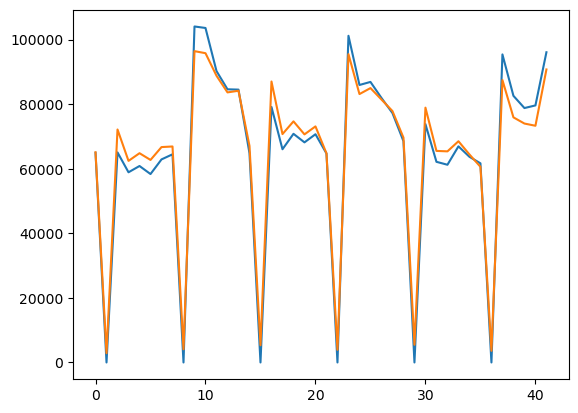

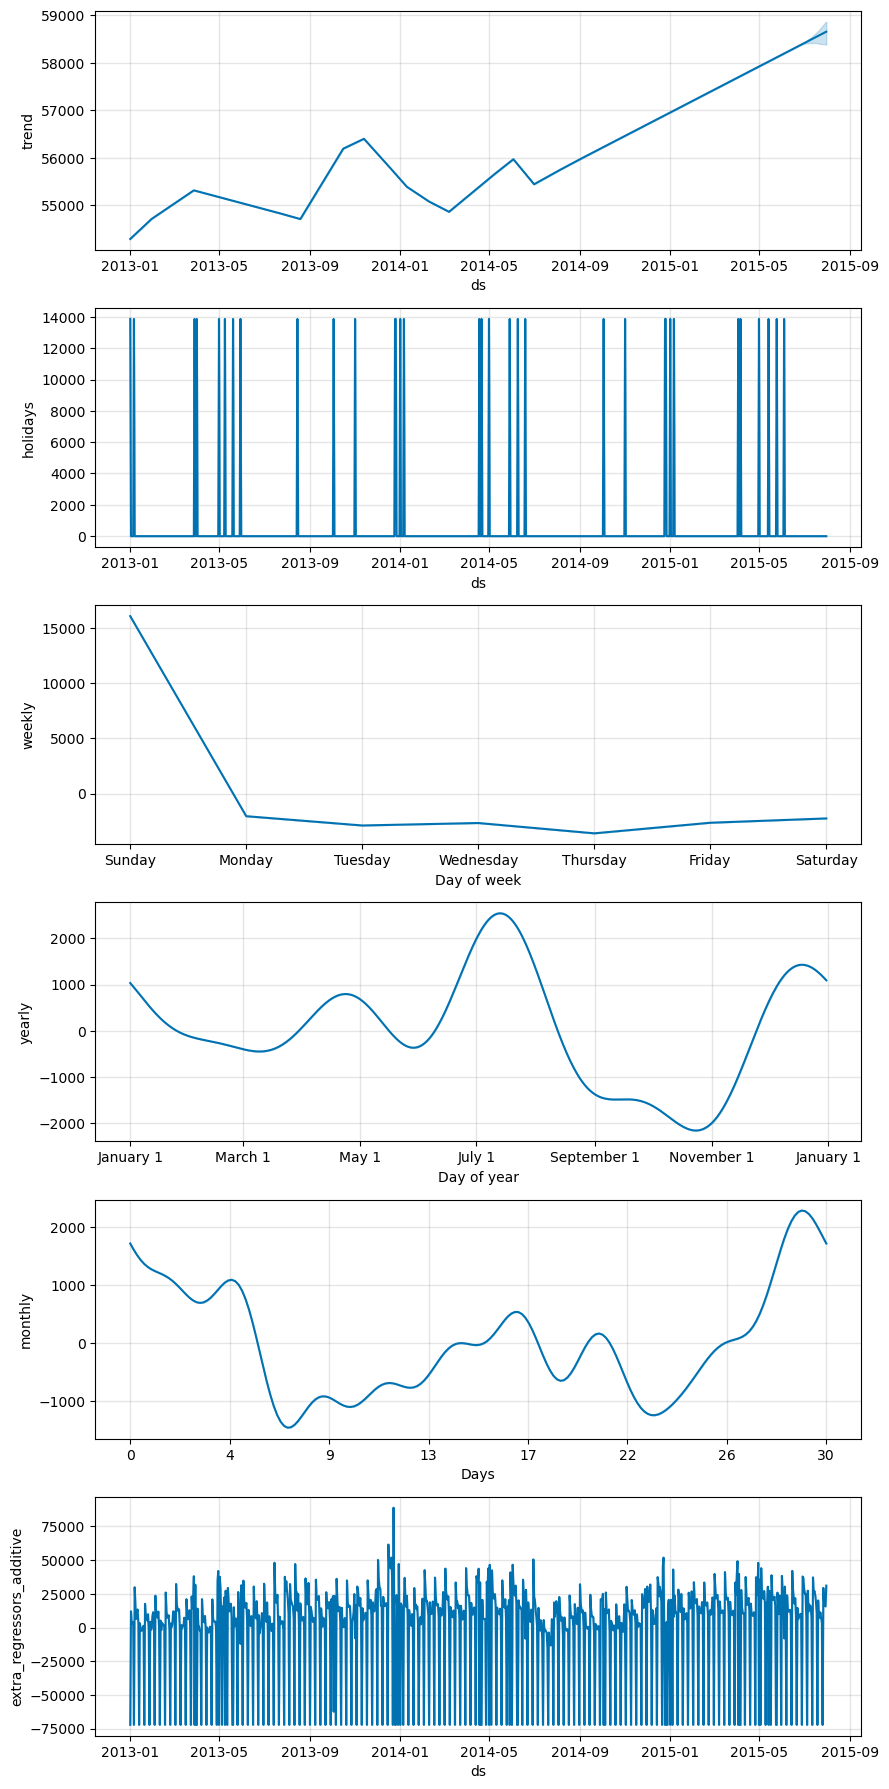

In [29]:
plt.plot(list(test['y']))
plt.plot(list(forecast5.loc[900:,'yhat'] ))

fig = m5.plot_components(forecast5)
plt.show()

#### **Conclusiones del modelo Prophet**

El modelo conseguido ha sido un *Prophet* con un **R2 Score del 0.978** con las siguientes características:

- Utiliza tendencia.
- Se ha añadido la estacionalidad mensual.
- Se ha añadido como variable ficticia los días festivos.
- Se ha añadido como regresor el número de clientes.

# <a name="prediccion"> 4. Predicciones de la serie diaria <a>

Una vez obtenido el mejor modelo se realizarán los cálculos de las predicciones para los próximos 41 días.

### Predicción de la variable regresora `Customers` 

El regresor utilizado para el modelo anterior es una variable a futuro por lo que antes de calcular las predicciones habrá que realizar primero la predicción de esta variable para posteriormente introducirla en el modelo.

La predicción de esta variable se llevará a cabo con Prophet tambien. 

In [30]:
# Group by date to add all Sales of the day. 

customers_predict = toscos_df.groupby(['Date'])['Customers'].sum().reset_index()

# Index date
customers_predict = customers_predict.set_index('Date')

customers_predict.head()

Customers
Date                 
2013-01-01          0
2013-01-02       7490
2013-01-03       6650
2013-01-04       6784
2013-01-05       6747

<AxesSubplot:xlabel='Date'>

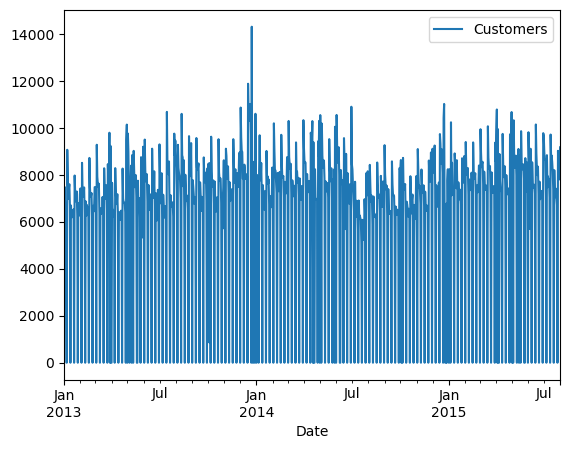

In [31]:
# Plot the customers serie

customers_predict.plot()

Se observa que presenta el mismo comportamiento que la serie temporal de ventas diarias. Se repite el patrón estacional. Cuando las tiendas están cerradas, el valor es 0, por lo que se tendrá que recurrir a una metodología parecida a la serie temporal de ventas.

In [32]:
# Group by date to add all Sales of the day

customers_predict = customers_predict.groupby('Date').sum().reset_index()

# Date to datetime
customers_predict['Date'] = pd.to_datetime(customers_predict['Date']).dt.date

# Rename columns to Prophet format
customers_predict = customers_predict.rename(columns={'Date':'ds', 'Customers':'y'})
customers_predict.head()

ds     y
0  2013-01-01     0
1  2013-01-02  7490
2  2013-01-03  6650
3  2013-01-04  6784
4  2013-01-05  6747

Entrenamiento del modelo para obtener las predicciones de los clientes.

In [33]:
# Fit model

m6 = Prophet()
m6.fit(customers_predict)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Se obtienen las predicciones de los clientes (variable a futuro que posteriormente se utilizará en el modelo final para predecir las ventas).

In [34]:
# Predict
future6 = m6.make_future_dataframe(periods=41) # Periods = 41 days
forecast6 = m6.predict(future6)

Se muestran las predicciones obtenidas, así como el intervalo de confianza (límites superiores e inferiores)

In [36]:
# Show the forecast

customers_forecast = forecast6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
customers_forecast.tail()

ds         yhat   yhat_lower    yhat_upper
978 2015-09-06   213.440781 -1747.646653   2122.247347
979 2015-09-07  8492.949681  6632.593170  10237.158112
980 2015-09-08  7930.917970  6053.656890   9760.232389
981 2015-09-09  7583.348646  5727.974247   9645.726623
982 2015-09-10  7280.360498  5388.563851   9195.678041

Como los domingos y días festivos las tiendas están cerradas, se sustituyen los valores de predicción por 0 para que al introducirlo posteriormente en el modelo final no afecte demasiado a las predicciones.

In [37]:
# Lista de fechas para las cuales se deben reemplazar los valores de clientes
dates_change = ['2015-08-02', '2015-08-09', '2015-08-15', '2015-08-16', '2015-08-23', '2015-08-30',
                '2015-09-06', '2015-09-13']

dates_change = [pd.to_datetime(ds) for ds in dates_change]

# Reemplazando los valores de clientes para las fechas específicas
for ds in dates_change:
    customers_forecast.loc[customers_forecast['ds'] == ds, 'yhat'] = 0

In [38]:
customers_forecast = customers_forecast[['ds', 'yhat']]
customers_forecast = customers_forecast.rename(columns={'yhat':'customers_predict'})
customers_forecast.tail()

ds  customers_predict
978 2015-09-06           0.000000
979 2015-09-07        8492.949681
980 2015-09-08        7930.917970
981 2015-09-09        7583.348646
982 2015-09-10        7280.360498

### Se añade el regresor de los clientes que se acaba de predecir al modelo final 

In [39]:
# Date to datetime

customers_forecast['ds'] = pd.to_datetime(customers_forecast['ds']).dt.date

In [40]:
# Copy train to add the customers column

train3 = toscos_df_prophet.copy()
train3['ds'] = pd.to_datetime(train3['ds']).dt.date

# Merge the customers column and train2
train3 = pd.merge(train3, customers_forecast, on='ds', how='left')
train3.tail()

ds      y  customers_predict
937  2015-07-27  95402        8445.661018
938  2015-07-28  82582        7902.502636
939  2015-07-29  78795        7573.172610
940  2015-07-30  79610        7287.925931
941  2015-07-31  96078        7730.861868

### Estimación del modelo final

In [46]:
# Fit model

m7 = Prophet(
        yearly_seasonality=5, 
        weekly_seasonality=5, 
        holidays=holidays, 
        changepoint_prior_scale=0.3)
    
m7.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=10)

m7.add_regressor('customers_predict')

m7.fit(train3)

# Make future dataframe
future7 = m7.make_future_dataframe(periods=41)
future7['ds'] = pd.to_datetime(future7['ds']).dt.date
future7 = pd.merge(future7, customers_forecast, on='ds', how='left')

# Forecast
forecast7 = m7.predict(future7)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicciones finales de la serie diaria con los intervalos de confianza.

In [54]:
# Show the forecast

final_forecast = forecast7[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
final_forecast.tail()

ds          yhat    yhat_lower     yhat_upper
978 2015-09-06   9969.260101  -3648.086977   24274.253683
979 2015-09-07  88888.592891  74282.863876  104128.499633
980 2015-09-08  77094.184705  63801.514018   90914.390882
981 2015-09-09  71859.729433  58436.660668   86991.062806
982 2015-09-10  70945.778551  55295.393593   84069.763811

El modelo no ha conseguido predecir los días festivos. Para ello se sustituirán manualmente los días festivos por 0 puesto que sabemos con certeza que la tienda va a estar cerrada y esos días no se van a obtener ventas. 

In [55]:
# List of dates for which the customer values ​​must be replaced
dates_change = ['2015-08-02', '2015-08-09', '2015-08-15', '2015-08-16', '2015-08-23', '2015-08-30',
                '2015-09-06', '2015-09-13']

# Convert to datetime
dates_change = [pd.to_datetime(ds) for ds in dates_change]

# Replace the values
for ds in dates_change:
    final_forecast.loc[final_forecast['ds'] == ds, 'yhat'] = 0

Finalmente se hace una representación gráfica con las predicciones, valores reales e intervalo de confianza de las predicciones.

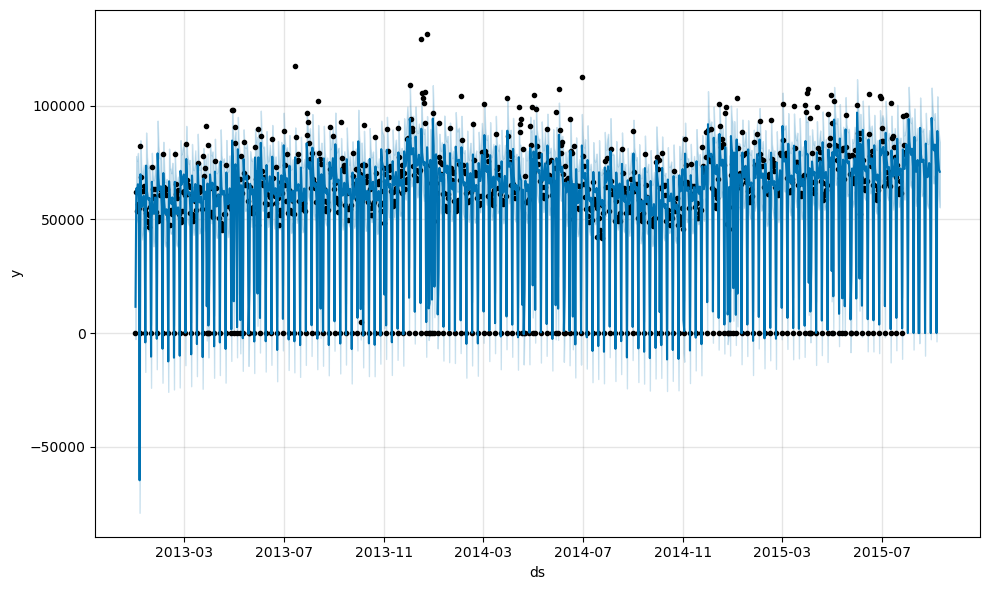

In [56]:
# Plot final forecast
final_plot = m7.plot(final_forecast)

El número de ventas al tener que ser un número entero no se tendrán en cuenta los decimales.

In [57]:
# Select the forecast
final_forecast = final_forecast.iloc[-41:,:]

# Select the columns to export
columns_to_export = ['yhat']
final_forecast = final_forecast[columns_to_export]

final_forecast = pd.Series([round(val, 0) for val in final_forecast['yhat']])

##### Exportación de las predicciones a un fichero .csv

Se exportarán únicamente las predicciones con el valor de las ventas diarias, sin fechas ni índices. El archivo *.csv* se llamará `predicciones_diarias.csv` y se encontrará en el directorio *../data/processed*.

In [60]:
# Export to csv
final_forecast.to_csv('../data/processed/predicciones_diarias.csv', index=False)

# <a name="conclusiones"> 5. Conclusiones finales <a>

Las predicciones obtenidas con el modelo `Prophet` se consideran buenas, puesto que el modelo utilizado ha obtenido un R2 Score de 0.978. 

Esta serie presenta la particularidad de tener muchos datos con valor 0 que ha dificultado la predicción. 

La debilidad del modelo utilizado en este notebook es que no ha conseguido predecir los días festivos. Se observa que han habido días donde la predicción en lugar de 0 ha sido un número negativo. Para ello se ha tenido que sustituir manualmente los días festivos por 0, (hecho que sabemos que se va a producir con certeza puesto que las tiendas permanecerán cerradas). 